In [1]:
# day13, part2 - https://adventofcode.com/2019/day/13

In [2]:
from PIL import Image
import numpy as np
from IPython.display import display

In [3]:
# this object is where the Intcode program lives and some useful methods
# to fill it, clear it, read from it, write to it
class Computer:
    import logging
    global set_trace
    global inputs
    global outputs
    global game
    
    def __init__(self, size, stage, rbase=0):
        # size is array size[0] = program memory, size[1] = general memory
        self.size = size  # must specify the memory size
        self.stage = stage
        # self.storage = [None] * (size[0] + size[1])  # initialize with None
        self.storage = [0] * (size[0] + size[1])  # initialize with 0s
        # initial relative_base
        self.rbase = rbase
        # program base memory is 0
        self.prog_base = 0
        # memory space is immediately above the programming space
        self.mem_base = size[0] + 1
    
    # set the releative_base value
    def set_rbase(self, val):
        self.rbase = val
        return
        
    # dump out the contents between 2 positions (defaults all the memory)
    def dump(self,start=0,end=-1):
        if(end == -1):
            end = self.size
        for i in range(start, end):
            print("{}: {}".format(i,self.storage[i]))

    # fill the memory with a sequence, starting at a certain position - which defaults to 0
    def fill(self, codelist, start_pos = 0):
        i = start_pos
        for j in codelist:
            self.storage[i] = j
            i+=1
    
    # fill (write to) memory with a sequence, allowing direct or reference starting location
    def mode_fill(self, s, mem_location, mode):
        # mem_location: where to begin fill or to reference to begin
        # mode (0 - position, 1 - immediate, 2 - relative)
        if(set_trace): import pdb; pdb.set_trace()
        if(mode == '0' or mode == '2'):
            # these are positional references
            i = self.relative_location(self.read(mem_location), mode)
            for j in s:
                self.storage[i] = j
                i+=1
        elif(mode == '1'):
            # this is the direct reference
            i = mem_location
            for j in s:
                self.storage[i] = j
                i+=1

    # load the program into program space
    def load_program(self, s):
        self.mode_fill(s, self.prog_base, "1")
        return
                
    # get data from input_buffer for this stage
    # if it has 2 values, then it hasn't read in the amp_setting
    # that state will return the last value and remove it

#     def getfrominput(self):
#         if(len(inputs[self.stage].contents) > 1):
#             # pop a value off and return it
#             return(inputs[self.stage].contents.pop())
#         else:
#             # return just that last value but leave it
#             return(inputs[self.stage].contents[0])

    # get data from single input buffer
    def getfrominput(self):
        # get input from user
        # these lines are when you want to display the board and get the input from the user:
        # ---------------
        # game.show_state("s")
        # display(game.board_image(10))
        # print("enter some input:")
        # inputs = input()
        # ---------------
        # and this line will return the calculated move if 'p' was entered by the user above
        # if(inputs == 'p'):
        #    return(game.calc_best_move())
        # return(inputs)
        # ------
        # and this will just return the calculated move with no display or input the user
        # basically, the game will play itself to completion
        return(game.calc_best_move())

    # put data to output_buffer for this stage (which is next stage's input)
    # put this output value into position [0] of that buffer (position [1] will have possible amp_setting)
#     def puttooutput(self, val):
#         logging.info("outputting: {} to stage: {}".format(val, next_stage(self.stage,5)))
#         inputs[next_stage(self.stage,5)].contents[0] = val
#         return

    # output to single output buffer
    def puttooutput(self, val):
        global outputs
        logging.info("before append - outputs: {}".format(outputs))
        outputs.append(val)
        # print(outputs)
        logging.info("after append - outputs: {}".format(outputs))
        return

    # read the contents from just one position
    def read(self, pos):
        return self.storage[pos]
   
    # return the value based on parameter mode
    def mode_read(self, pos, mode):
        if(set_trace): import pdb; pdb.set_trace()
        # mode: 0 - position, 1 - immediate, 2 - relative
        if(mode == '0' or mode == '2'):
            return int(self.storage[self.relative_location(self.read(pos), mode)])
        elif(mode == '1'):
            return int(self.read(pos))

    # clear the memory
    def clear(self):
        self.storage = [None] * self.size

    # return the location adjusted by relative_base, based on mode
    def relative_location(self, location_val, mode):
        # location - location value read from prog
        # mode - the parameter mode -'0': position, '2': relative
        logging.info("relative_location() - location_val: {}, mode: {}, self.rbase: {}".format(location_val, mode, self.rbase))
        return((location_val + self.rbase) if int(mode) else location_val)
        
    # this function will execute a single sequence (operator + subsequent operands and output location)
    def exec_seq(self, ctr):
        global set_trace
        # these string representations of opcodes are used in logging
        opcodes = {"00":"NOT-AN-OPCODE","99":"STOP","01":"ADD","02":"MULTIPLY","03":"INPUT","04":"OUTPUT","05":"JUMP-TRUE","06":"JUMP-FALSE","07":"LESS-THAN","08":"EQUALS-TO", "09":"ADJUST-RBASE"}
        # ctr - where to start
        # m - the memory object to work from
        # the first in the sequence is the 'enhnanced opcode' (includes 3 parameter modes in most significant position)
        # zero-pad to 5 - most significant 0 is implied
        enhanced_opcode = str(self.read(ctr)).zfill(5)
        # first 3 characters are the parameter modes
        pmodes = enhanced_opcode[:3]
        # last 2 characters are the opcode
        opcode = enhanced_opcode[3:]
        if(set_trace): import pdb; pdb.set_trace()
        # ===================   99   -  STOP  ============================= 
        if(opcode == '99'):
            prog_status[self.stage] = "STOP"
            logging.info("opcode: {} - {}".format(opcode, opcodes[opcode]))
            return("STOP")
        # ===================   01   -  ADD  ============================= 
        elif(opcode == "01"):
            if(set_trace): import pdb; pdb.set_trace()
            operand1 = self.mode_read(ctr+1, pmodes[2])
            operand2 = self.mode_read(ctr+2, pmodes[1])
            if(set_trace): import pdb; pdb.set_trace()
            calcval = operand1 + operand2
        # ===================   02   -  MULTIPLY  ============================= 
        elif(opcode == "02"):
            if(set_trace): import pdb; pdb.set_trace()
            operand1 = self.mode_read(ctr+1, pmodes[2])
            operand2 = self.mode_read(ctr+2, pmodes[1])
            calcval = operand1 * operand2
        # ===================   03   -  INPUT  ============================= 
        elif(opcode == "03"):
            if(set_trace): import pdb; pdb.set_trace()
            # get the input
            # val = getfrominput()
            # the input buffer is the one for this amp stage
            val = self.getfrominput()
            # store it in address provided by next code
            self.mode_fill([val], ctr+1, pmodes[2])
            # return next prog counter
            logging.info("opcode: {}-{}, pmodes: {}, from-input: {}, @ctr+1: {}, ctr in: {}, returning: {}".format(opcode,opcodes[opcode],pmodes,val,self.read(ctr+1),ctr,ctr+2))
            return(ctr+2)
        # ===================   04   -  OUTPUT  ============================= 
        elif(opcode == "04"):
            if(set_trace): import pdb; pdb.set_trace()
            # read the val (based on mode) specified from next code and send to output
            self.puttooutput(self.mode_read(ctr+1, pmodes[2]))
            prog_status[self.stage] = "OUTPUT"
            logging.info("opcode: {}-{}, pmodes: {}, @ctr+1: {}, ctr in: {}, returning: {}".format(opcode, opcodes[opcode],pmodes,self.read(ctr+1),ctr,ctr+2))
            return(ctr+2)
        # ===================   05   -  JUMP-IF-TRUE  ============================= 
        elif(opcode == "05"):
            val_to_test = self.mode_read(ctr+1, pmodes[2])
            if(val_to_test):
                ret_ctr = self.mode_read(ctr+2, pmodes[1])
            else:
                ret_ctr = ctr+3
            logging.info("opcode: {}-{}, pmodes: {}, ctr+1: {}, val_to_test: {}, ctr+2: {}, ctr+3: {}, ctr in: {}, returning: {}".format(opcode, opcodes[opcode],pmodes,self.read(ctr+1),val_to_test, self.read(ctr+2), self.read(ctr+3), ctr, ret_ctr))
            return(ret_ctr)
        # ===================   06   -  JUMP-IF-FALSE  ============================= 
        elif(opcode == "06"):
            val_to_test = self.mode_read(ctr+1, pmodes[2])
            if(val_to_test):
                ret_ctr = ctr+3
            else:
                ret_ctr = self.mode_read(ctr+2, pmodes[1])
            logging.info("opcode: {}-{}, pmodes: {}, ctr+1: {}, val_to_test: {}, ctr+2: {}, ctr+3: {}, ctr in: {}, returning: {}".format(opcode, opcodes[opcode],pmodes,self.read(ctr+1),val_to_test, self.read(ctr+2), self.read(ctr+3), ctr, ret_ctr))
            return(ret_ctr)
        # ===================   07   -  LESS-THAN  ============================= 
        elif(opcode == "07"):
            operand1 = self.mode_read(ctr+1, pmodes[2])
            operand2 = self.mode_read(ctr+2, pmodes[1])
            if(operand1 < operand2):
                calcval = 1
            #    logging.info("opcode: {}-{}, pmodes: {}, ctr+1: {}, ctr+2: {}, ctr+3: {}, ctr in: {}, returning: {}".format(opcode, opcodes[opcode],pmodes,self.read(ctr+1), self.read(ctr+2), self.read(ctr+3), ctr, ret_ctr))
            else:
                calcval = 0
            #    logging.info("opcode: {}-{}, pmodes: {}, ctr+1: {}, ctr+2: {}, ctr+3: {}, ctr in: {}, returning: {}".format(opcode, opcodes[opcode],pmodes,self.read(ctr+1), self.read(ctr+2), self.read(ctr+3), ctr, ret_ctr))

        # ===================   08   -  EQUALS-TO  ============================= 
        elif(opcode == "08"):
            operand1 = self.mode_read(ctr+1, pmodes[2])
            operand2 = self.mode_read(ctr+2, pmodes[1])
            if(operand1 == operand2):
                calcval = 1
            else:
                calcval = 0
        # ===================   09   -  ADJUST-RELATIVE-BASE  ============================= 
        elif(opcode == "09"):
             # modify rbase by the value in next position
            self.rbase = self.rbase + self.mode_read(ctr+1, pmodes[2])
            logging.info("opcode: {}-{}, pmodes: {}, ctr+1: {}, self.rbase: {}, ctr in: {}, returning: {}".format(opcode, opcodes[opcode],pmodes,self.read(ctr+1),self.rbase,ctr,ctr+2))
            return(ctr+2)
        # ===================   ?? - NOT KNOWN  ============================= 
        else:
            prog_status[self.stage] = "BADOPCODE"
            logging.info("opcode: {}-{}".format(opcode,opcodes[opcode]))
            return("BADOPCODE")
        # 3-parameter instructions get here
        # fill the output destination with value depending on mode
        if(set_trace): import pdb; pdb.set_trace()
        self.mode_fill([calcval], ctr+3, pmodes[0])
        logging.info("opcode: {}-{}, pmodes: {}, ctr+1: {}, op1: {}, ctr+2: {}, op2: {}, calcval: {}, ctr+3: {}, ctr in: {}, returning: {}".format(opcode, opcodes[opcode],pmodes,self.read(ctr+1),operand1,self.read(ctr+2),operand2,calcval,self.read(ctr+3),ctr,ctr+4))
        # and return the next postion in the memory
        return(ctr+4)

In [4]:
inputs = None
outputs = []
prog_status = [None] * 1

In [5]:
# run parameters / programs
run_name = "day13"

# read the sequence / prog from a file
ifn = "day13-input-program.txt"
d = open(ifn)
s = d.read()
# make a list of integers from the input comma-separated strings
seq = [int(j) for j in s.split(',')]

In [6]:
prog_ctr = 0
set_trace = False
set_trace_main = False
# this will reign in a prog in some crazy processing loop
ops_max = 10000000
ops_ctr = 0

In [7]:
# this is used for logging
import time
year, month, day, hour, minute = time.strftime("%Y %m %d %H %M").split()
# log file name
lfn = "{}-{}{}{}{}{}.log".format(run_name,year,month,day,hour,minute)
# set up the logging
import logging
logging.basicConfig(filename=lfn, level=logging.INFO)
logging.info("==============================================================================")

In [8]:
# initialize computer
# size array is [prog_space, memory_space]
comp = Computer([len(seq),2000], 0)

In [9]:
# set memory pos 0 = 2 to play for free
seq[0] = 2
# load the program
comp.load_program(seq)

In [10]:
# the tile class
class Tile:
    def __init__(self, x, y, t):
        # x: x-pos, y: y-pos, t: type
        self.x = x
        self.y = y
        self.t = t
        return

class Game:
    def __init__(self):
        self.board = []
        self.score = 0
        return
    def update_board(self, x, y, t):
        # x - xpos, y - ypos, t - tile type
        # see if the position is already defined
        tile = [u for u in self.board if u.x == x and u.y == y]
        if len(tile) > 0:
            tile[0].t = t
            logging.info("board update. existing: x:{}, y:{}, t:{}".format(x,y,t))
        else:
            self.board.append(Tile(x,y,t))
            logging.info("board update. new: x:{}, y:{}, t:{}".format(x,y,t))
        return
    def get_ball_pos(self):
        btiles = [b for b in self.board if b.t == 4 ]
        return(btiles[0].x, btiles[0].y)
    def get_paddle_pos(self):
        ptiles = [p for p in self.board if p.t == 3 ]
        return(ptiles[0].x, ptiles[0].y)
    def board_dims(self):
        xs = [t.x for t in self.board]
        ys = [t.y for t in self.board]
        return((max(xs)+1, max(ys)+1))
    def calc_best_move(self):
        by = self.get_ball_pos()[0]
        py = self.get_paddle_pos()[0]
        if(by < py):
            return(-1)
        elif (py < by):
            return(1)
        else:
            return(0)
        
    def show_state(self, what):
        # what - a string that contains codes for what you want to show
        # (s)core, (b)allpos, (p)addlepos, (n)umberoftiles, (d)imensions
        if("s" in what):
            print("score: {}".format(self.score))
        if("b" in what):
            print("ball pos: {}".format(self.get_ball_pos()))
        if("p" in what):
            print("paddle pos: {}".format(self.get_paddle_pos()))
        if("n" in what):
            print("# of tiles (board size): {}".format(len(self.board)))
        if("d" in what):
            print("dimensions: {}".format(self.board_dims()))
        return
    
    def board_image(self, mag):
        # array for colors of tile type (empty, wall, block, paddle, ball)
        color = [250, 20, 100, 170, 230]
        # the x,y orientation of the board is not that clear and then when those dimensions
        # are translated to width, height of an image, things got a bit turned around
        # add to that an array to store to the values for that image which is then flattened
        # since the image data is really a 1-d array...??!!
        size = self.board_dims()
        maxdim = max([size[0], size[1]])
        imgdata = np.ndarray(size)
        # print("size: {}".format(size))
        boardimg = Image.new("L", (size[1], size[0]), 128)
        # fill in the imgdata
        for x in range(size[0]):
            for y in range(size[1]):
                t = [b.t for b in self.board if b.x == x and b.y == y]
                imgdata[x,y] = color[t[0]]
        boardimg.putdata(imgdata.flatten().tolist())
        # return the image magnified by mag and rotated 270 degrees
        # this makes it larger and show in the right orientation
        return(boardimg.resize((size[1]*mag,size[0]*mag)).transpose(method=Image.ROTATE_270))

game = Game()

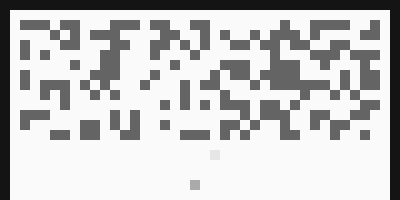

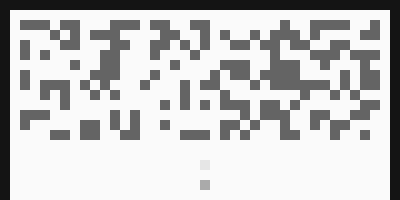

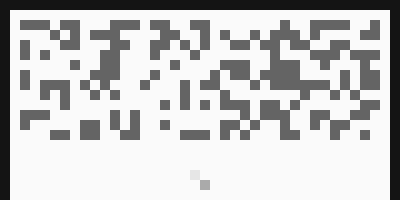

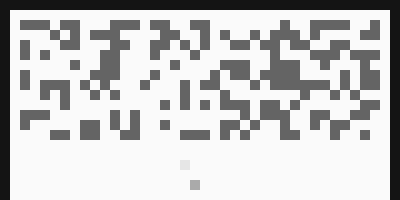

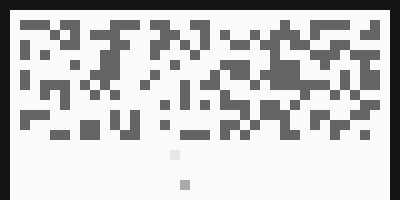

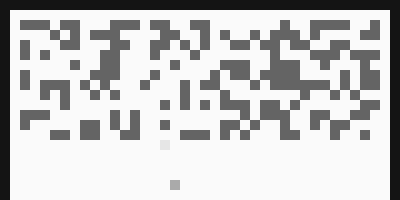

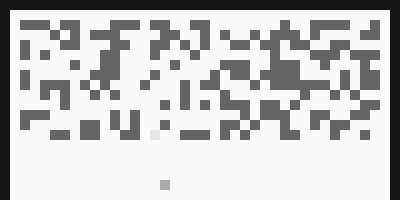

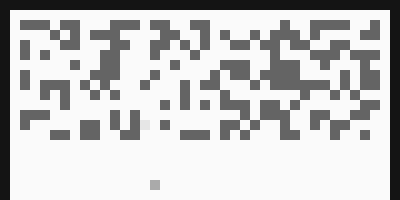

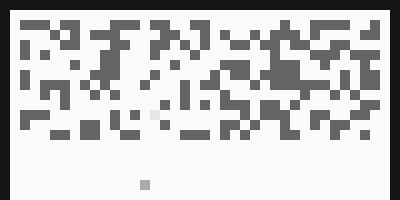

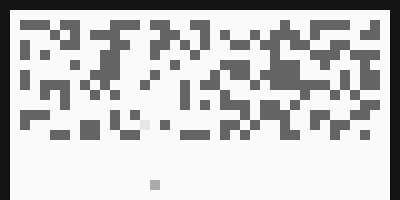

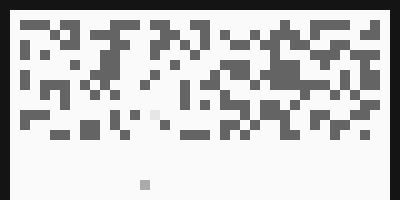

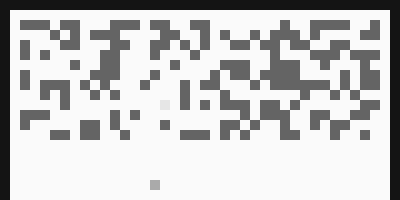

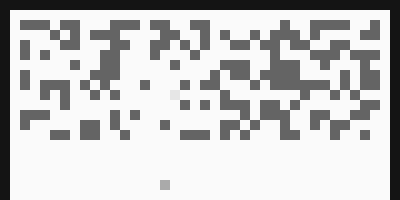

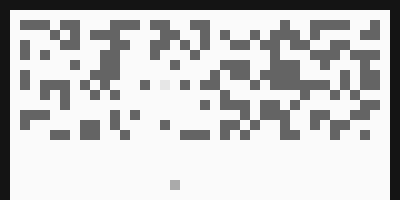

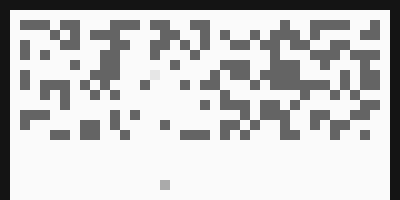

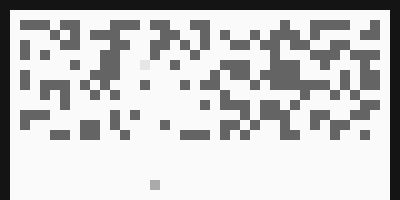

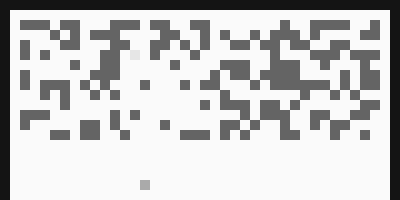

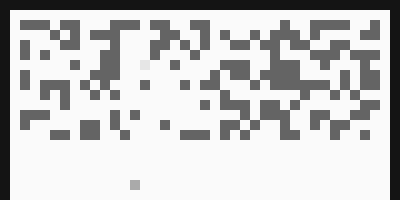

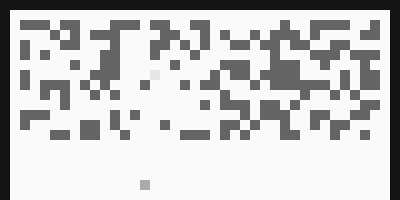

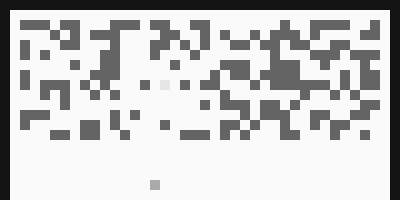

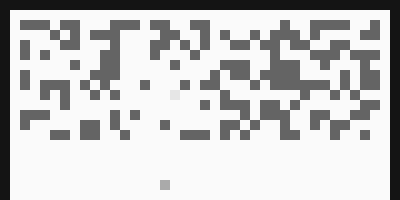

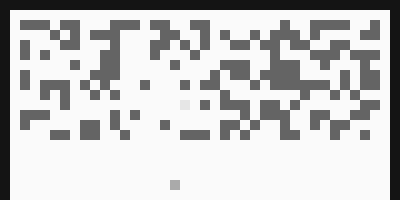

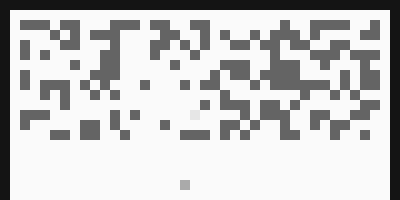

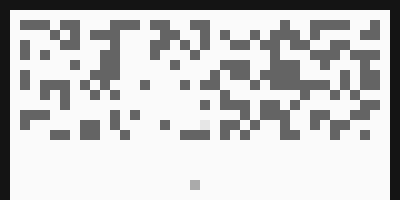

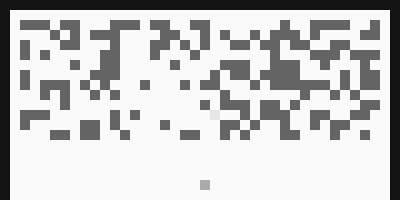

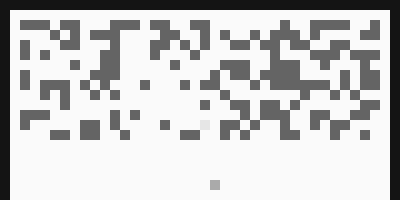

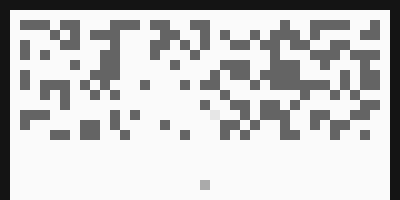

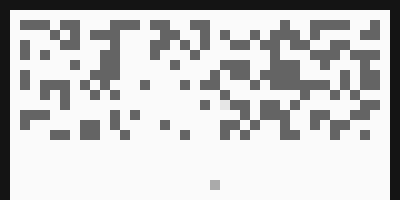

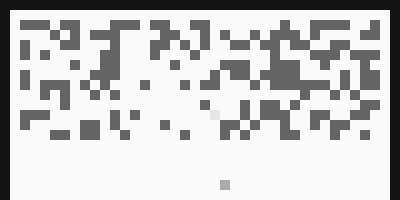

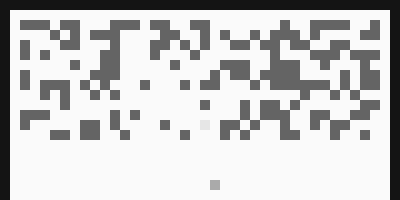

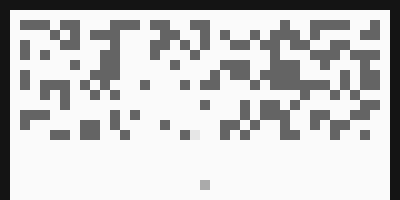

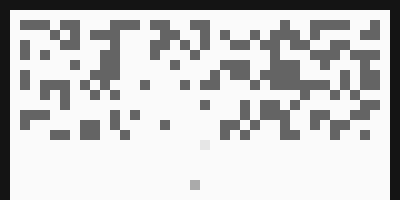

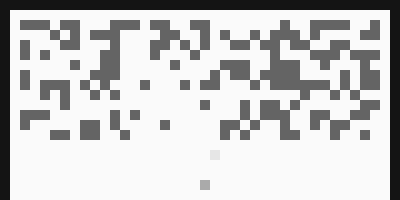

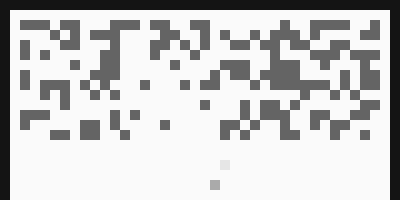

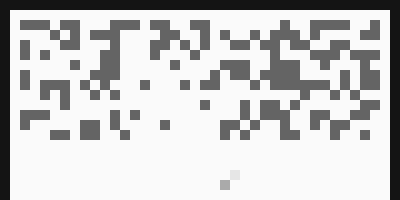

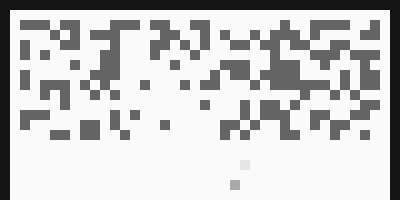

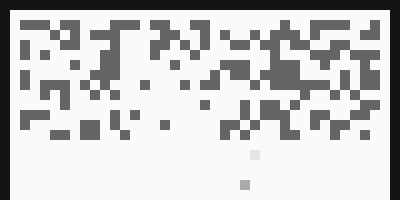

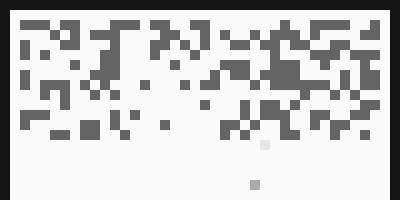

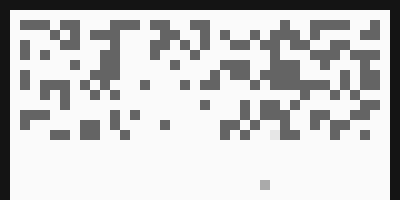

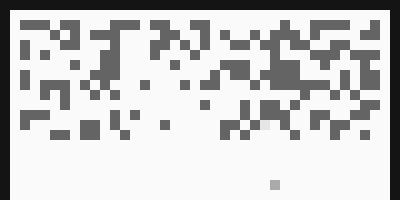

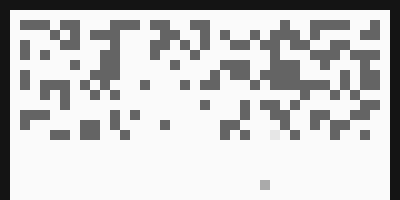

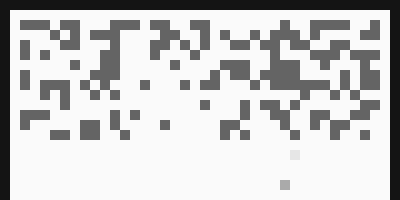

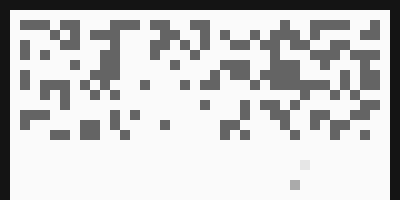

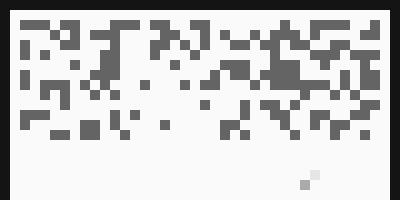

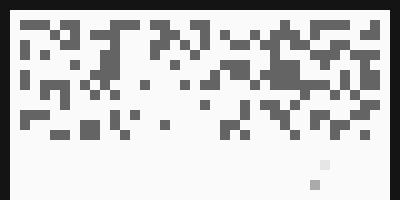

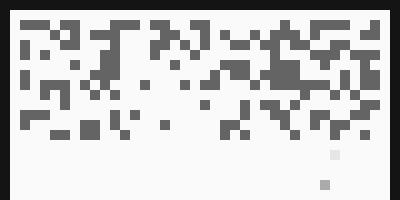

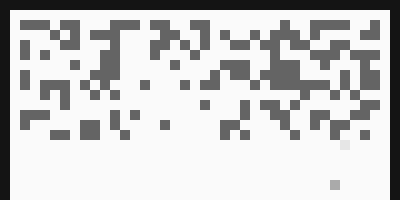

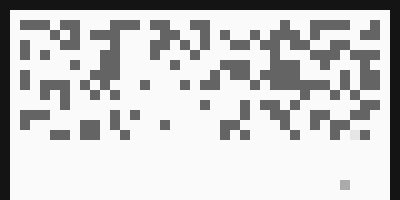

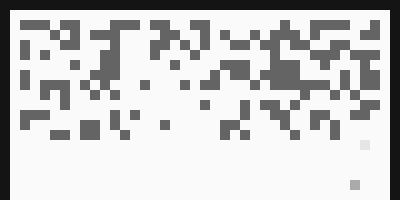

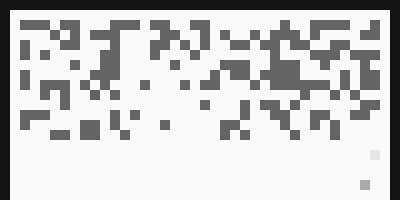

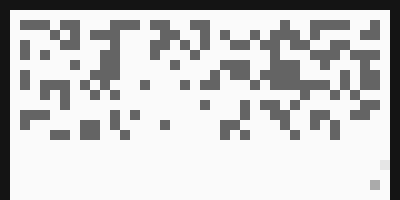

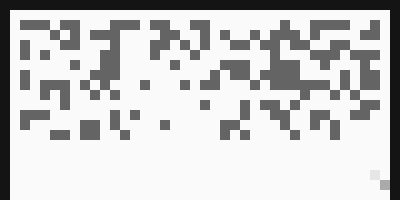

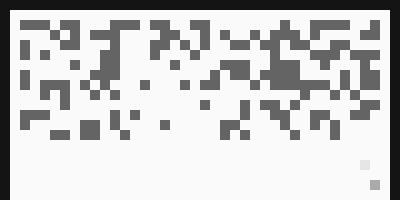

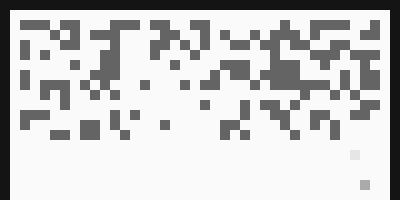

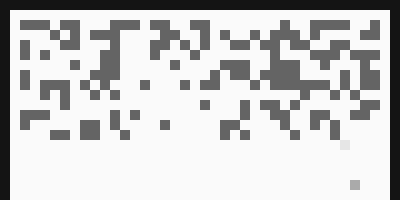

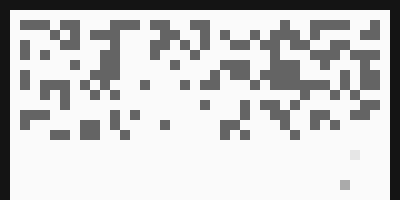

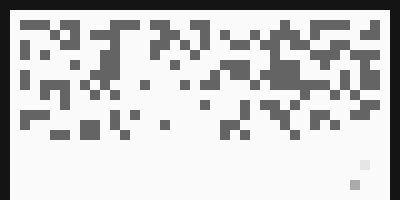

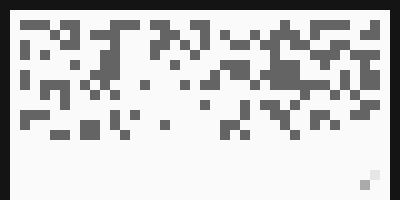

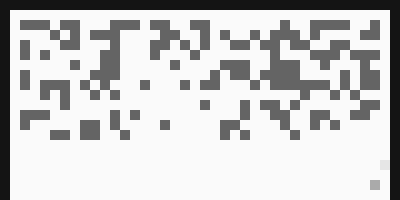

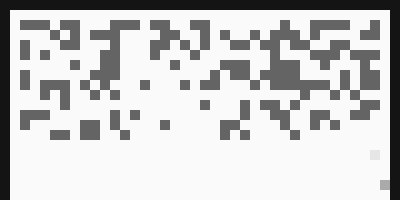

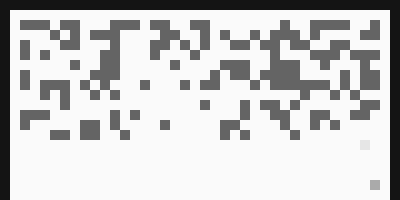

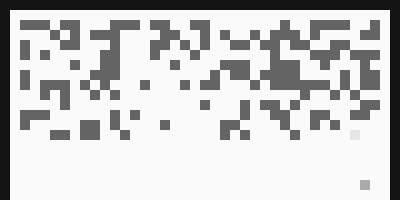

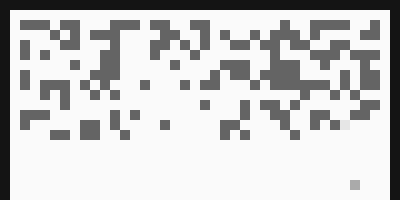

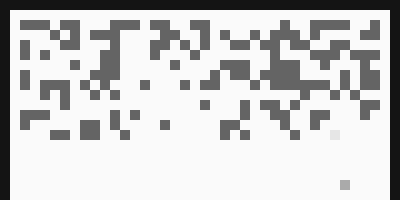

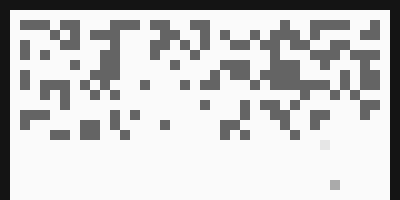

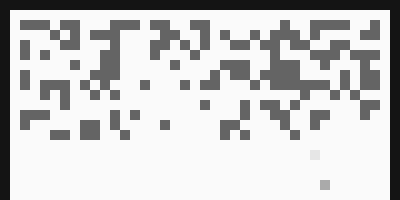

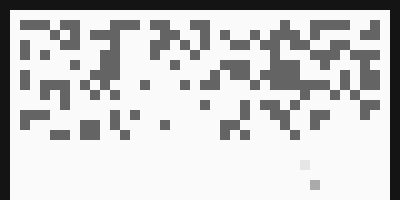

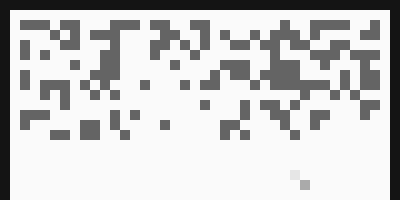

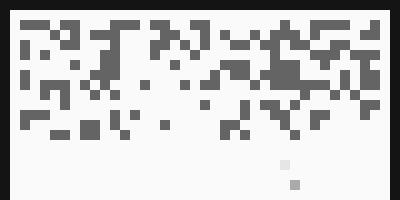

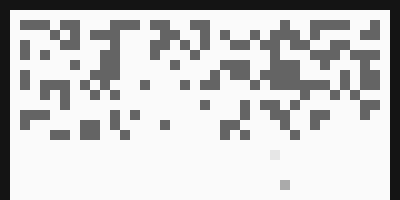

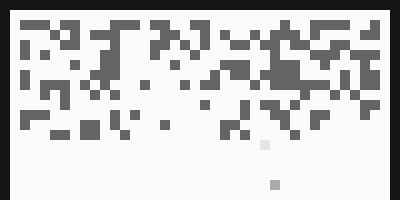

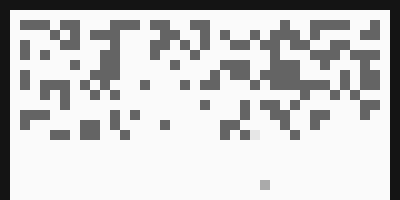

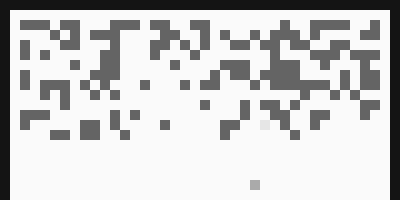

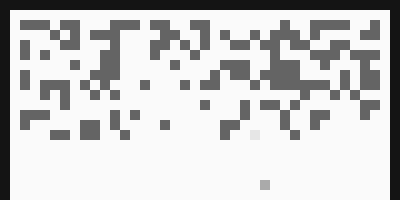

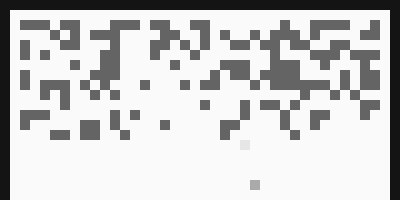

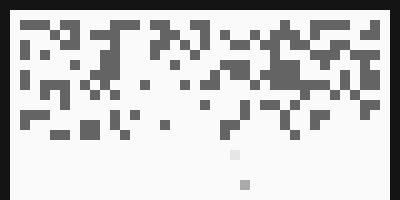

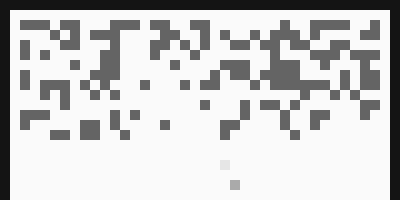

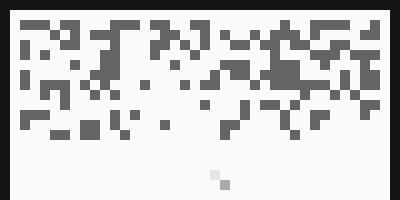

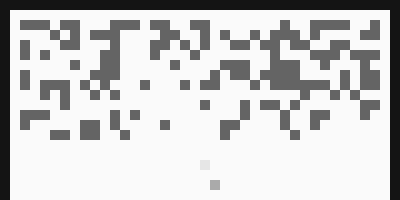

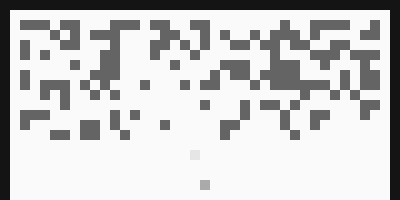

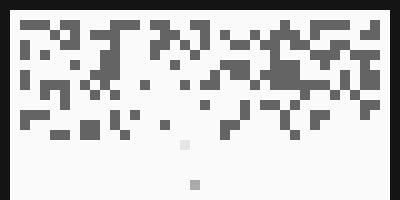

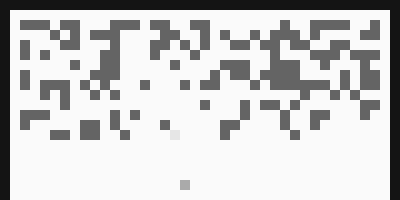

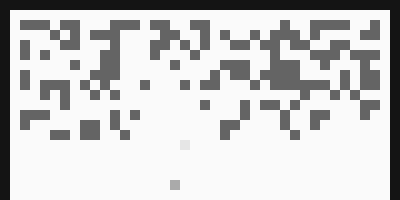

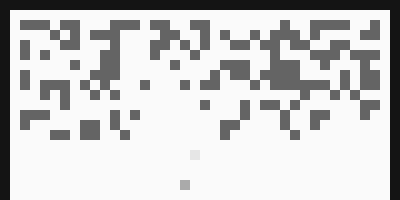

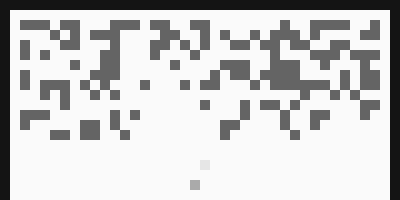

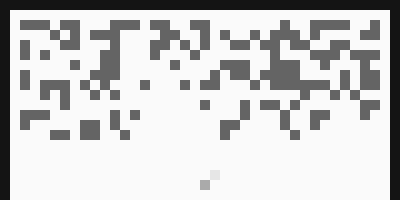

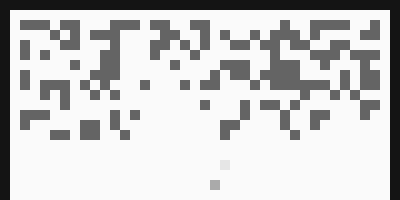

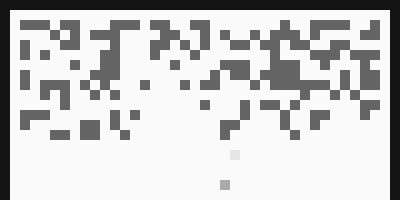

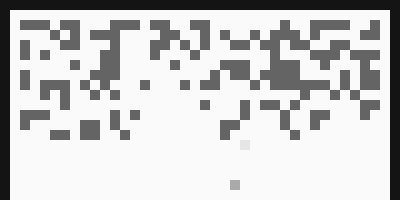

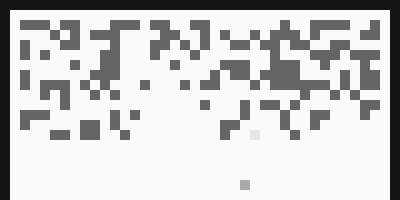

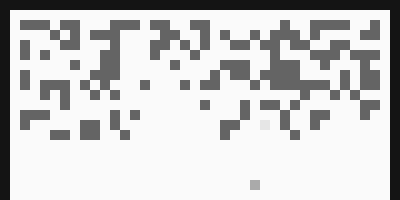

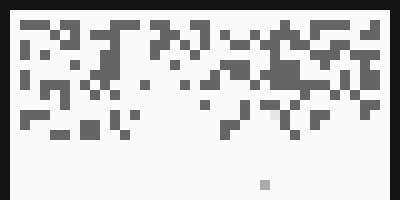

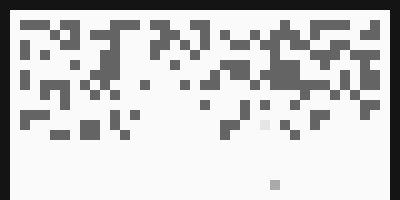

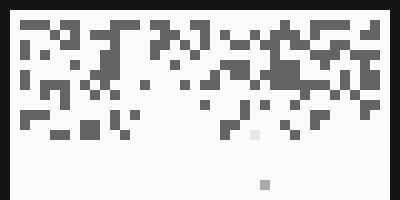

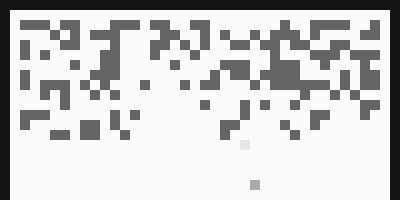

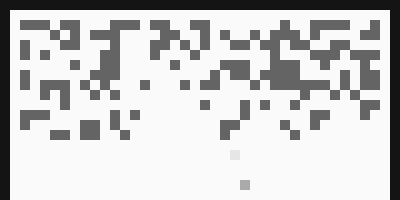

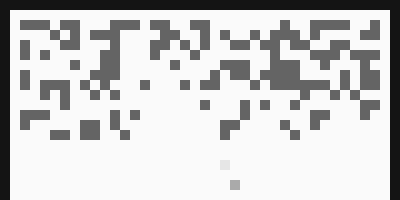

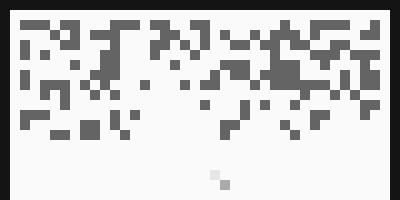

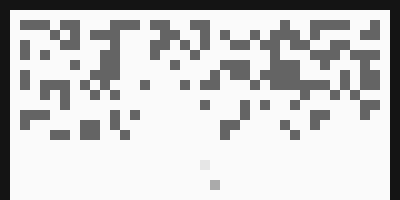

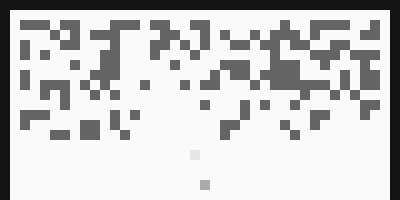

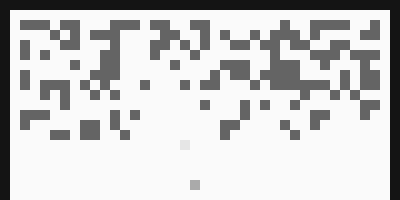

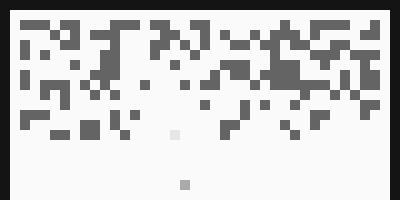

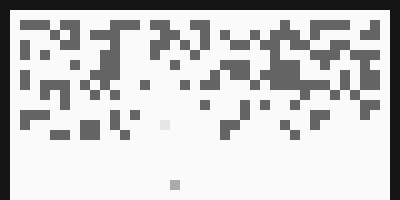

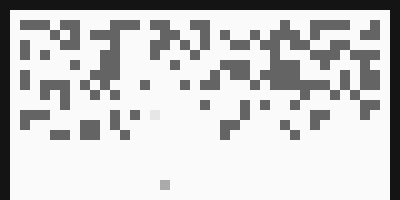

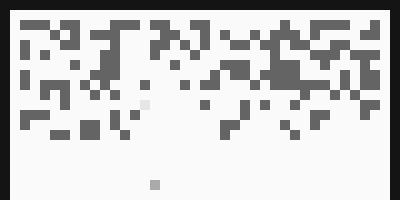

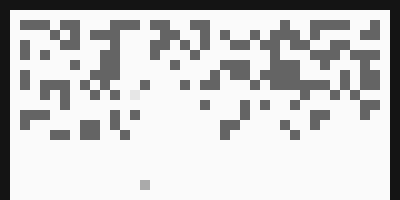

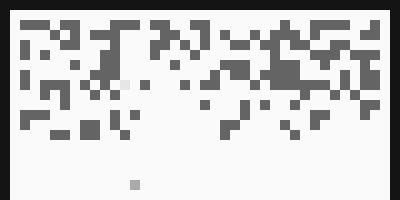

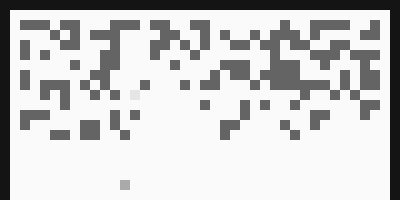

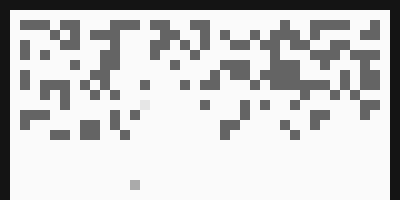

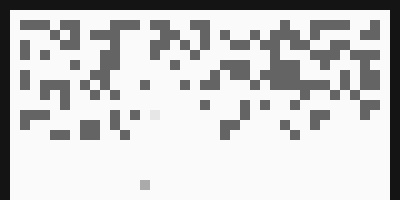

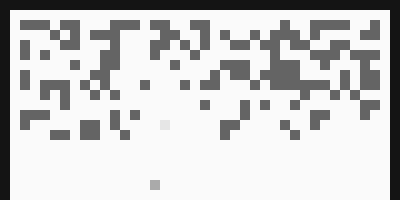

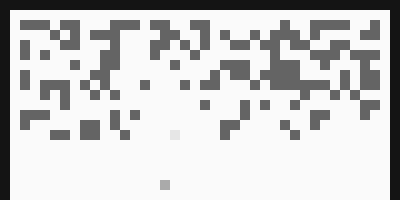

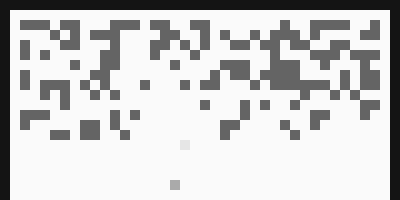

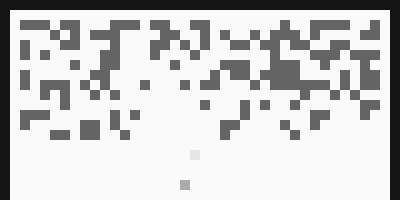

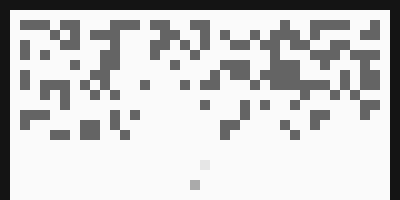

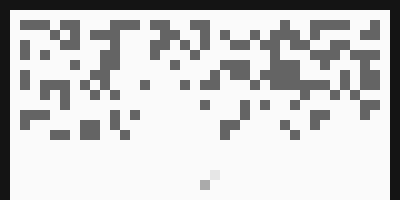

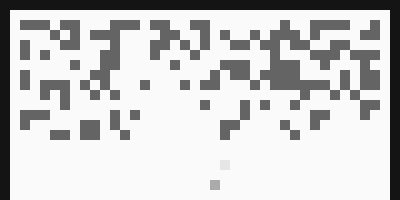

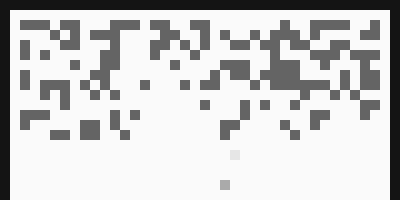

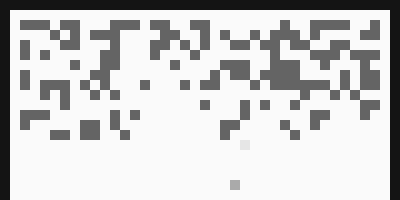

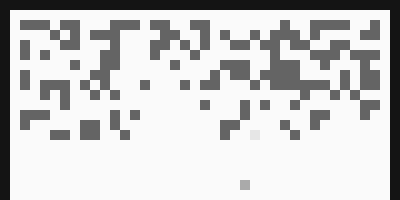

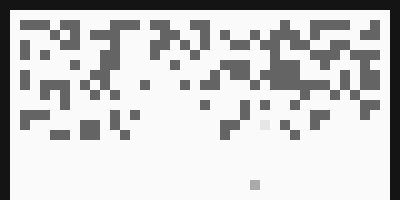

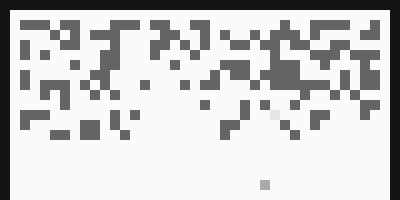

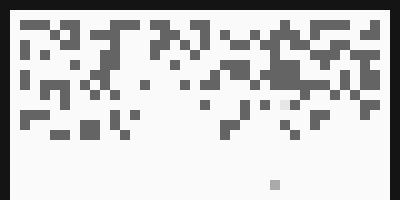

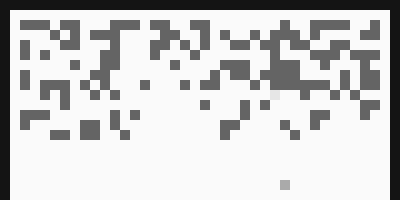

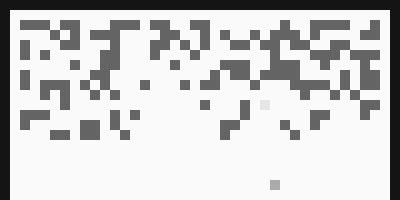

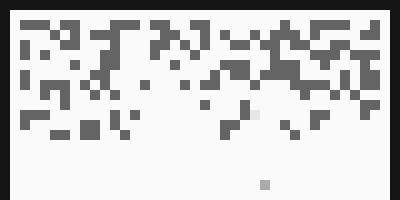

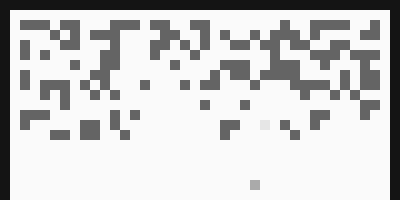

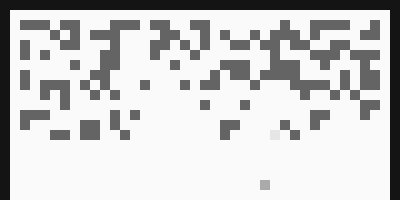

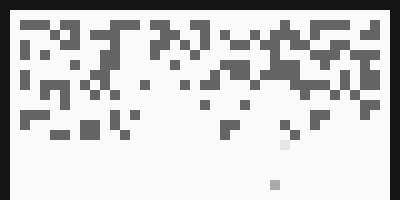

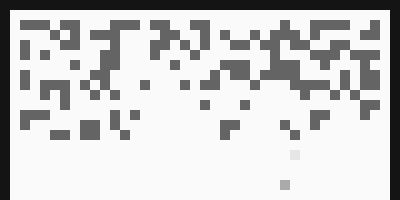

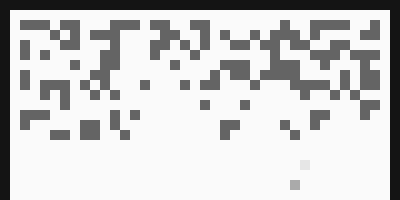

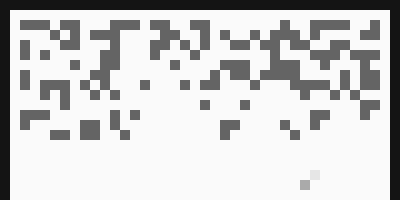

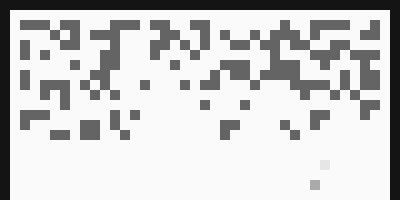

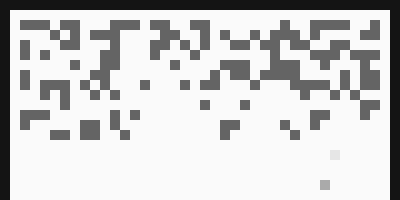

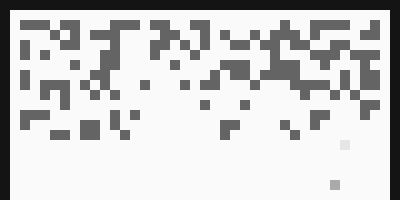

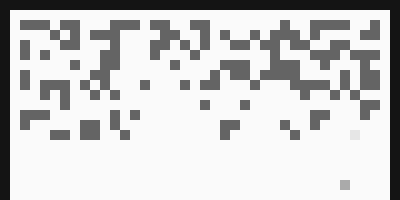

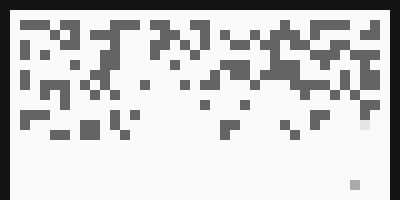

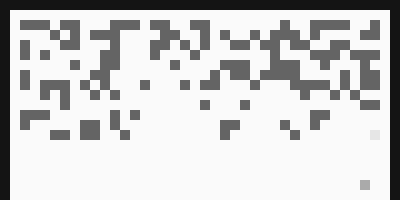

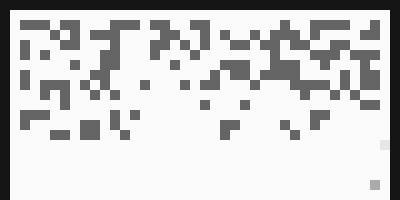

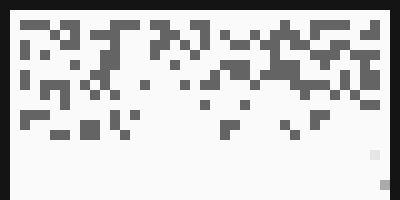

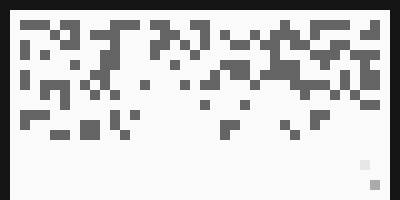

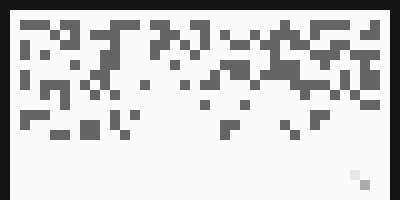

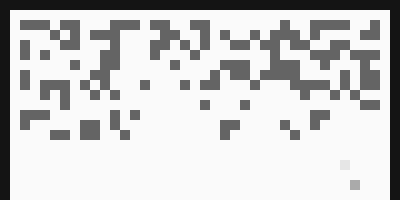

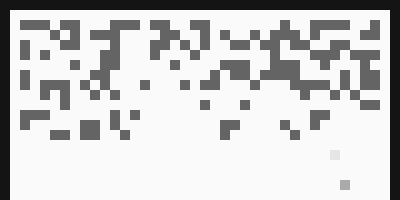

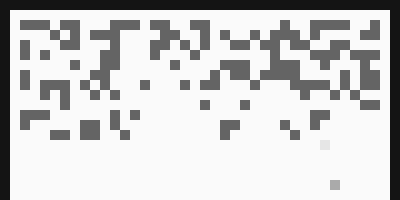

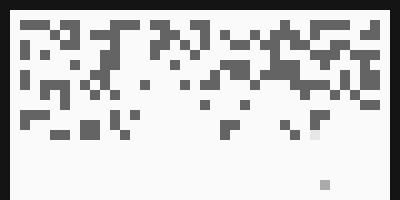

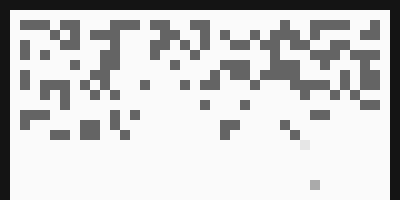

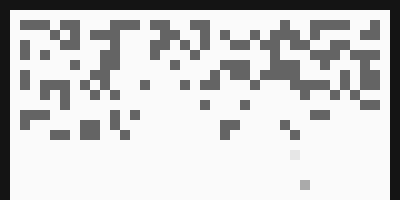

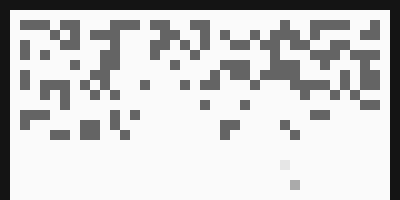

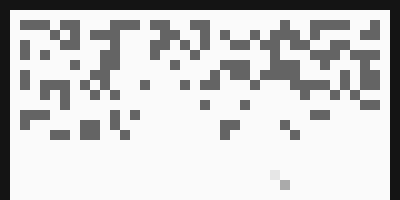

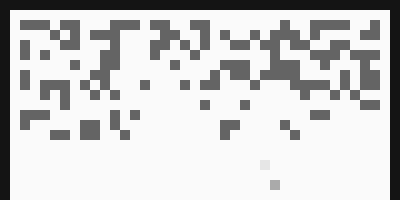

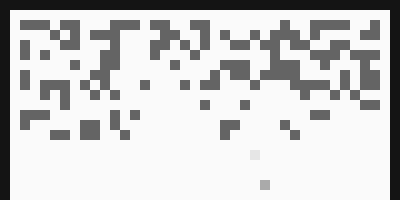

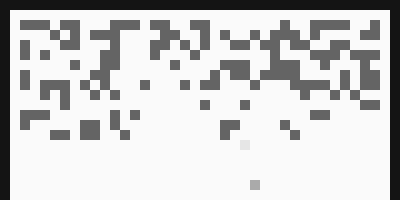

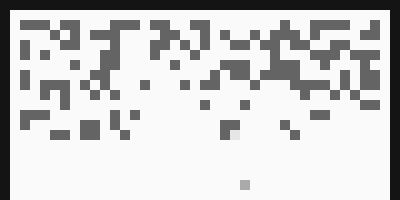

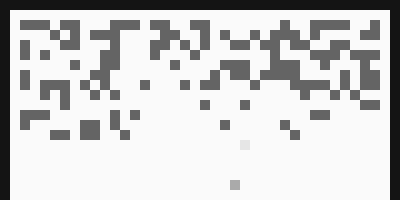

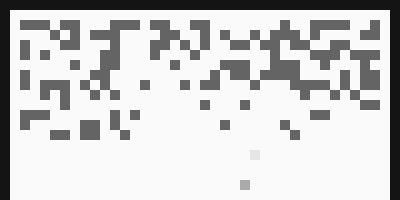

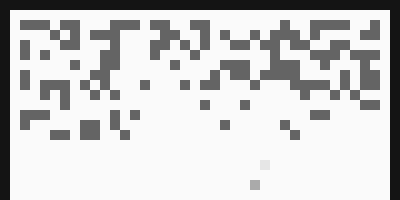

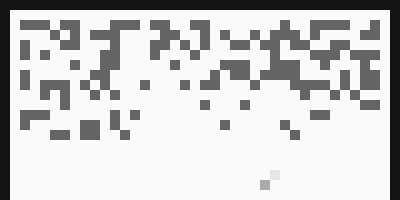

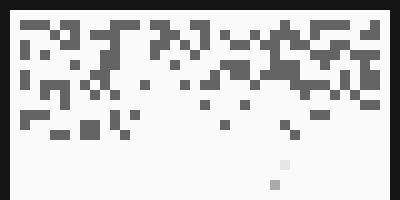

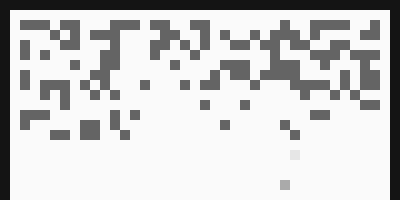

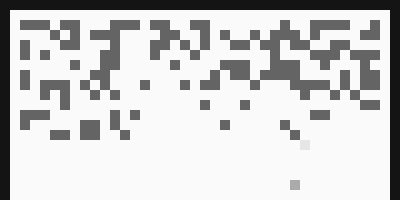

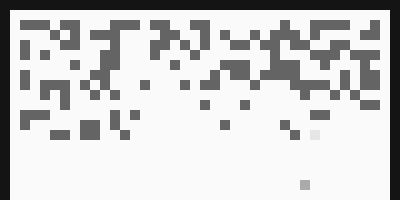

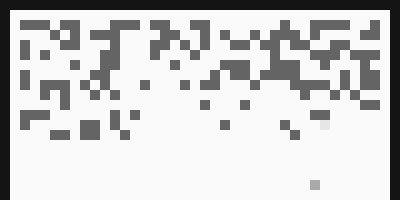

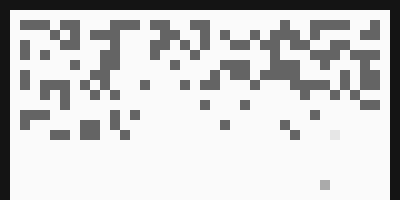

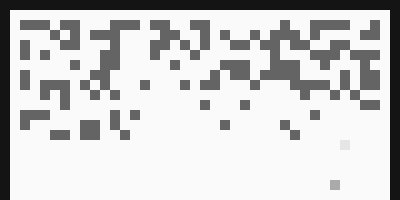

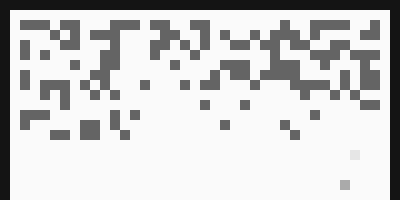

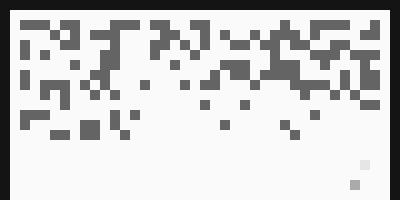

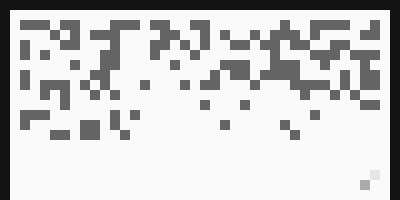

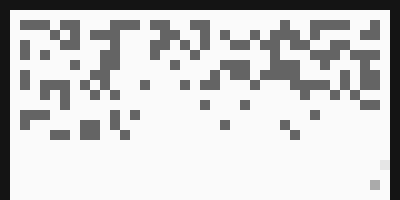

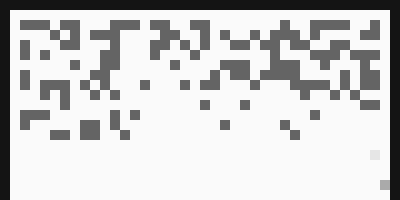

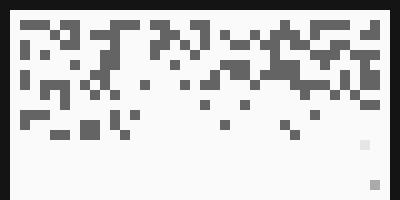

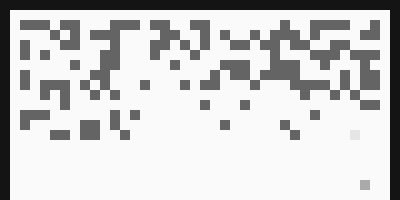

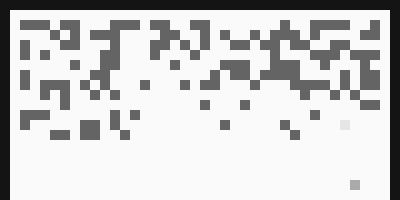

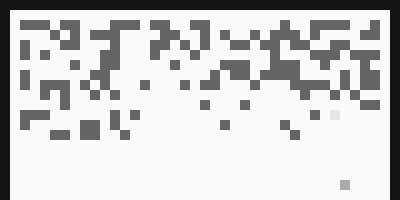

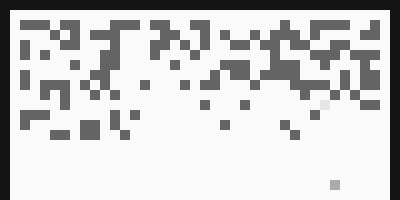

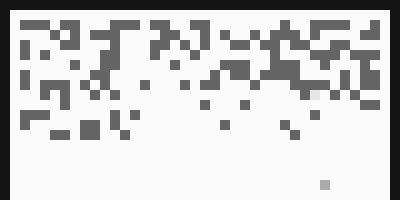

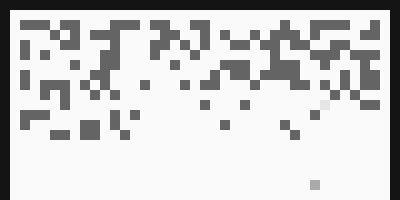

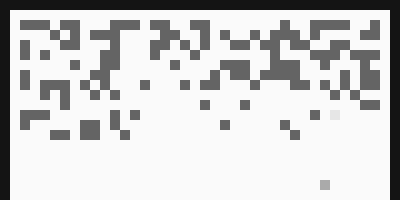

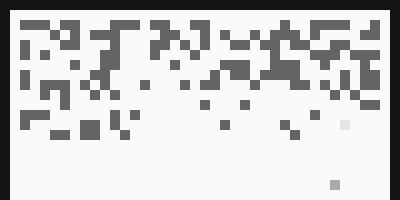

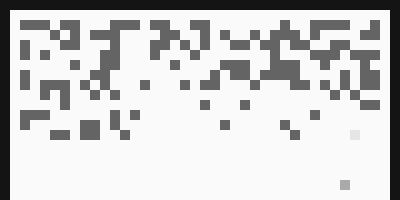

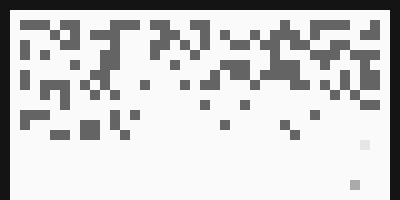

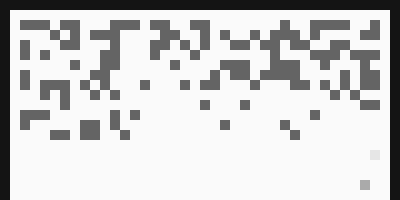

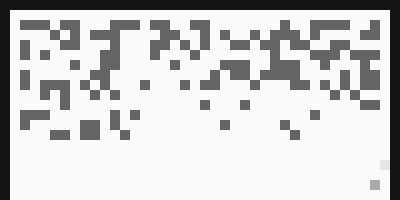

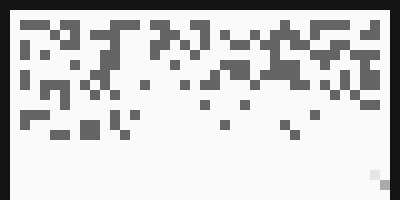

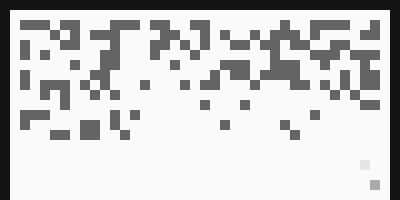

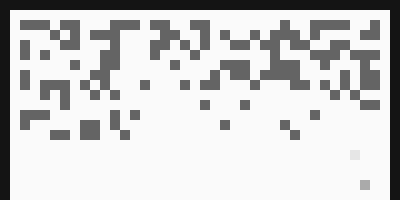

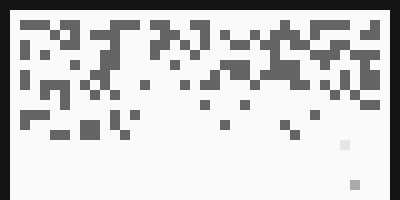

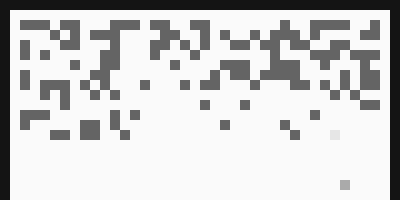

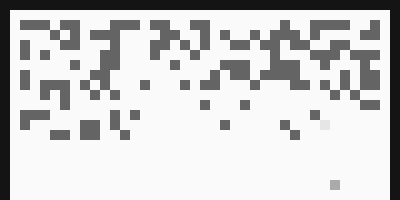

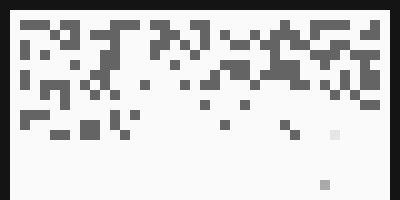

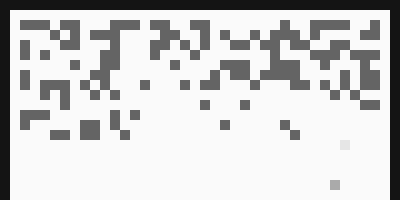

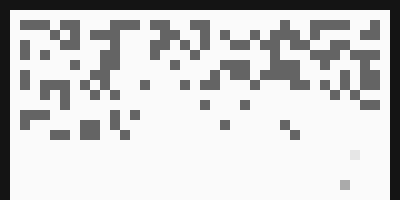

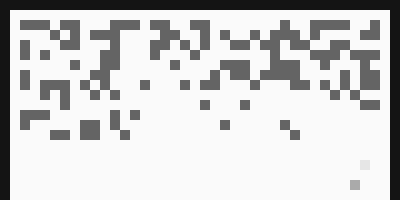

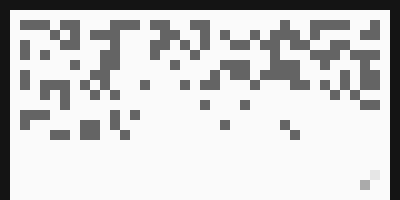

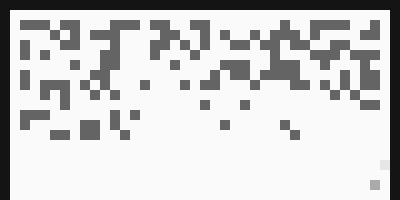

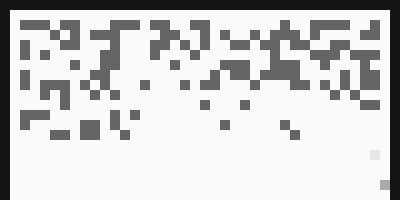

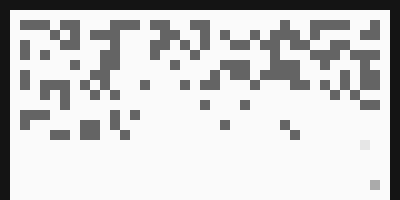

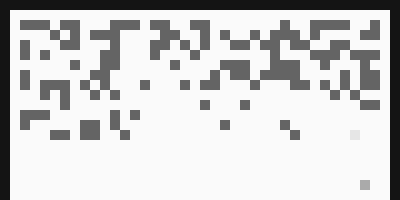

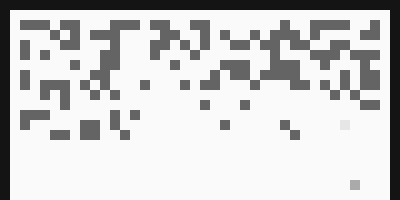

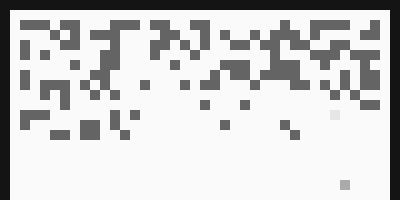

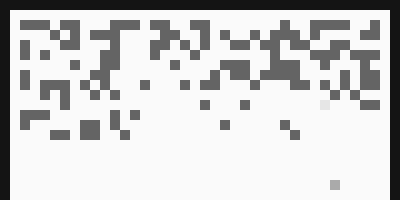

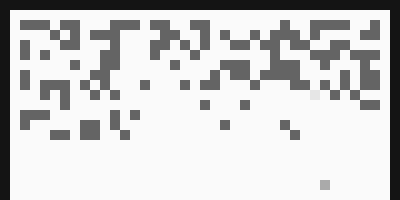

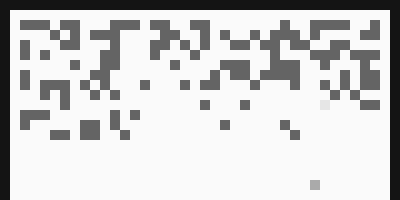

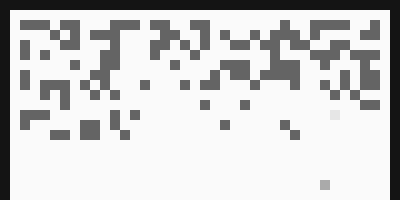

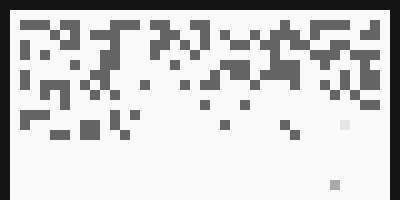

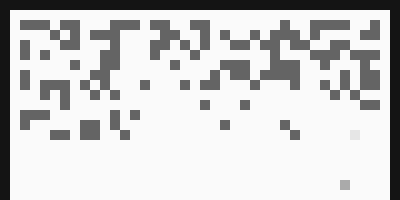

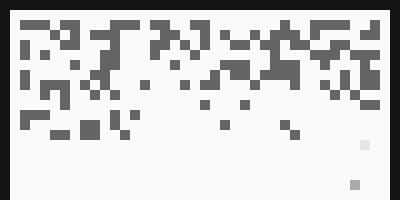

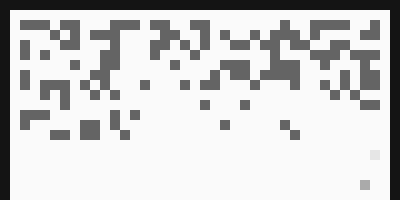

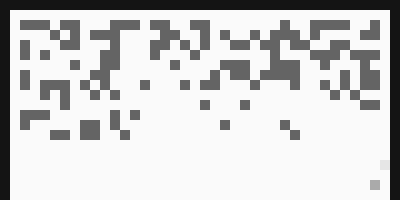

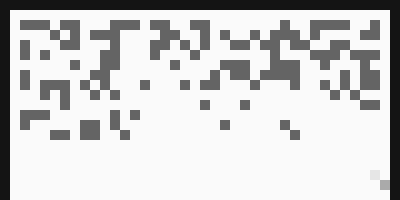

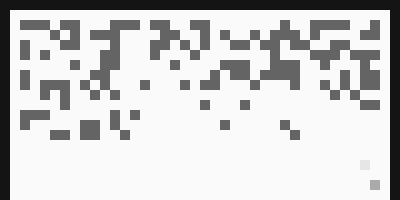

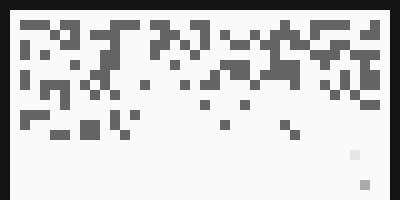

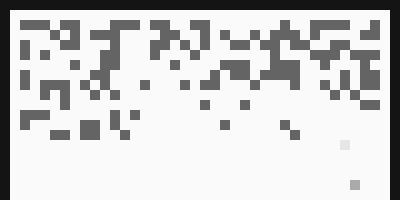

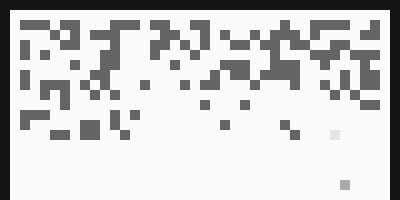

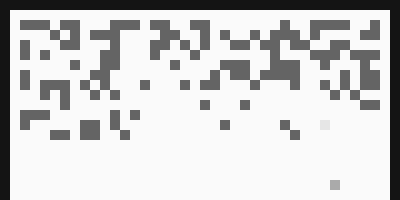

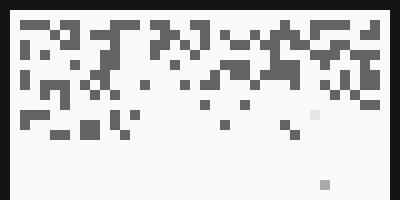

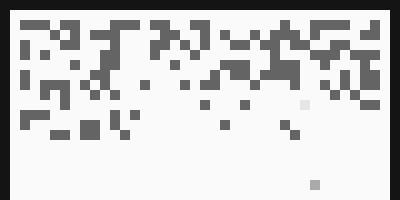

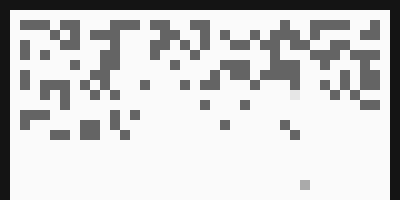

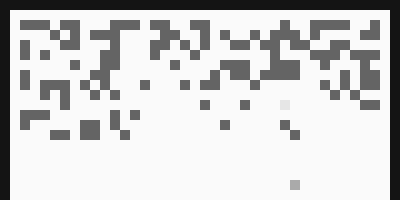

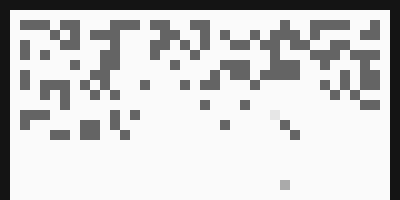

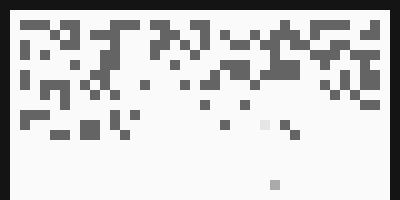

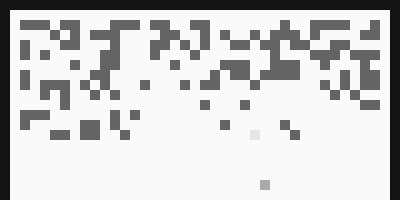

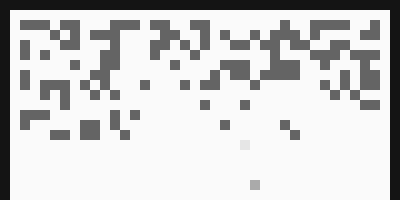

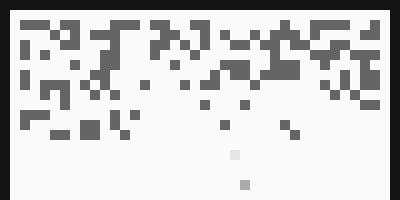

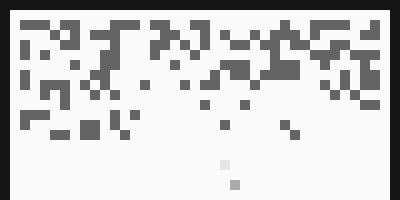

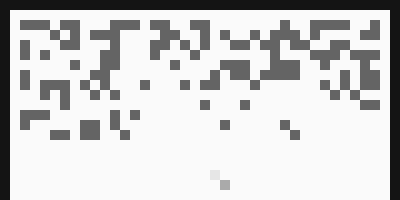

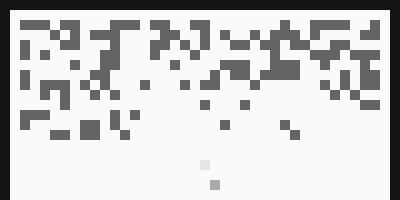

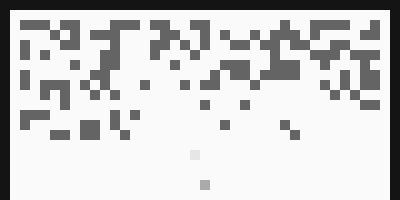

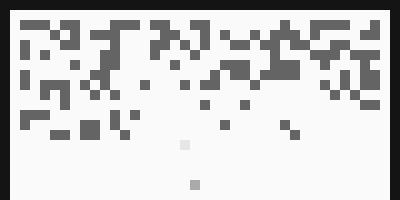

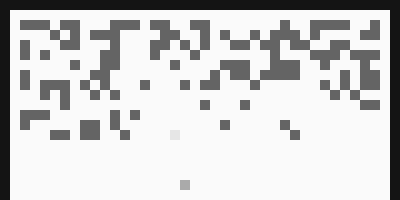

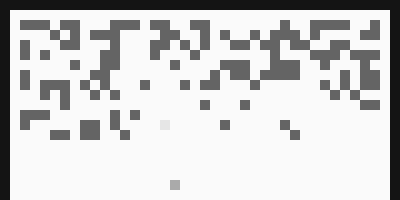

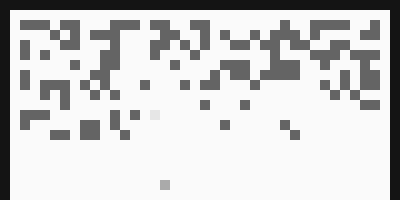

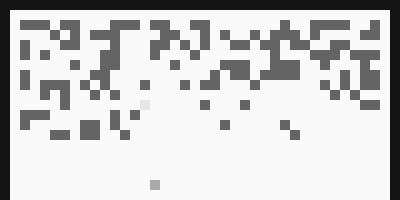

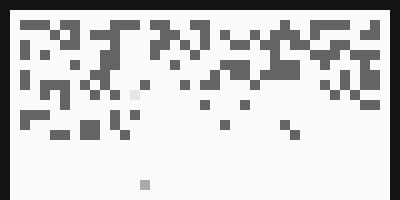

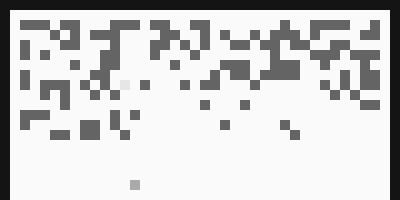

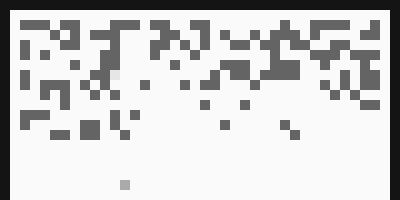

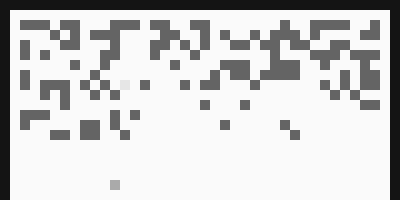

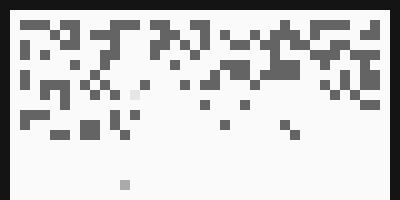

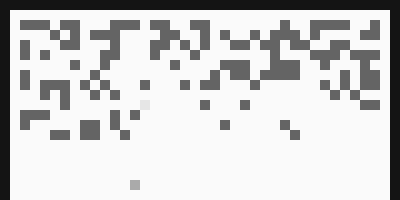

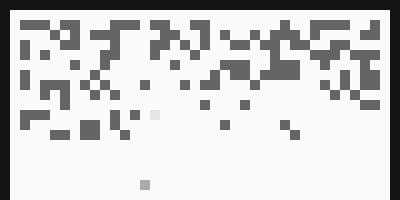

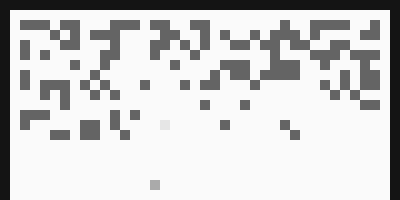

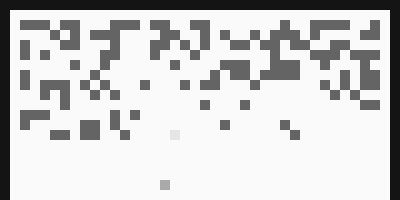

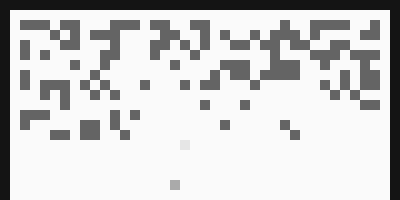

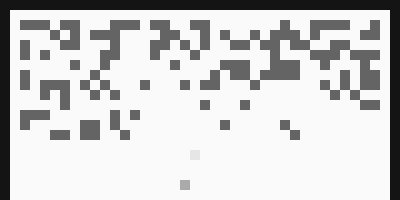

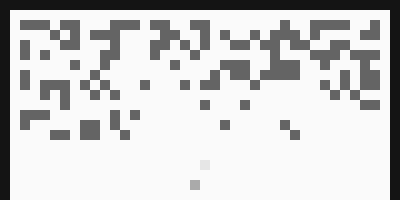

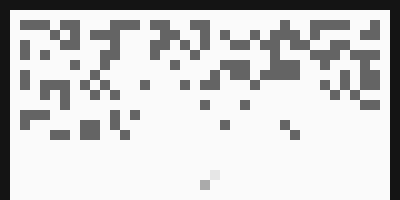

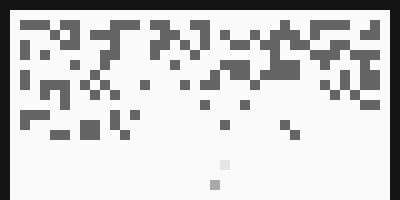

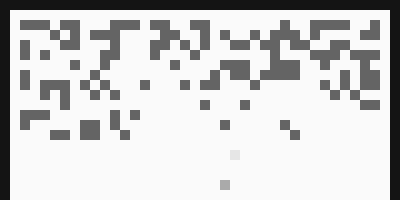

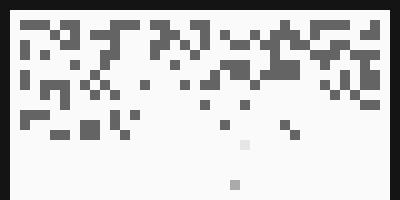

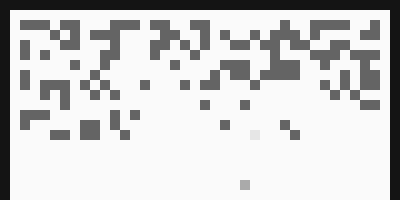

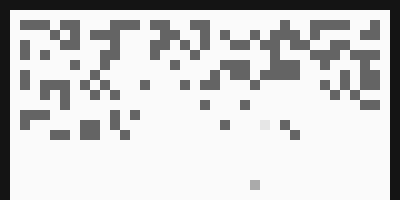

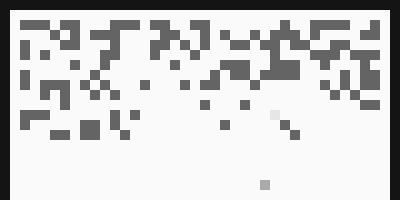

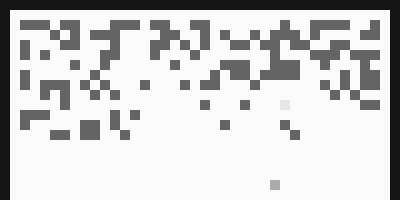

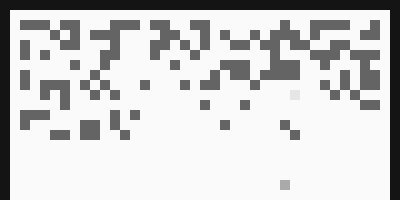

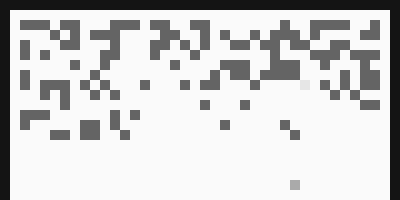

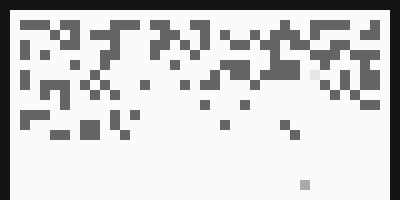

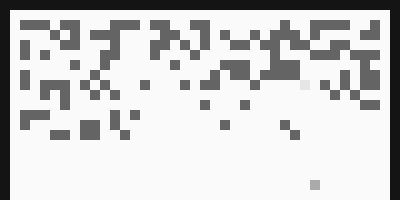

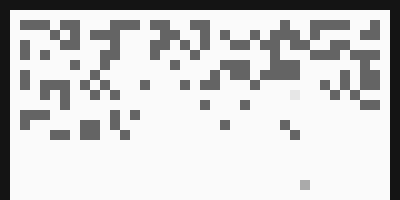

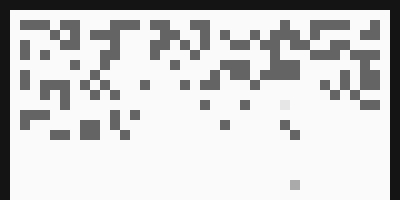

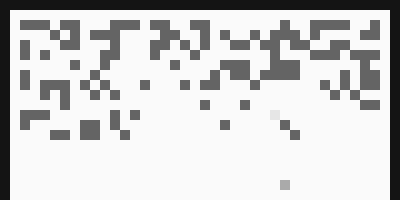

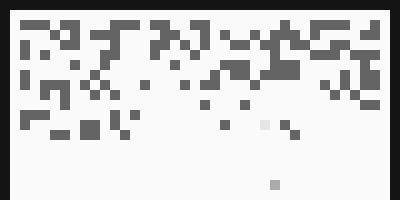

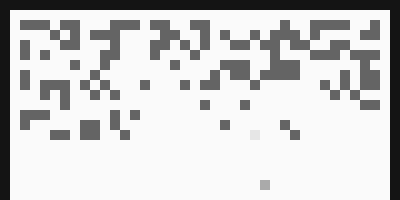

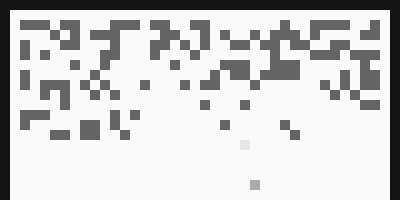

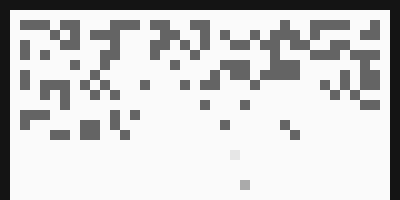

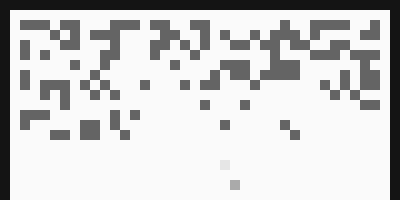

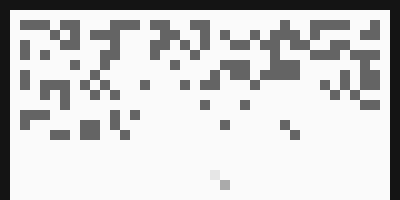

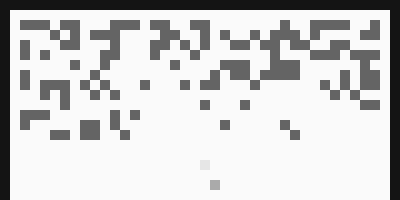

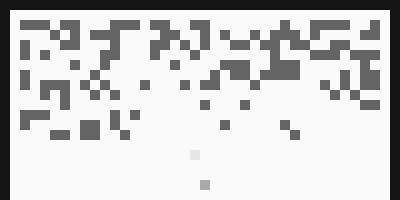

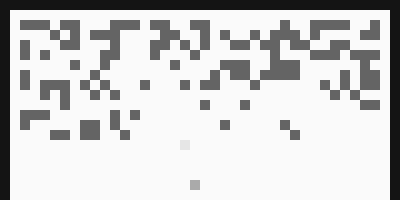

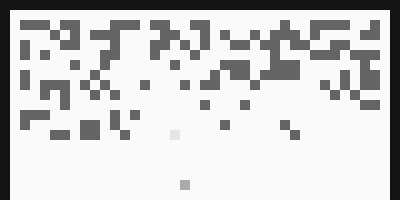

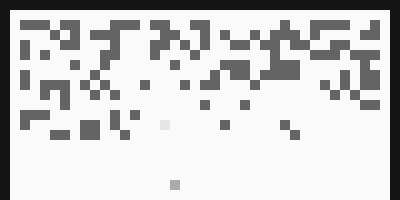

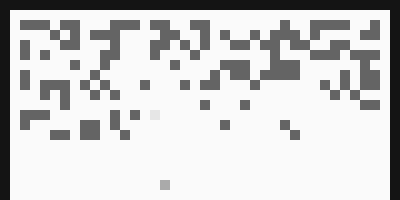

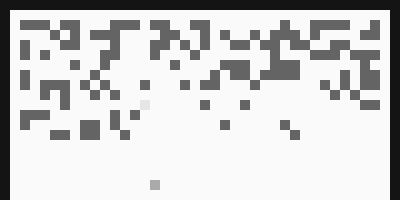

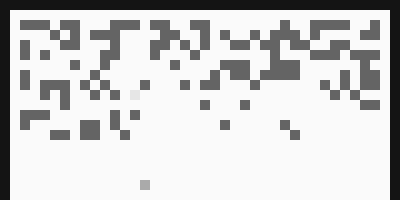

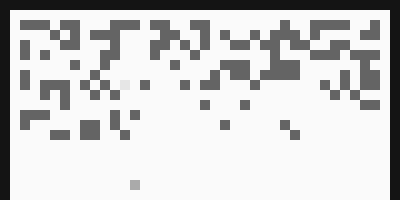

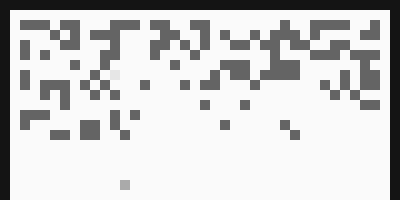

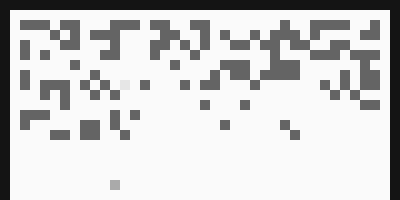

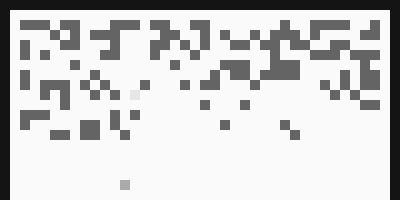

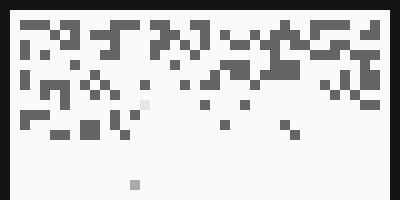

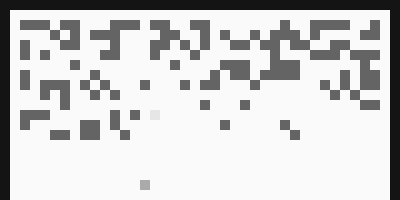

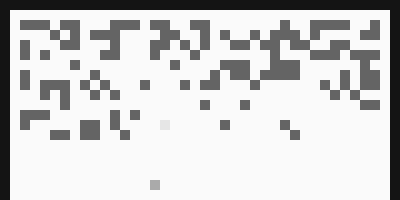

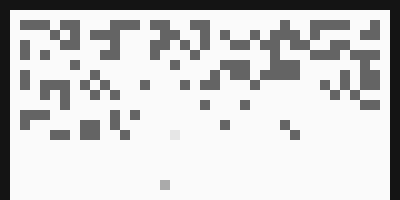

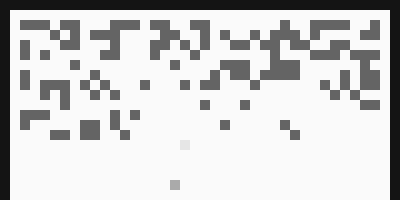

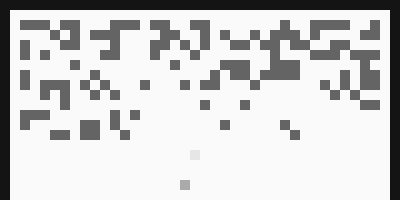

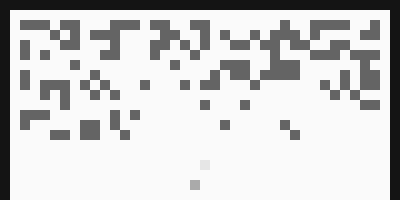

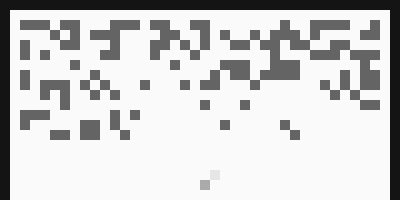

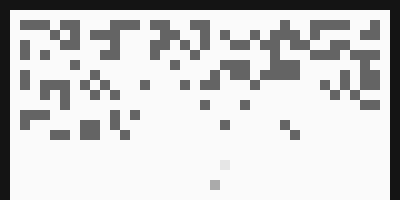

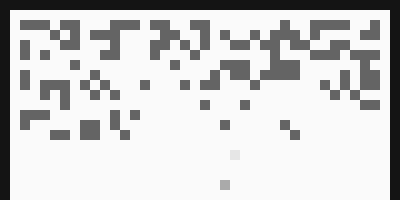

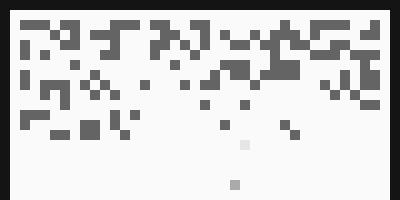

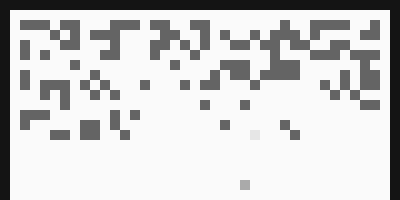

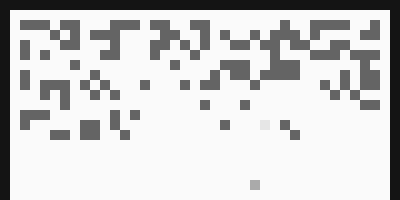

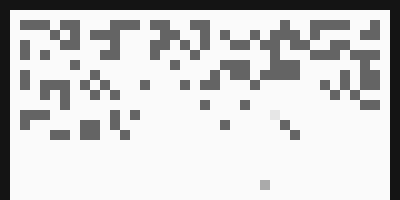

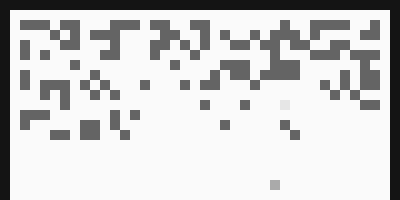

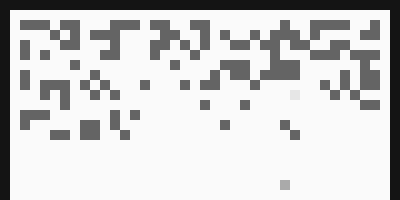

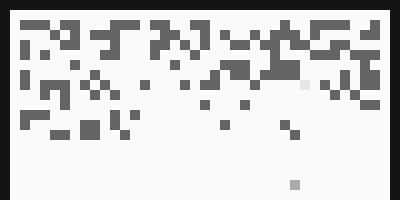

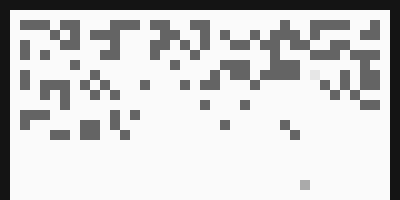

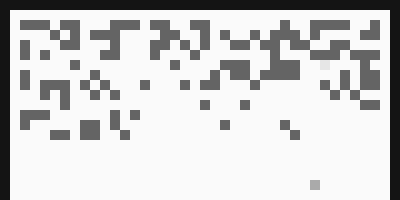

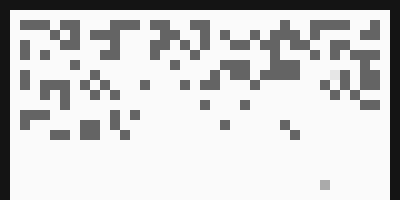

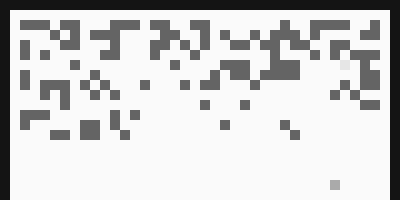

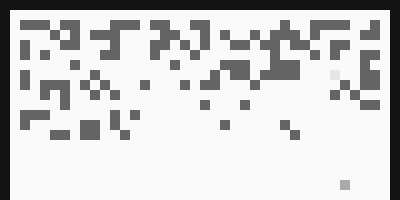

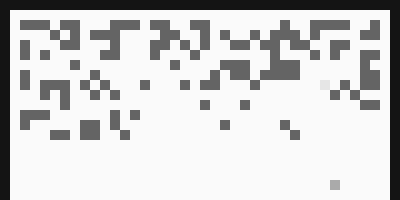

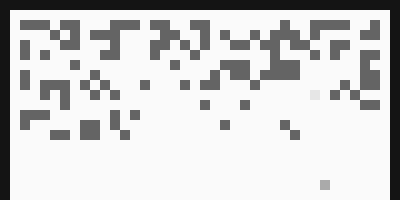

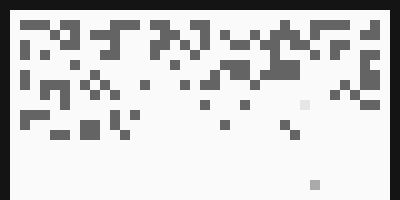

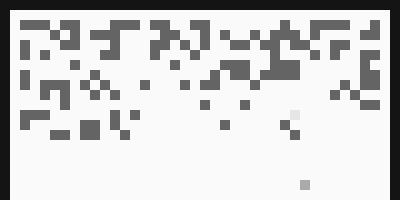

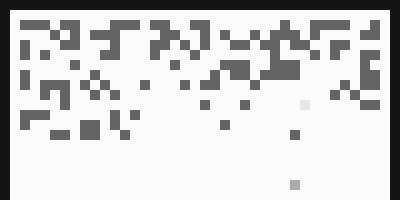

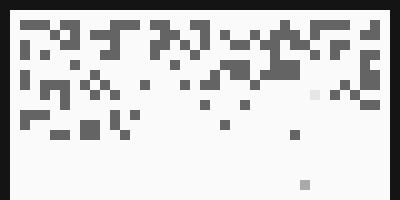

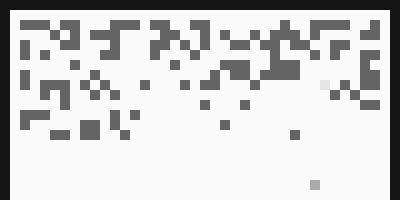

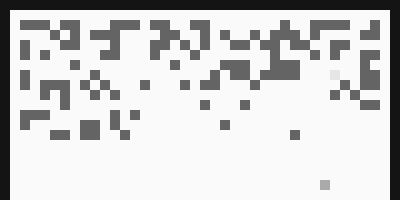

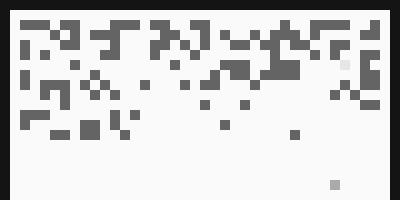

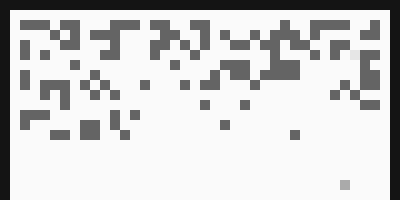

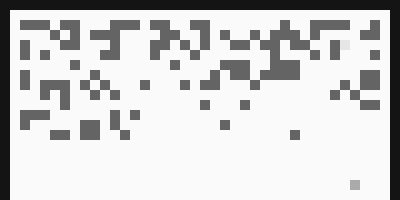

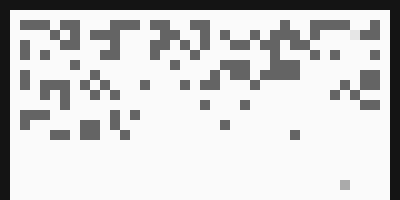

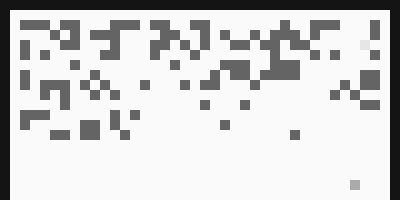

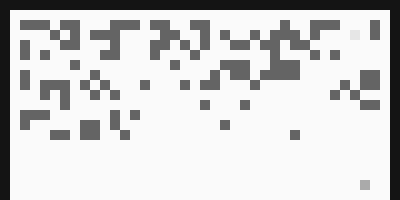

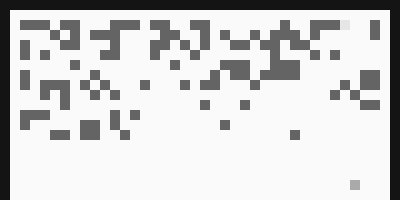

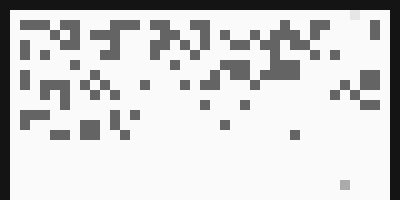

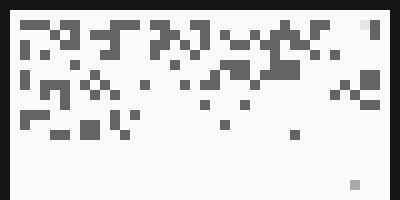

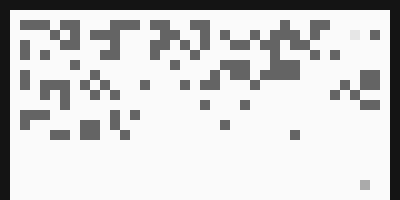

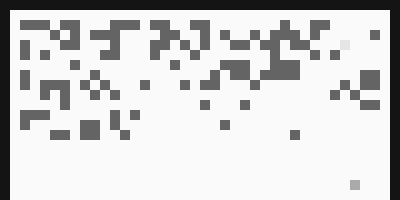

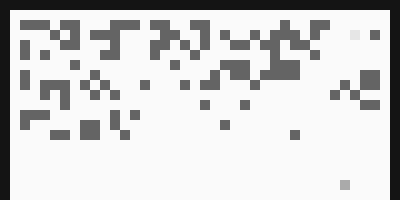

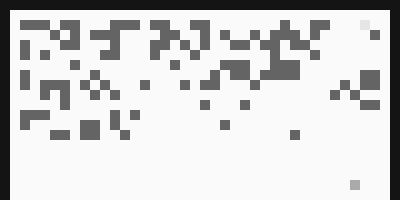

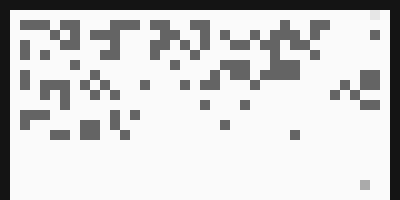

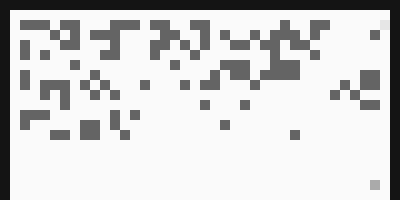

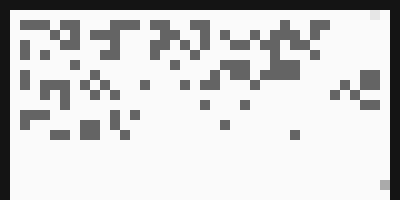

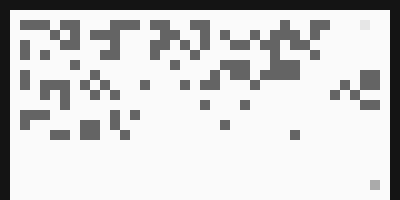

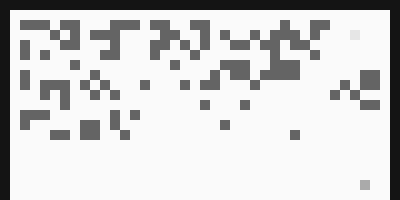

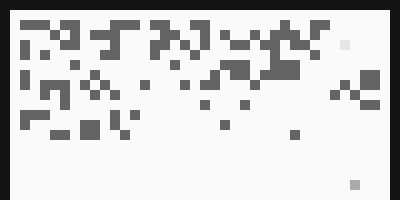

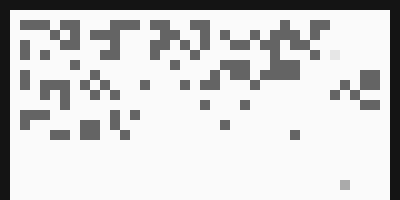

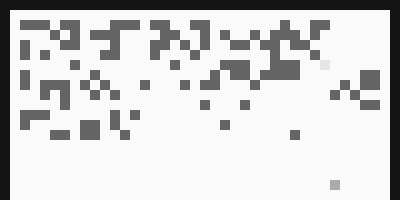

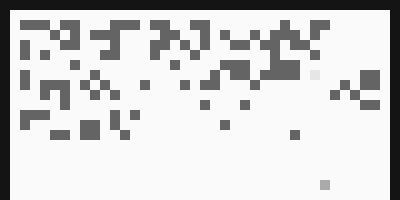

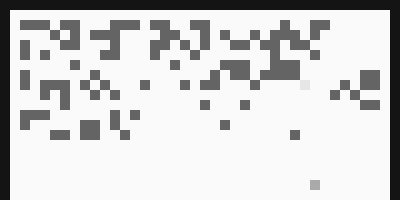

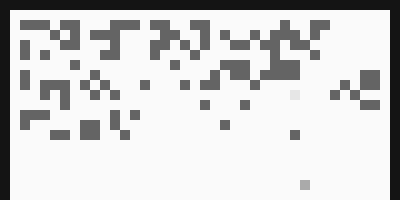

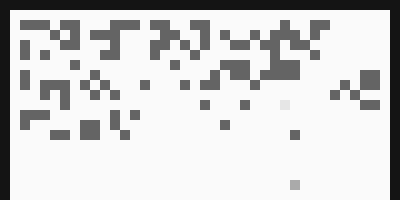

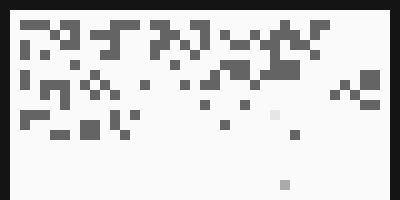

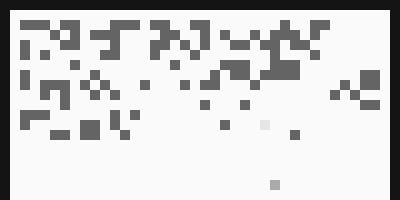

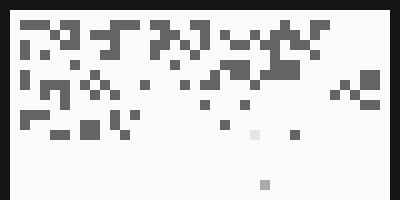

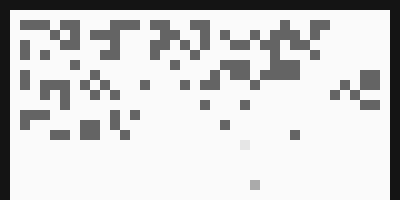

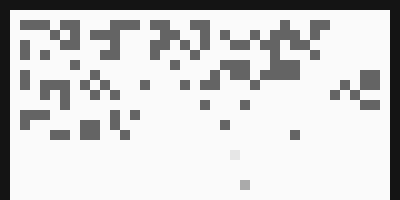

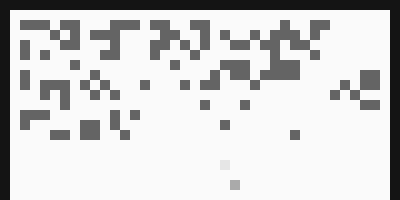

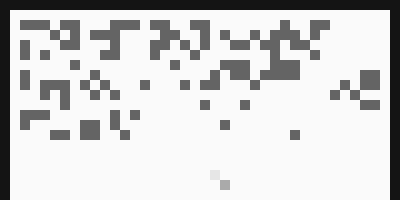

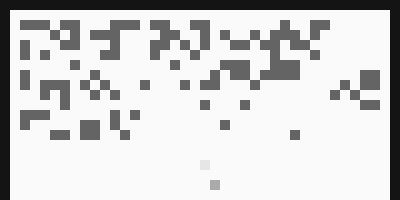

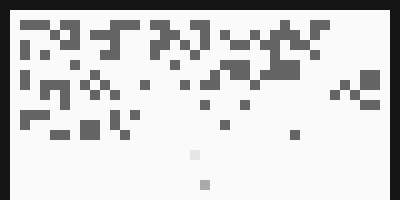

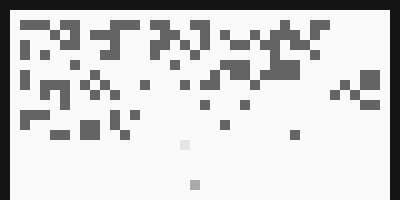

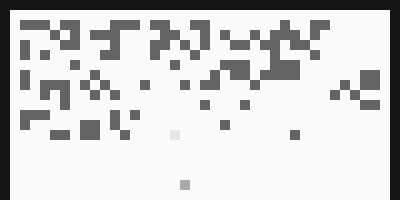

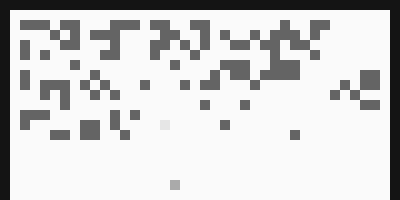

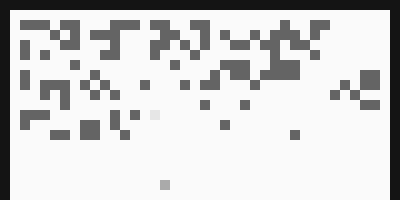

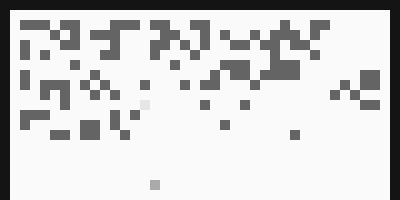

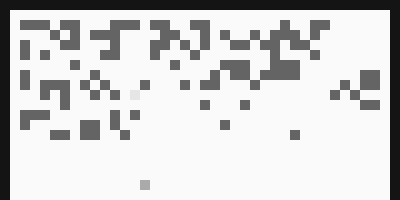

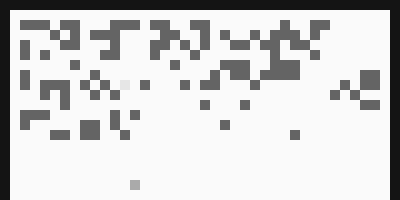

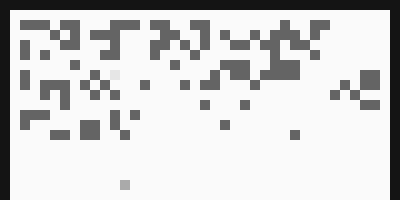

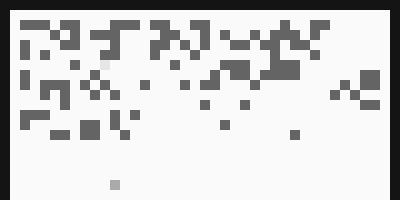

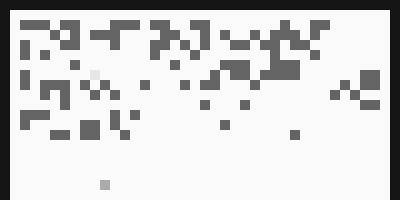

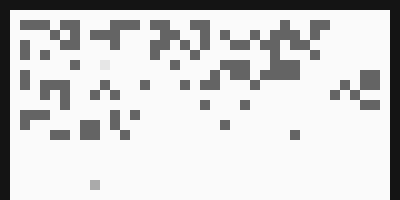

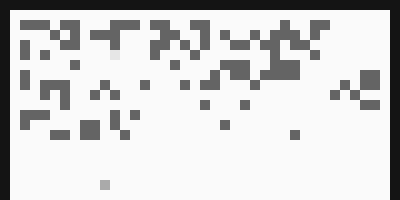

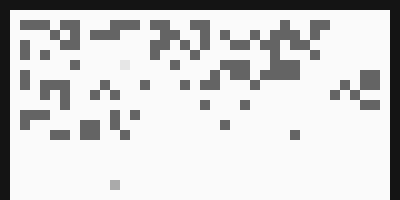

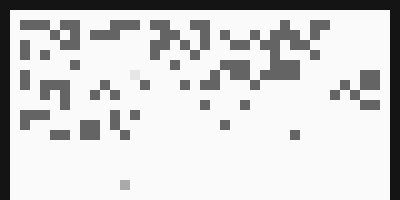

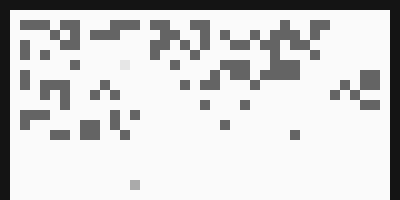

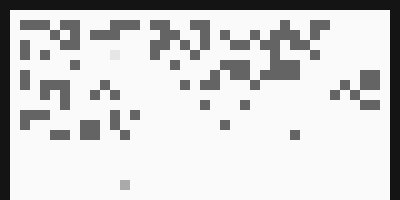

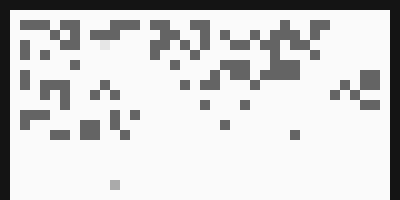

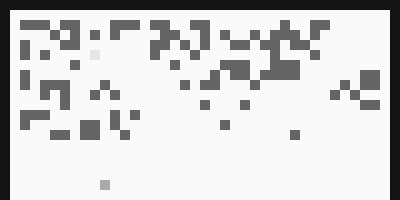

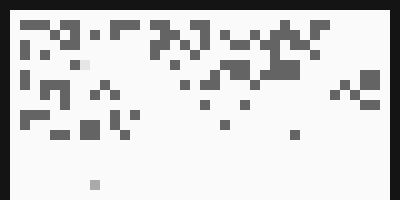

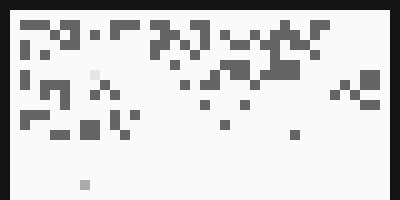

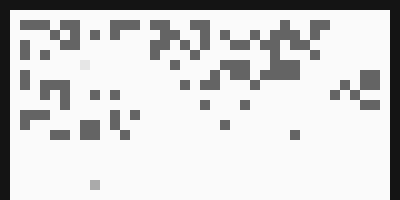

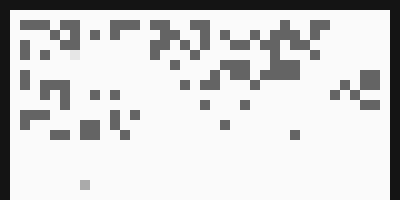

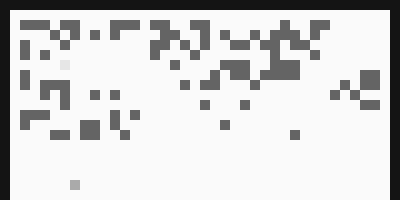

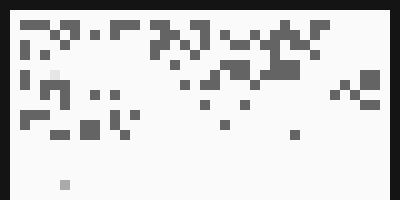

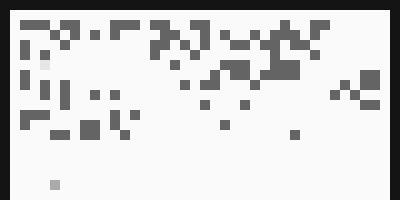

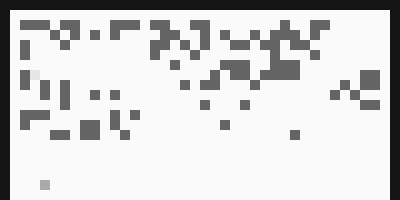

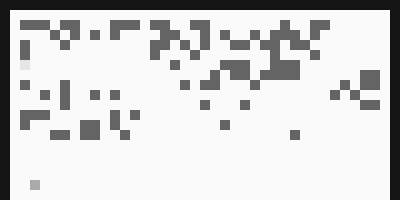

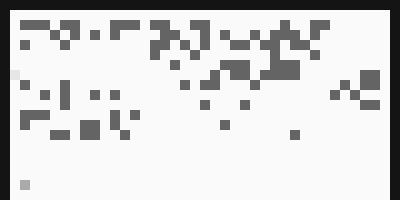

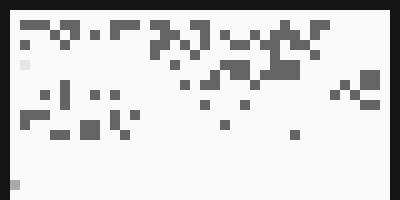

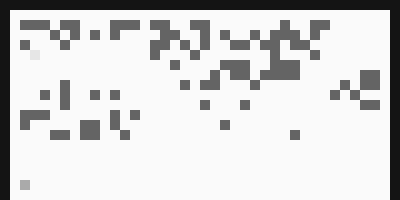

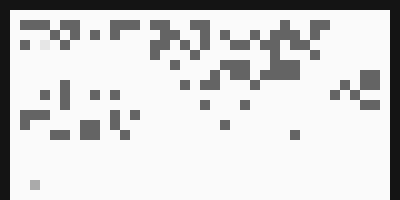

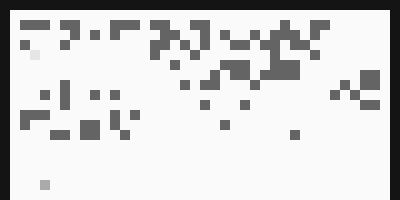

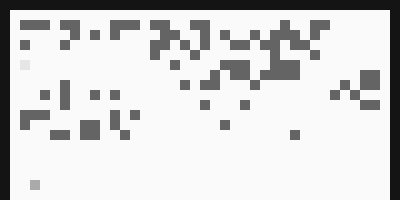

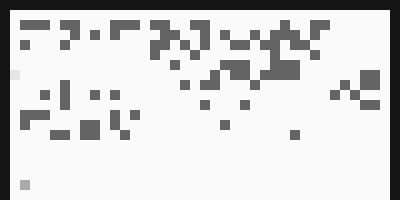

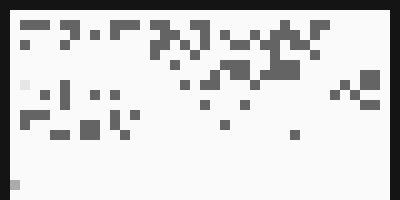

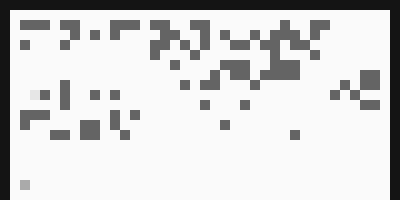

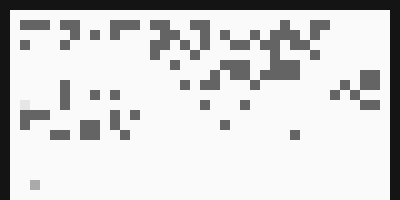

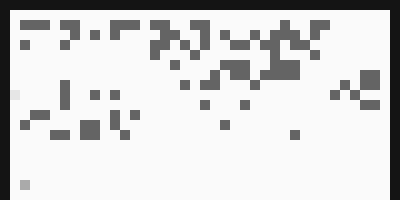

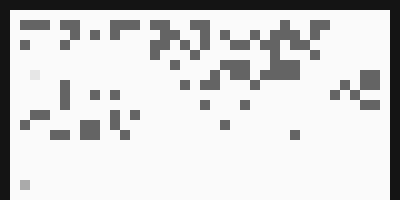

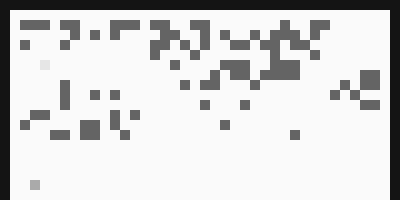

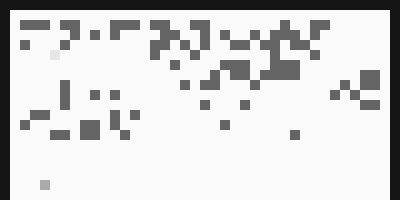

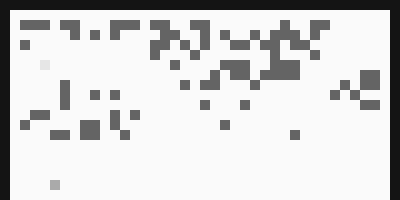

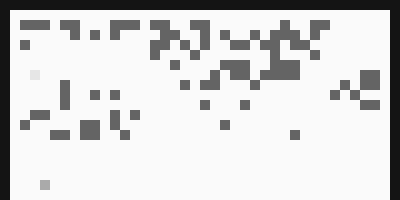

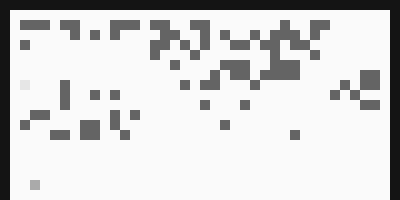

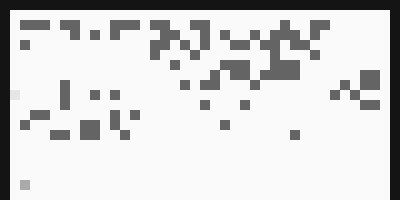

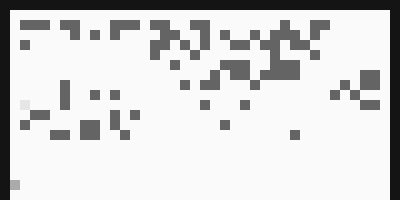

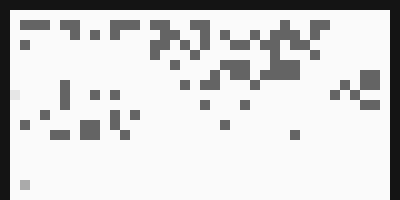

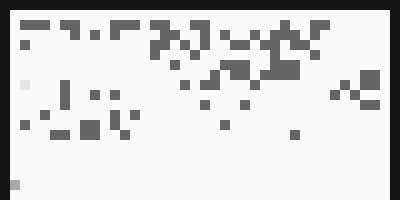

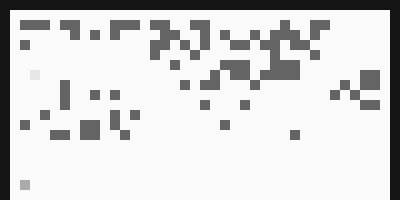

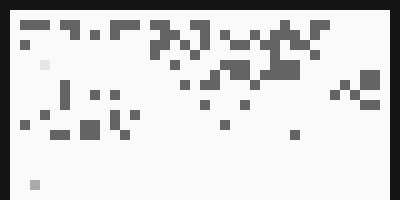

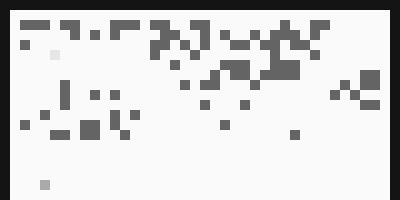

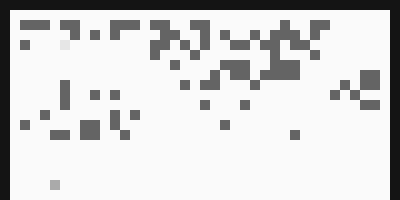

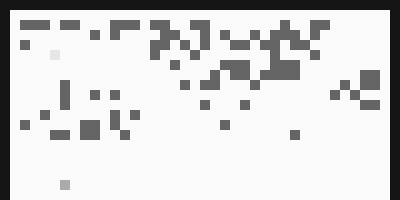

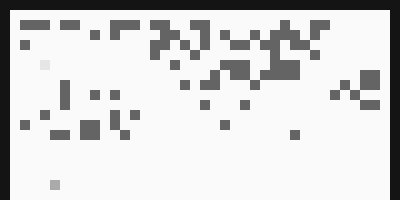

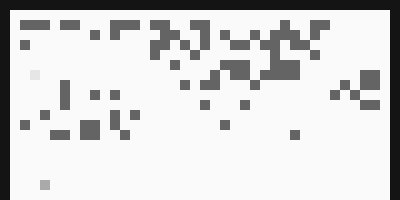

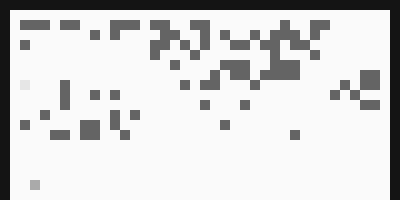

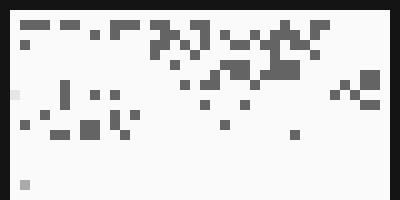

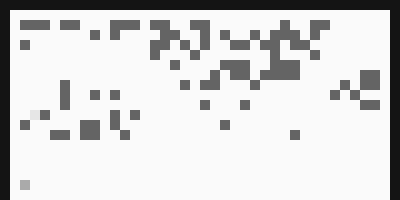

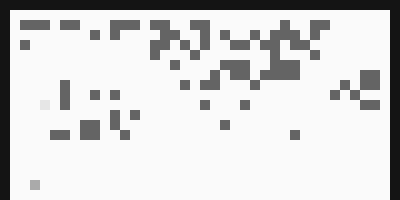

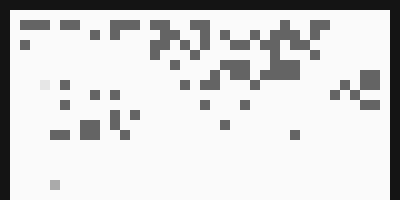

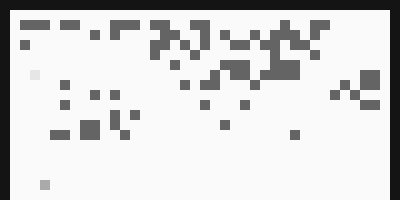

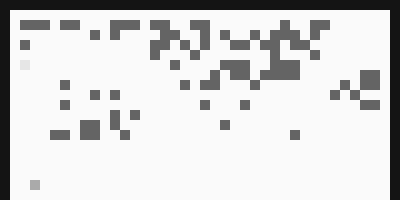

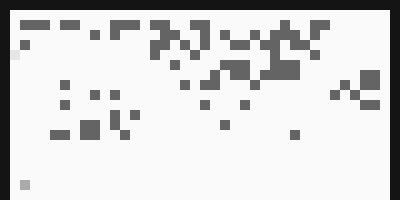

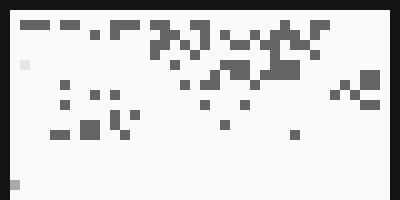

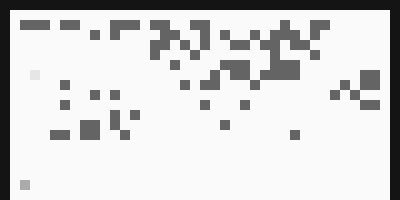

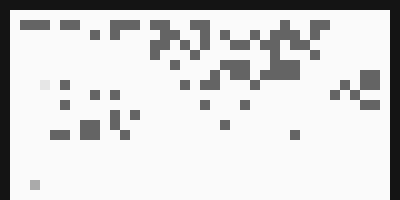

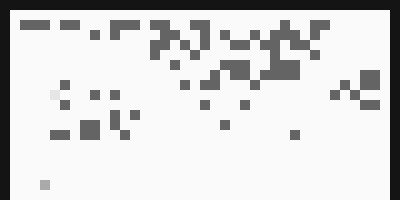

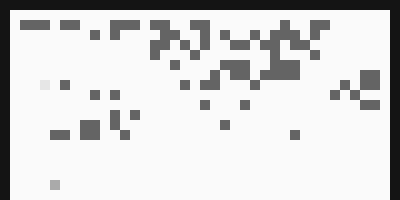

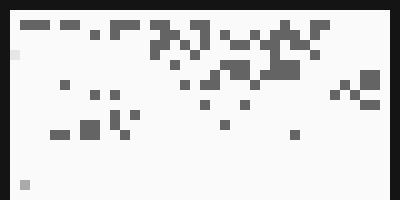

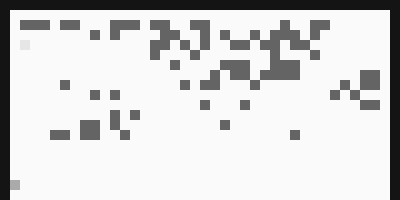

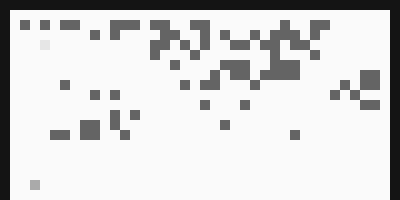

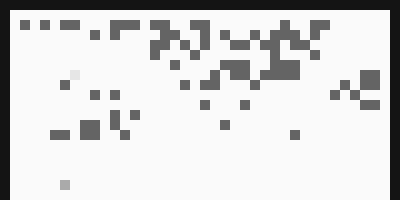

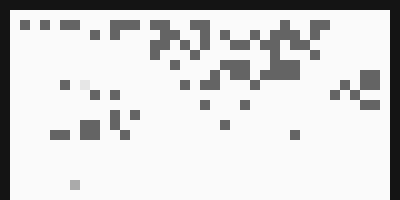

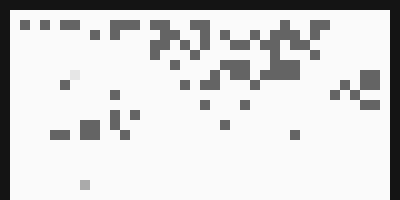

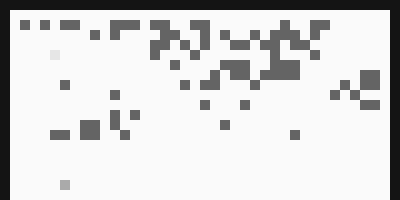

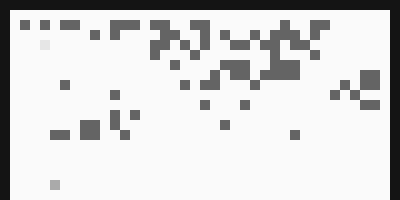

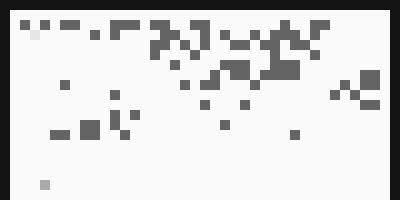

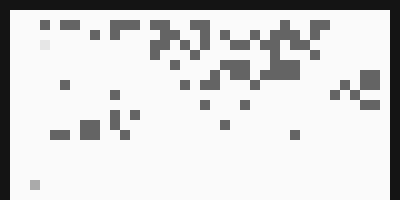

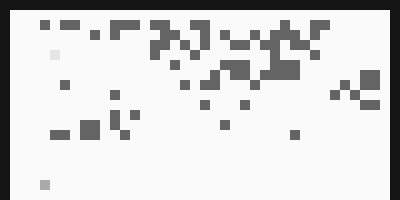

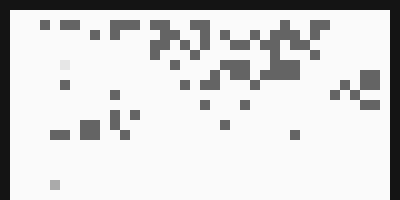

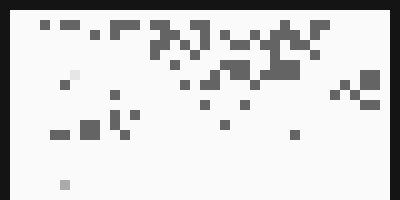

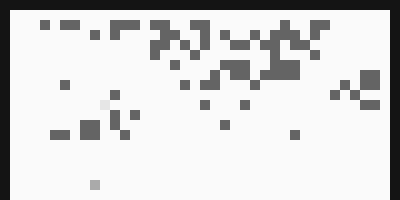

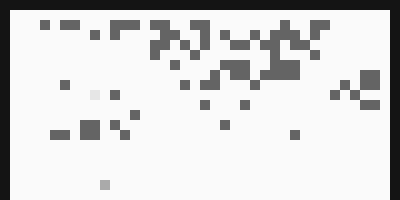

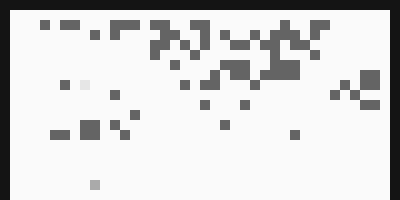

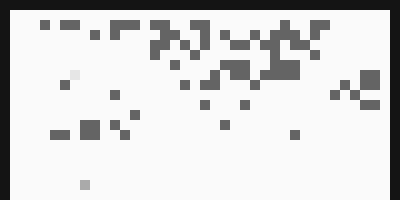

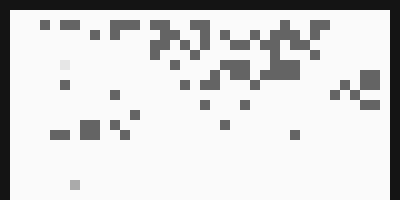

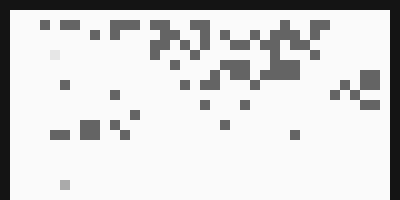

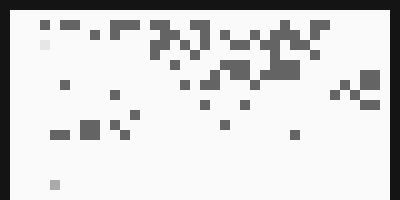

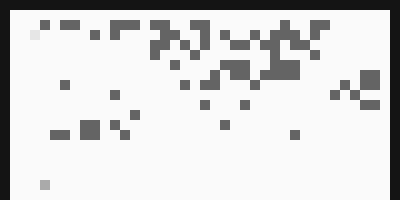

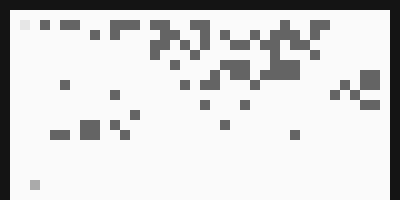

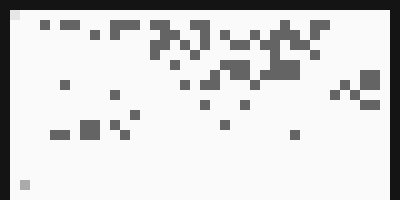

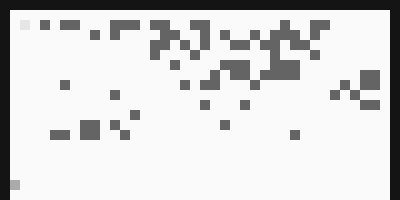

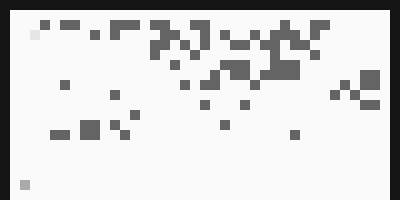

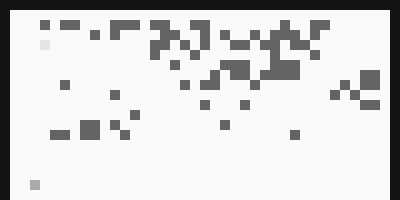

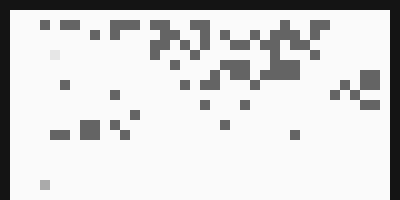

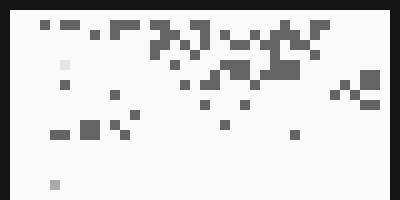

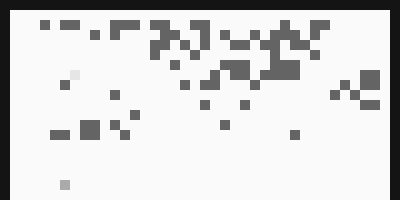

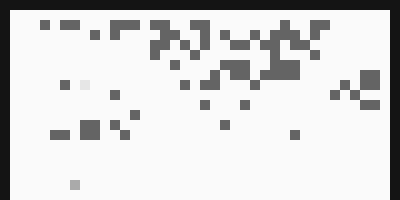

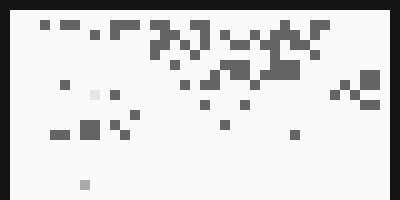

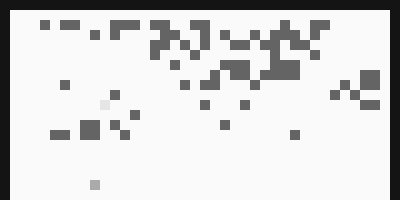

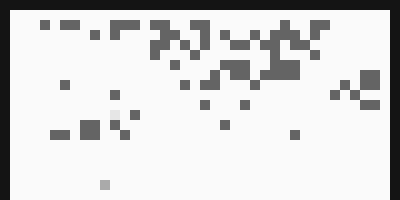

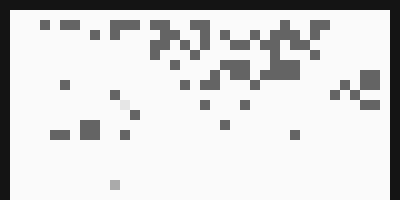

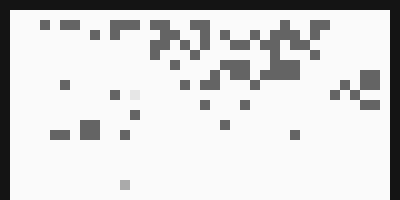

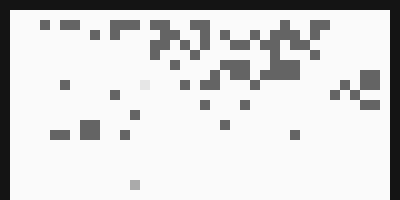

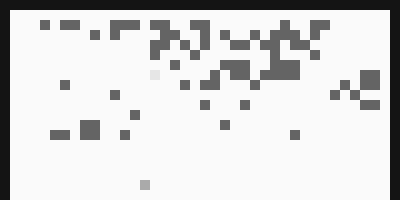

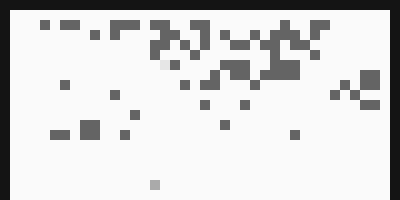

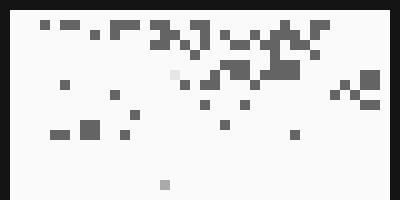

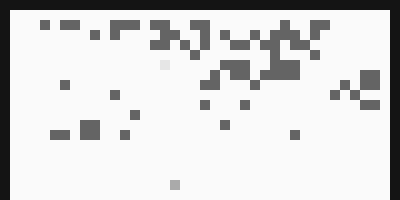

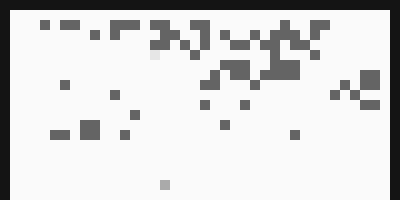

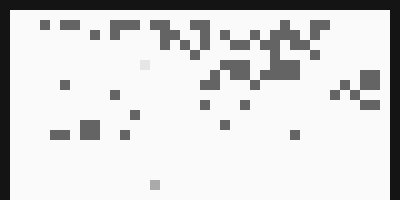

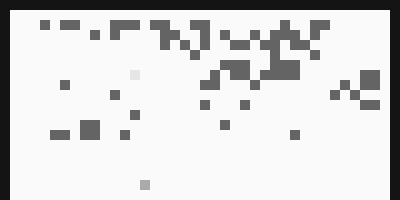

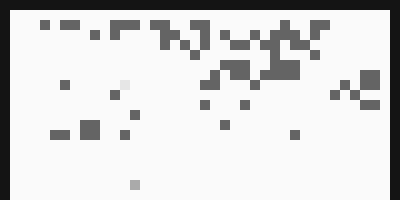

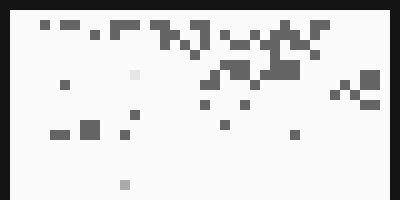

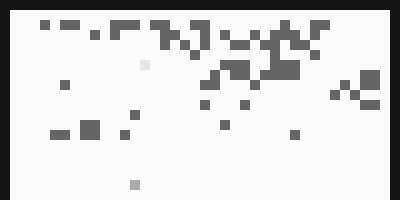

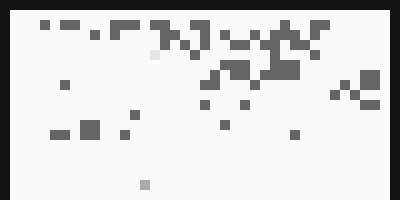

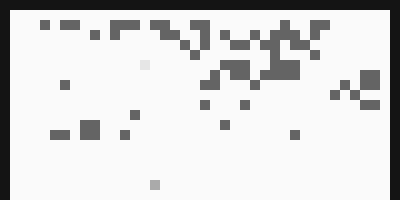

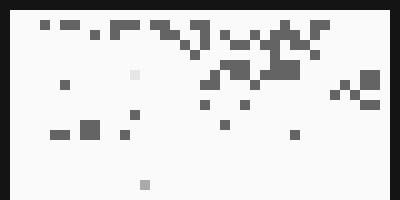

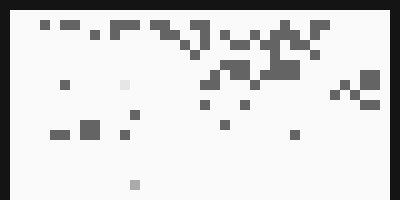

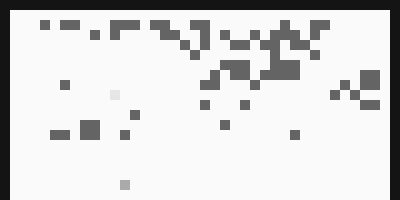

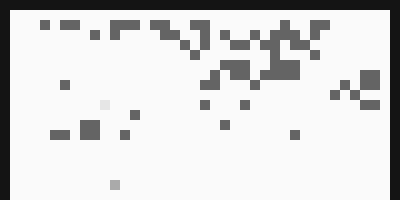

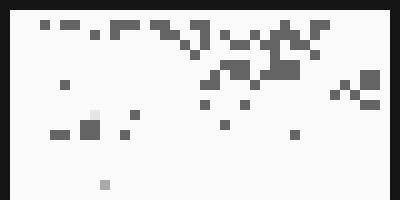

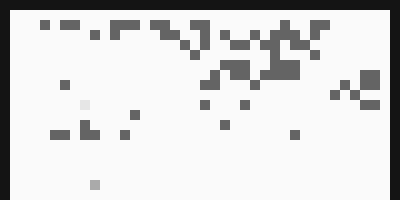

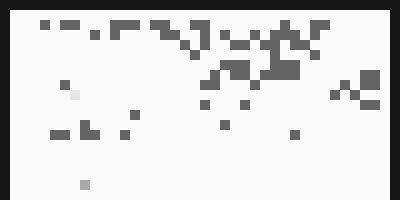

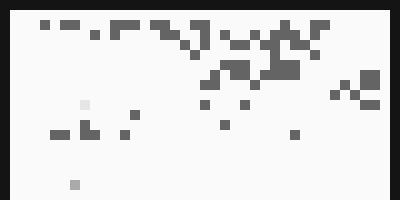

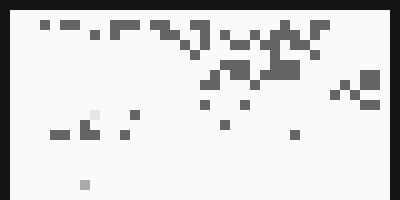

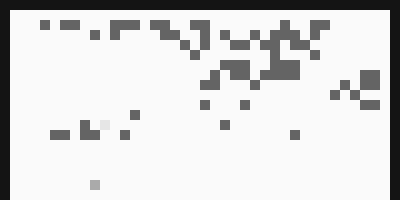

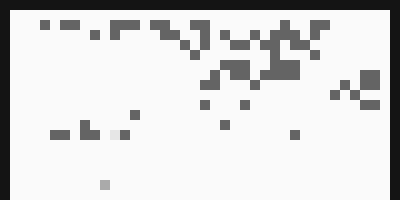

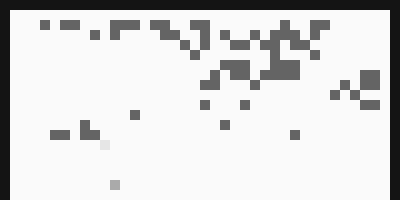

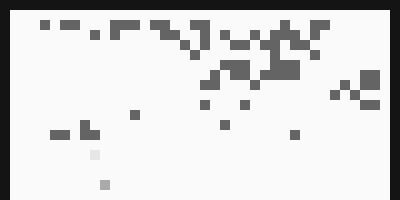

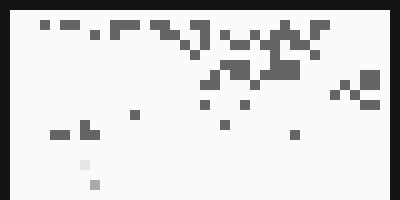

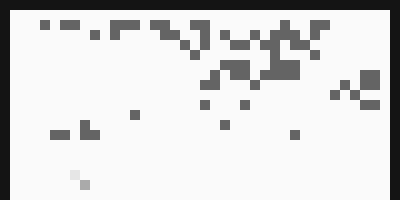

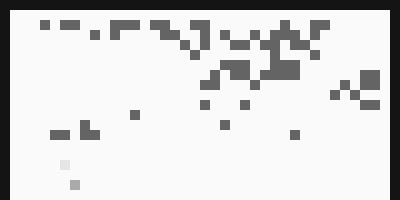

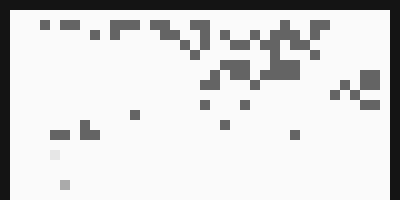

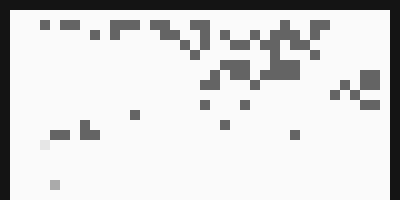

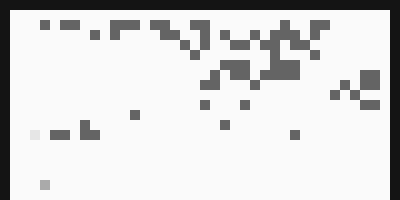

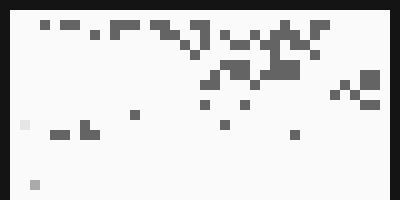

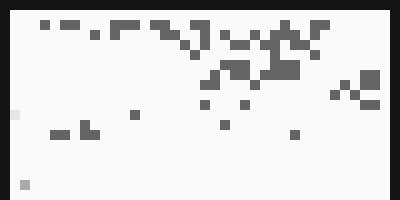

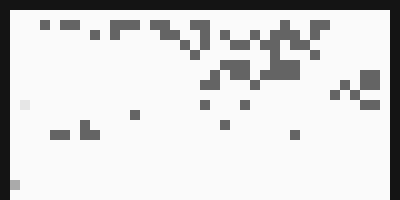

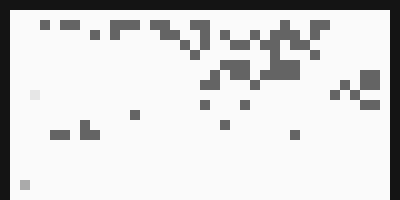

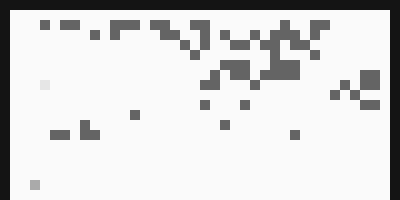

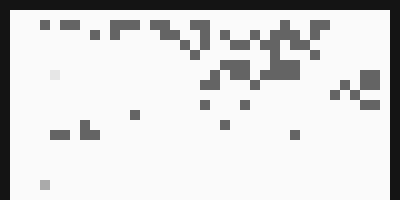

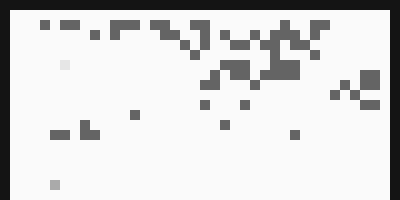

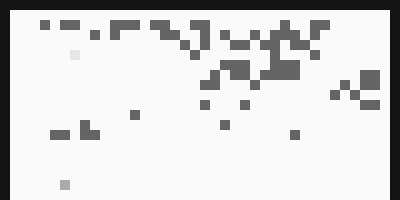

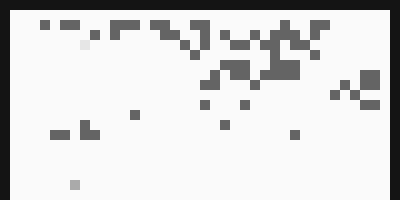

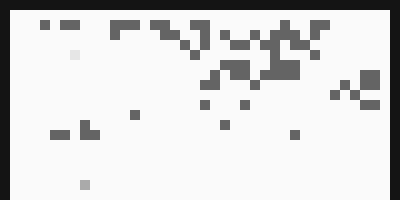

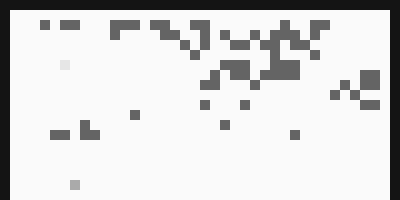

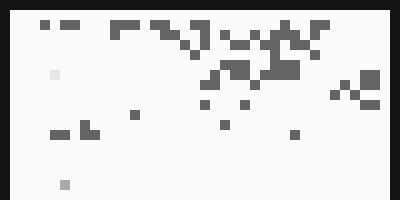

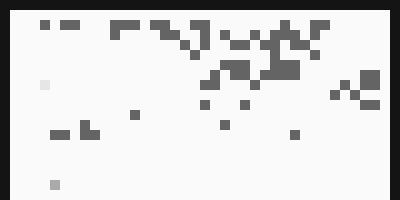

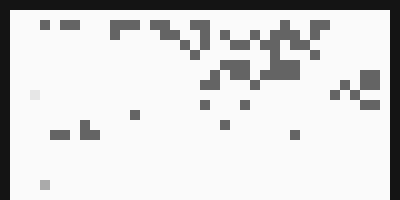

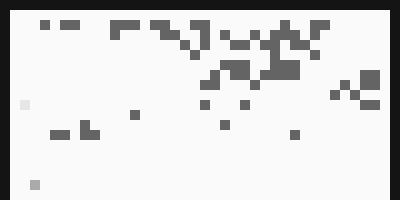

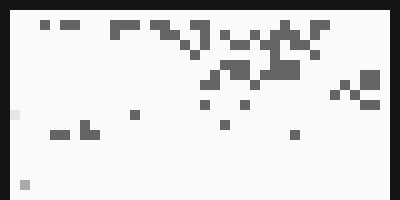

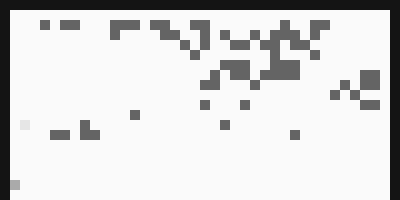

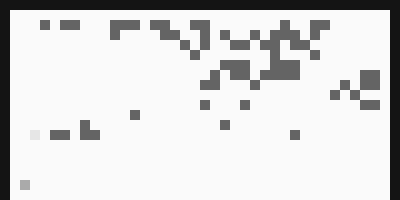

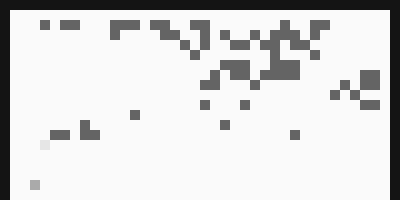

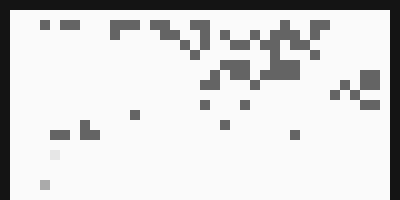

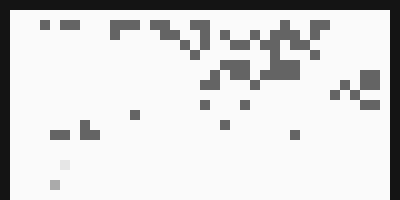

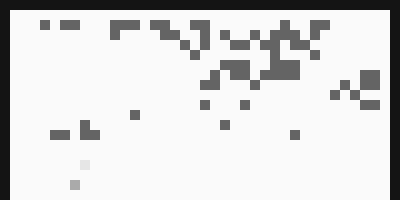

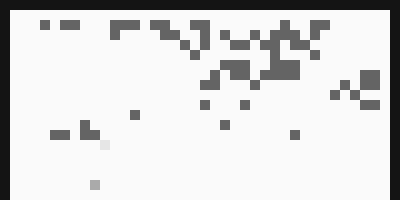

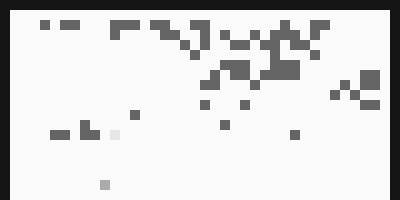

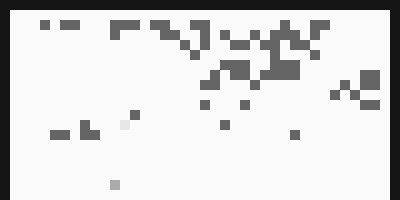

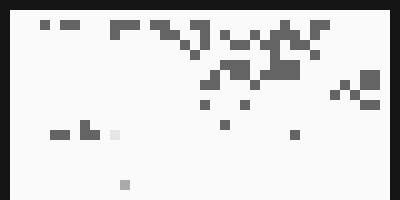

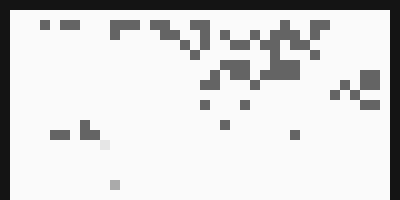

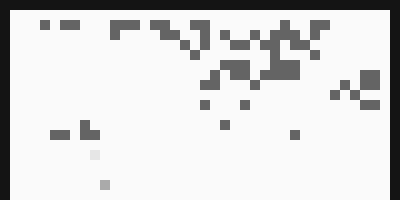

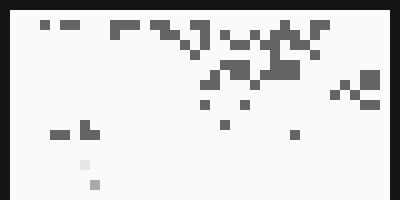

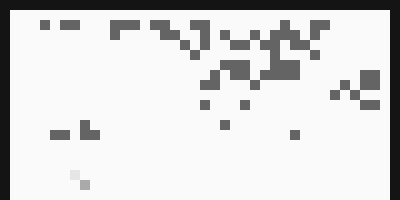

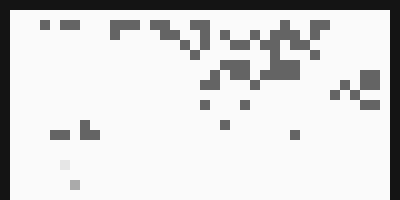

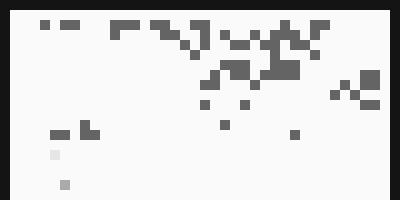

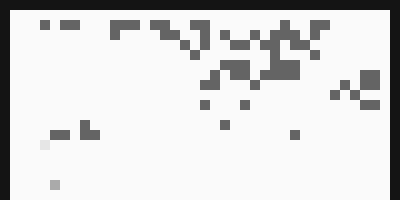

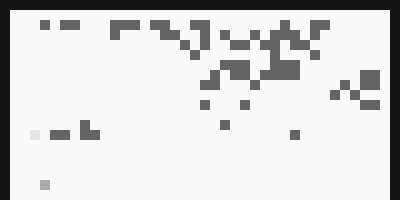

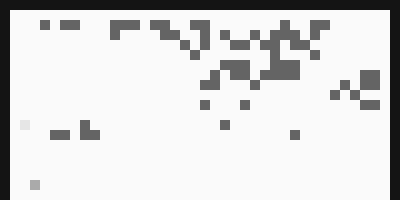

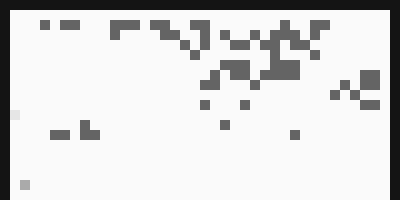

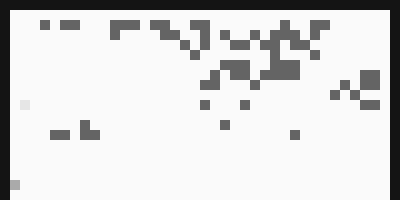

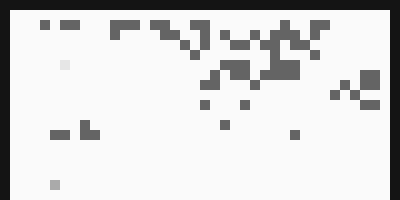

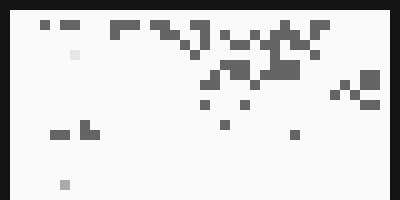

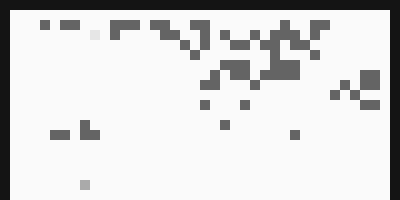

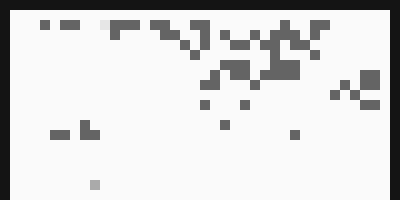

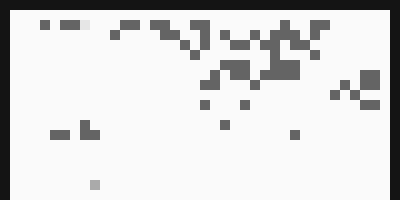

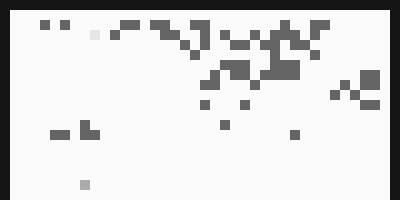

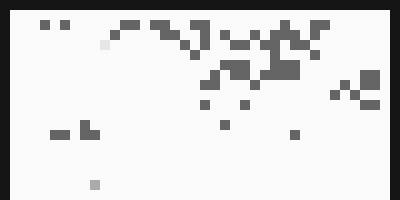

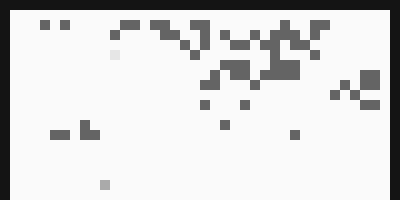

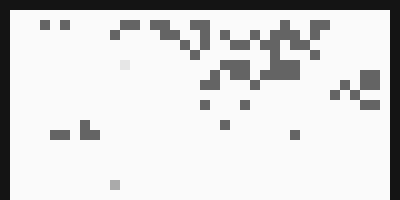

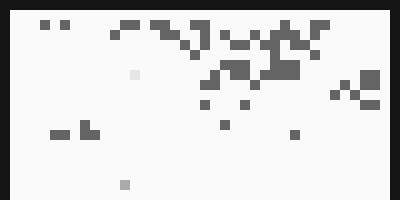

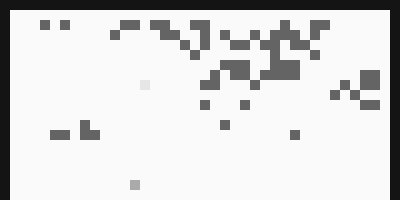

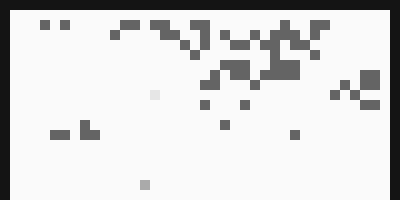

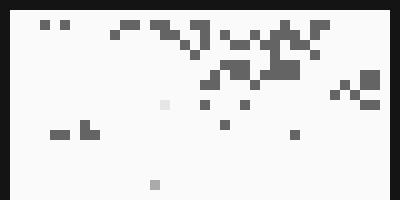

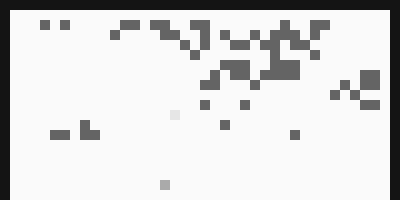

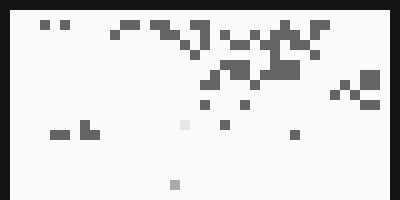

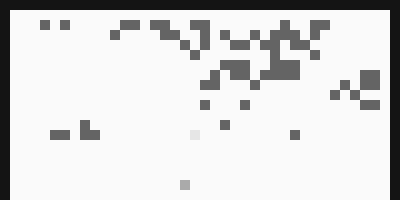

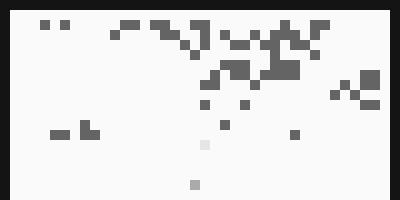

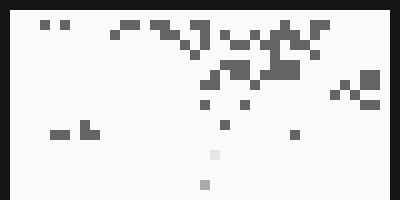

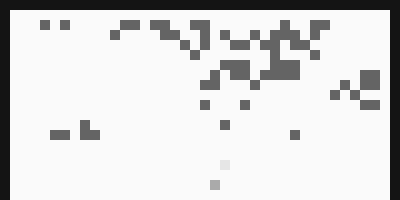

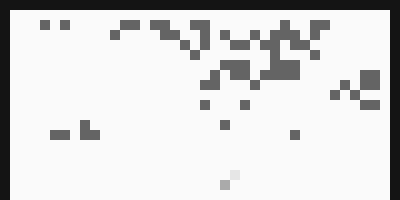

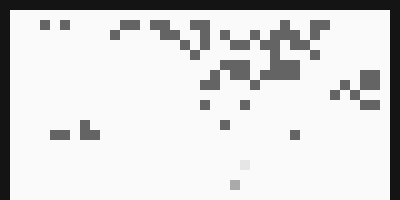

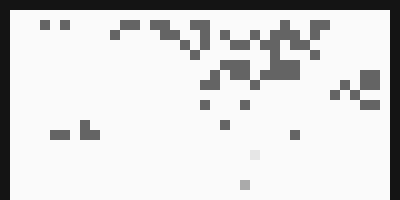

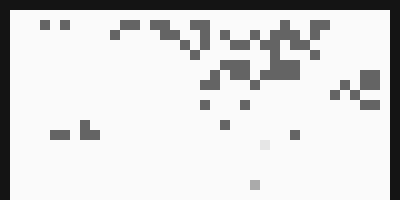

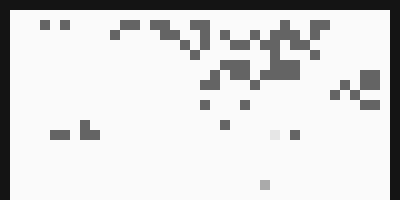

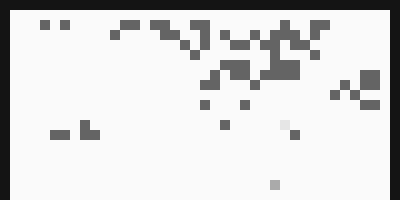

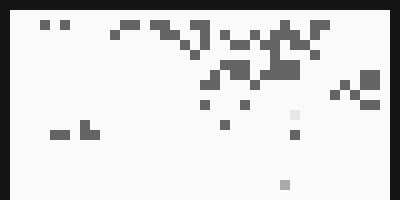

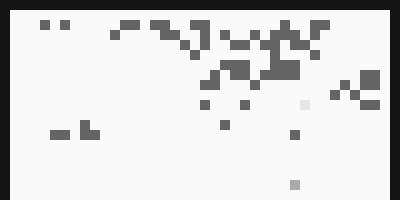

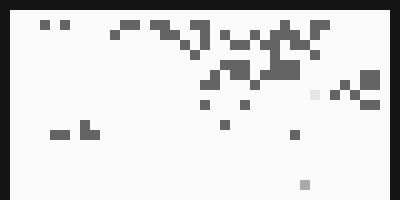

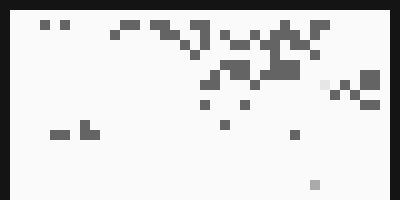

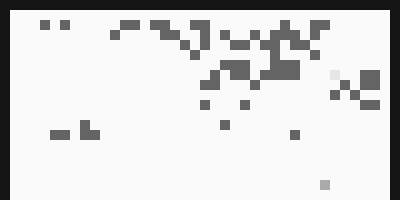

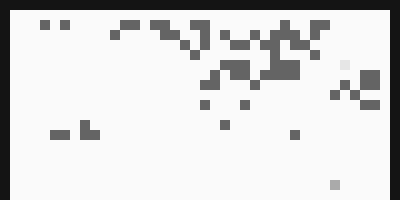

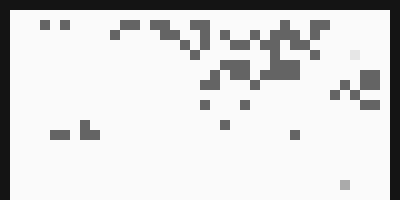

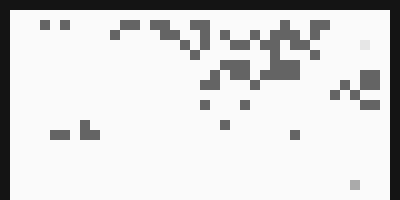

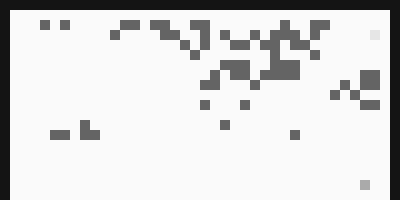

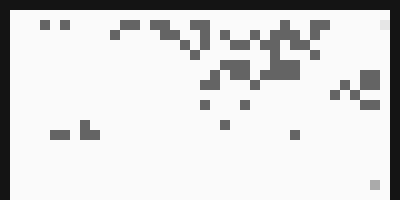

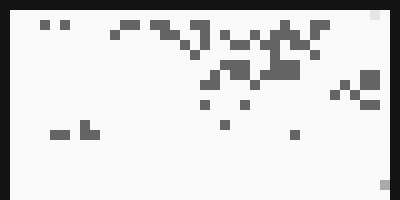

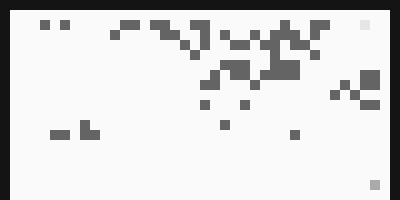

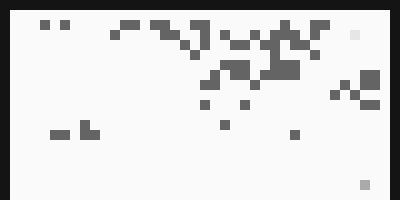

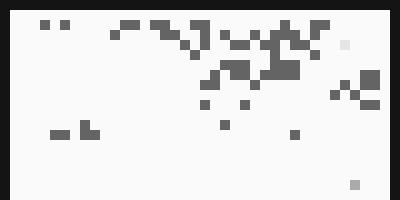

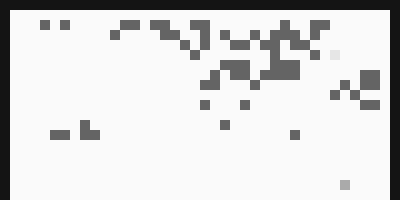

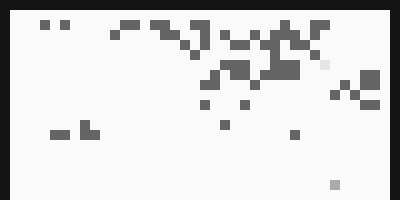

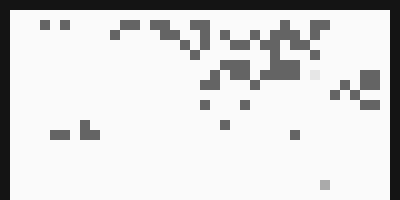

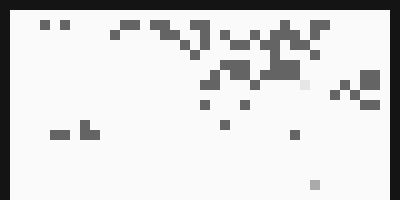

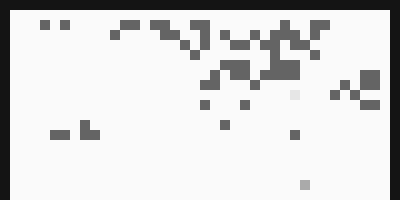

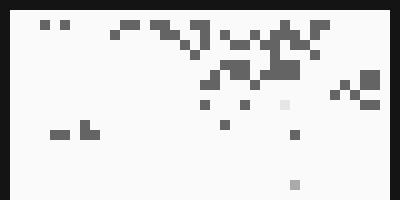

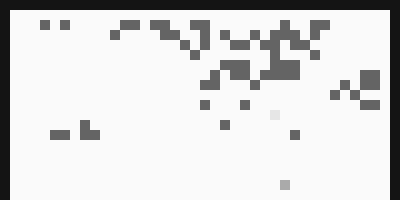

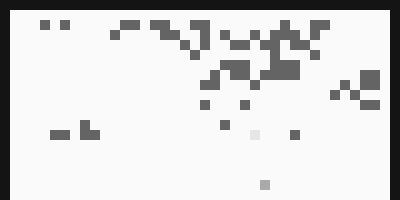

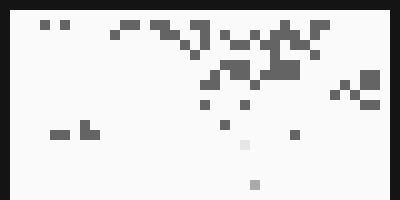

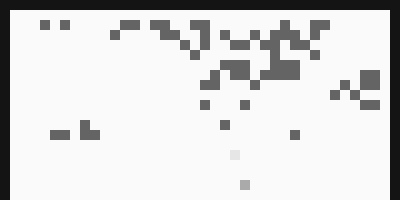

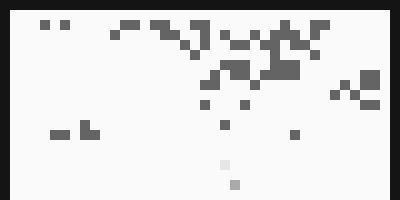

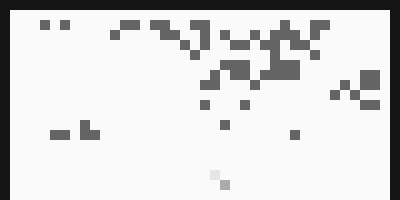

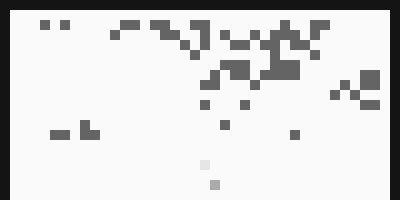

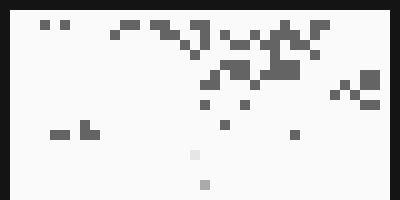

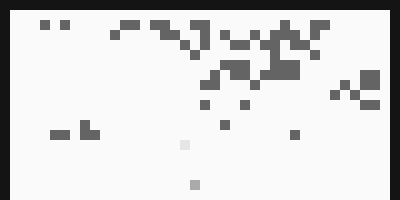

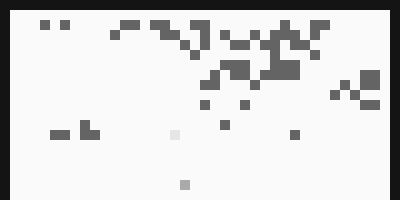

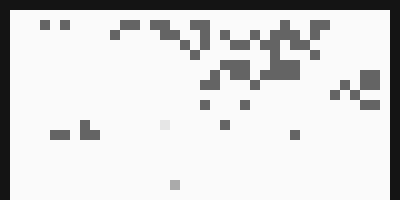

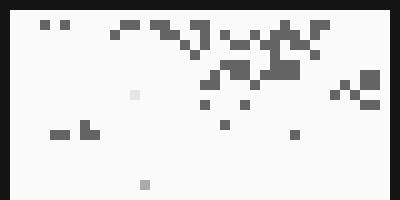

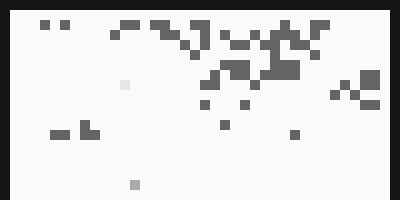

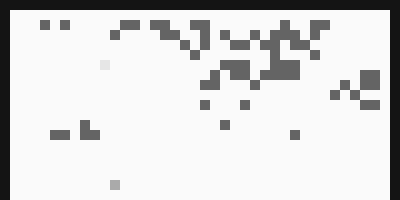

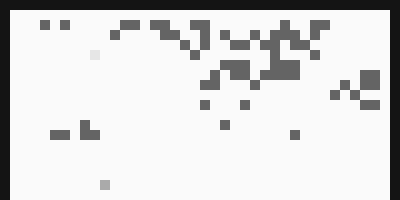

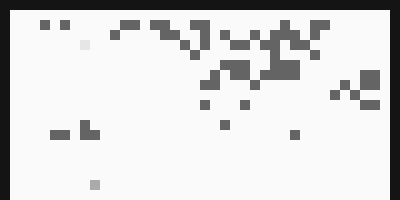

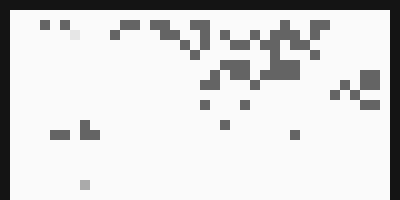

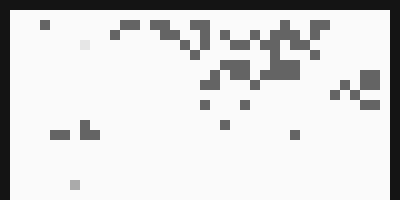

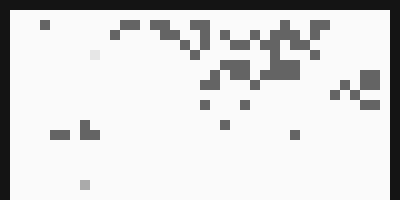

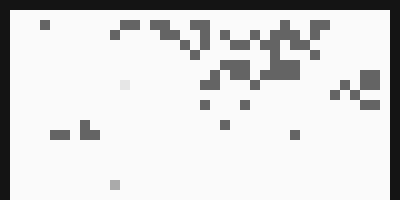

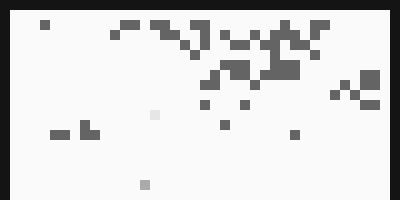

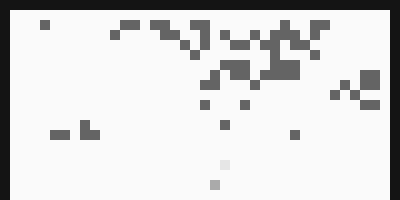

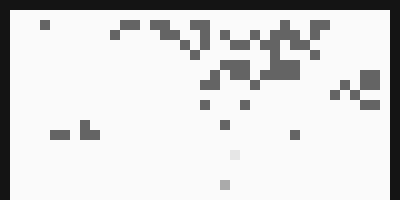

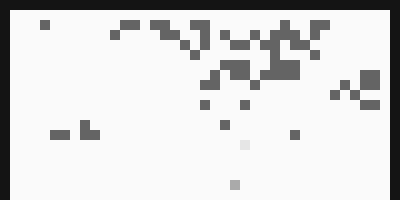

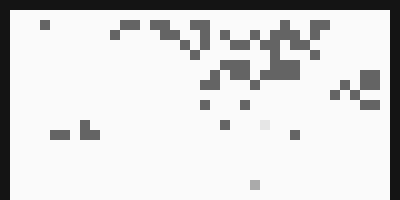

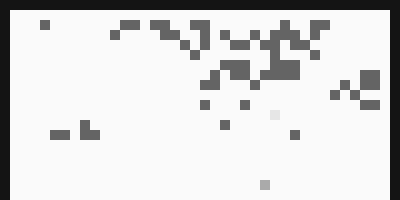

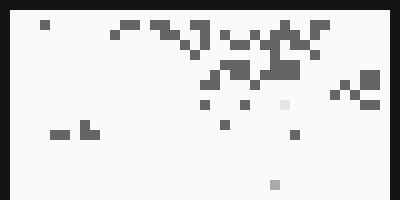

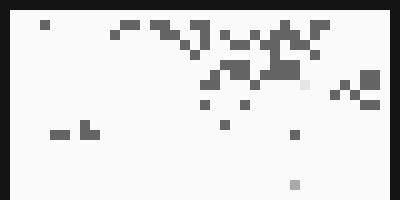

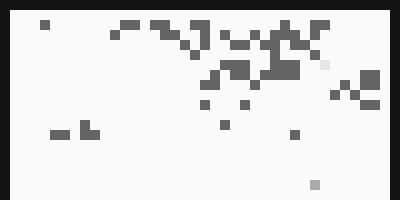

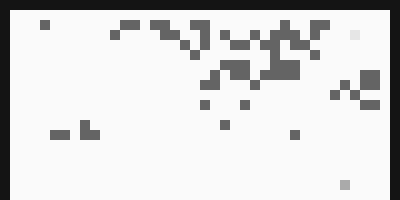

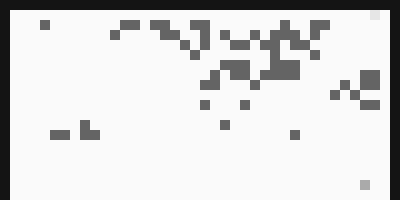

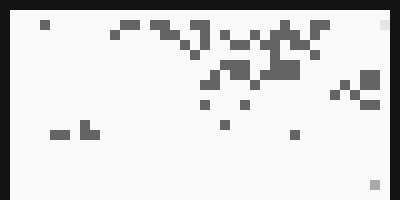

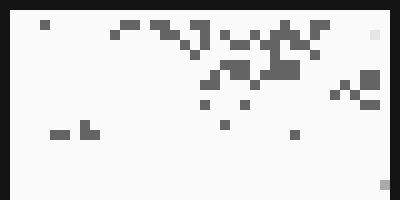

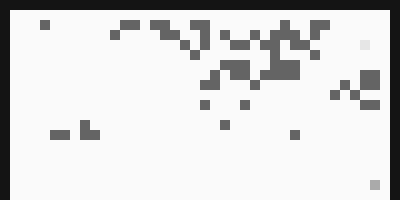

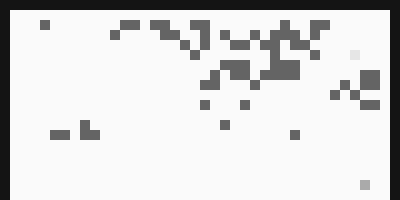

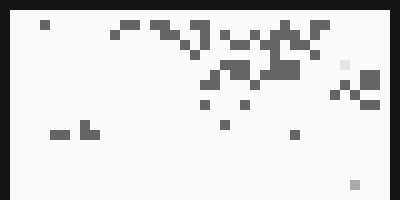

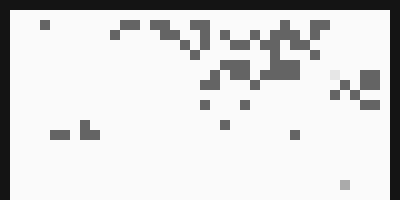

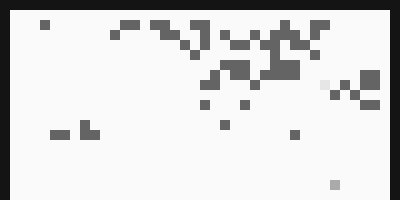

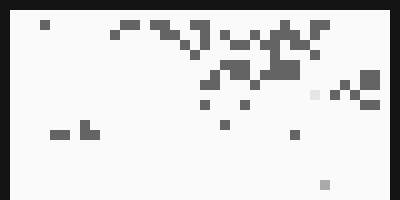

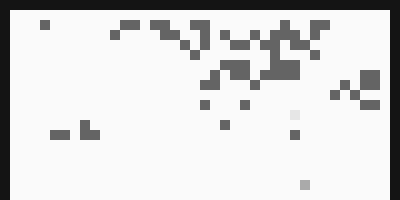

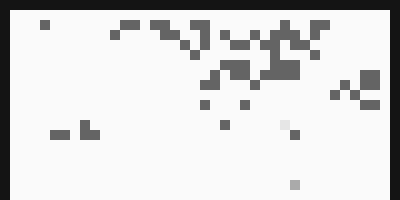

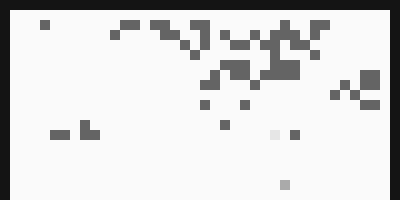

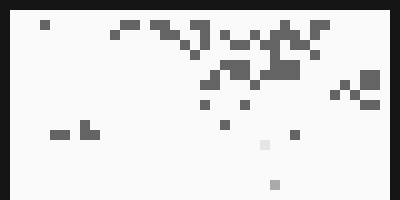

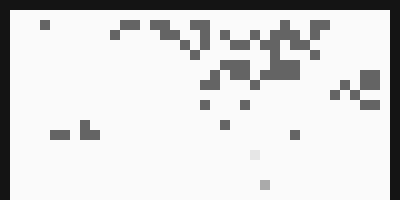

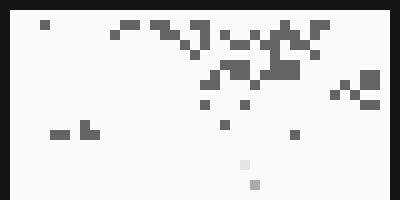

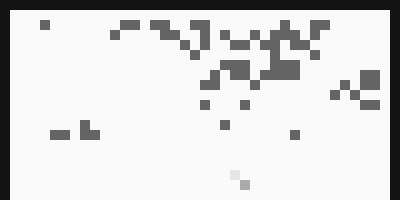

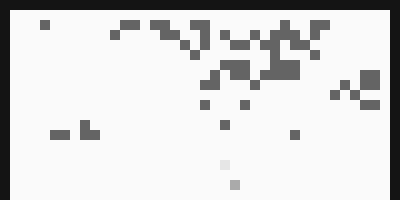

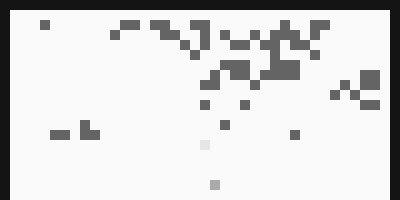

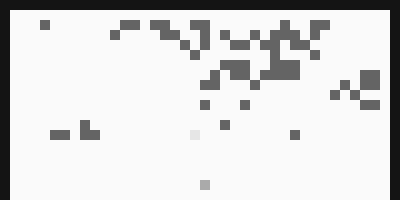

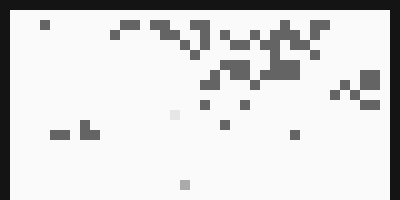

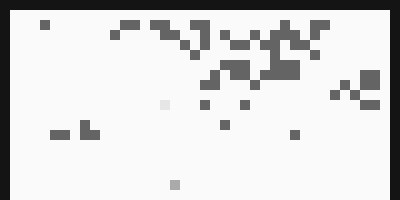

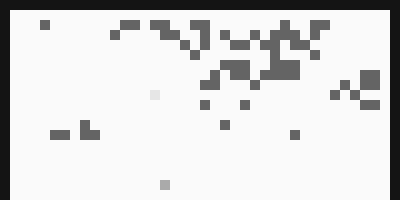

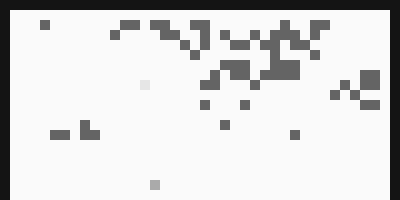

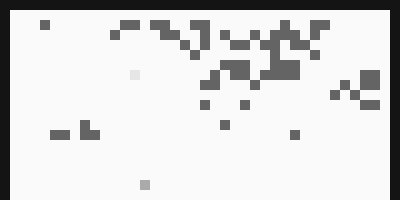

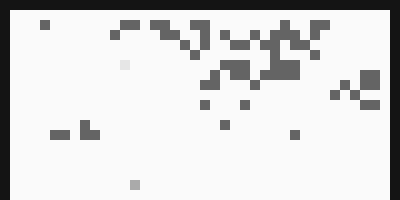

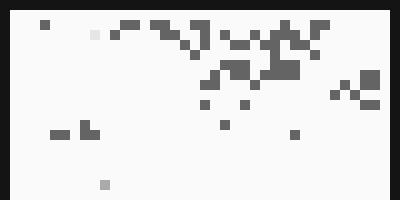

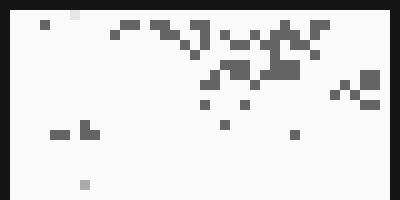

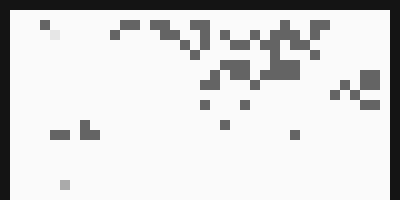

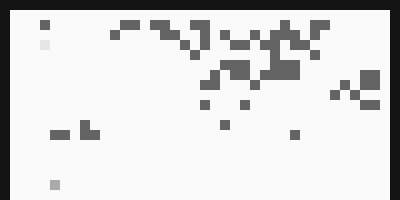

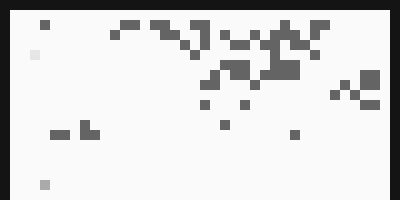

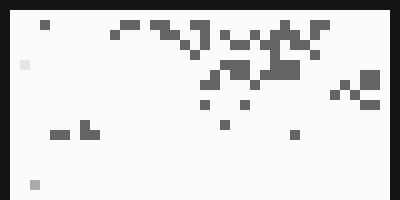

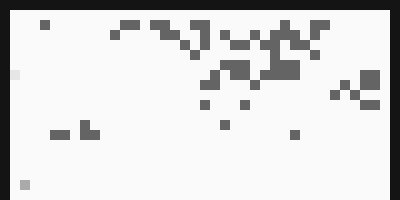

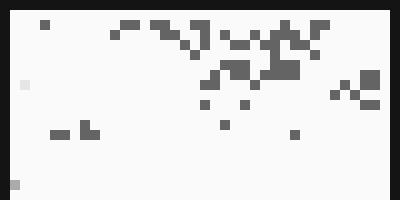

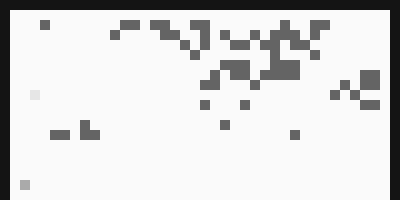

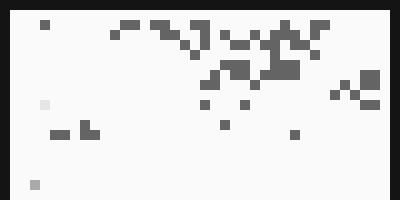

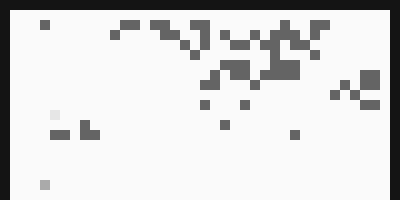

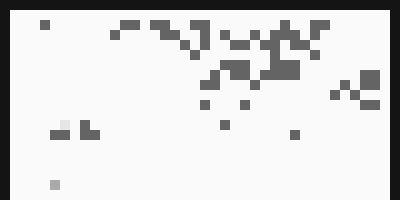

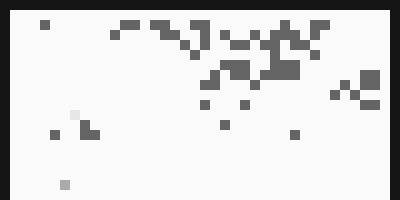

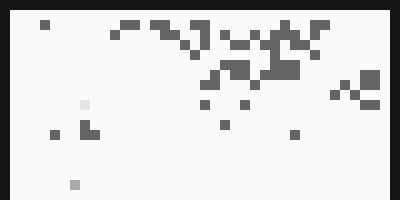

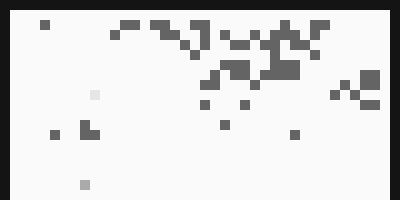

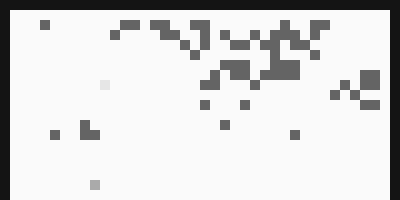

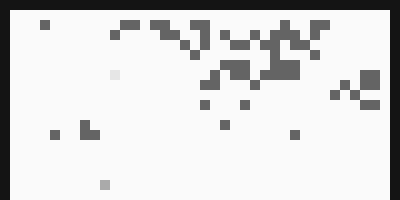

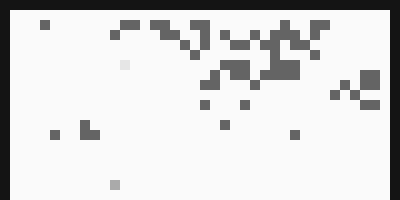

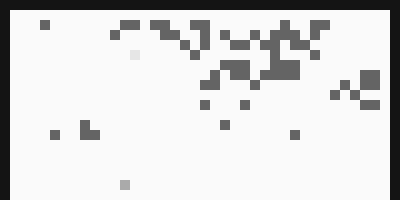

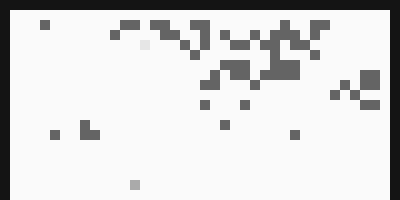

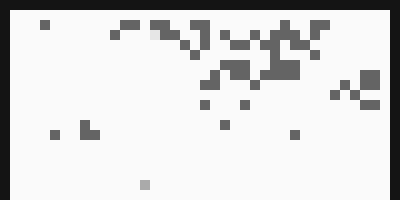

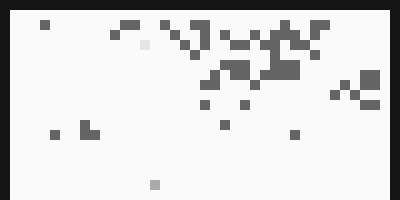

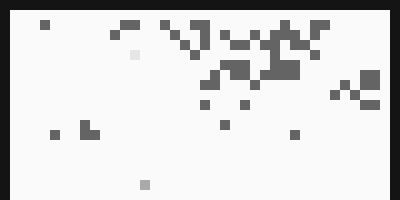

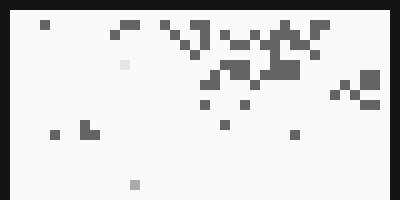

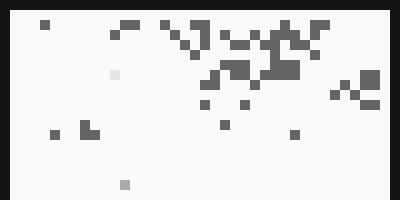

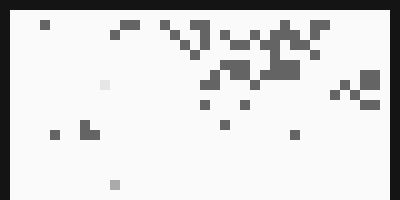

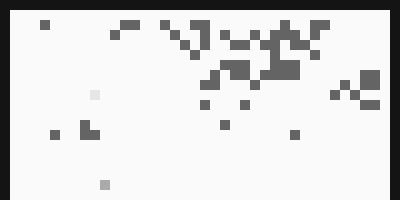

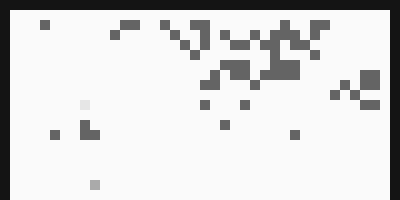

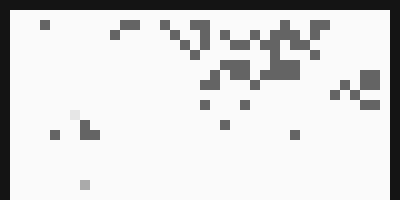

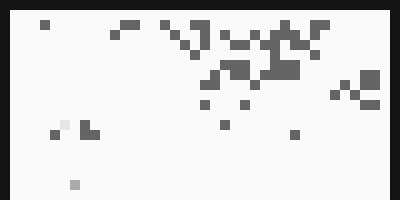

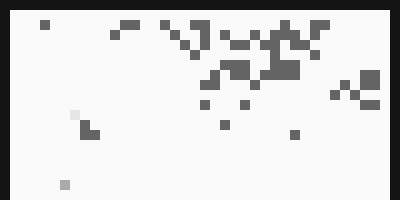

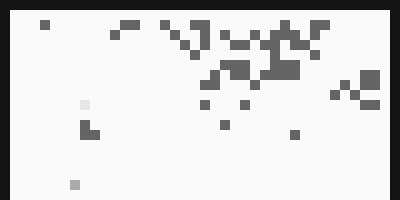

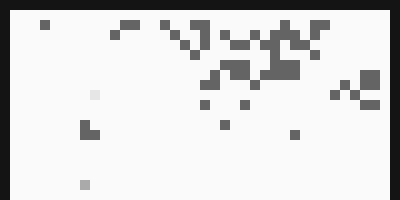

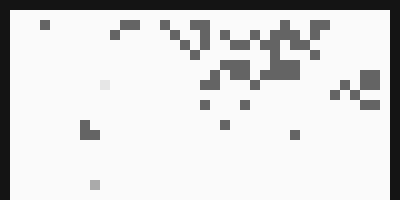

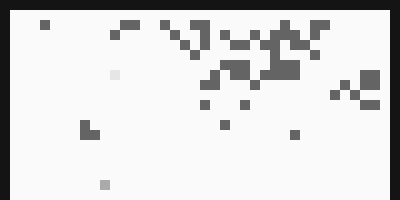

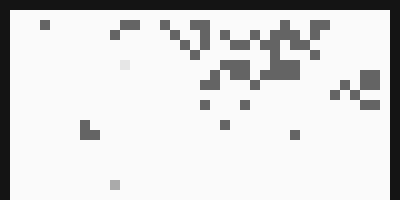

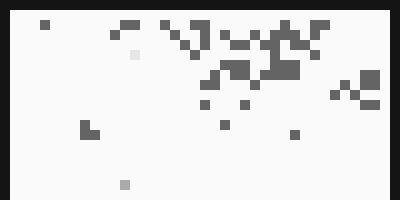

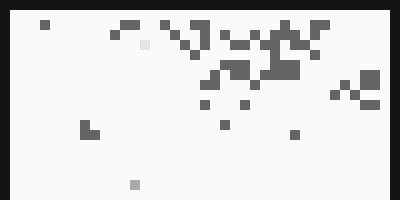

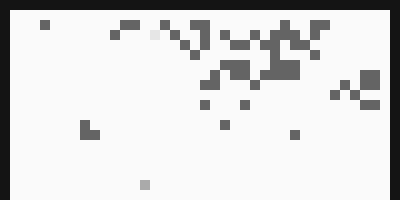

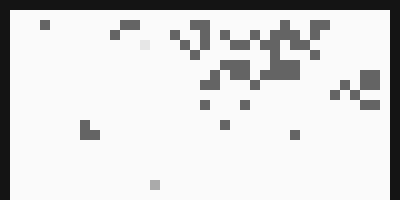

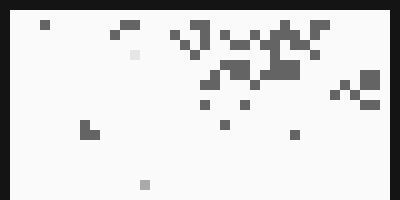

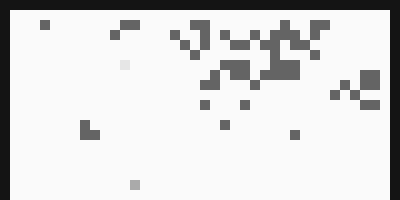

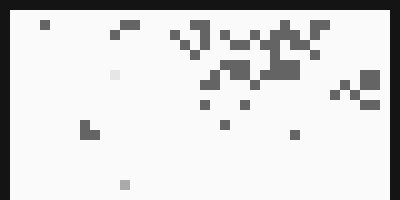

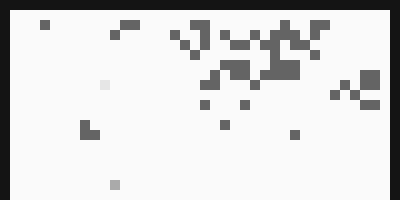

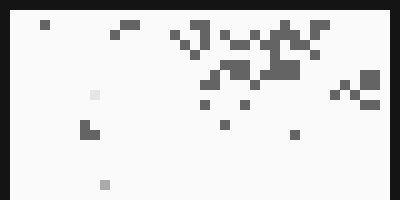

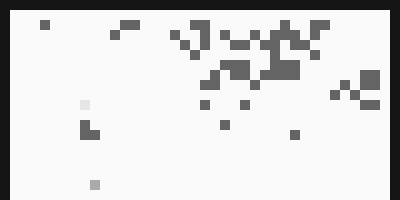

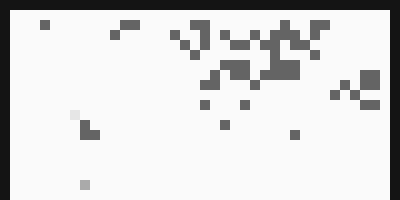

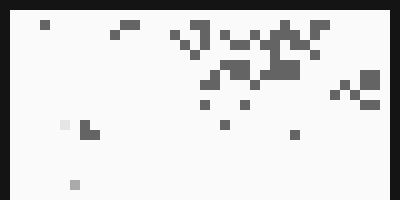

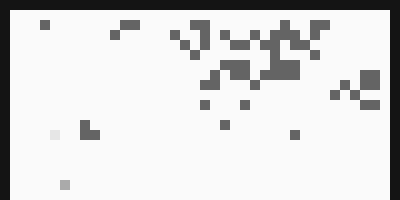

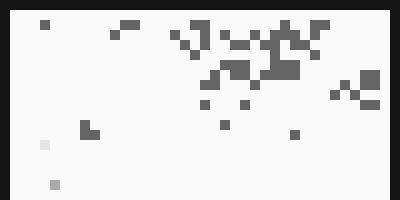

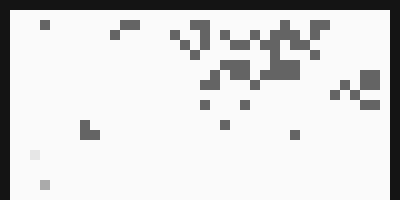

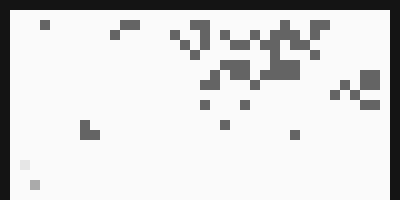

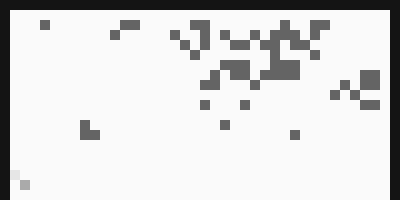

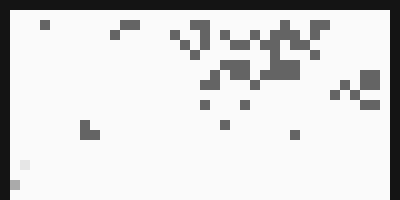

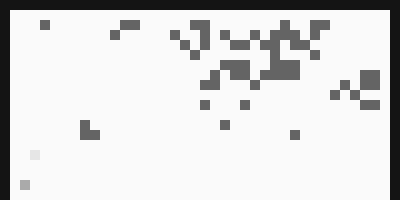

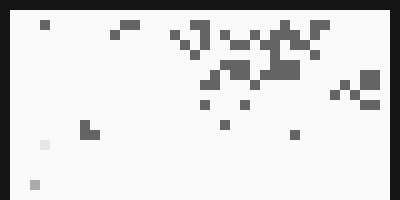

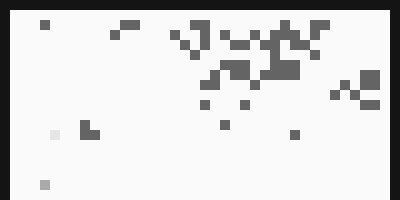

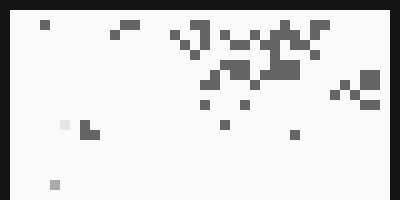

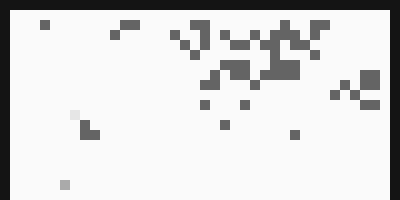

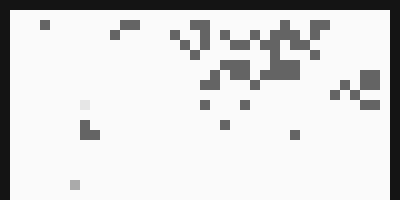

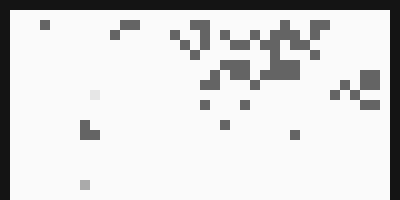

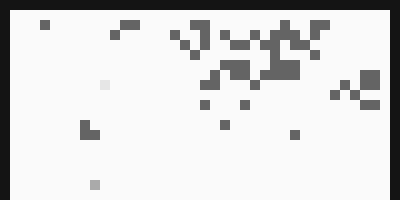

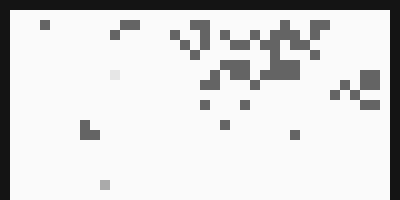

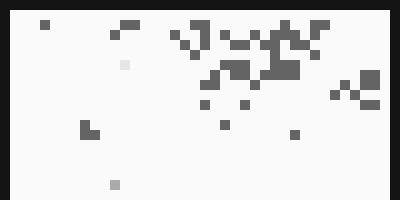

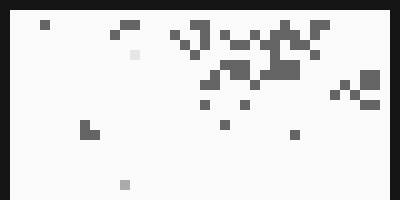

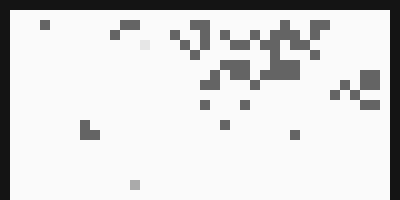

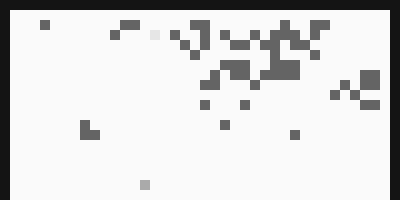

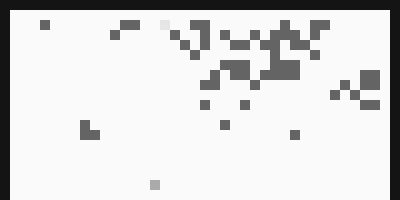

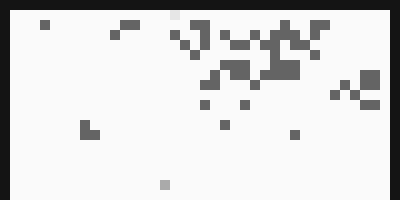

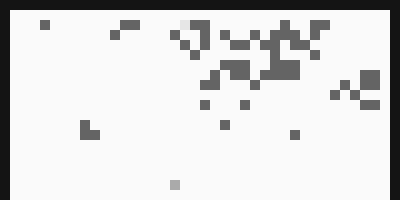

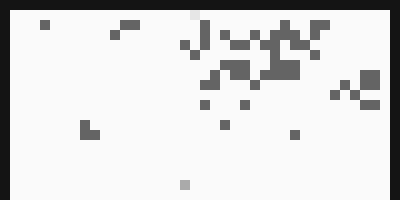

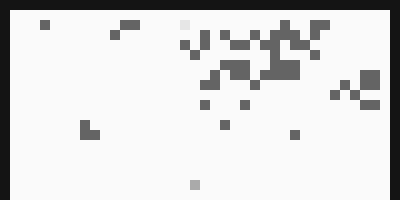

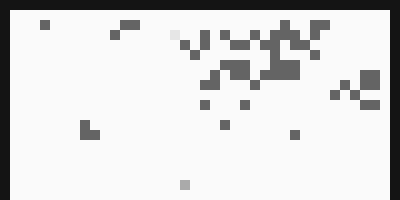

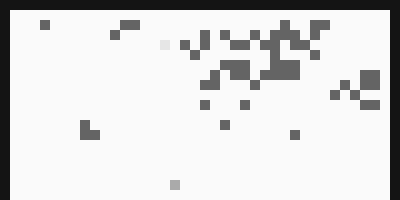

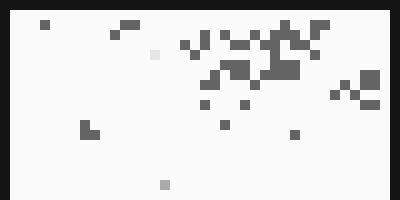

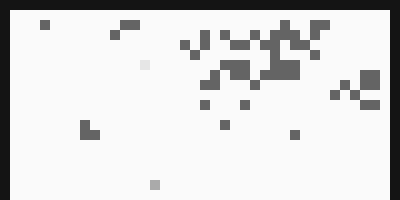

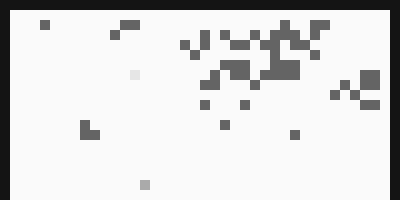

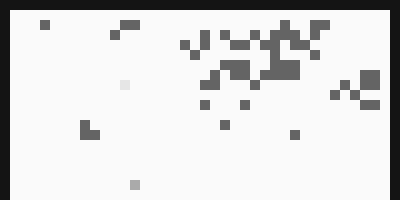

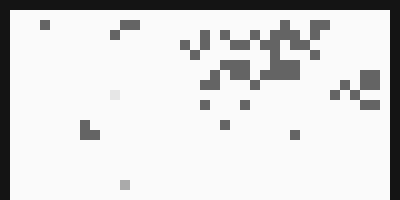

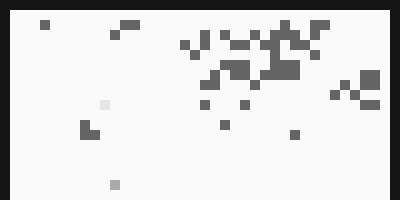

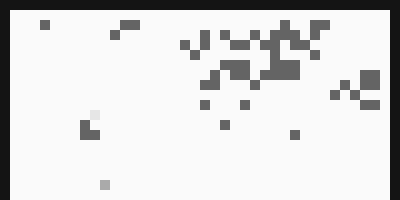

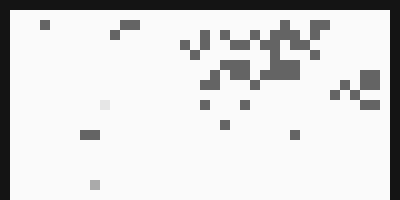

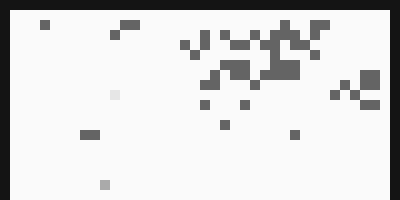

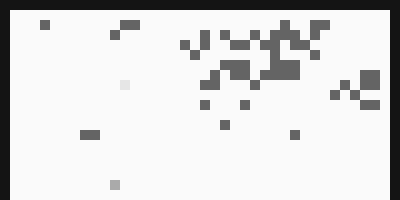

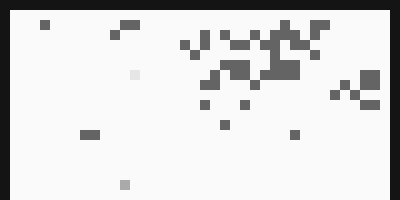

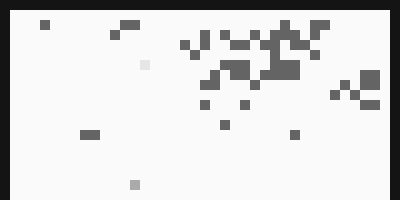

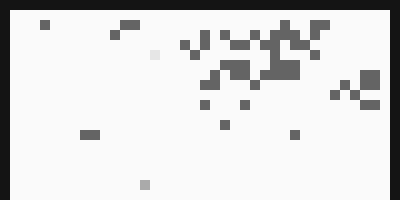

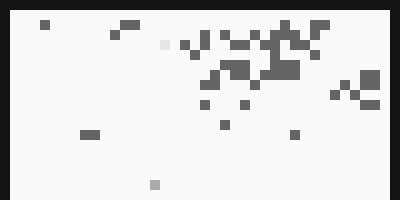

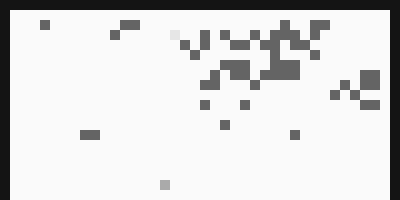

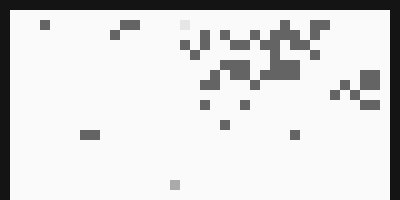

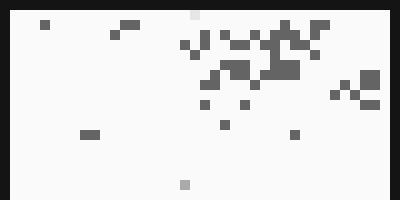

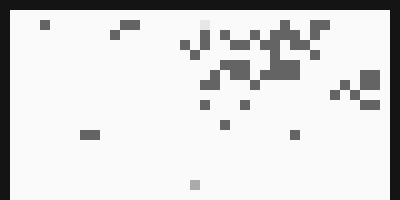

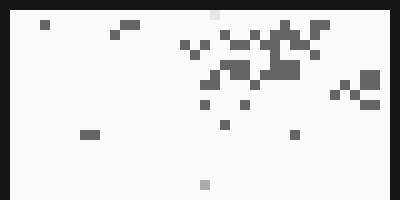

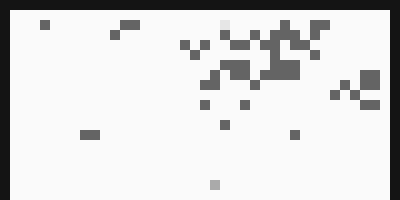

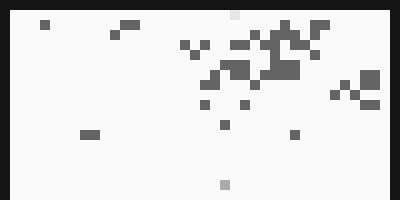

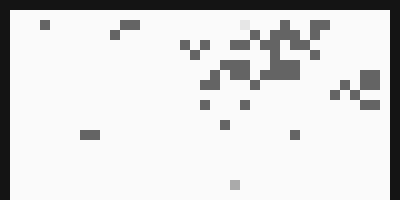

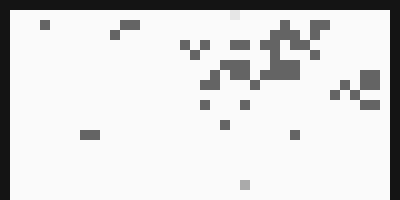

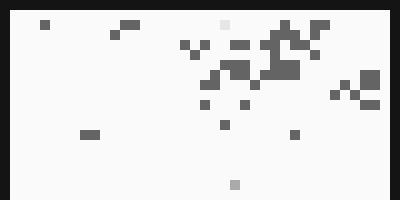

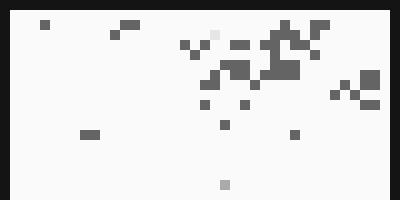

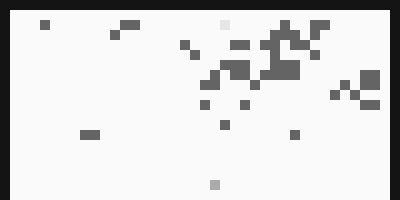

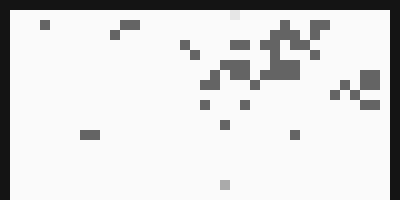

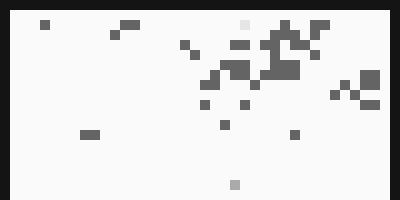

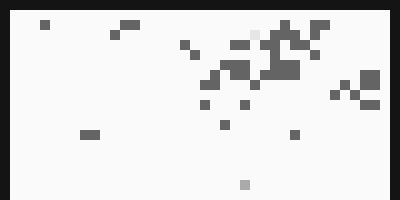

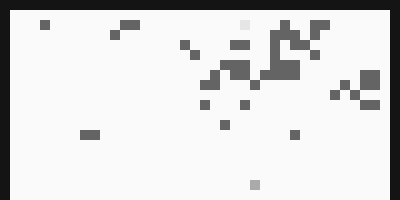

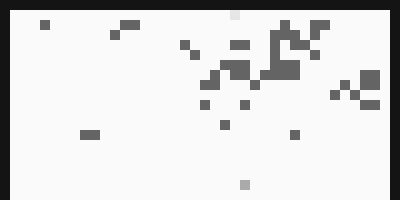

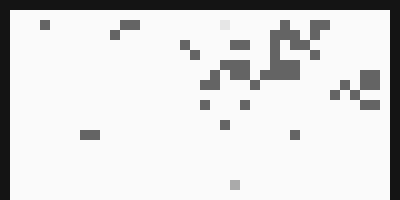

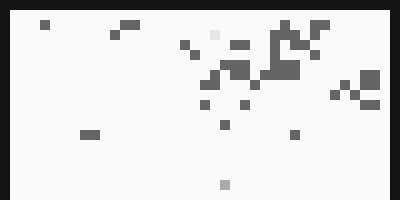

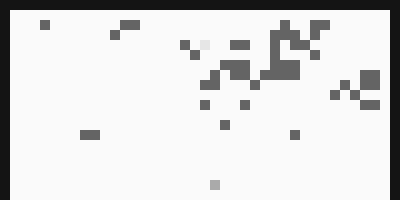

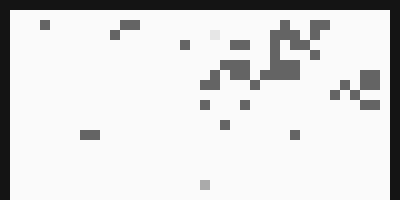

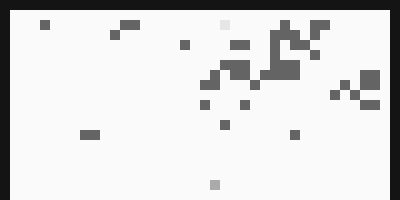

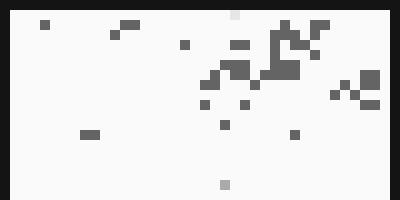

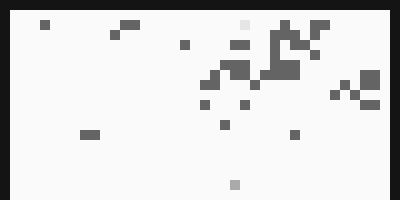

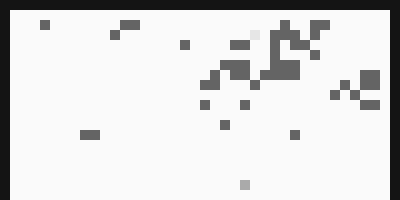

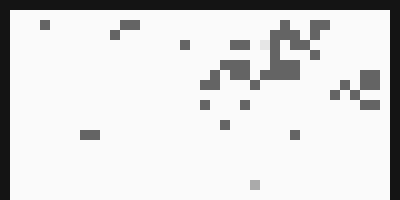

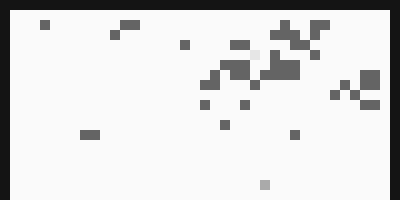

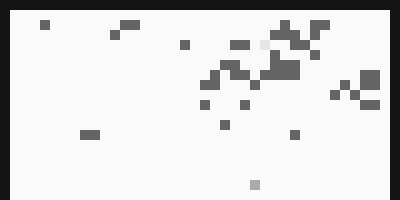

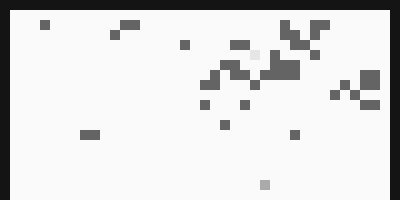

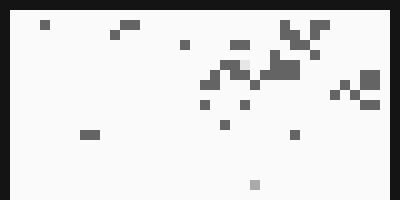

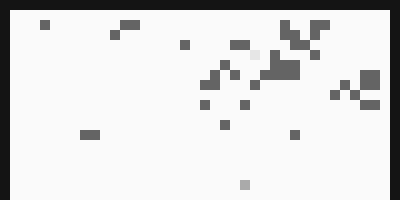

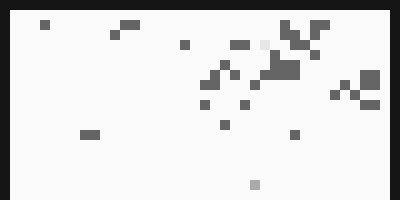

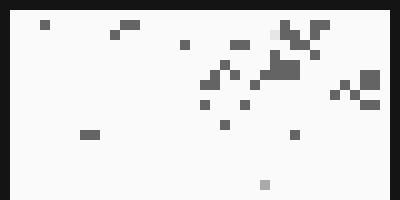

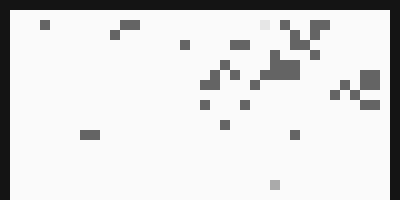

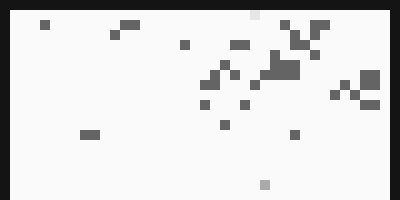

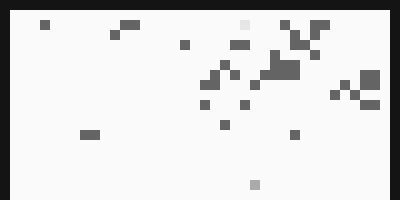

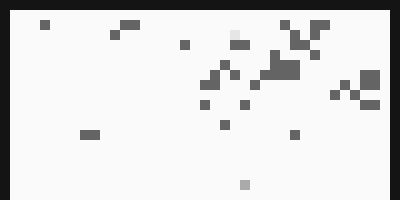

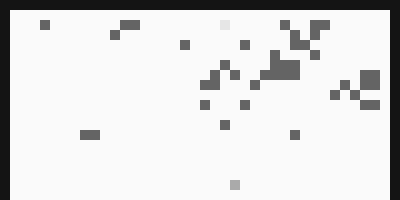

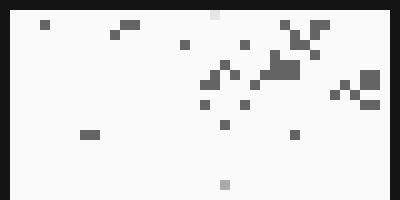

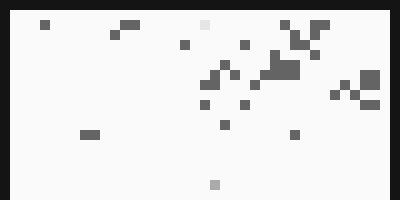

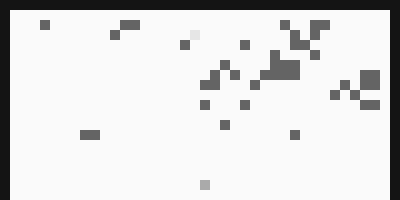

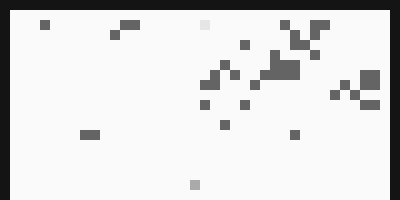

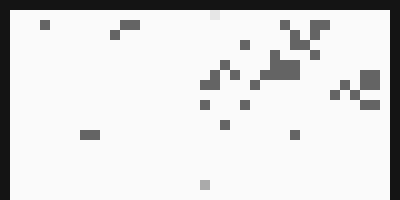

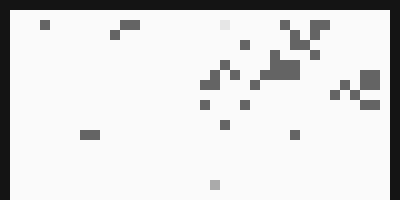

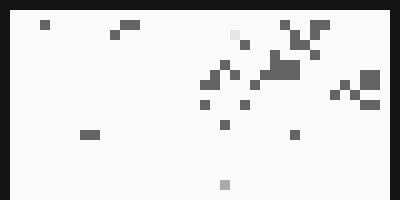

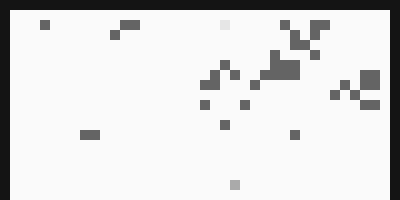

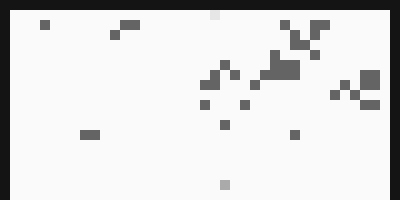

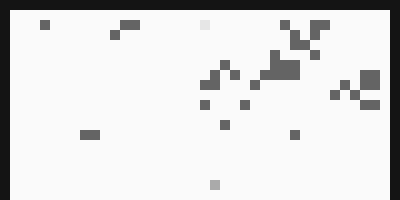

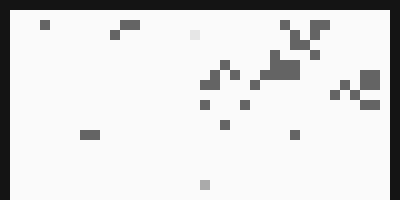

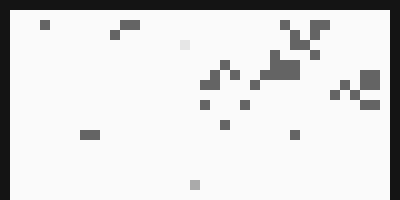

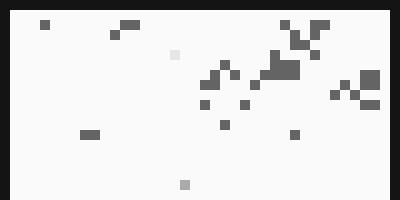

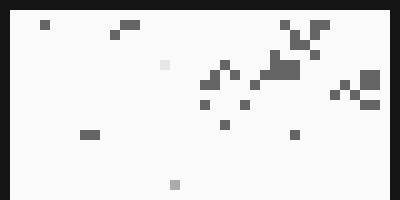

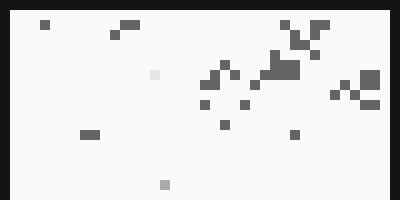

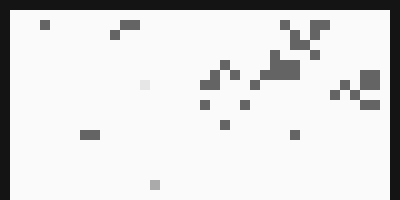

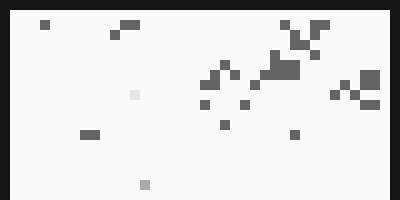

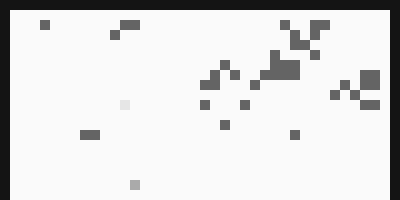

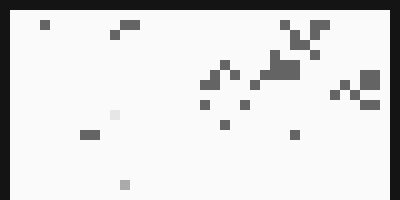

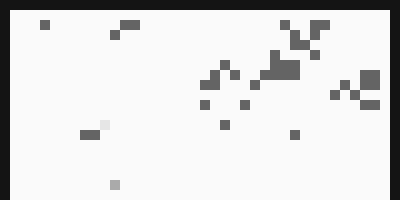

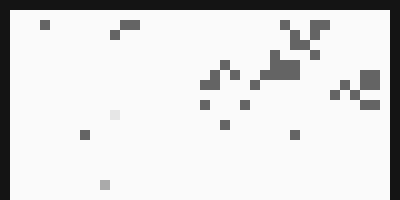

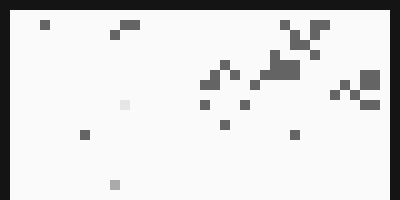

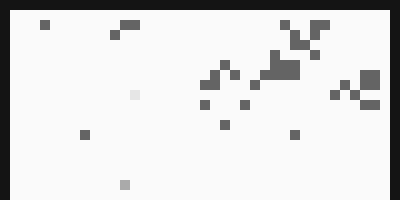

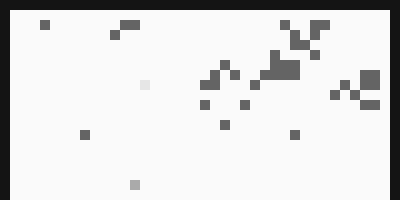

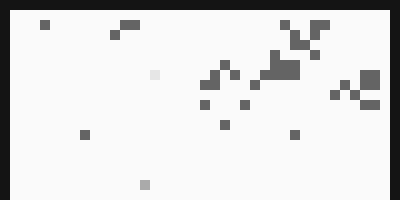

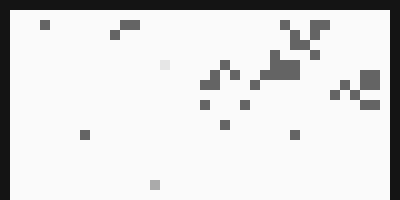

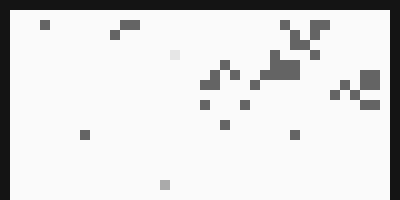

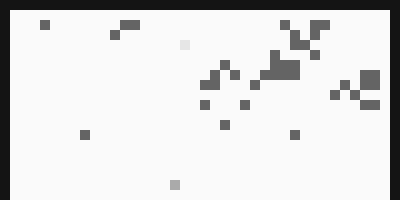

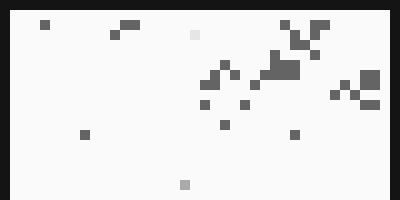

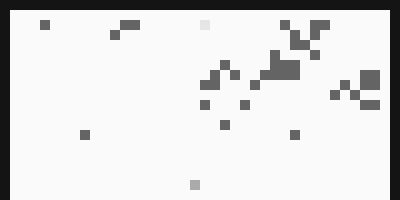

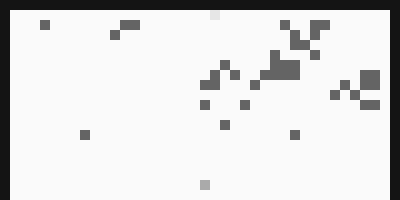

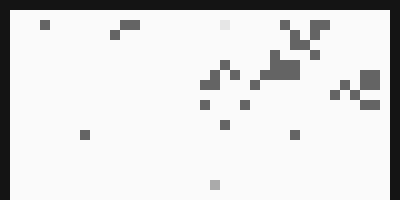

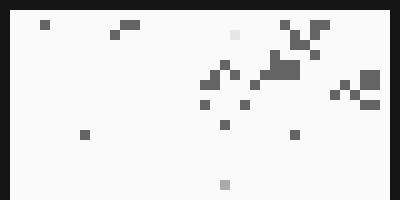

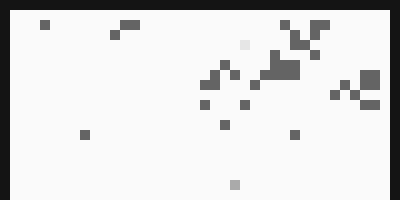

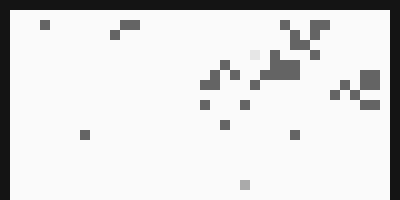

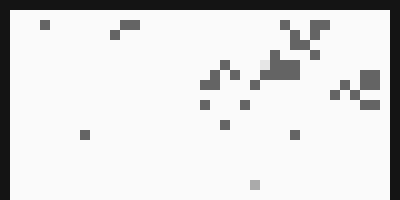

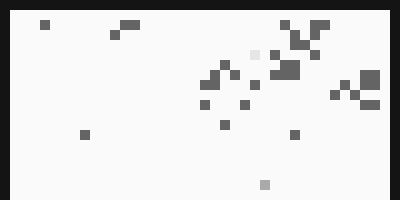

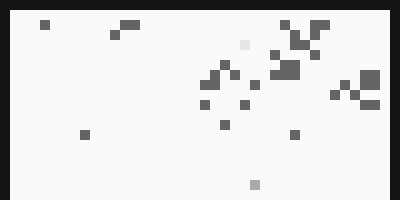

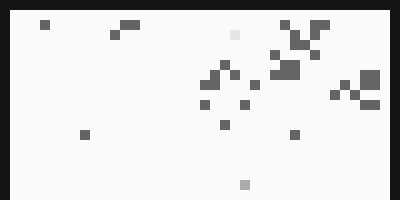

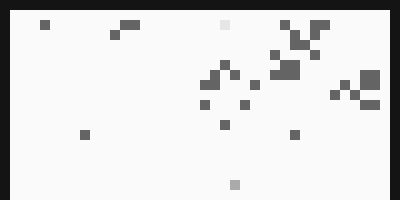

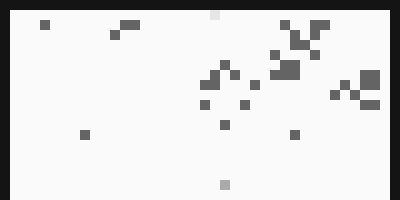

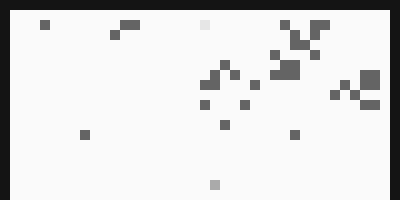

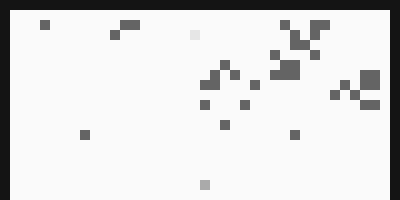

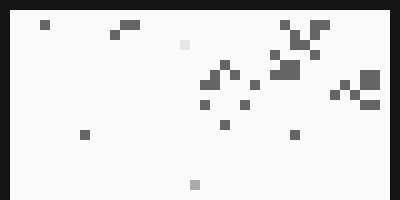

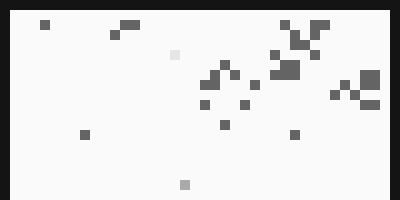

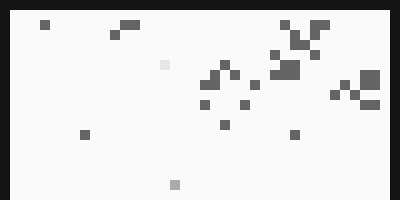

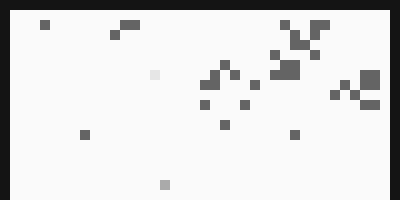

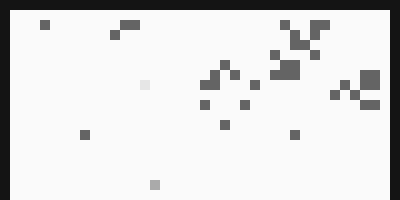

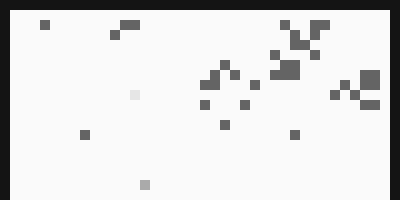

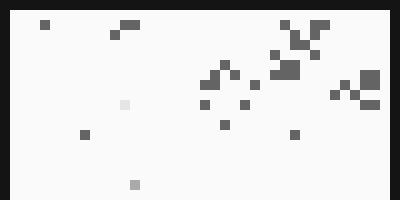

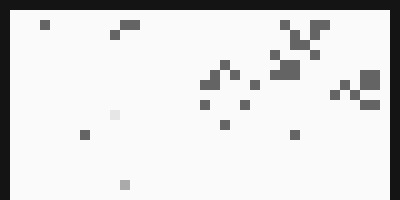

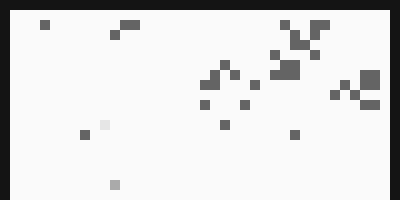

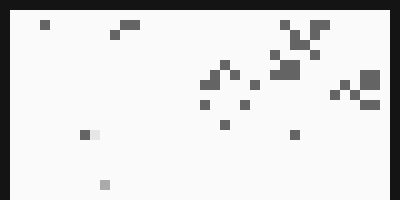

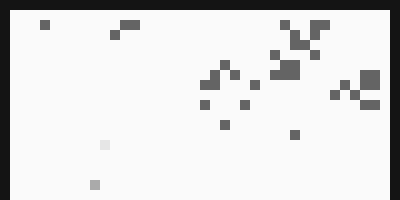

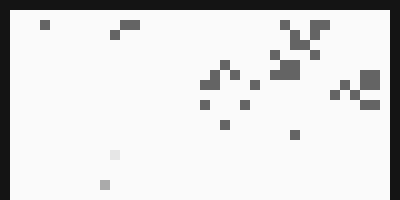

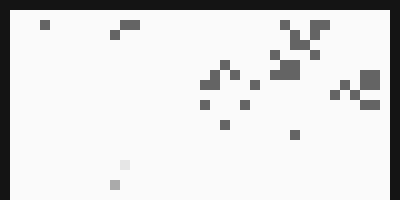

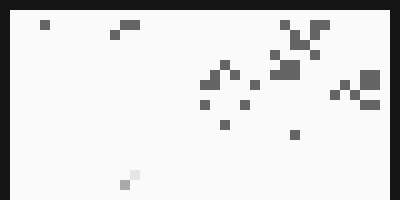

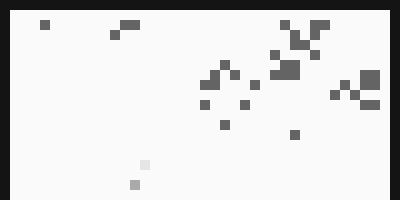

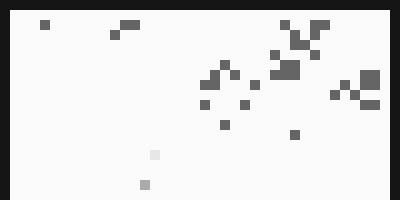

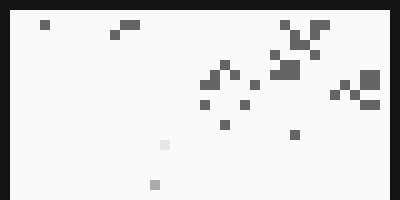

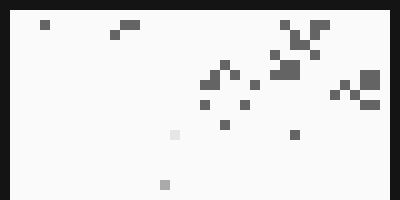

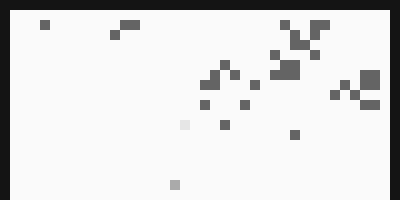

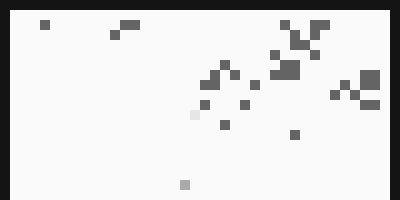

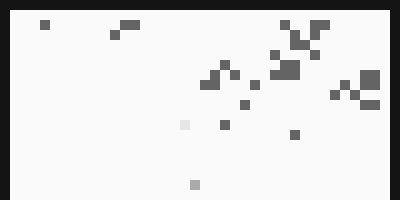

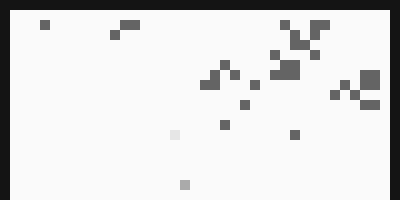

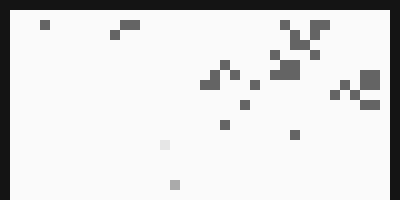

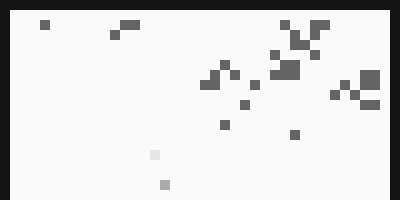

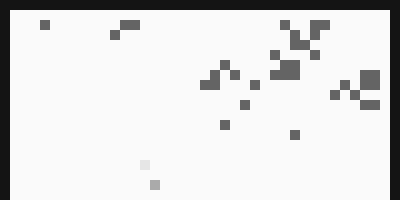

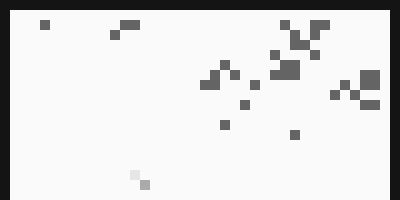

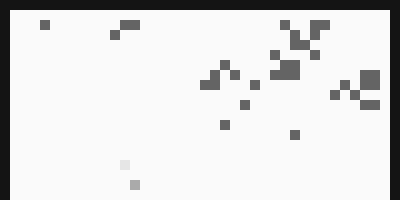

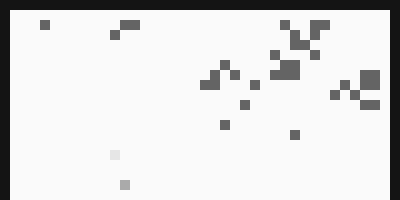

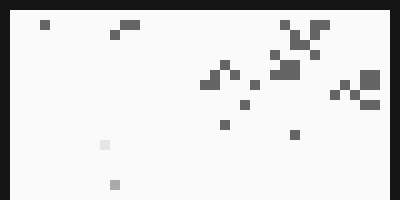

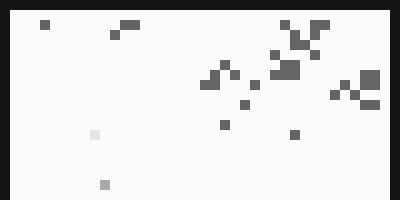

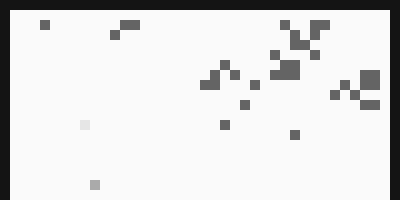

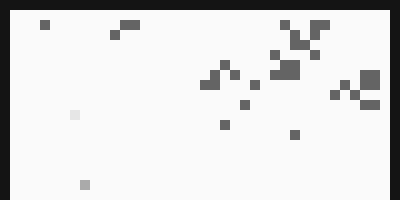

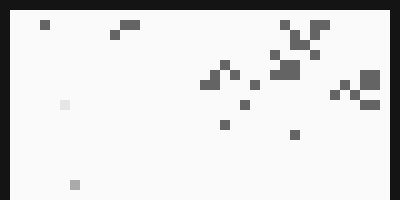

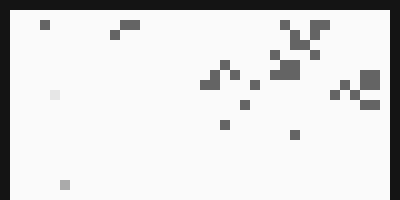

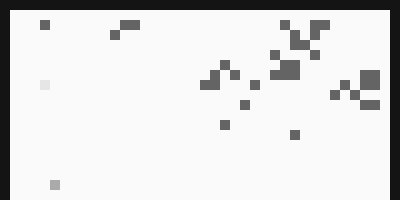

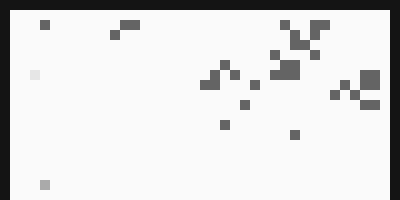

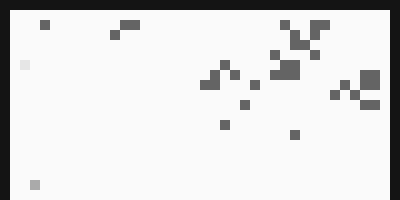

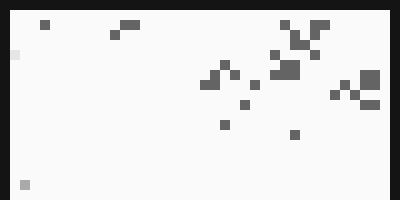

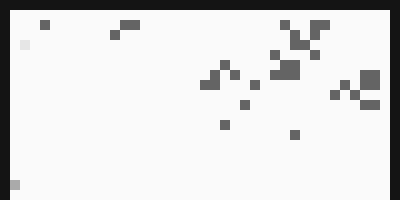

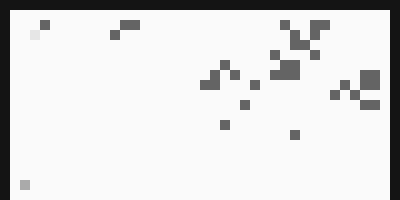

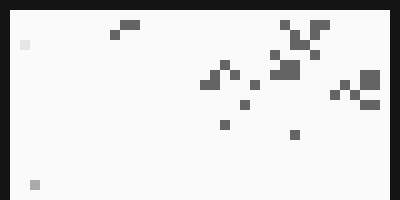

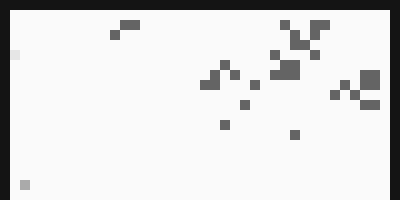

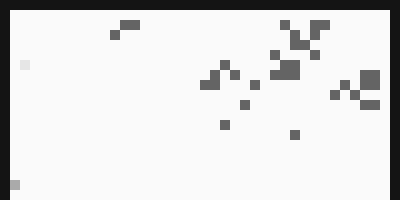

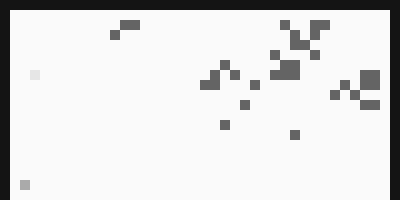

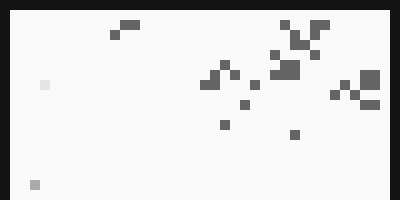

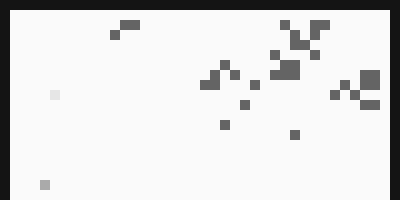

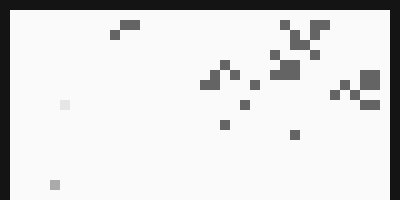

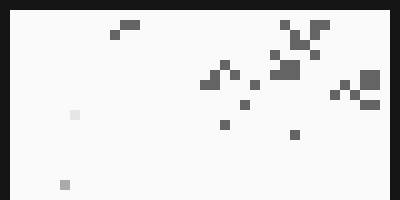

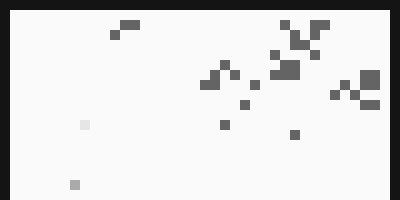

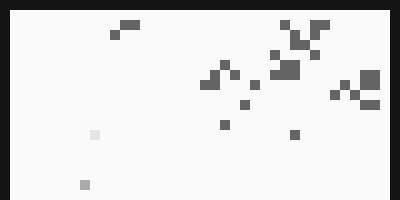

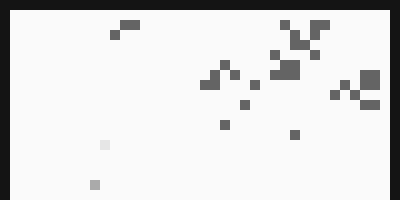

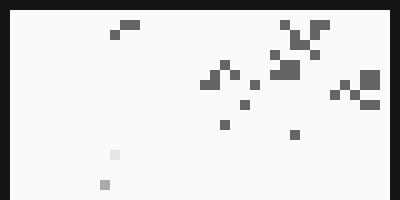

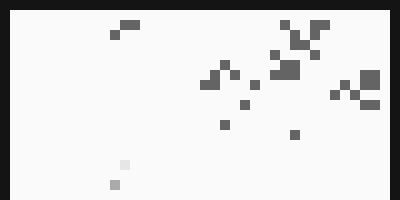

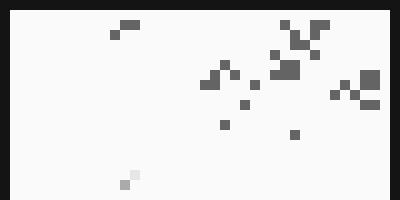

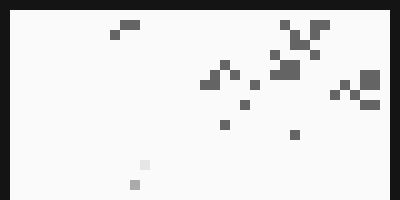

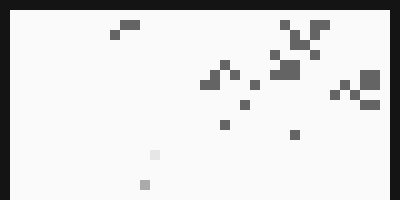

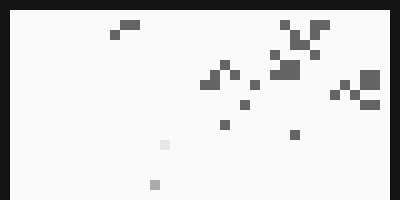

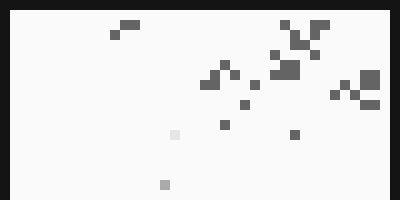

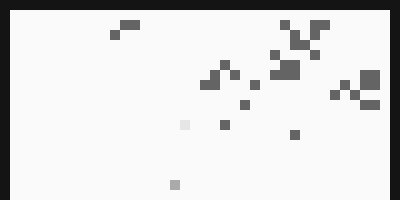

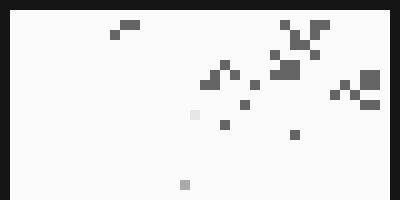

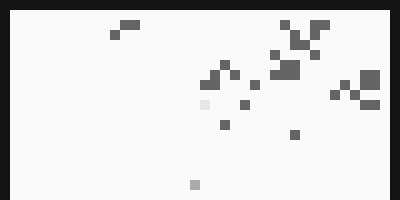

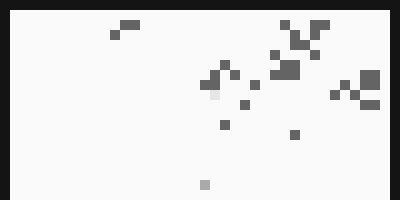

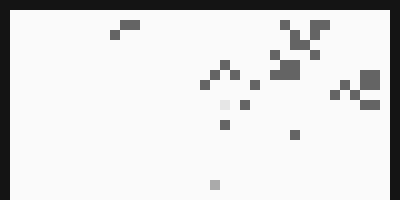

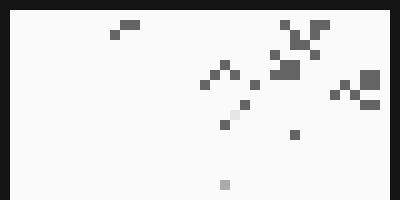

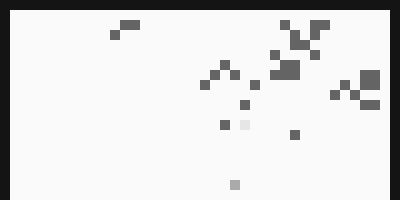

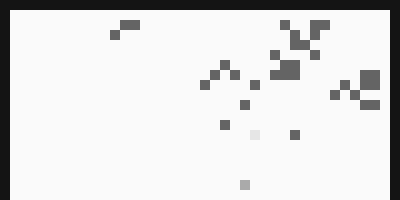

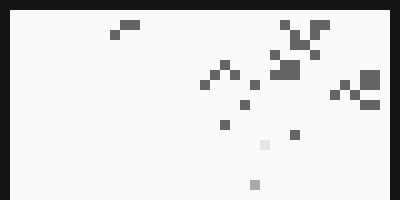

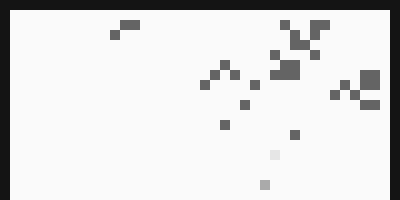

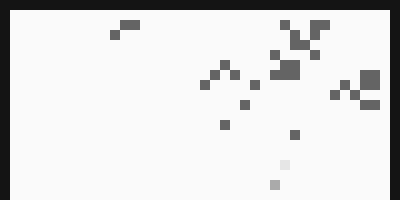

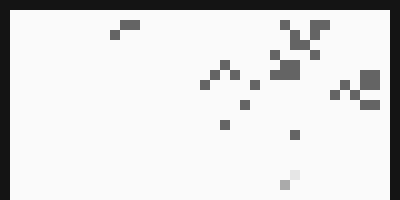

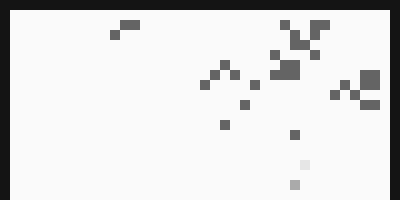

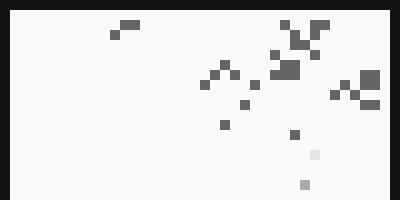

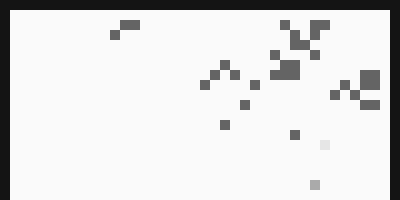

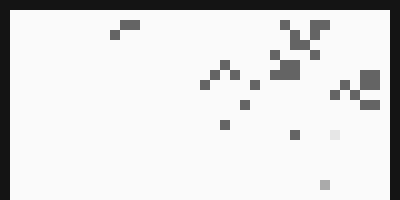

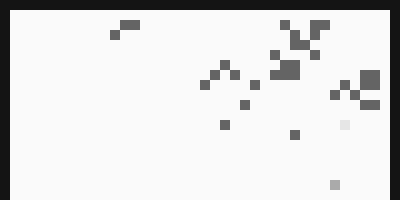

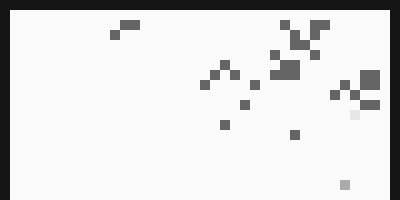

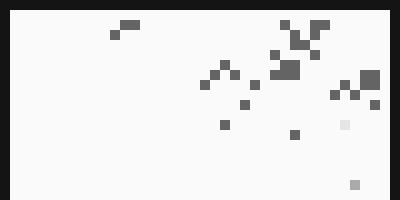

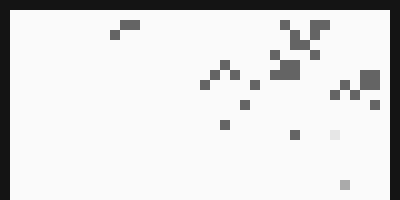

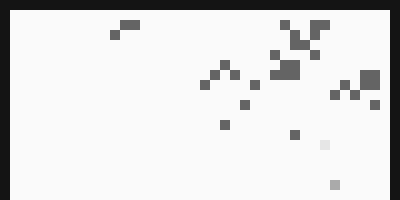

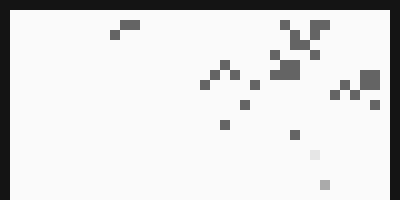

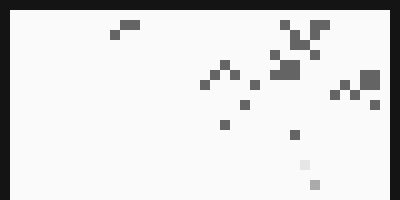

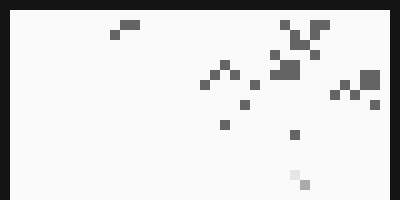

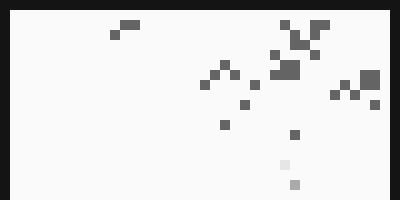

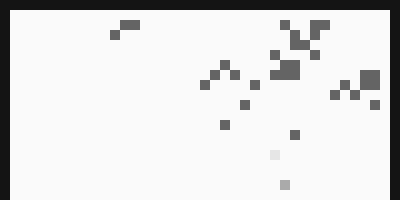

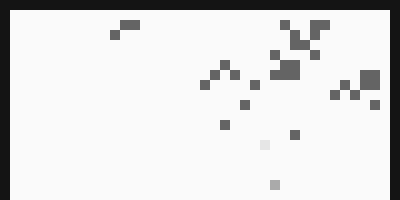

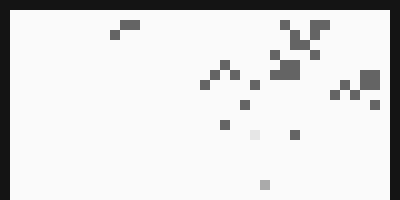

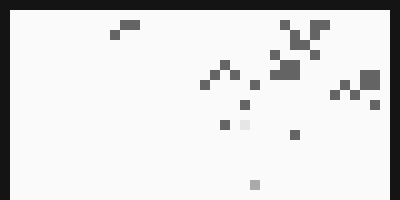

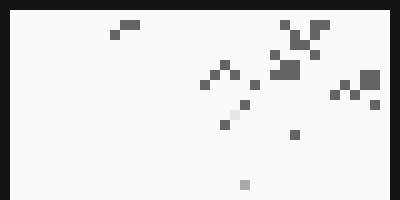

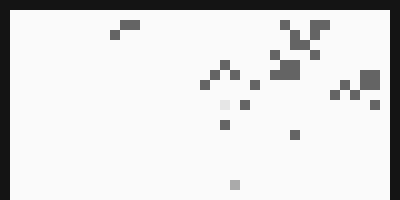

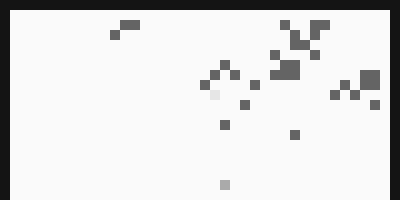

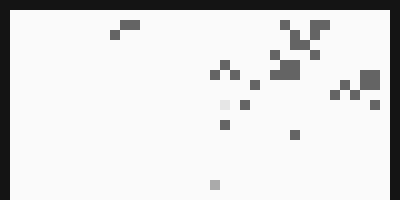

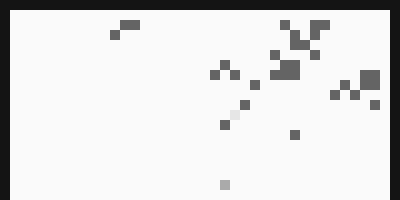

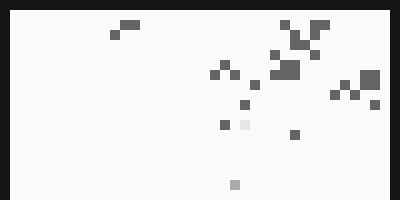

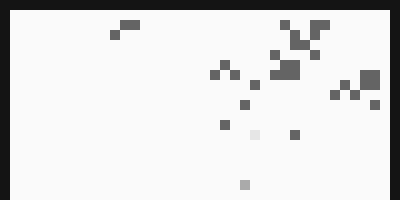

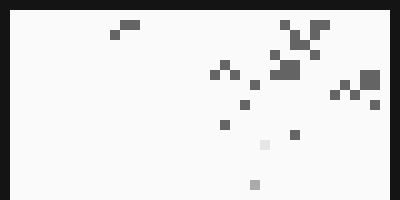

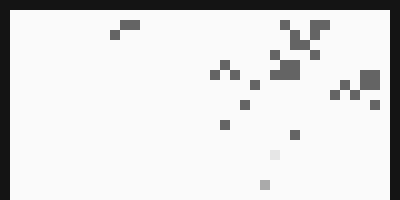

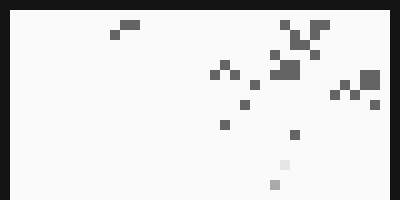

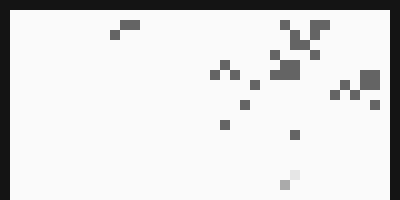

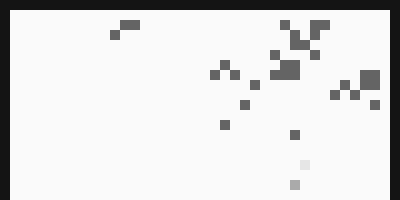

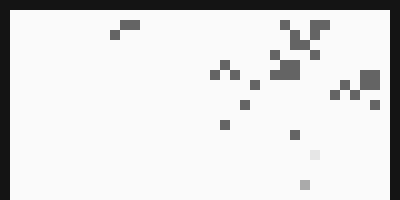

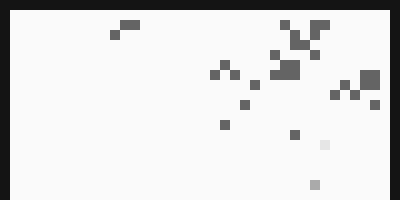

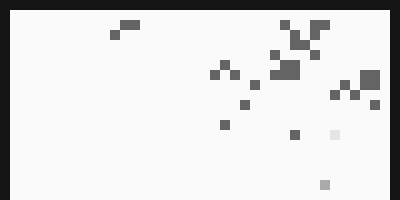

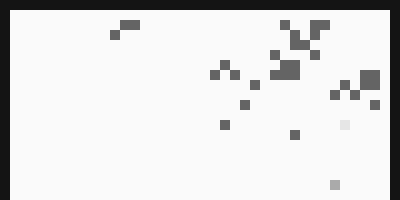

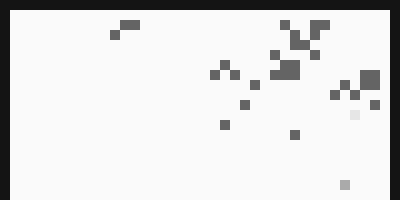

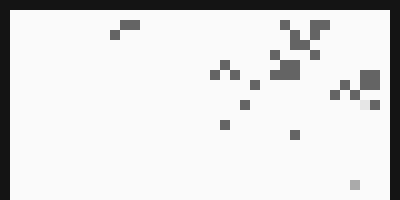

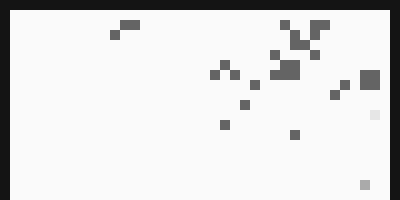

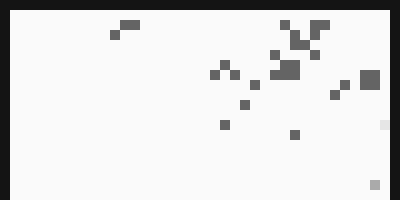

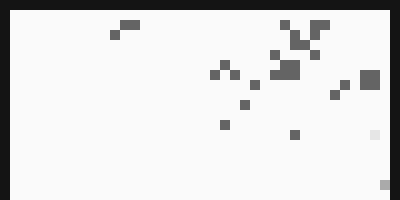

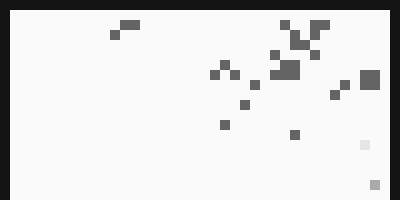

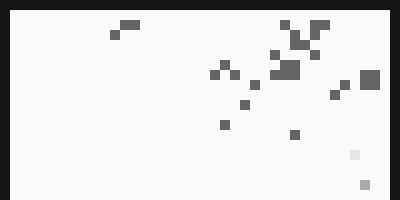

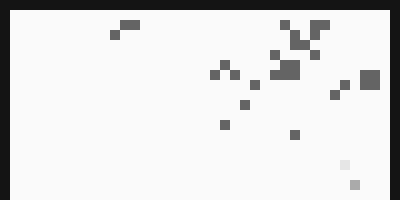

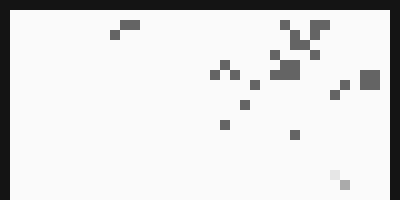

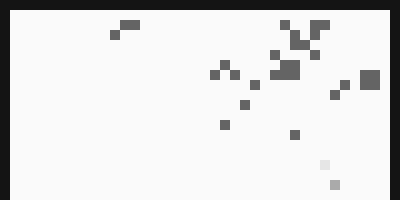

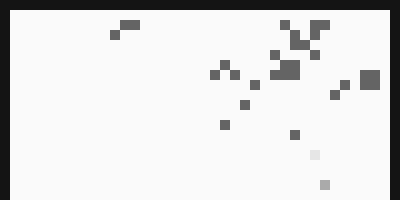

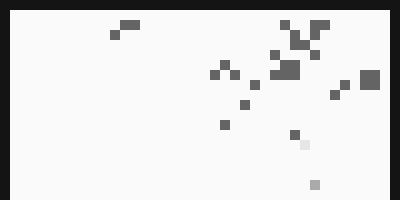

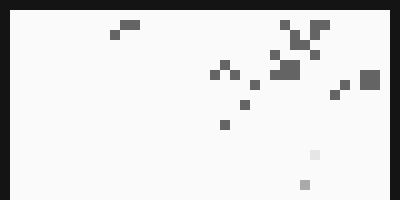

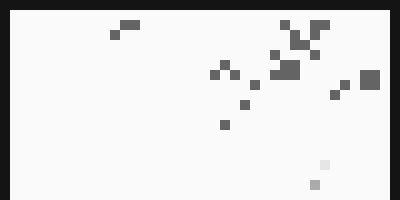

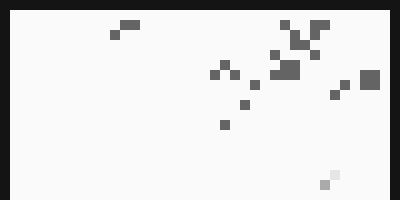

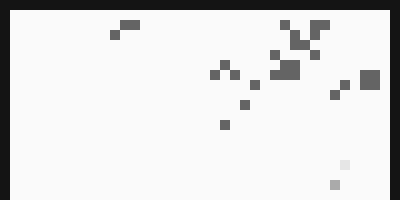

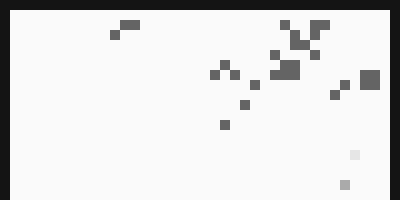

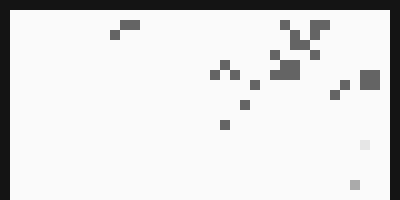

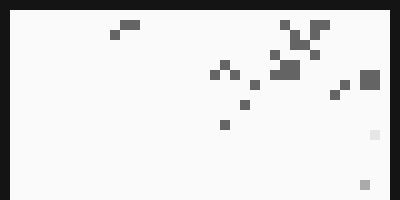

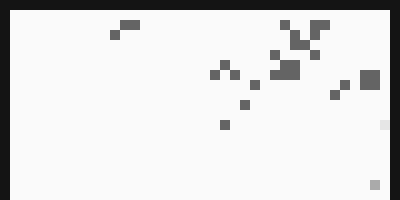

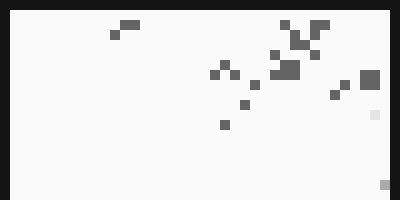

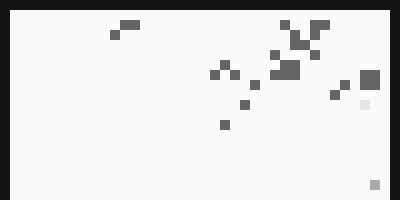

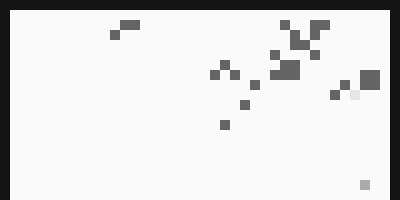

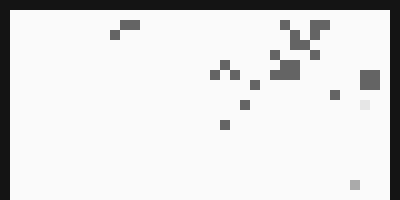

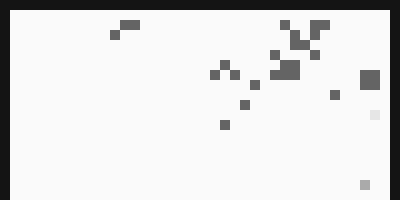

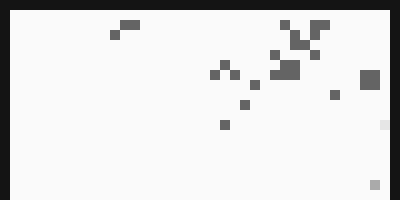

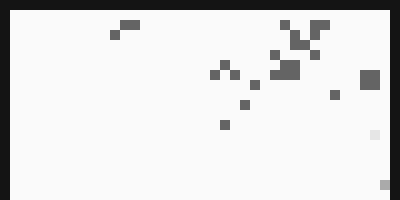

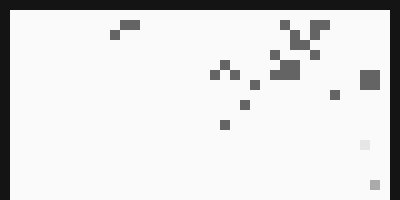

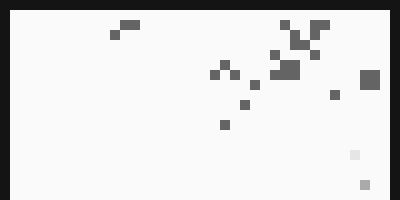

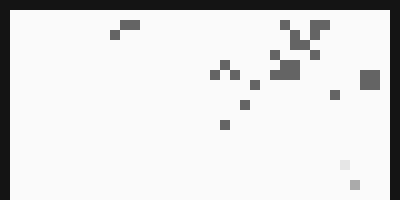

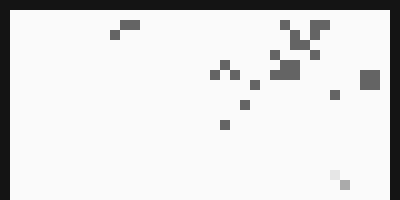

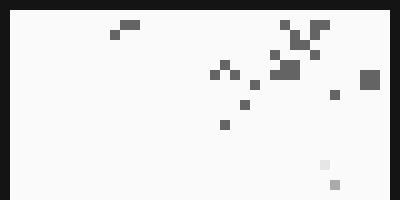

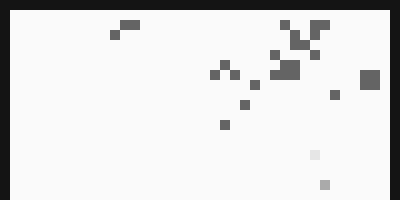

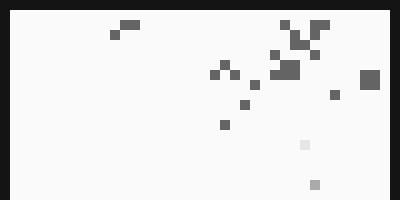

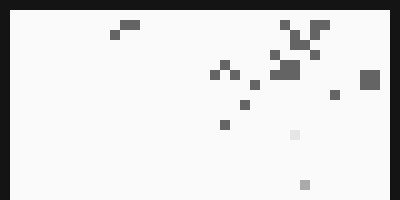

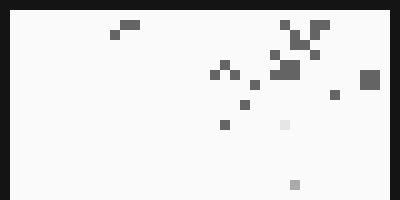

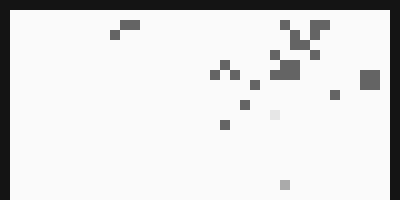

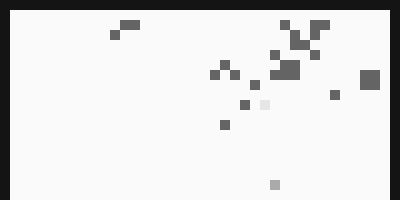

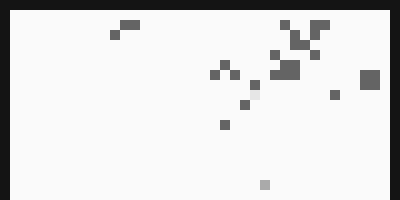

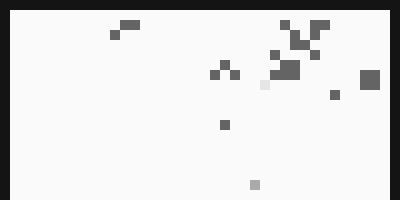

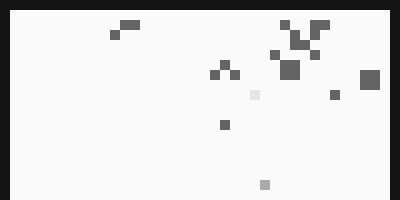

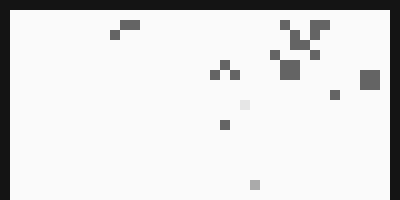

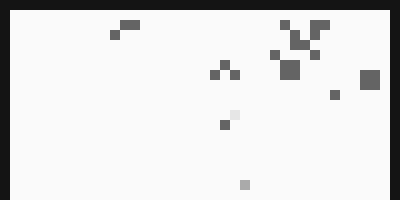

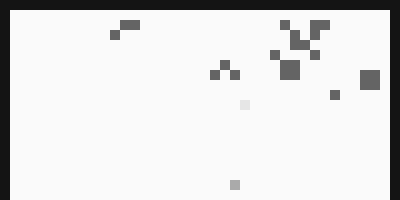

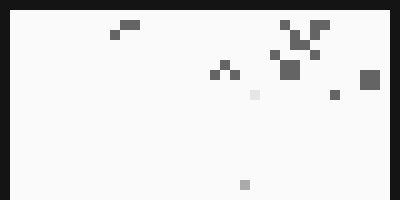

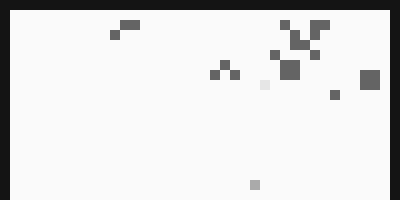

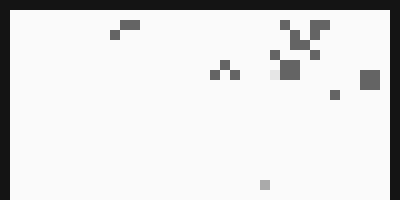

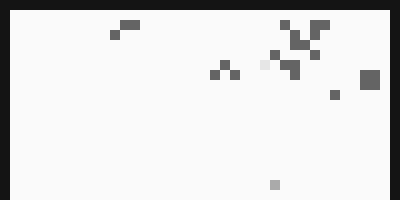

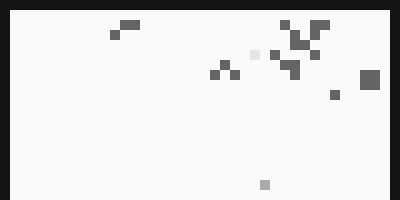

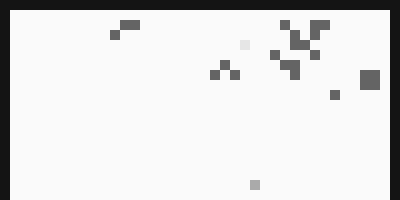

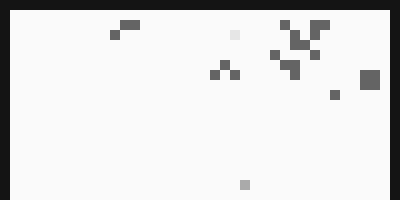

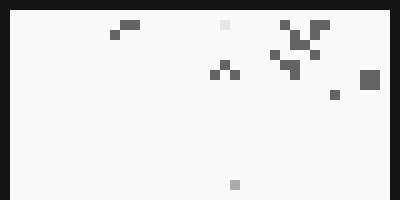

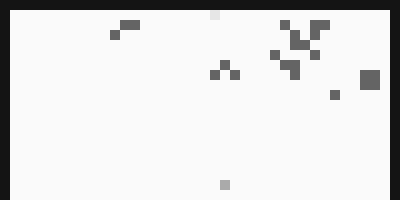

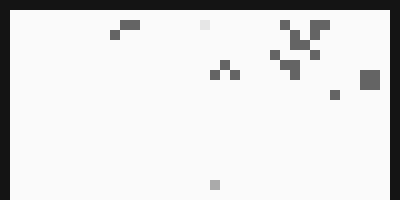

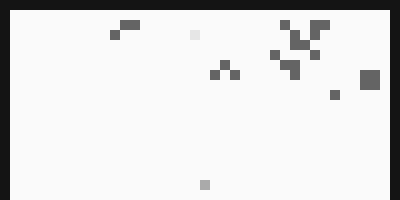

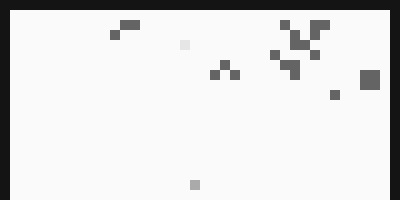

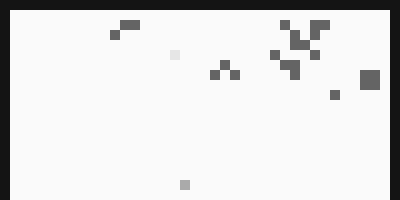

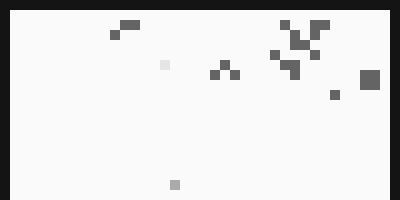

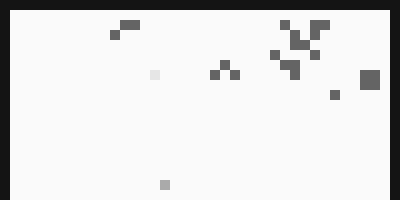

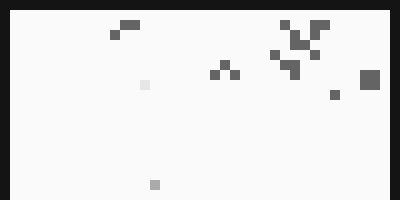

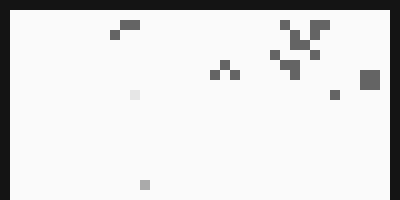

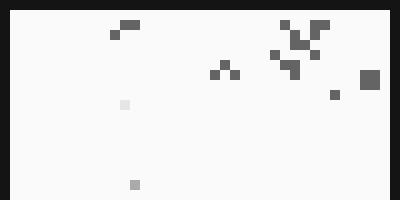

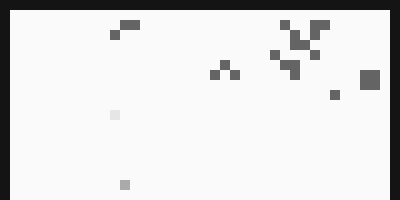

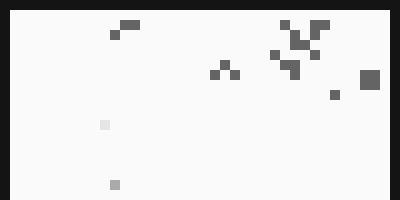

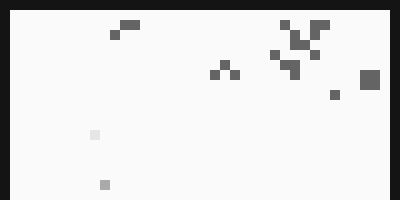

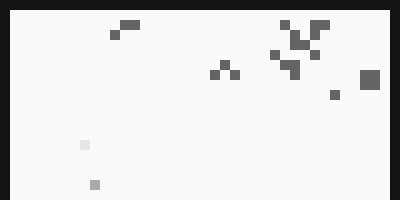

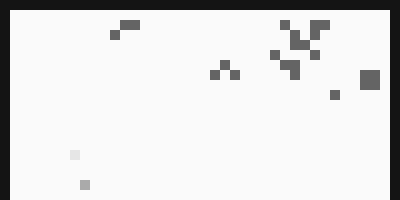

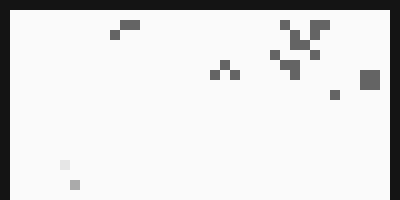

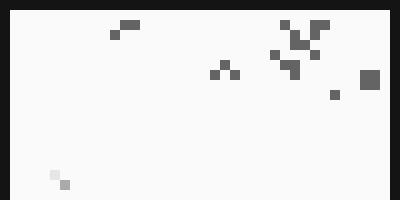

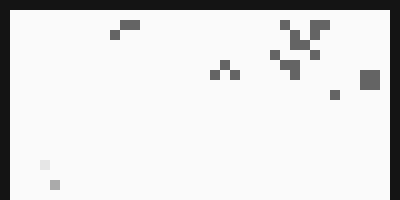

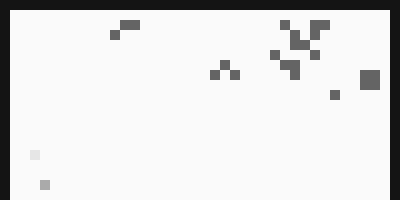

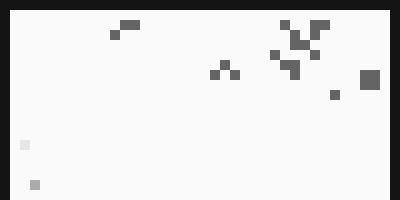

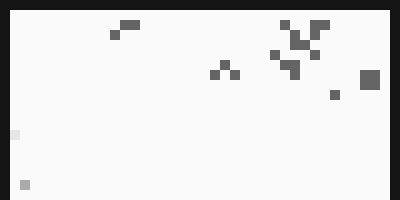

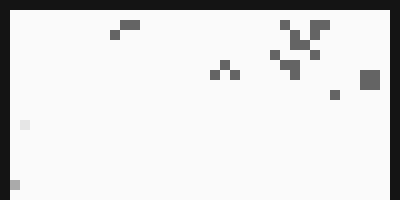

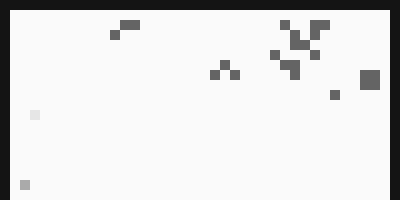

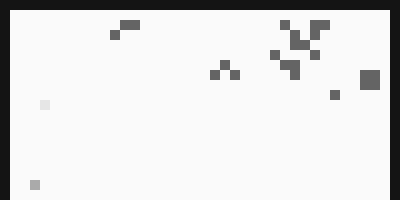

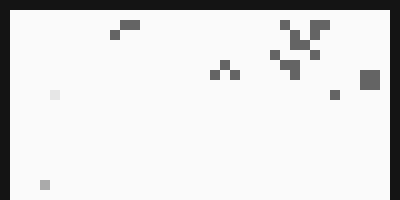

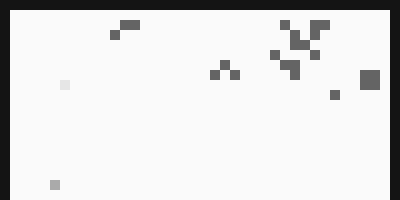

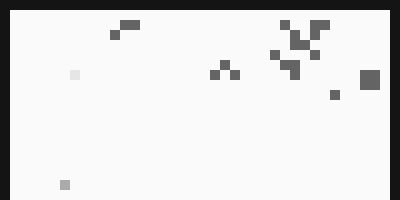

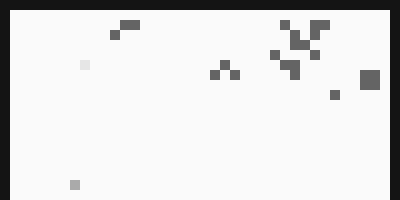

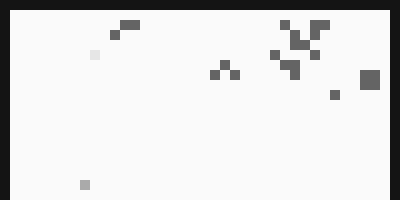

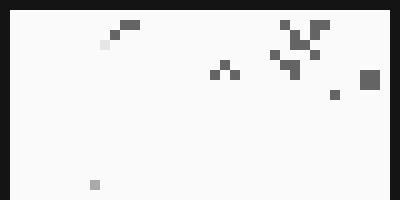

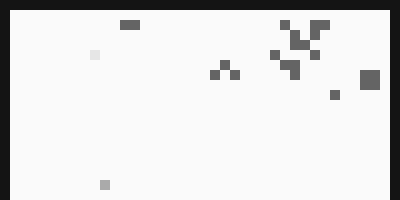

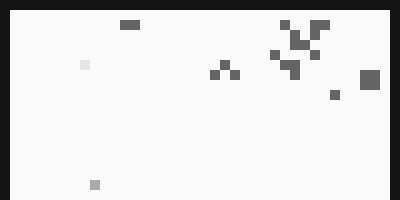

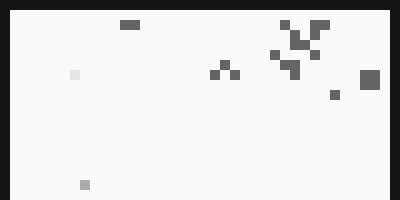

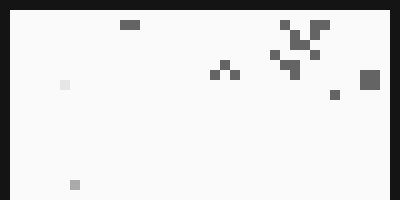

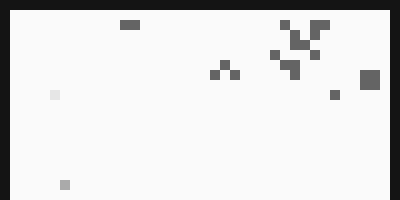

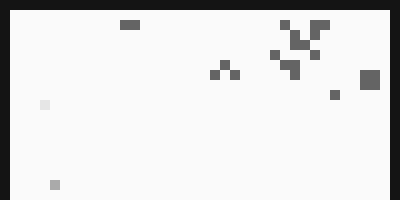

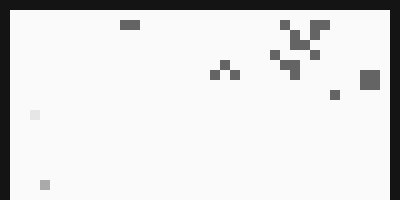

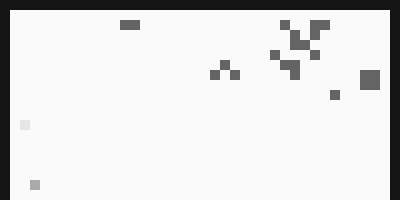

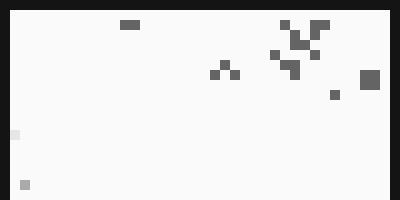

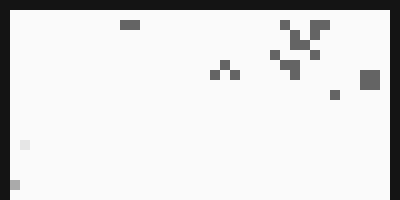

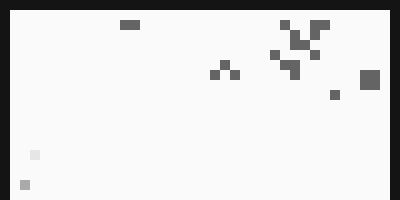

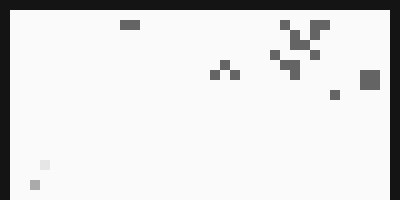

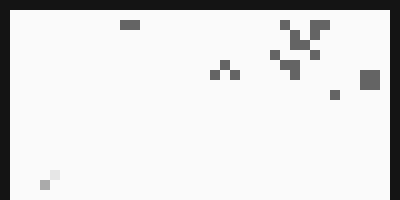

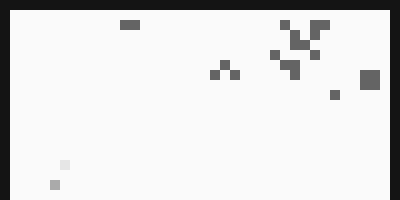

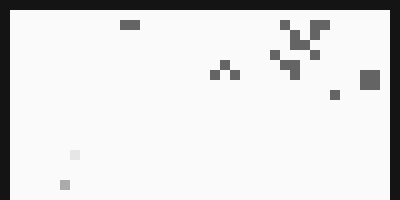

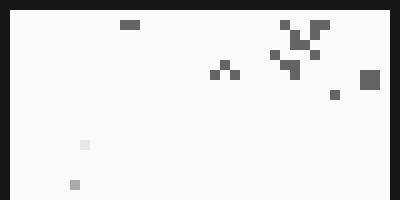

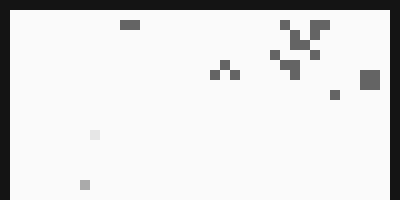

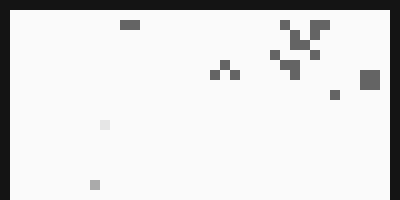

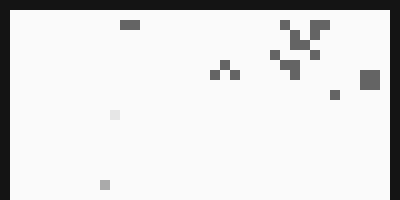

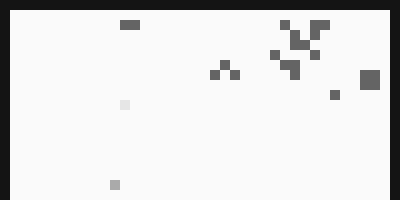

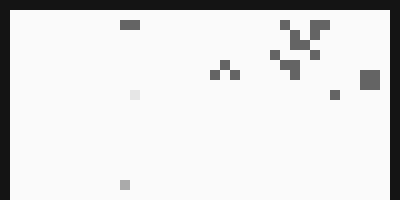

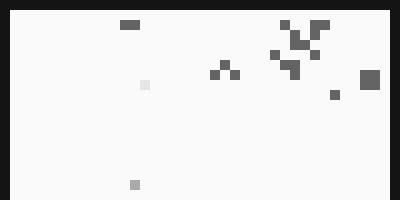

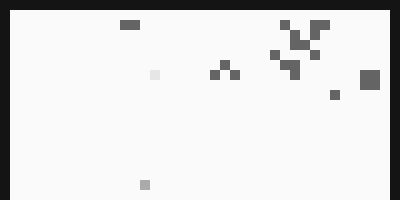

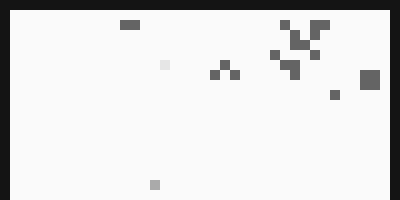

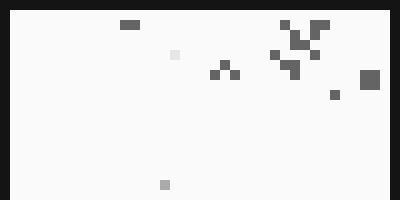

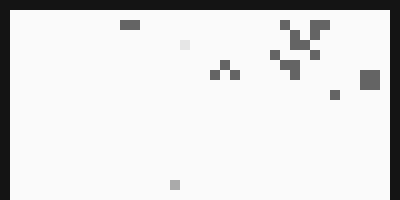

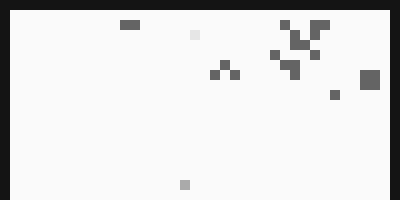

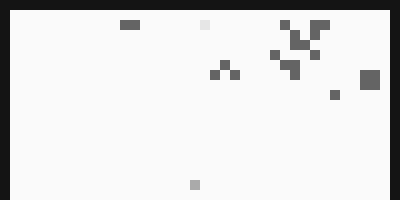

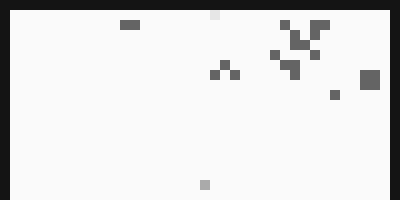

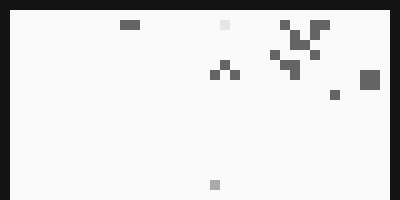

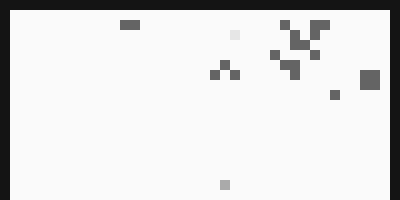

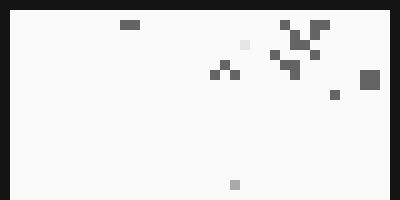

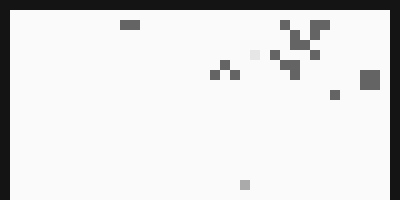

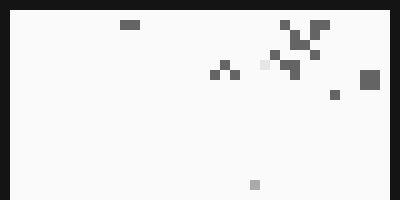

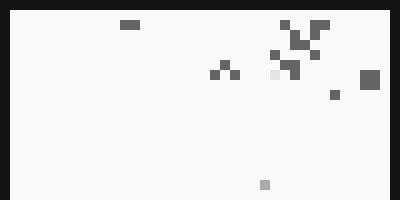

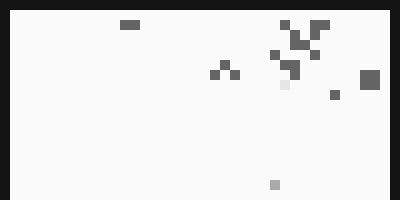

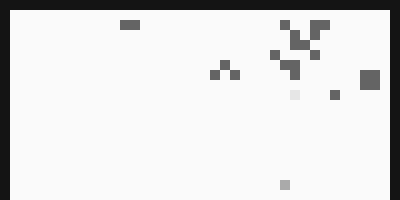

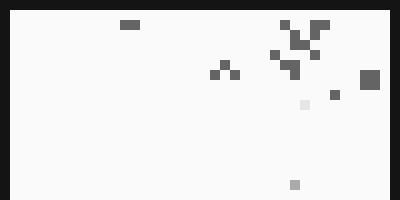

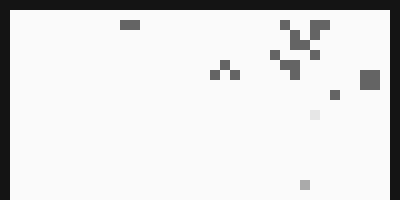

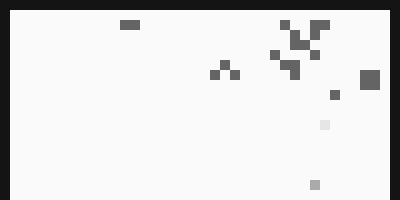

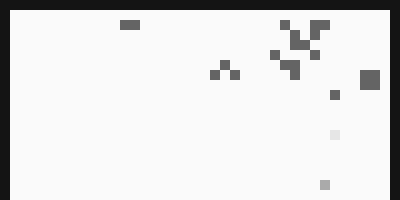

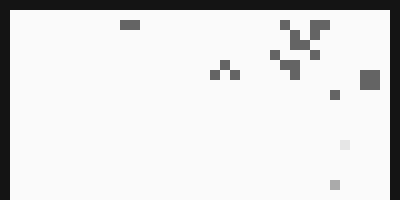

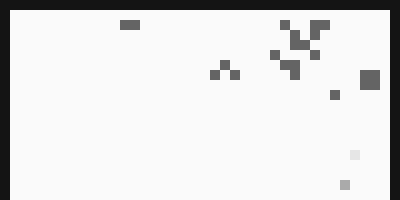

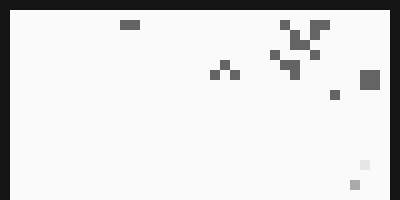

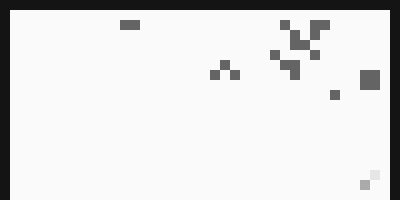

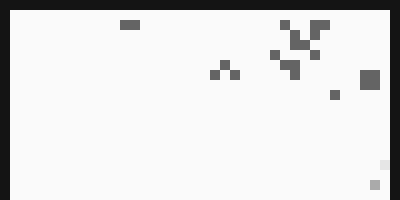

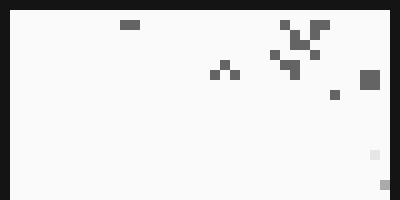

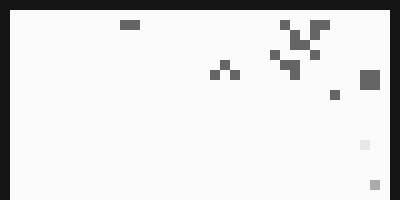

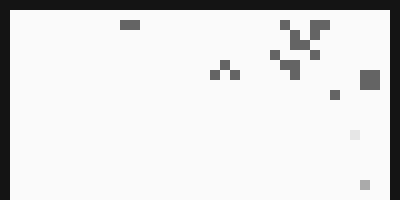

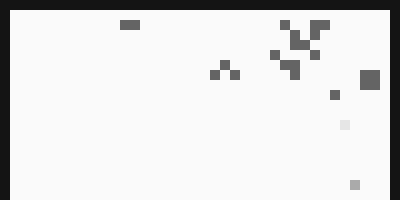

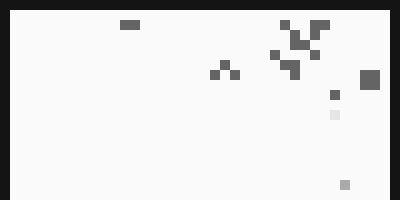

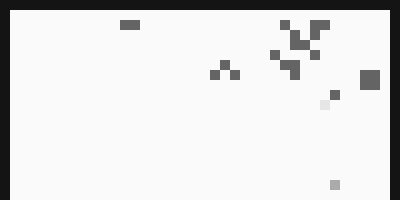

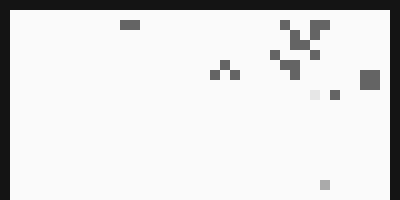

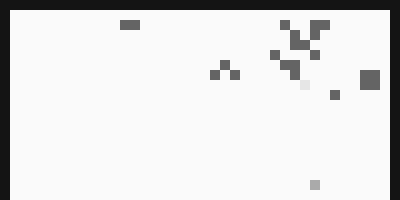

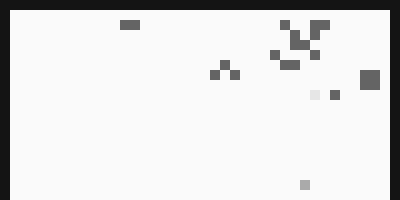

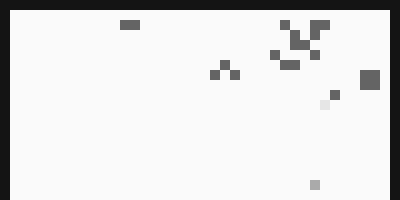

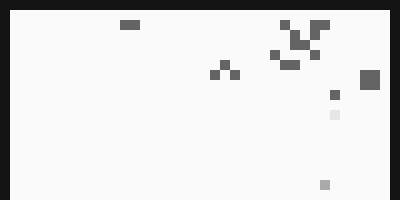

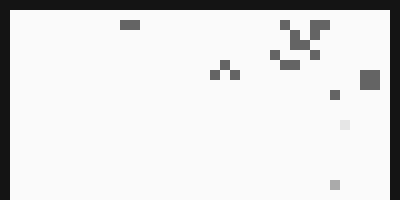

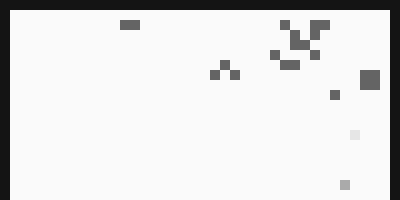

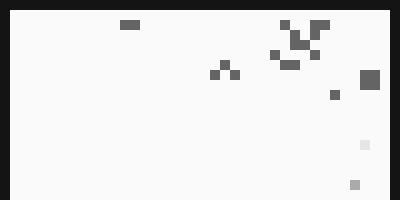

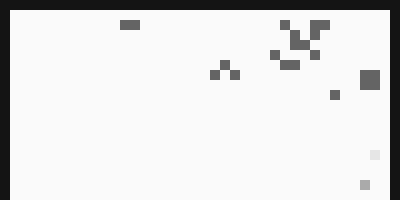

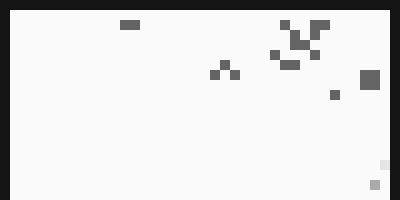

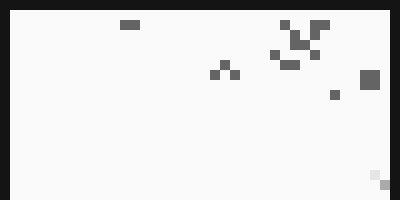

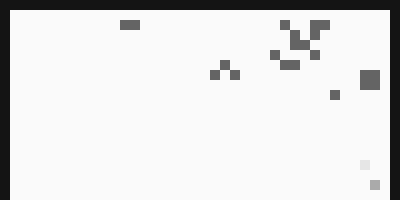

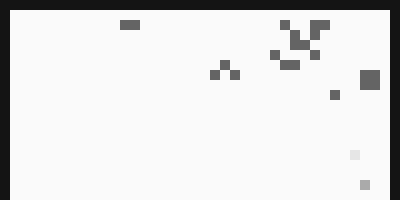

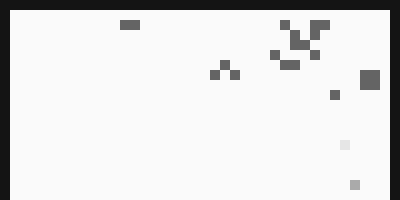

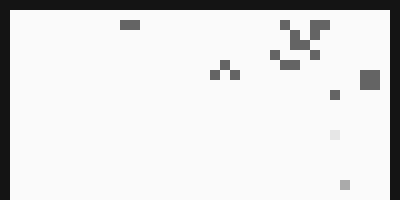

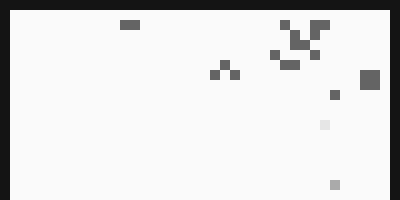

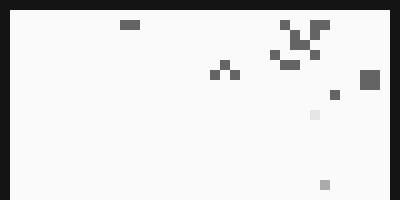

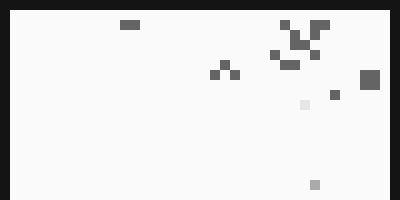

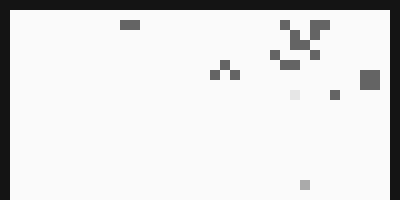

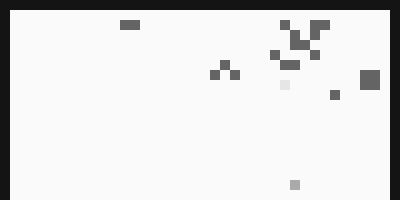

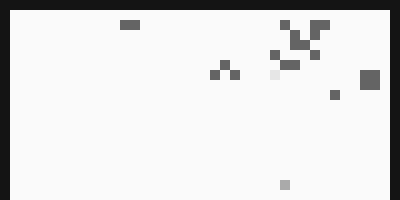

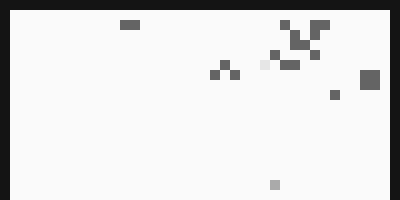

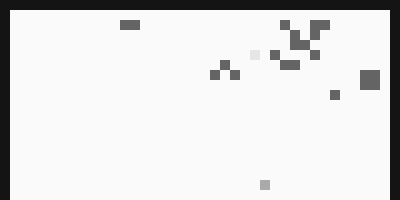

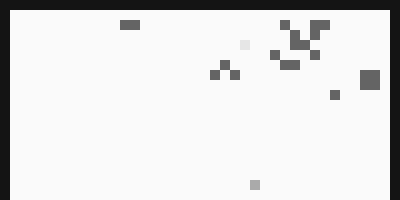

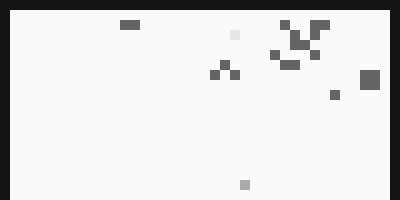

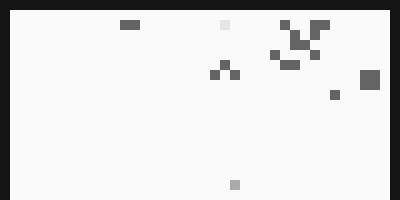

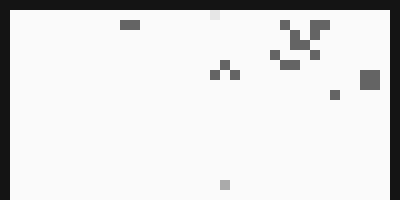

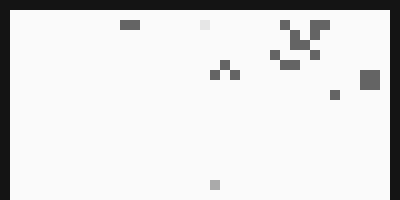

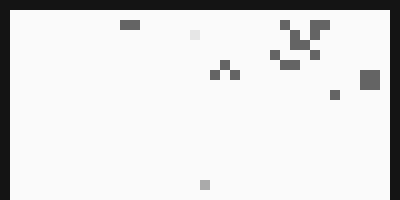

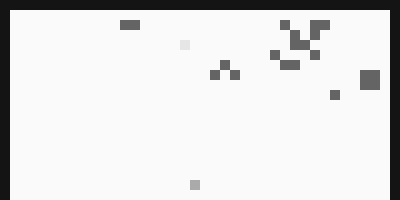

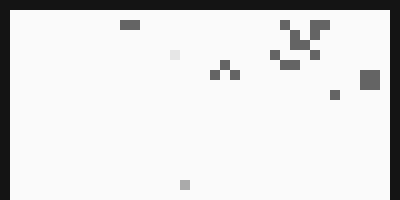

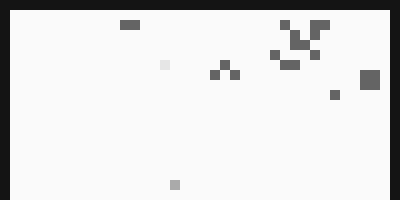

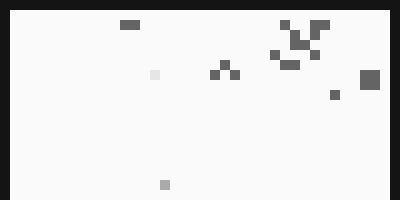

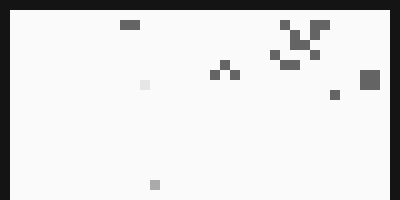

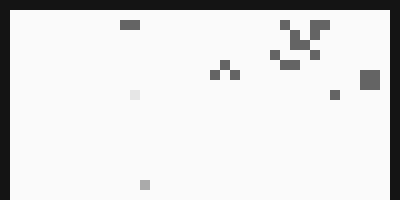

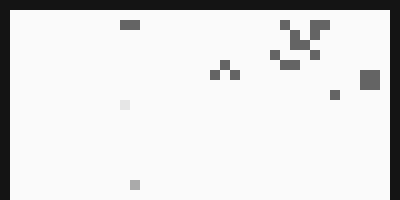

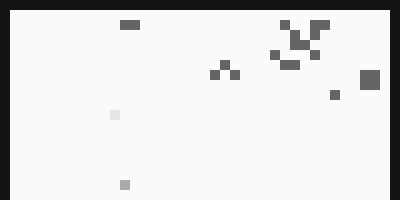

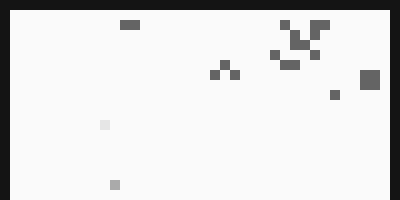

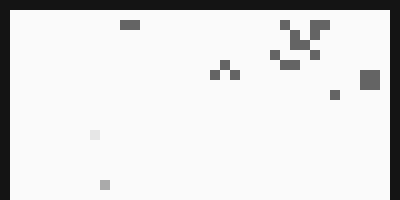

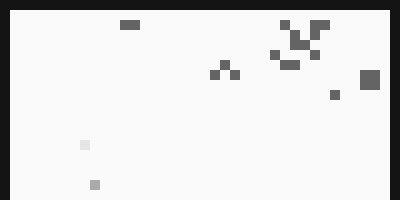

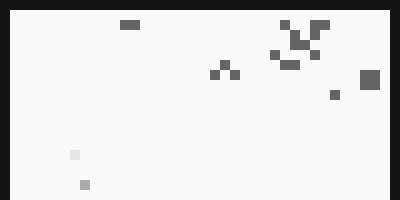

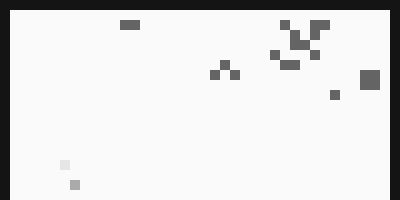

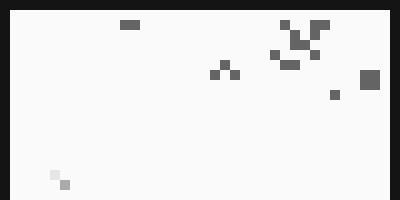

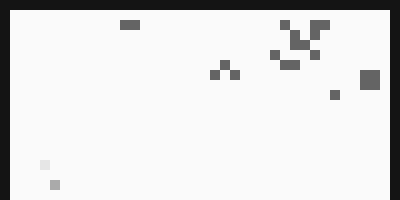

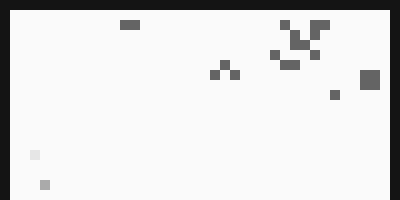

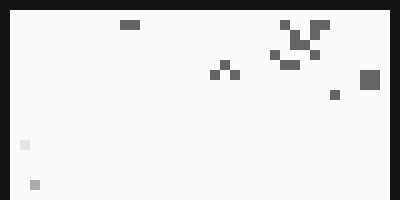

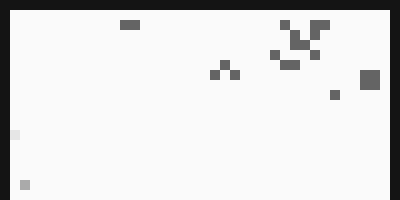

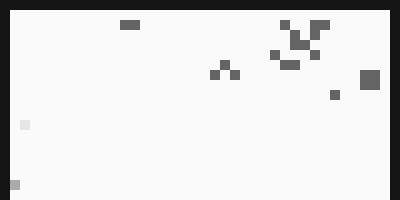

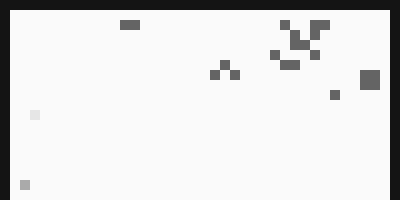

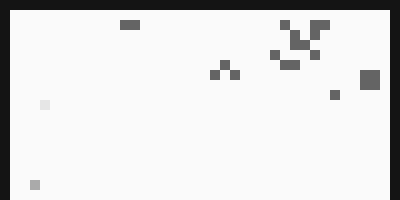

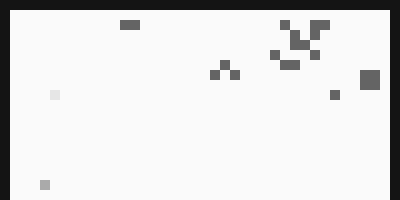

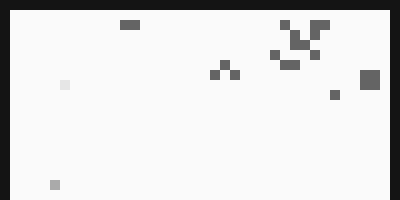

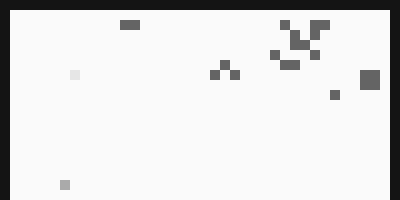

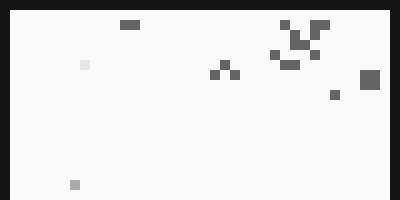

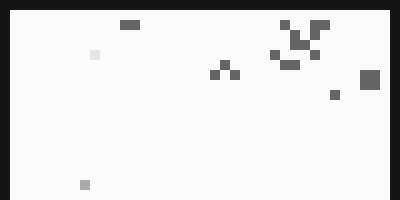

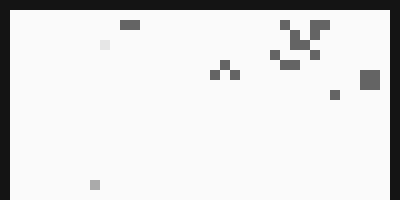

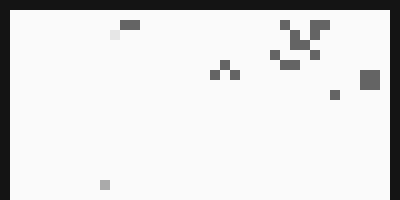

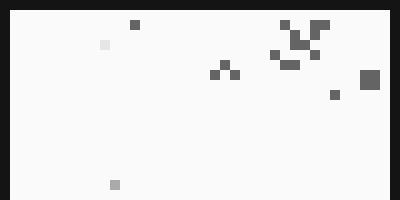

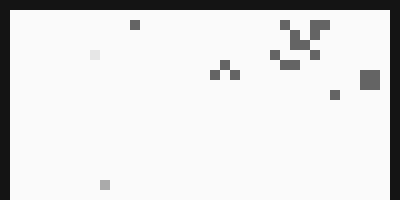

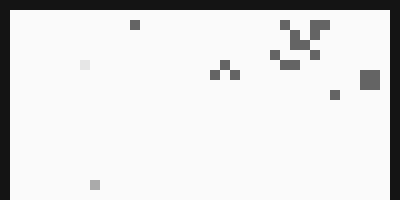

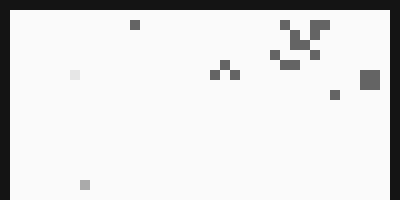

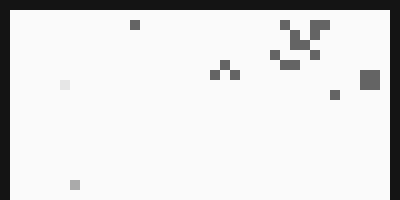

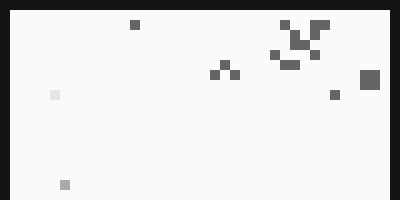

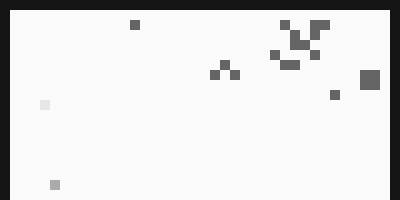

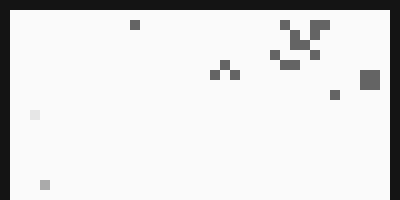

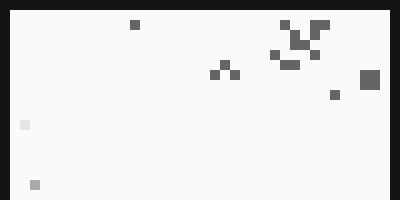

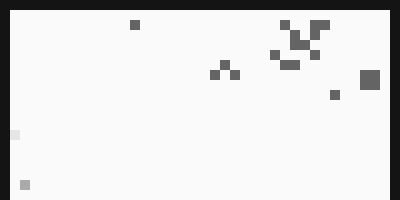

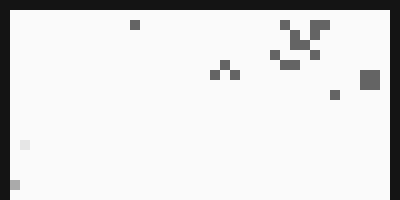

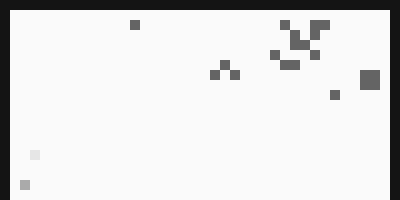

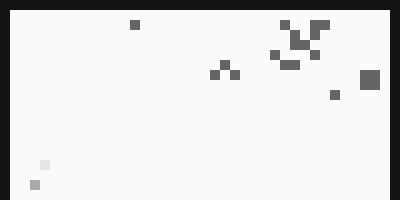

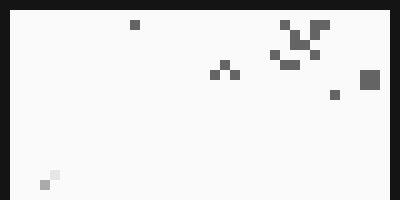

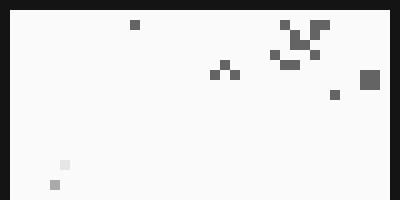

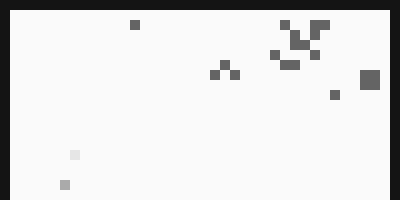

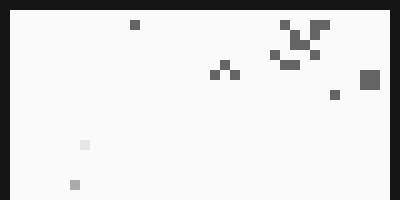

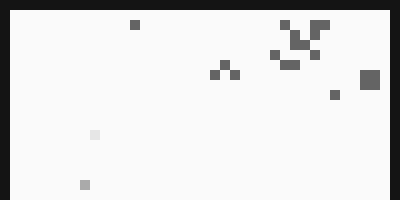

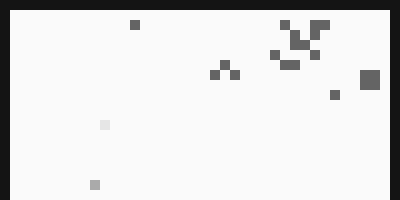

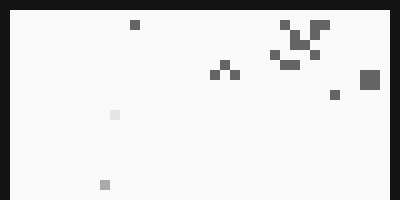

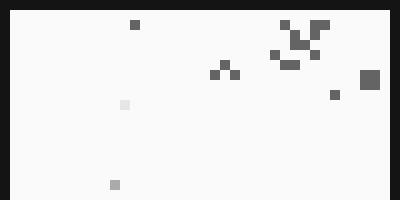

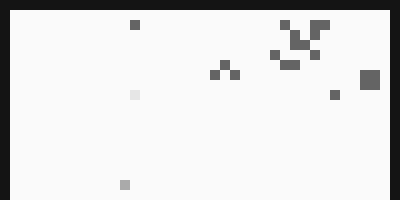

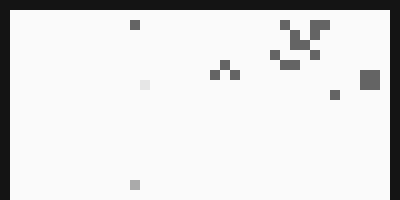

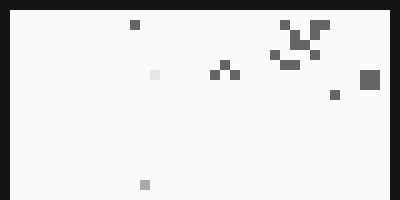

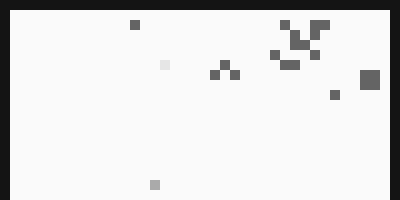

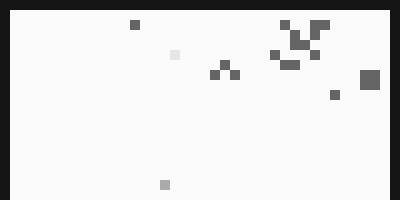

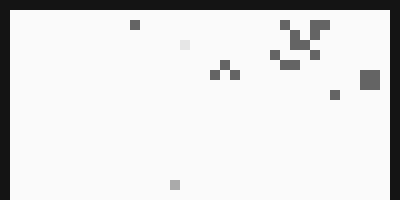

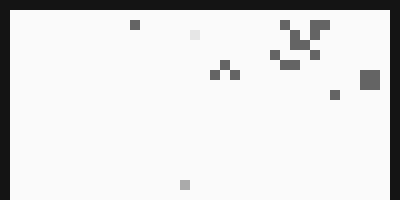

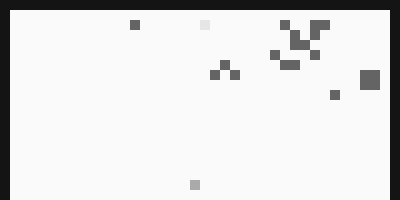

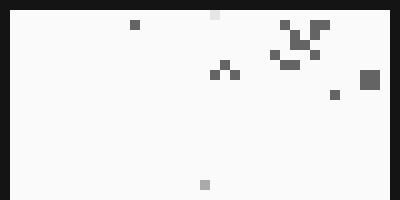

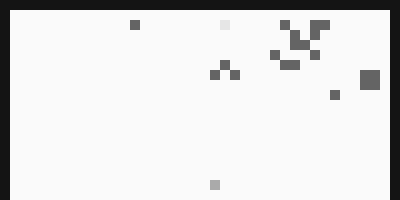

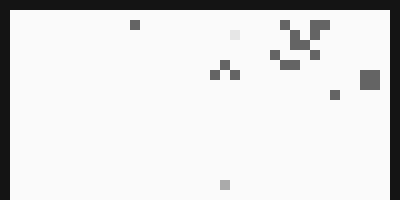

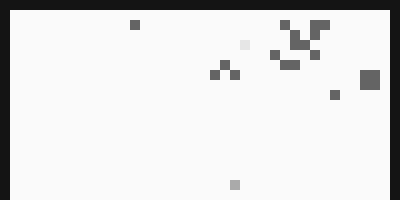

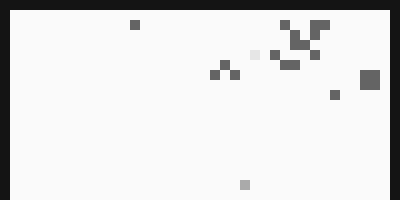

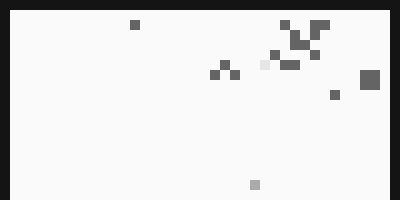

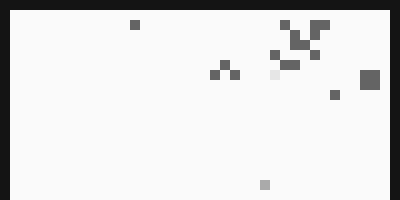

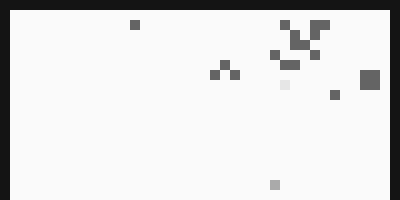

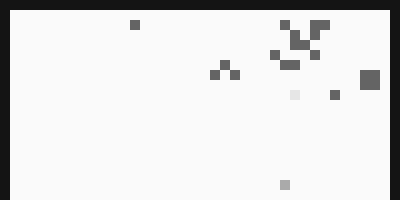

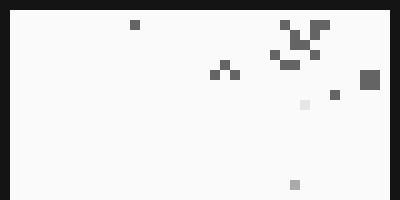

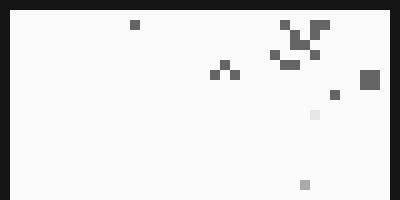

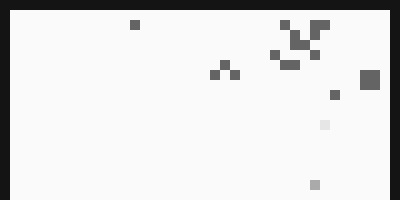

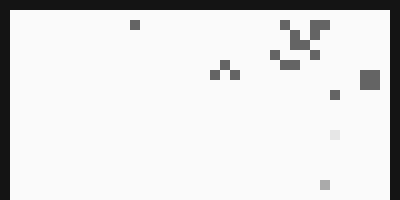

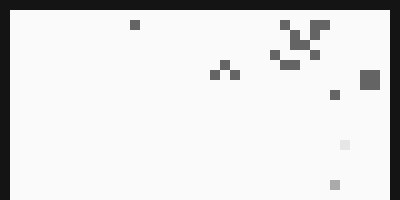

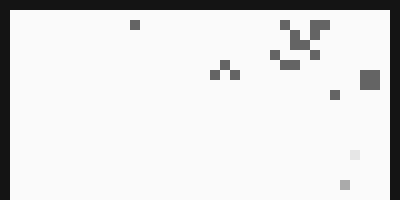

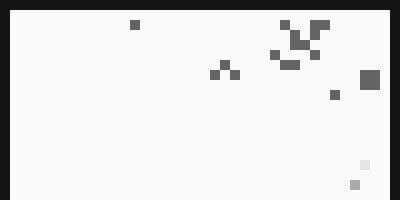

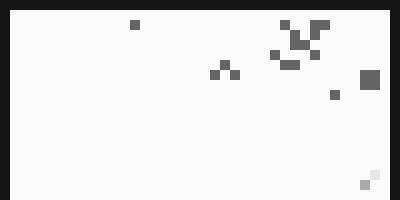

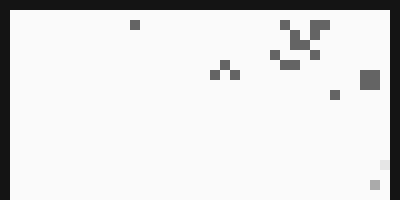

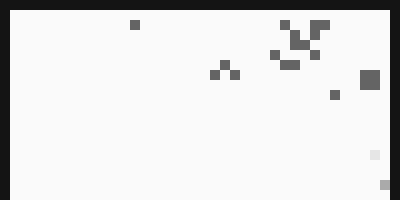

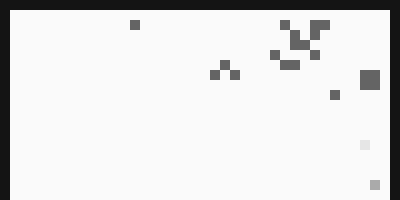

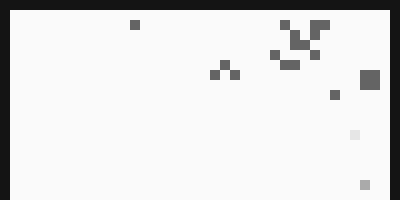

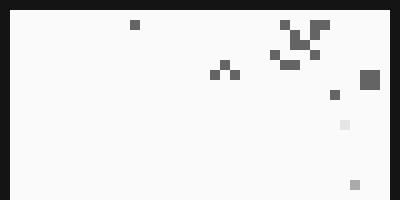

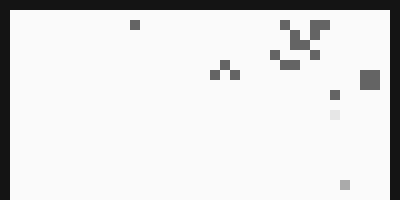

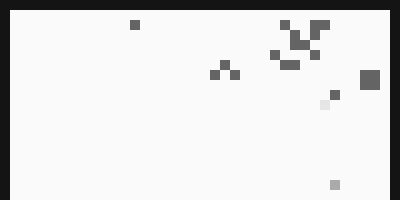

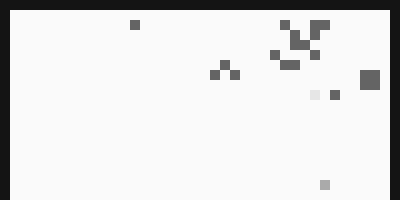

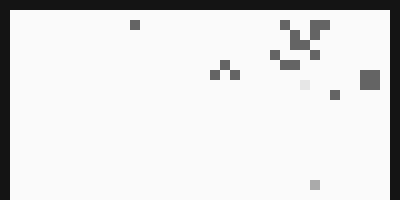

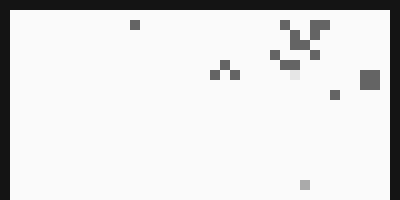

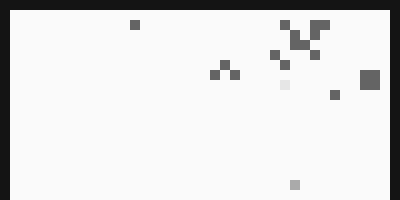

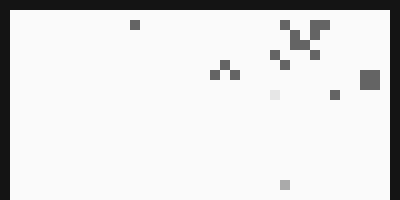

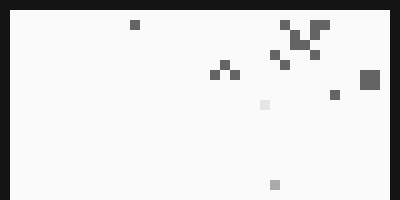

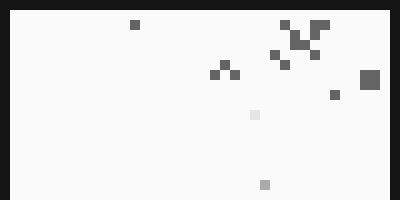

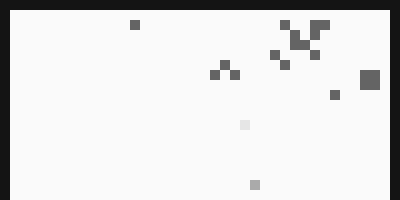

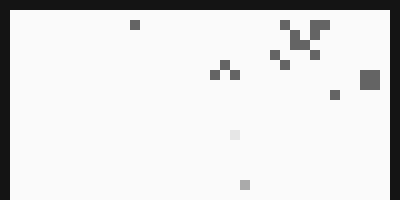

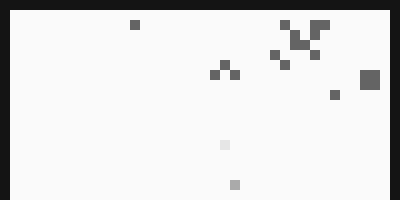

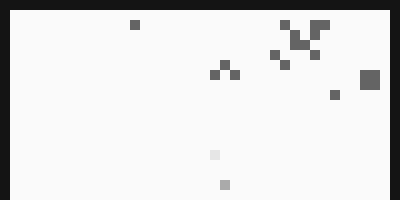

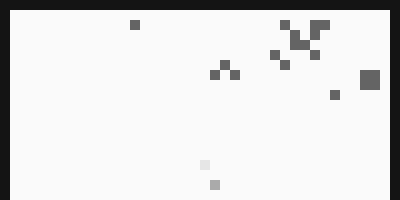

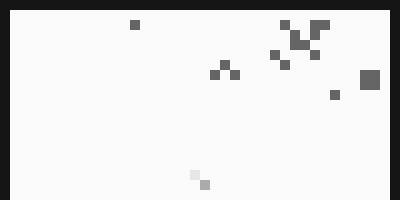

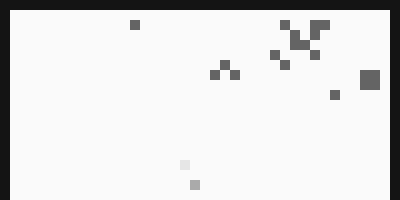

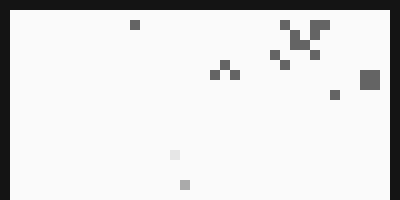

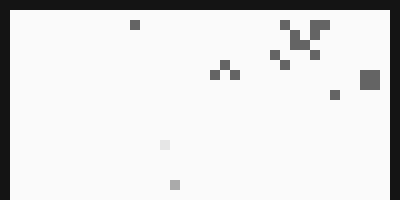

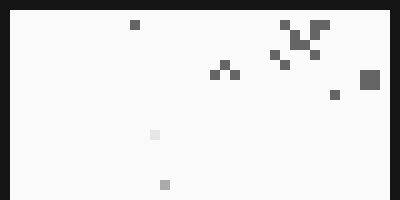

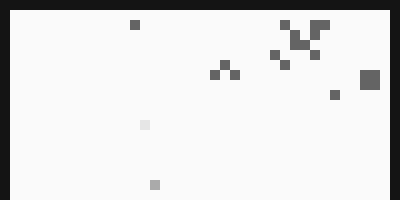

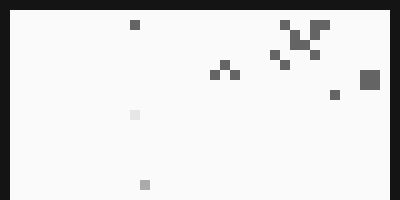

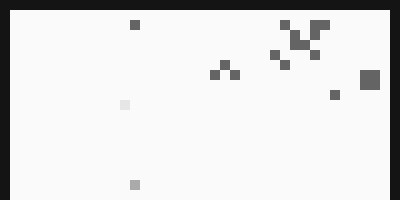

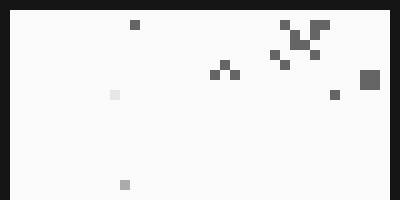

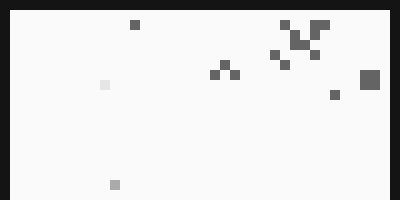

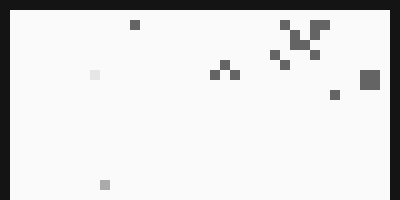

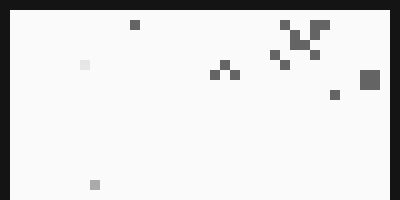

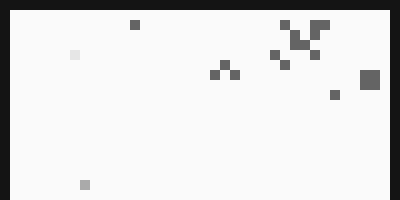

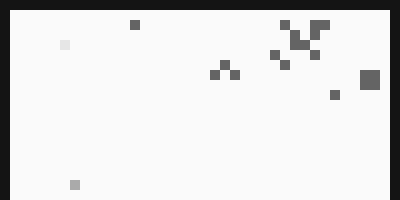

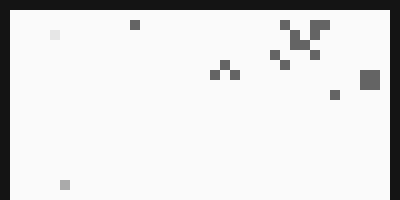

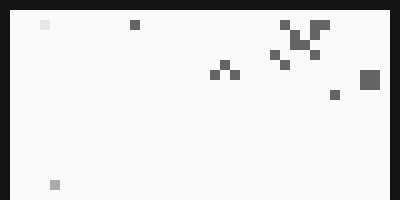

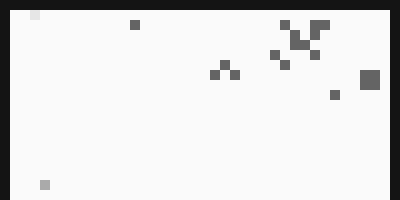

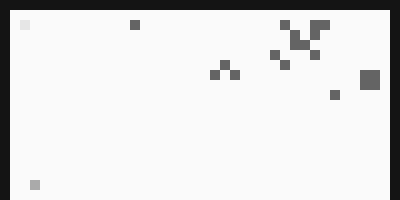

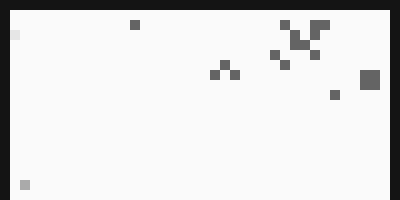

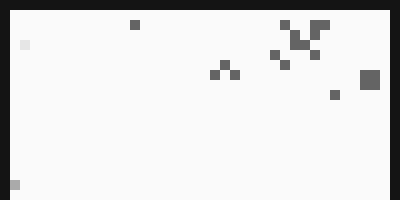

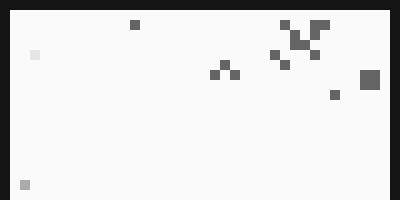

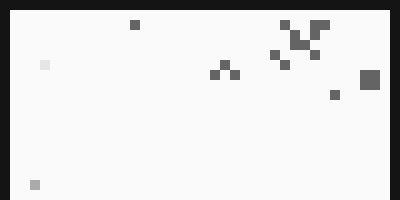

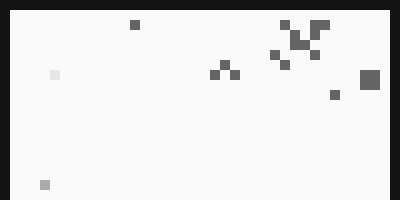

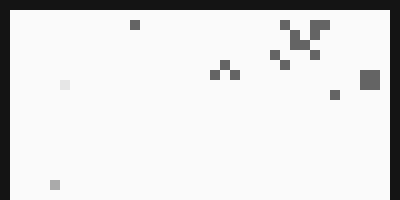

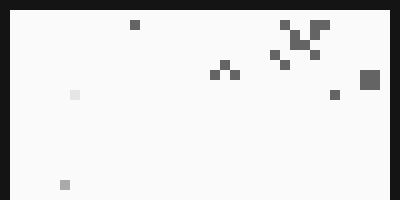

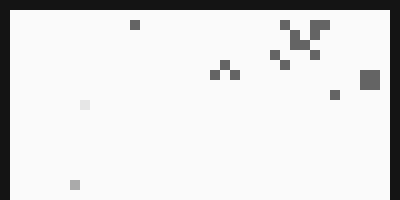

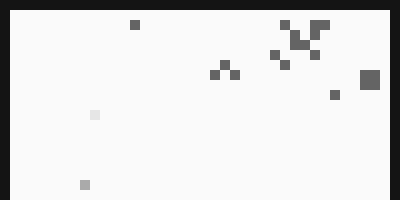

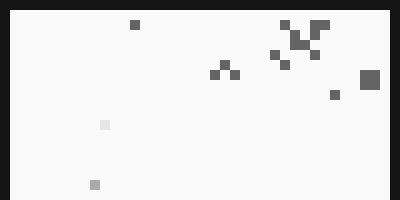

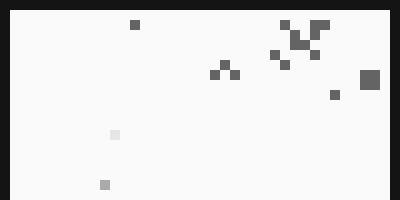

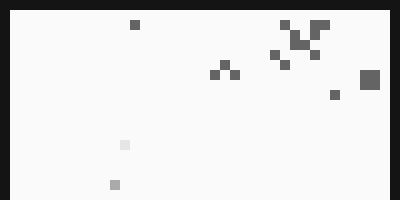

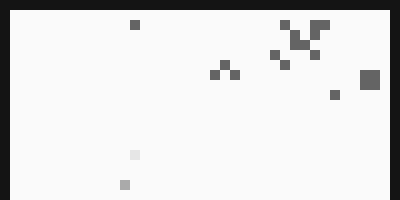

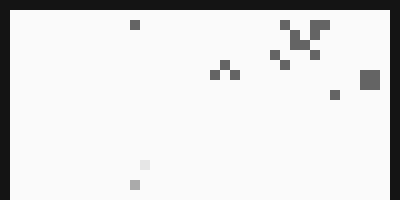

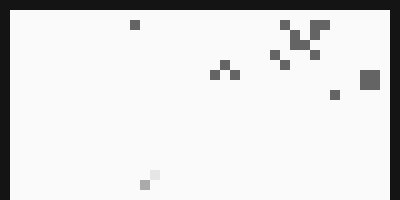

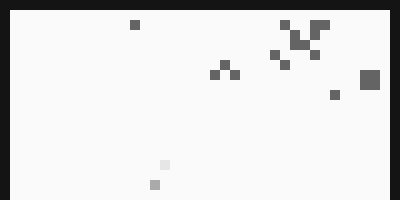

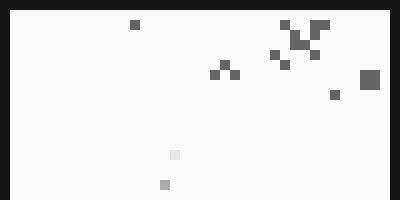

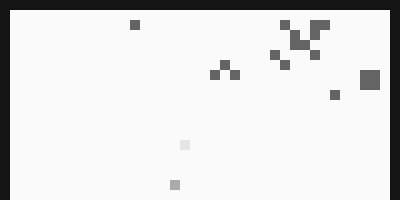

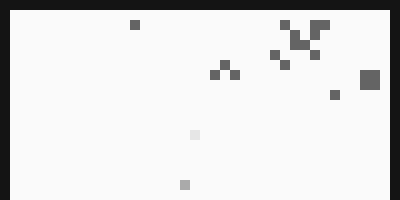

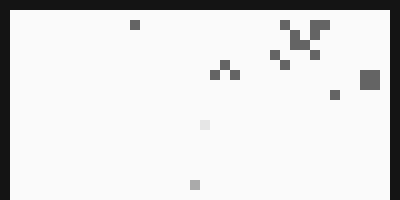

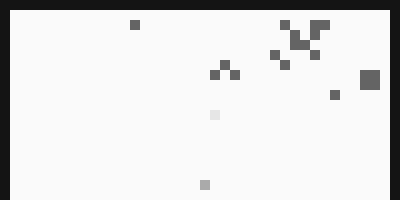

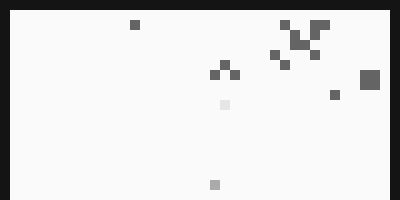

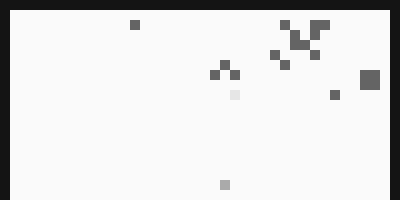

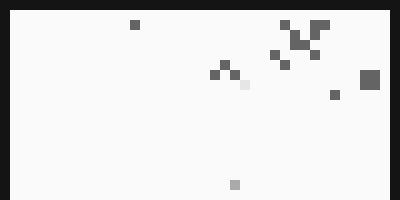

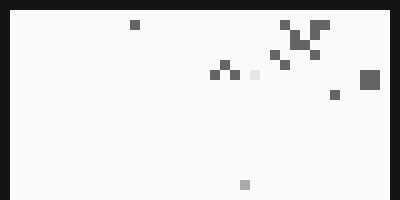

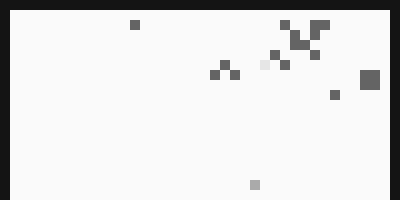

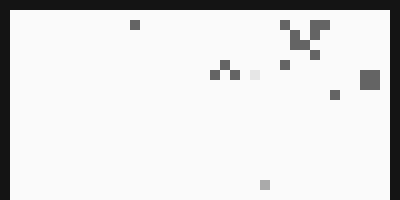

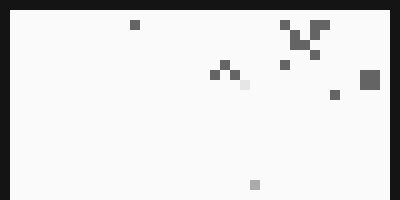

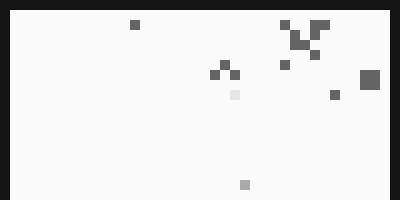

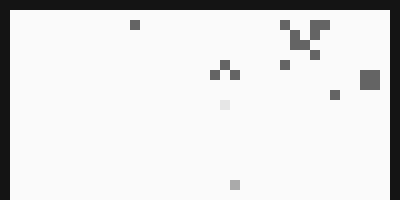

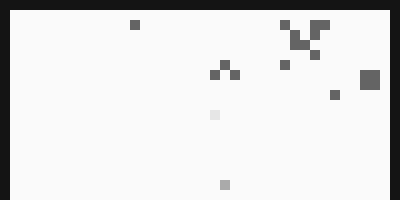

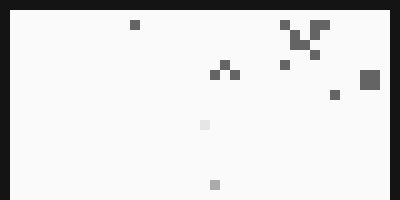

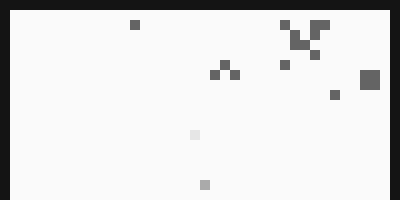

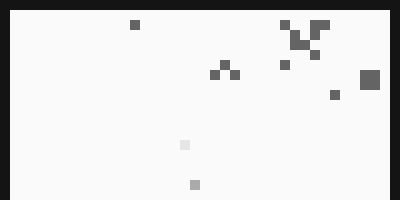

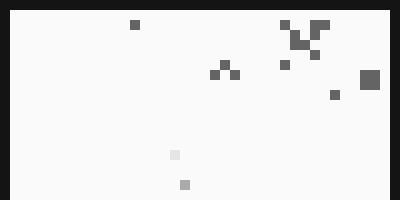

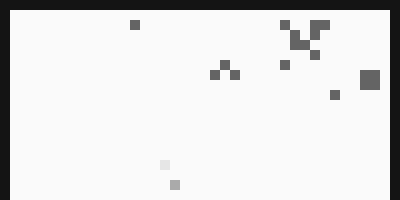

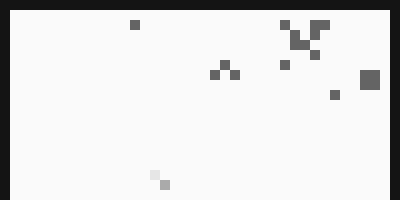

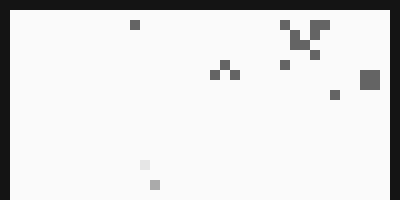

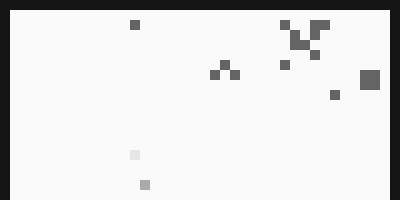

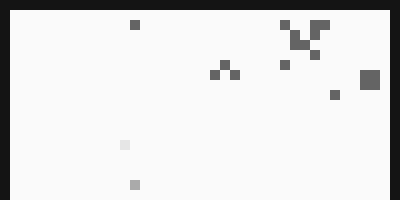

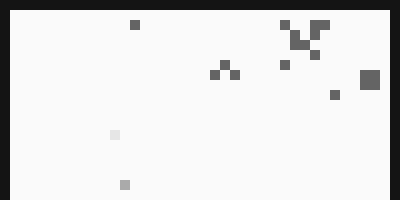

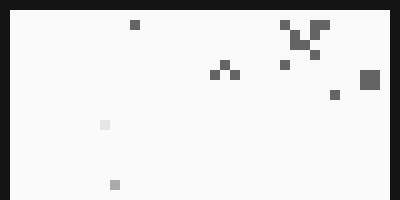

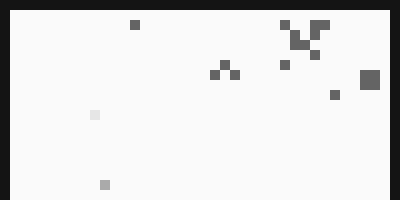

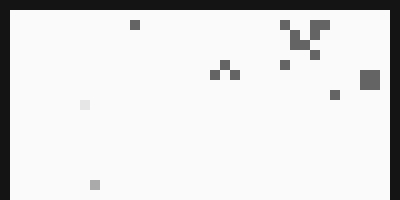

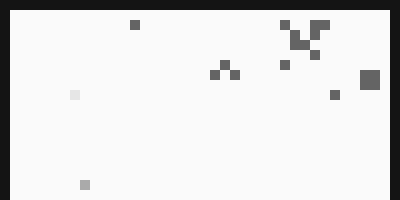

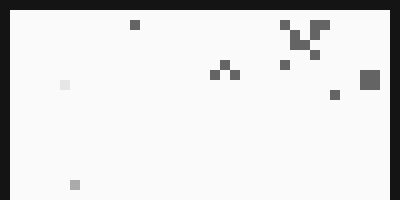

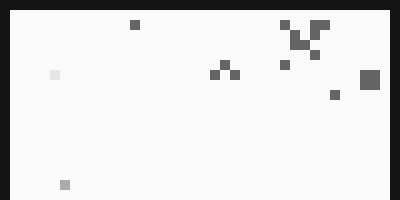

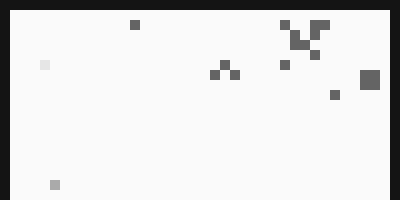

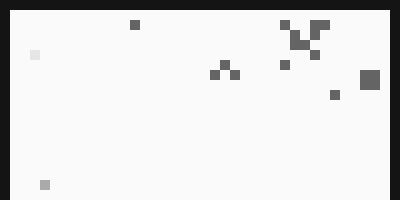

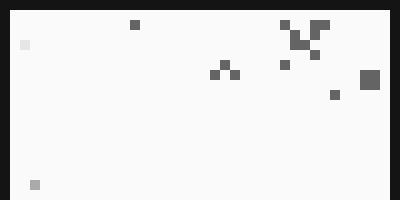

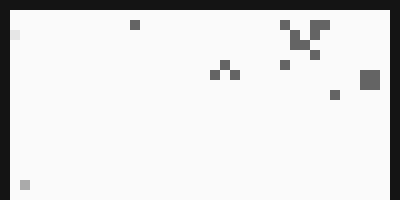

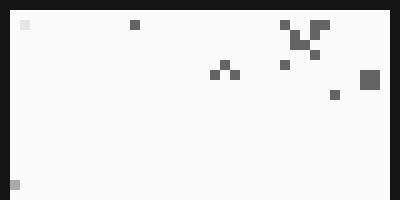

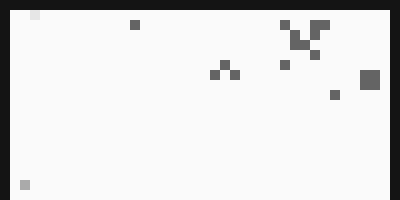

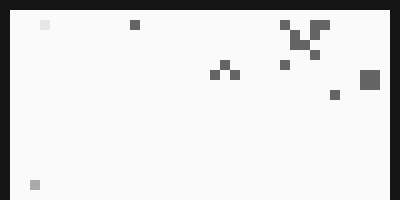

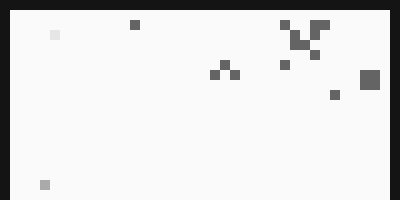

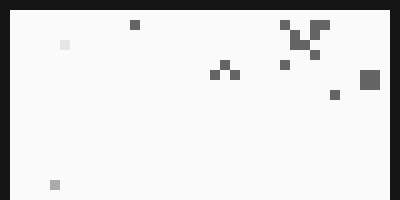

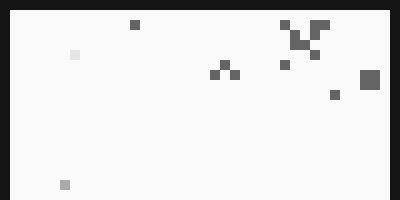

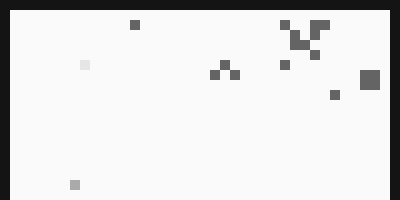

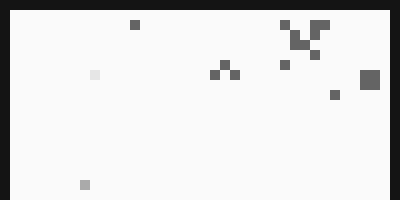

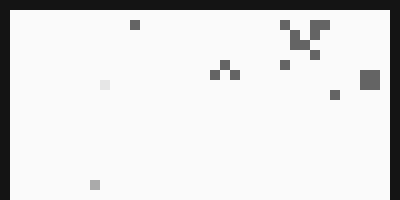

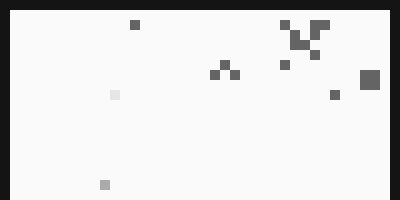

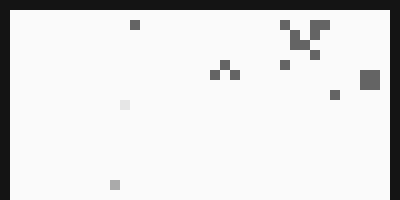

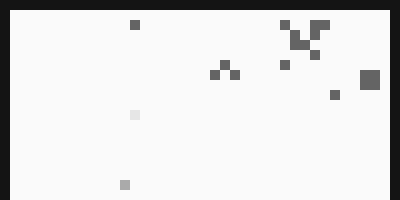

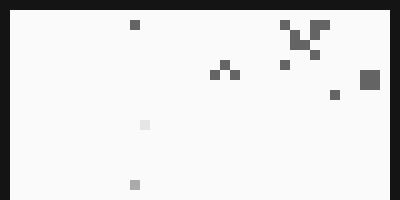

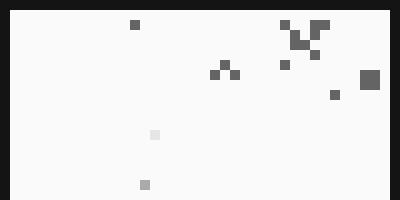

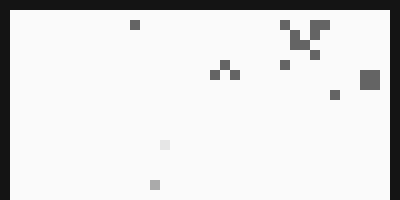

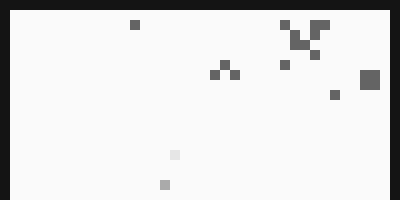

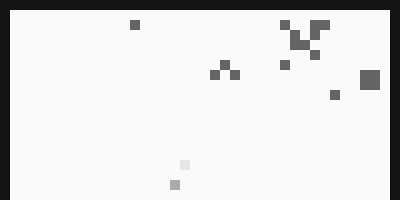

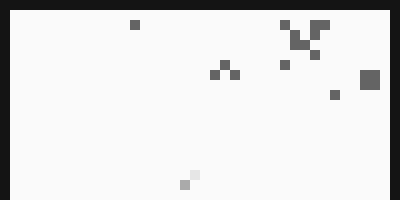

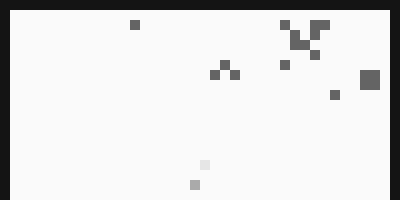

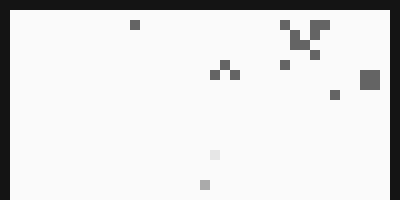

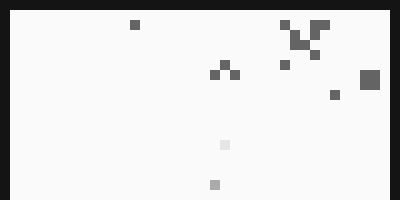

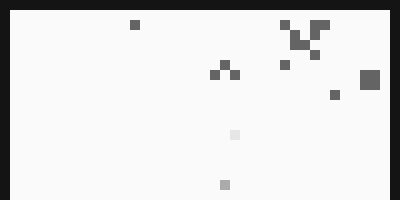

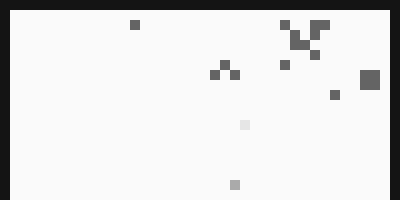

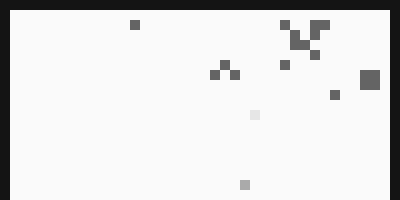

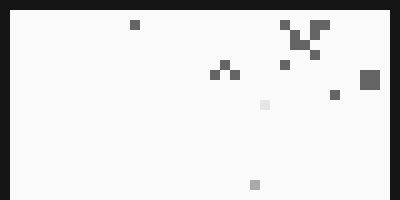

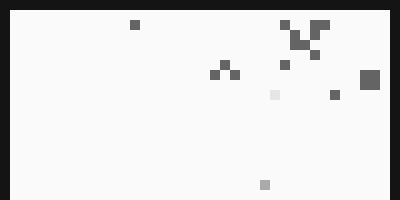

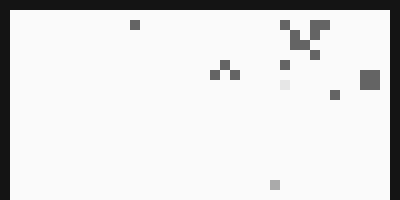

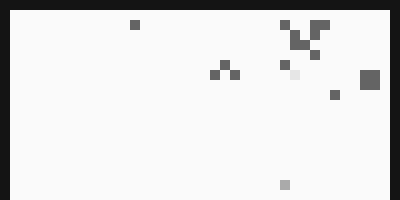

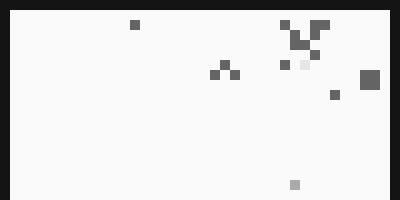

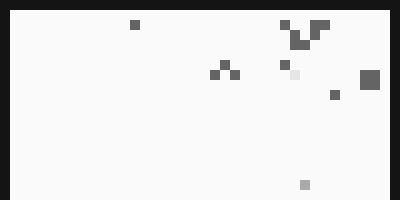

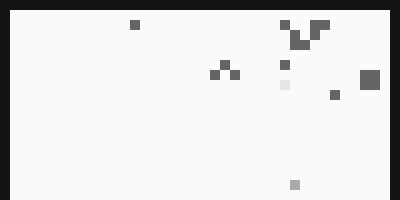

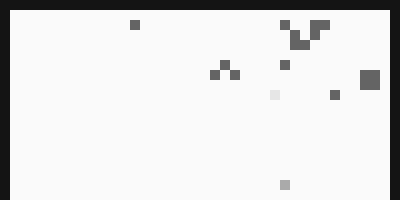

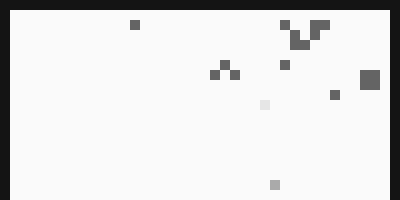

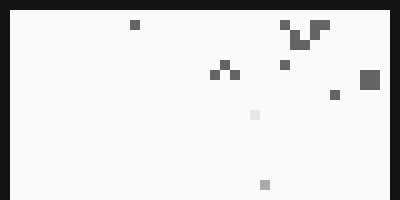

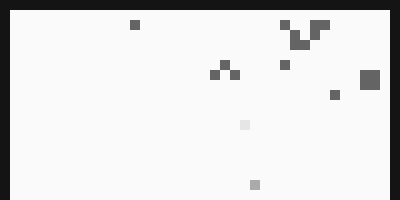

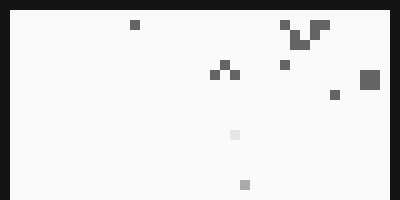

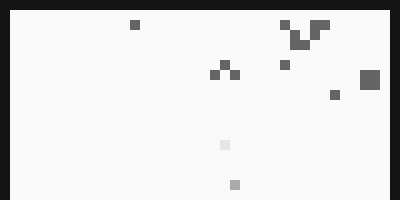

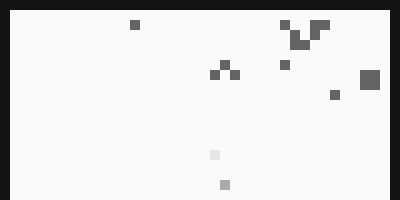

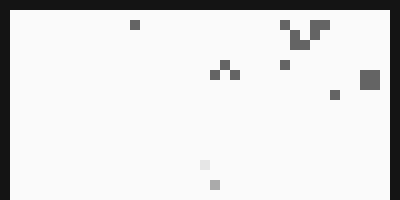

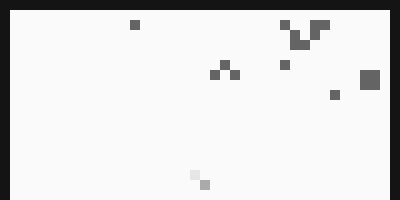

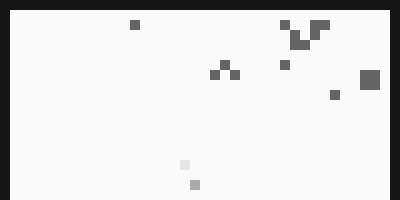

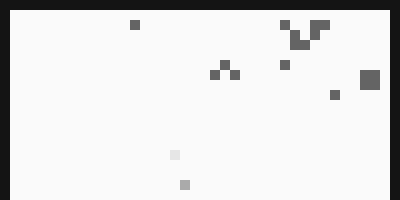

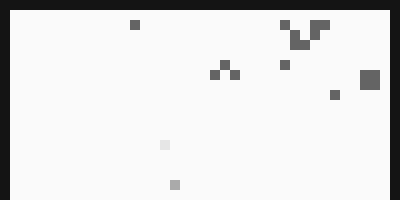

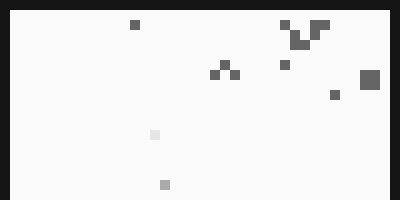

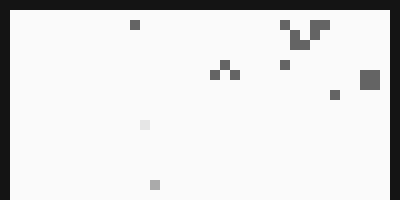

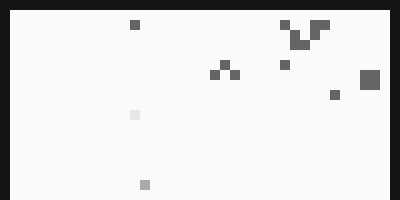

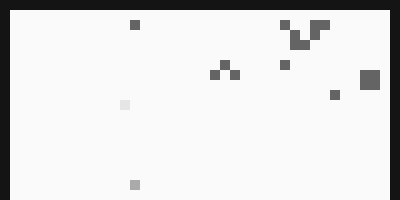

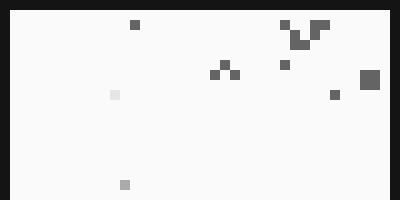

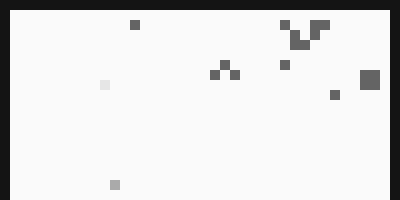

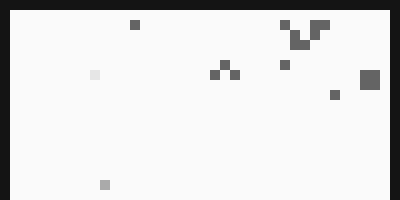

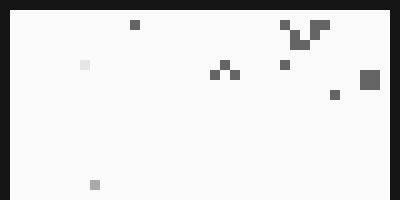

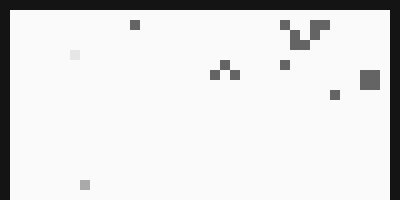

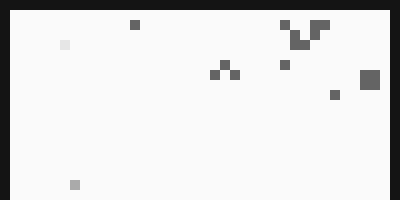

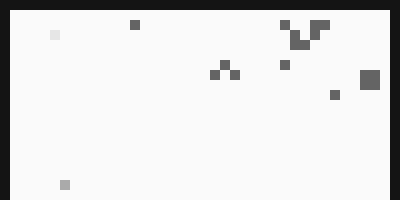

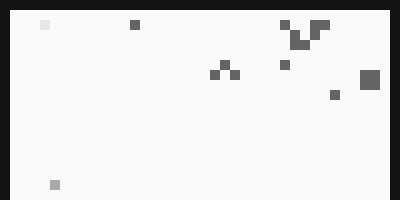

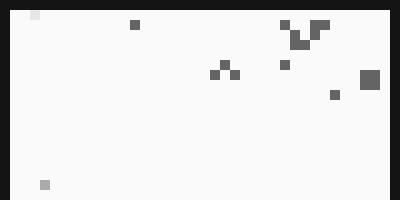

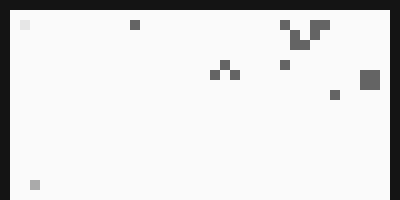

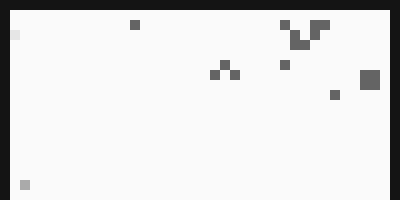

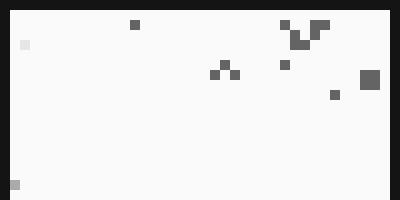

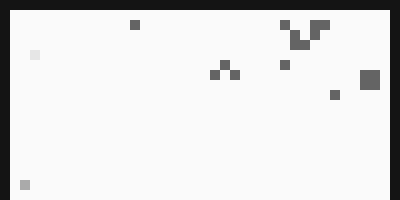

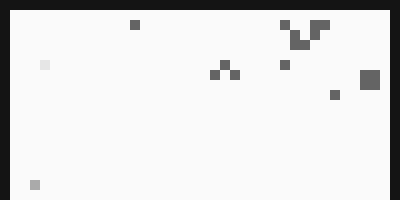

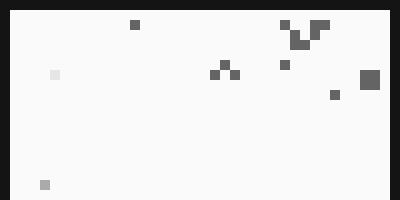

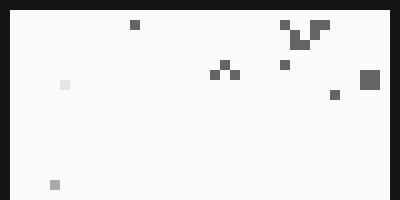

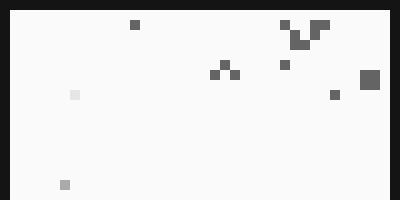

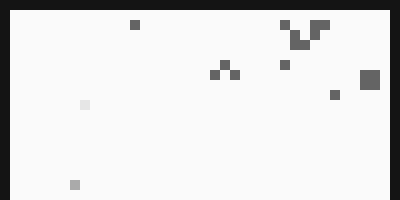

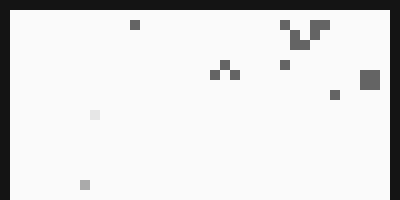

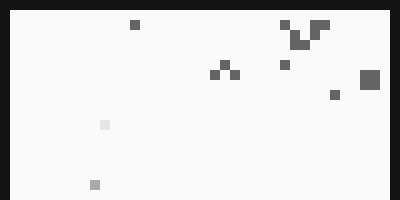

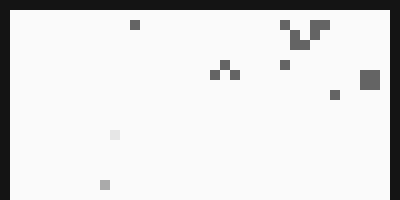

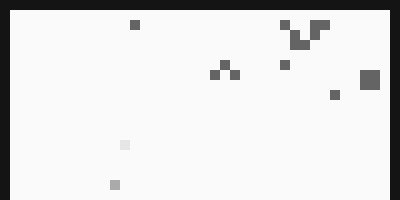

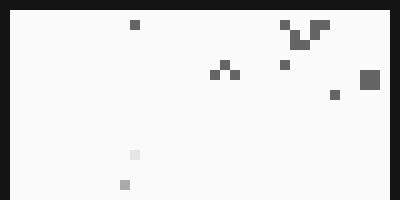

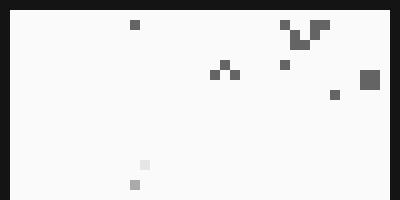

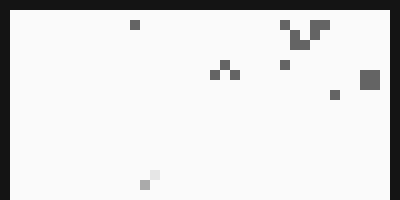

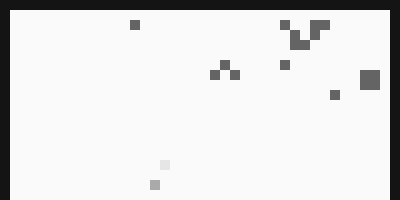

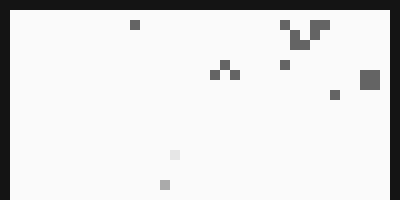

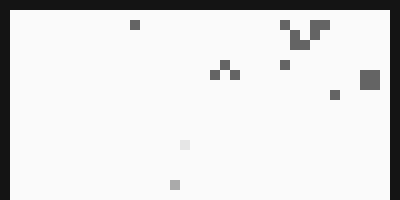

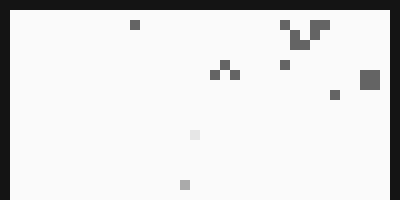

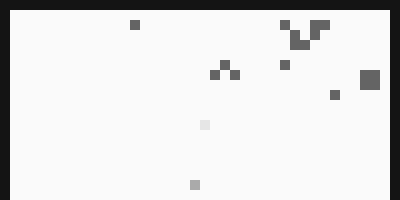

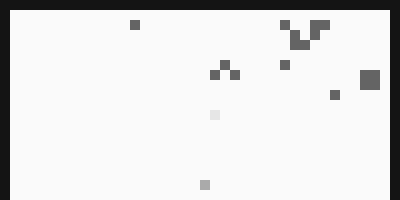

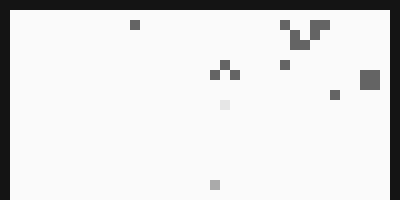

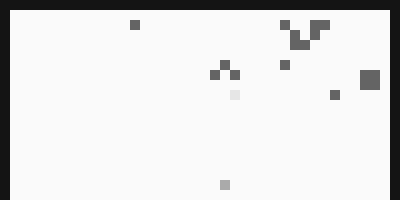

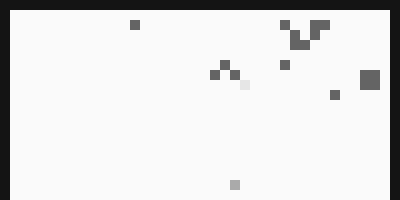

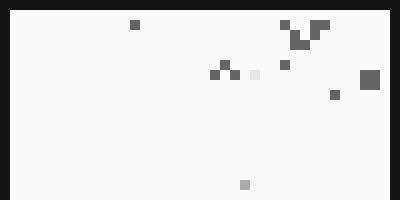

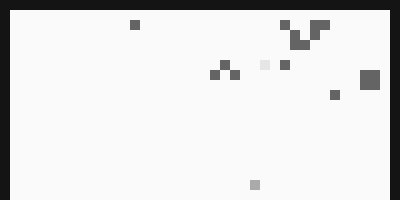

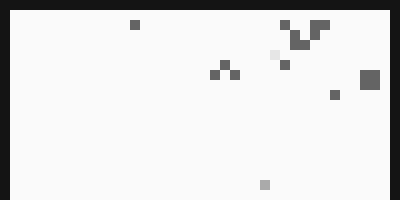

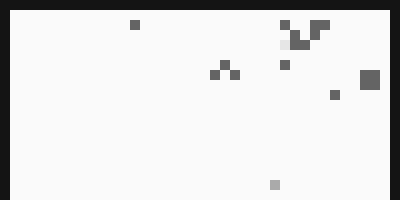

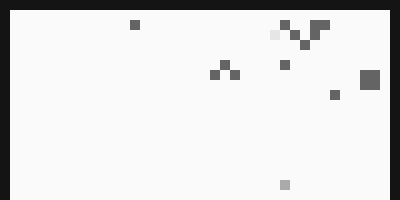

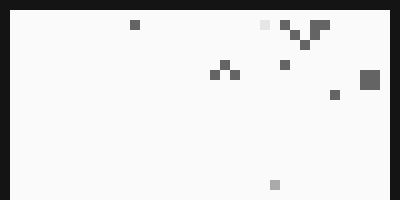

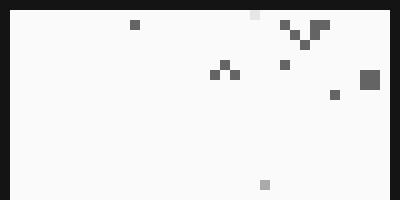

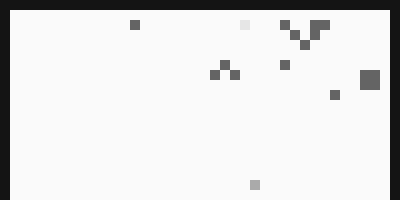

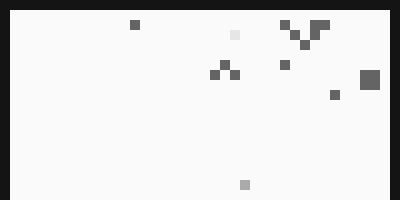

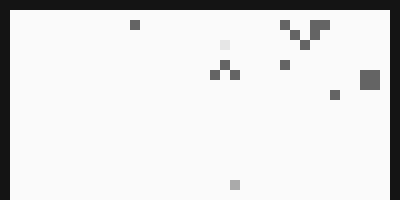

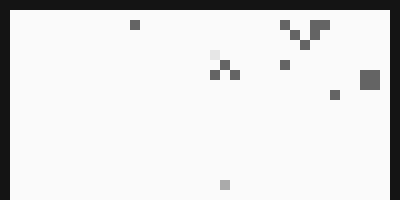

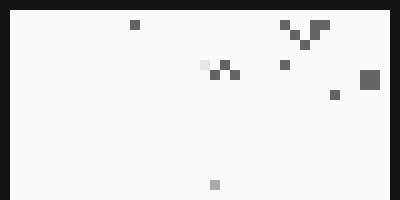

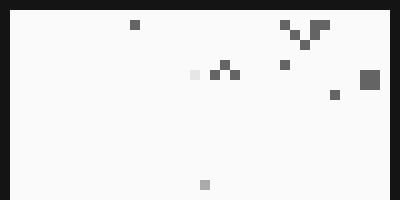

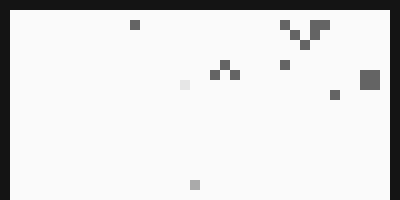

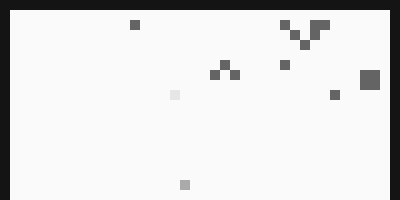

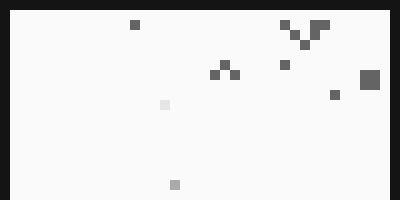

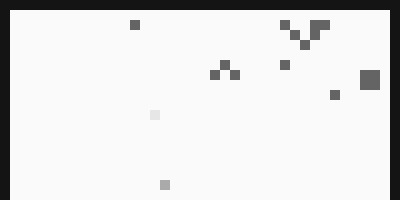

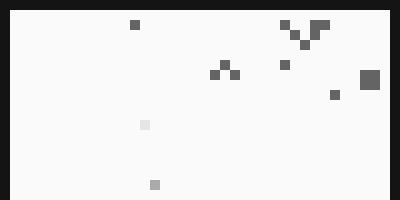

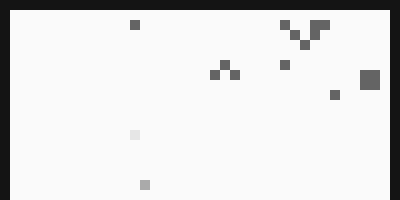

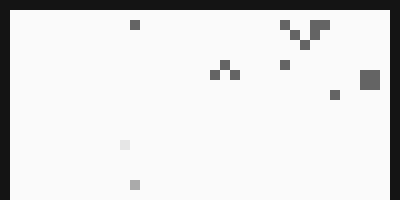

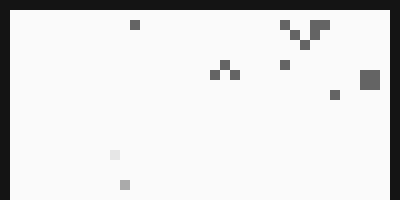

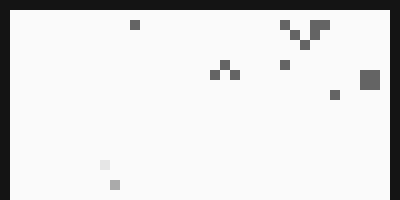

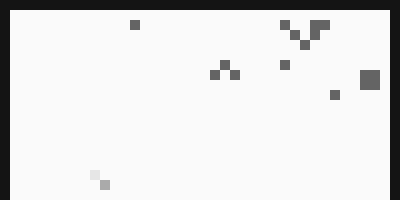

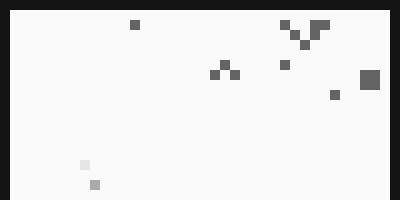

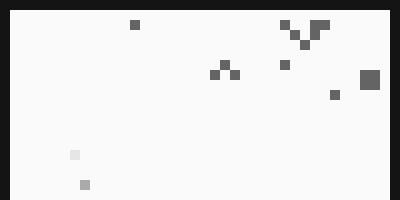

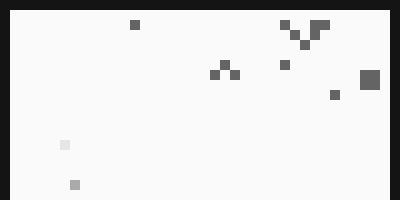

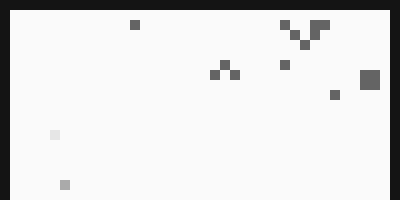

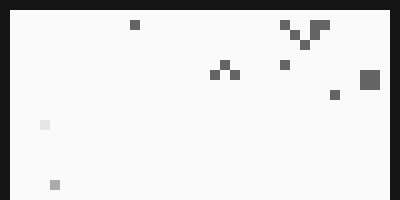

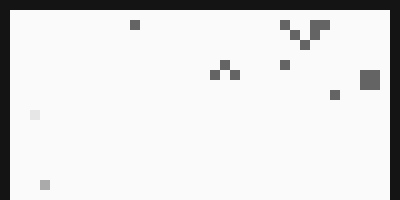

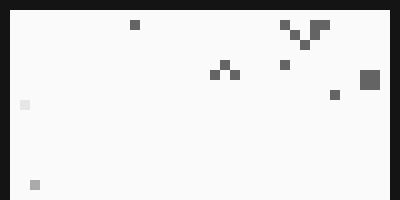

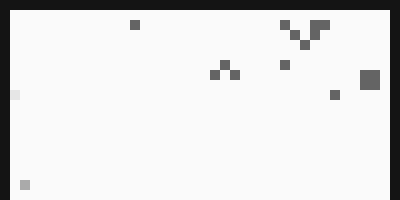

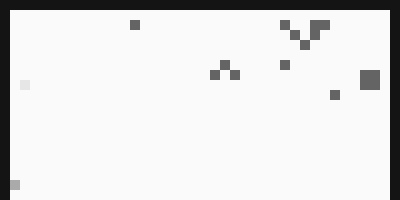

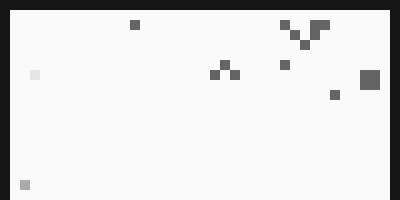

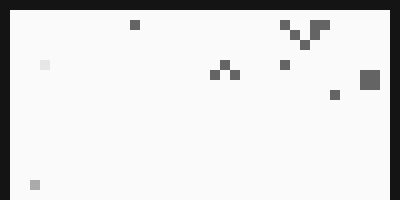

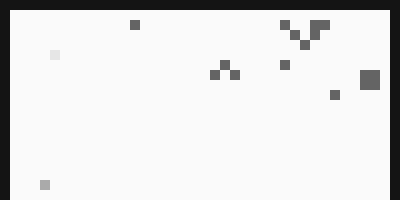

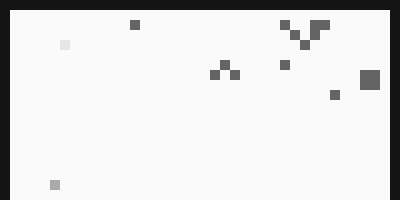

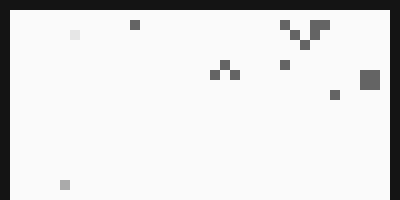

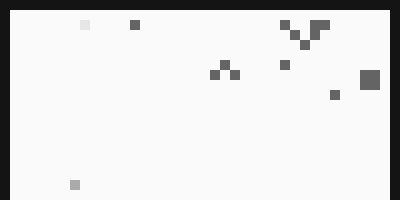

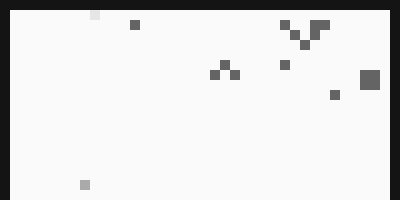

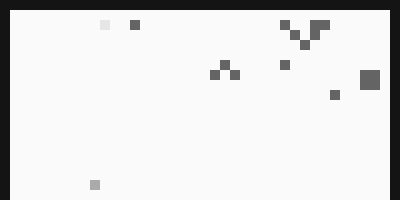

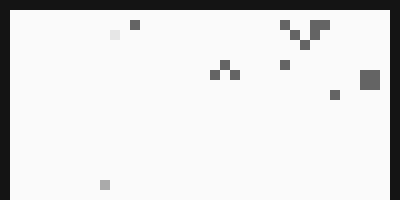

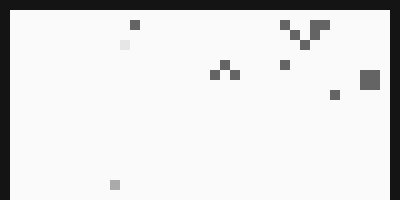

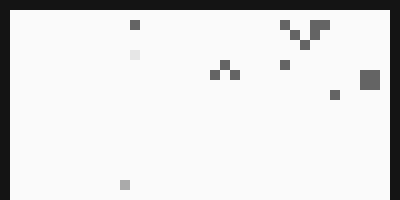

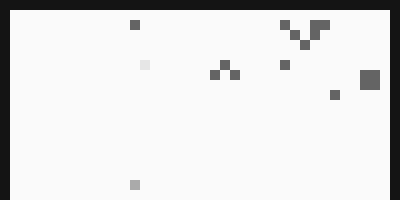

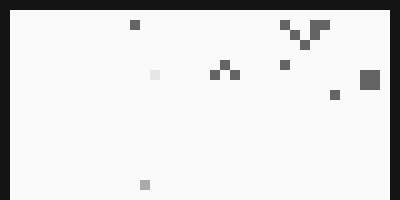

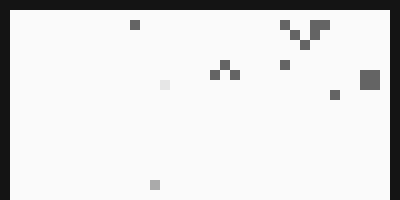

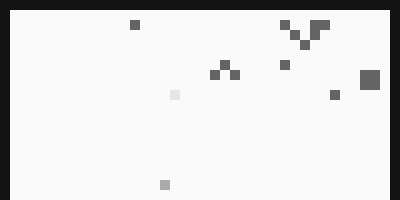

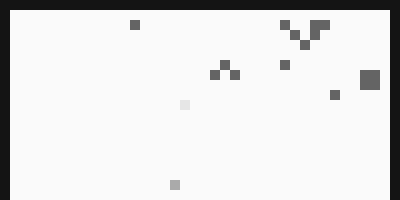

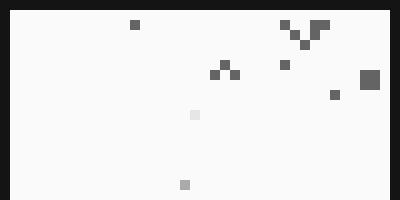

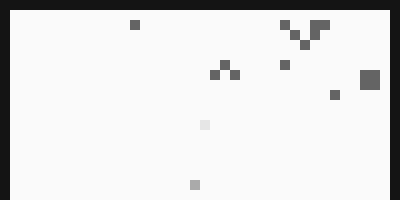

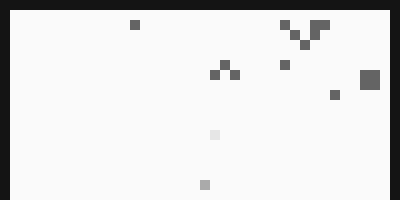

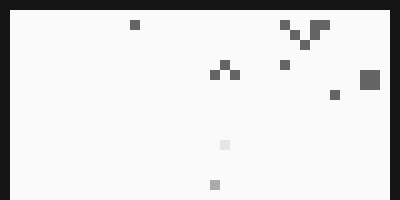

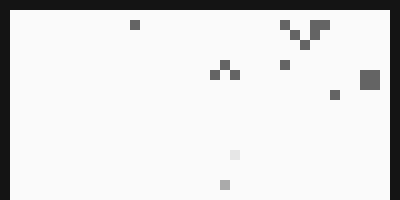

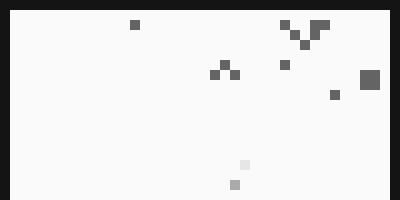

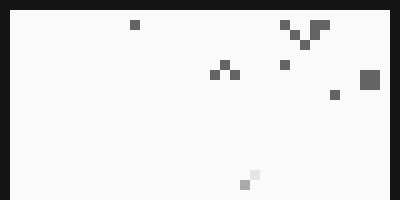

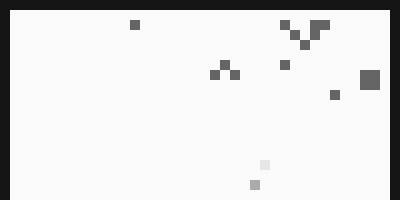

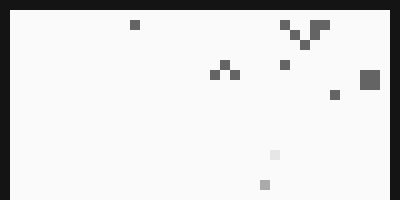

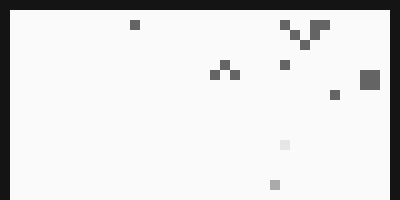

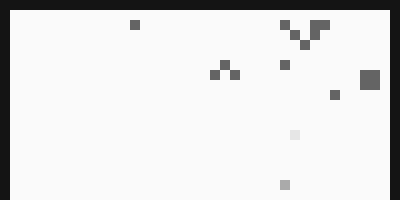

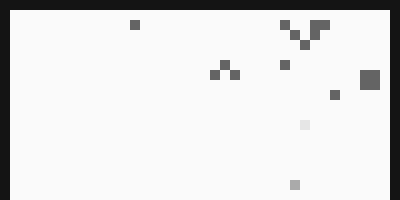

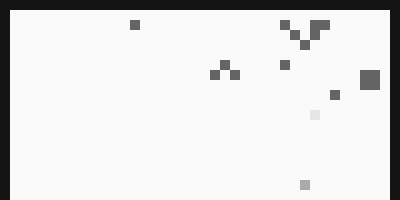

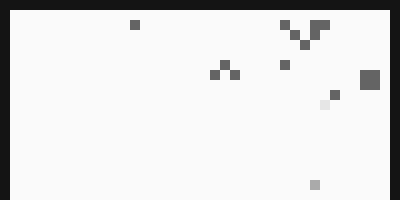

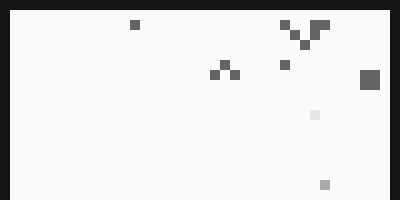

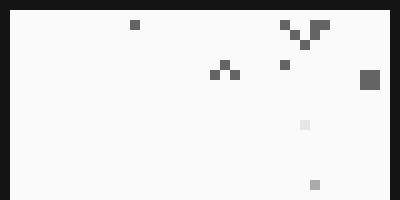

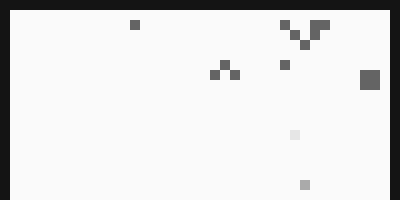

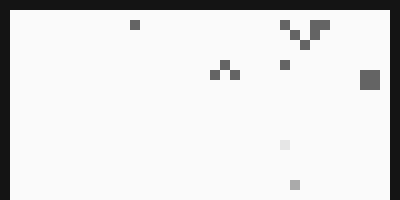

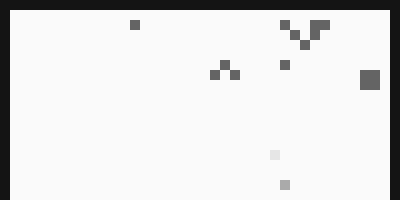

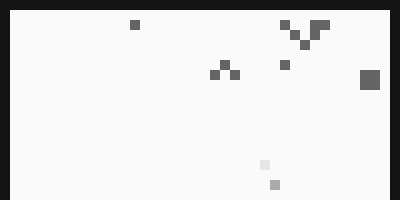

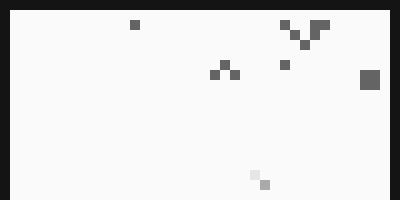

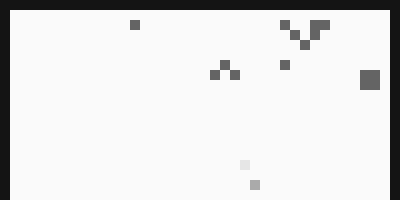

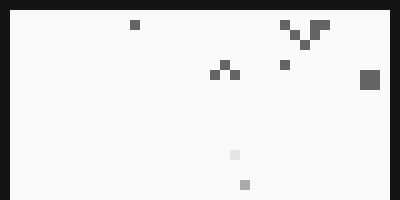

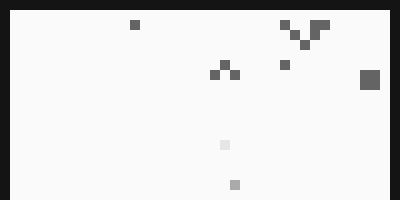

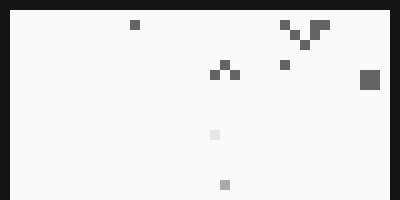

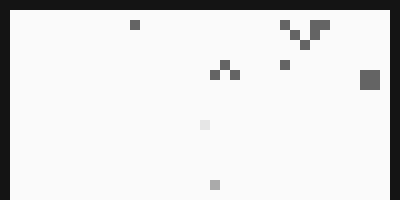

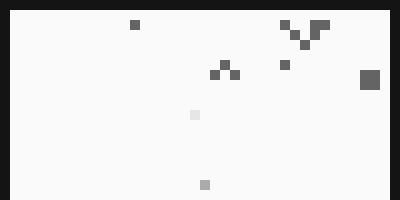

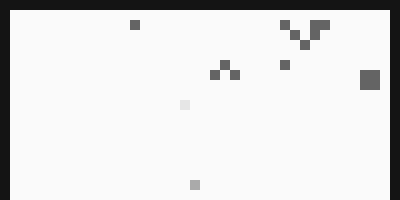

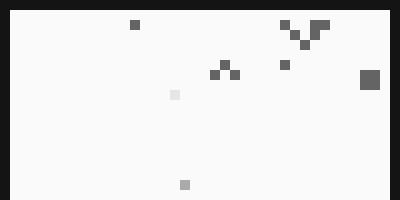

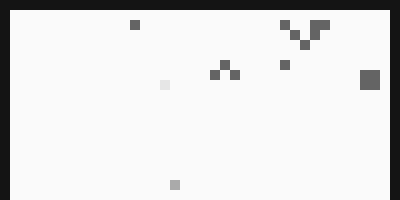

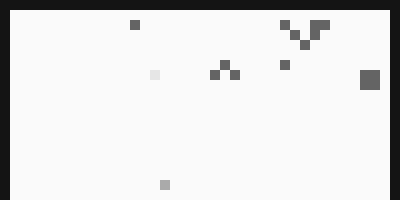

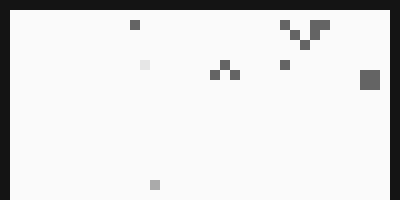

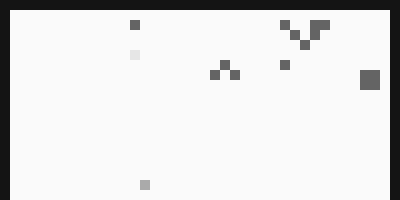

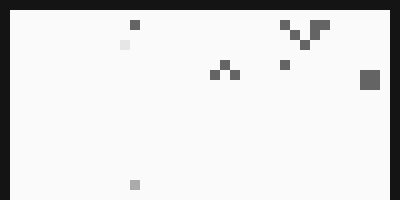

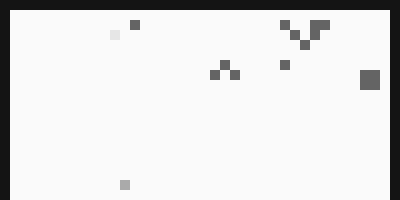

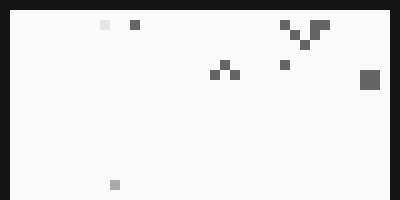

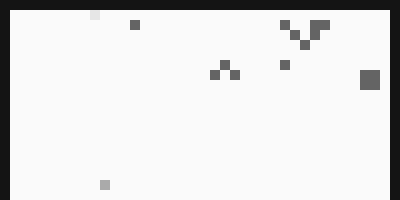

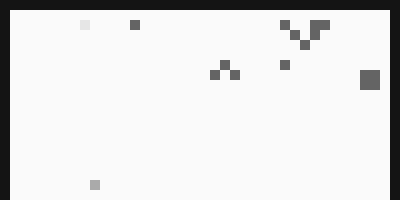

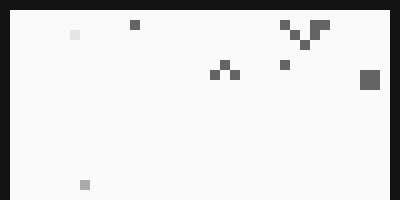

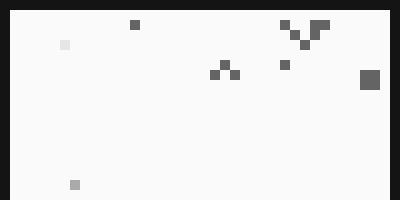

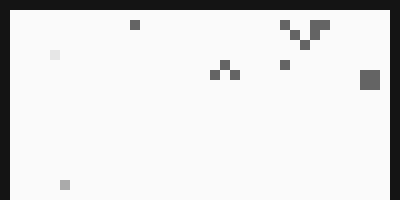

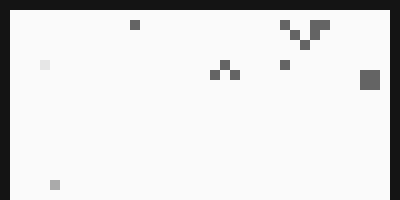

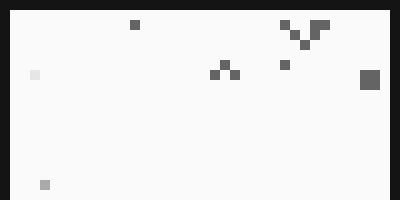

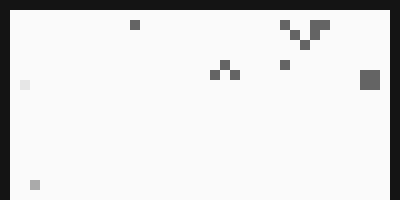

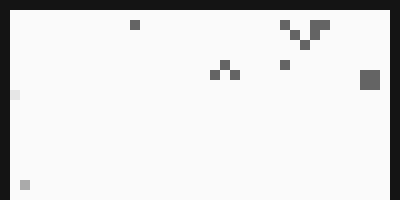

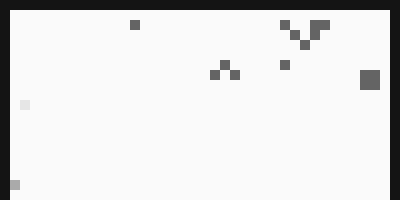

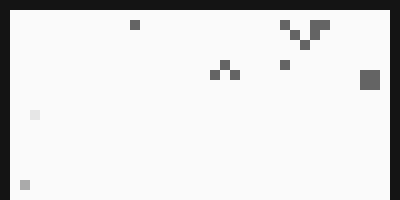

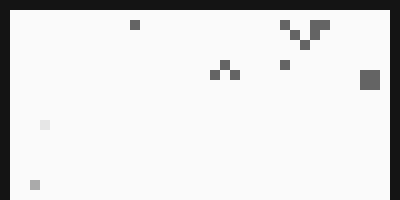

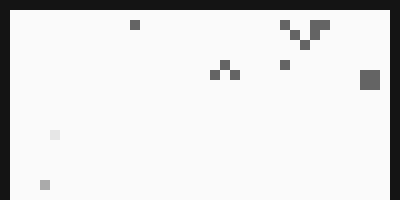

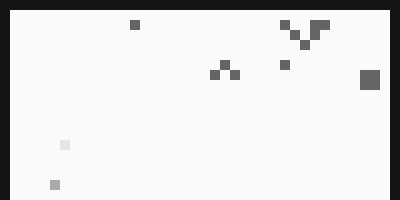

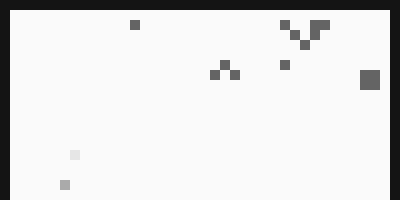

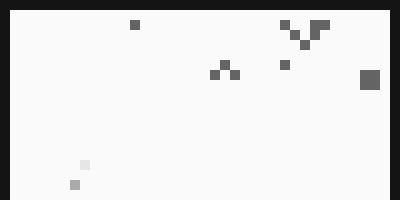

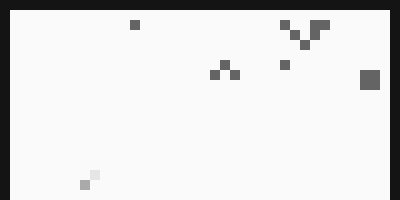

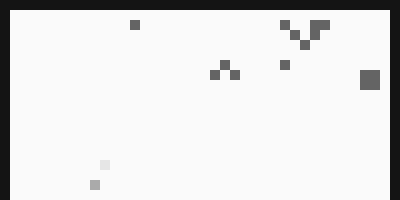

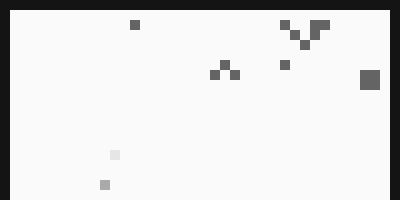

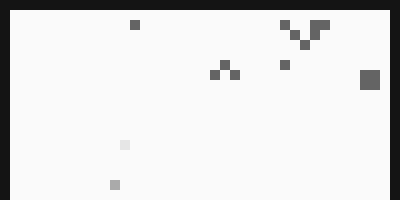

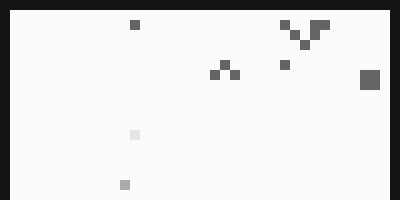

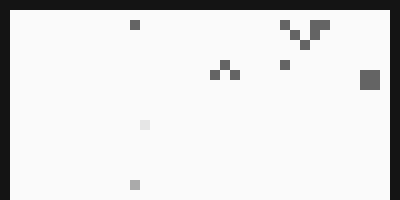

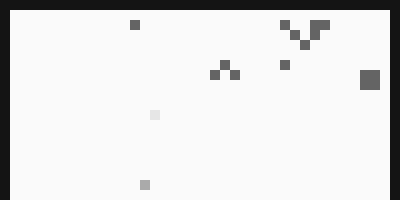

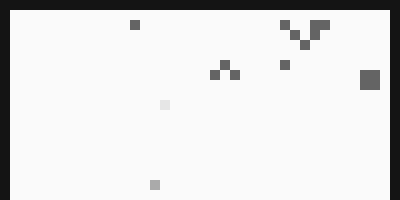

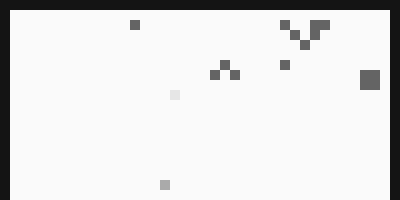

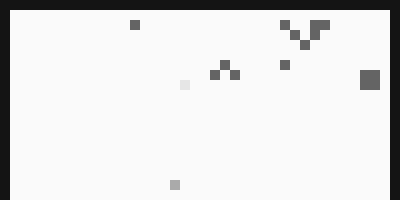

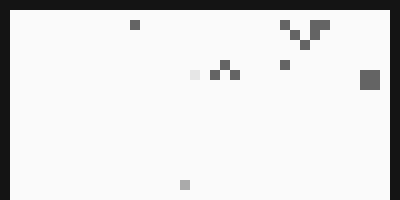

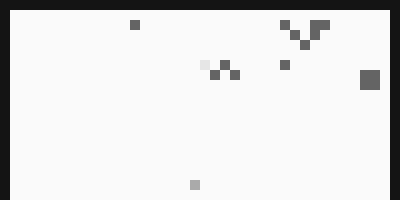

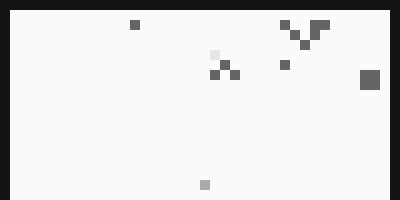

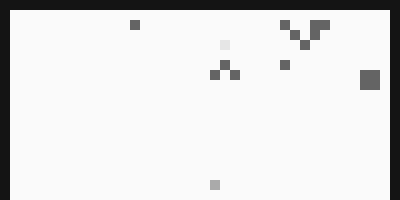

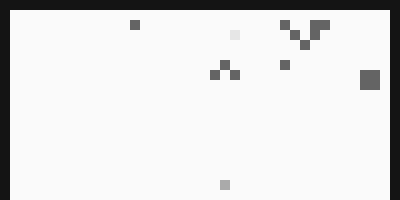

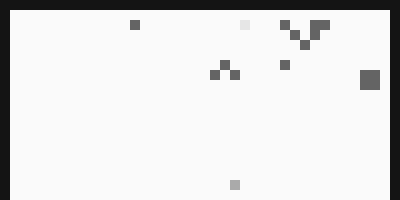

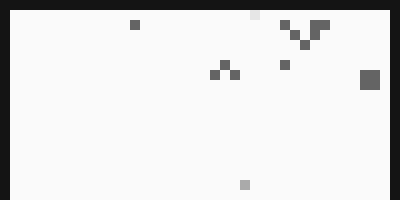

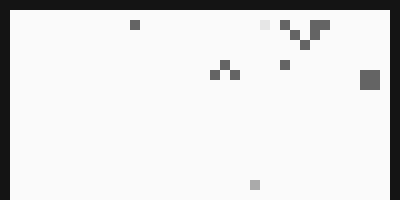

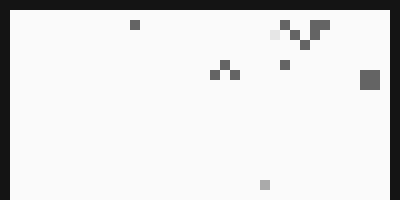

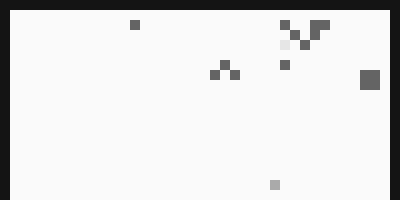

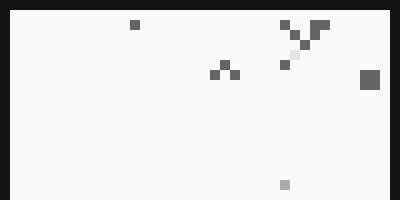

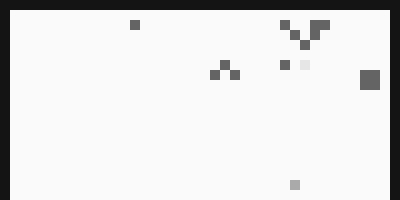

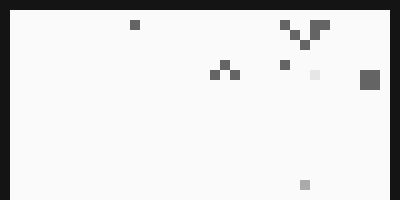

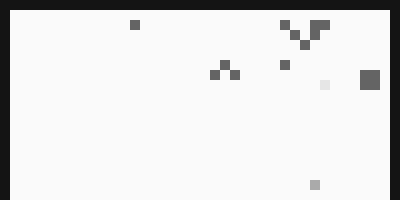

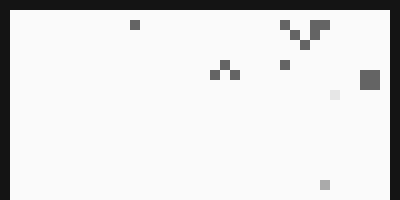

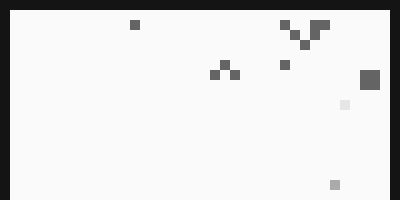

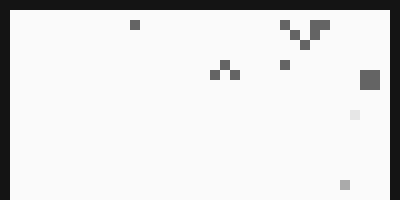

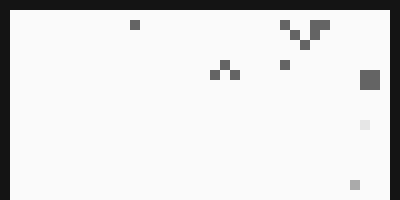

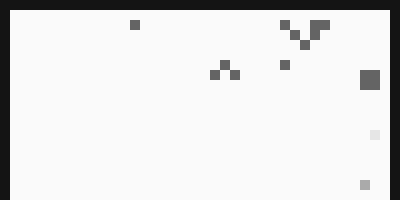

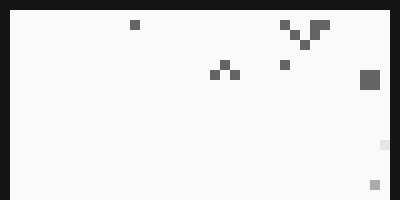

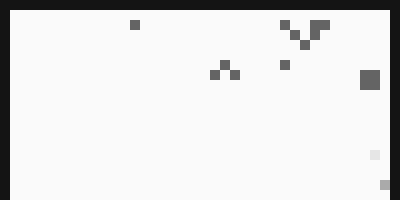

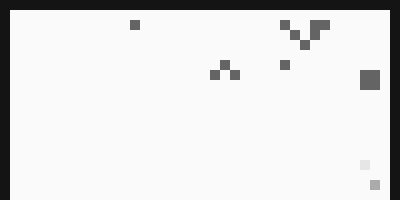

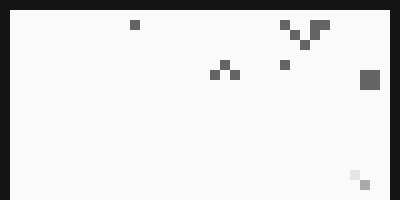

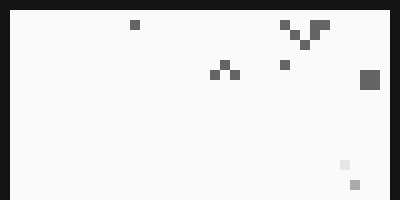

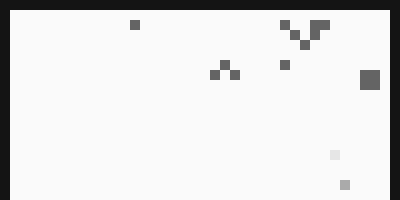

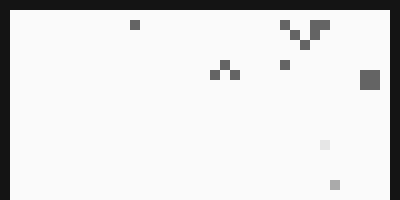

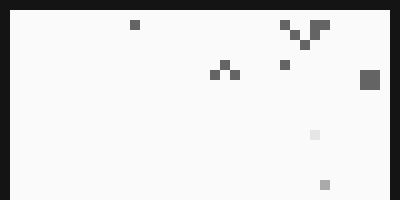

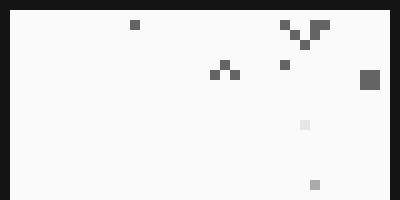

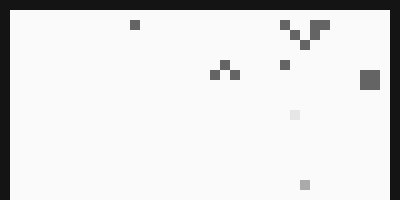

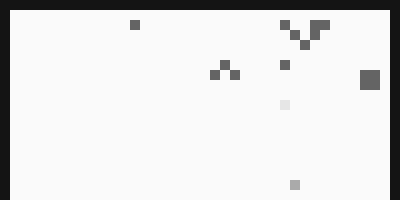

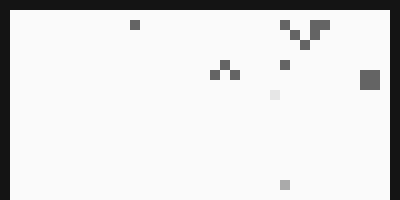

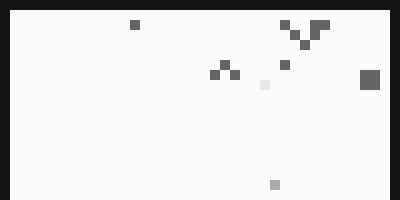

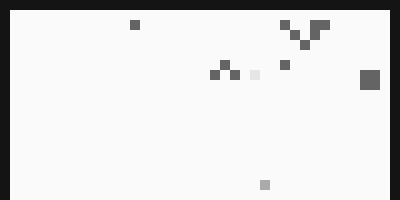

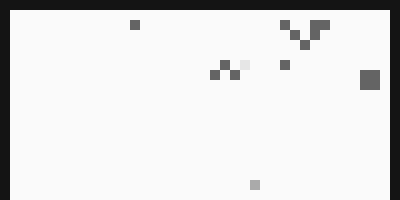

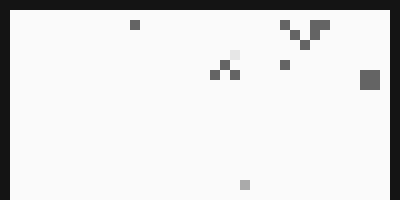

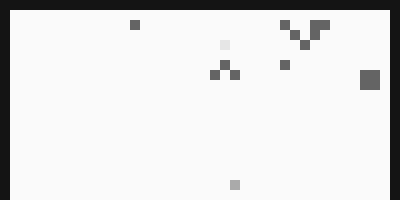

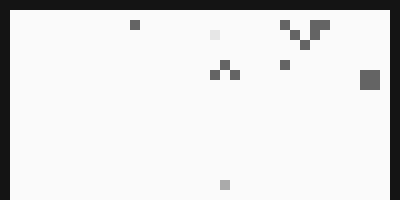

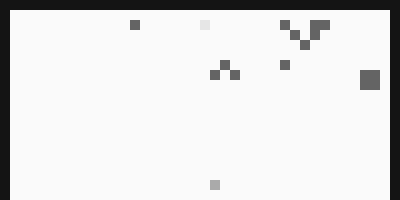

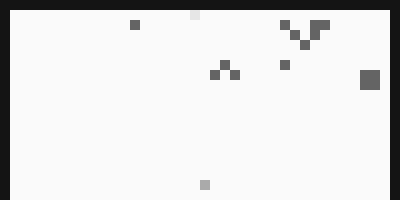

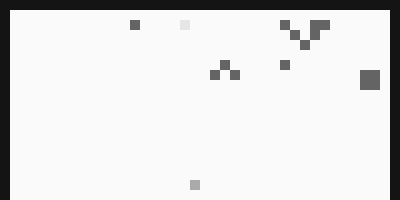

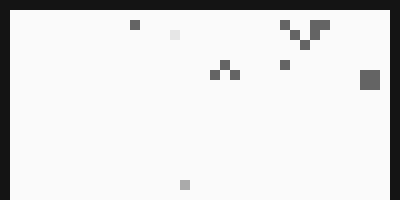

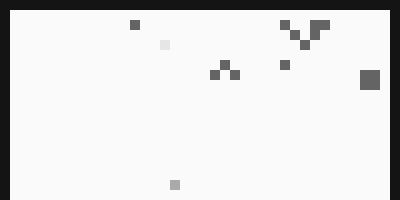

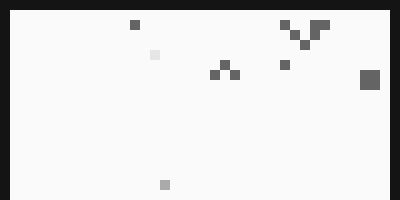

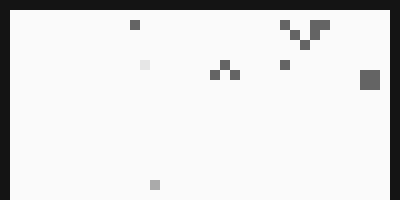

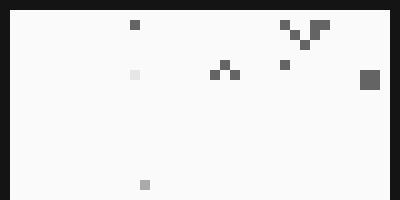

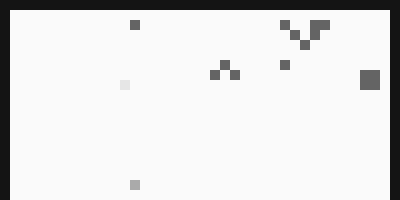

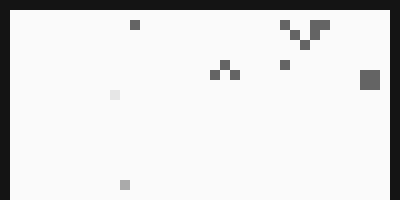

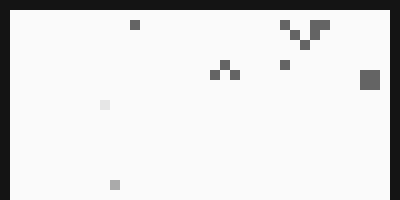

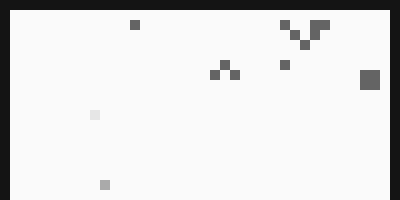

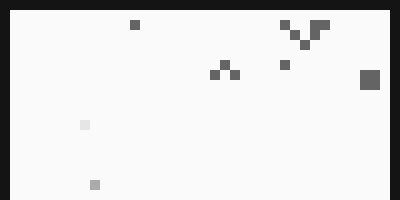

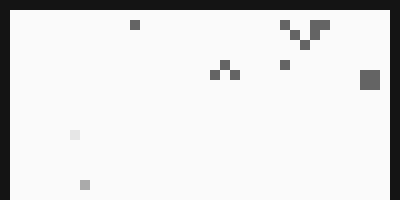

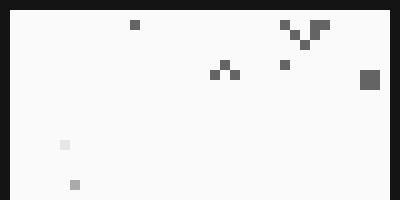

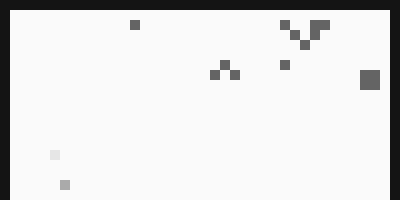

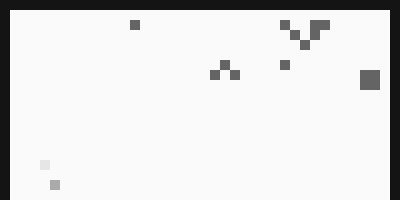

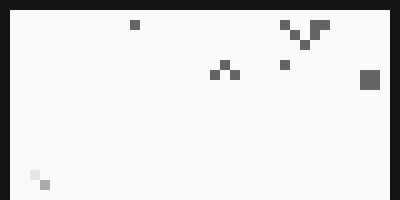

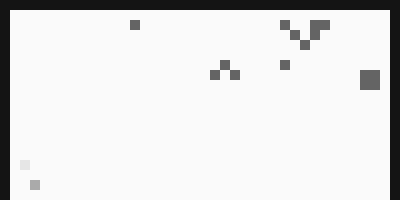

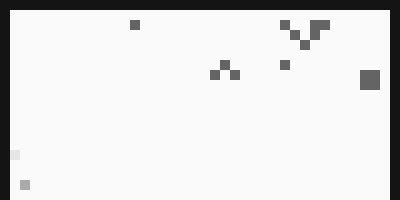

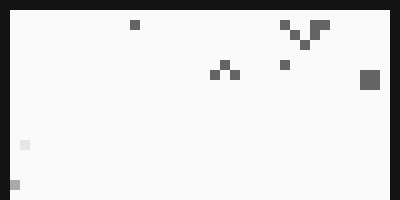

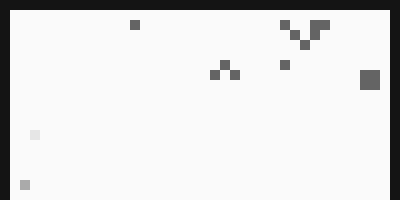

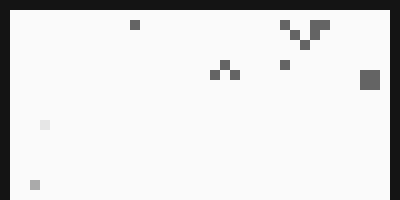

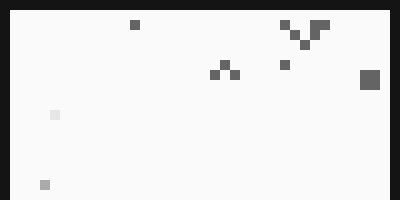

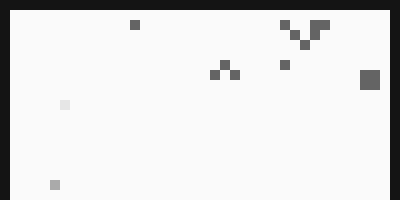

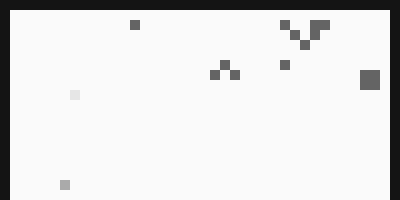

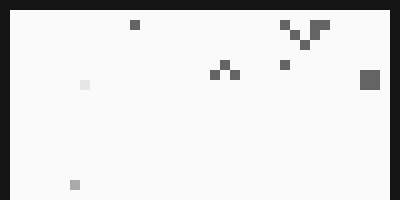

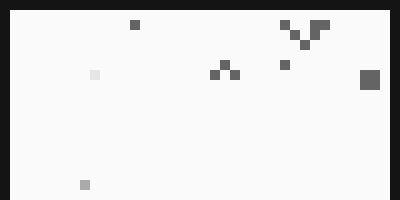

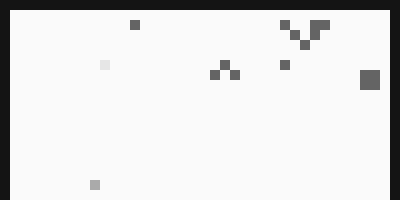

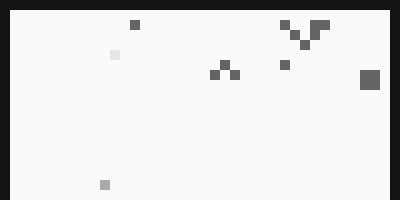

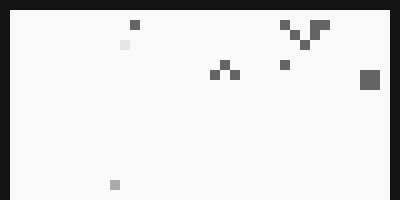

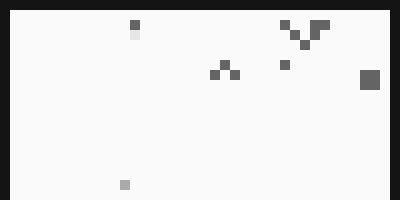

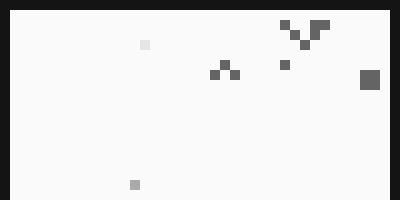

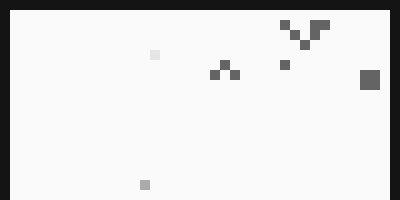

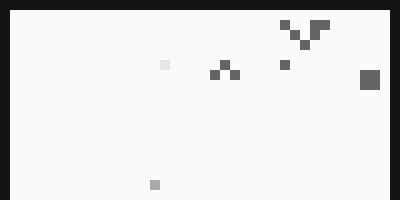

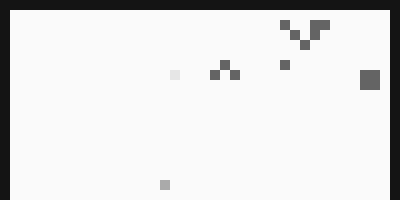

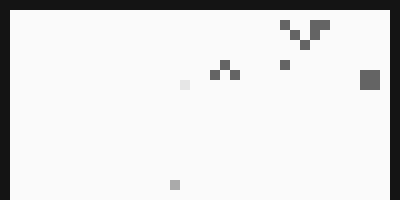

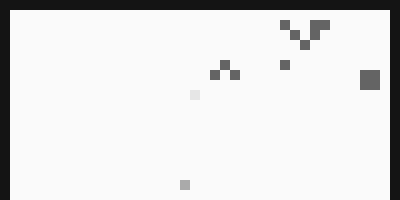

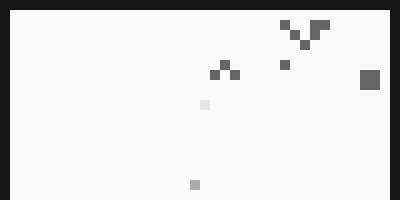

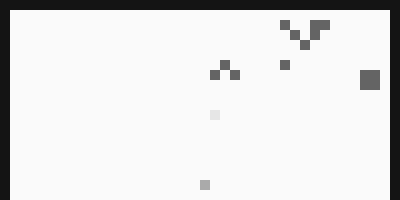

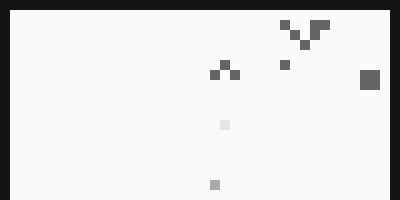

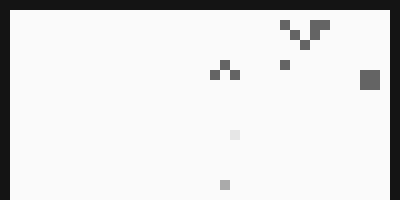

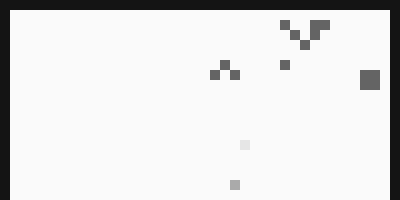

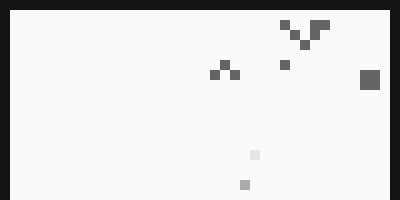

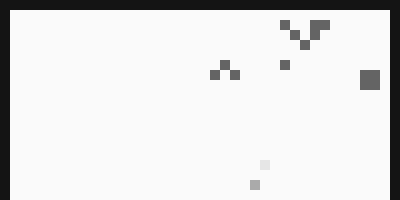

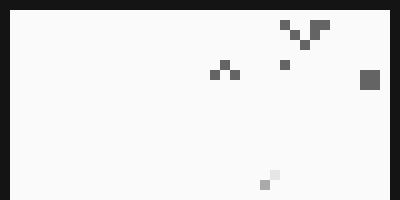

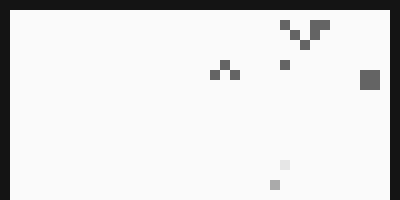

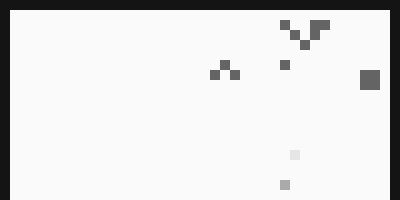

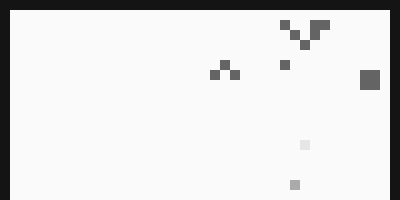

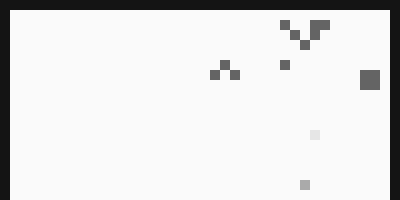

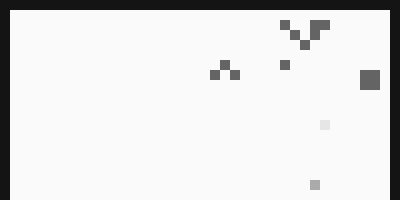

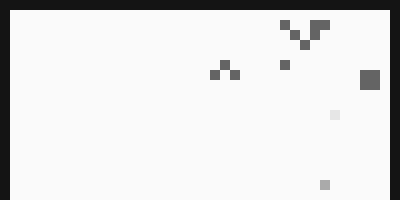

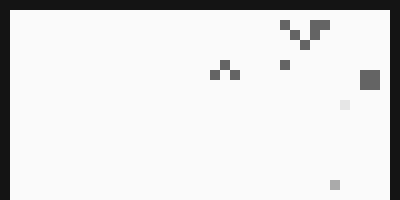

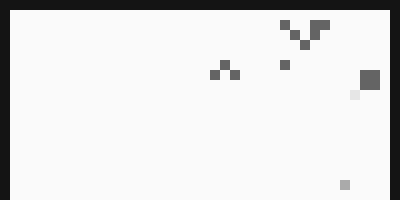

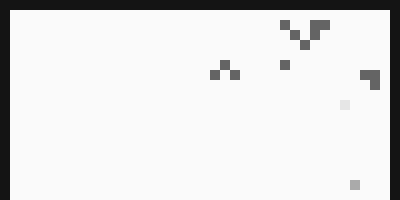

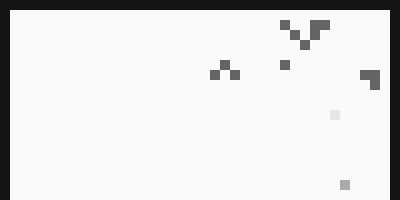

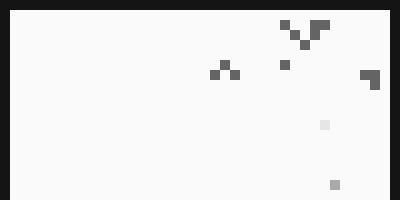

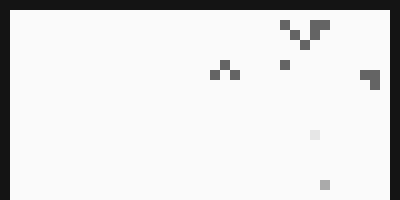

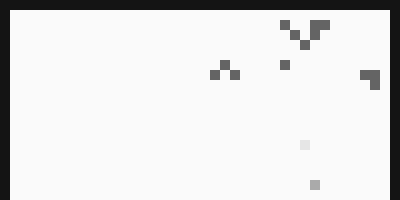

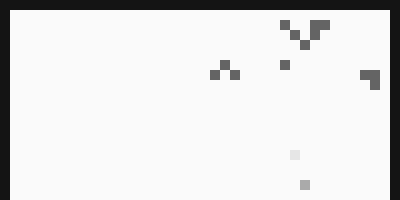

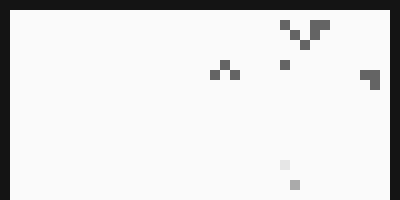

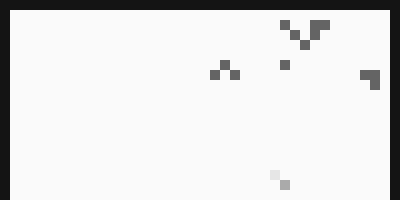

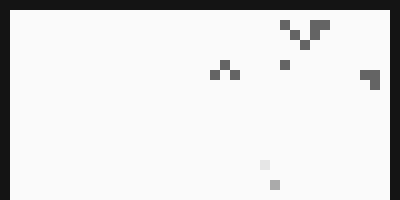

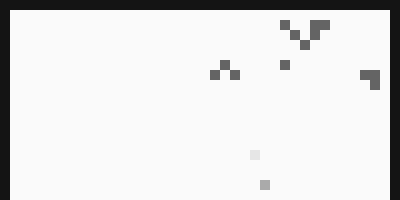

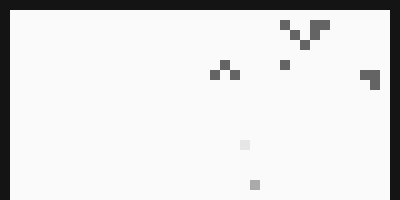

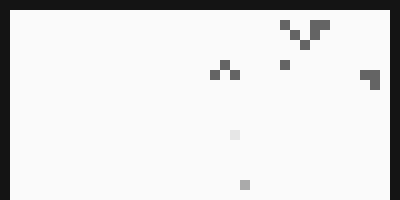

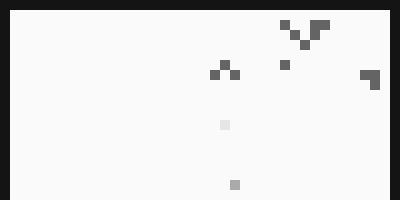

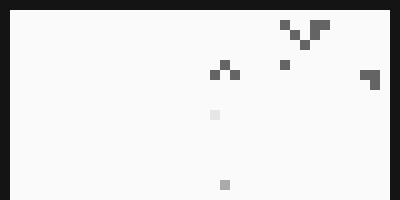

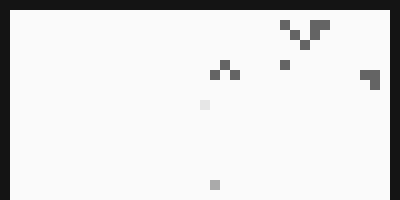

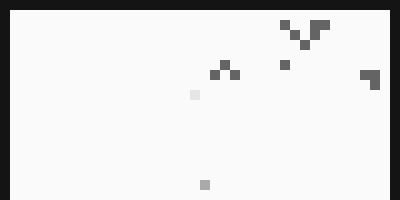

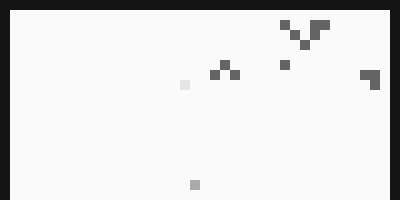

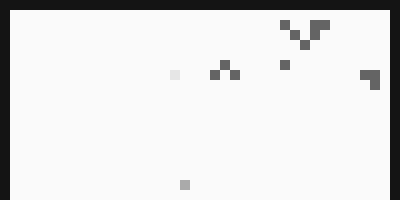

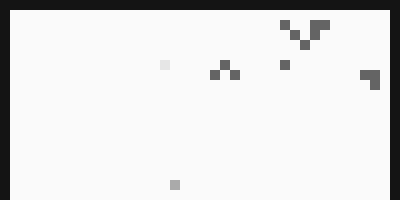

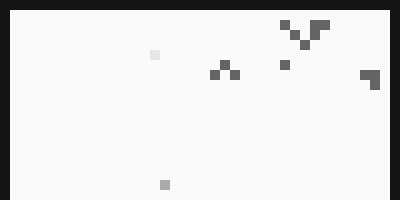

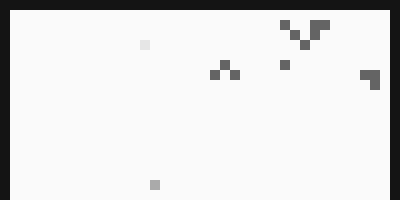

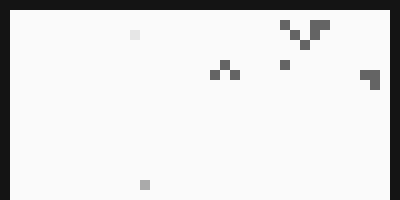

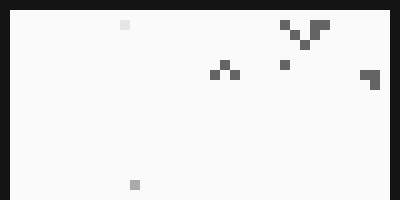

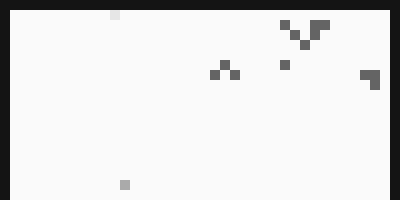

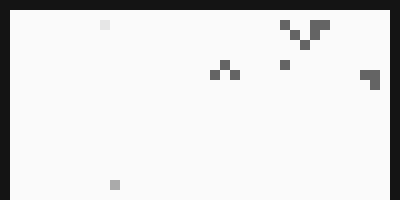

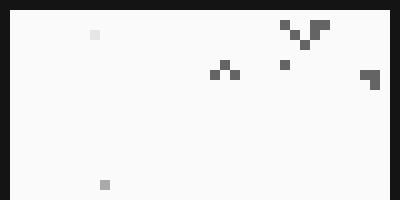

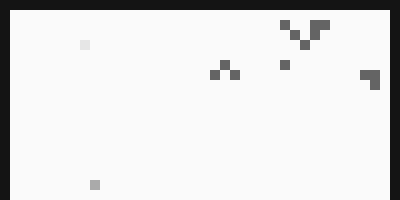

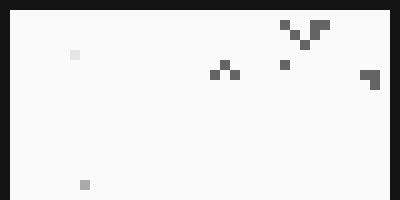

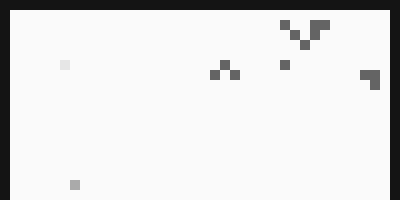

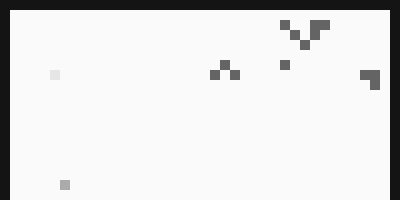

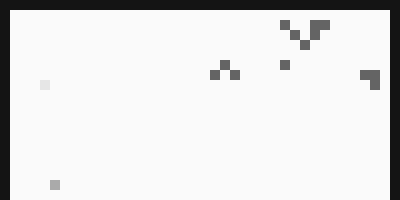

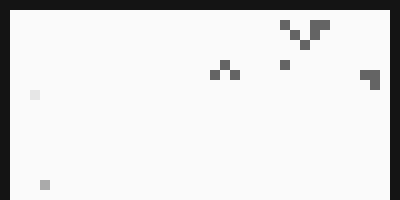

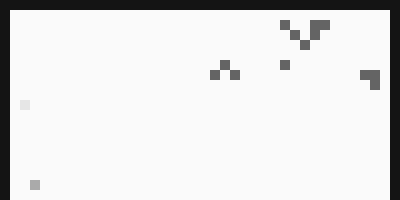

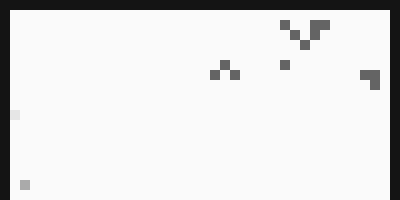

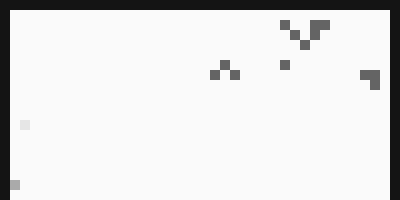

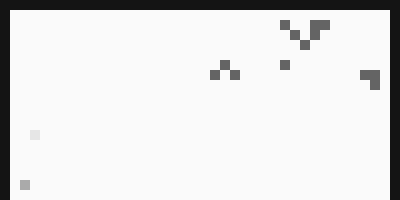

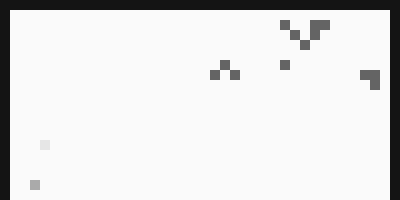

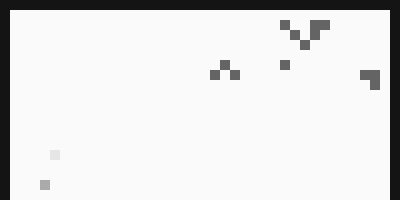

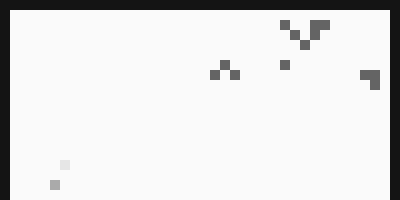

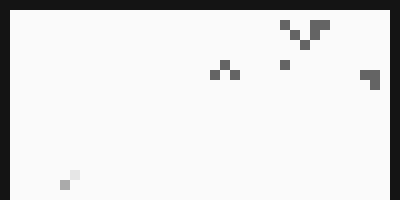

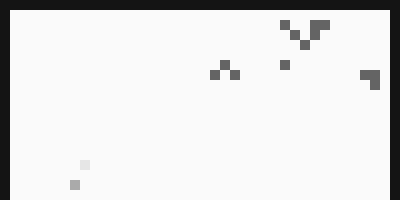

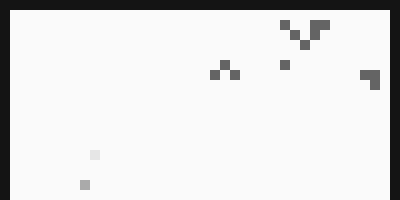

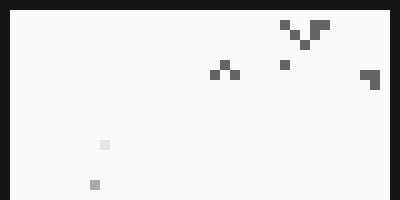

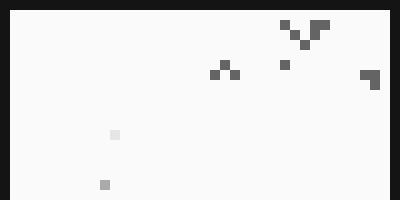

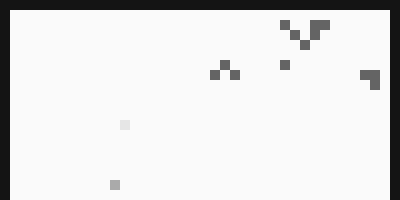

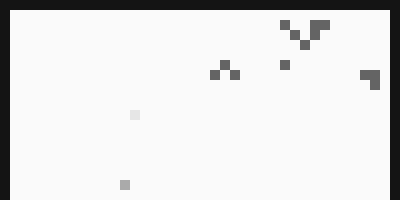

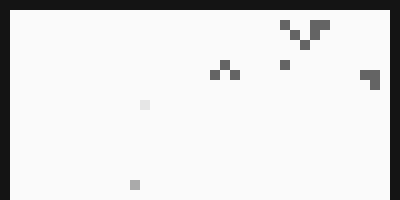

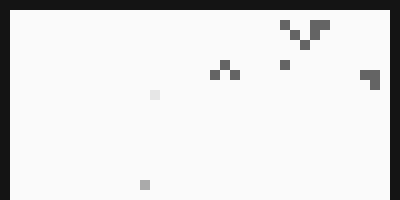

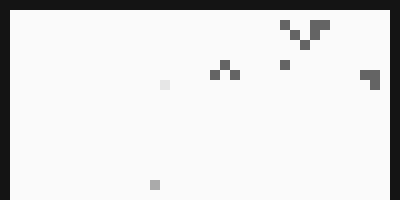

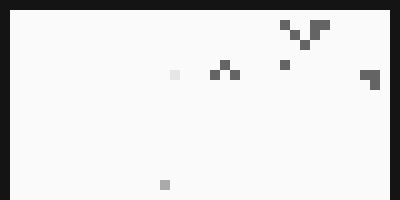

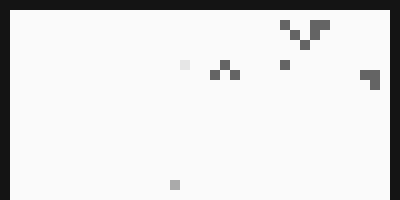

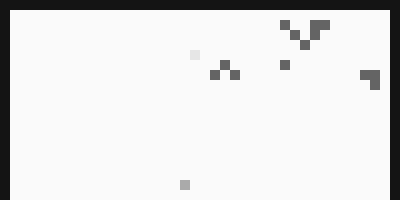

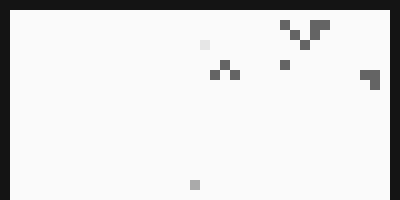

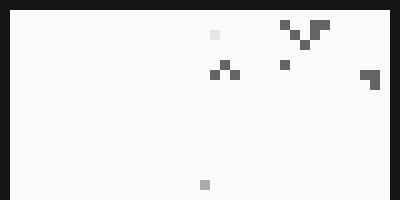

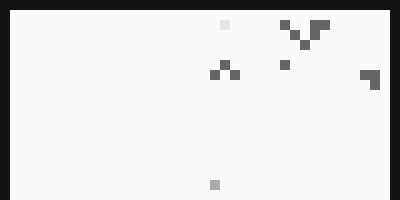

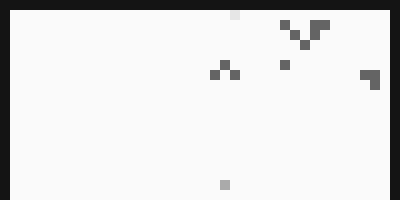

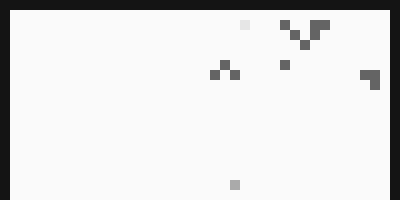

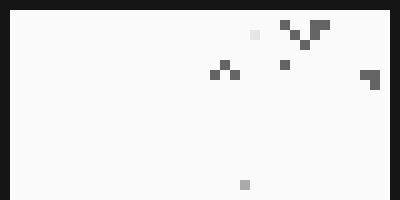

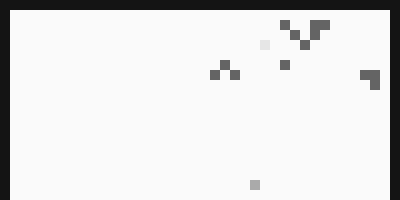

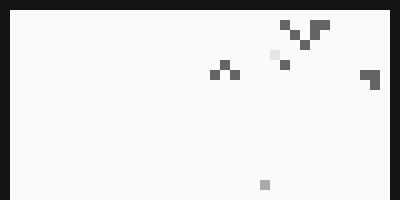

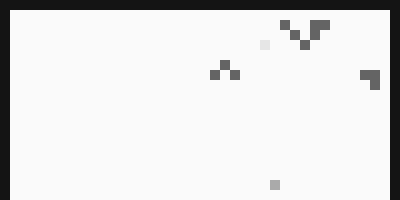

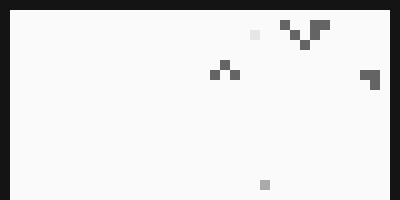

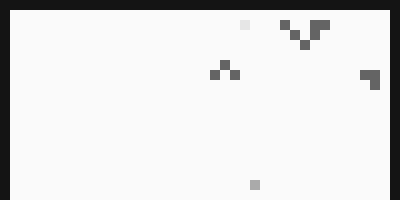

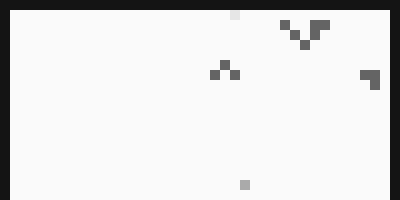

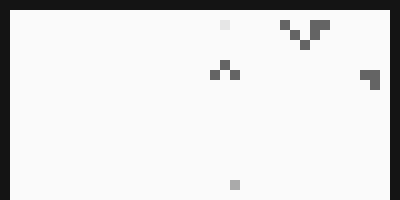

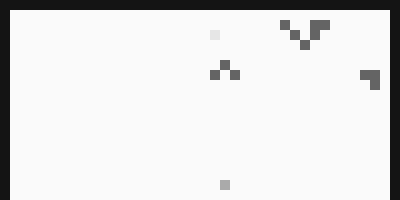

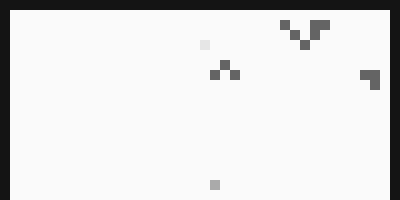

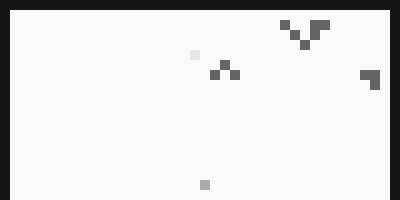

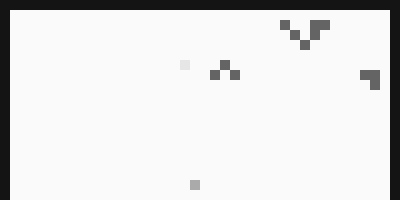

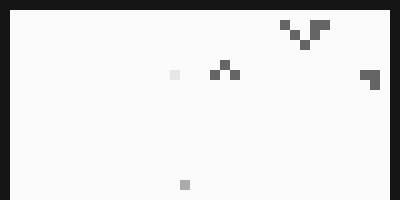

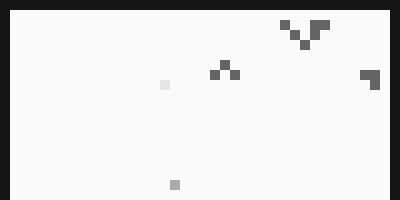

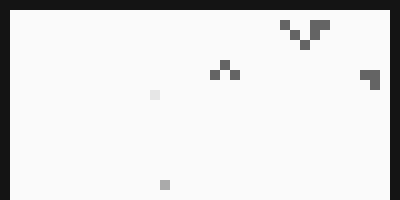

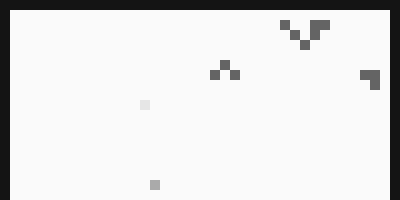

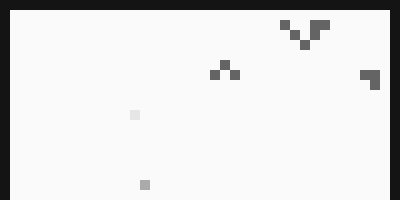

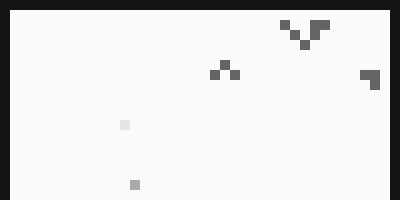

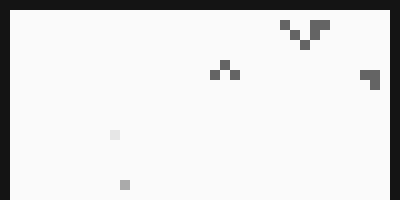

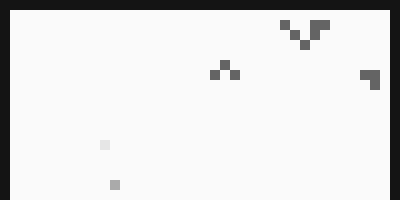

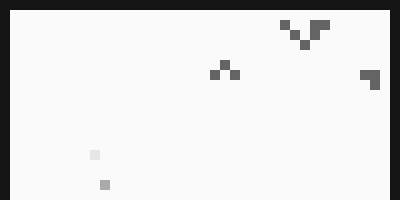

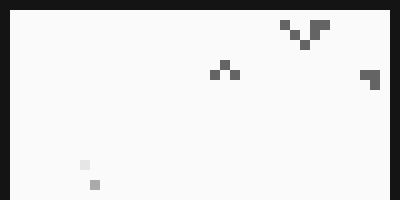

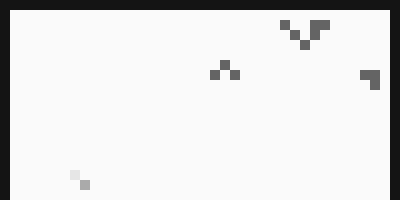

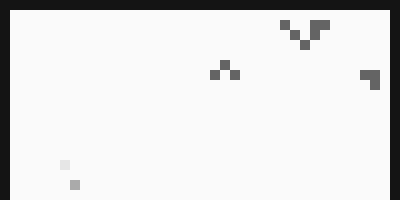

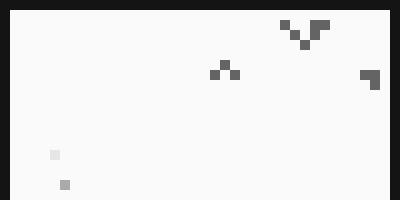

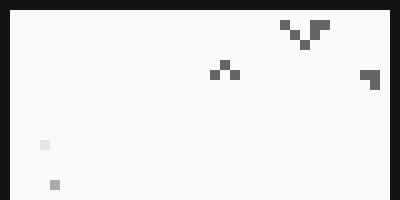

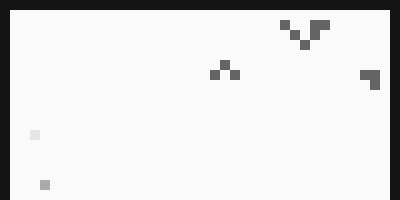

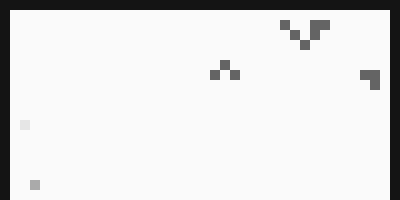

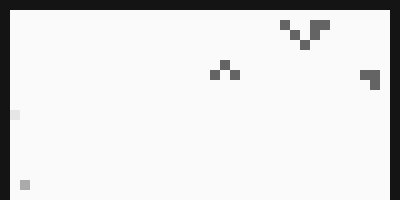

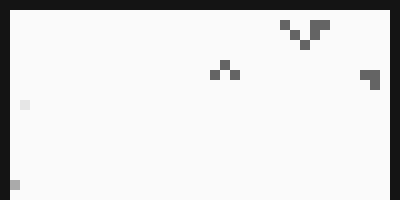

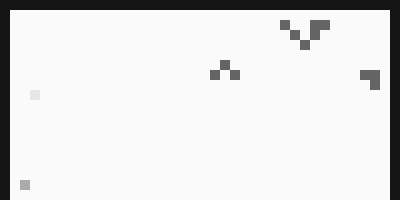

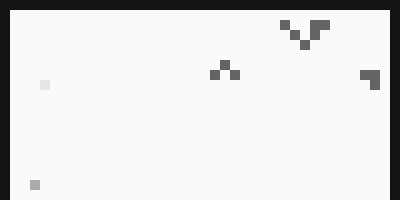

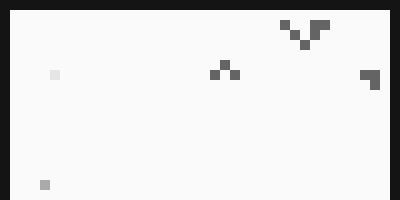

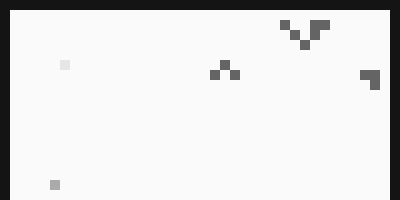

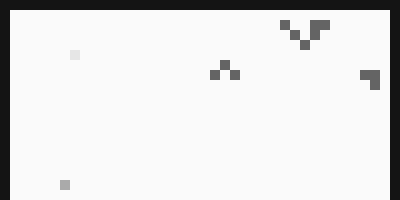

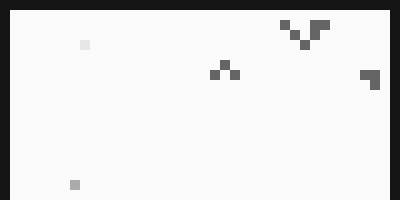

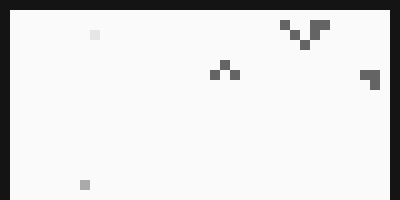

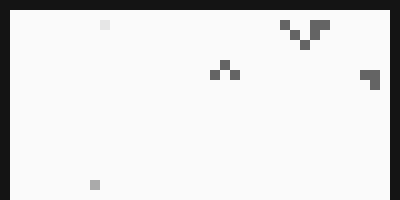

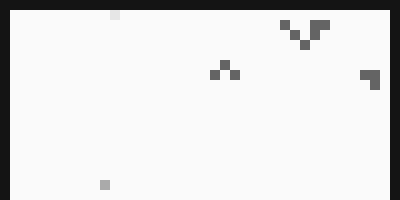

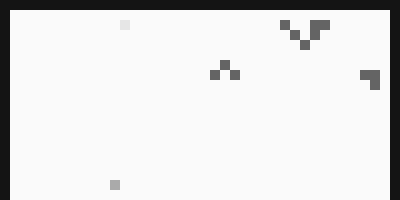

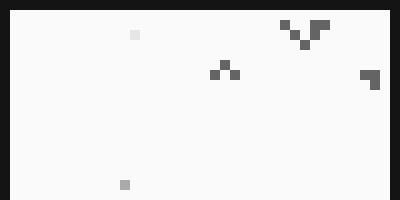

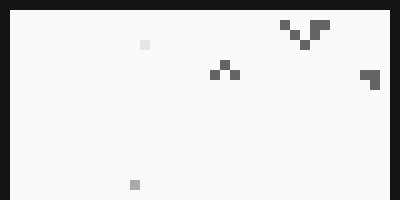

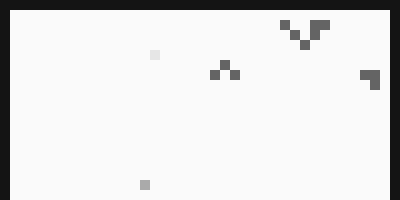

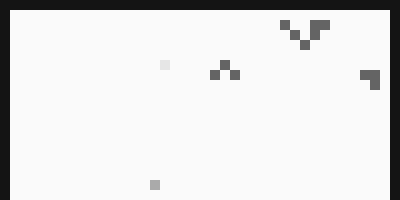

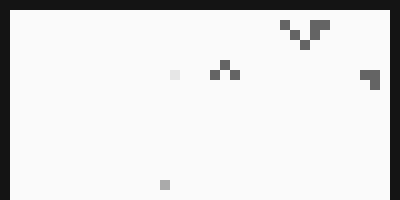

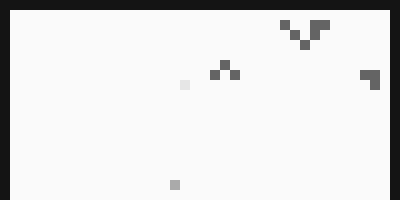

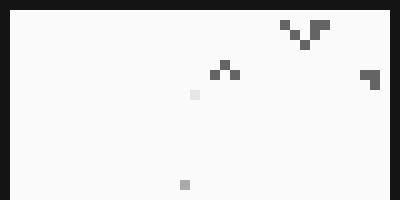

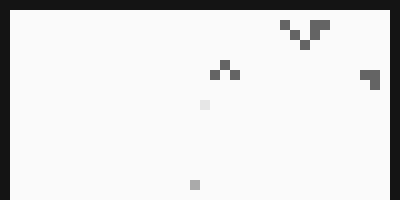

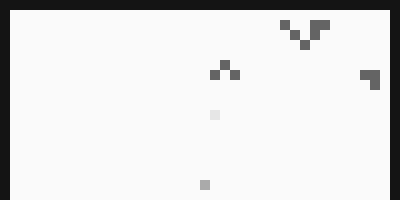

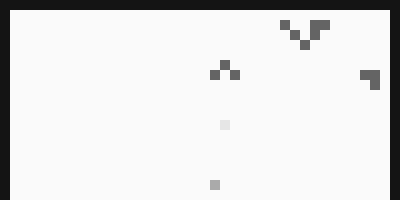

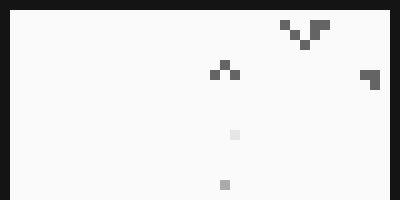

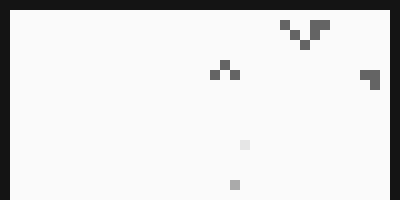

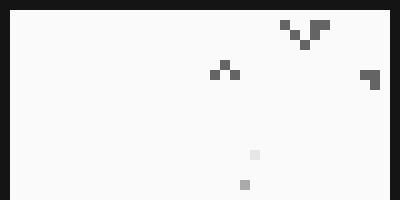

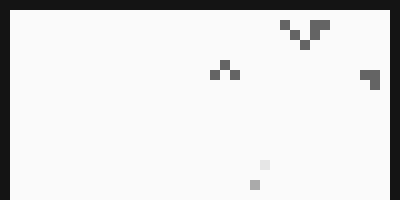

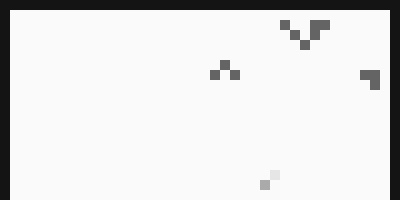

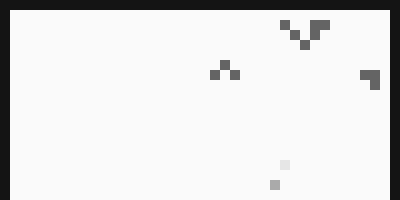

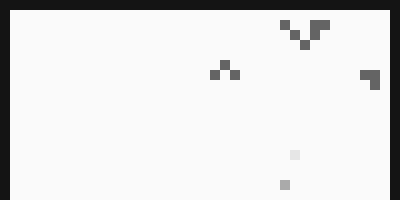

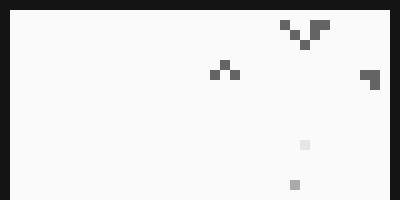

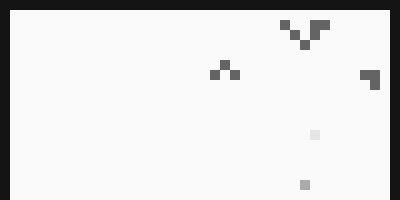

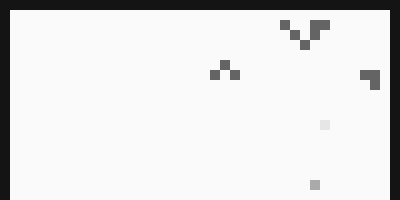

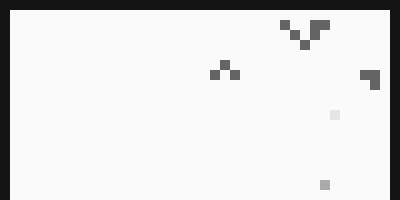

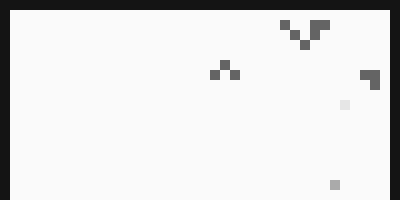

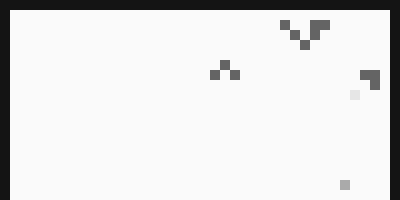

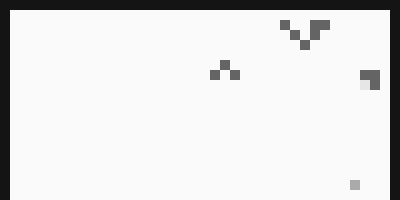

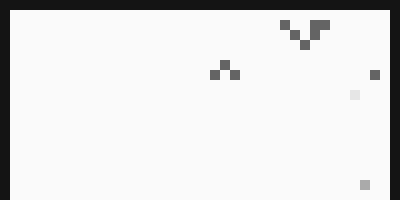

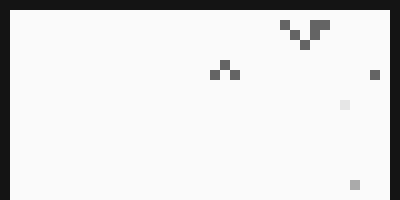

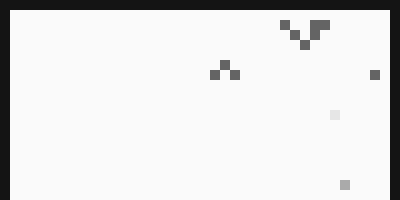

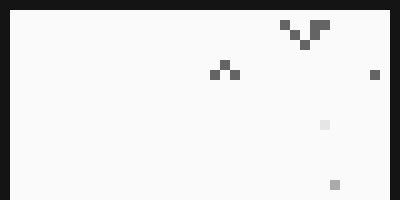

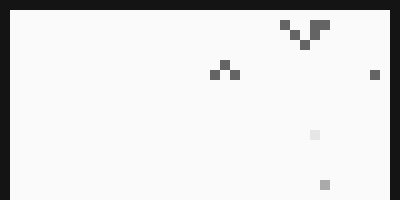

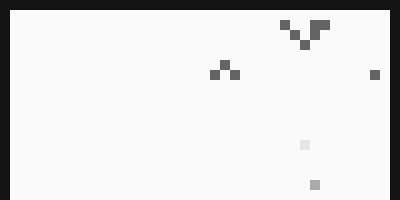

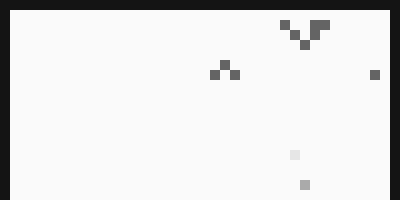

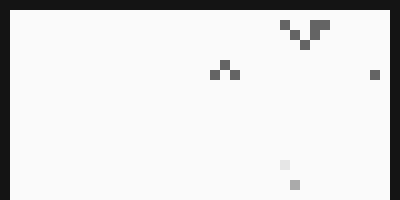

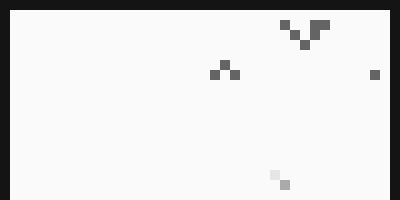

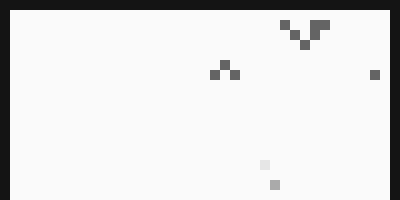

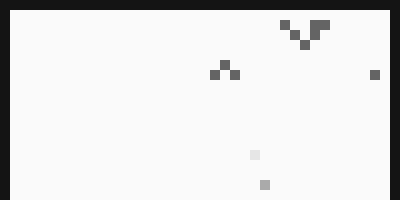

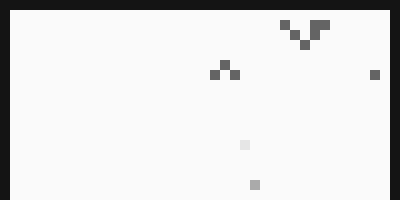

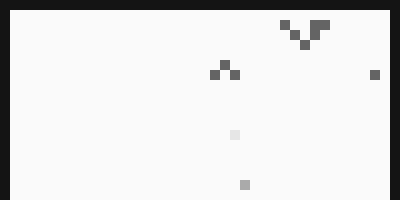

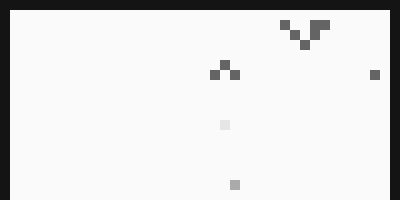

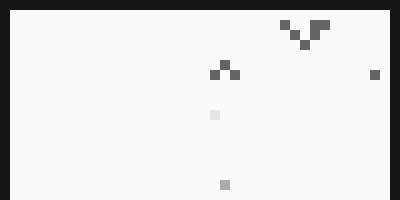

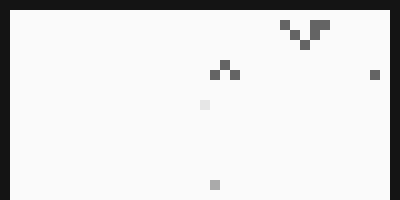

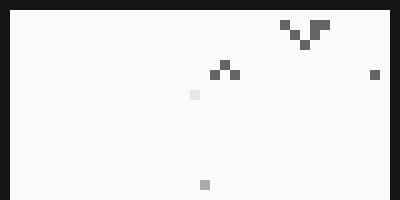

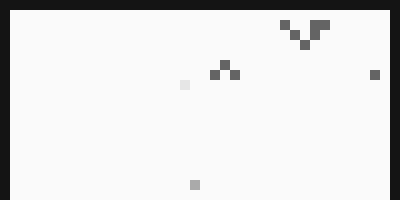

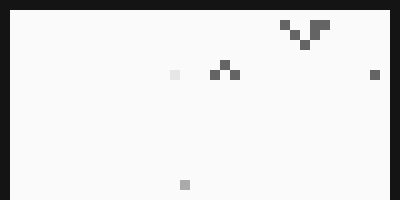

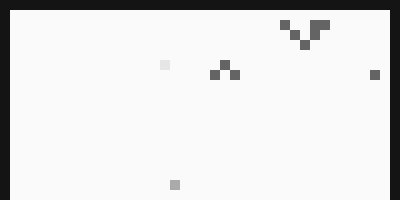

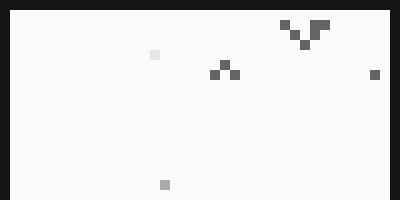

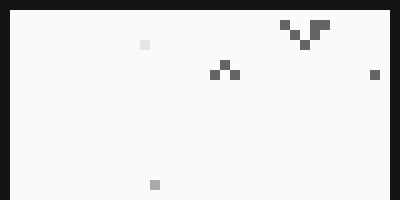

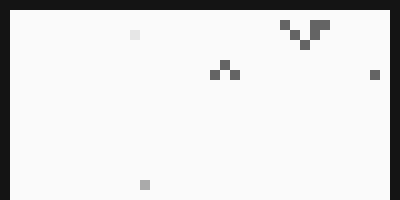

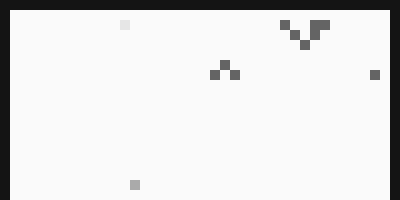

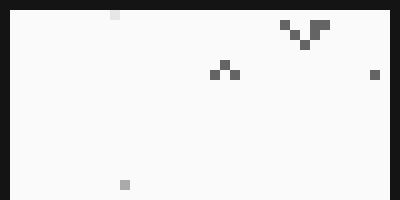

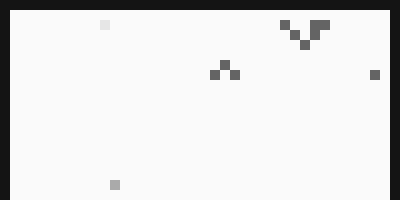

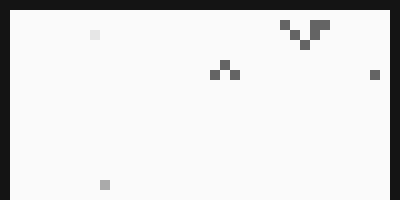

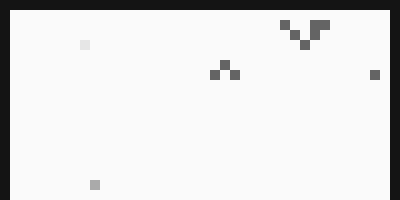

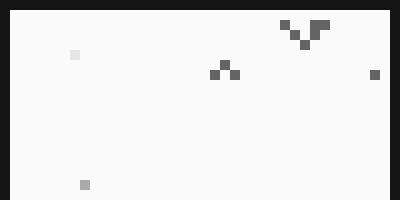

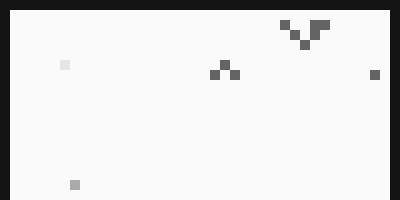

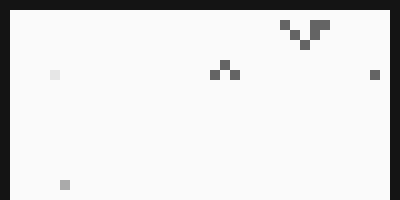

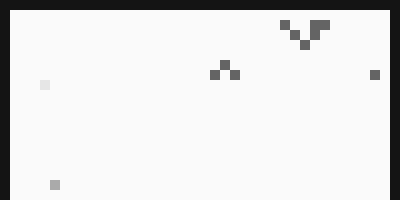

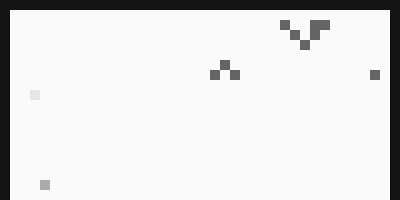

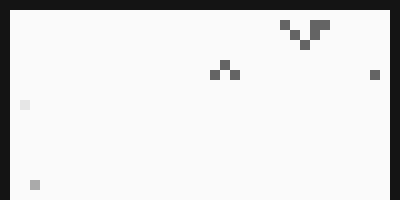

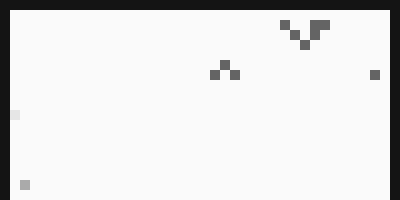

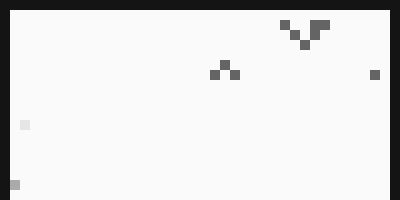

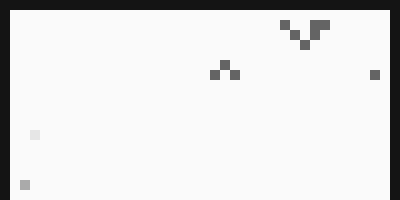

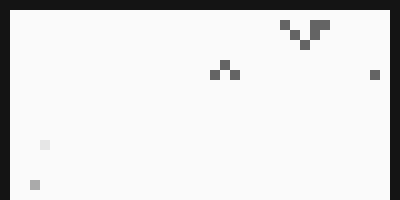

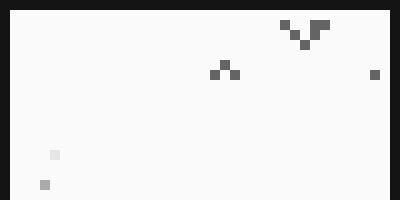

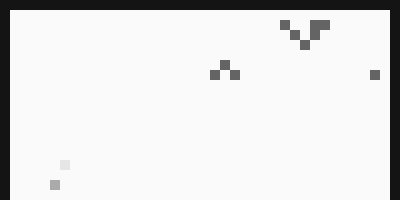

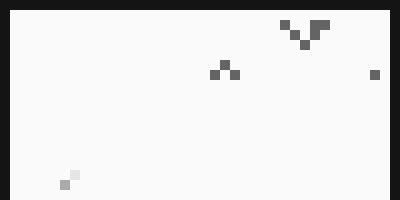

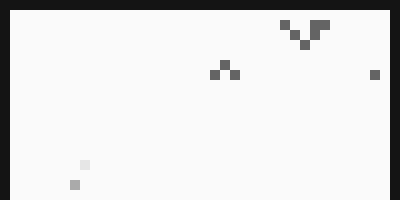

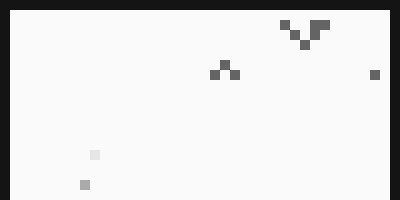

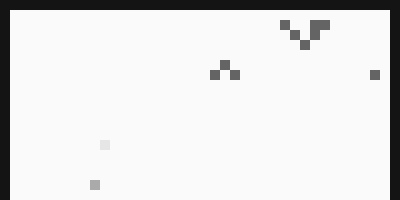

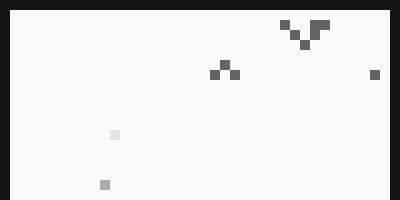

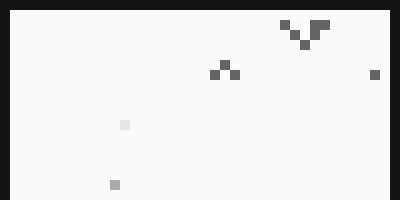

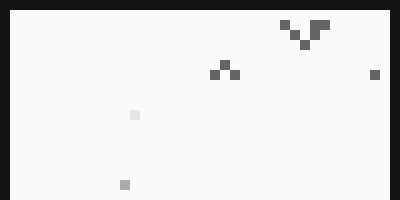

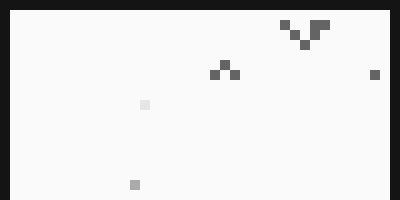

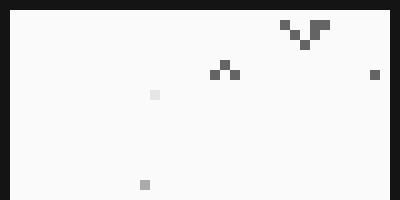

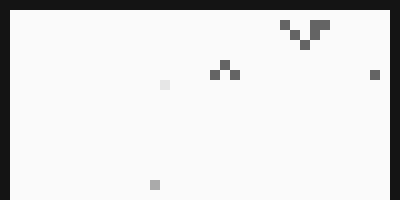

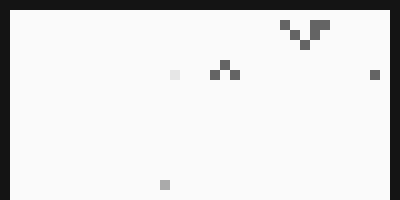

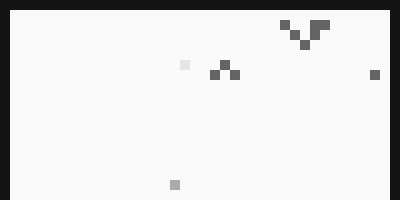

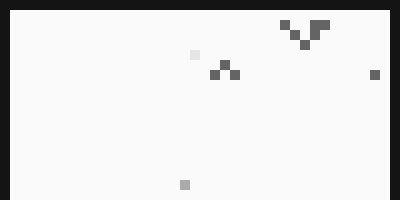

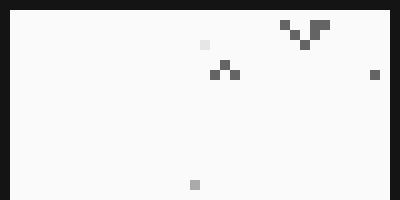

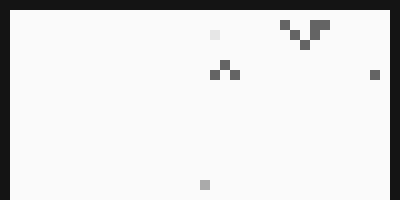

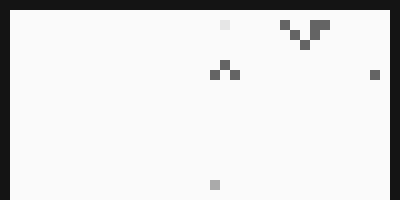

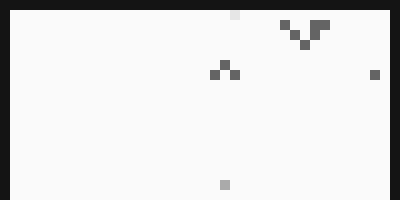

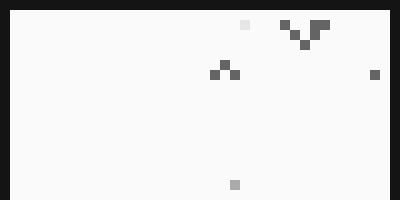

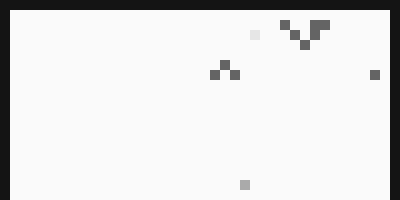

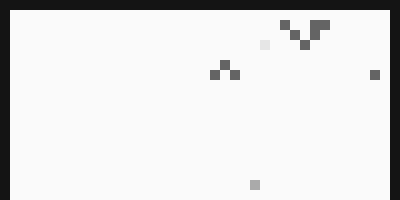

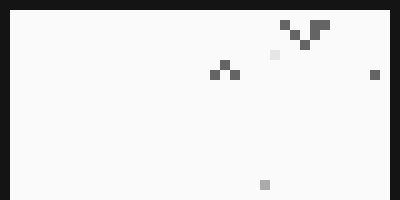

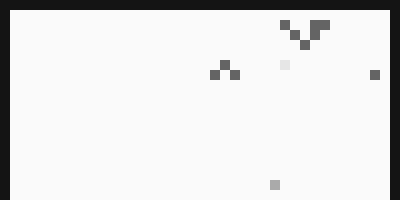

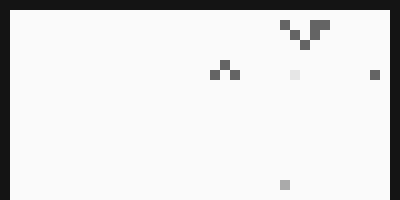

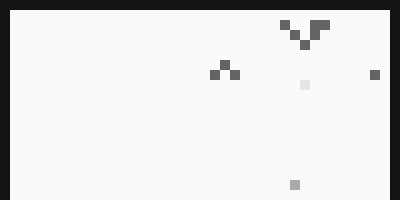

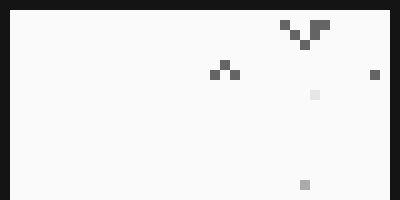

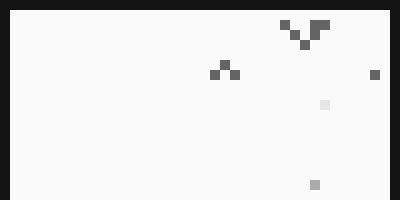

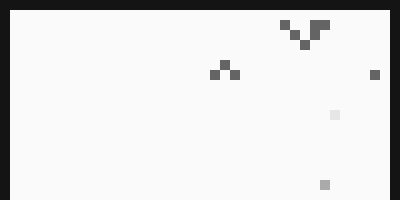

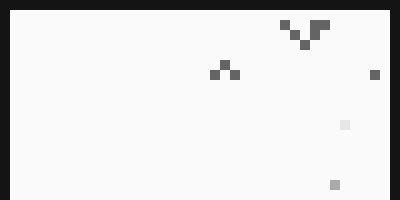

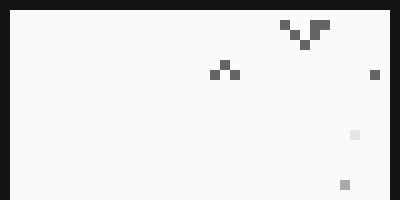

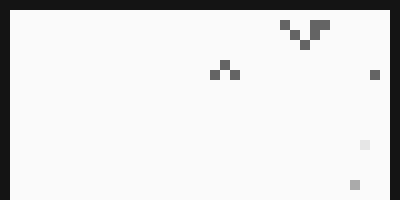

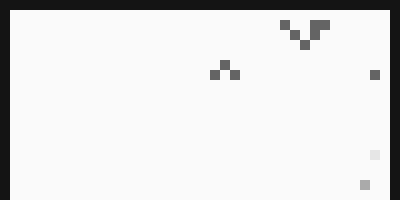

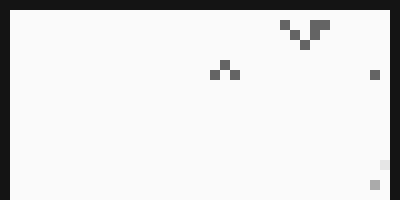

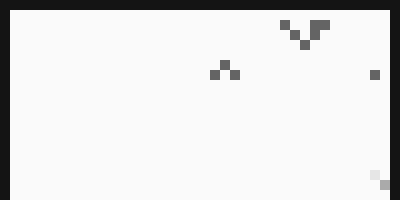

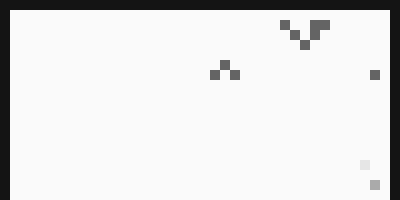

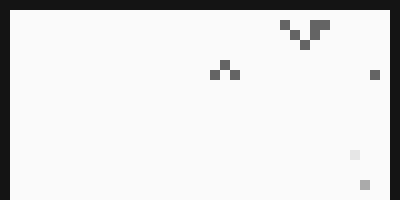

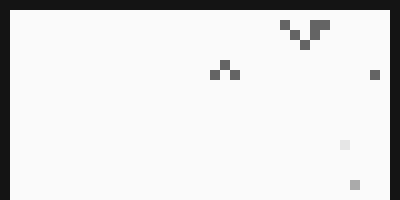

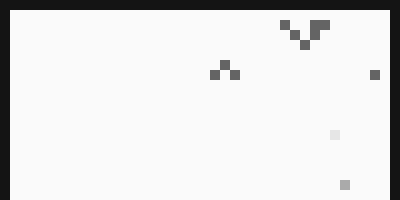

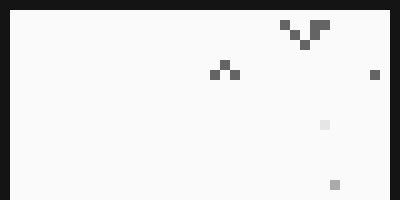

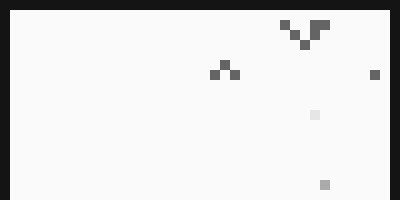

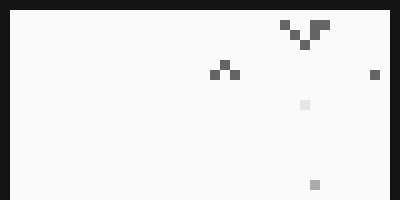

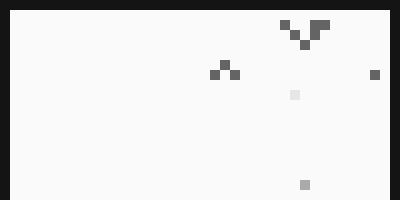

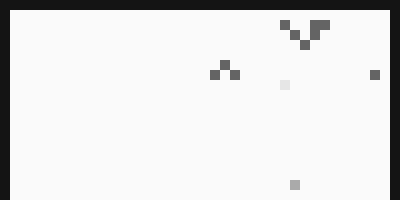

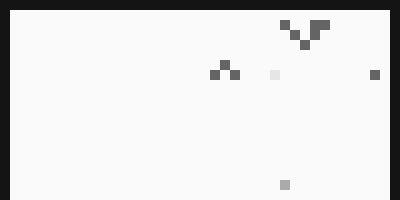

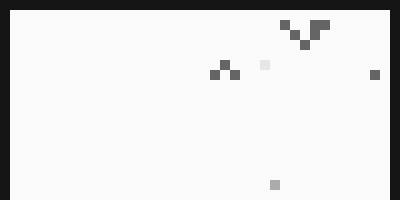

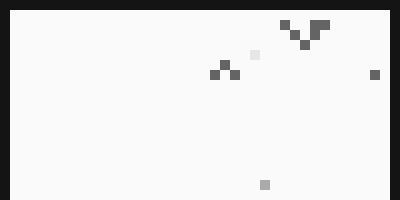

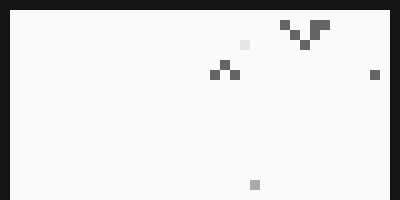

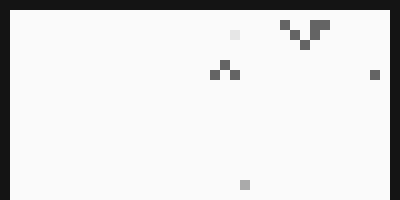

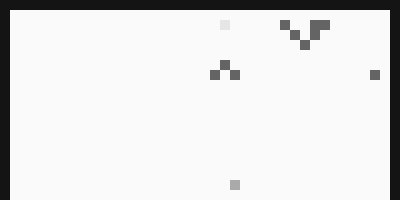

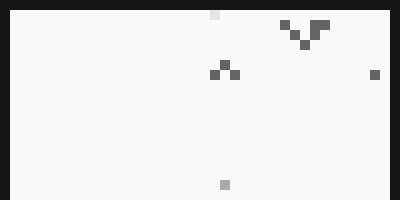

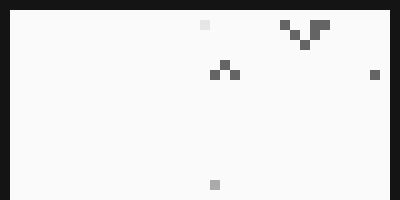

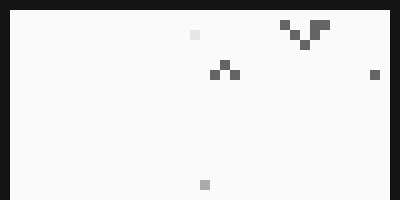

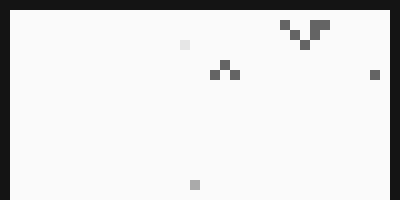

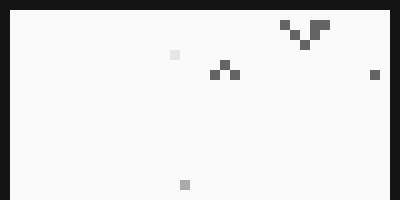

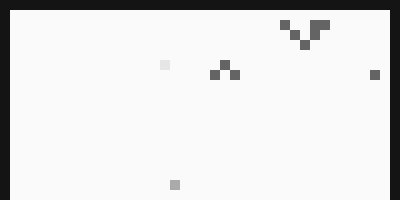

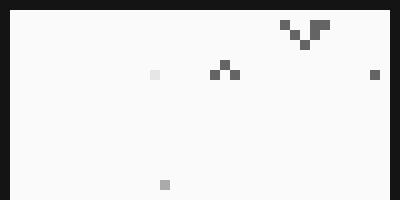

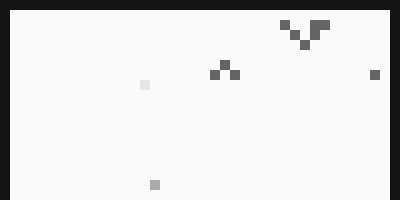

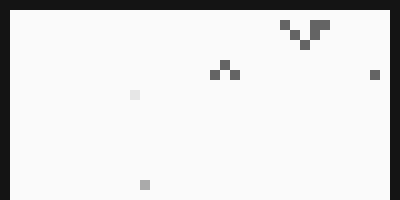

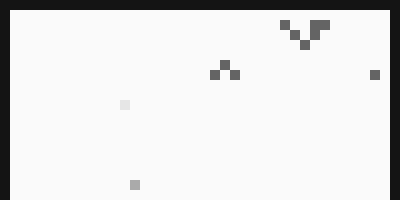

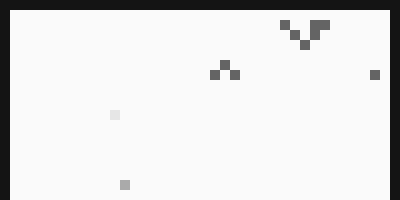

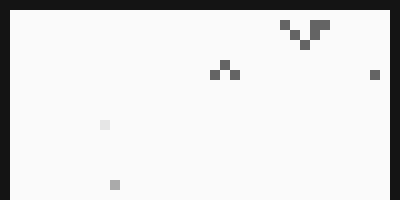

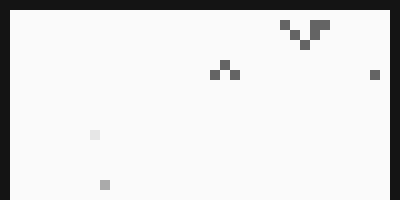

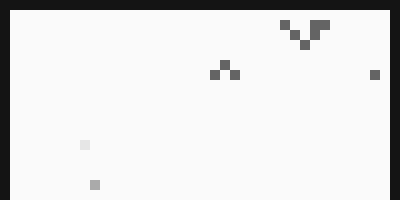

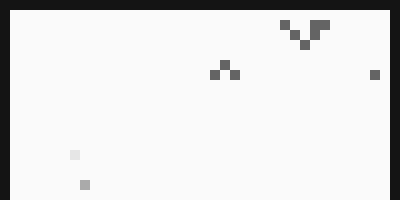

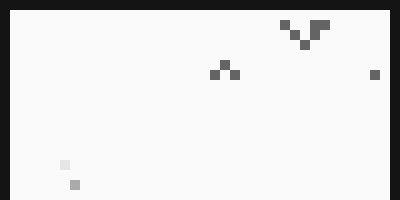

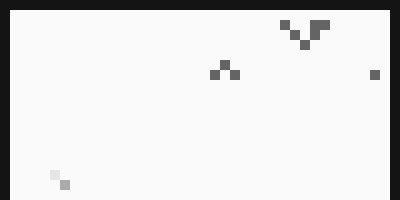

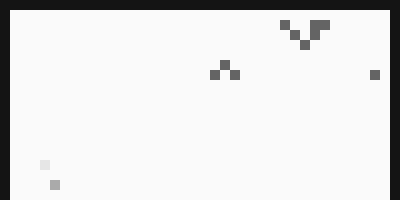

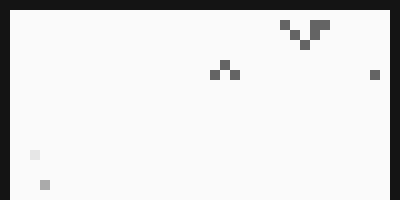

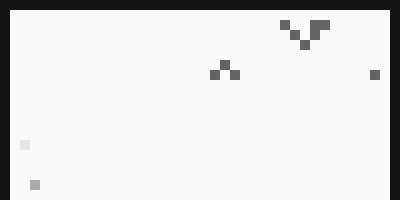

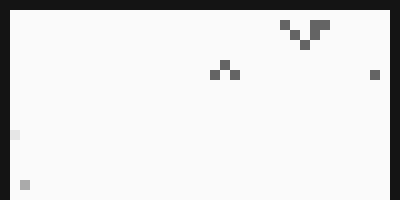

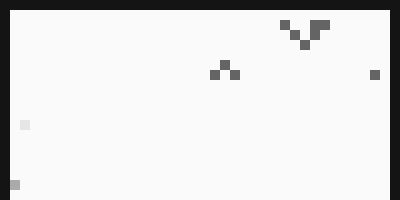

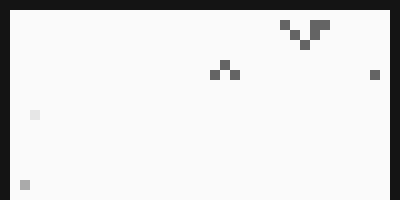

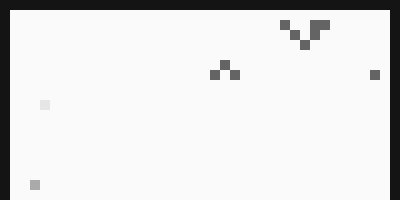

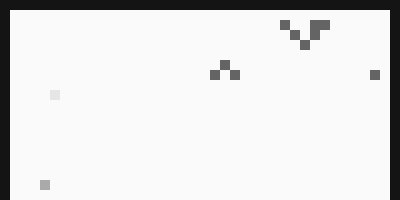

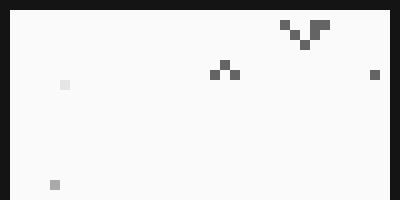

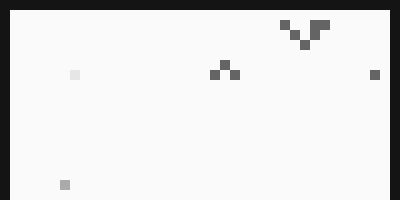

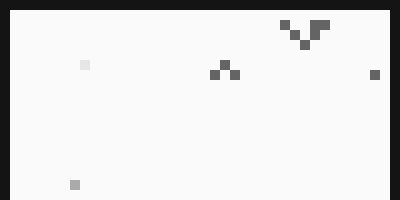

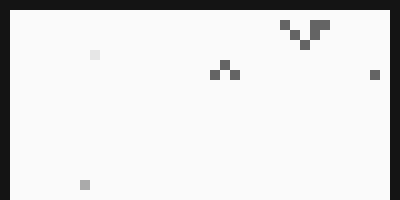

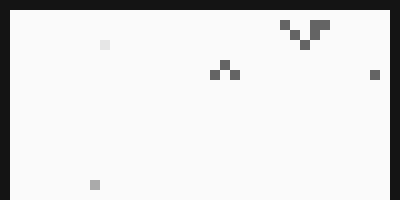

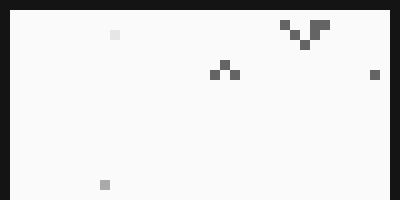

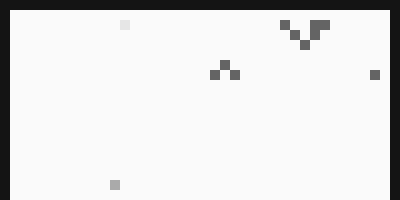

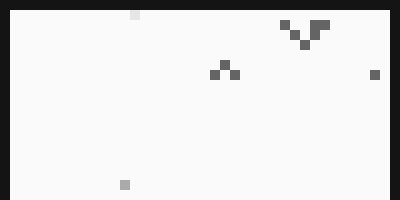

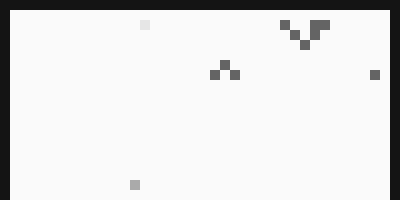

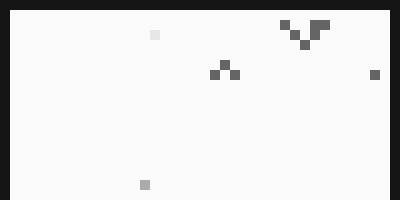

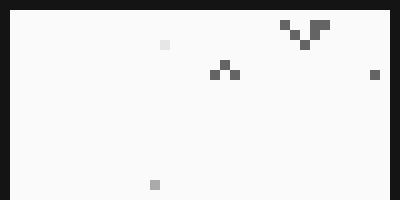

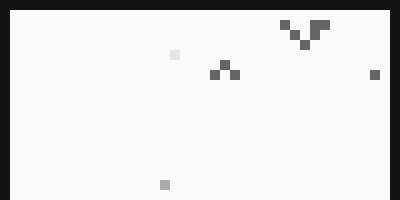

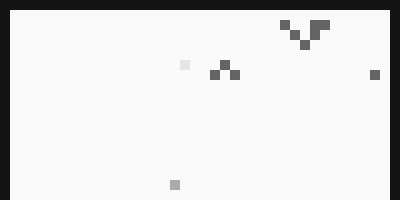

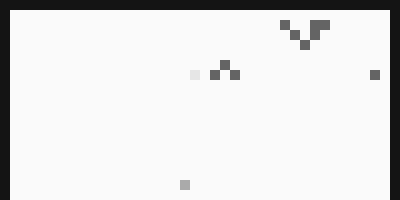

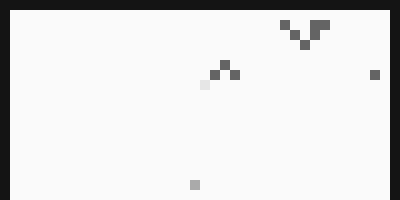

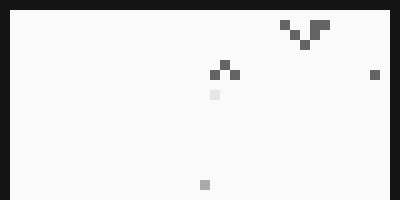

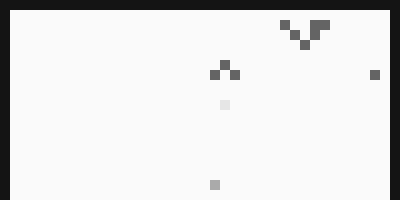

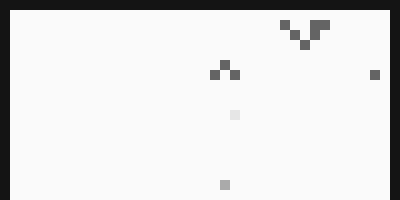

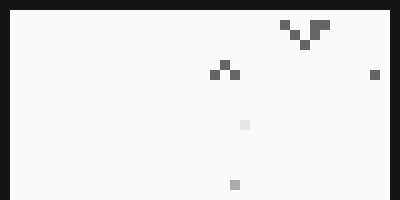

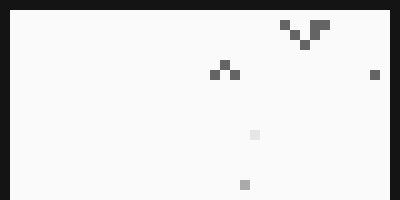

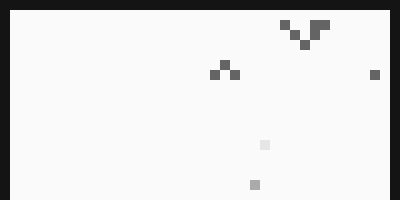

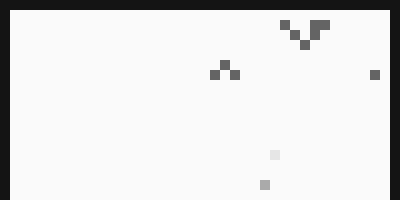

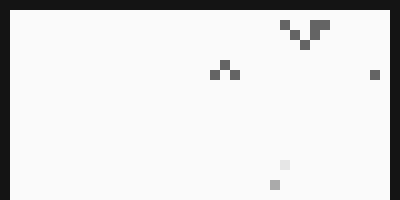

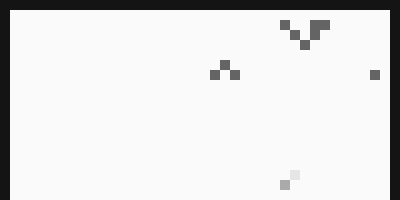

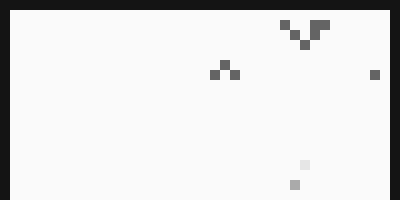

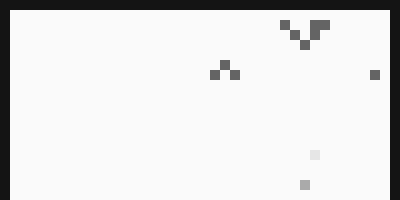

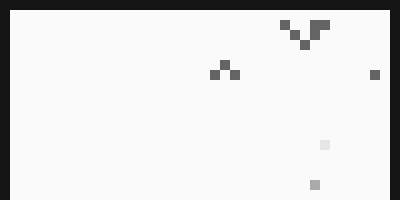

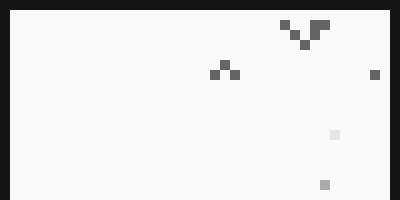

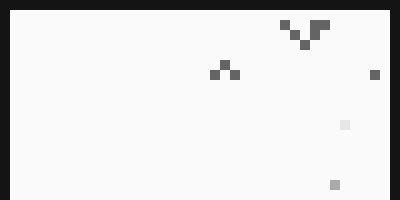

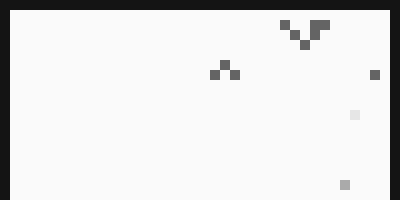

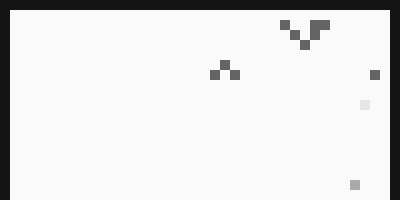

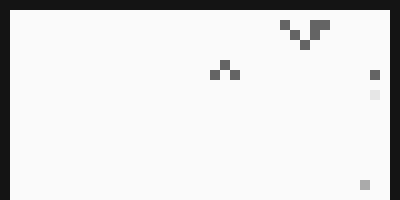

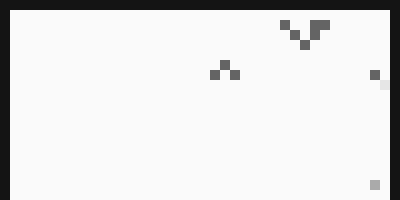

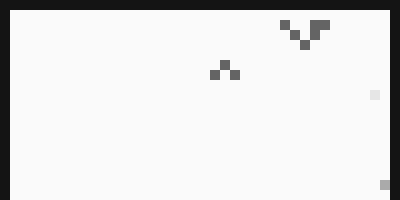

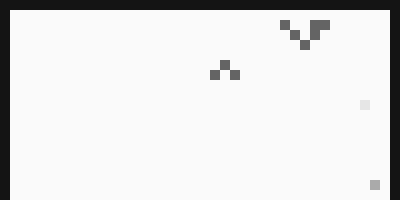

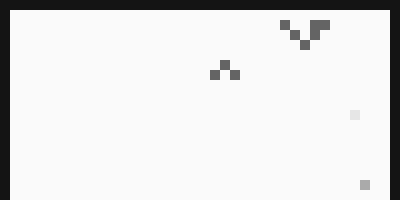

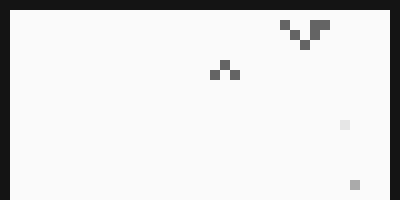

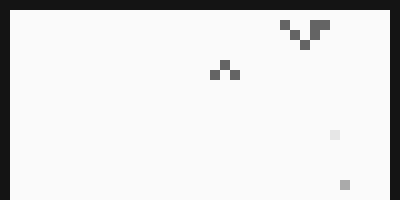

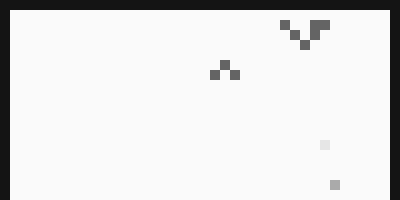

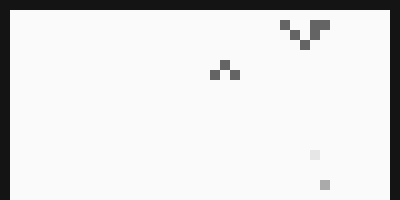

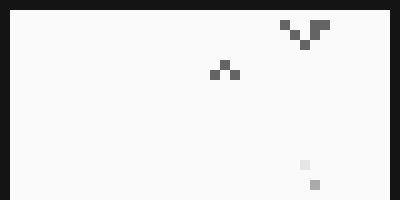

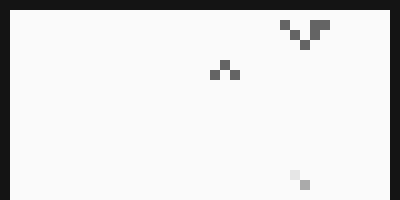

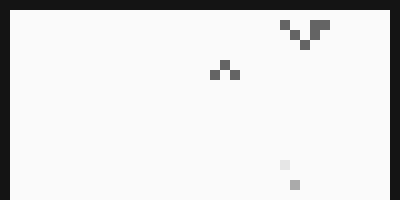

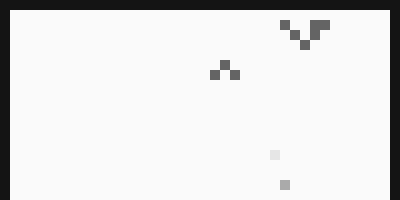

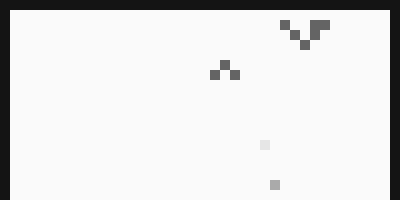

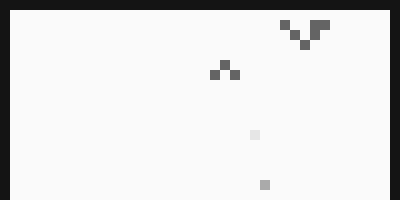

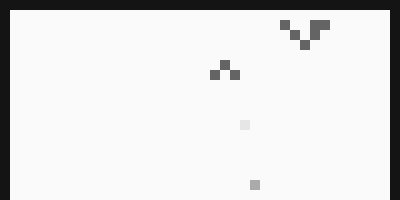

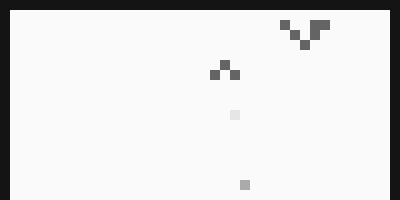

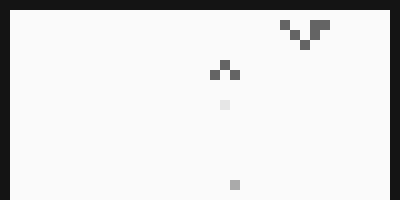

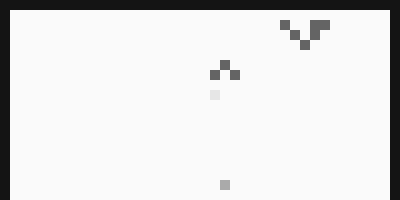

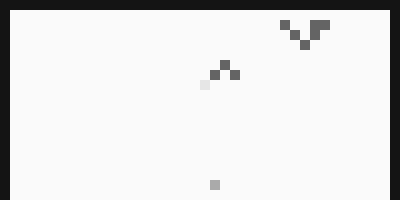

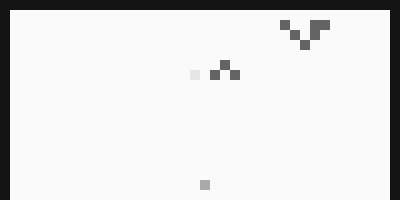

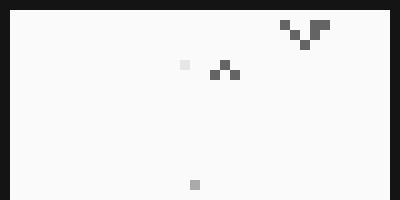

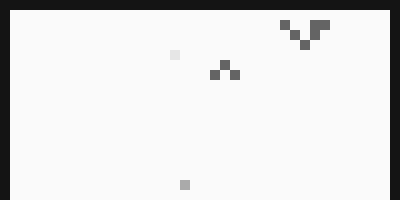

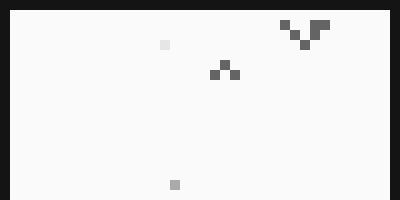

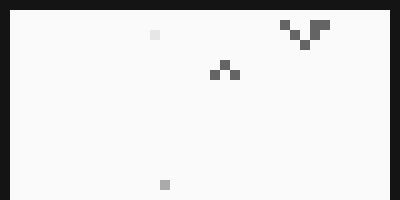

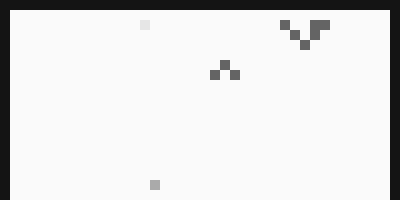

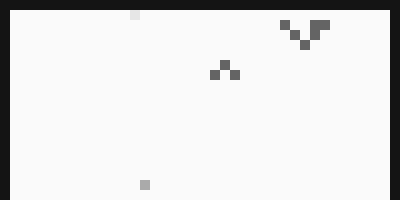

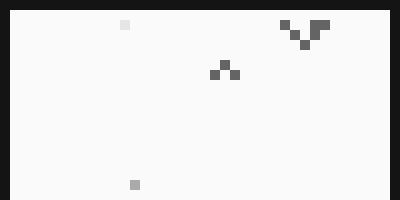

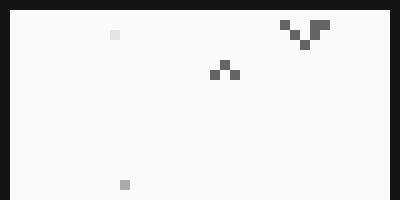

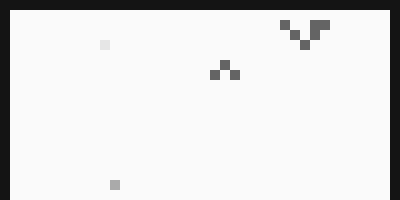

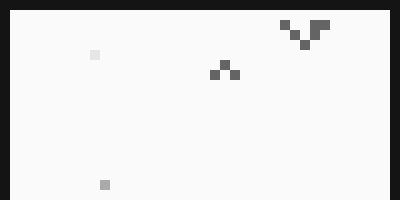

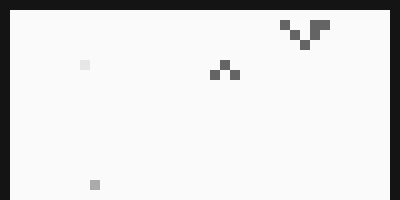

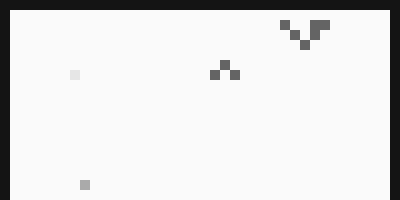

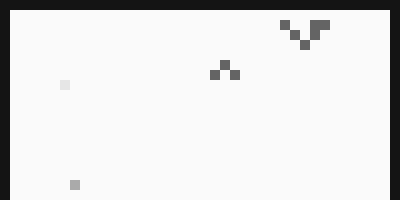

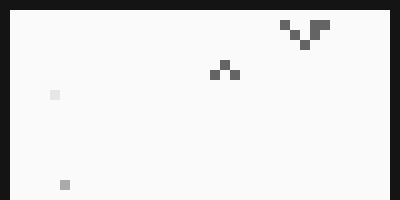

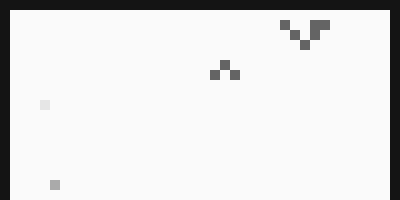

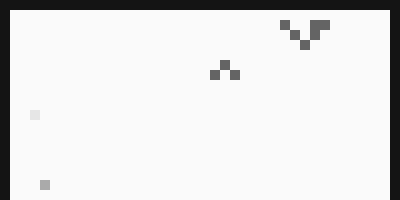

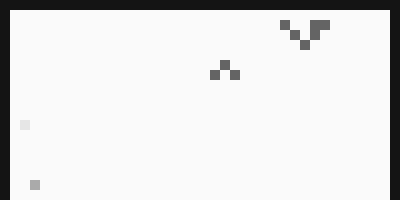

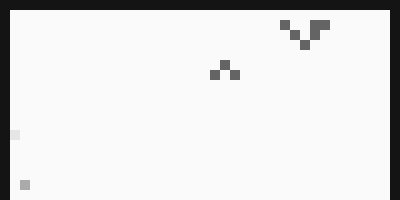

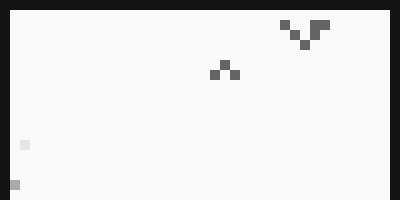

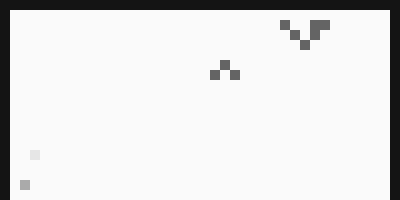

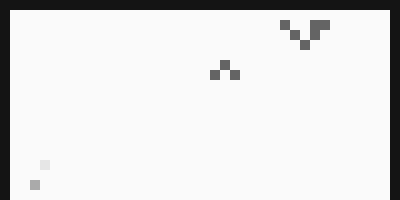

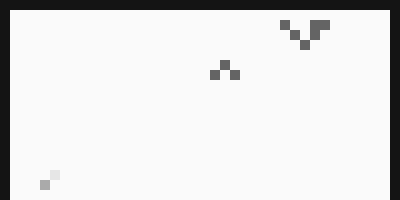

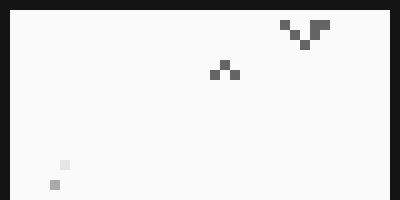

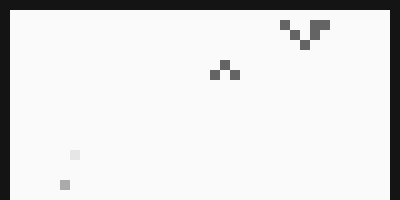

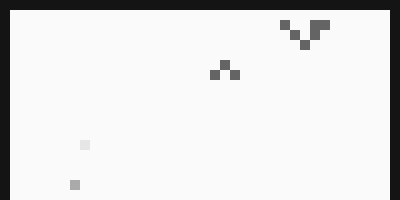

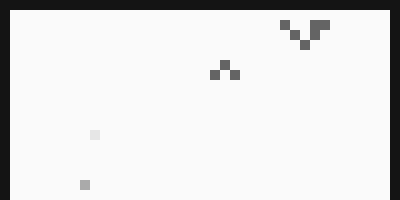

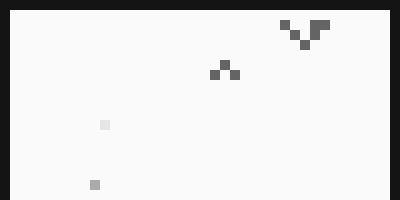

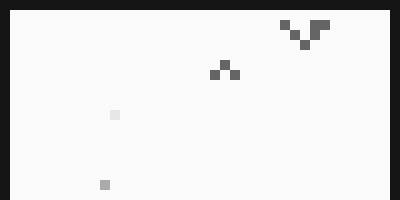

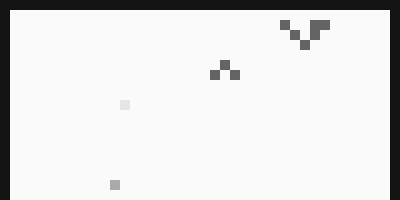

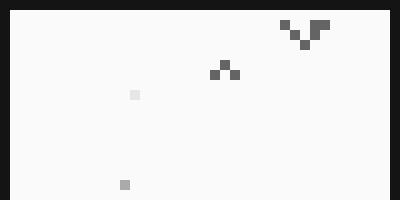

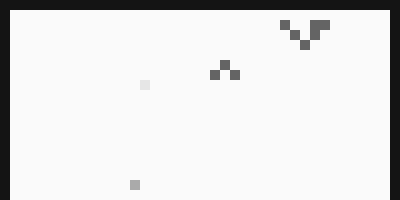

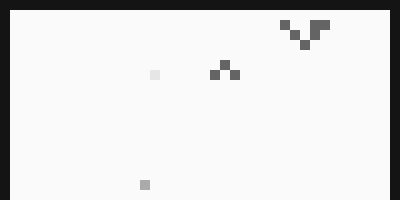

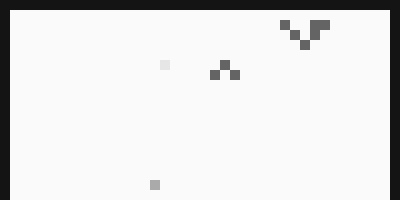

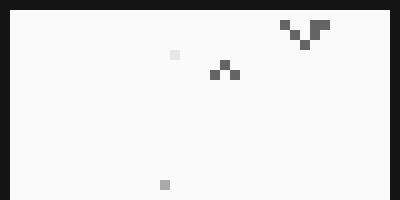

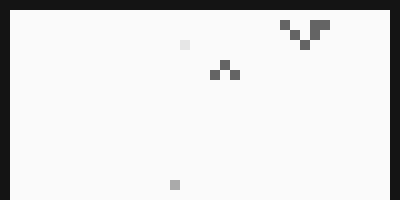

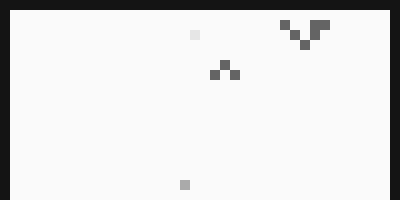

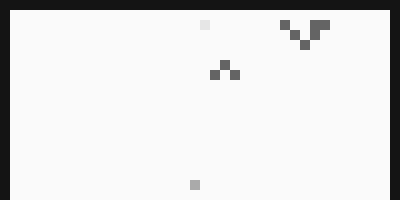

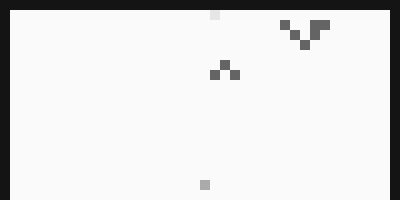

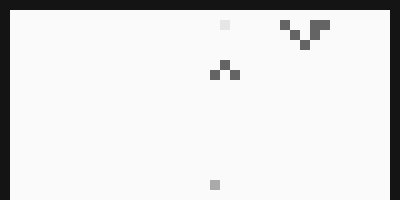

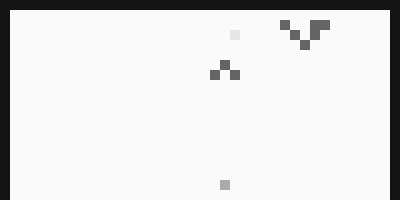

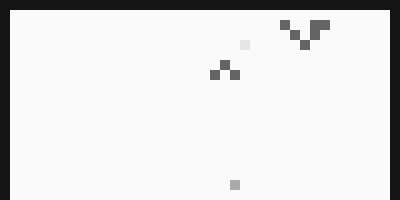

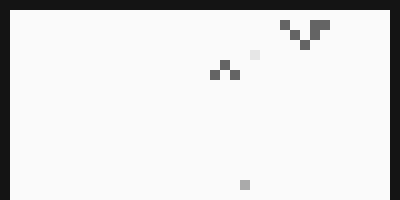

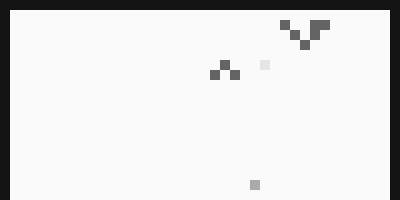

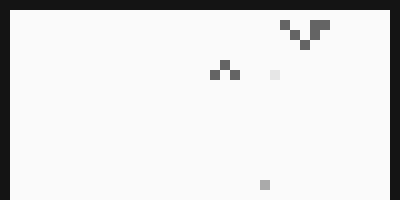

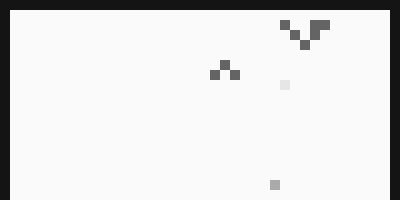

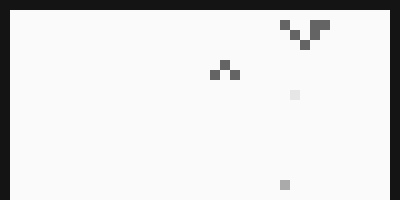

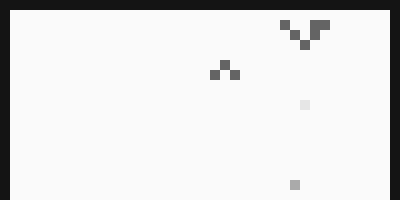

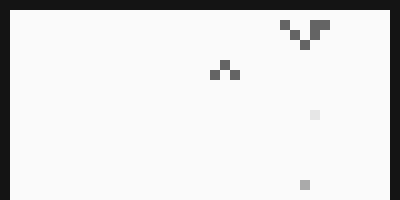

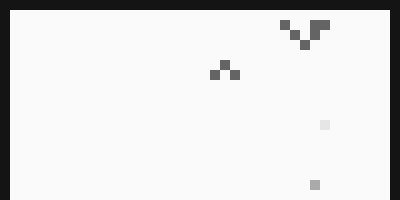

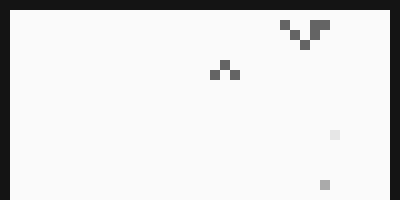

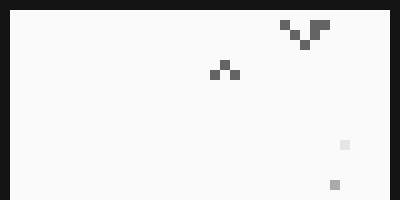

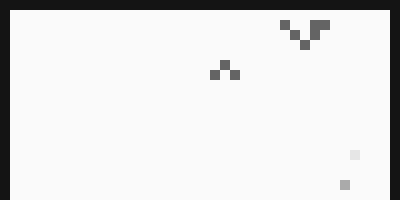

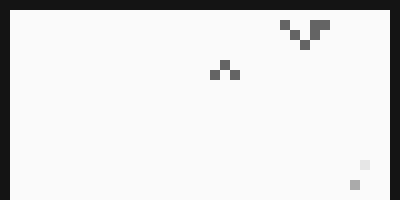

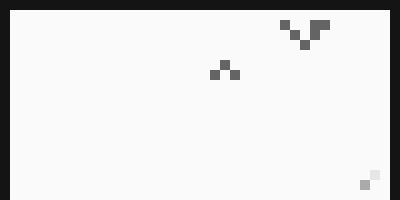

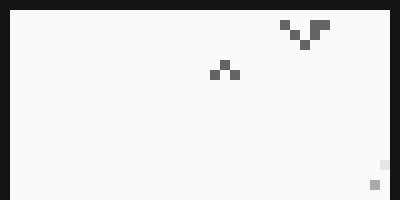

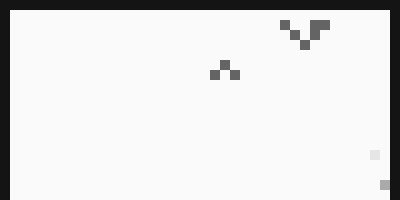

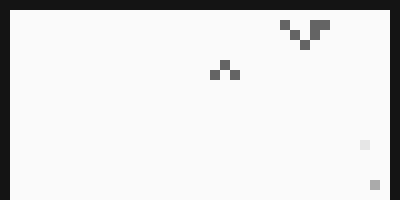

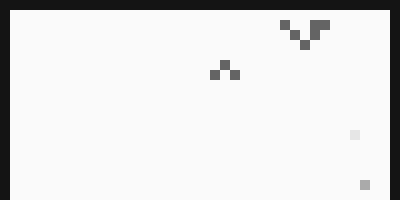

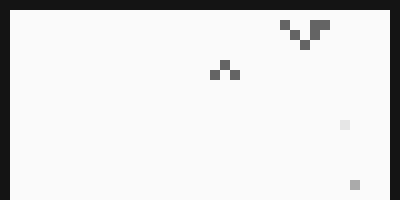

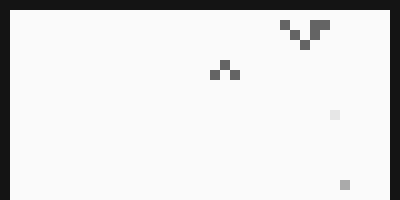

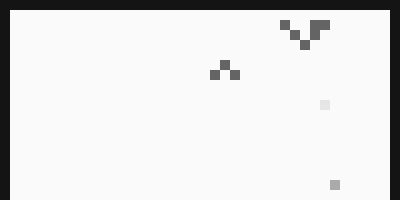

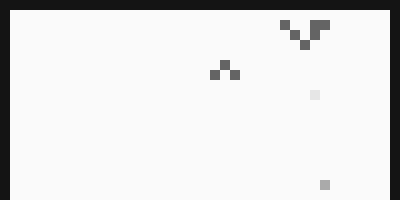

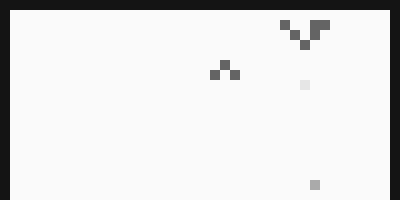

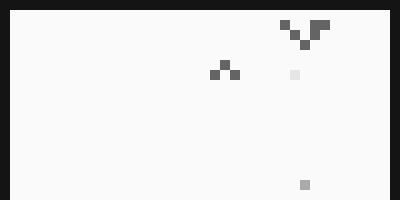

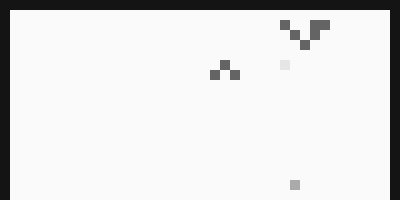

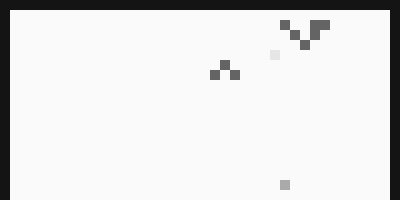

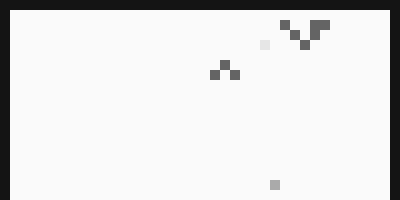

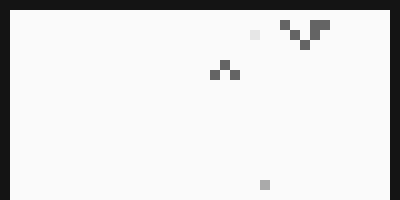

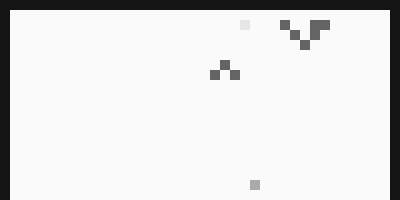

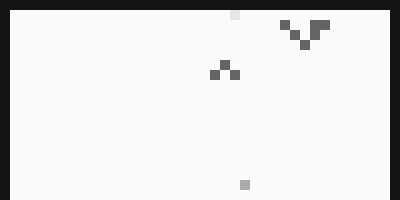

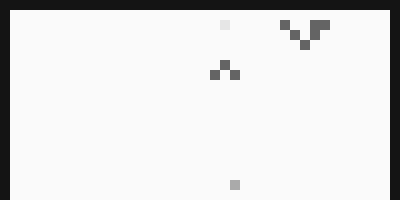

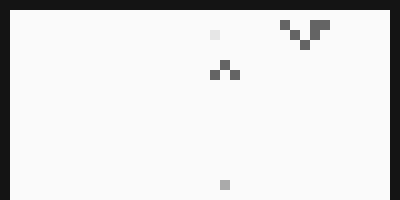

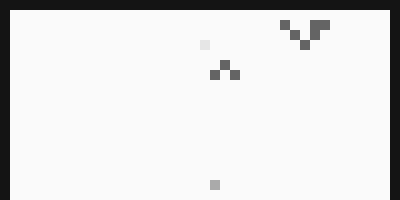

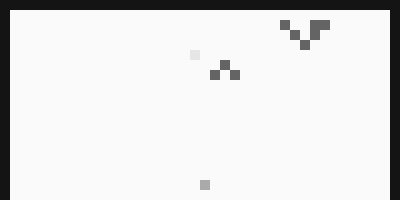

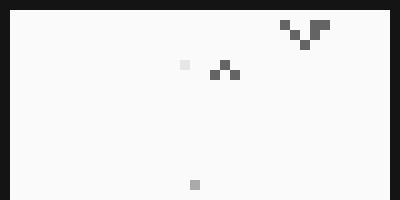

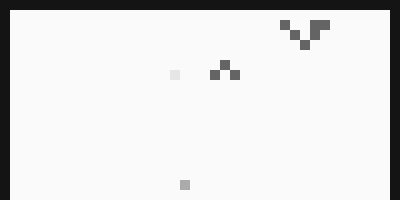

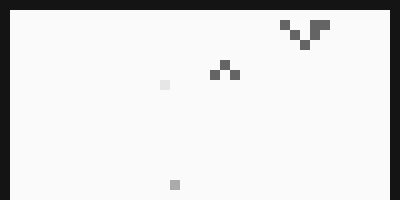

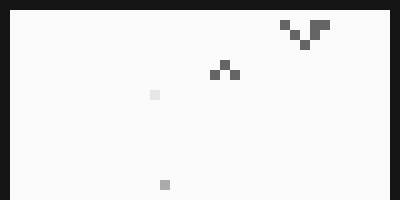

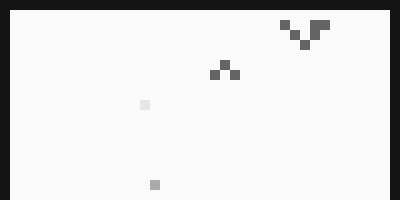

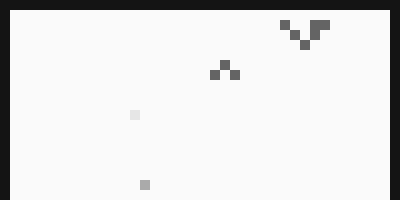

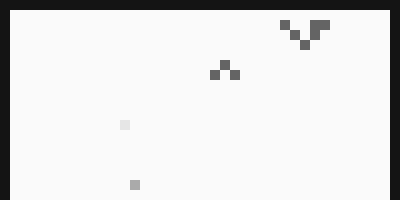

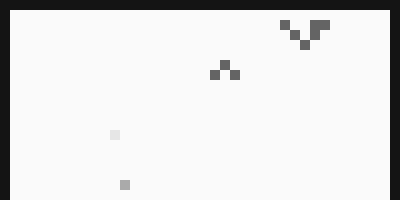

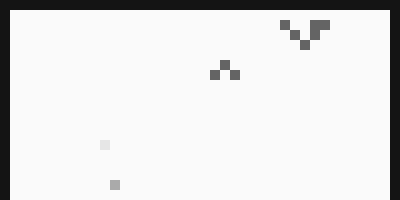

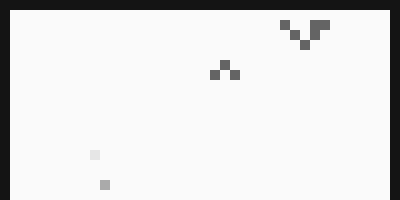

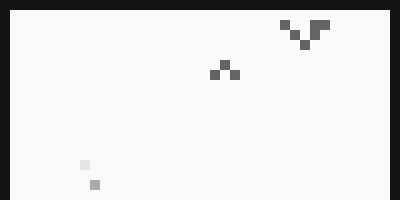

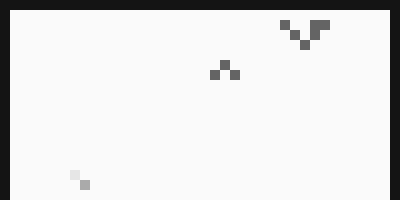

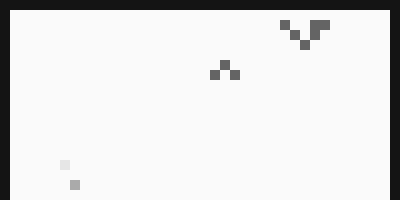

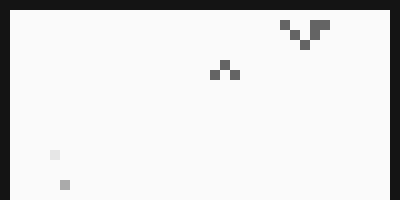

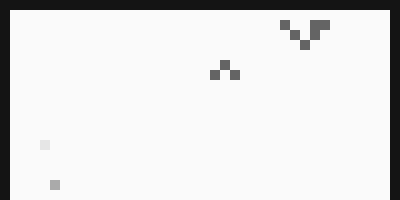

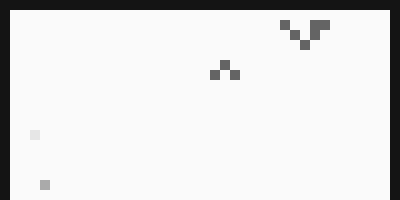

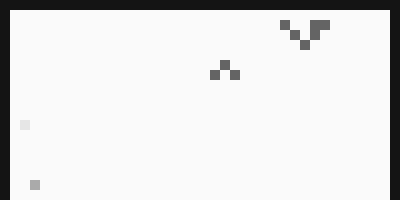

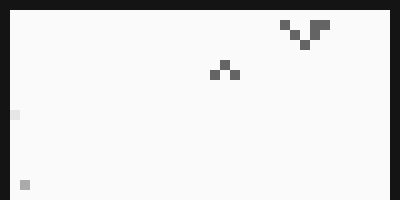

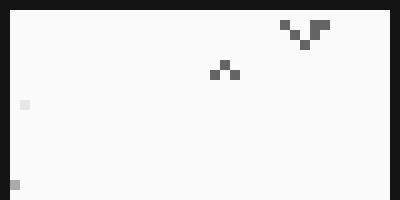

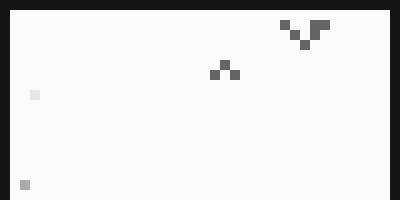

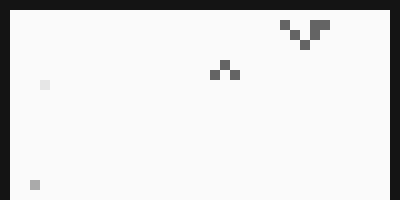

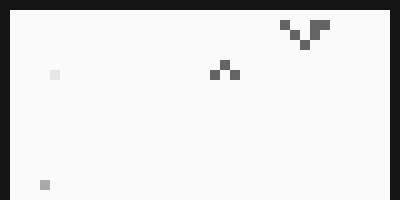

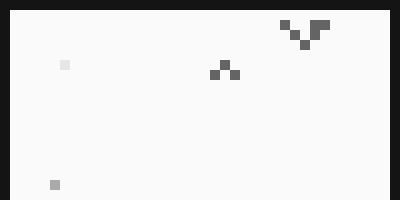

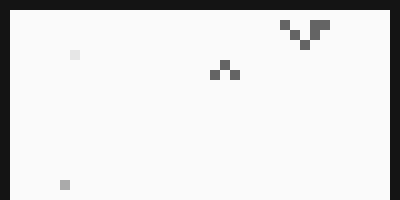

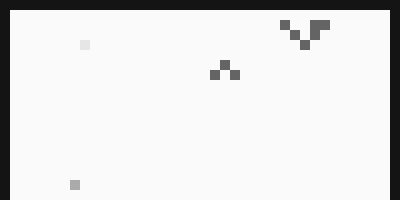

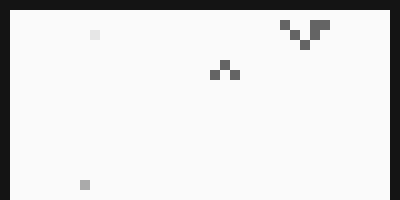

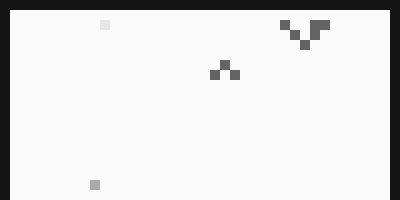

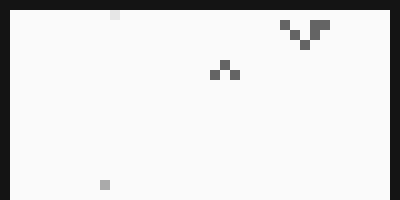

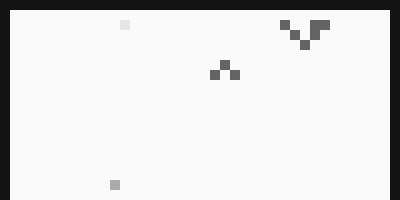

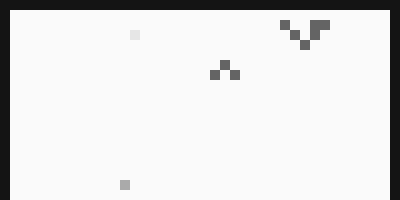

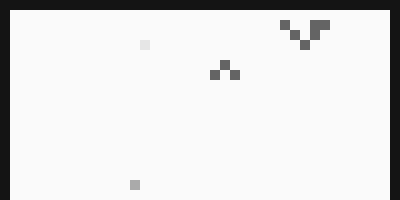

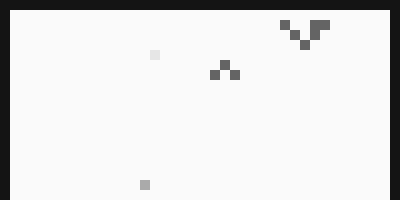

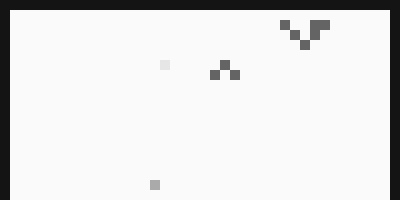

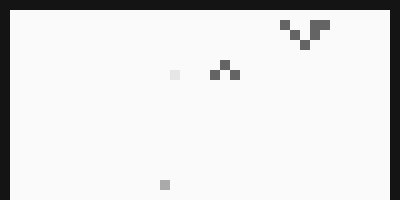

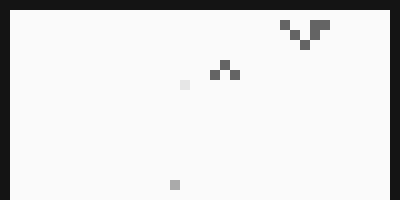

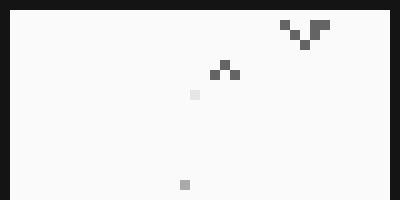

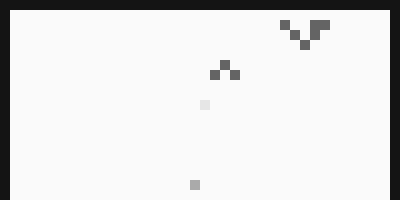

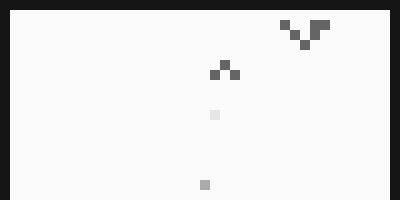

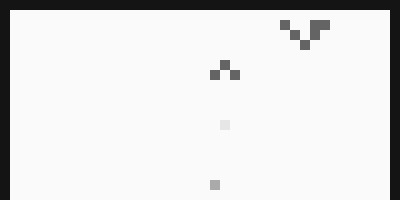

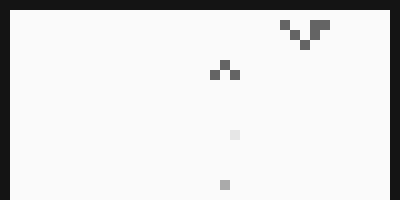

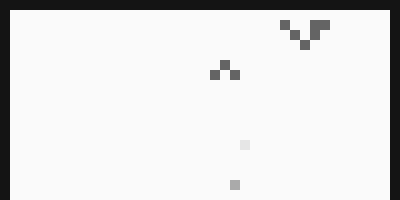

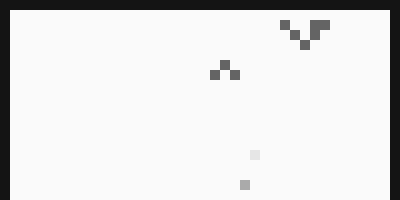

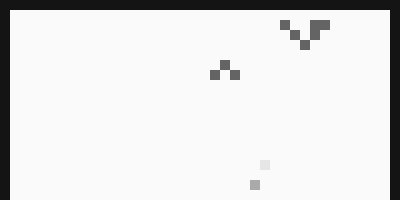

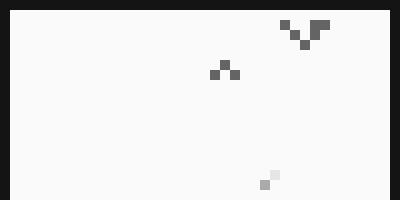

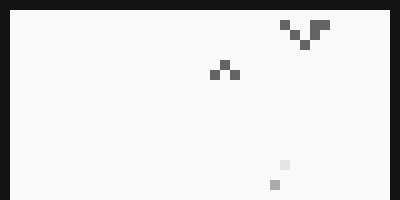

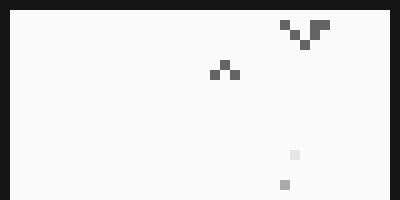

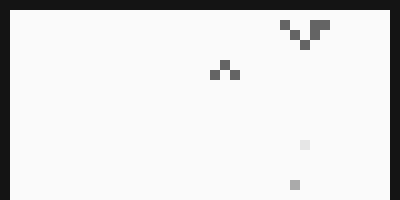

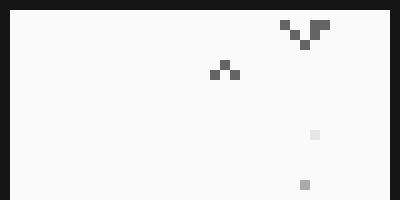

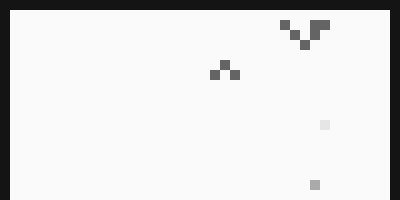

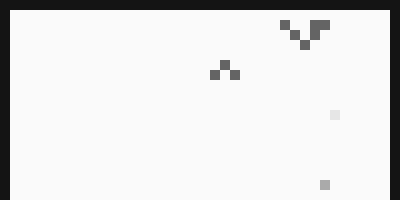

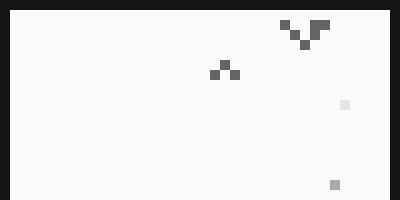

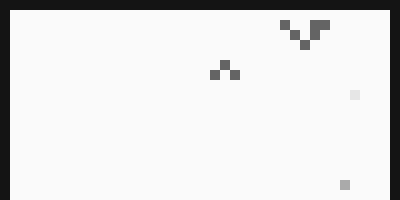

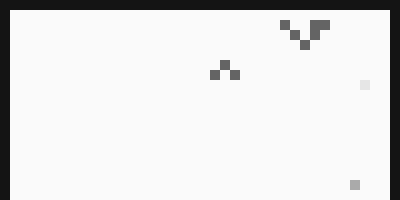

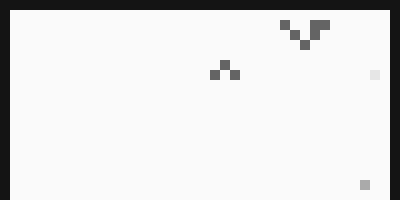

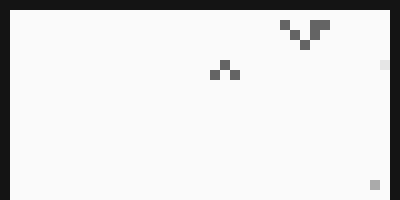

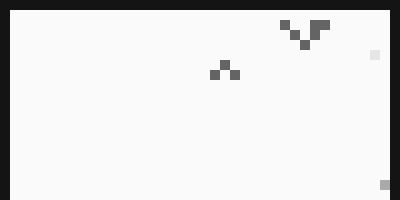

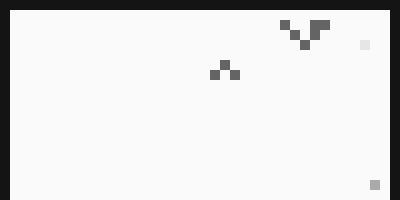

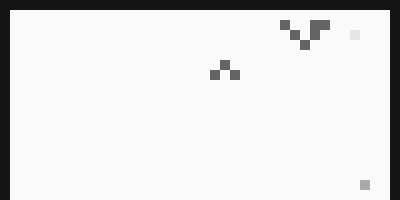

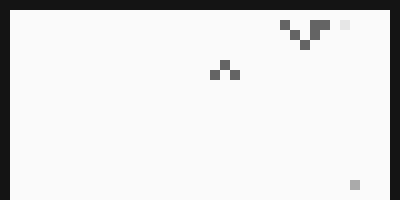

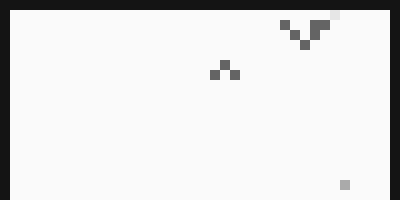

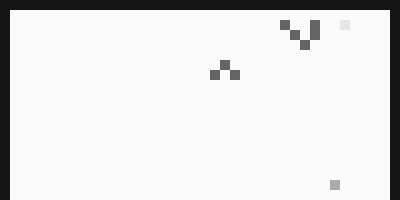

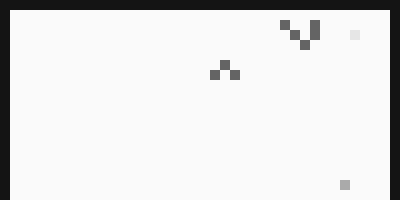

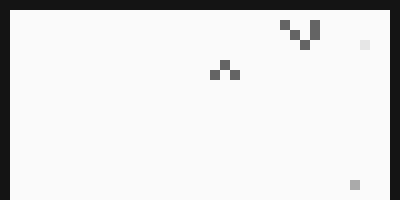

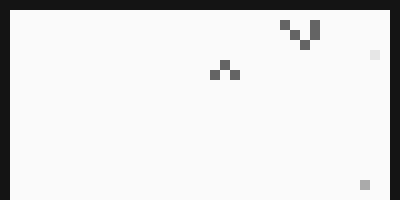

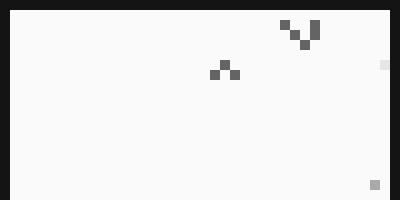

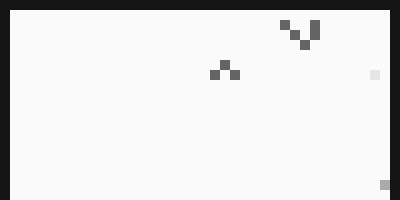

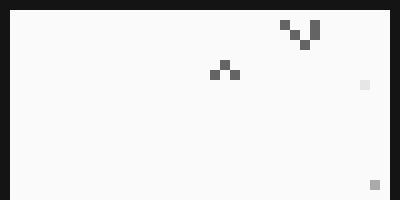

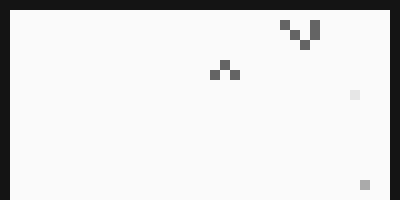

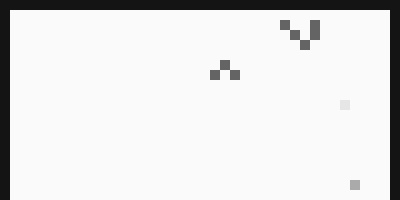

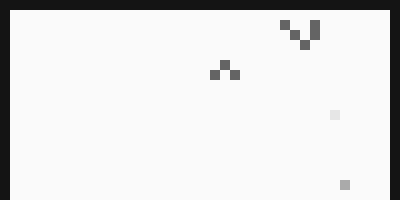

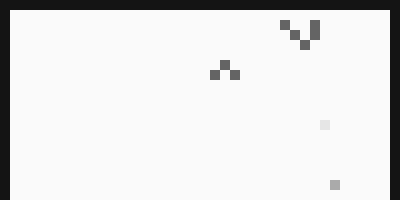

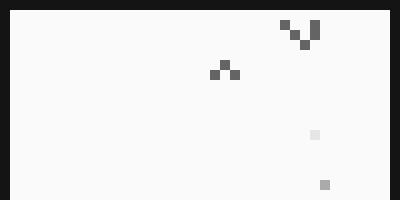

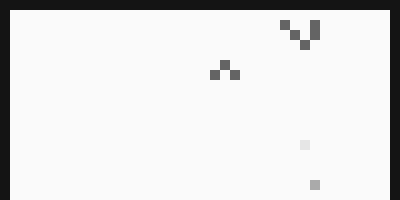

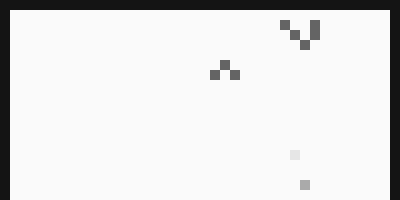

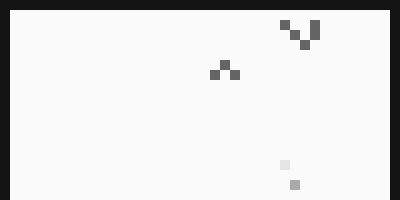

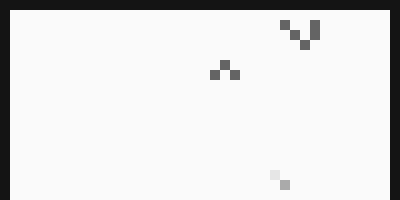

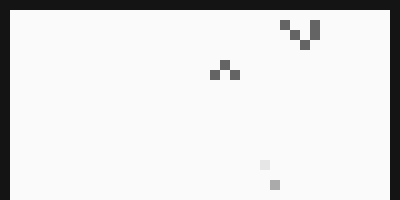

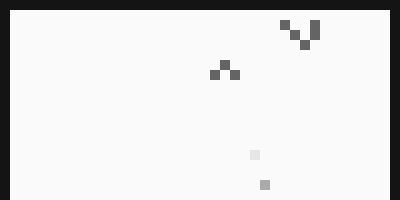

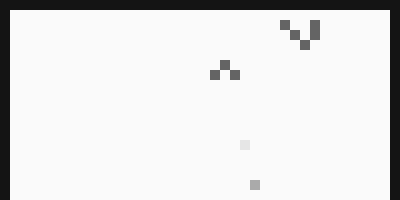

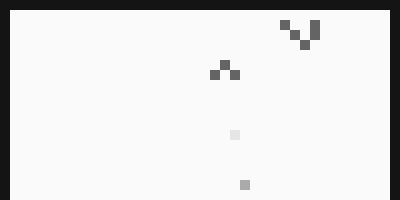

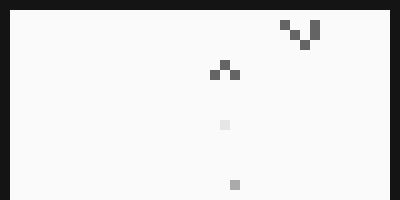

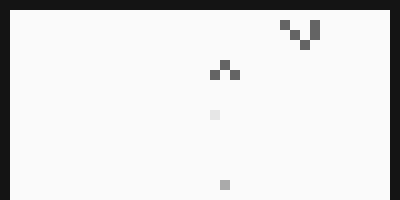

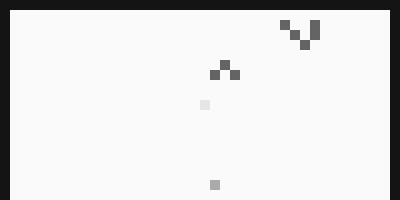

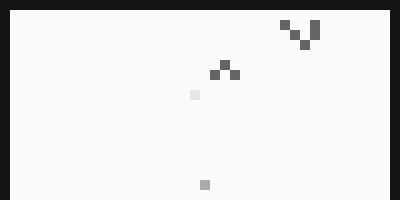

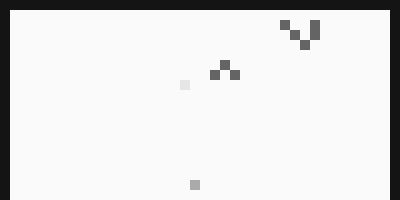

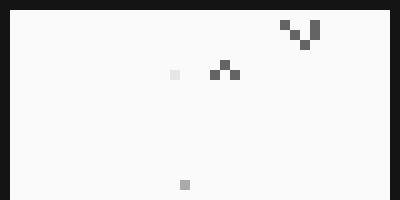

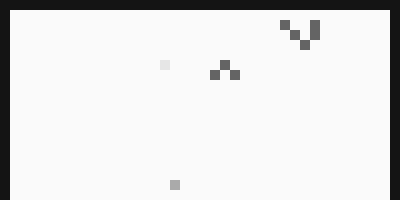

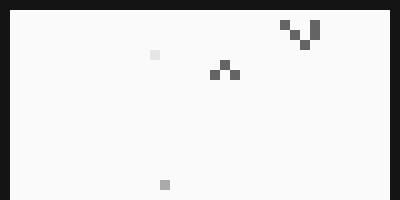

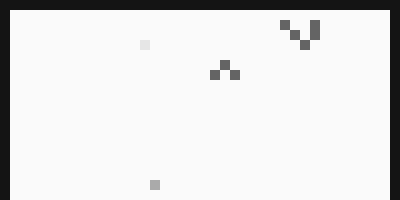

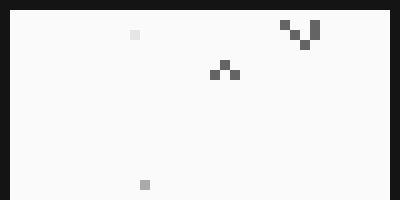

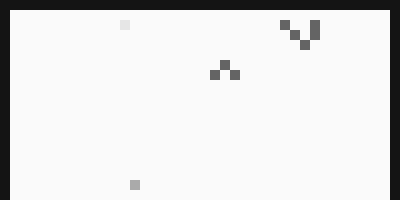

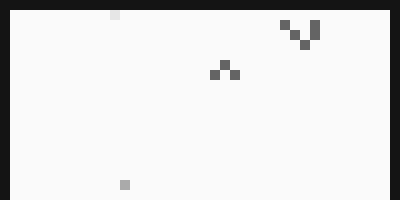

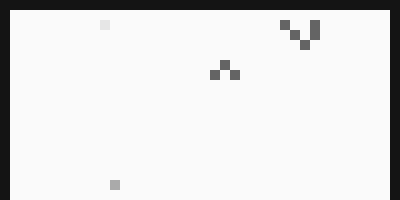

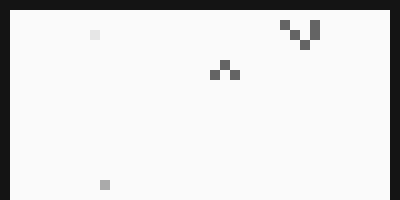

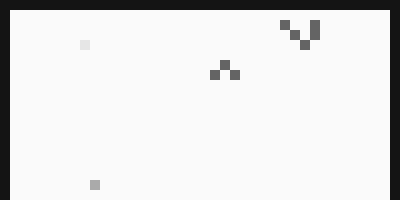

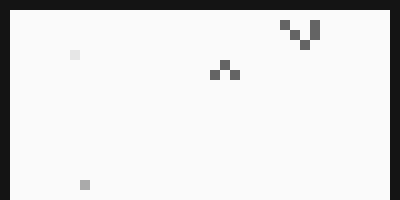

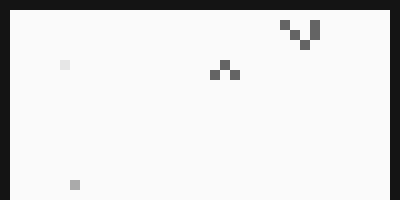

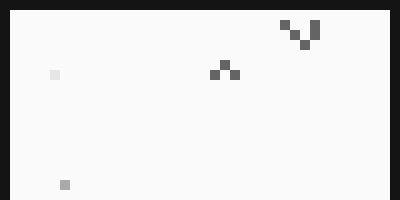

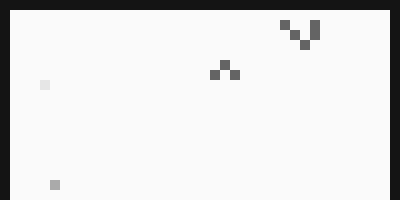

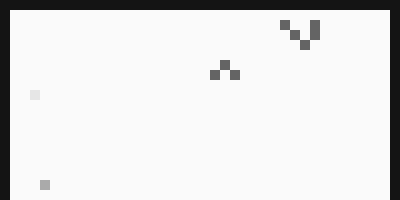

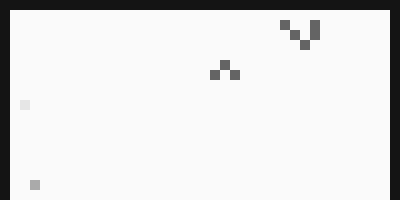

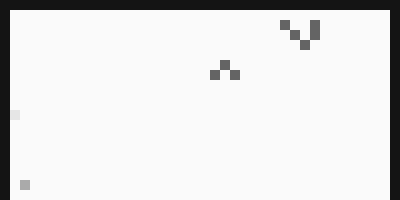

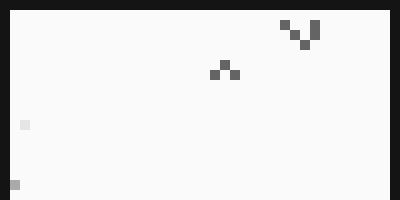

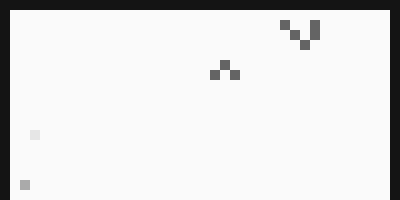

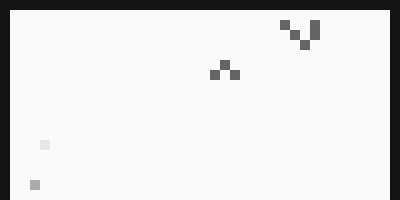

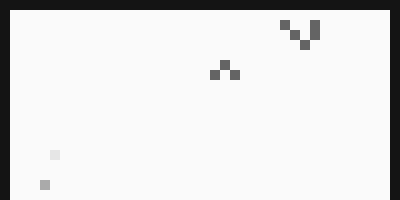

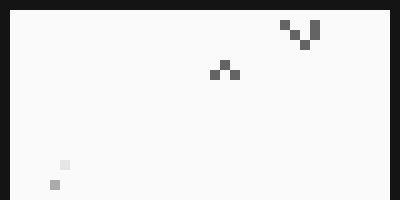

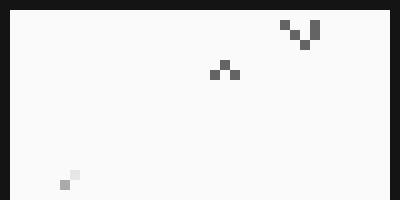

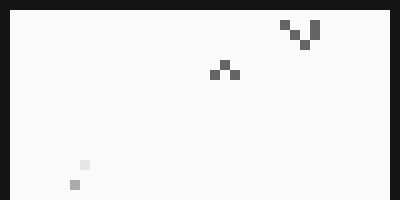

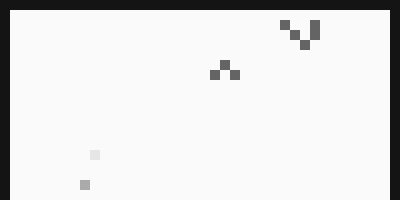

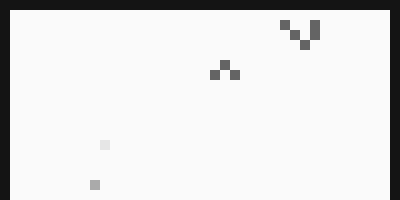

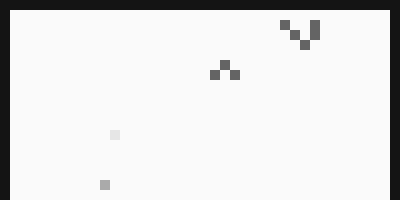

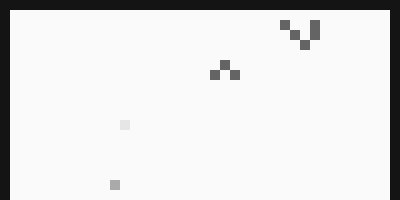

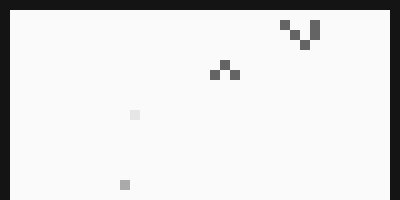

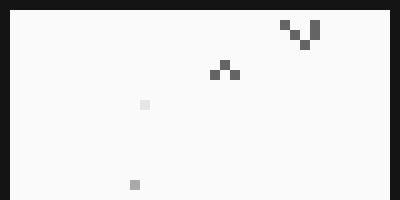

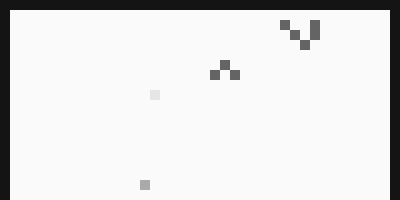

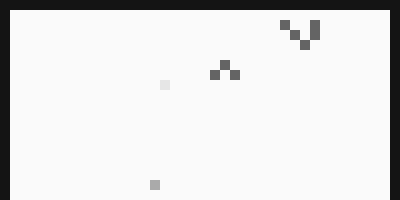

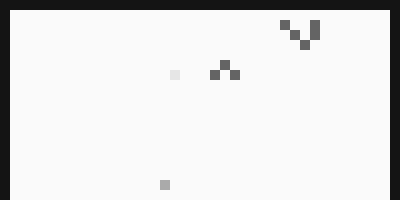

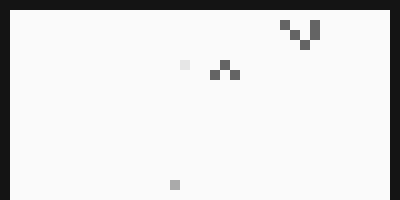

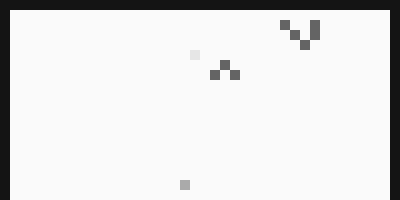

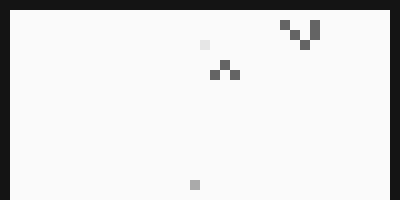

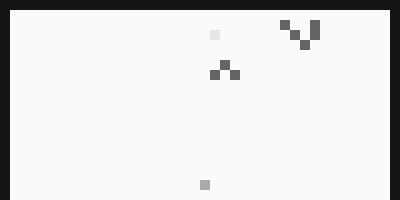

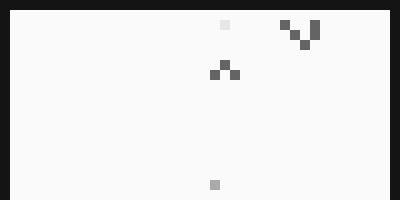

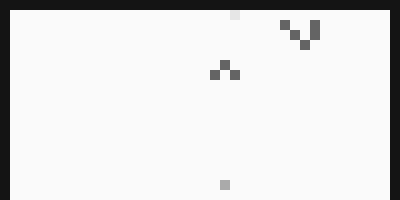

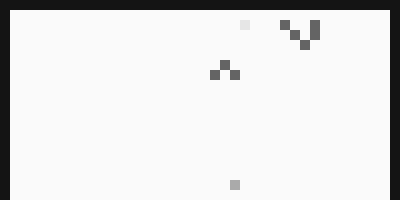

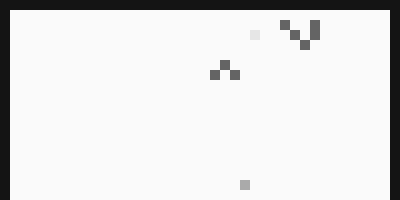

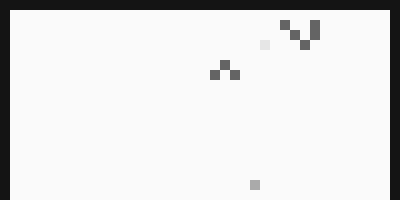

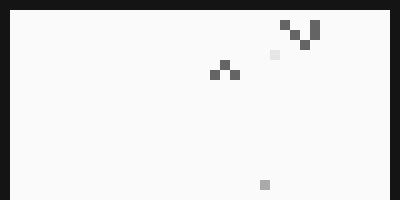

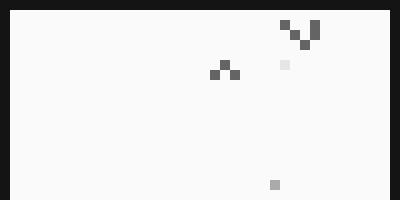

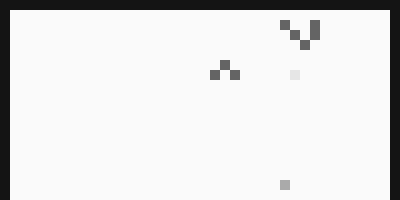

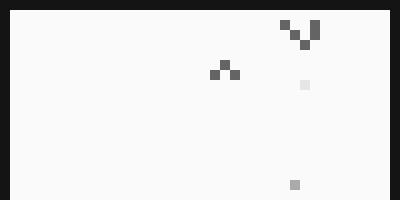

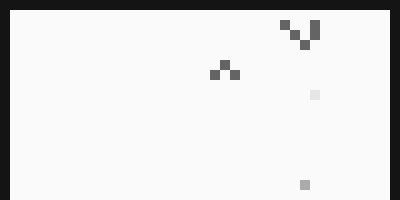

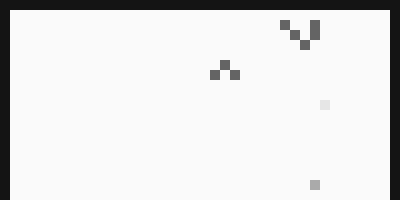

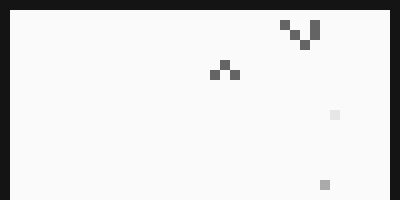

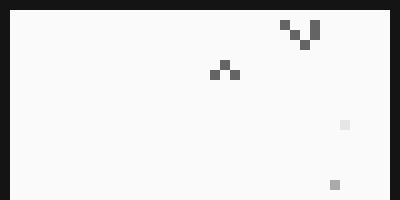

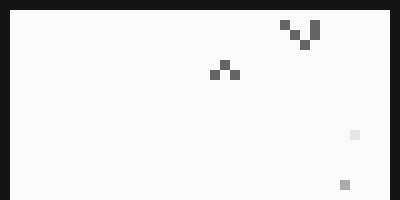

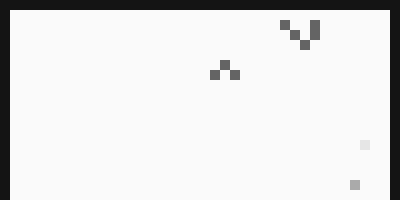

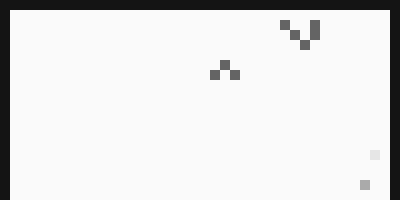

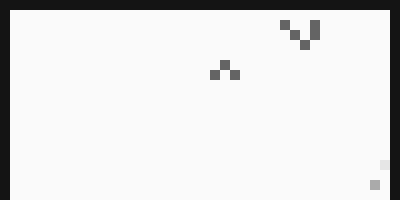

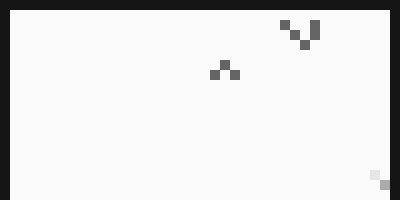

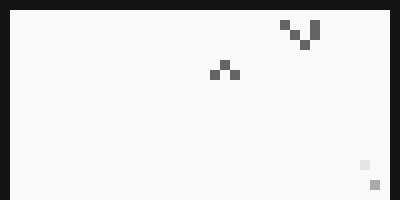

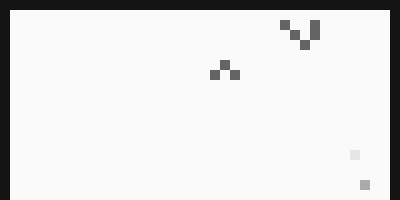

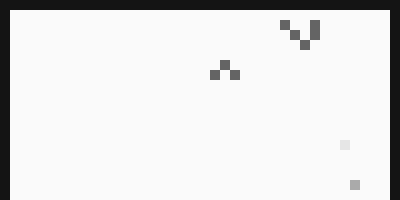

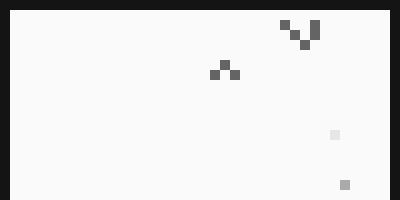

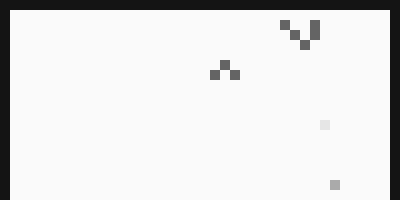

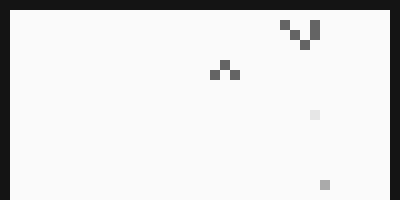

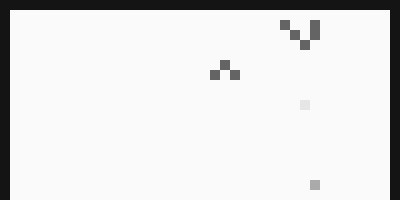

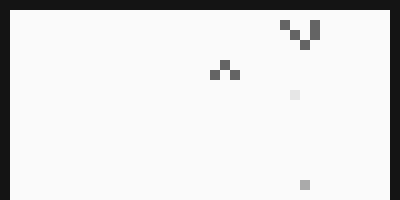

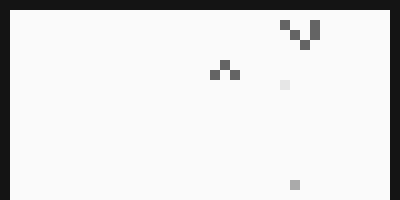

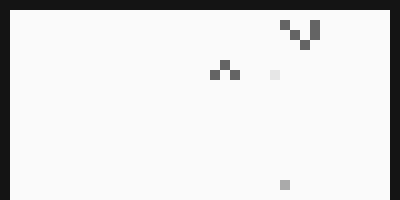

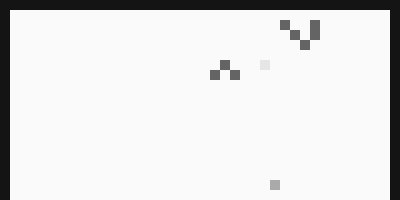

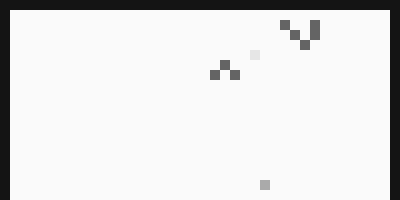

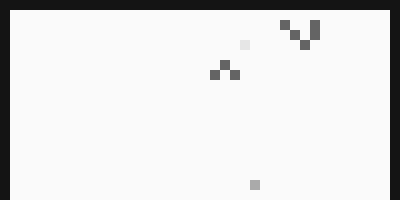

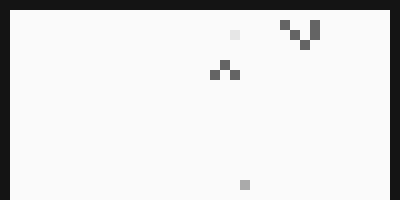

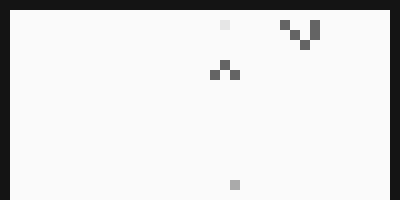

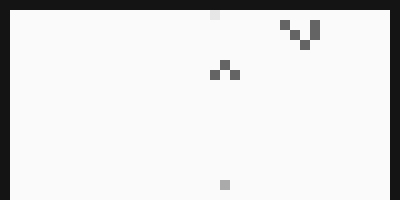

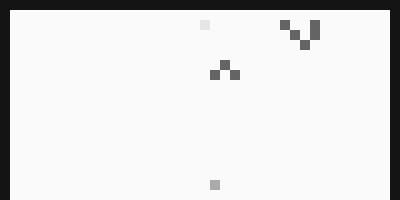

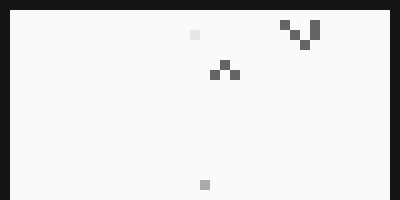

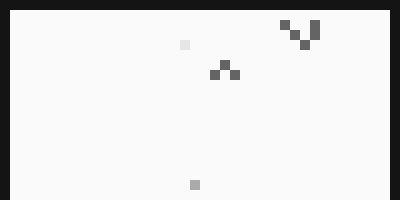

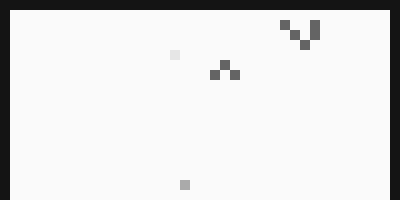

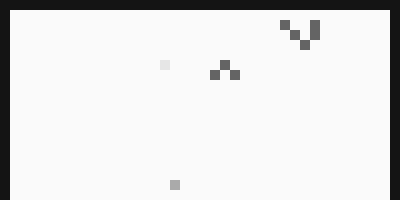

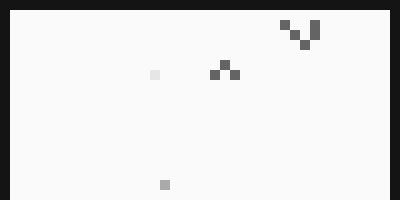

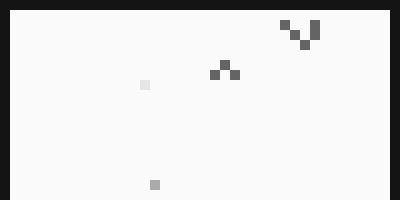

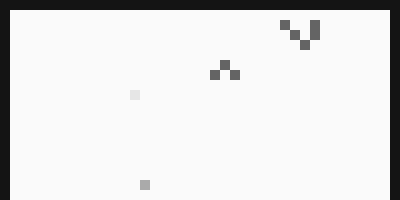

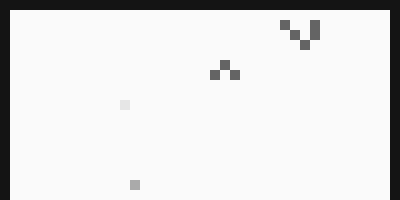

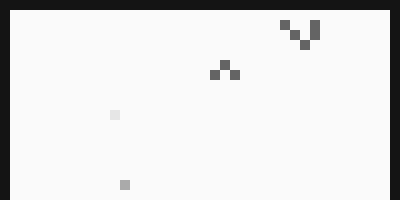

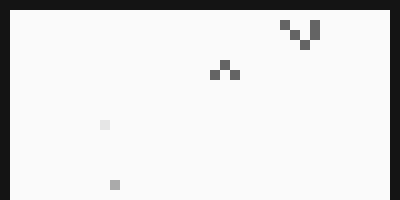

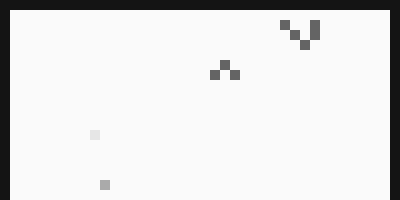

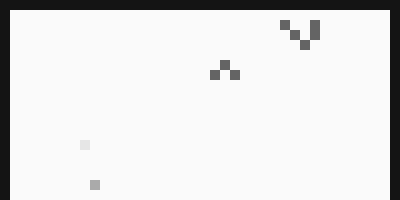

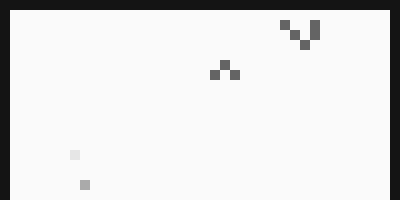

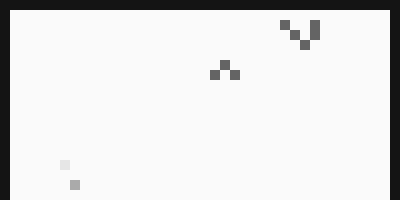

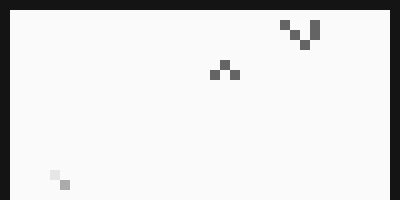

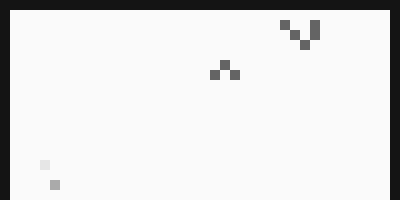

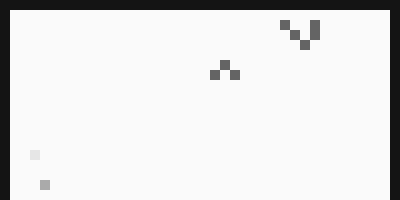

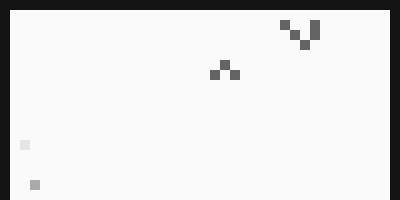

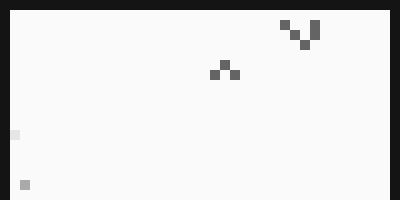

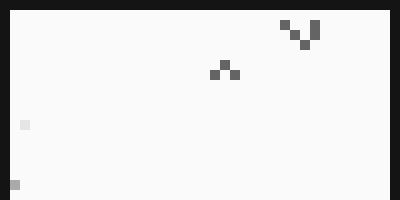

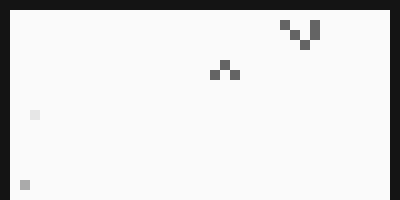

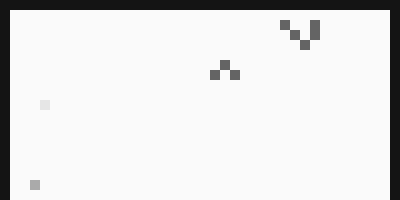

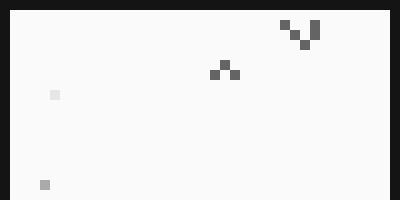

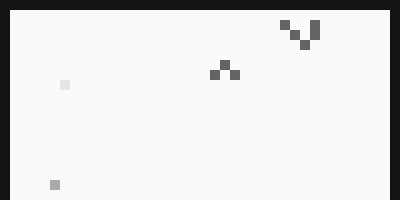

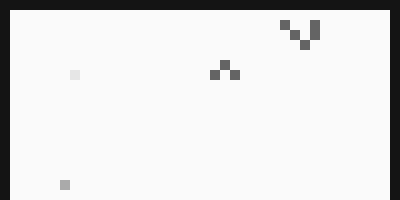

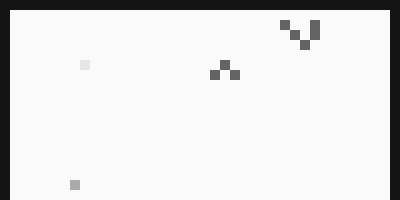

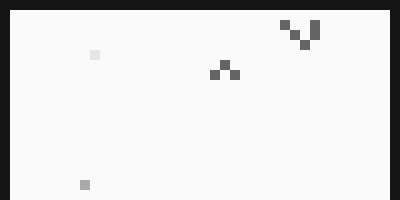

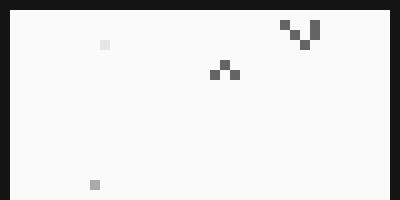

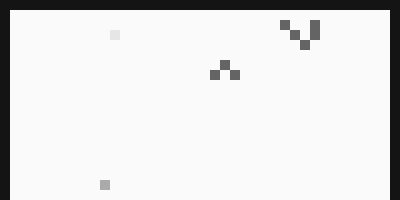

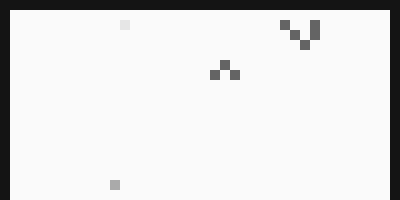

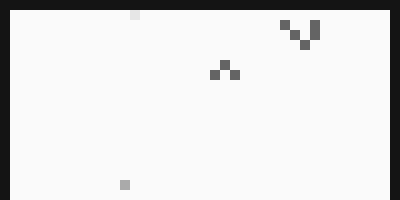

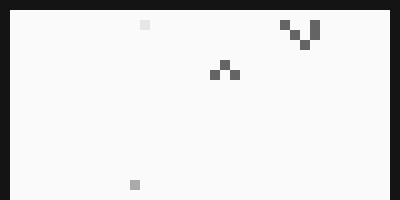

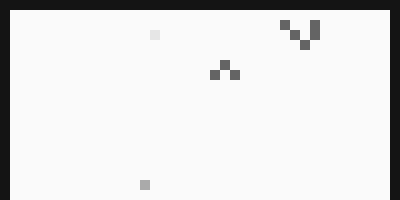

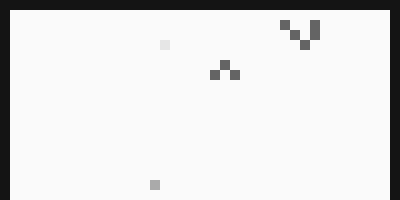

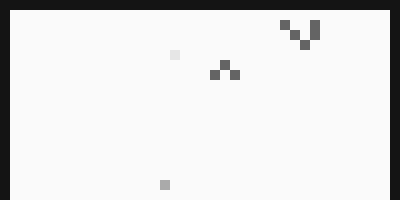

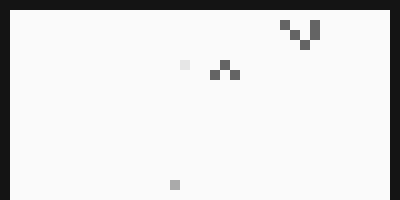

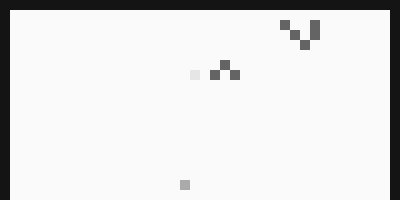

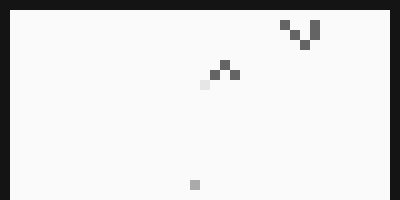

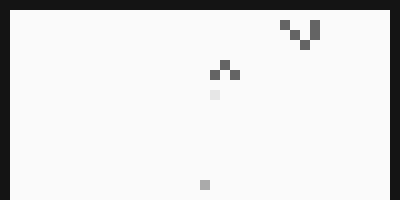

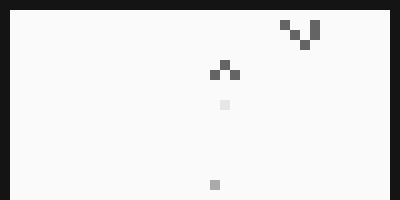

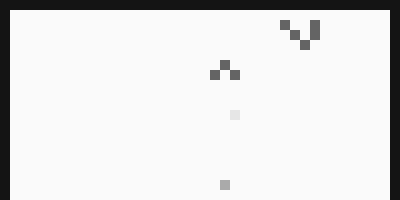

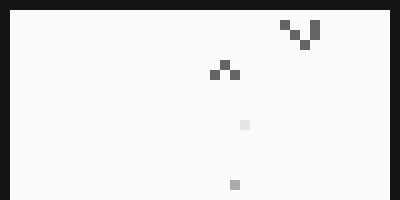

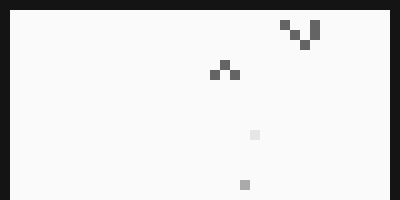

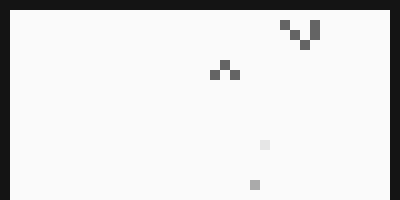

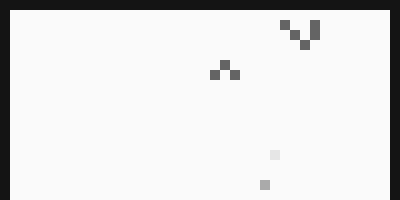

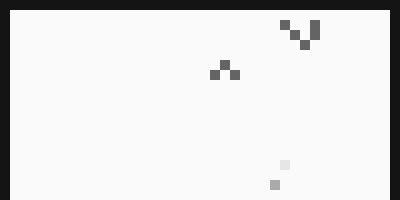

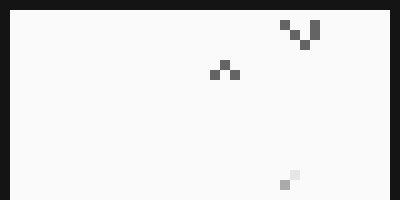

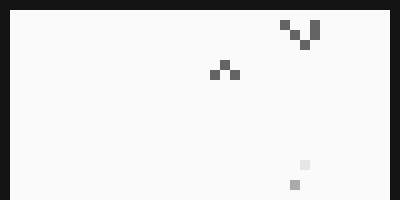

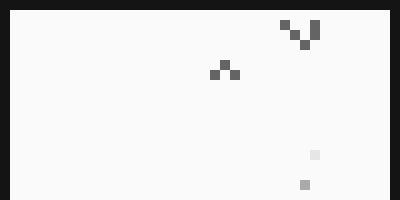

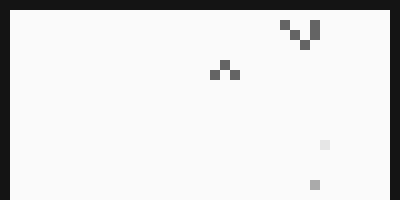

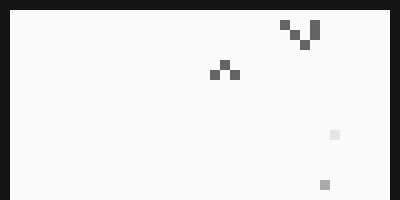

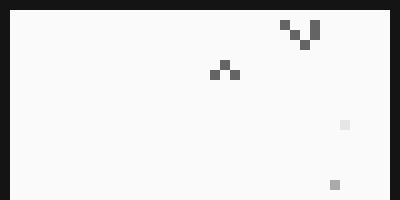

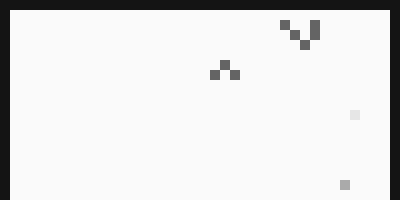

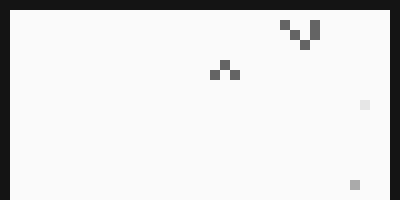

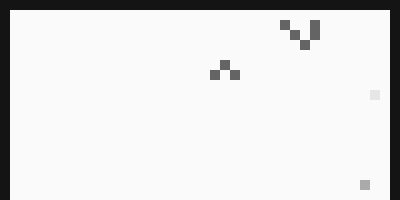

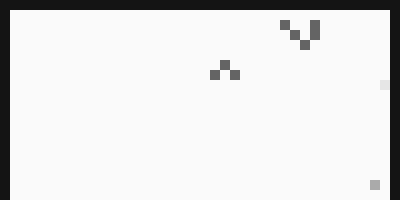

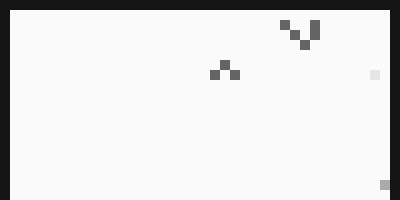

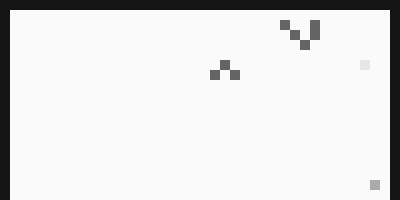

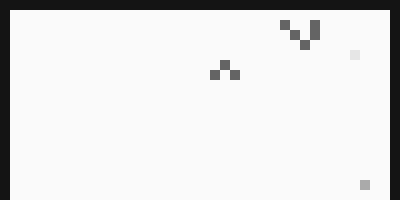

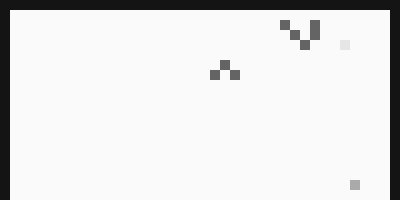

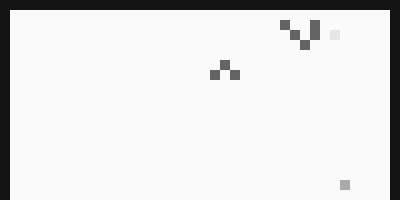

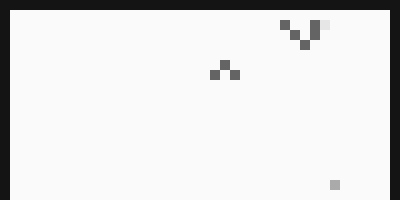

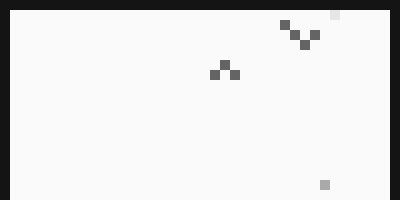

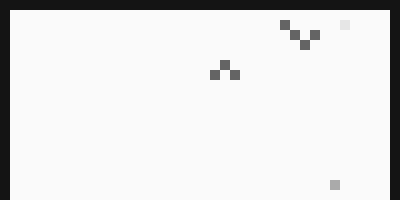

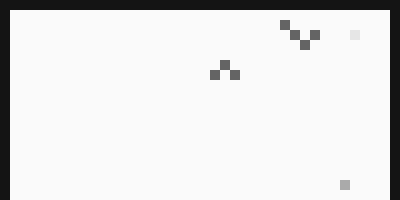

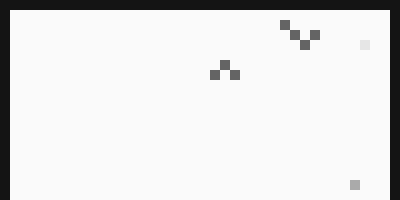

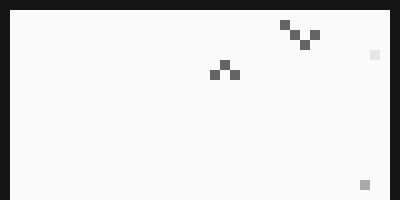

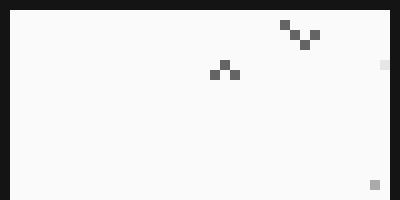

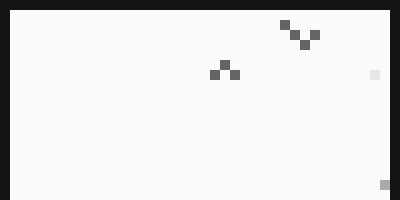

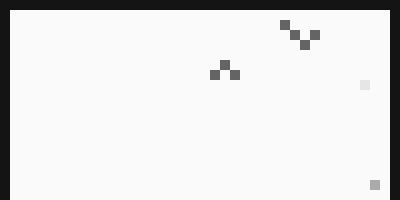

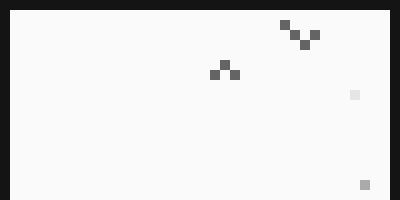

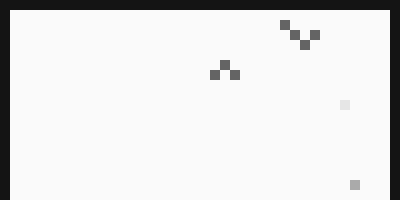

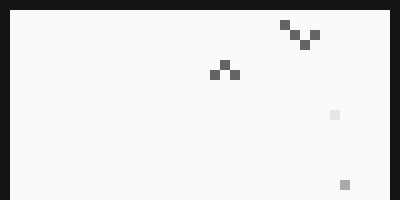

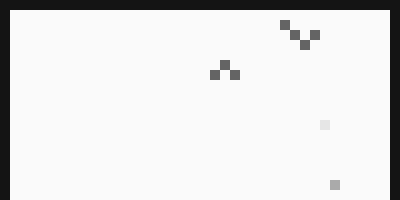

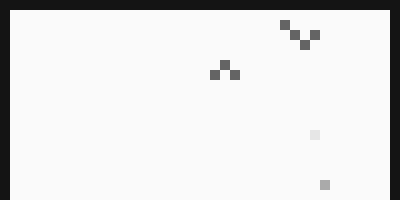

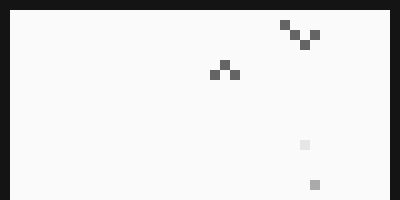

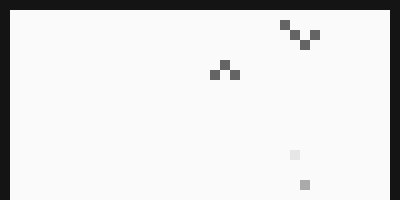

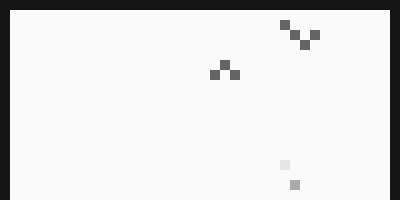

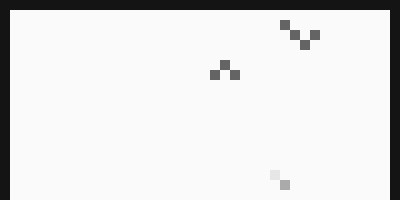

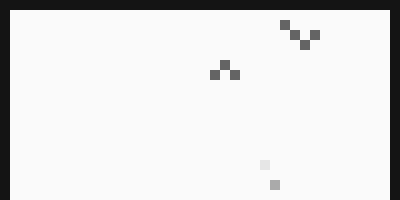

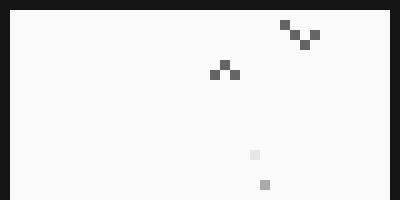

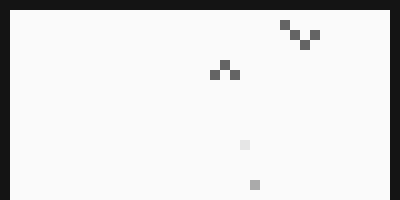

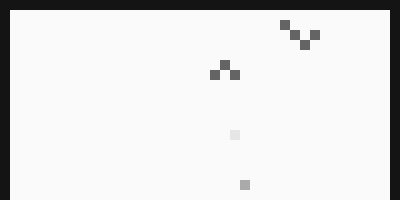

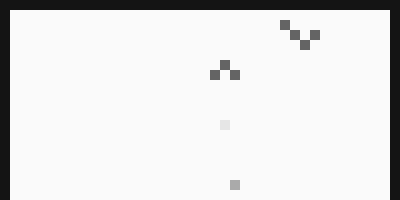

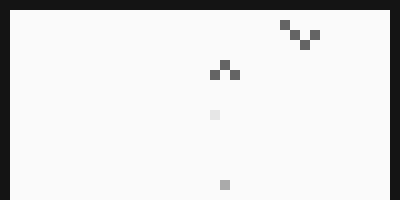

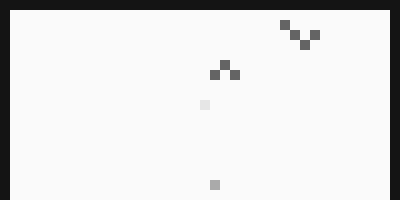

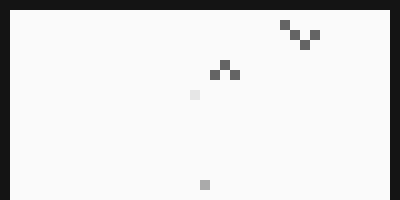

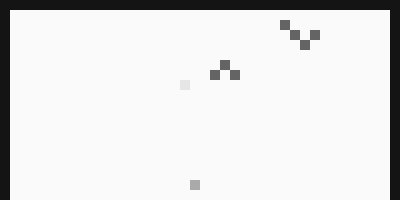

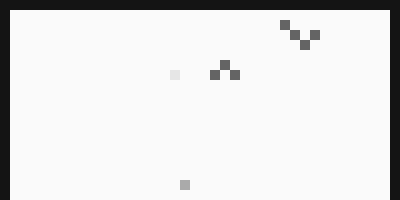

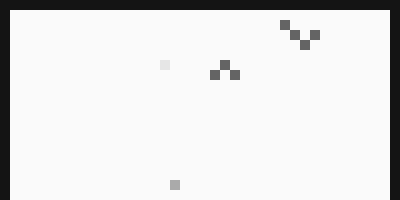

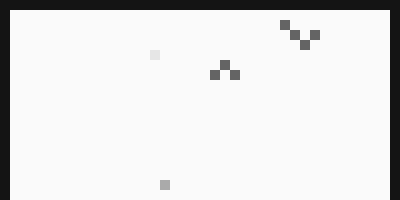

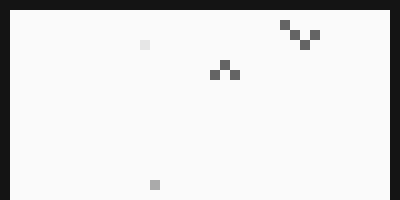

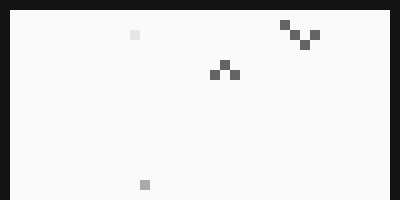

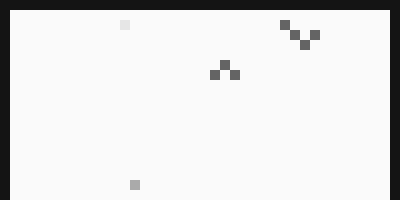

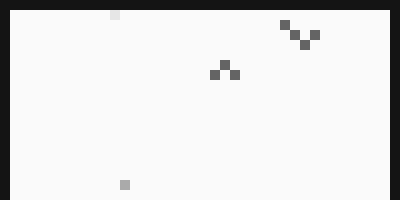

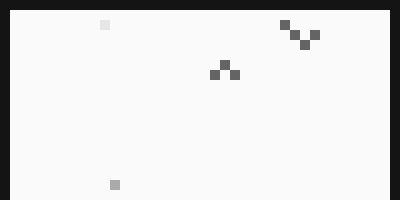

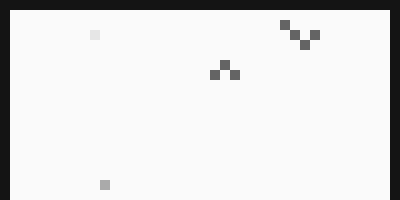

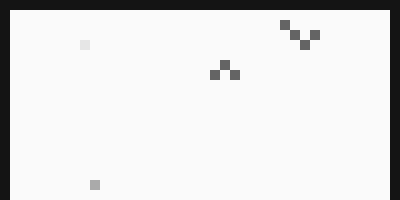

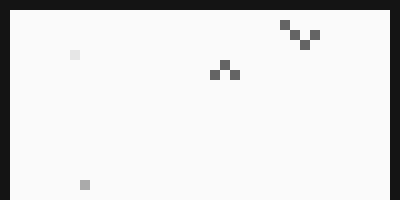

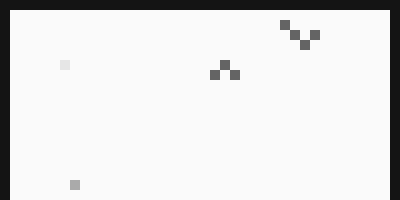

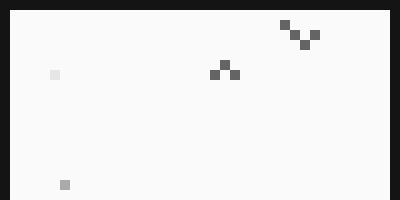

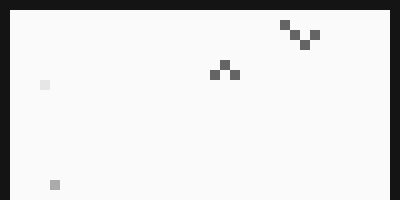

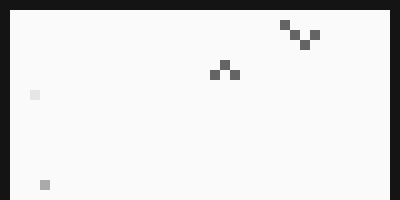

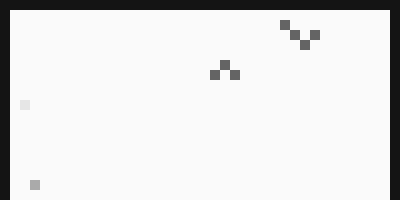

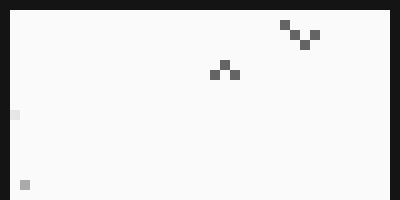

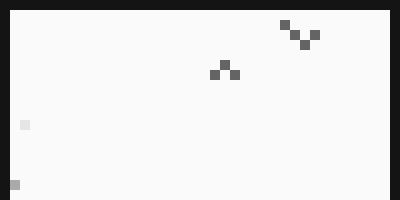

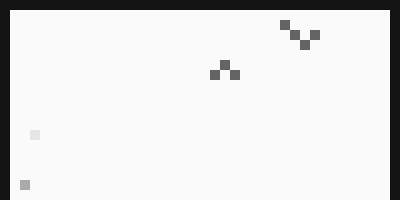

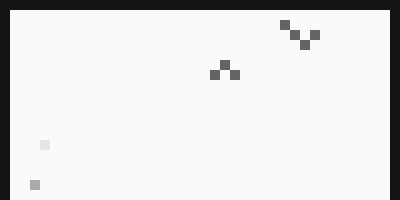

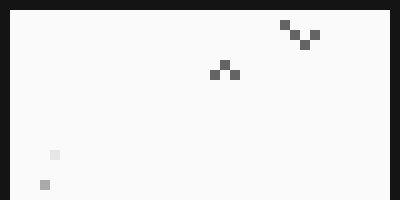

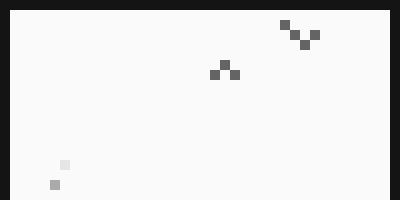

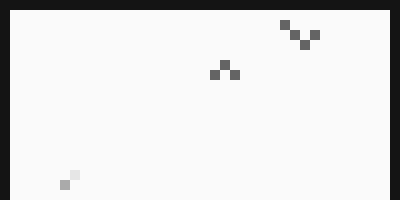

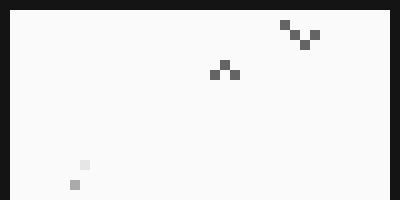

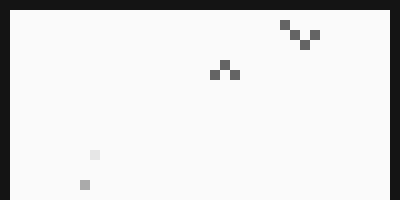

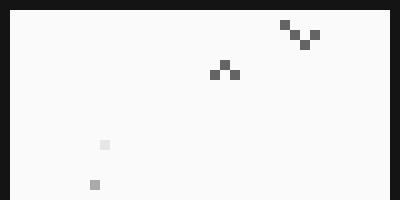

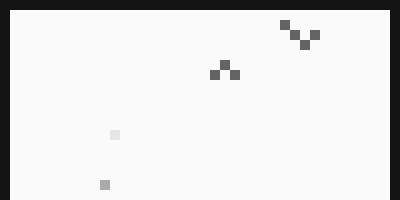

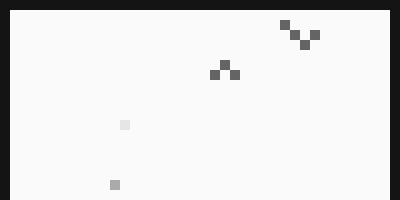

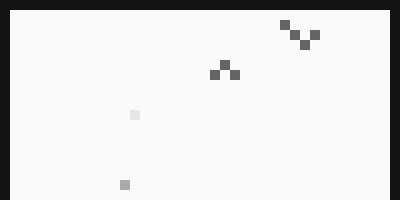

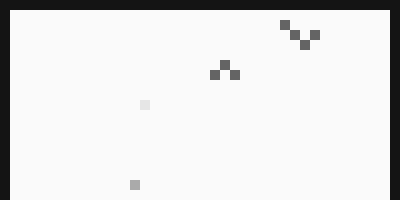

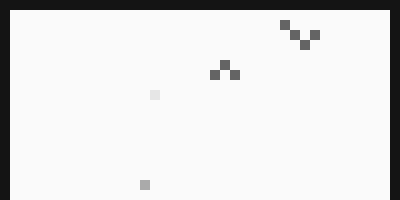

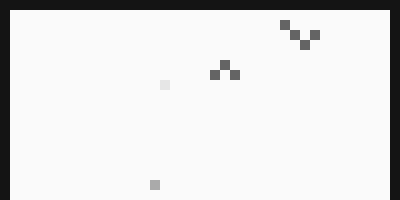

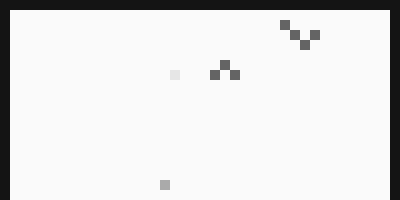

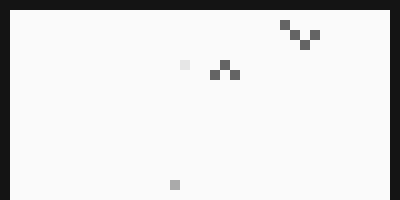

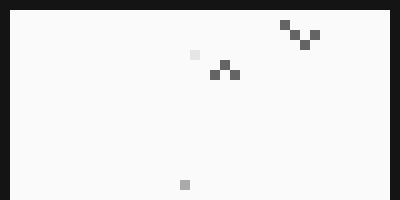

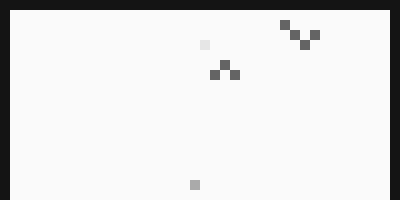

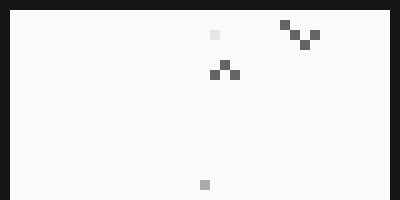

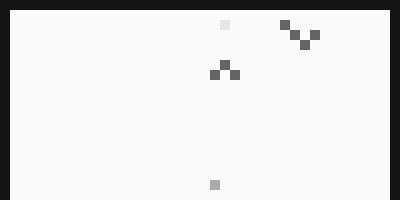

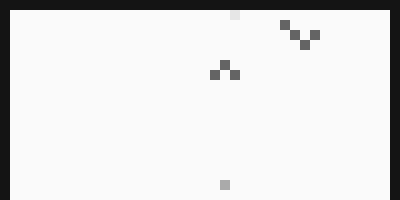

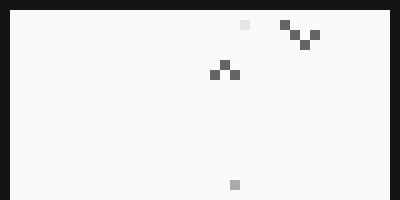

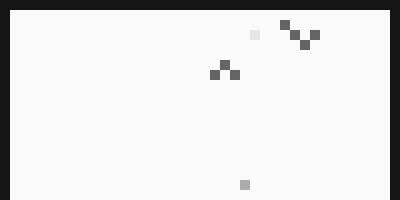

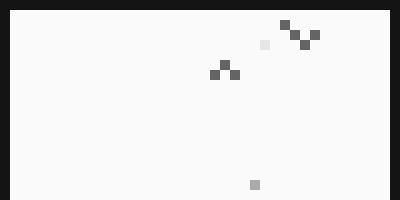

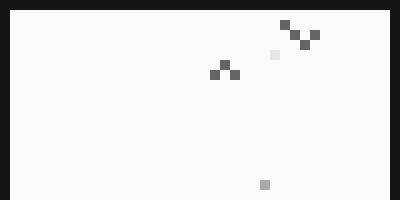

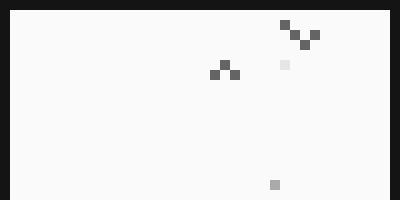

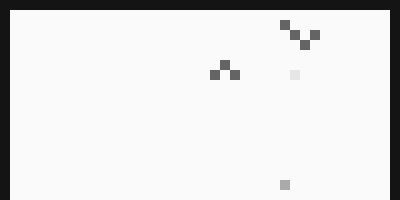

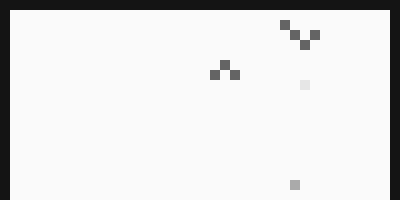

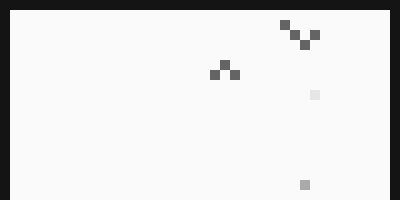

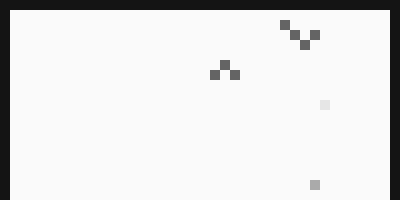

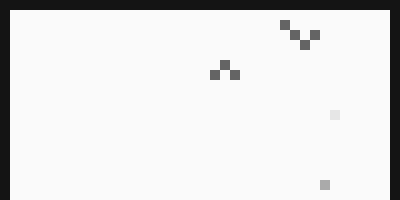

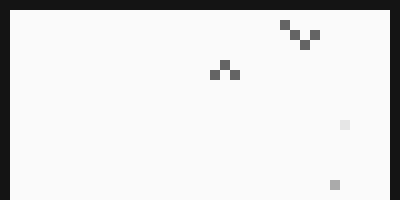

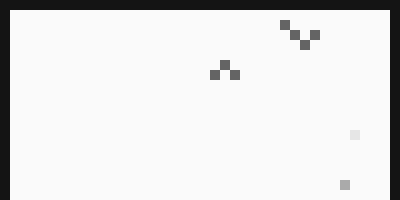

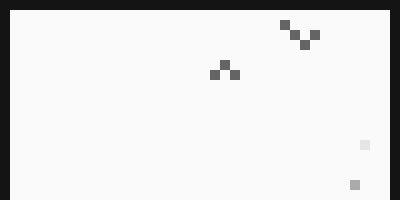

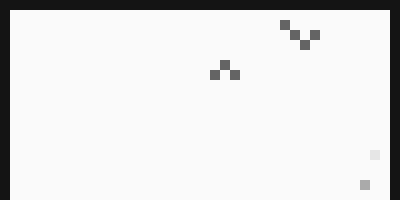

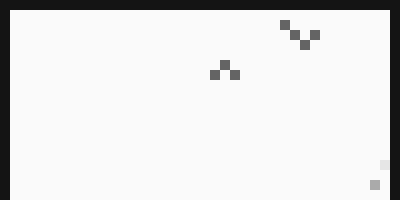

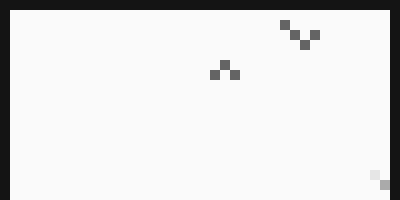

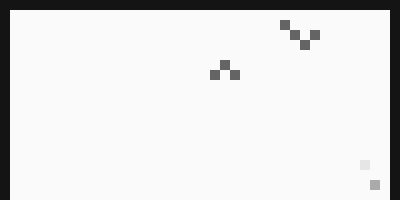

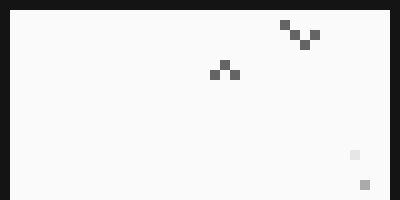

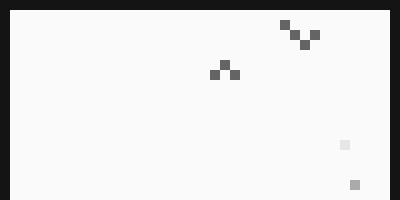

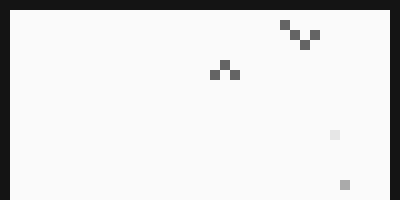

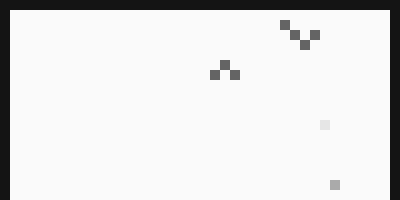

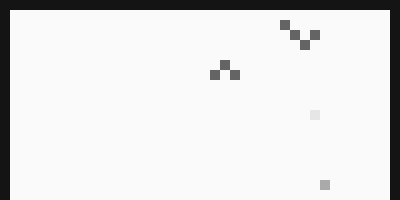

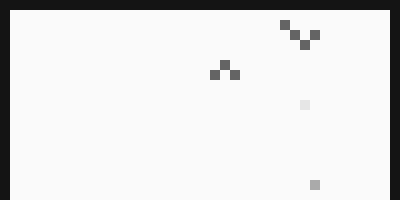

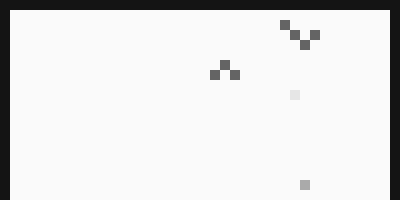

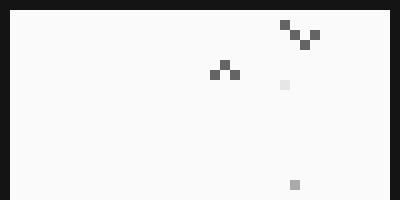

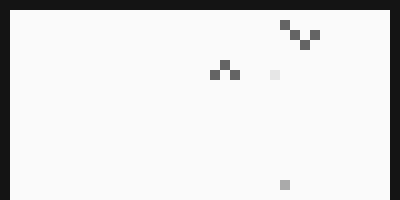

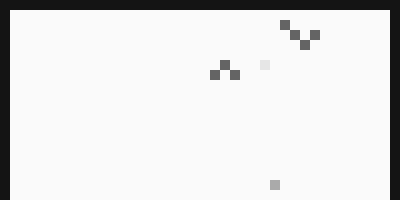

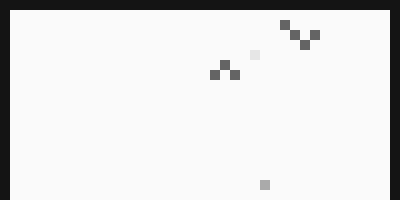

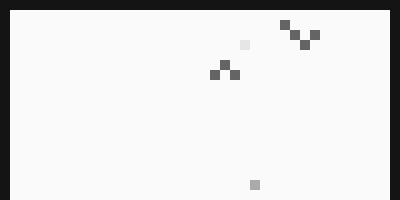

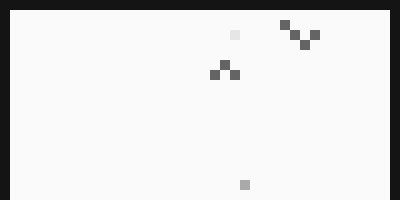

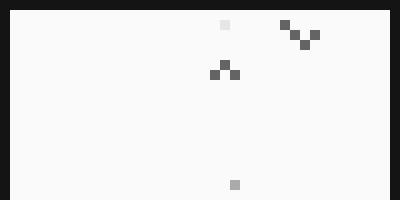

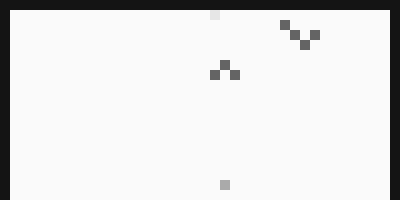

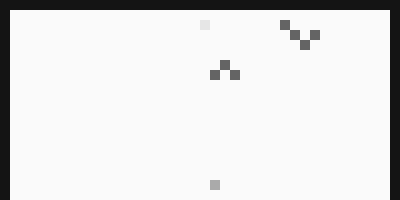

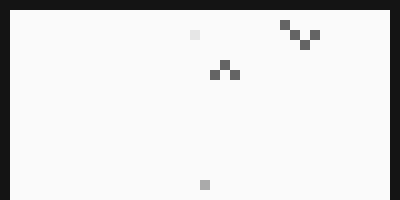

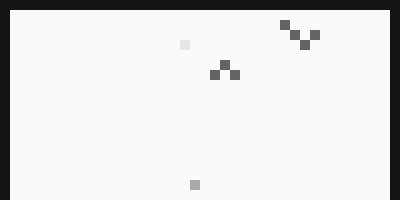

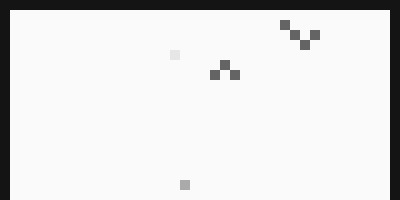

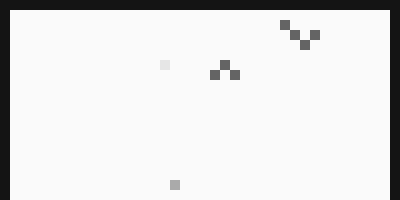

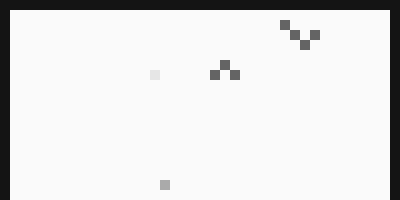

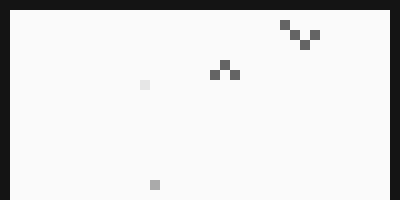

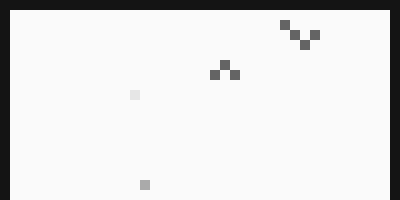

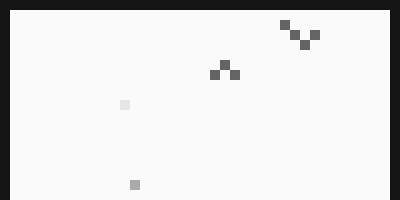

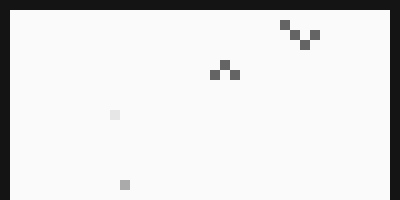

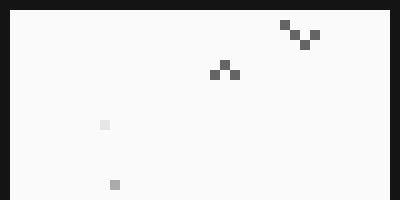

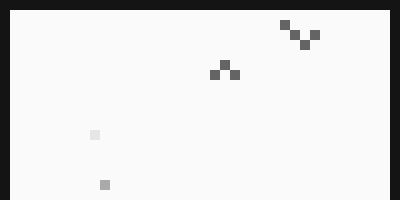

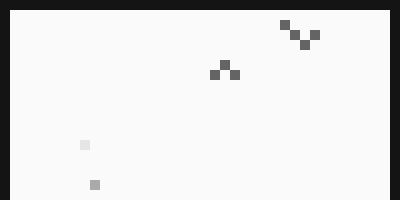

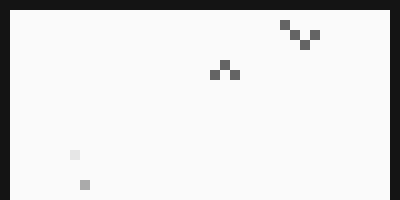

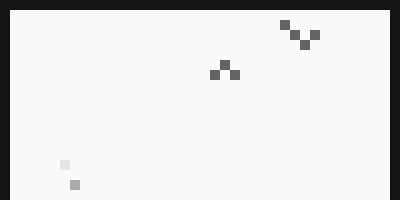

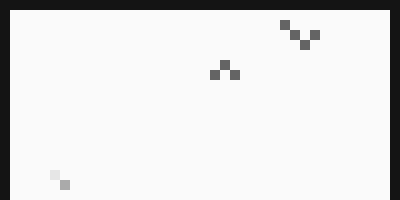

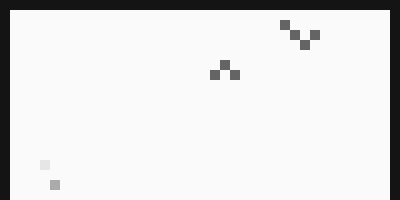

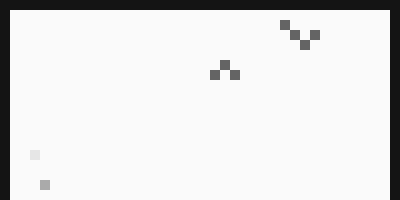

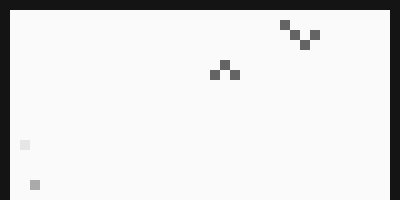

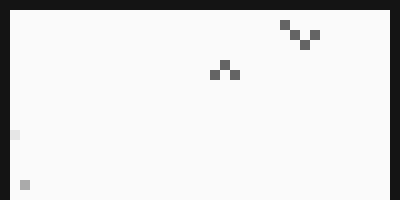

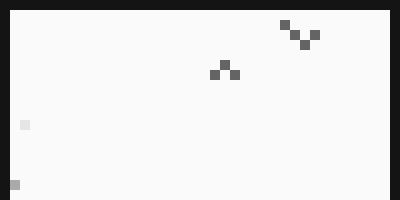

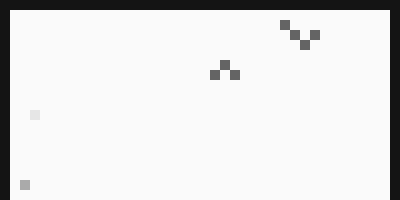

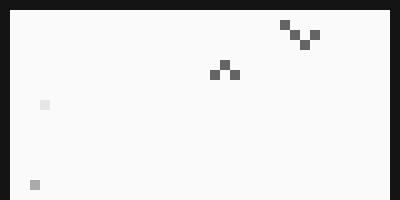

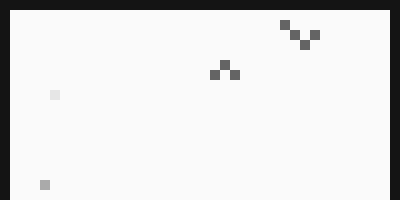

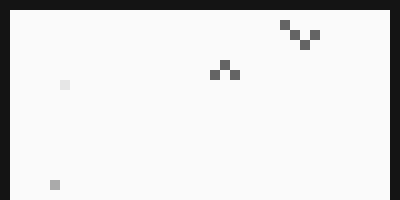

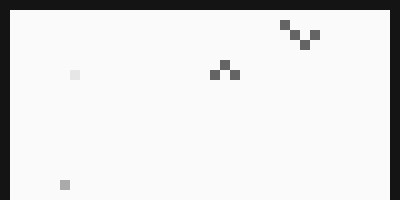

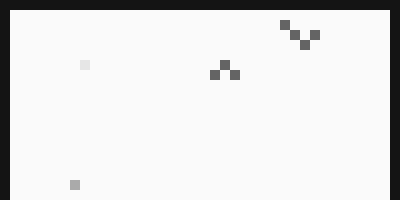

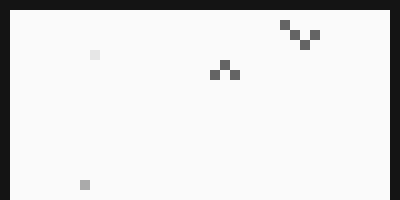

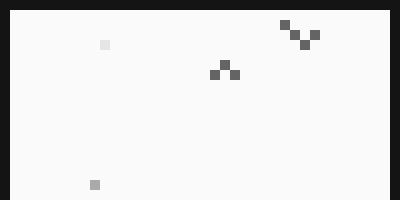

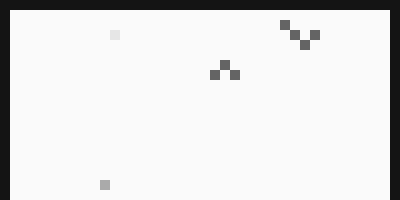

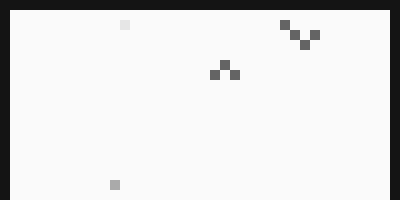

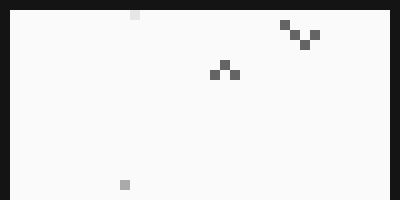

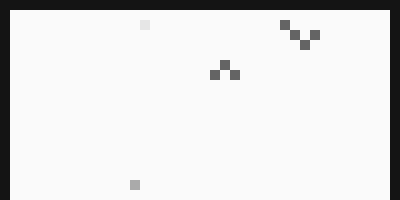

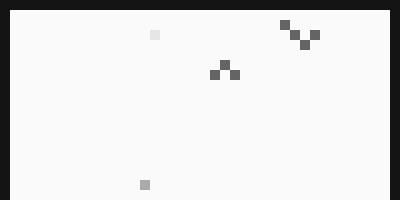

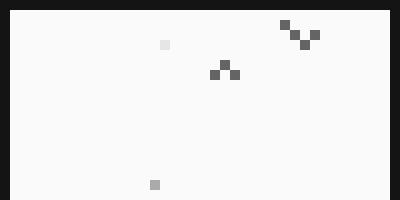

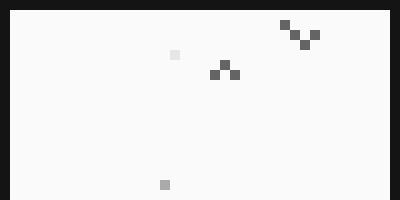

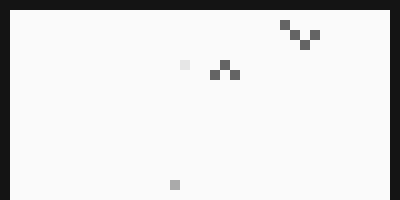

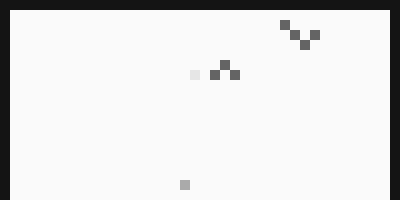

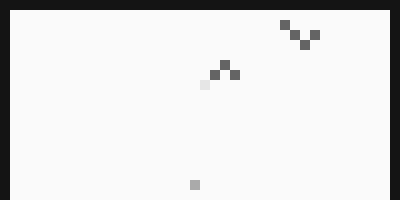

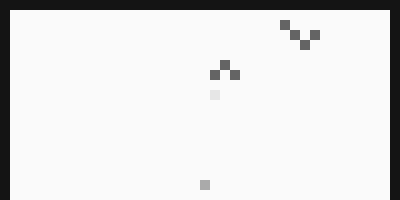

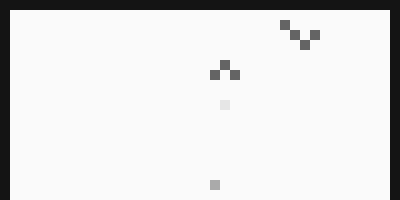

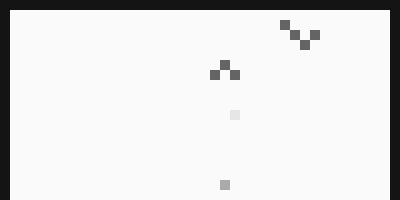

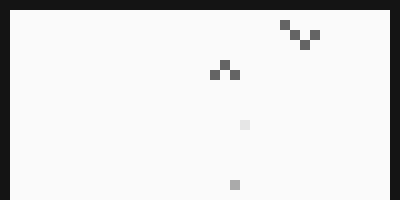

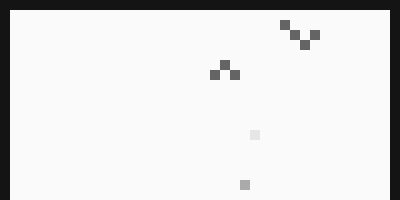

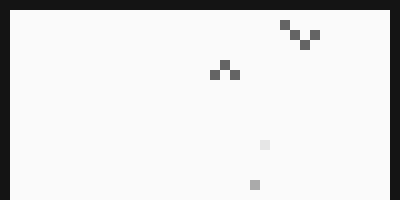

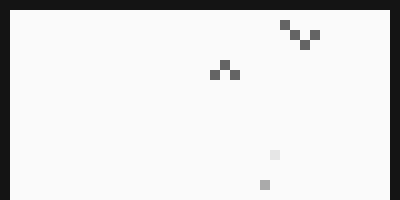

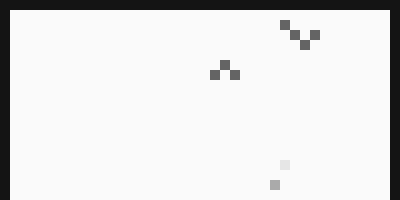

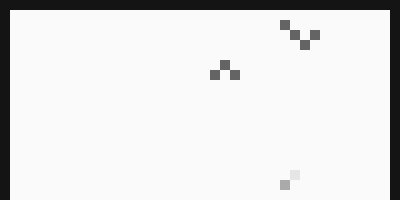

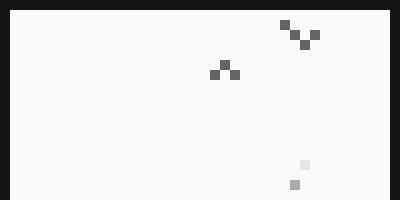

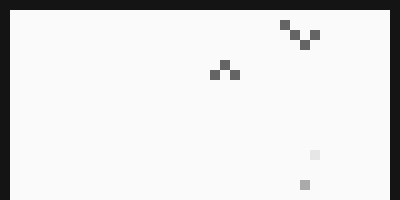

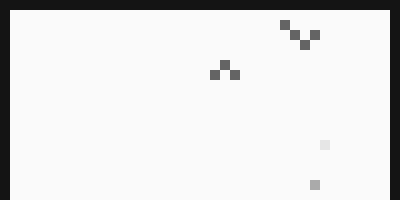

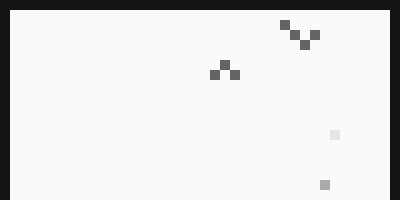

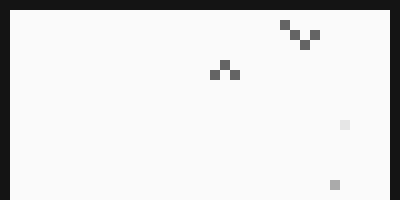

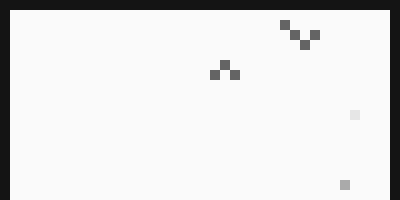

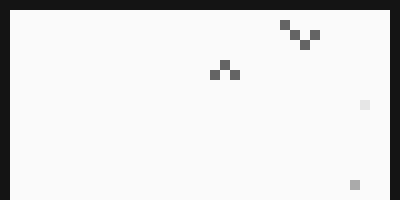

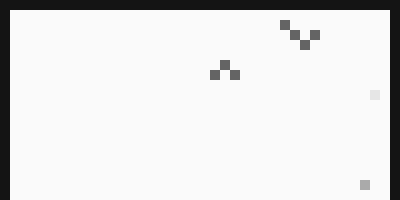

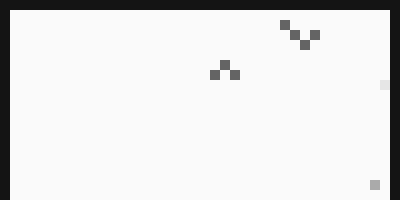

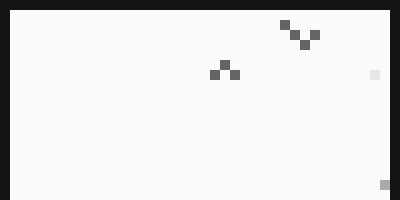

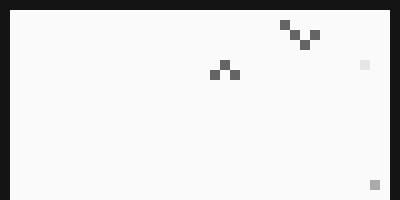

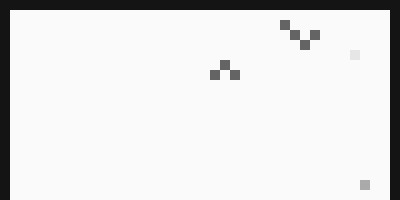

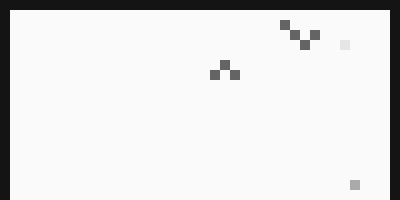

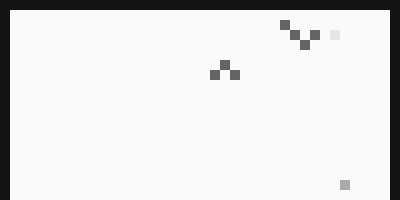

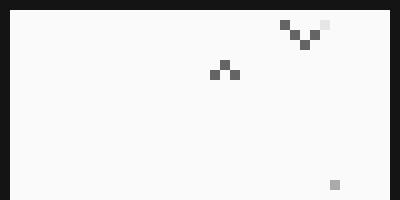

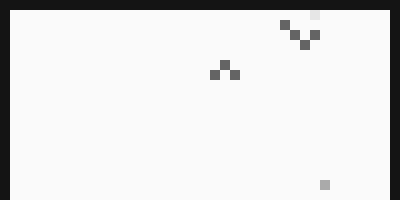

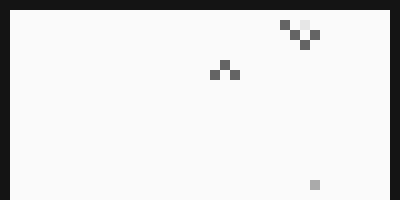

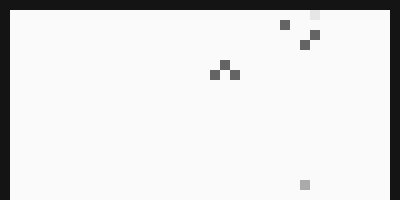

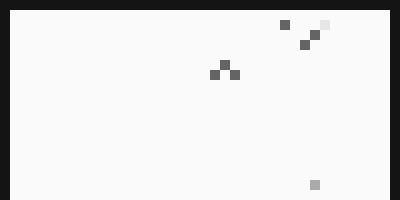

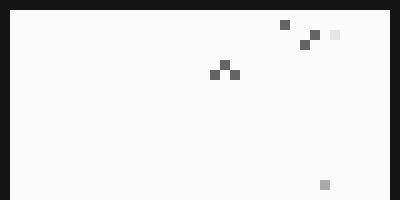

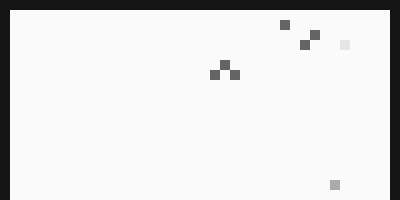

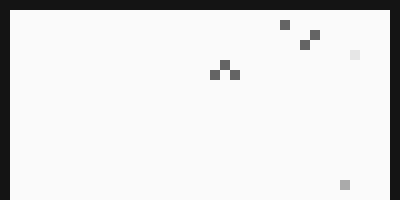

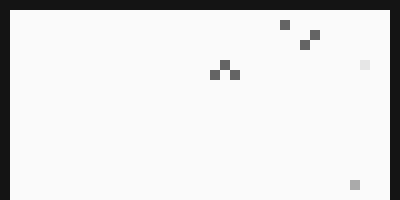

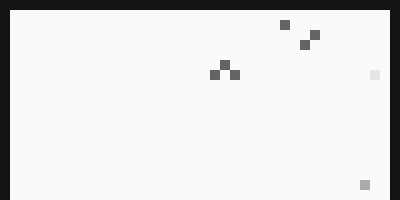

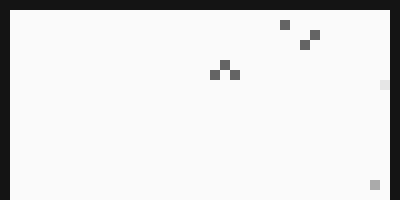

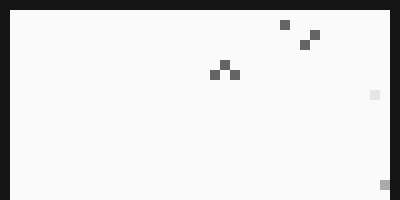

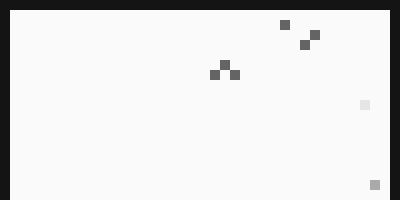

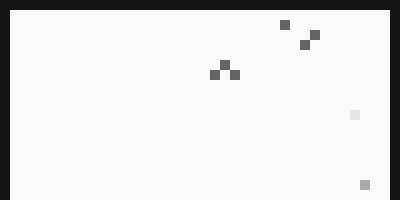

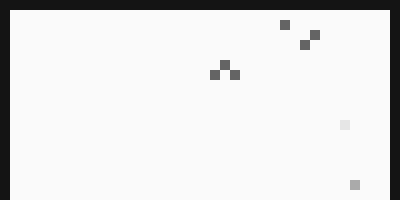

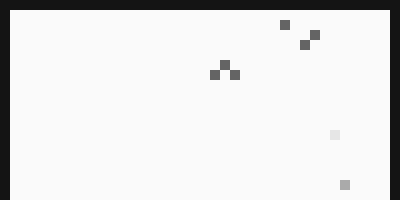

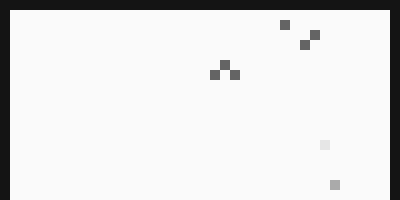

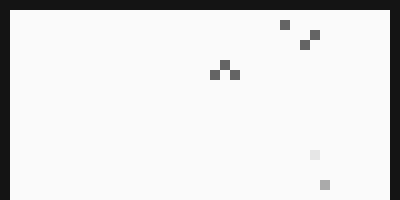

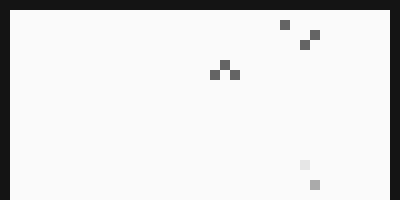

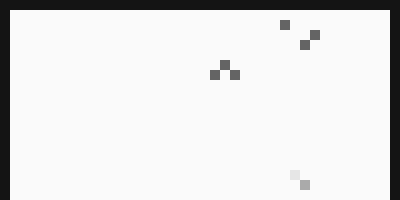

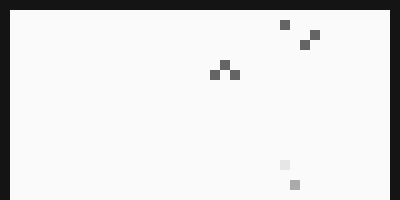

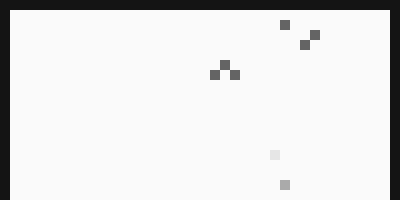

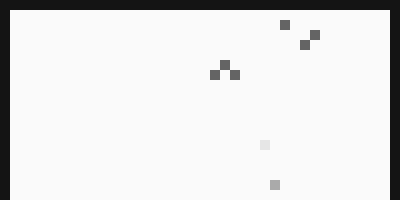

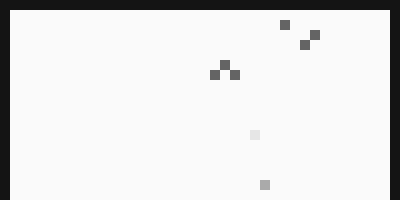

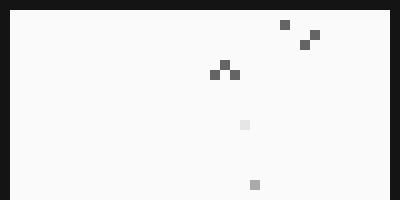

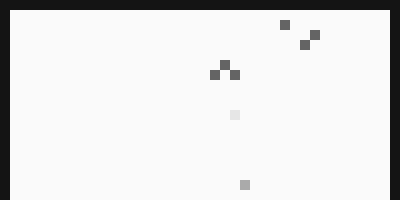

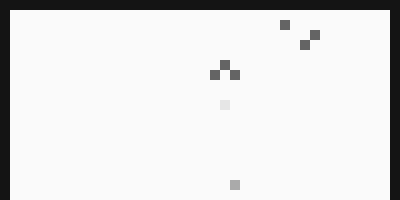

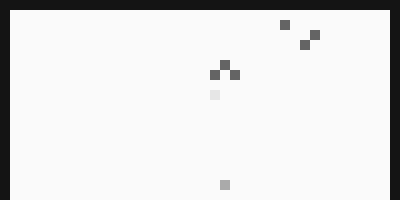

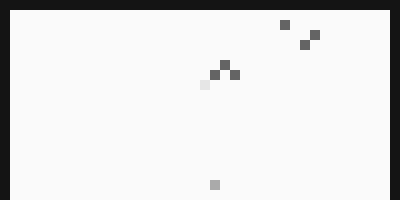

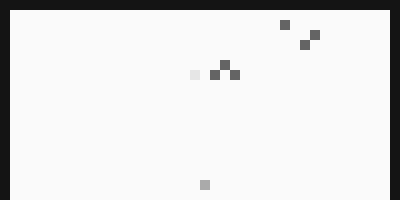

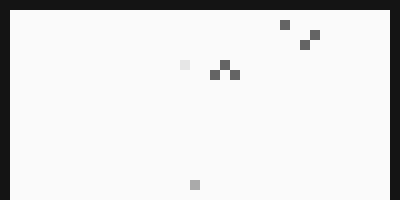

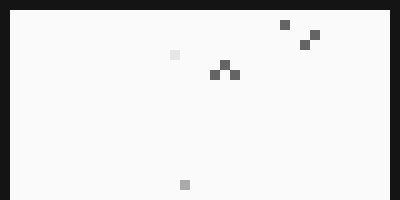

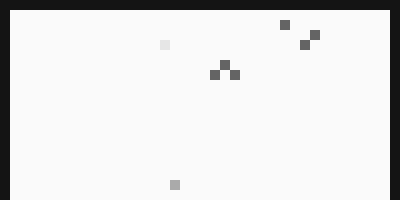

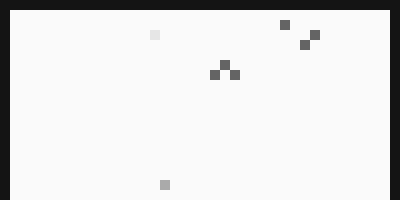

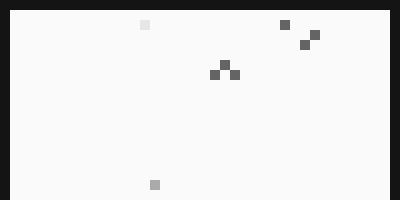

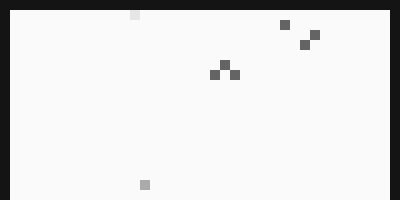

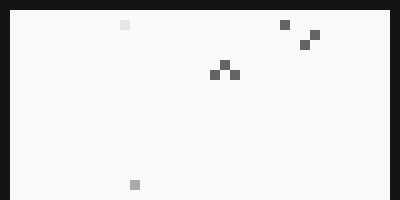

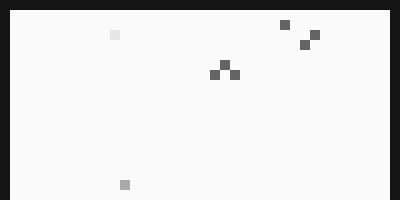

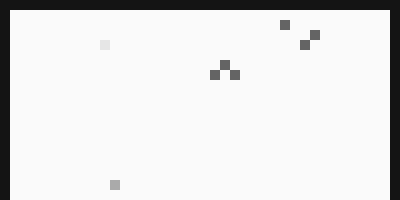

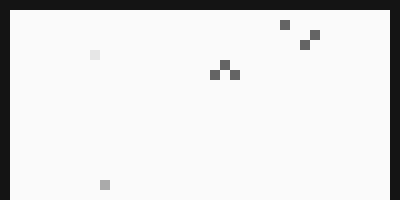

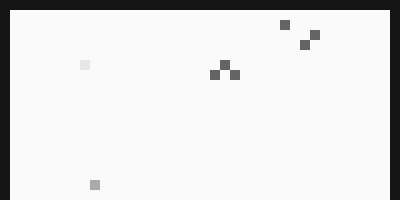

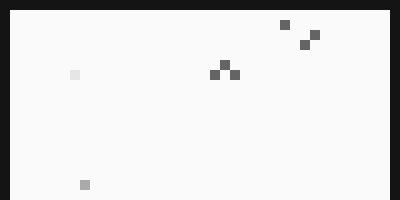

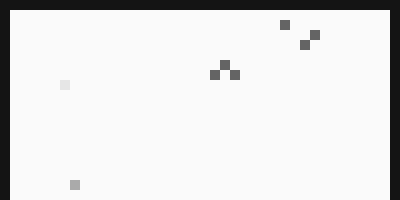

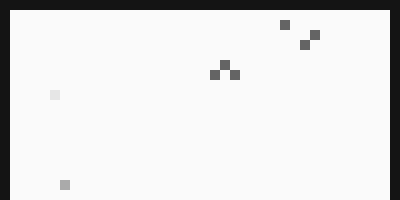

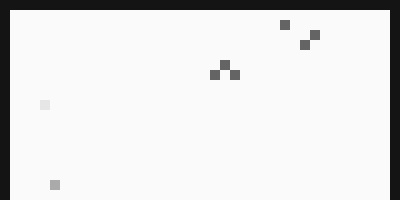

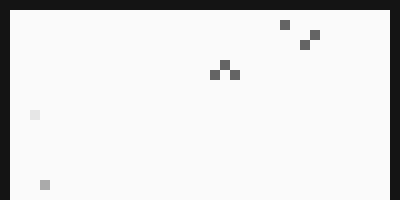

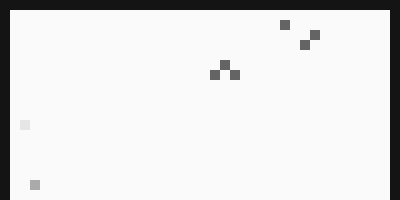

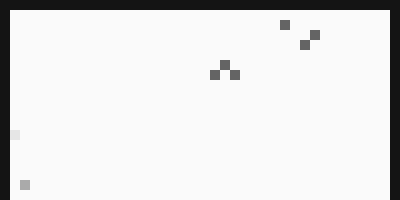

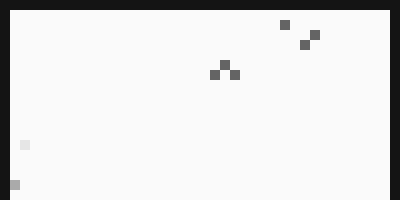

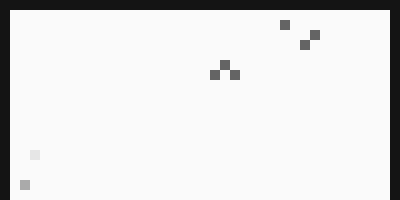

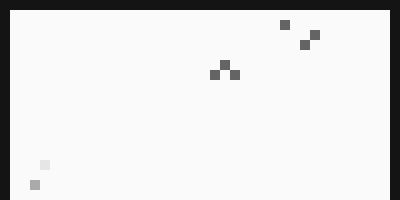

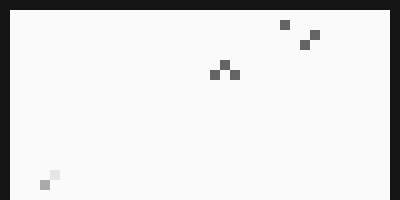

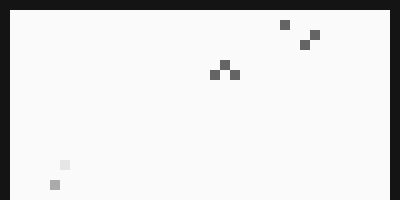

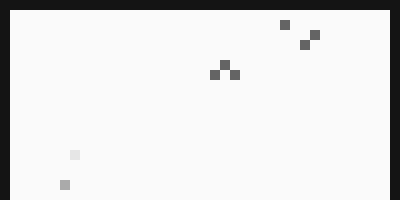

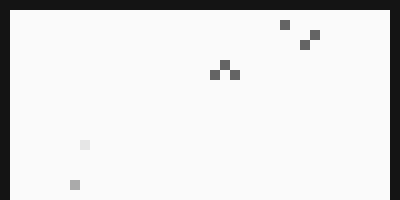

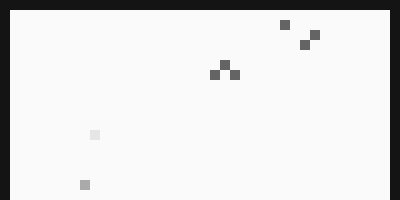

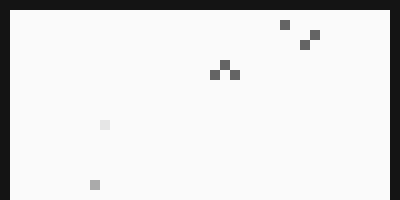

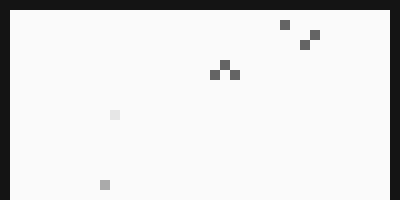

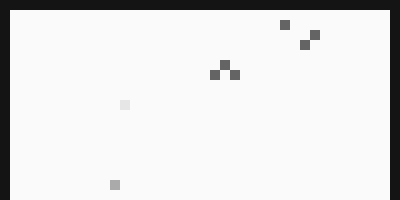

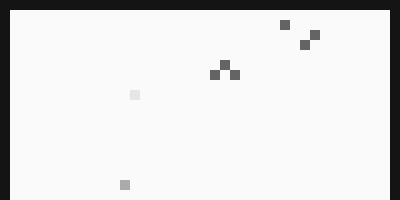

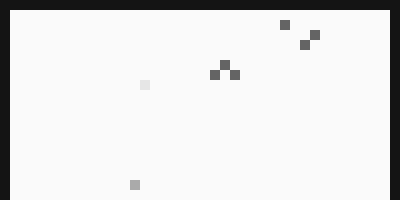

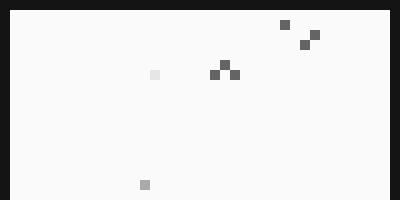

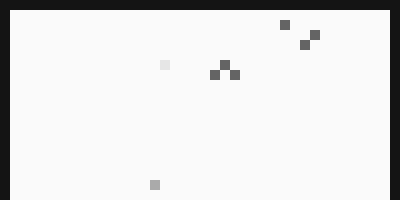

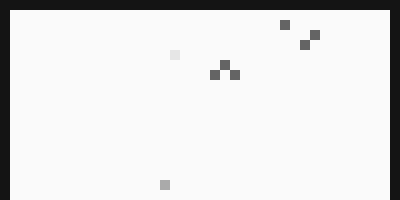

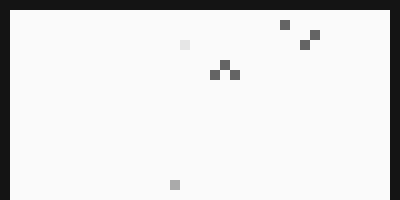

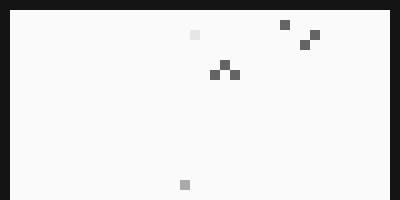

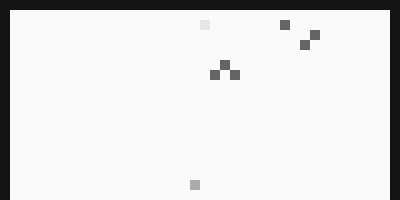

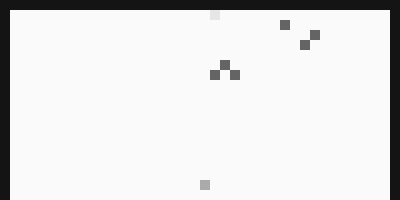

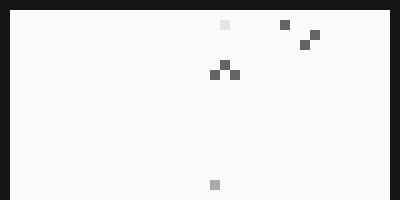

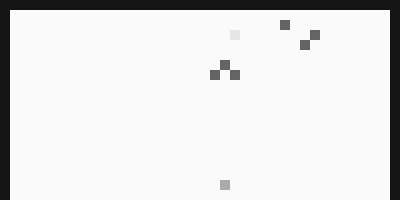

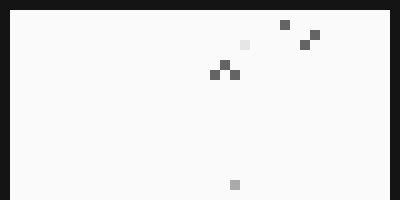

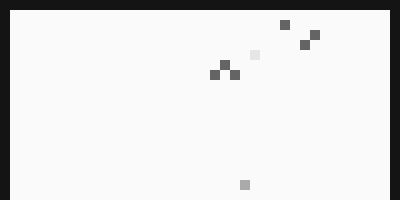

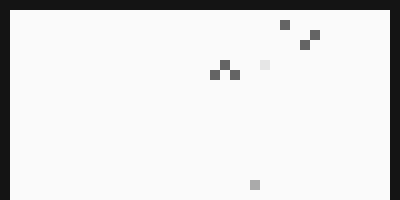

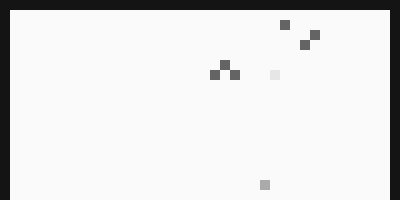

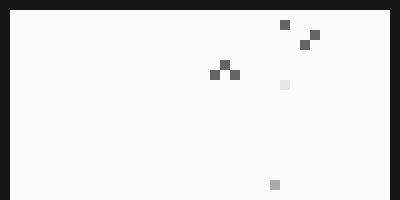

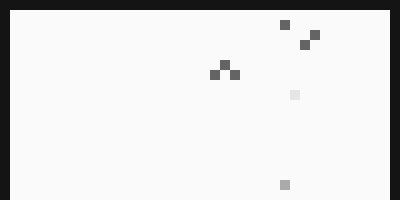

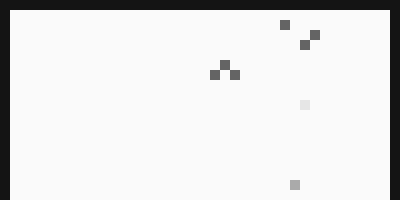

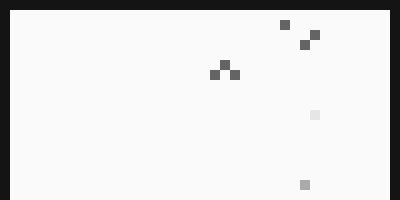

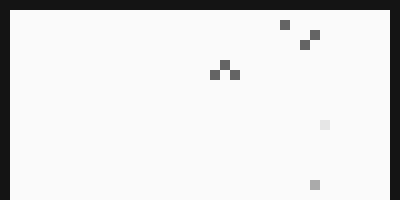

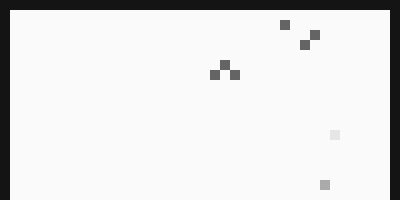

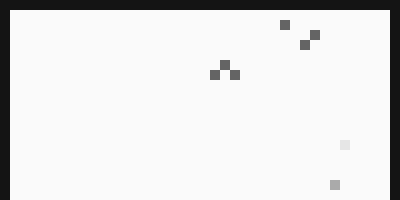

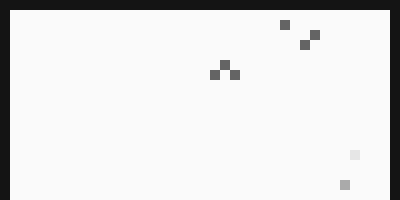

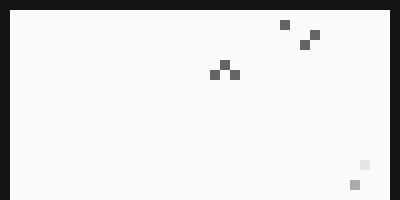

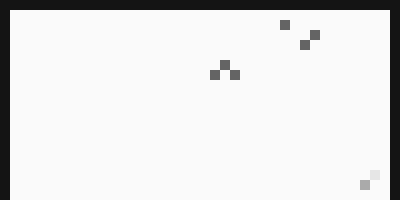

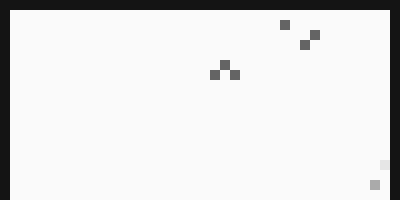

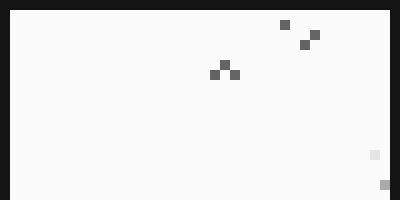

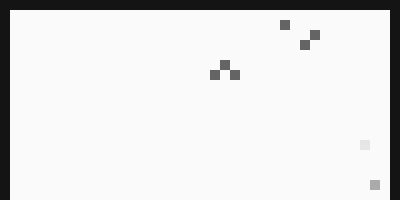

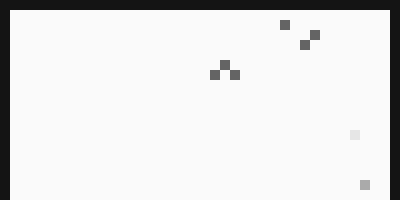

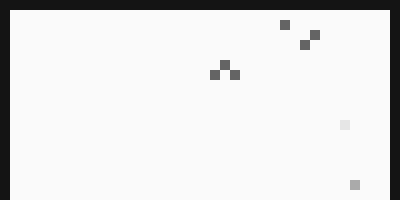

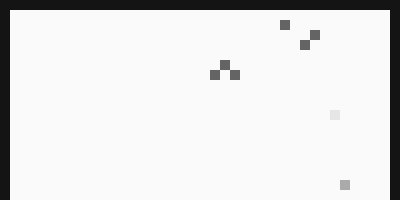

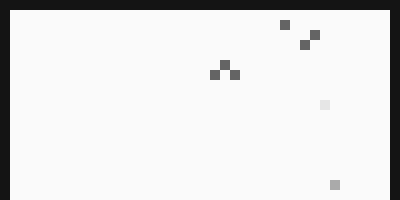

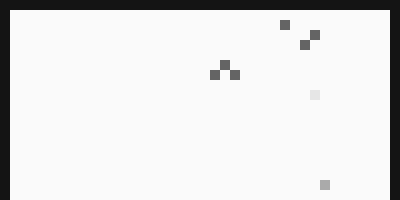

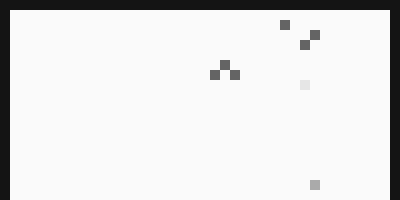

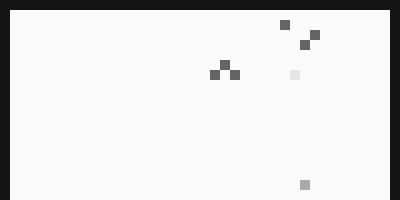

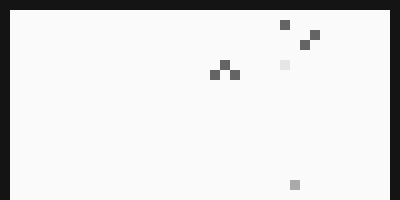

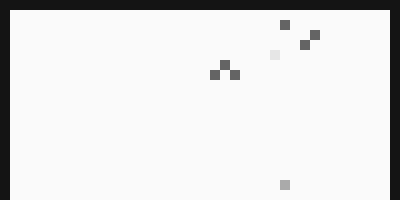

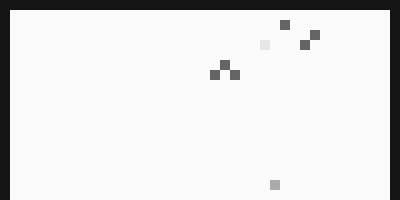

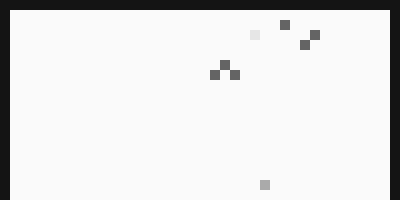

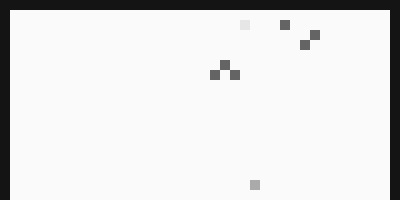

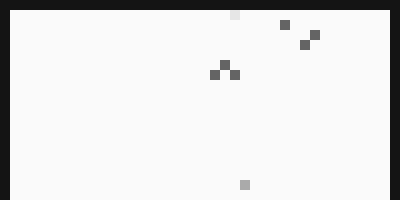

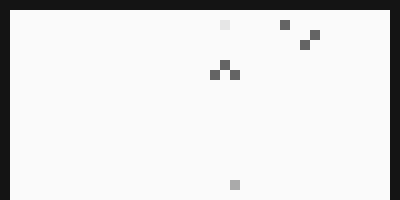

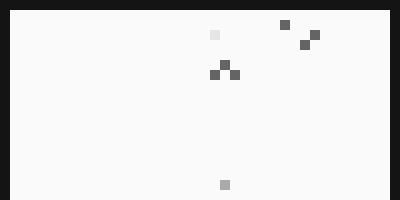

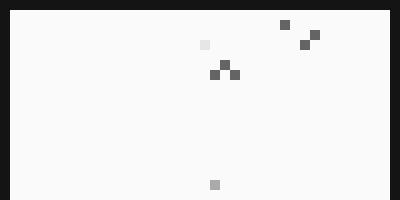

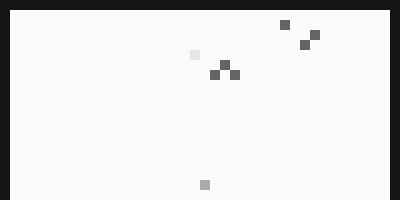

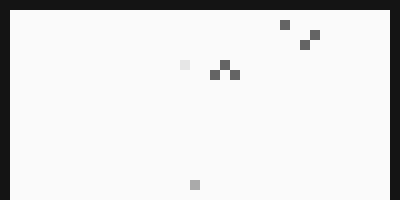

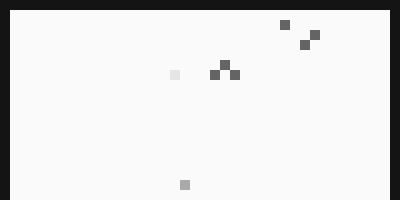

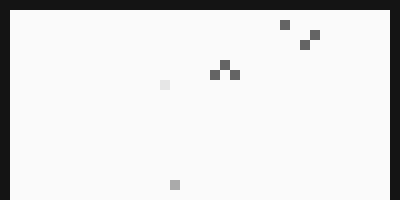

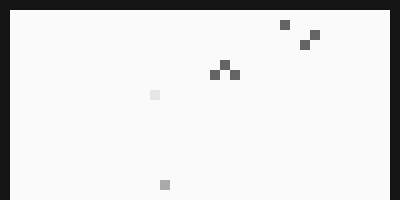

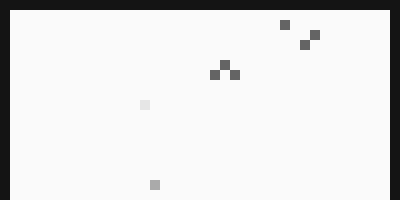

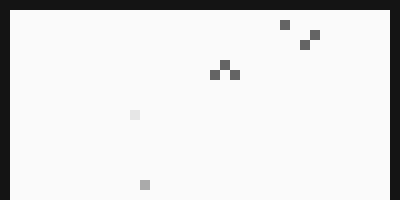

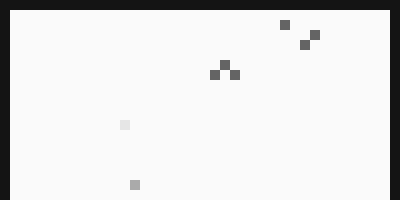

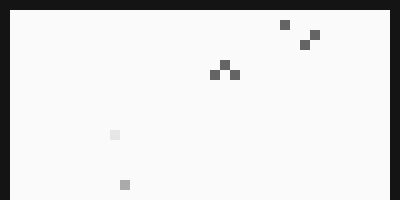

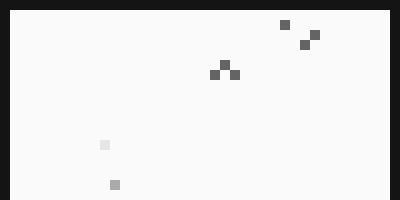

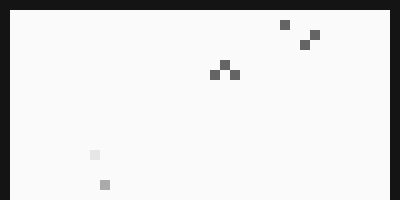

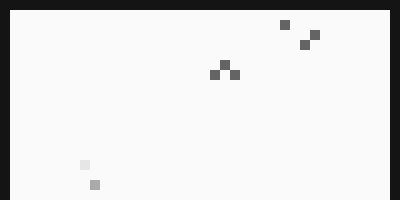

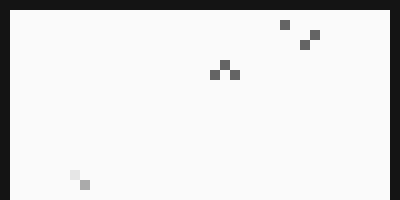

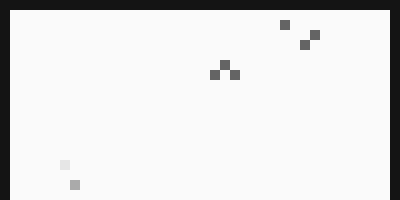

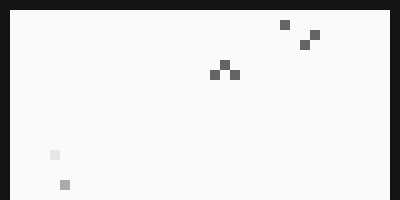

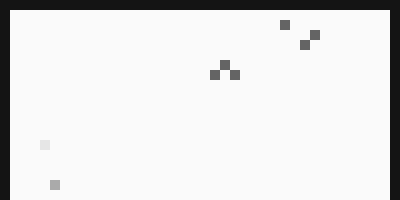

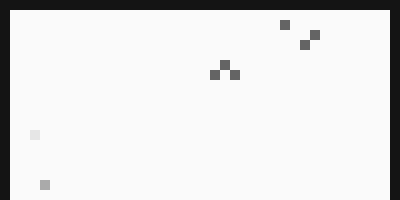

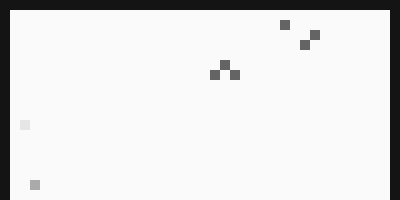

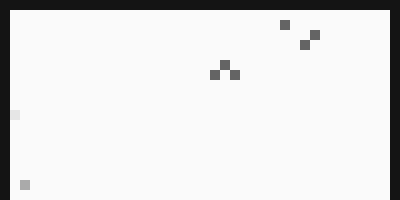

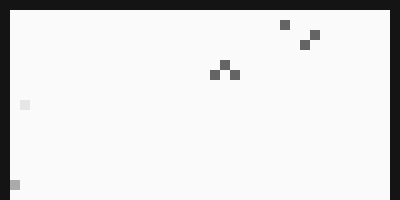

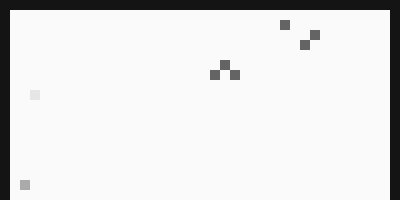

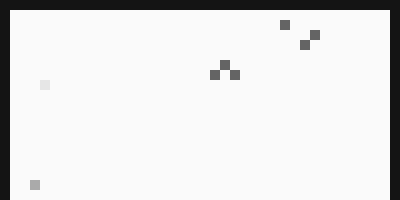

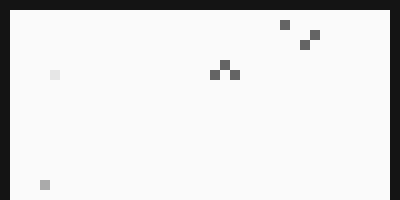

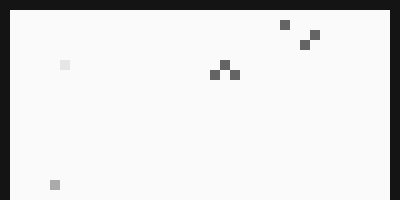

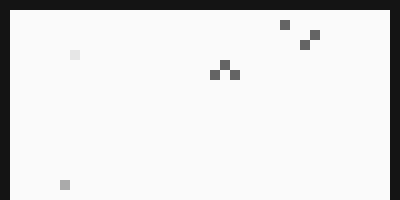

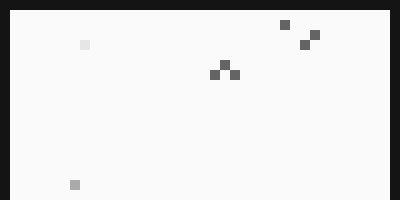

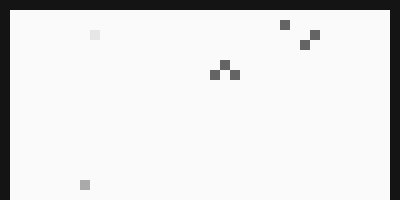

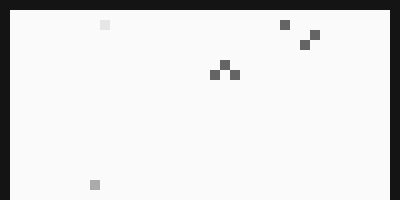

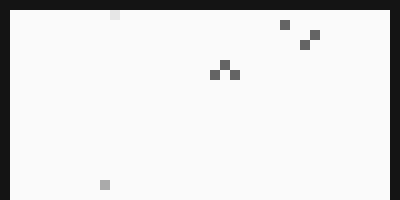

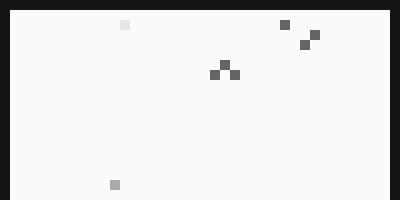

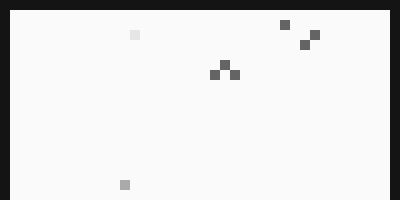

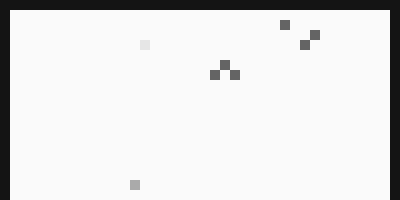

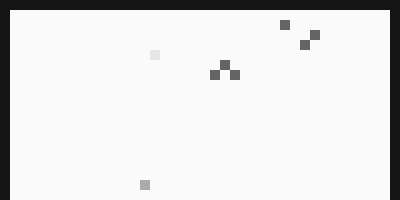

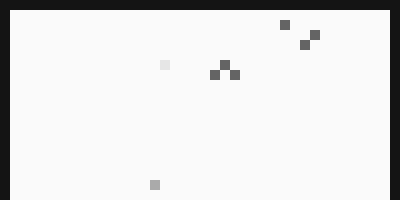

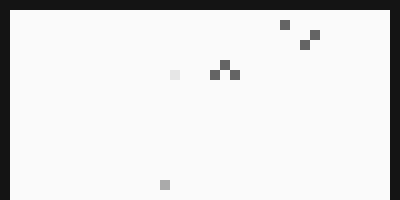

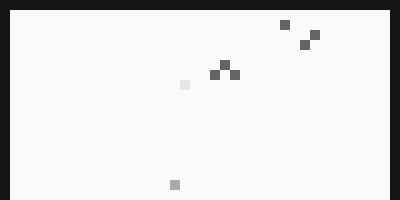

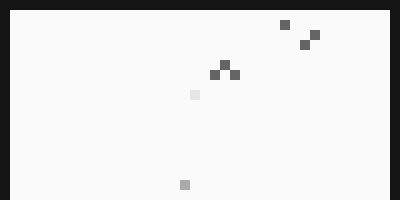

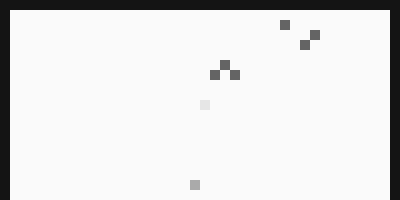

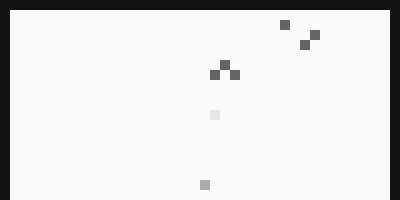

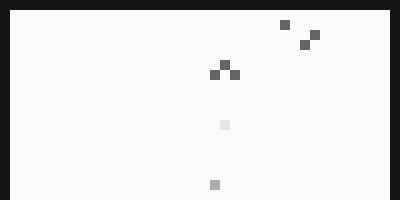

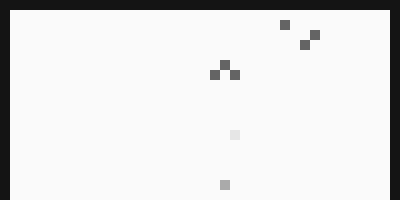

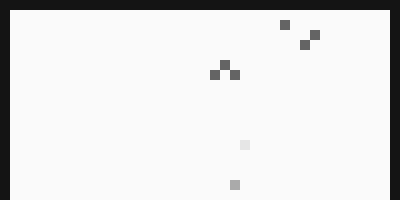

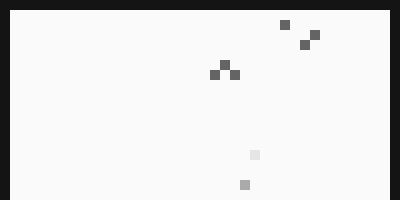

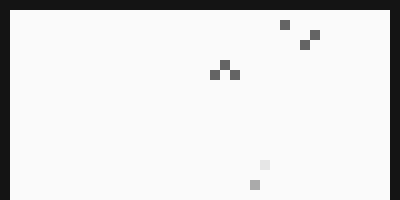

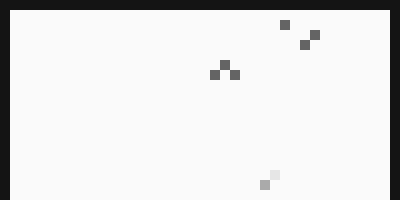

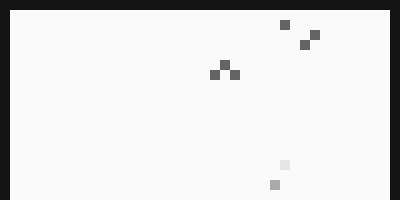

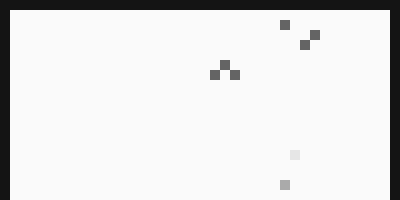

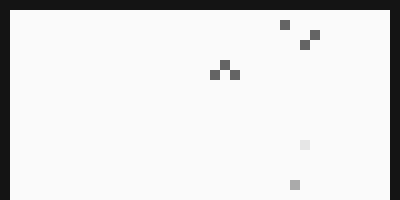

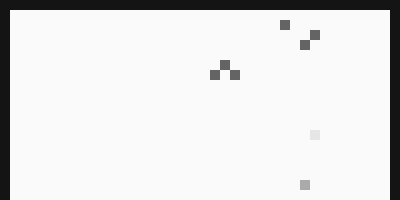

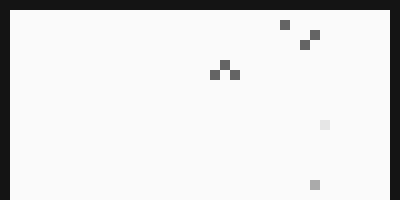

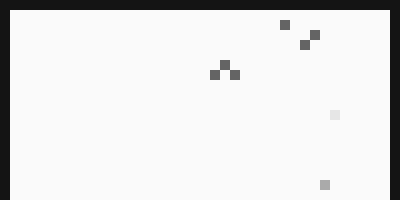

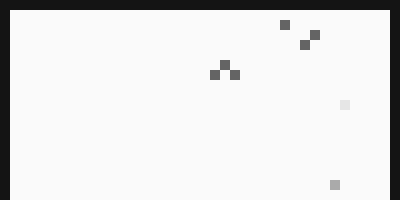

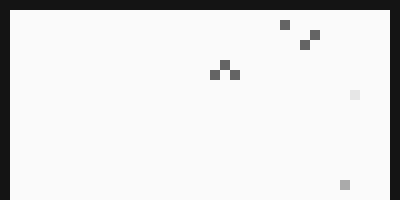

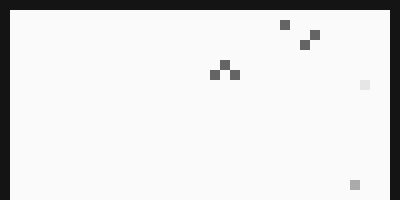

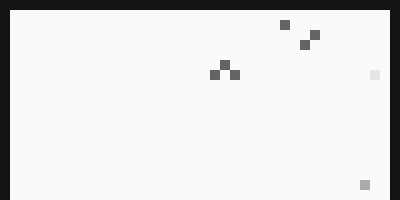

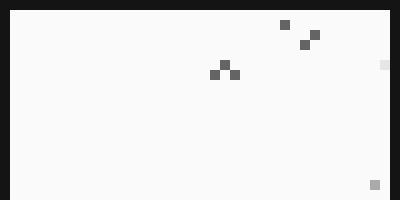

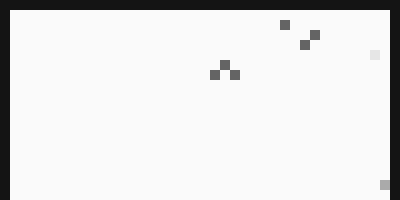

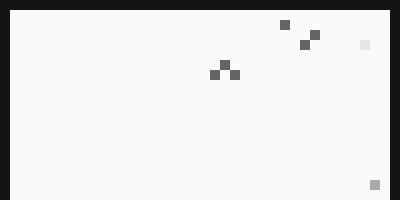

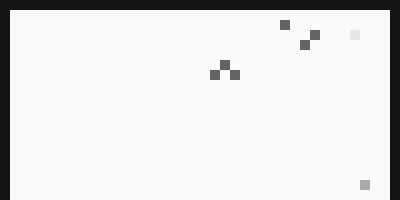

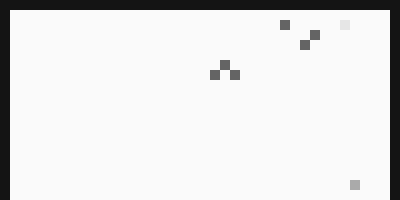

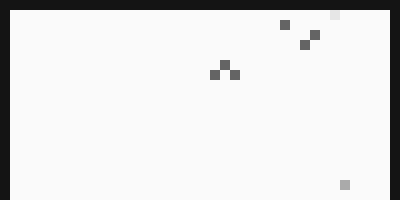

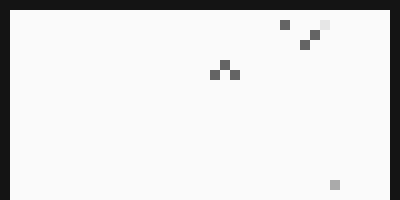

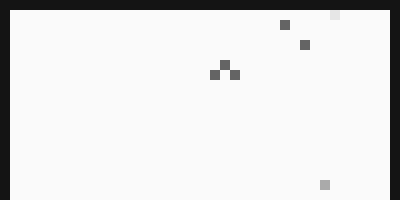

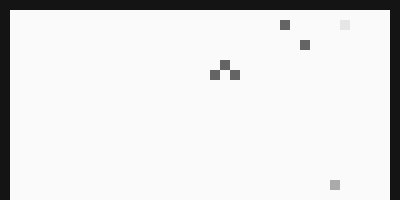

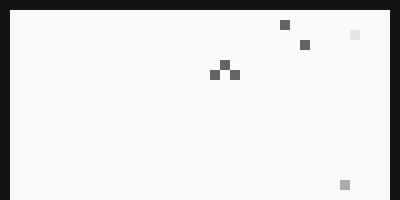

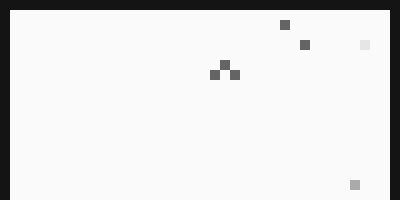

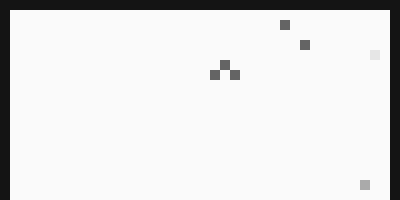

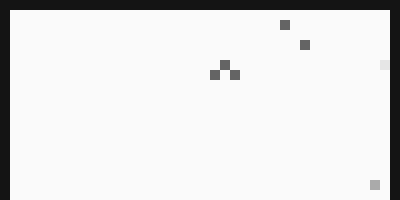

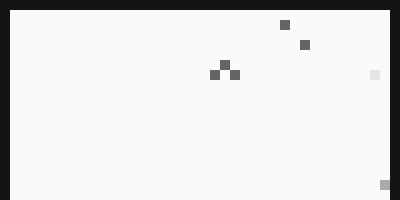

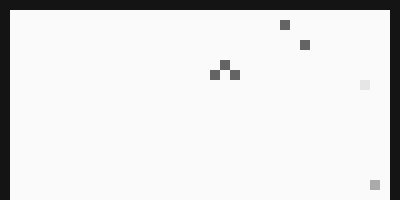

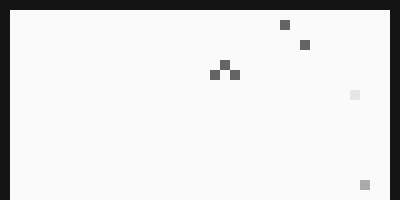

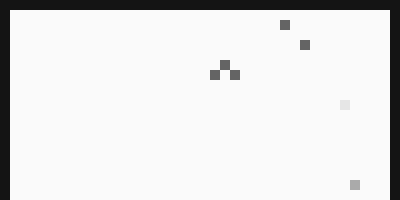

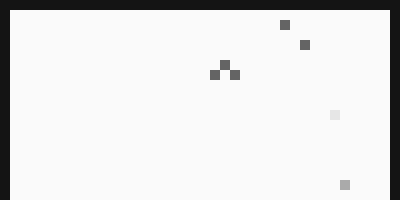

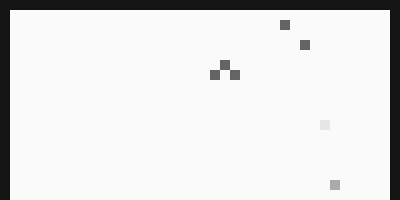

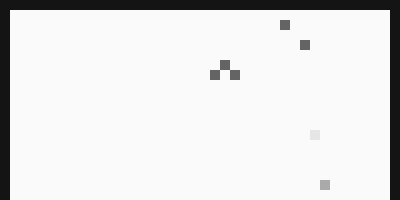

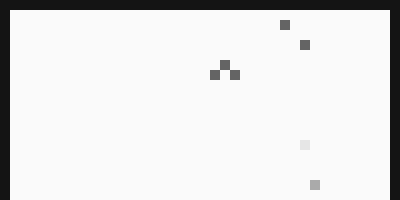

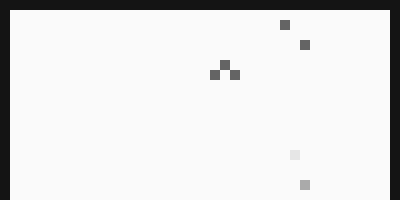

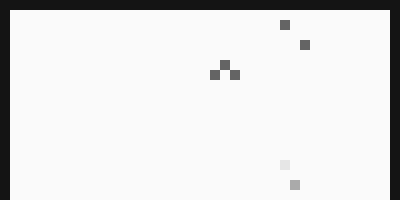

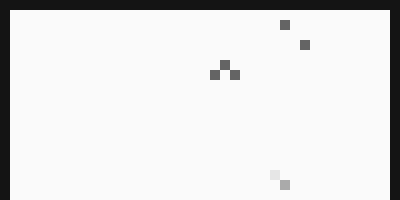

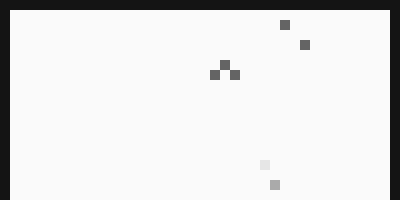

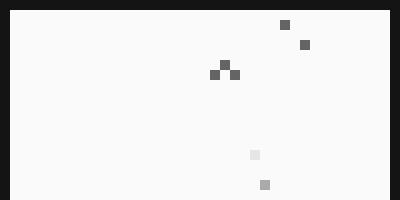

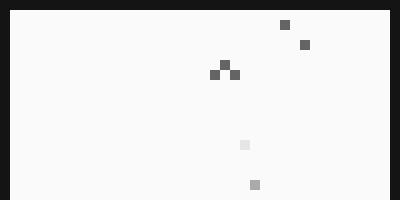

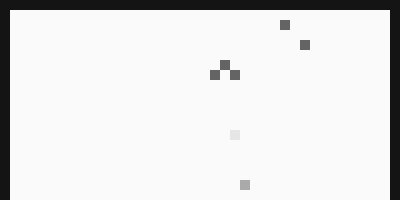

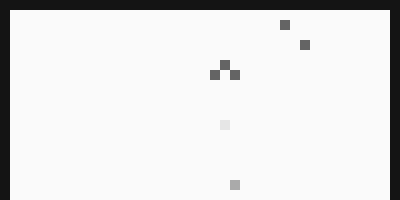

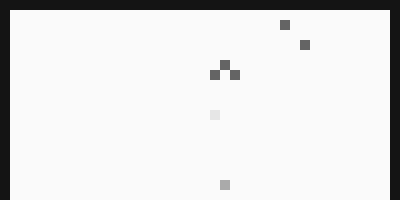

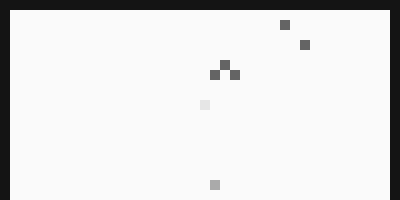

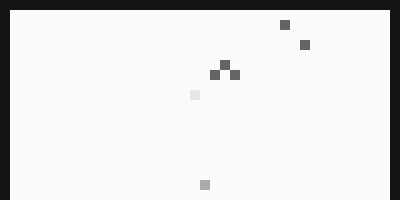

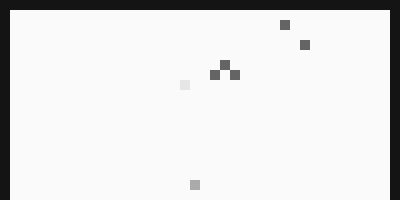

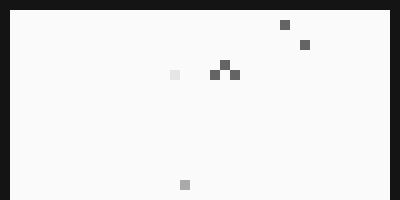

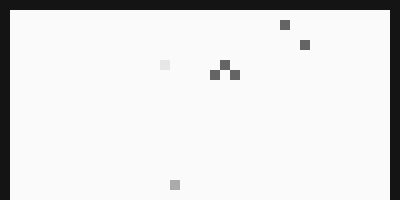

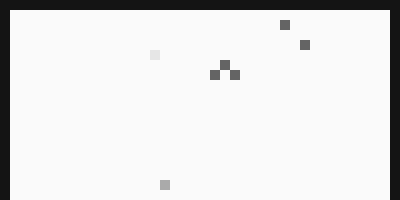

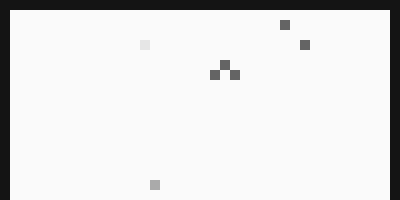

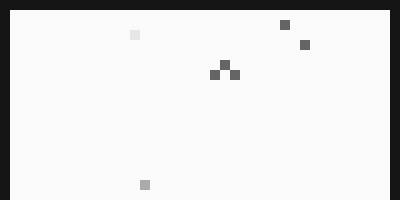

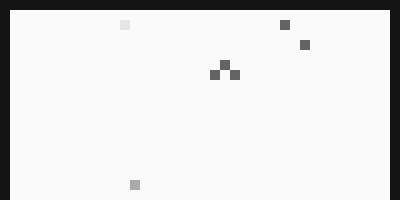

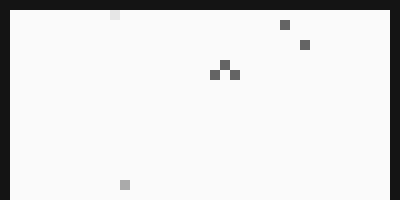

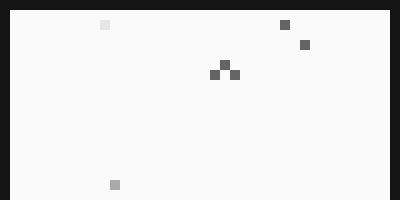

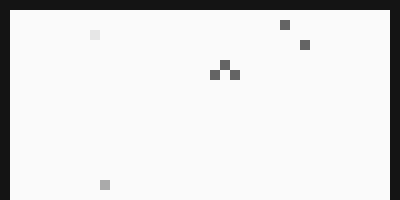

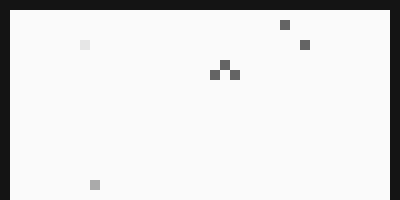

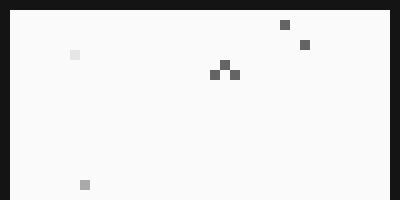

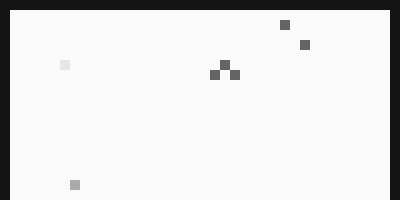

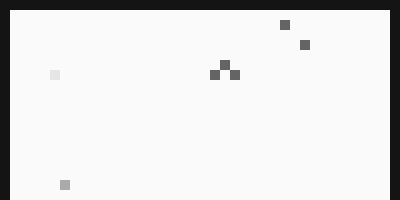

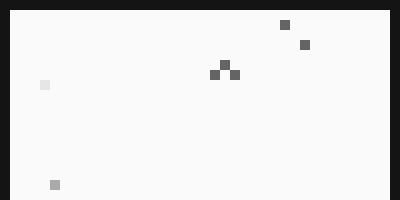

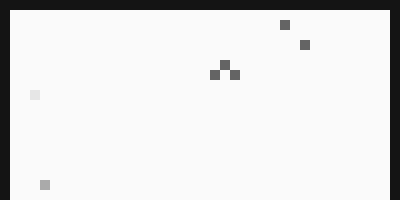

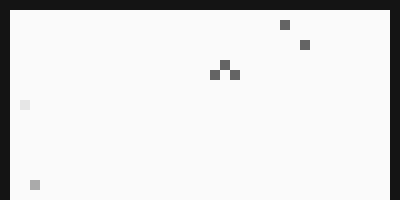

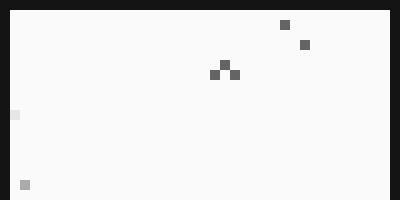

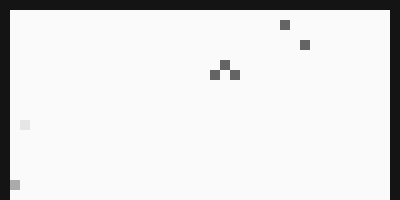

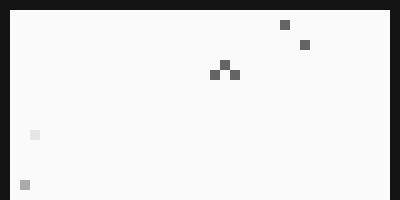

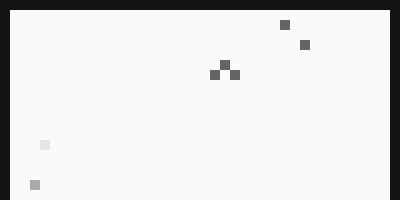

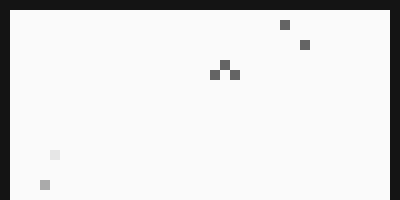

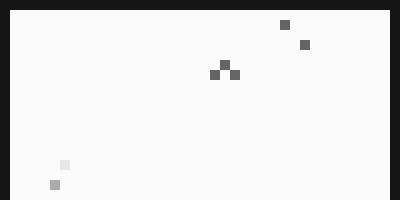

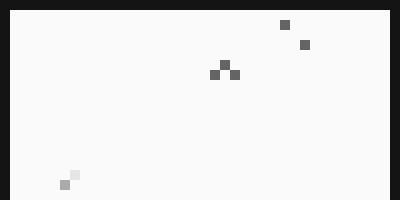

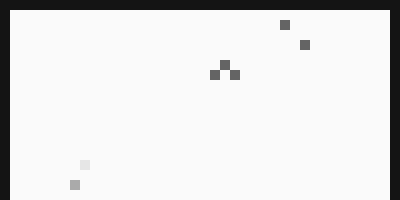

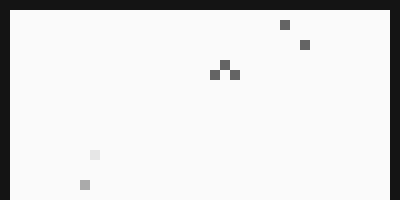

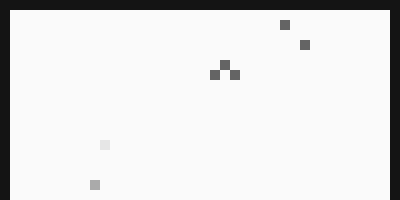

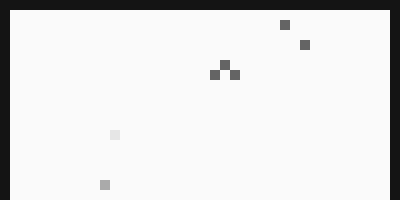

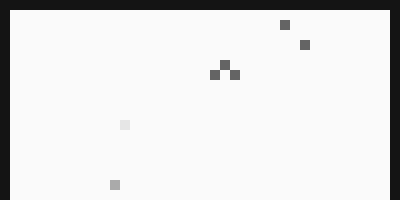

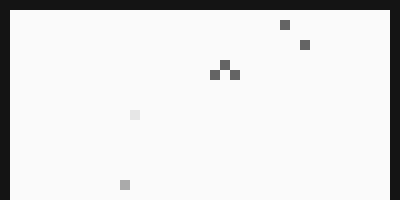

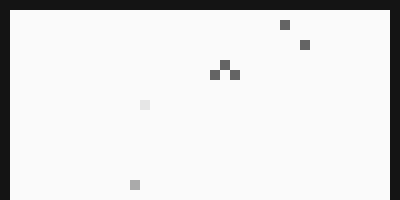

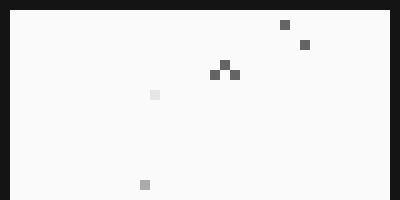

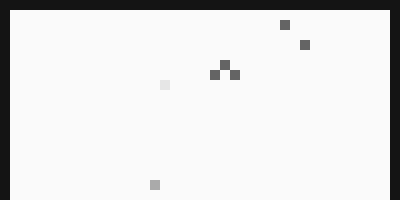

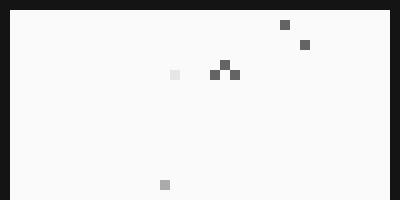

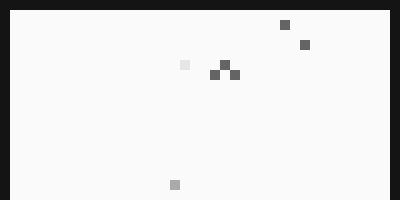

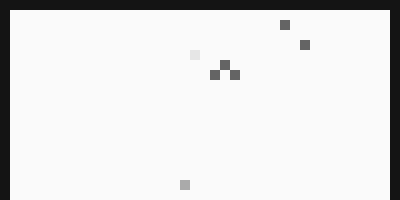

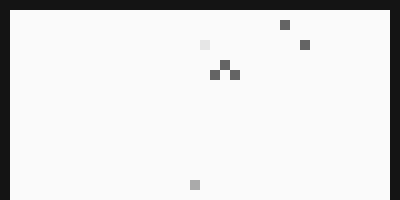

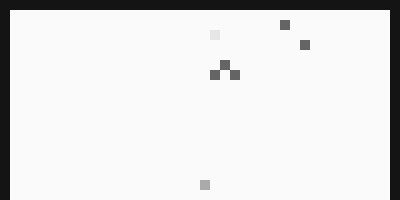

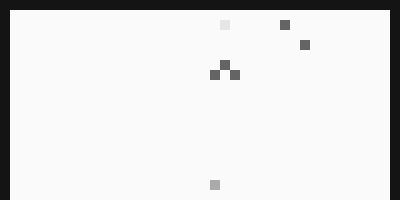

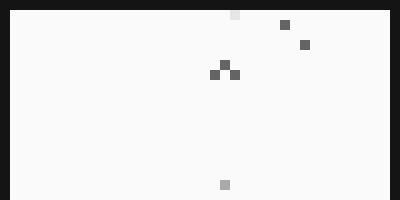

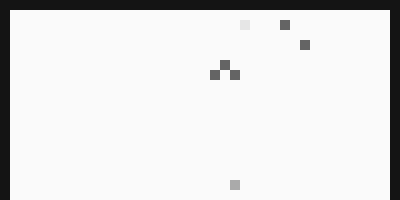

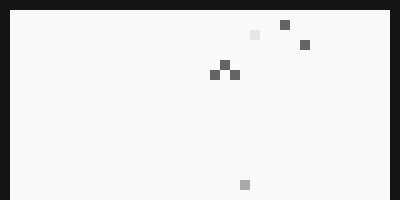

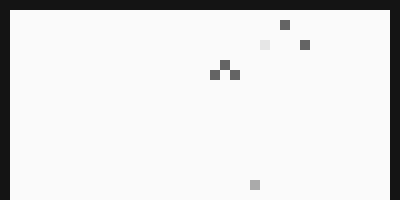

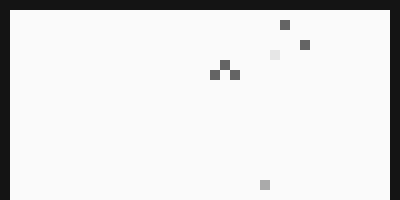

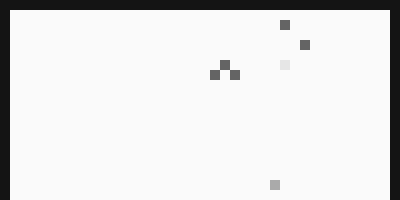

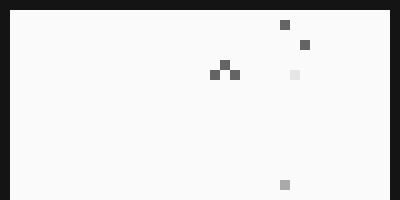

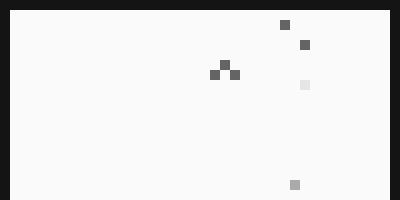

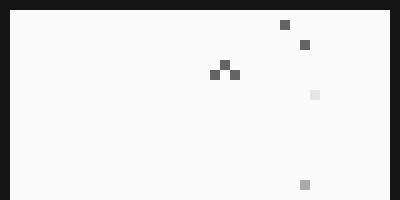

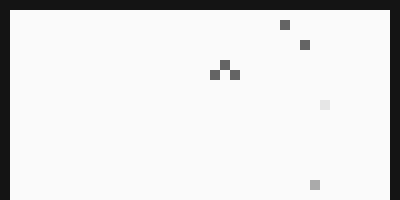

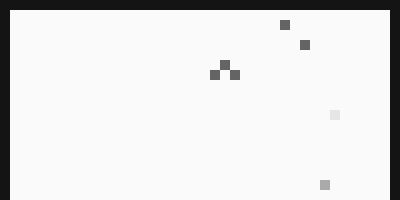

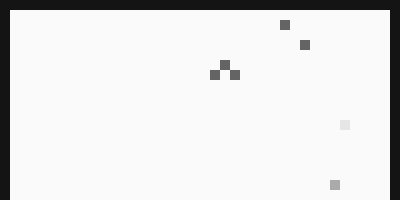

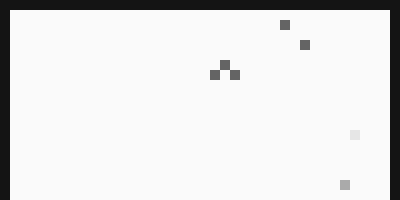

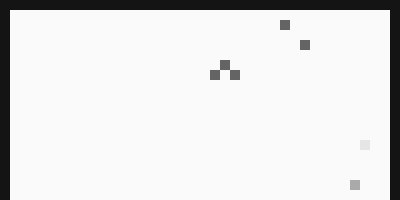

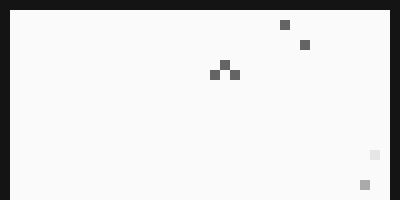

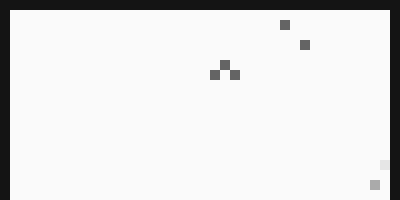

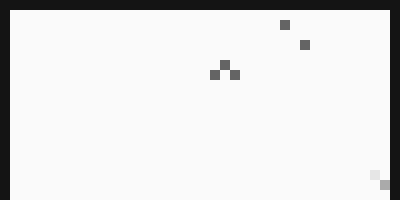

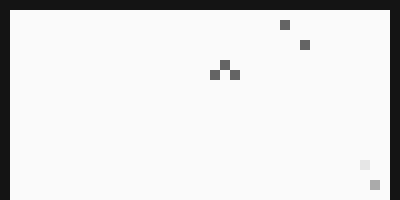

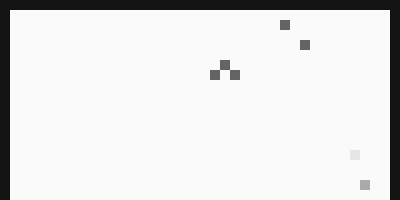

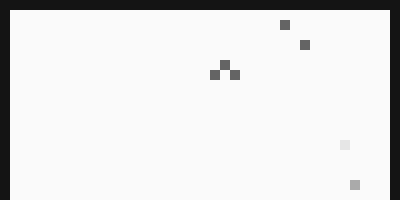

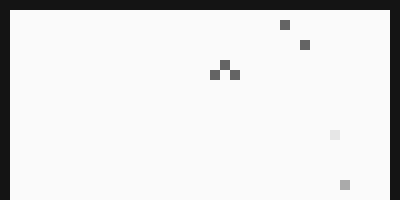

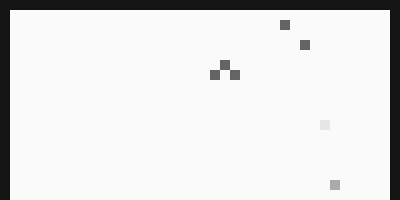

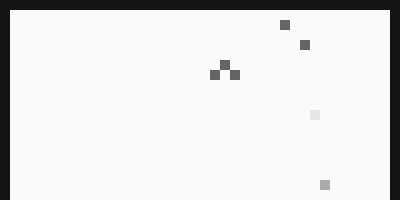

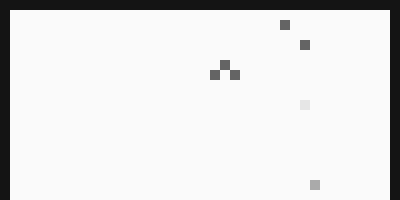

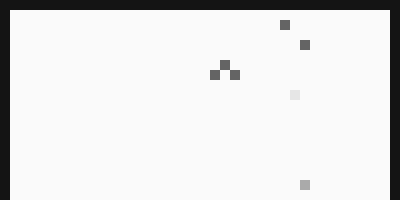

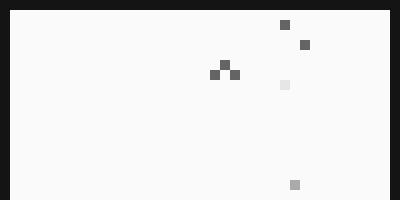

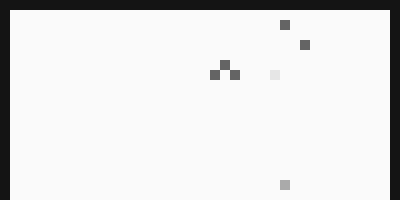

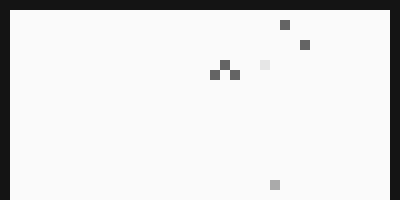

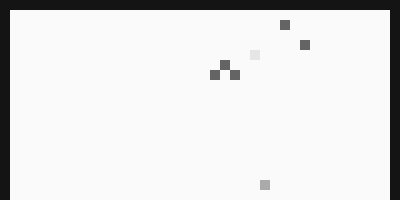

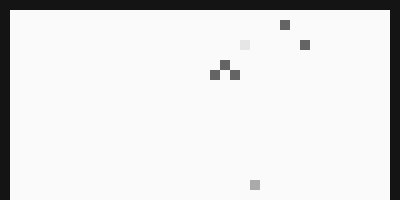

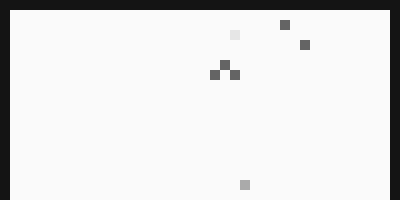

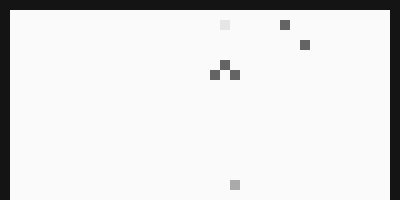

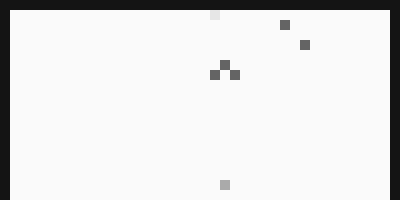

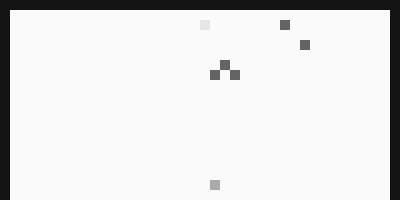

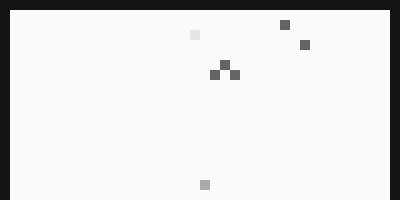

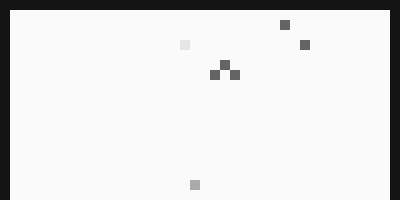

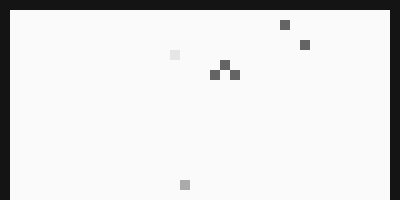

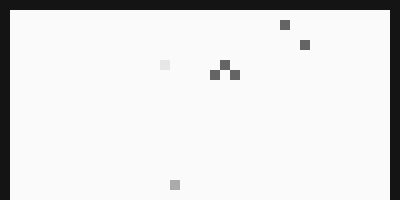

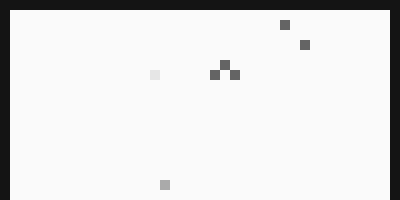

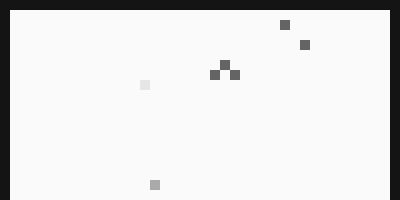

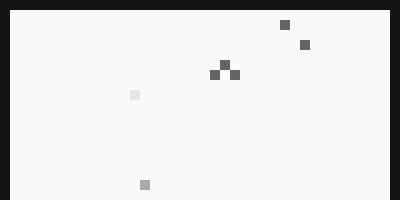

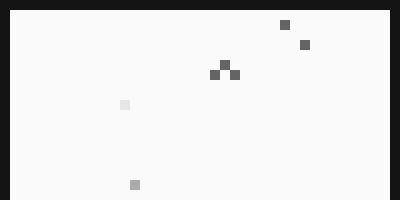

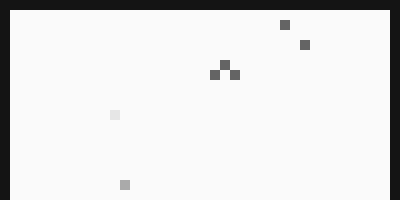

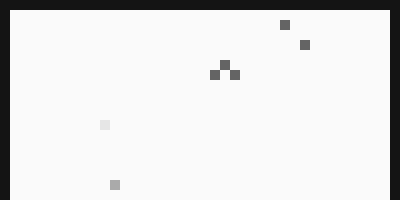

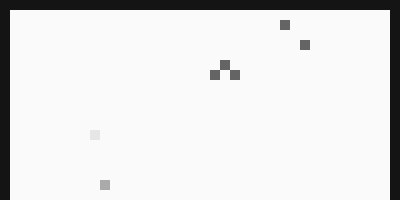

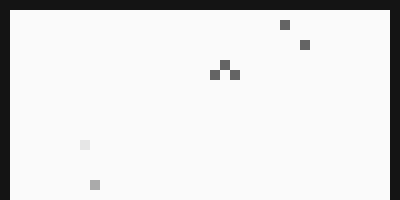

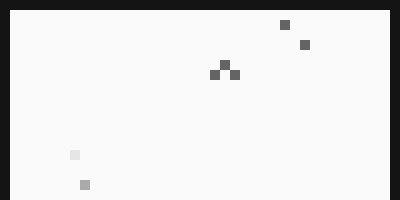

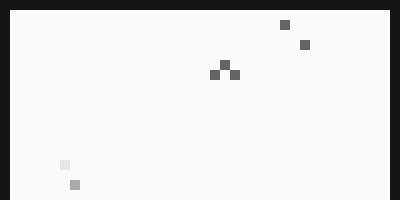

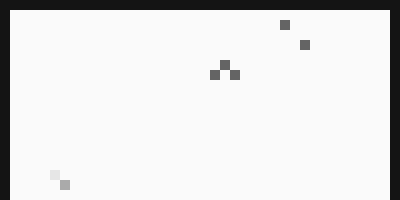

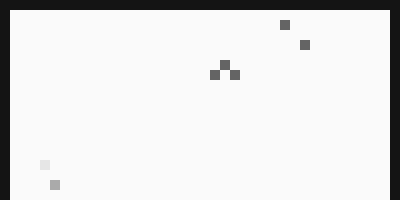

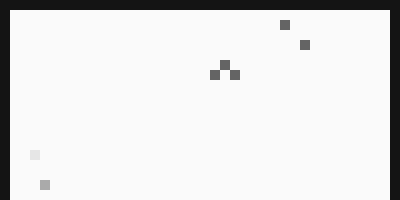

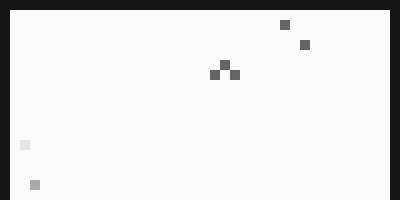

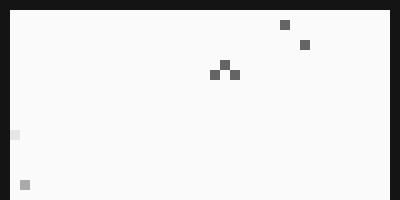

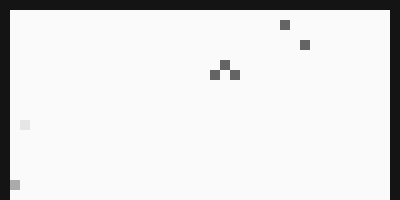

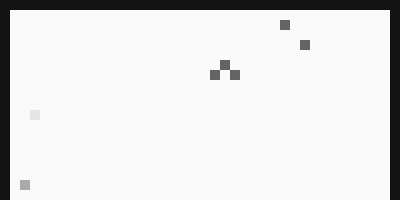

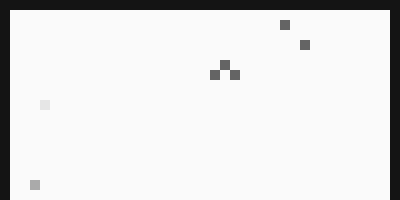

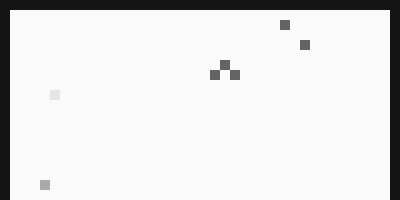

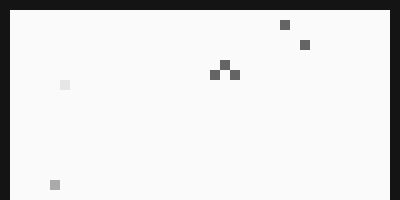

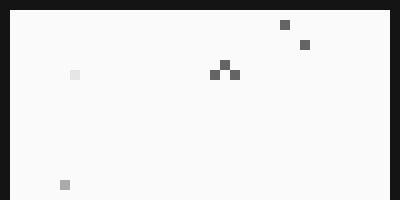

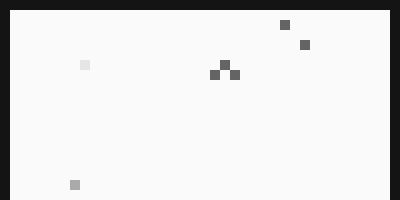

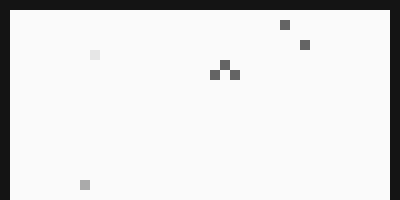

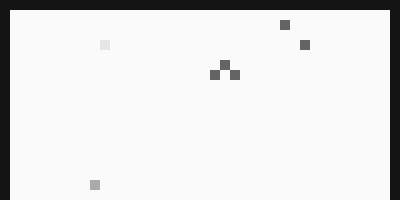

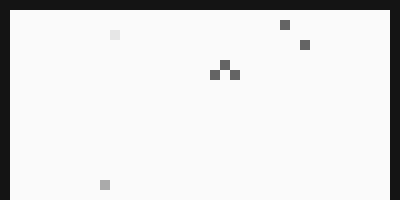

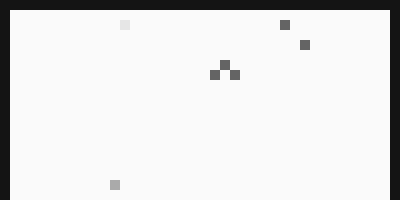

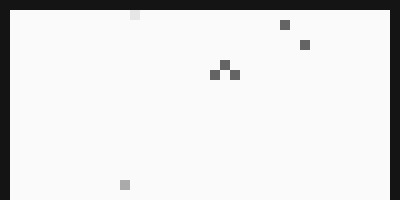

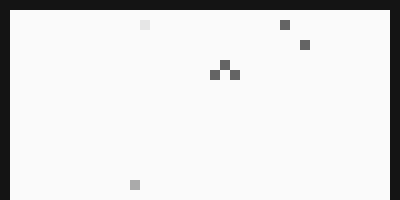

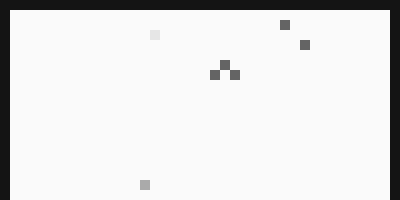

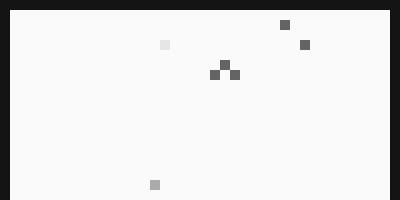

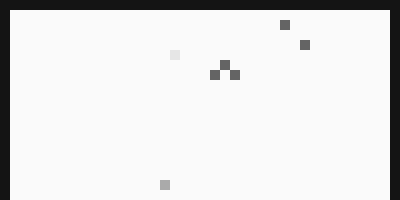

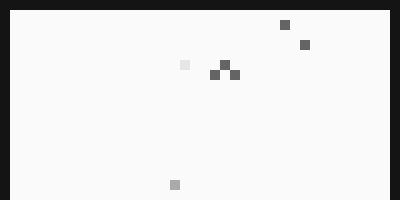

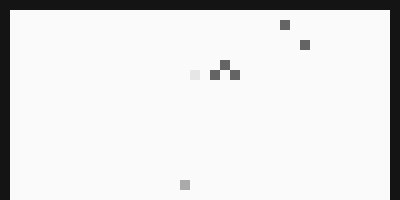

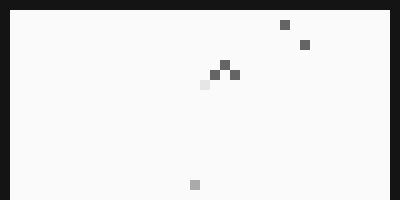

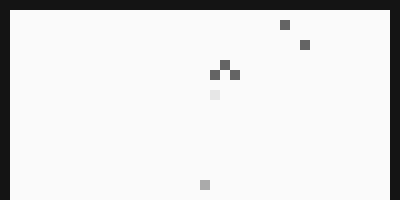

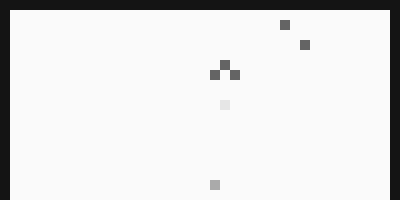

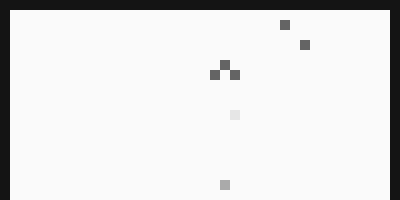

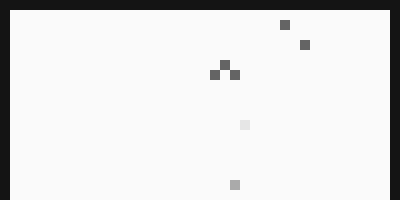

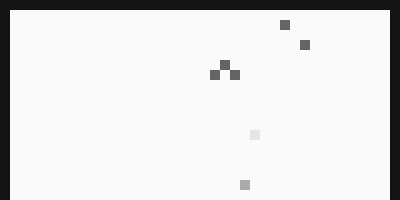

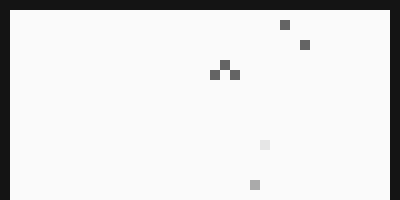

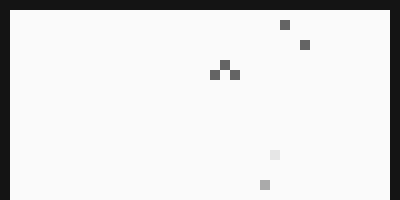

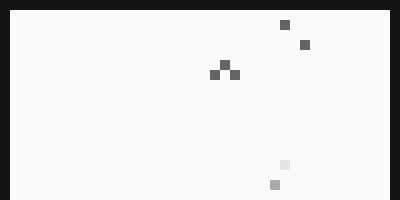

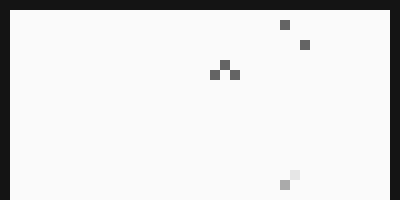

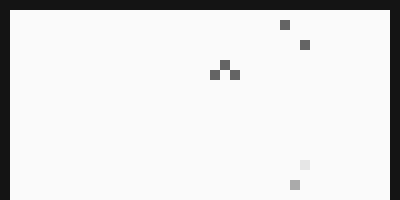

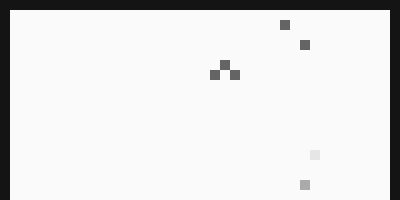

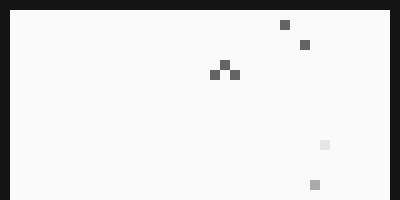

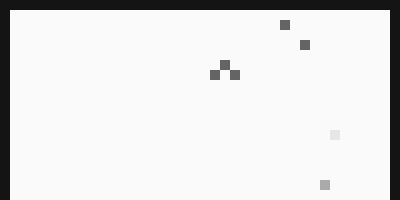

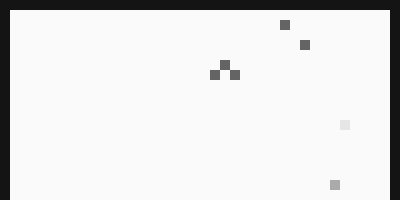

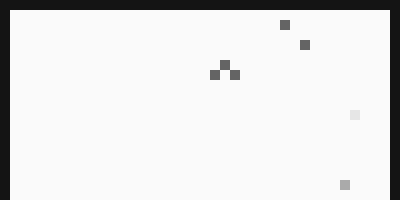

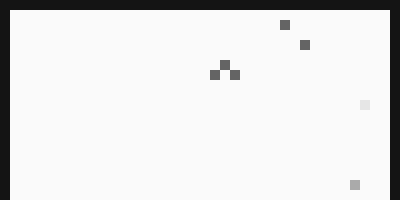

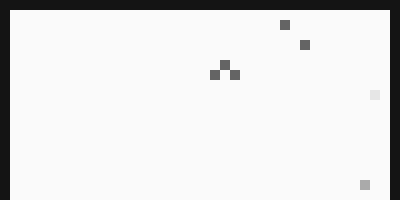

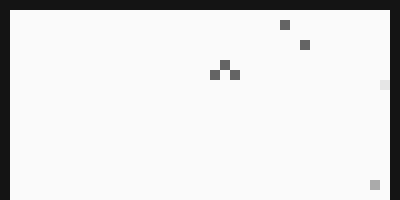

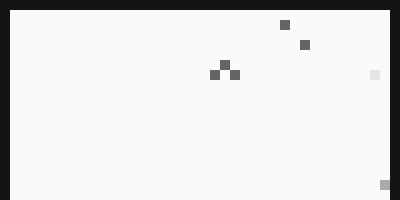

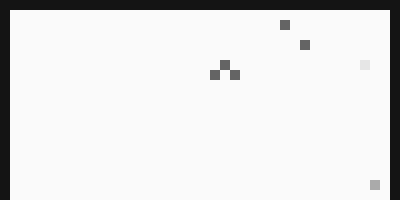

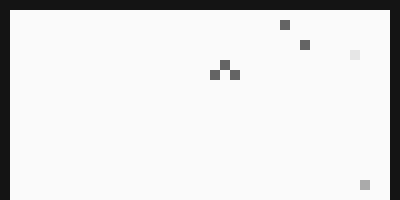

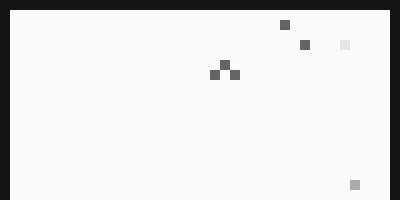

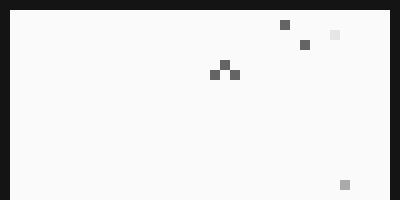

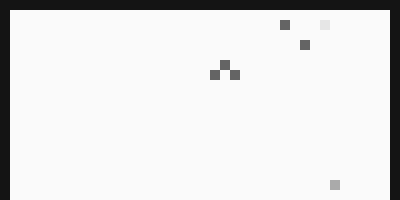

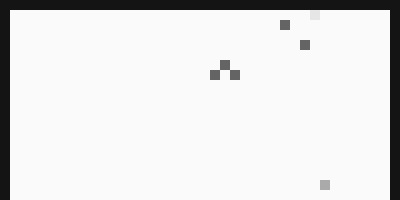

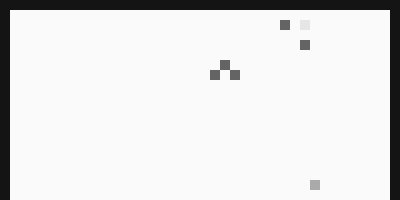

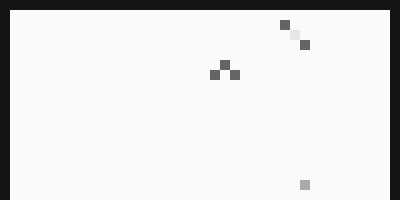

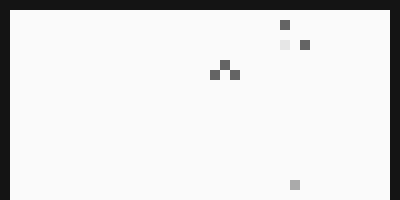

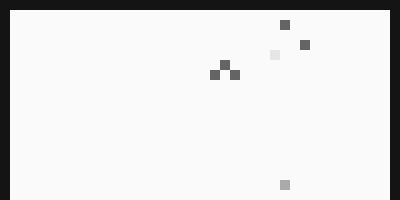

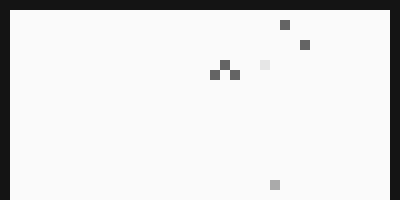

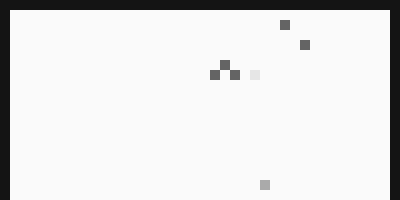

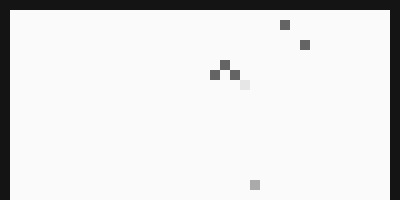

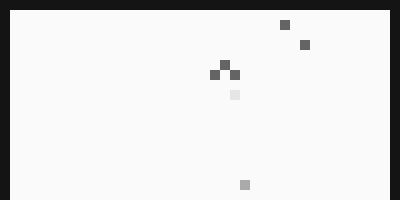

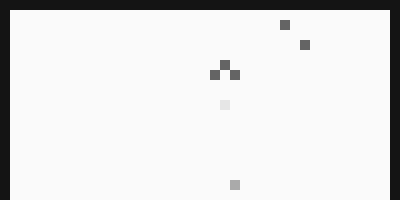

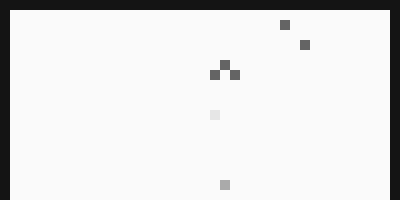

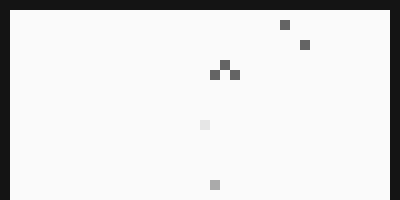

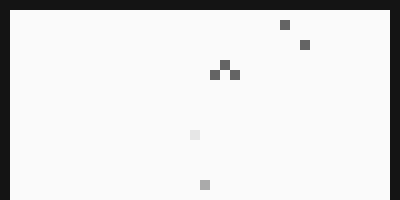

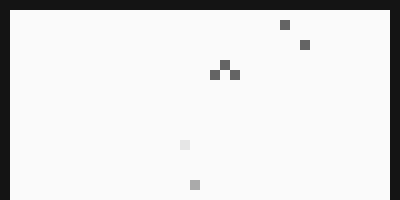

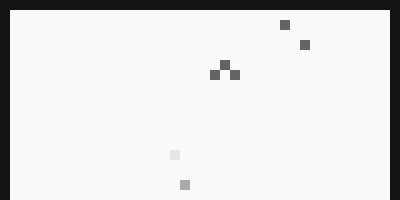

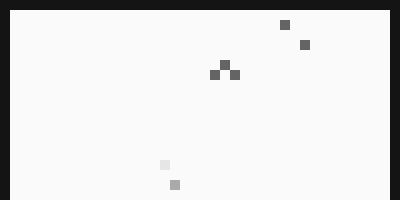

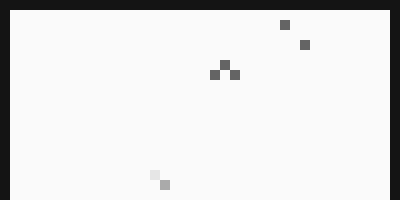

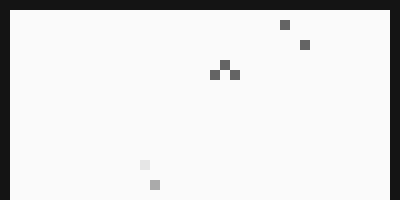

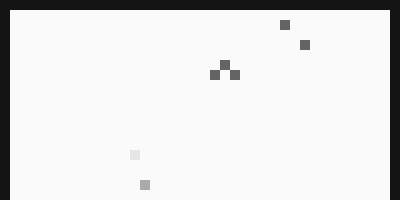

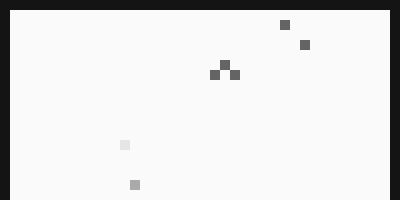

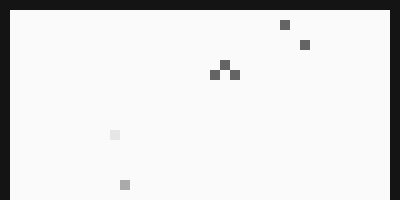

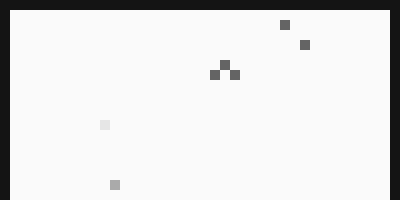

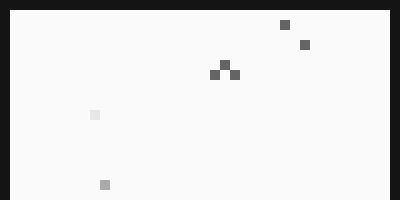

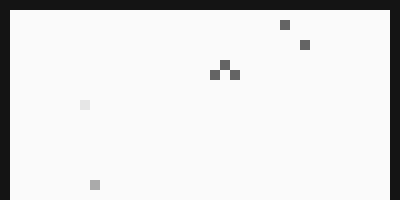

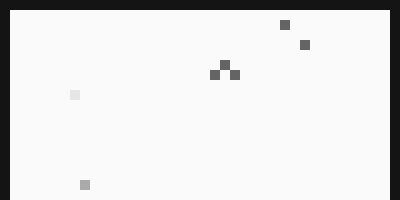

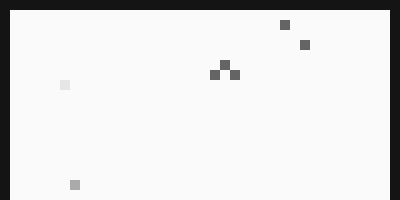

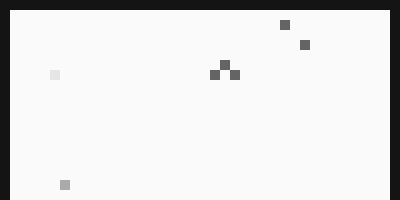

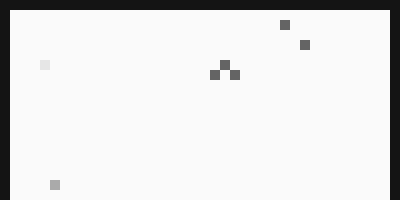

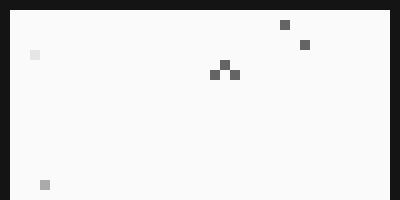

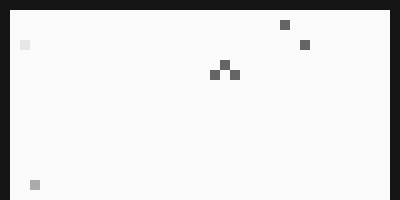

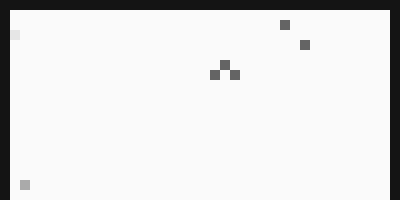

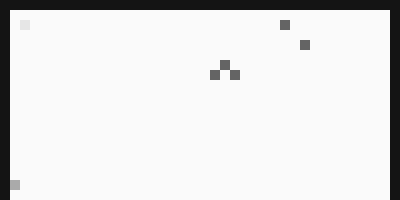

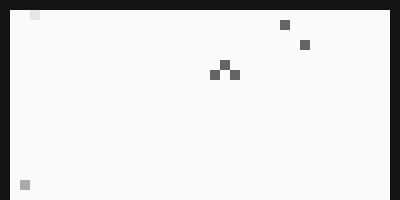

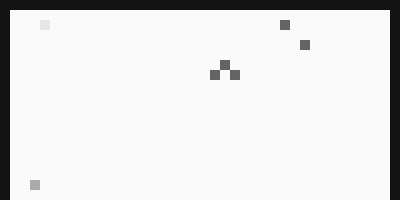

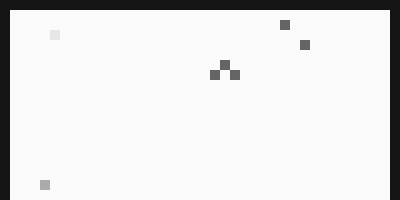

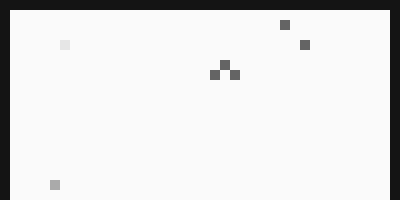

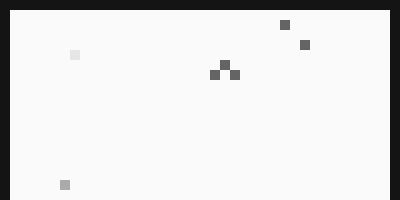

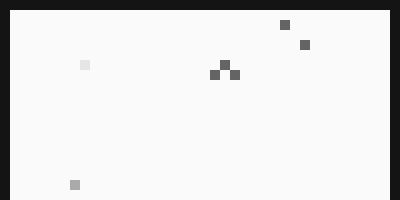

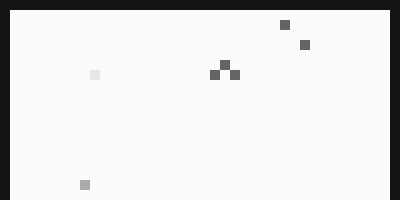

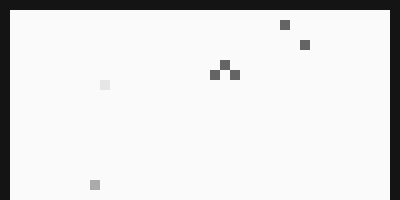

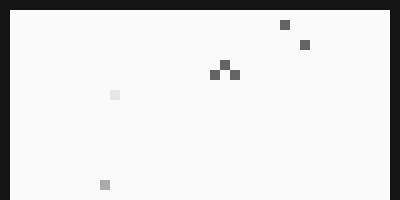

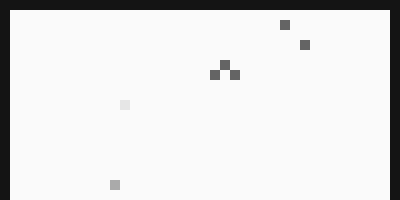

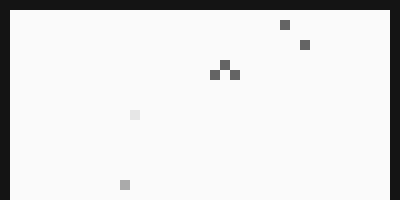

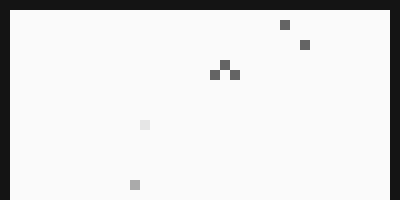

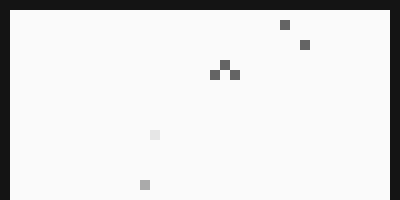

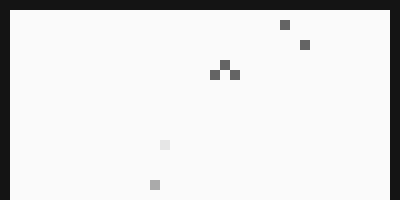

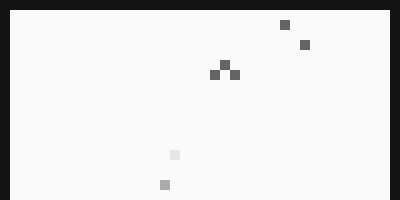

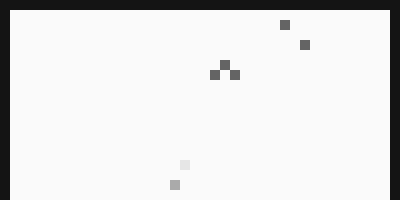

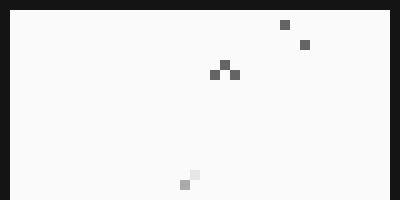

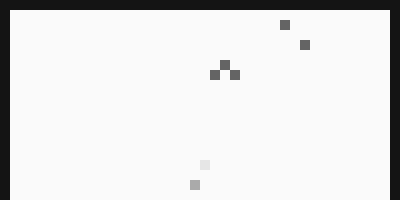

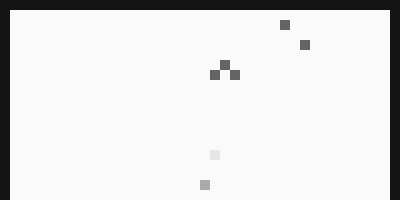

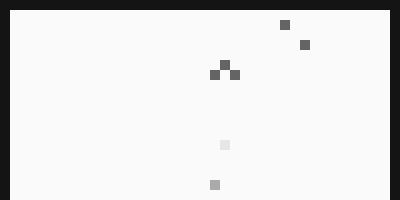

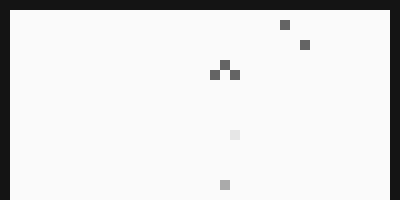

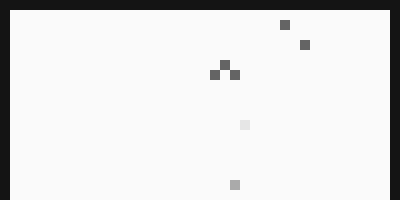

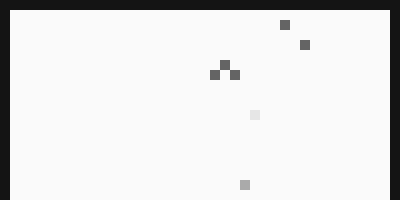

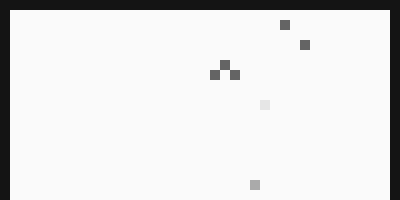

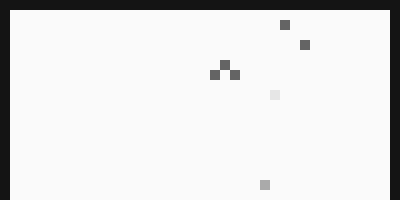

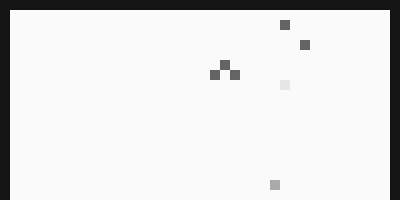

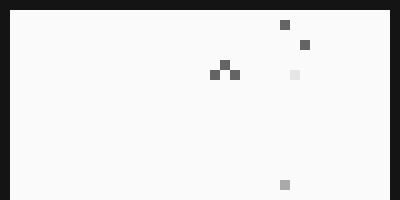

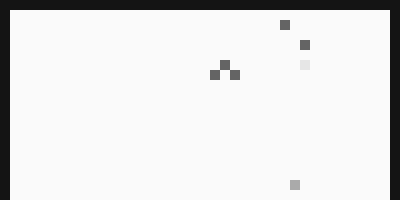

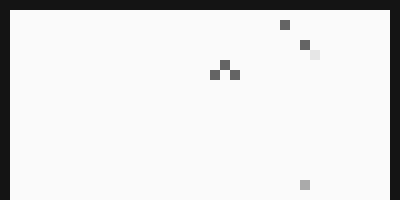

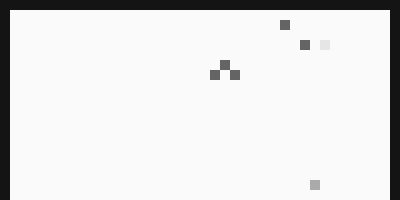

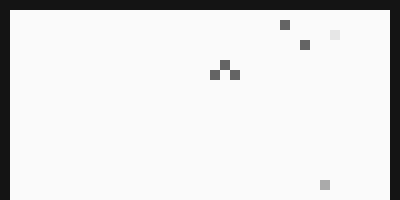

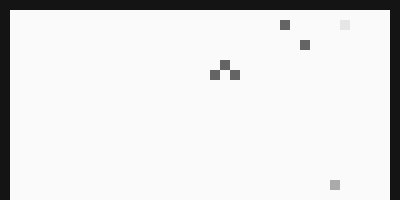

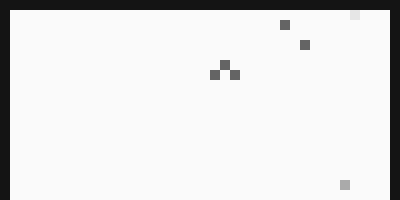

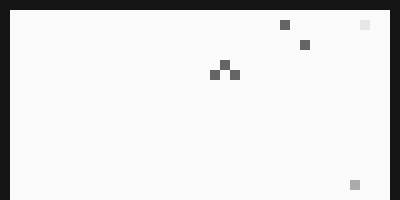

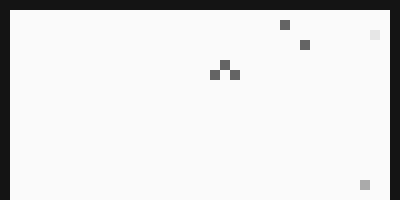

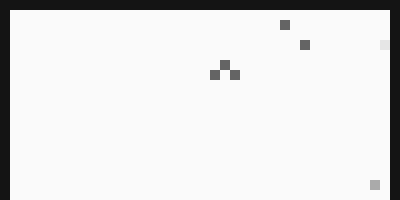

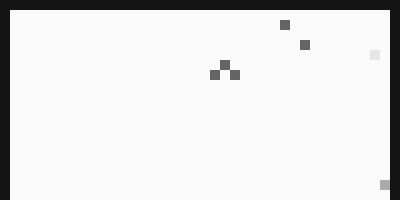

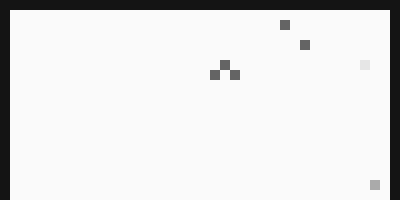

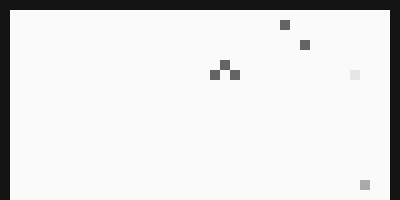

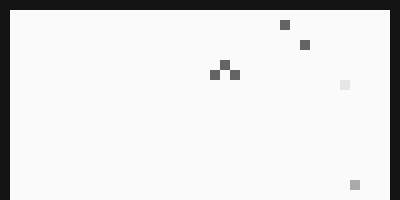

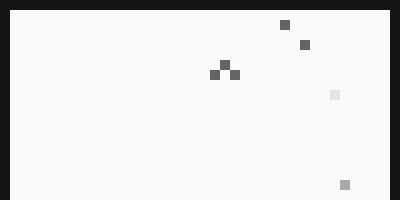

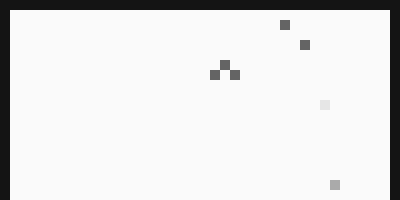

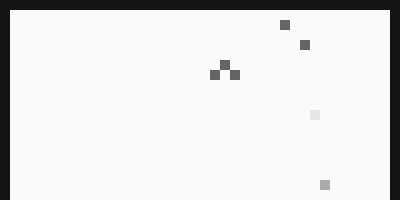

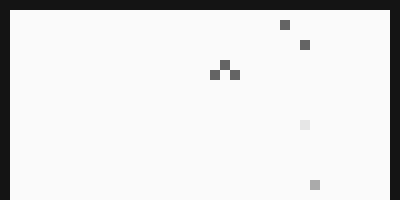

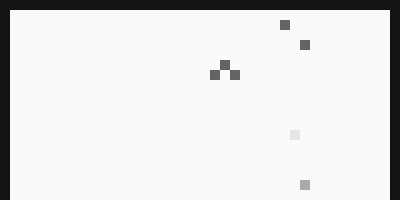

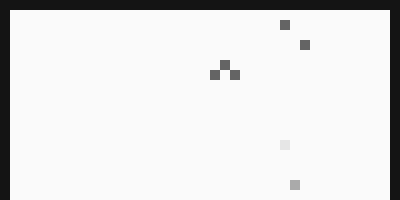

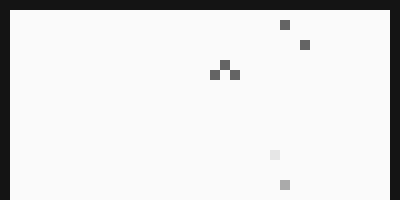

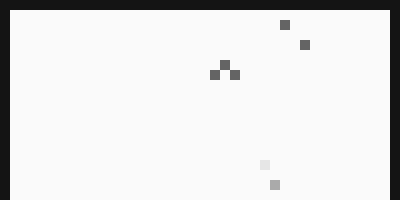

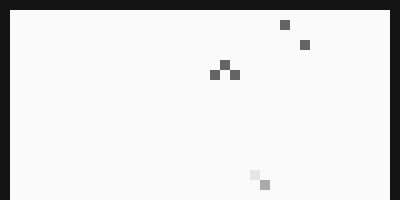

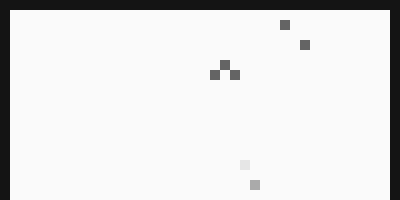

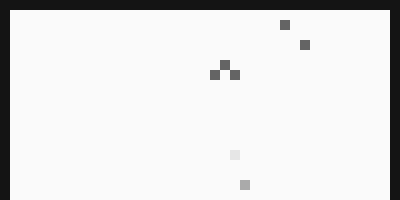

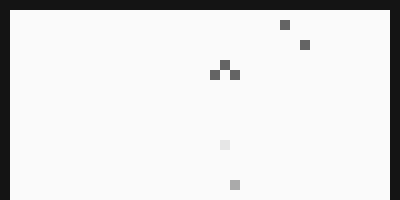

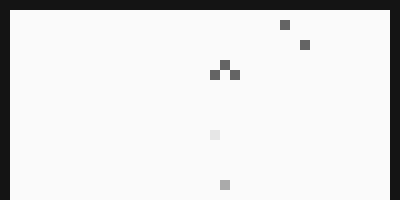

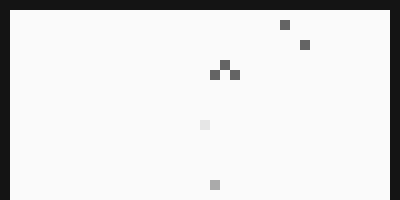

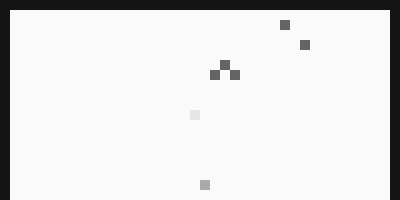

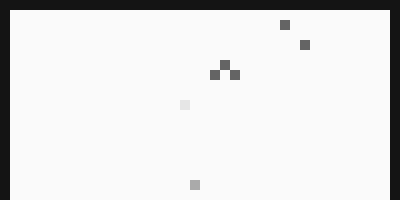

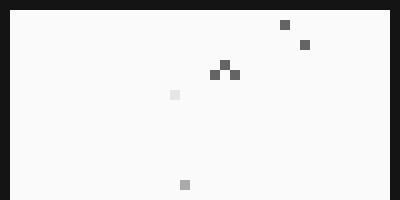

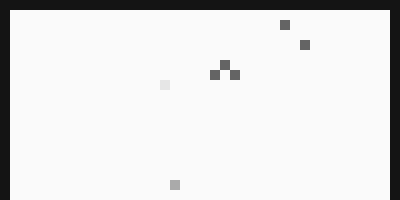

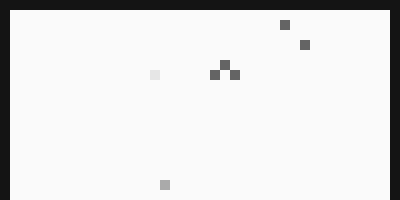

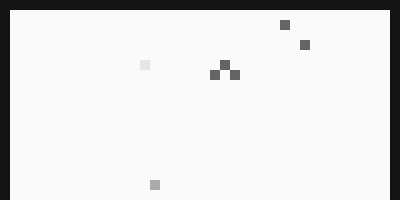

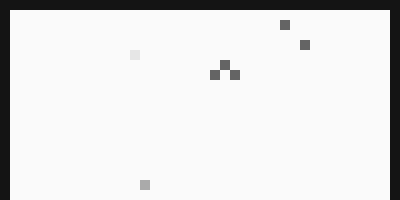

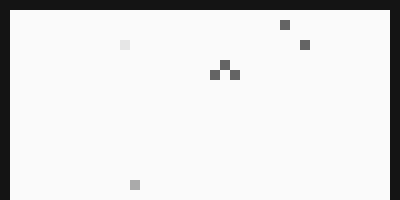

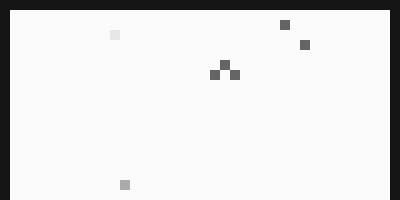

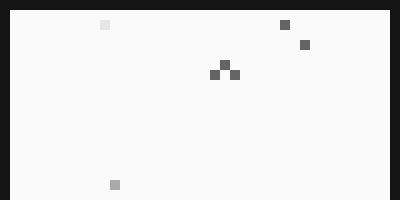

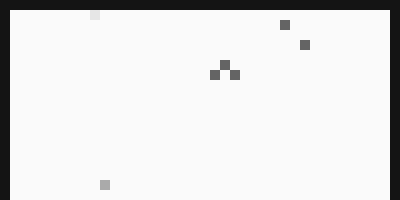

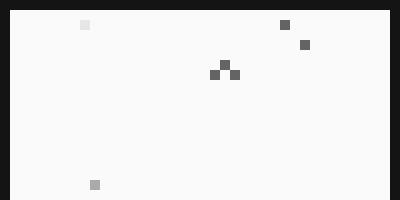

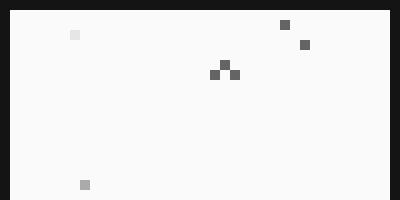

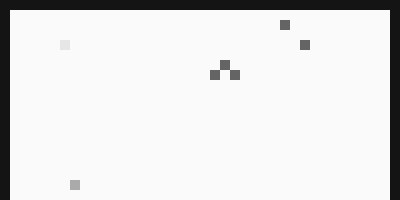

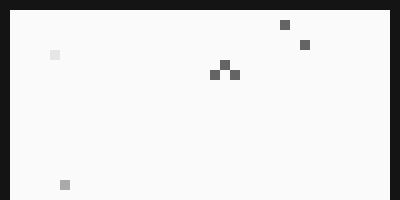

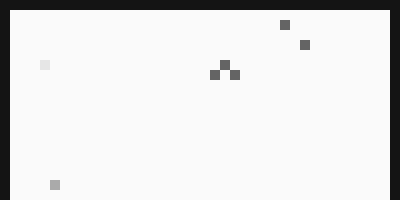

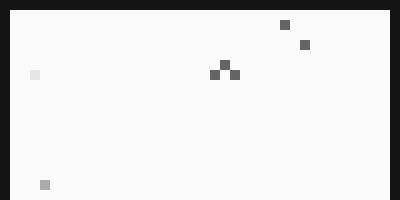

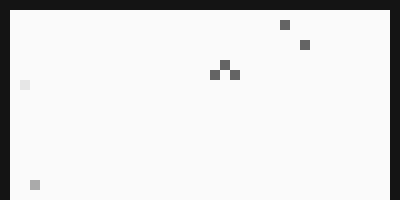

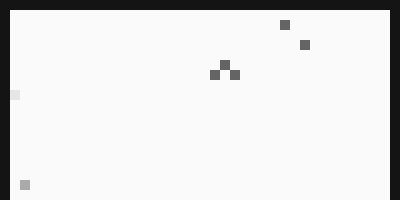

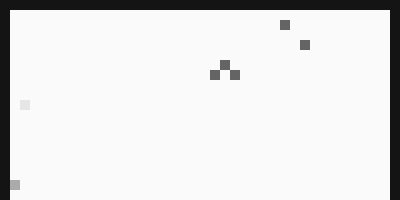

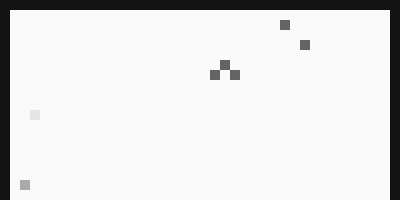

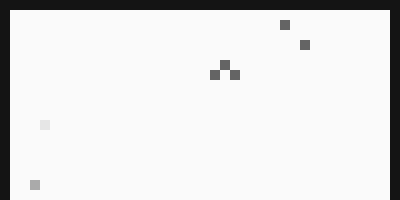

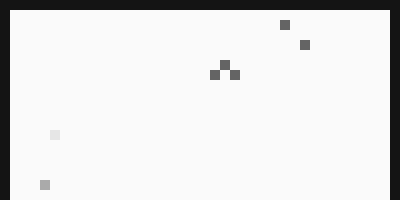

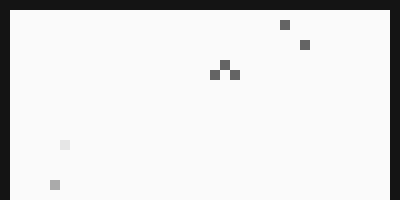

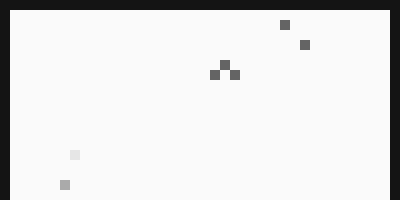

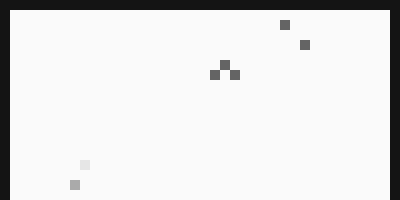

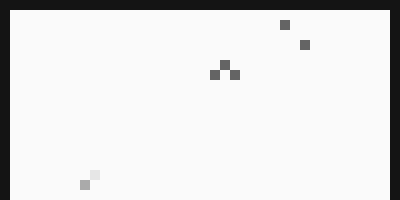

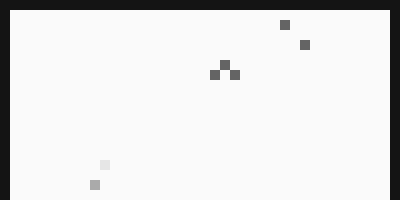

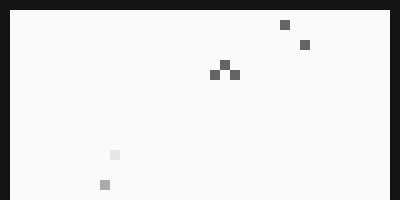

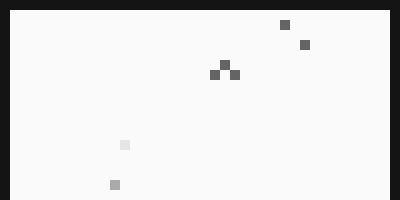

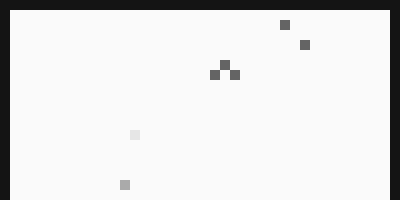

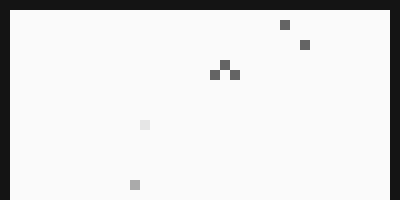

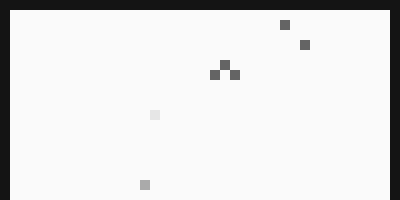

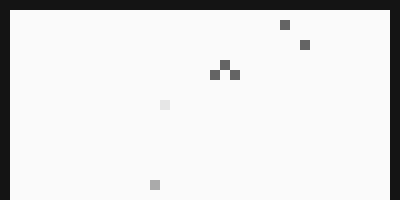

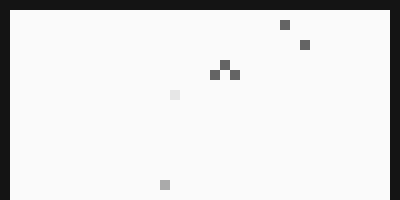

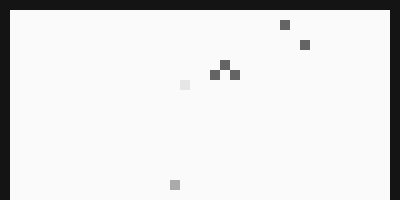

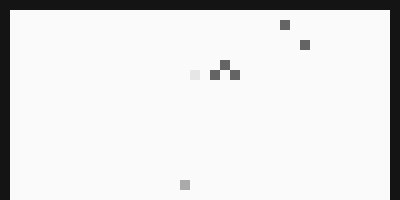

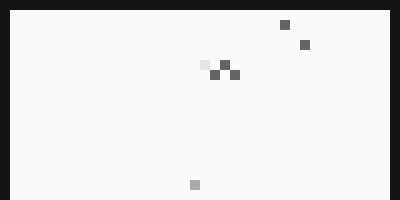

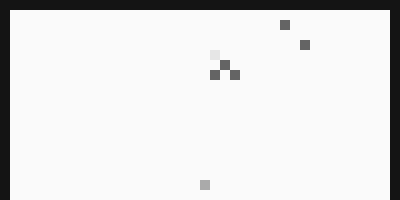

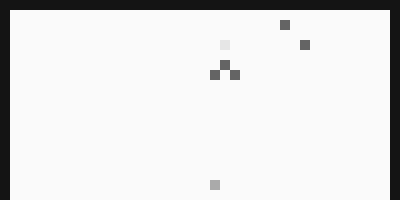

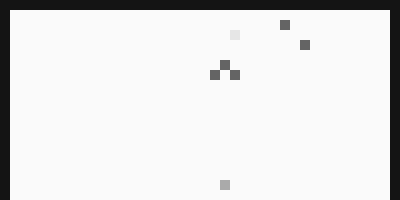

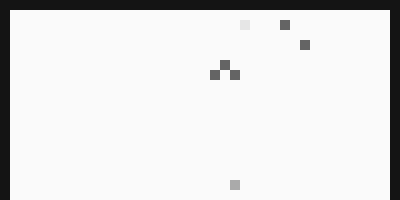

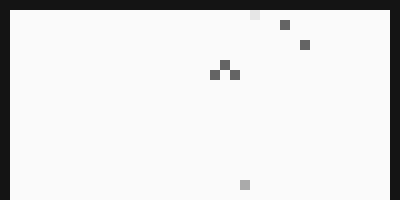

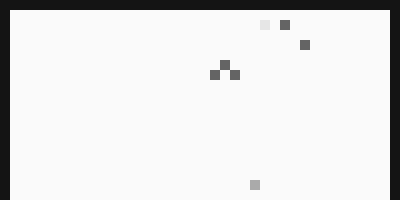

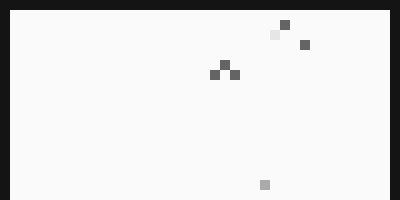

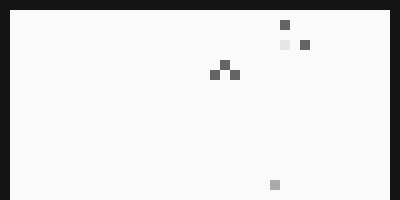

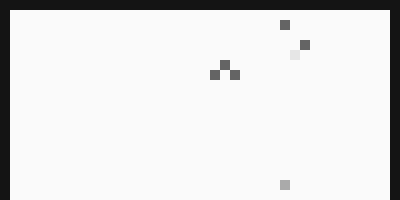

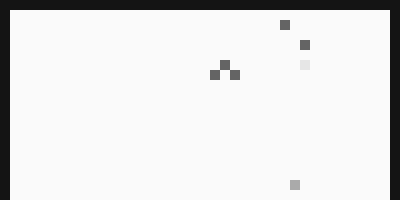

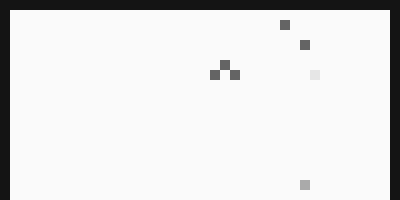

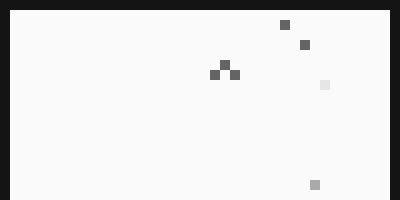

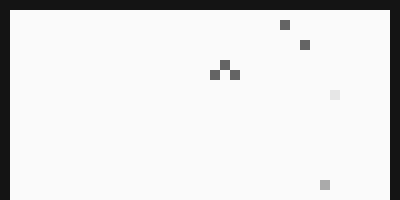

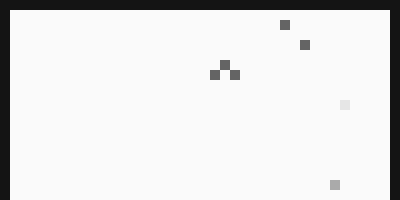

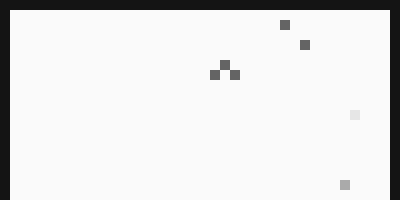

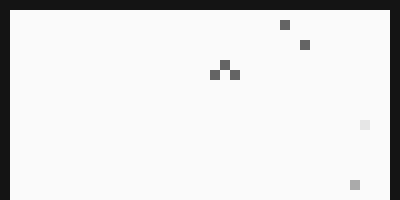

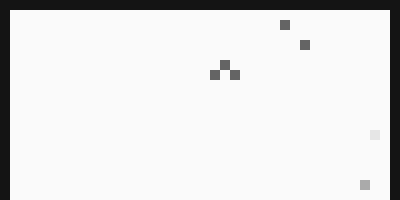

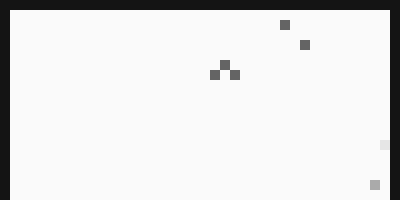

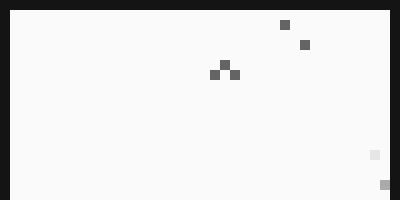

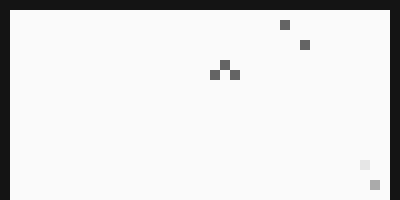

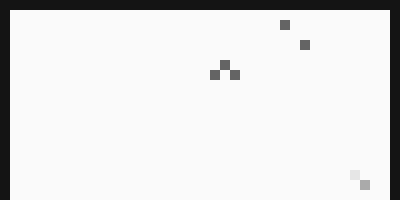

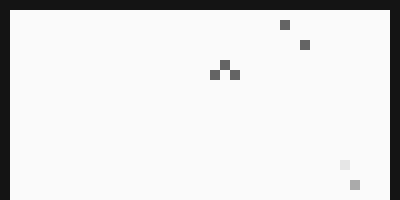

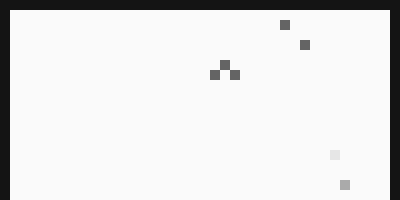

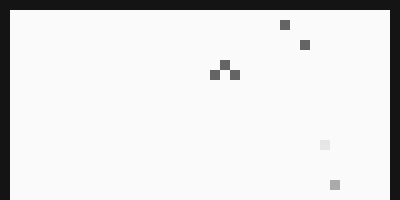

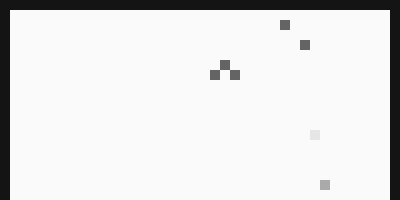

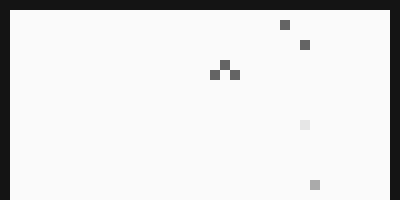

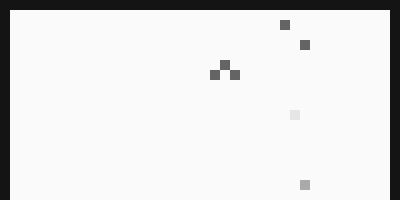

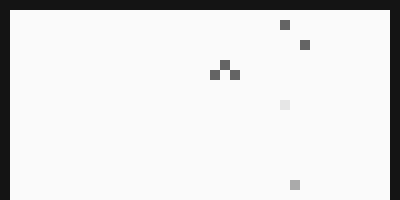

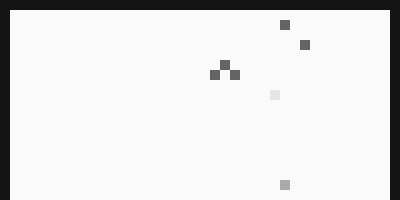

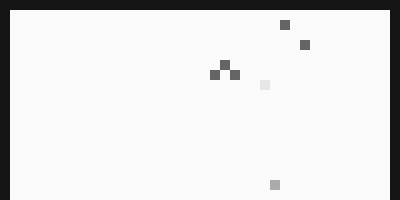

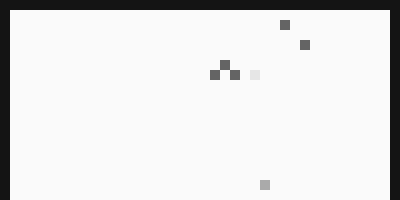

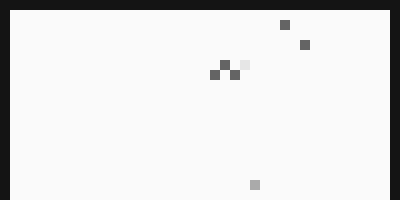

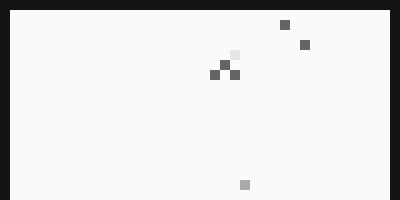

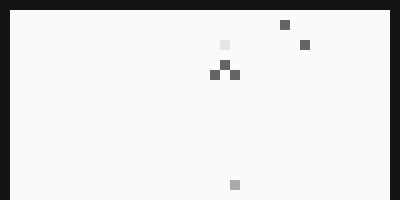

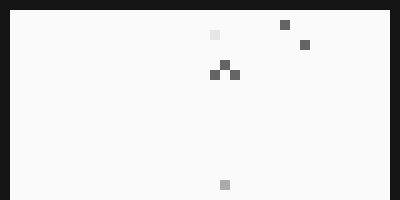

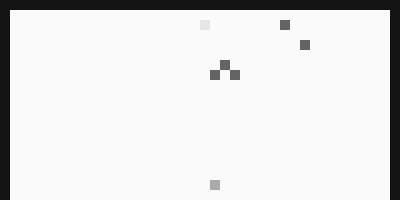

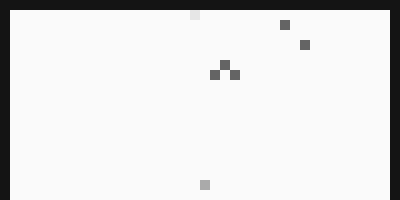

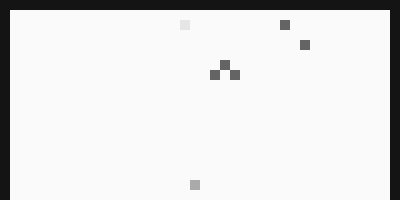

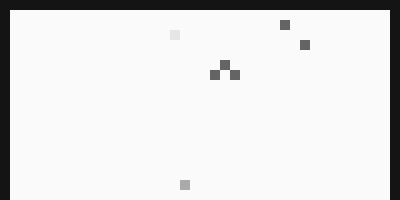

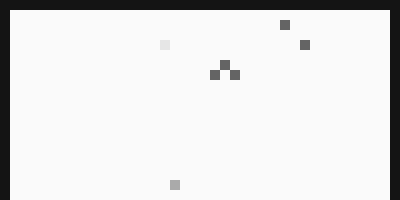

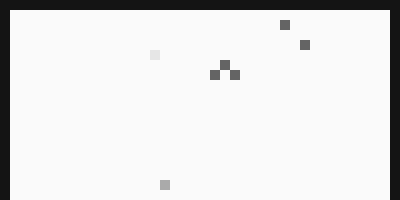

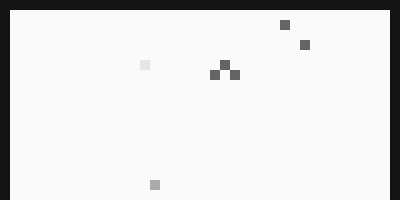

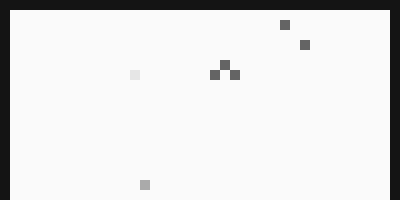

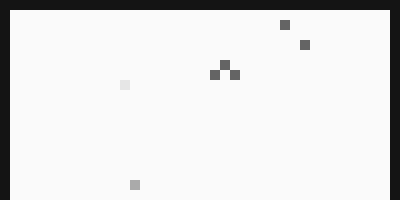

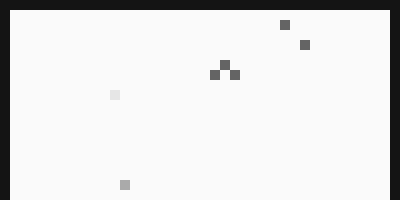

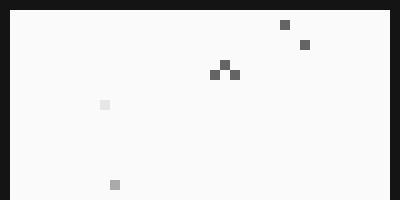

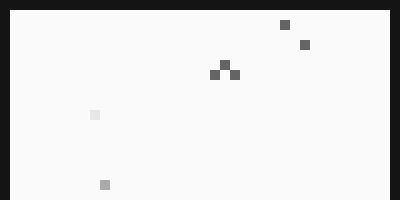

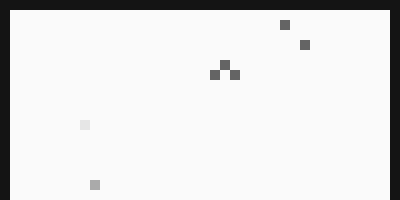

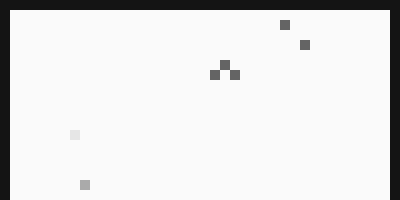

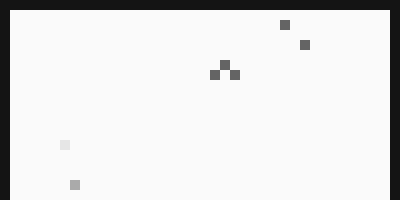

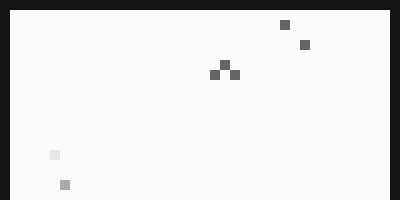

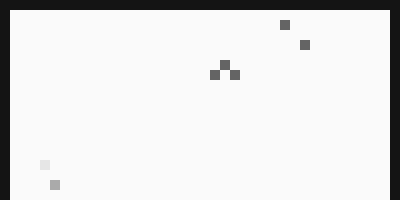

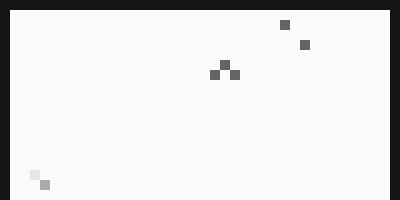

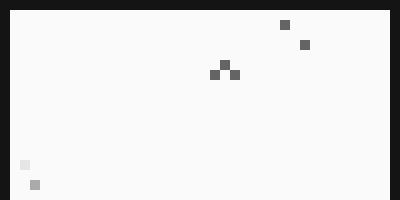

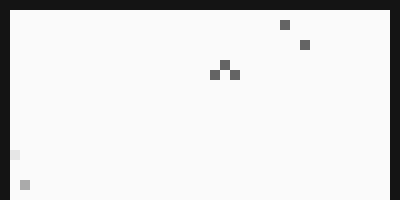

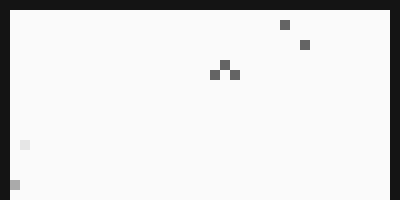

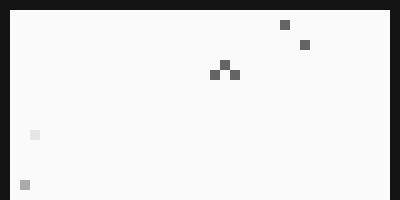

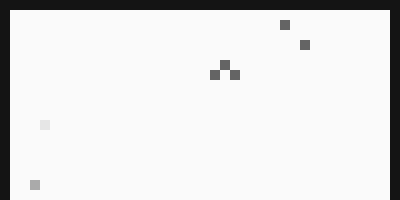

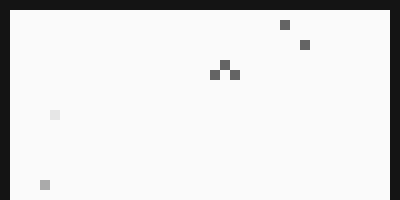

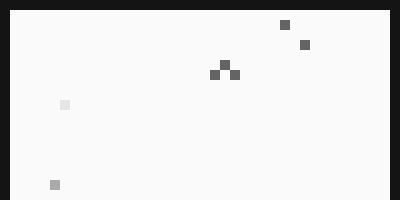

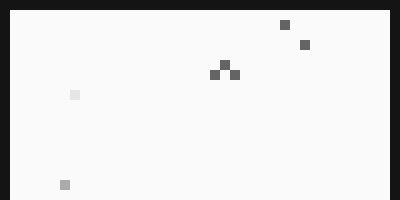

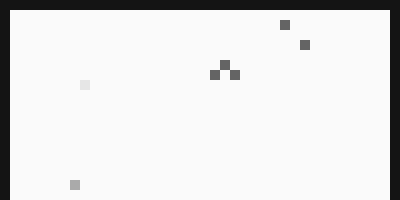

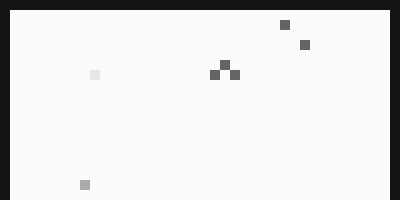

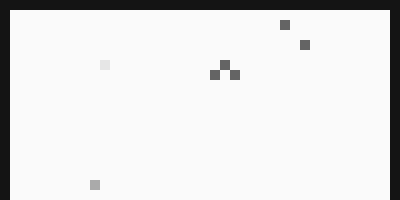

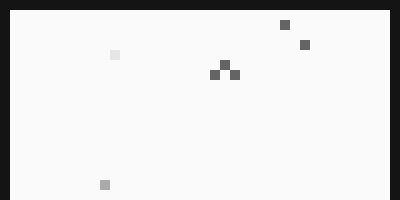

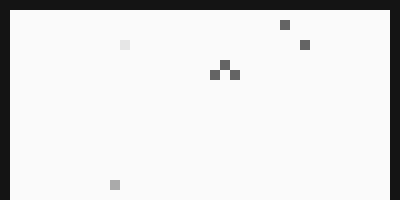

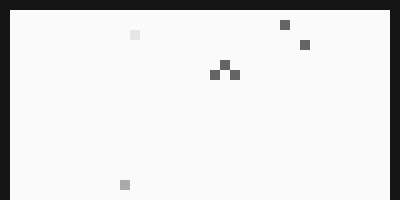

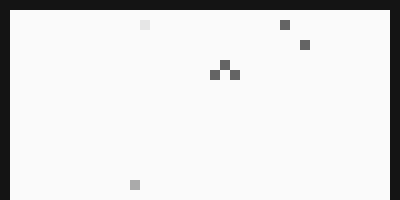

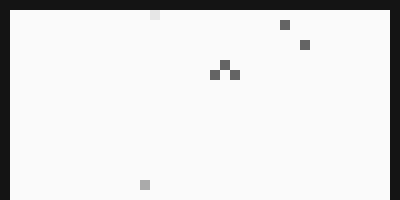

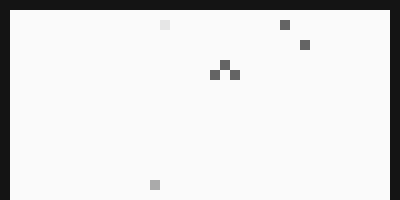

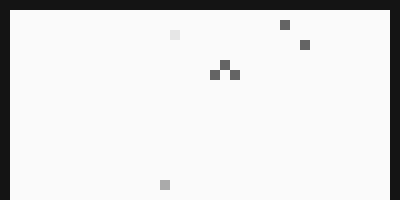

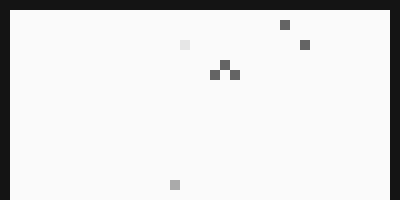

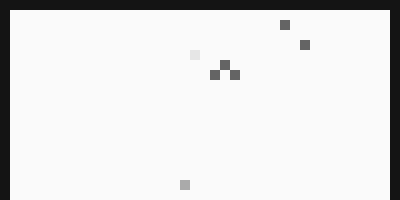

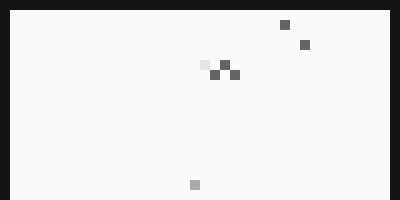

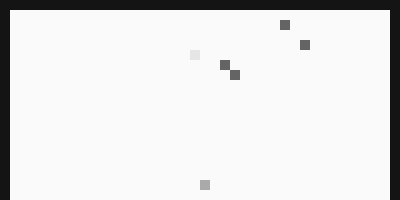

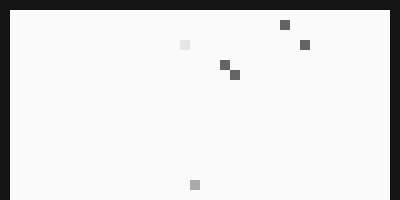

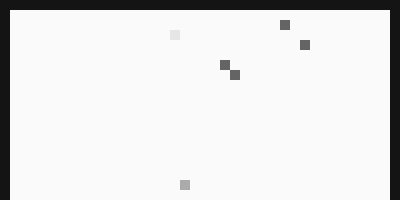

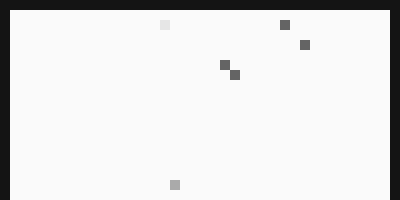

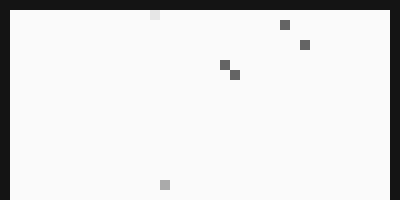

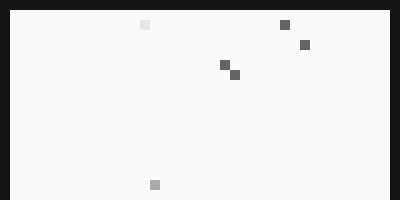

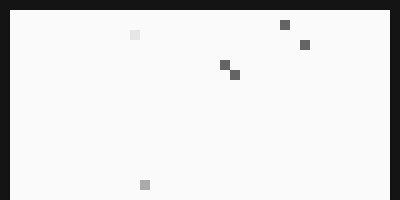

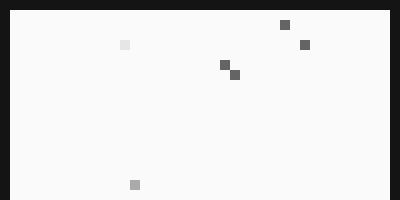

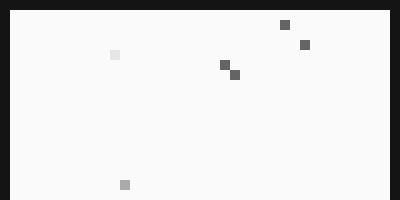

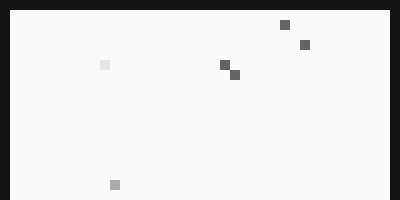

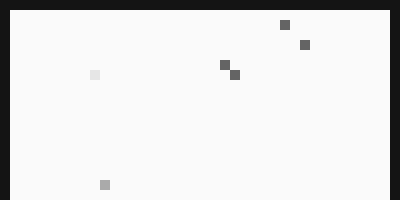

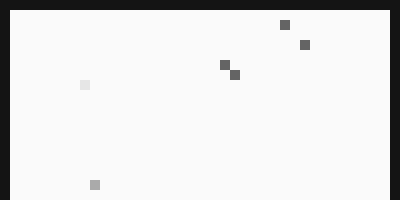

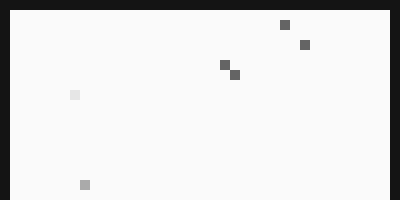

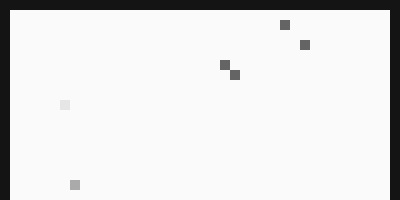

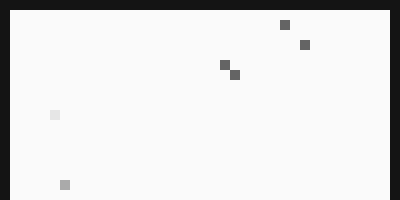

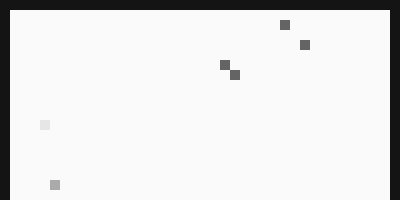

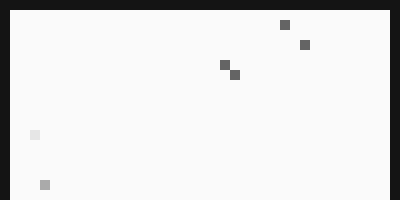

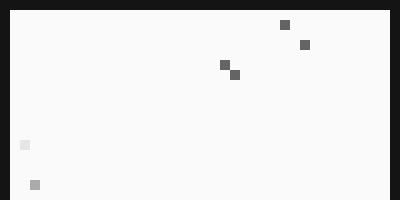

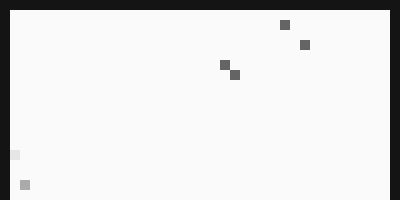

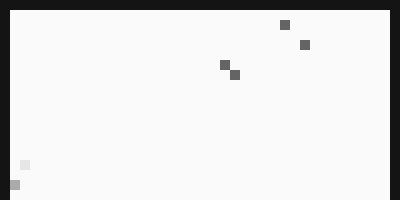

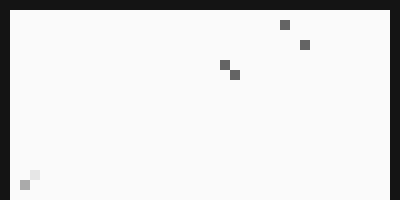

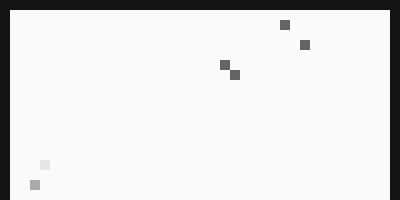

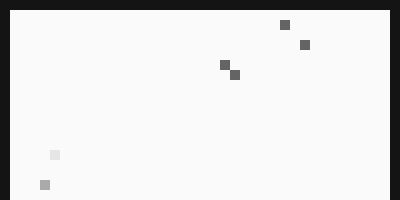

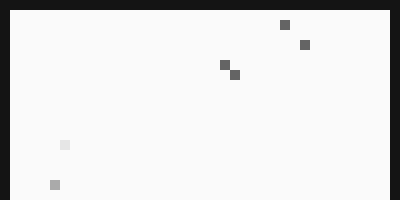

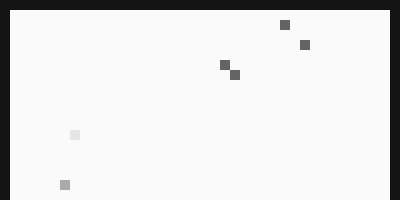

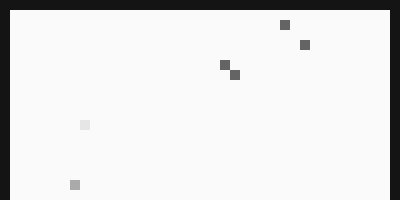

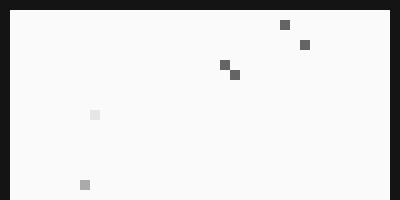

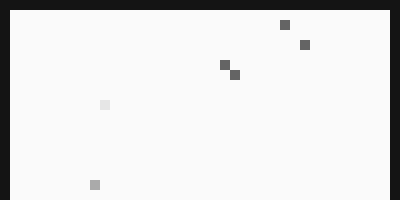

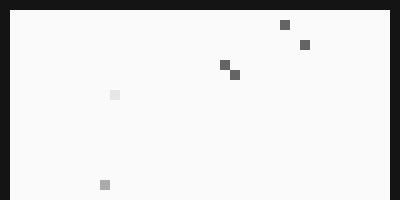

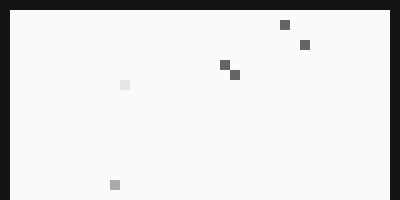

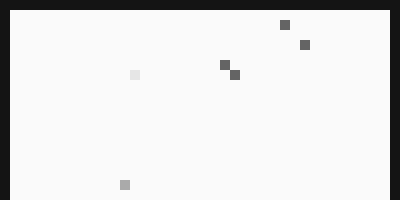

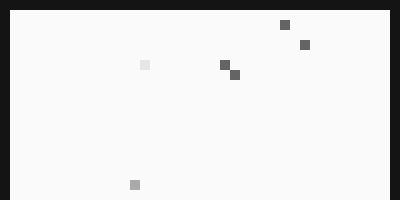

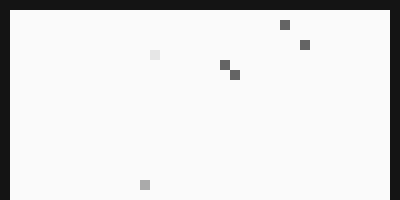

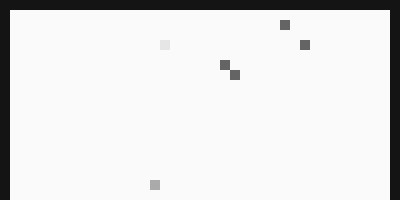

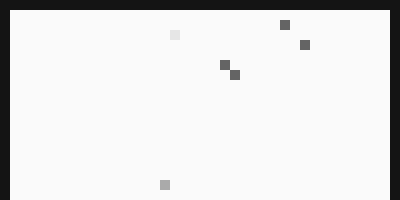

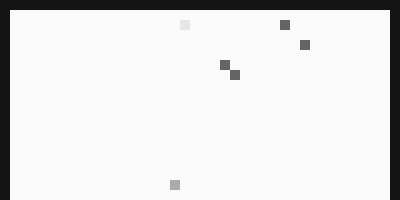

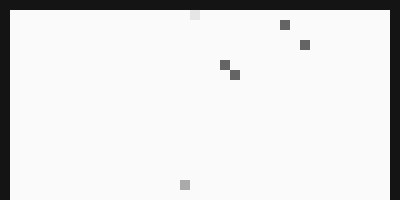

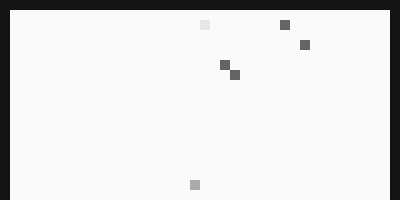

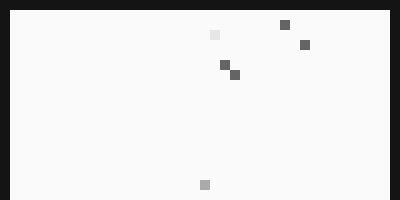

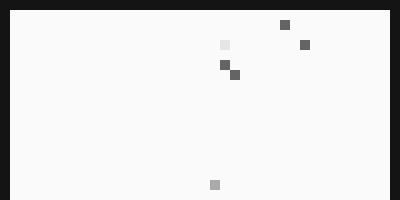

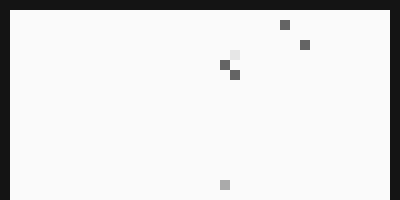

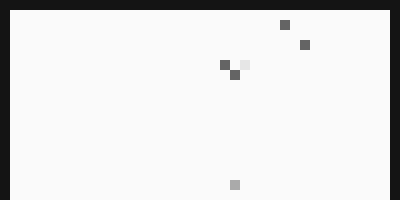

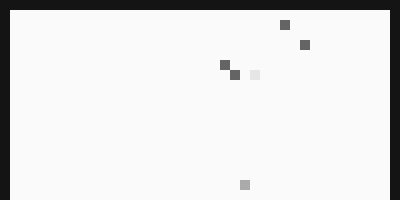

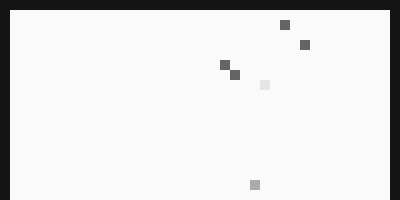

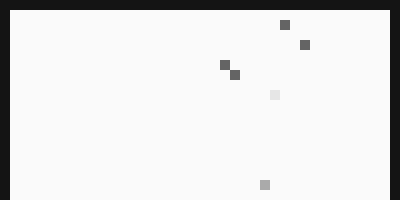

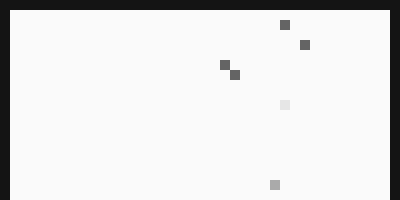

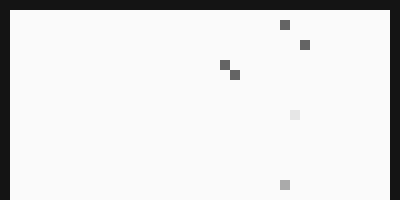

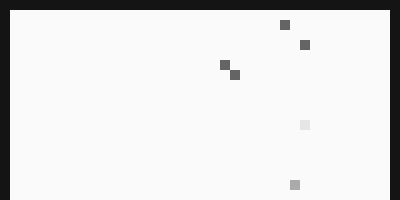

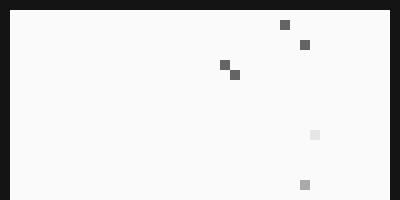

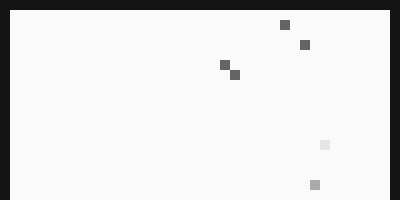

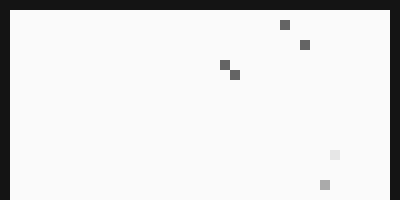

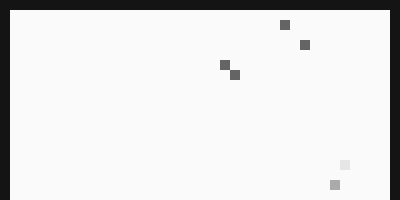

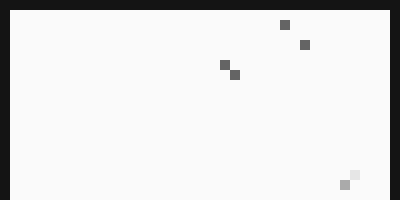

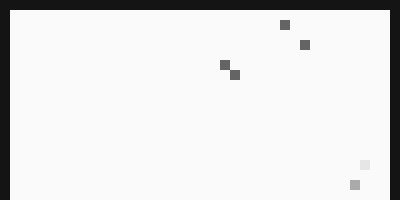

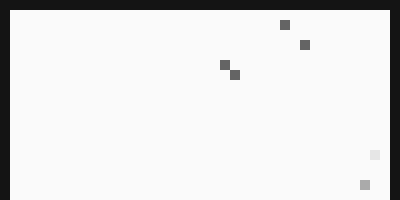

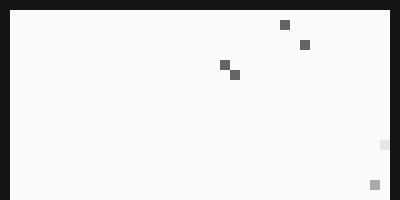

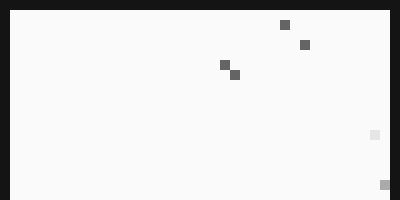

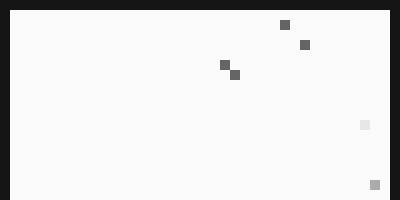

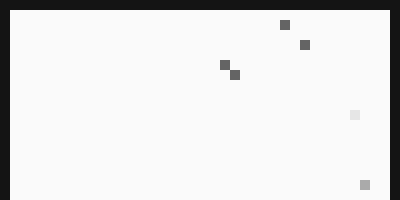

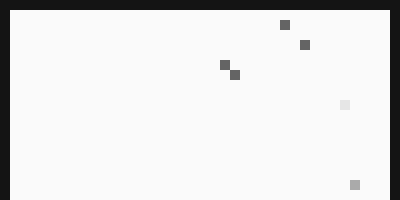

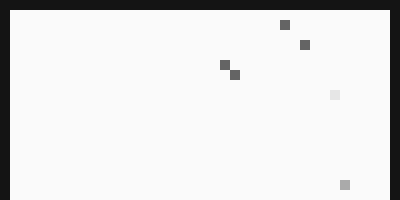

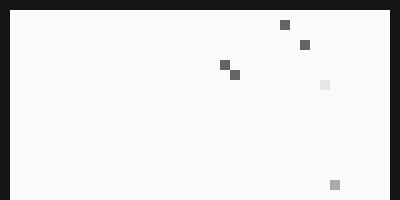

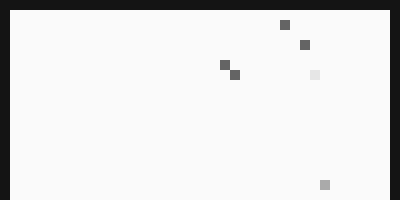

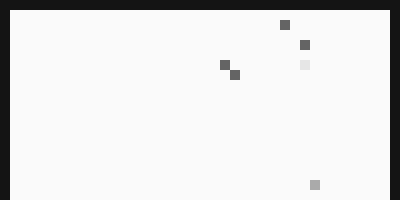

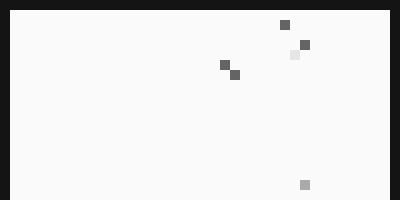

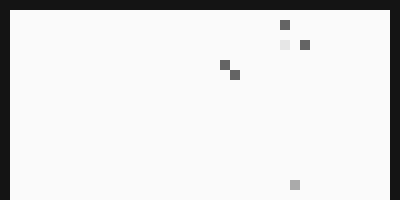

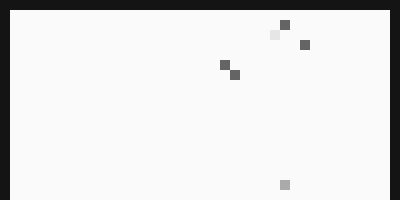

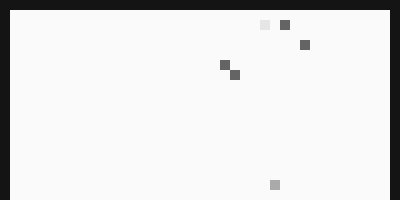

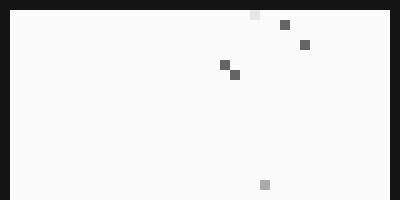

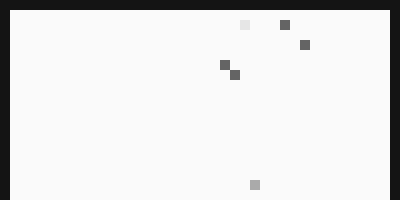

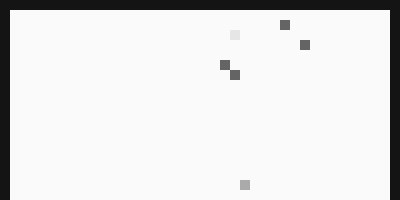

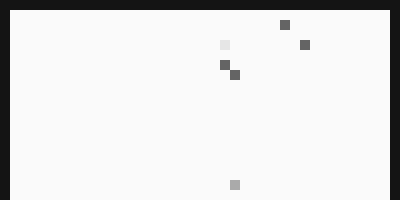

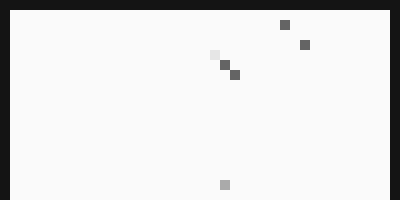

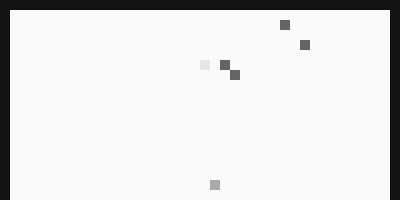

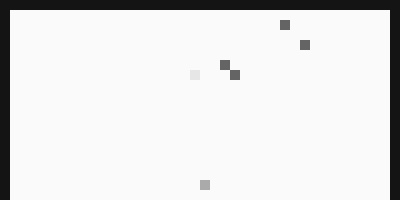

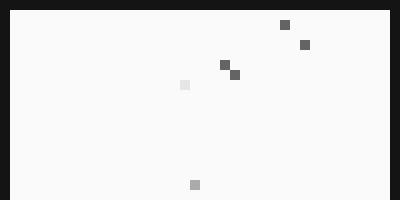

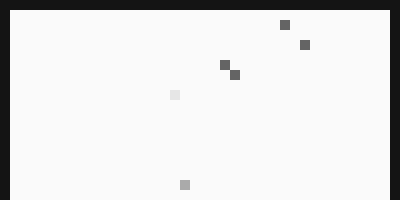

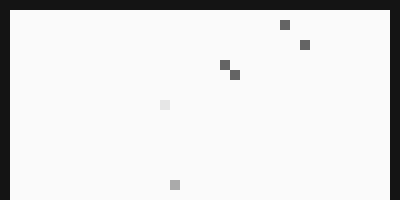

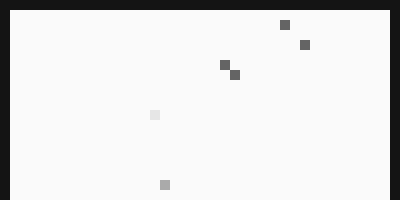

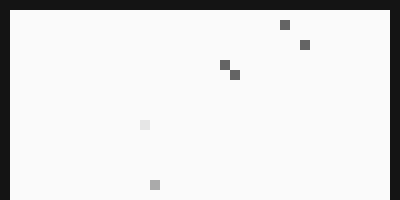

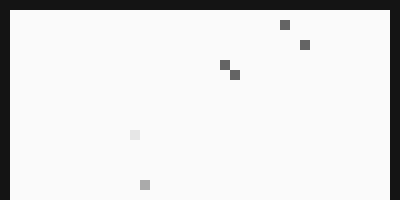

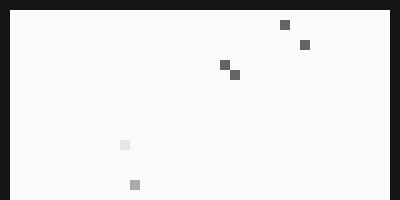

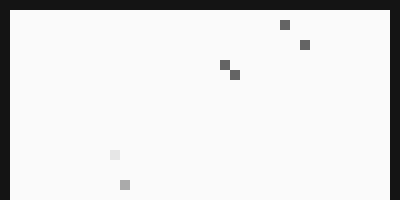

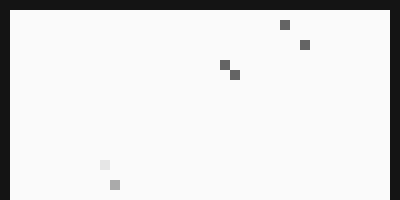

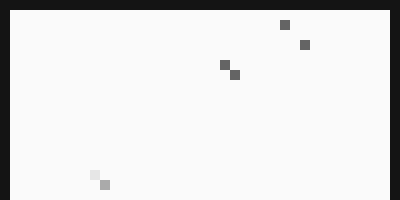

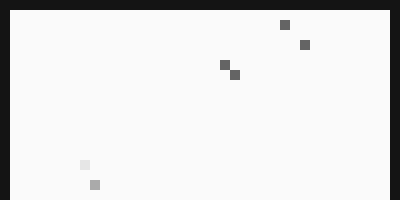

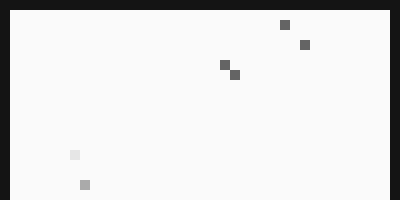

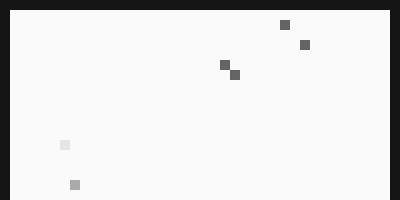

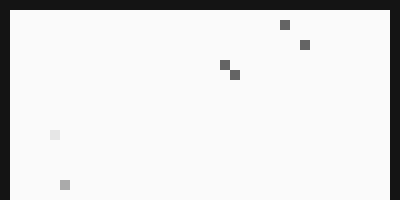

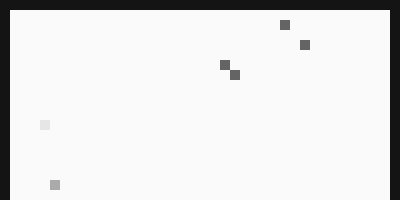

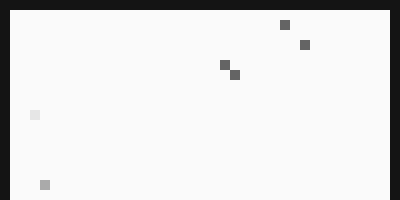

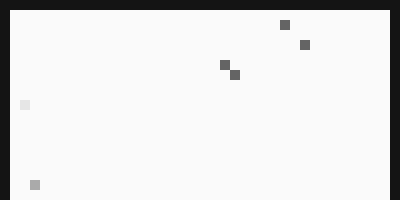

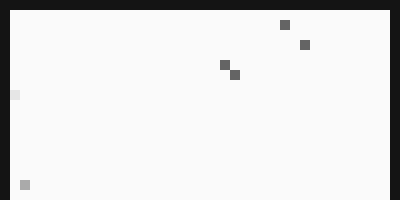

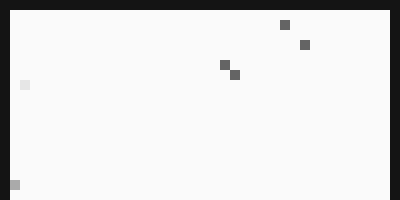

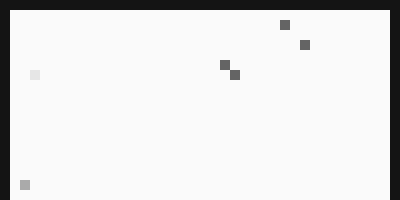

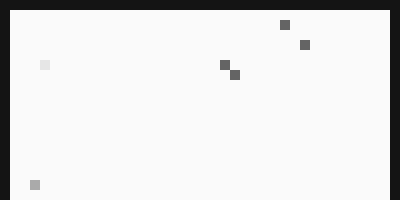

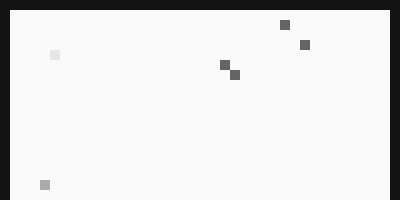

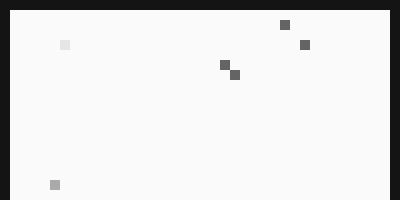

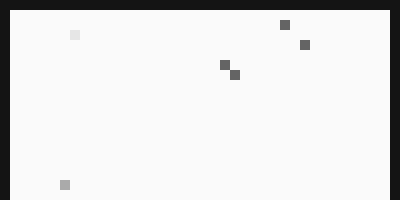

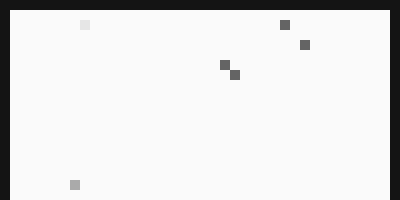

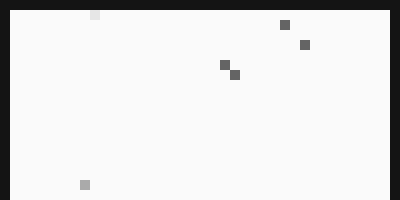

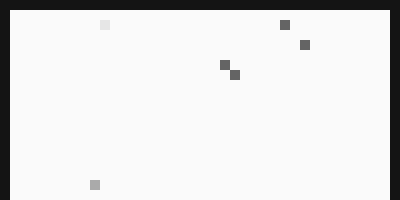

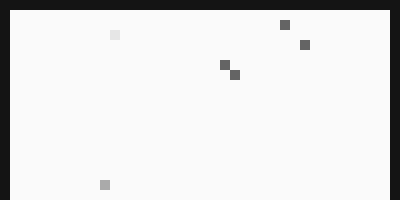

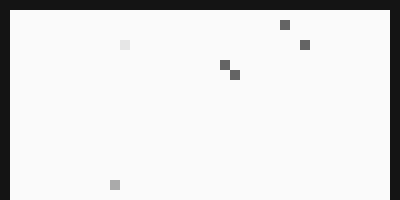

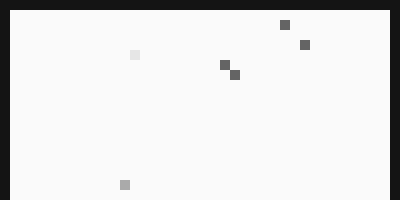

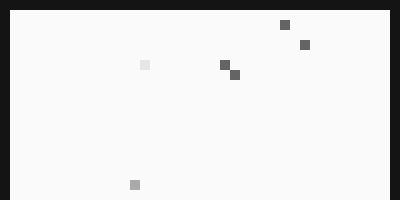

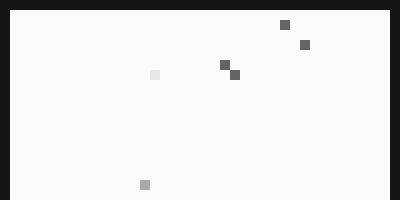

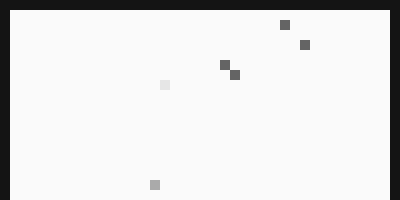

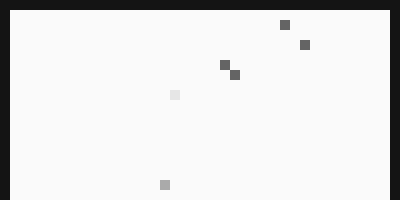

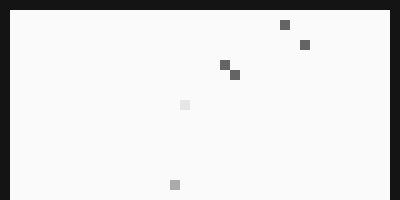

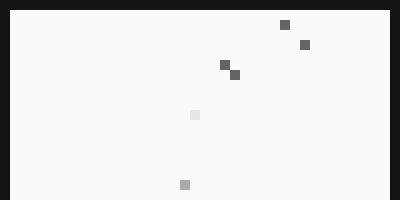

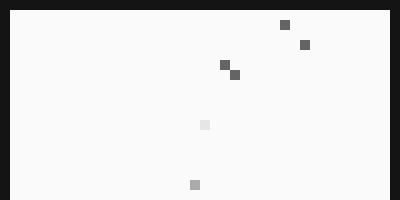

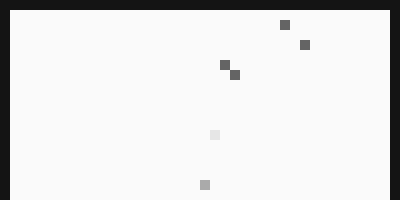

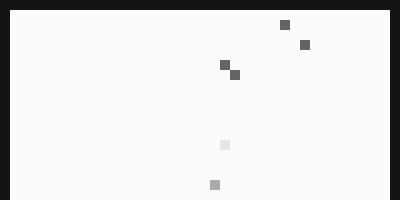

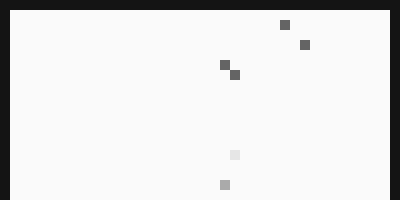

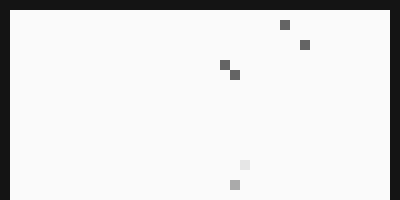

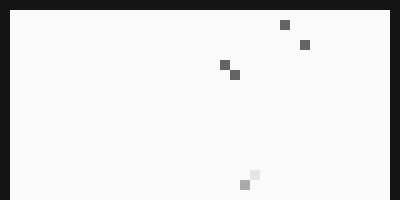

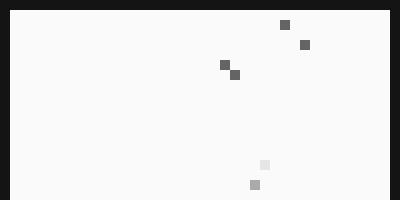

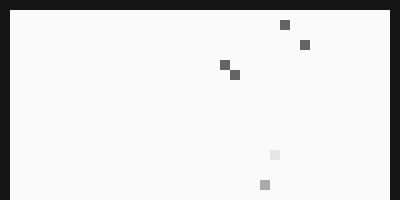

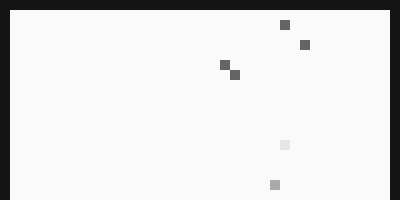

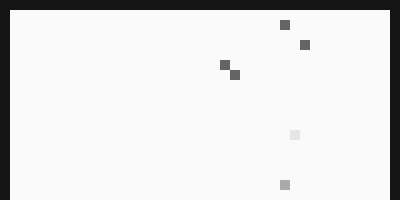

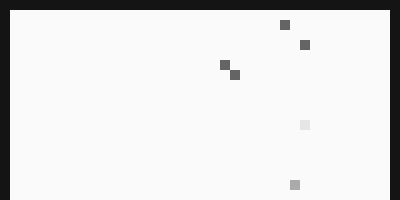

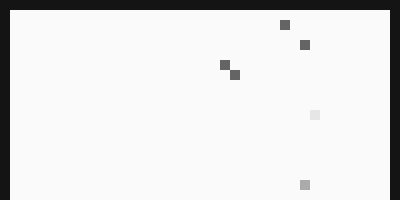

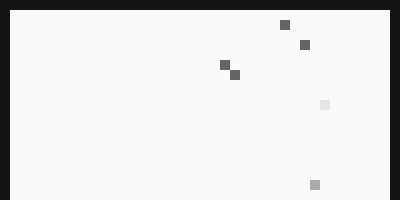

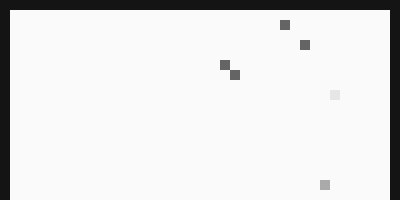

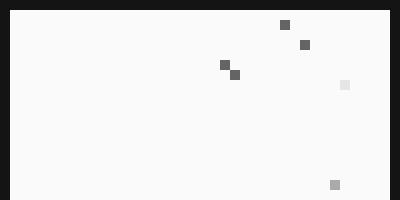

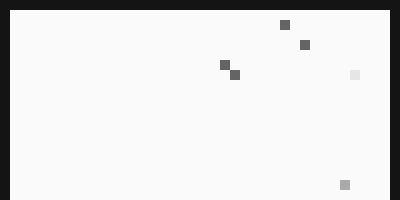

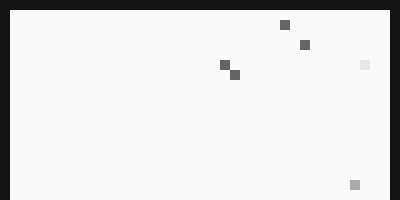

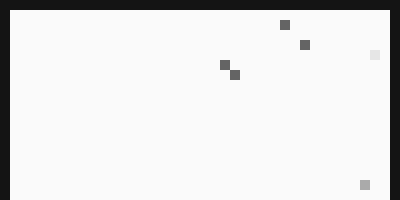

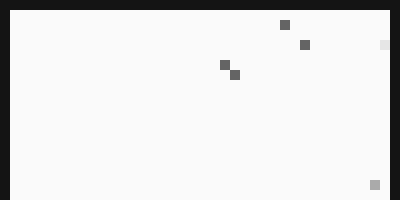

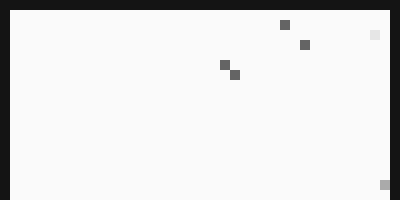

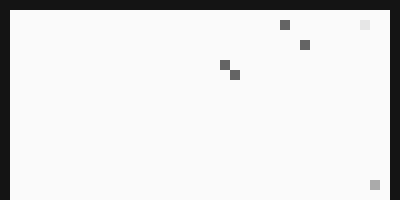

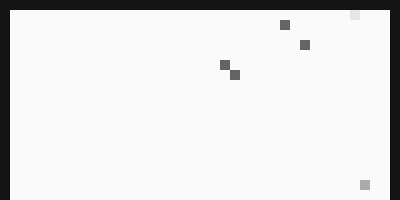

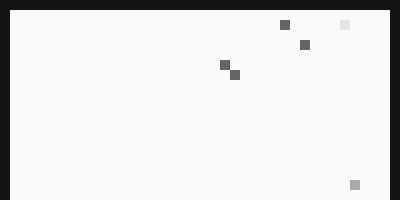

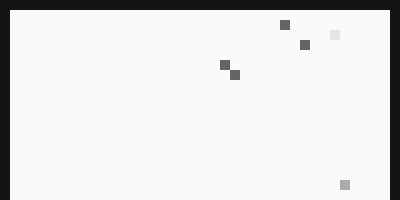

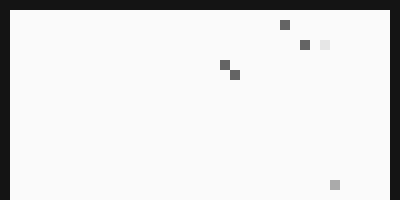

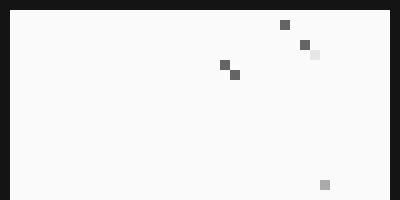

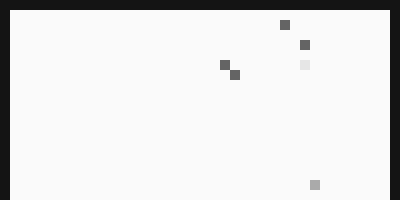

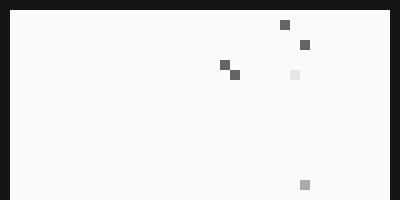

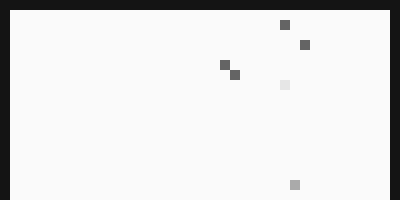

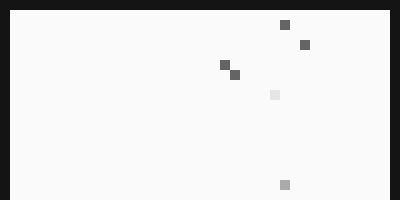

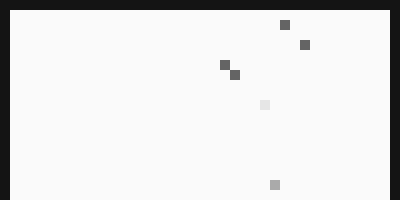

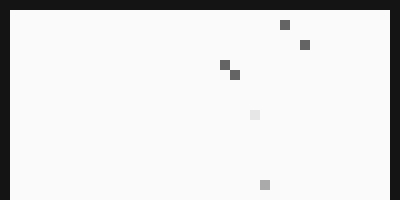

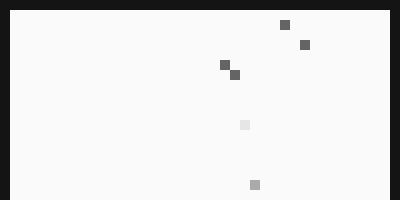

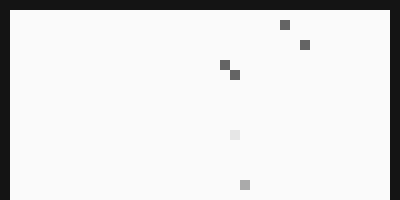

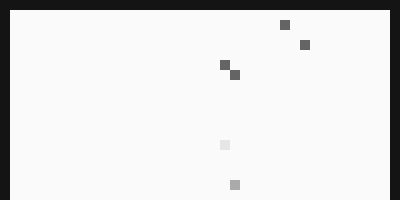

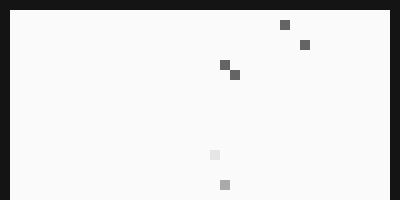

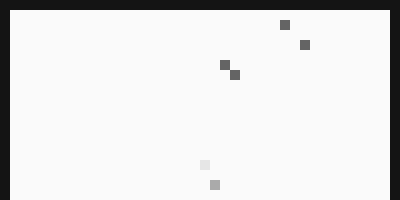

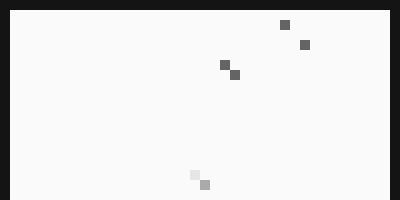

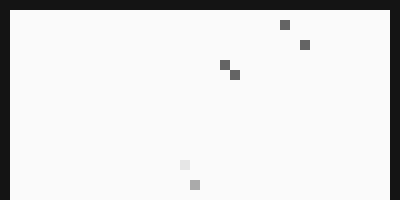

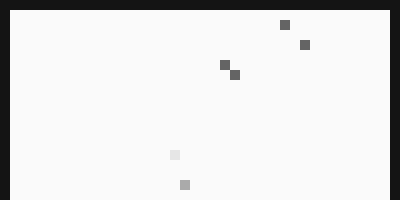

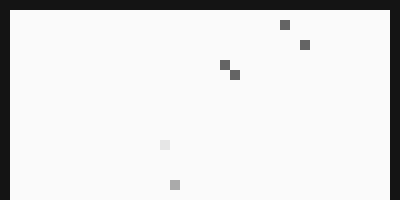

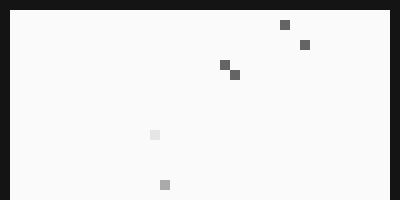

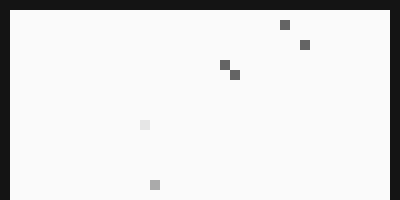

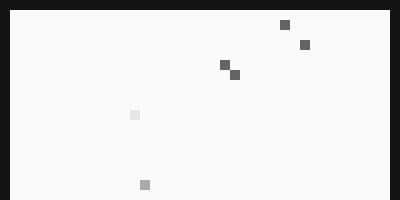

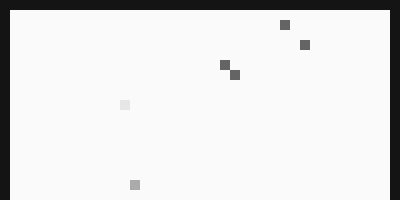

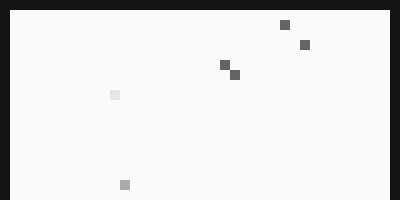

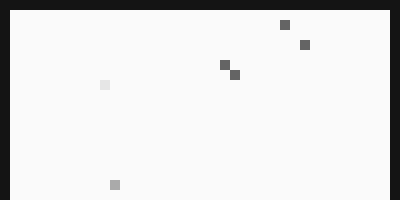

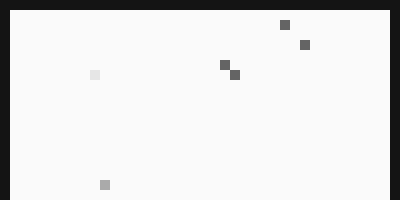

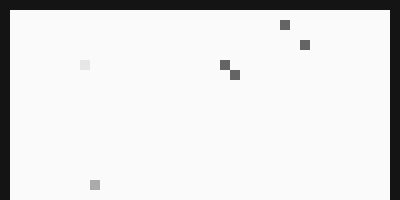

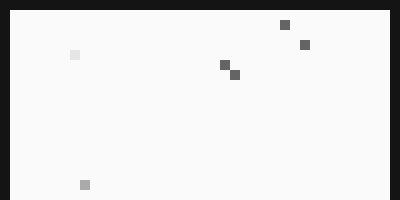

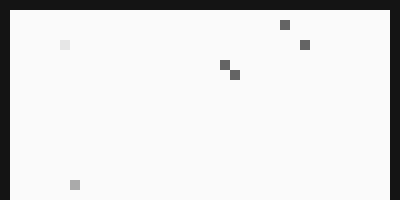

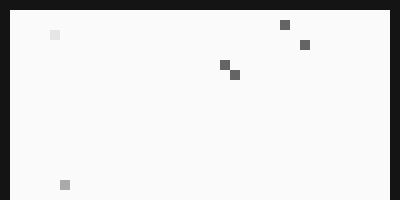

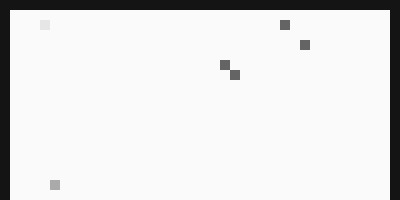

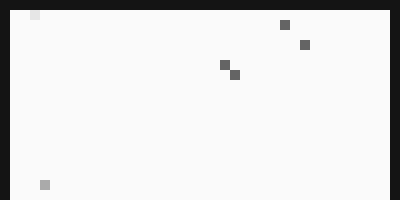

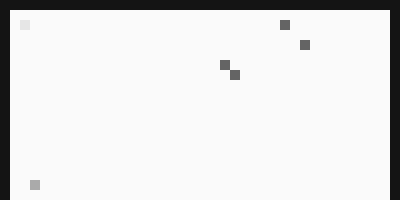

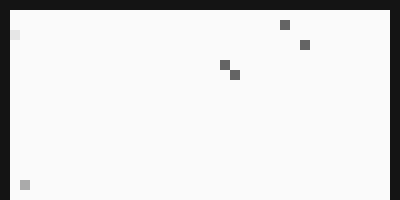

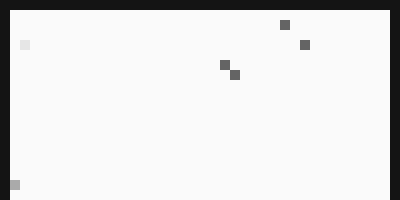

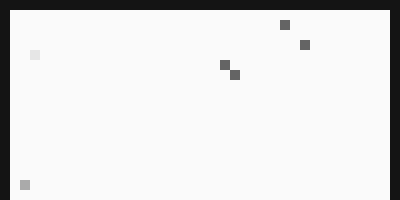

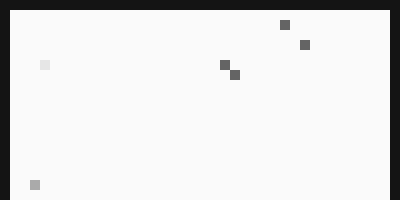

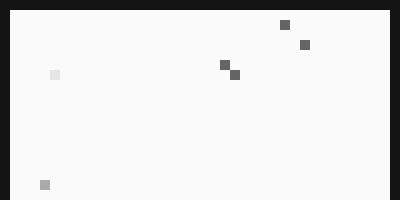

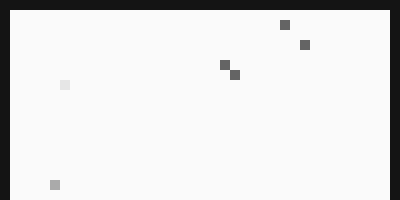

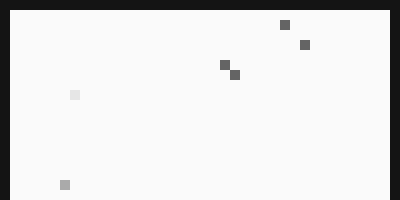

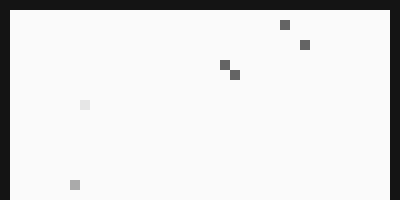

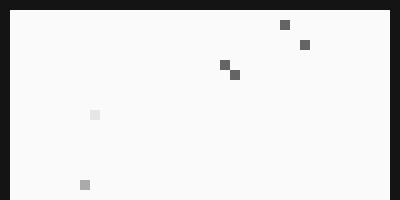

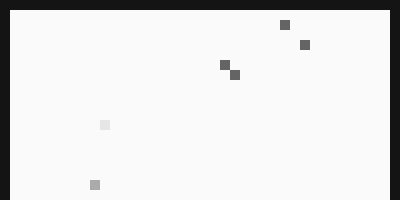

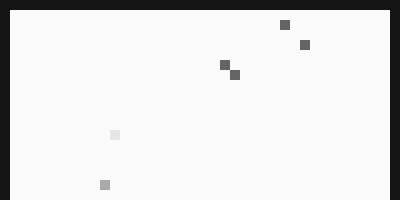

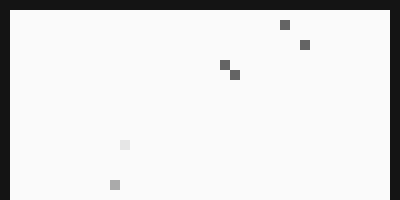

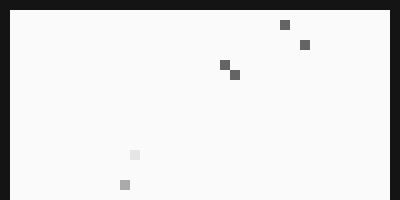

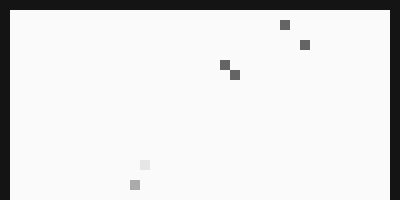

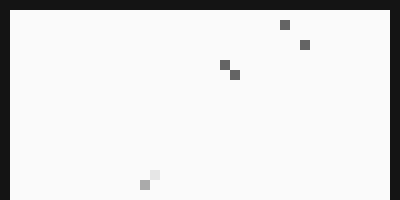

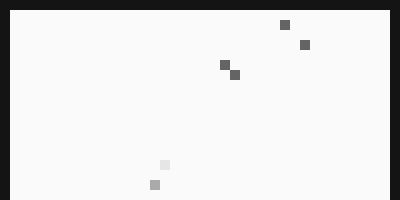

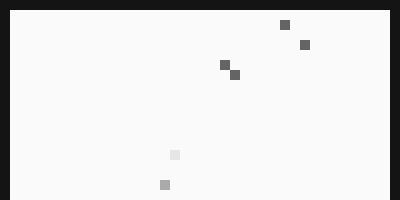

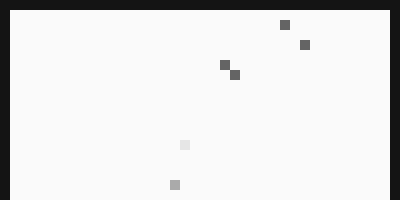

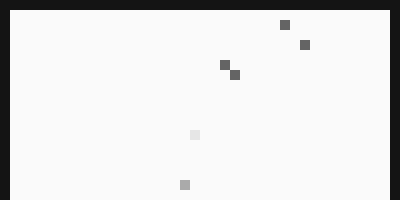

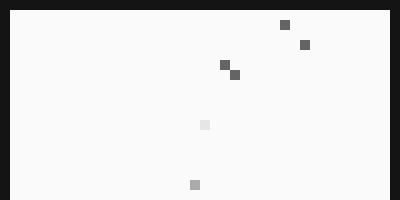

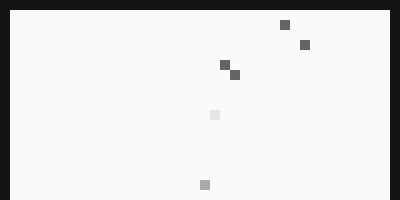

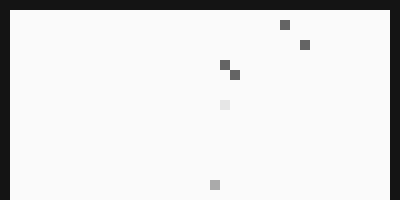

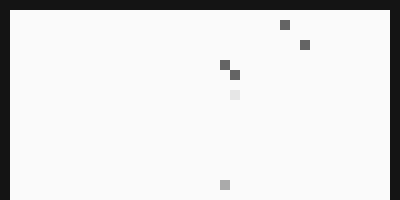

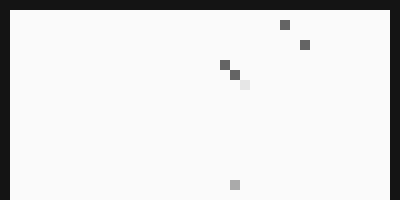

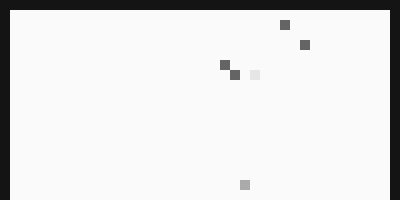

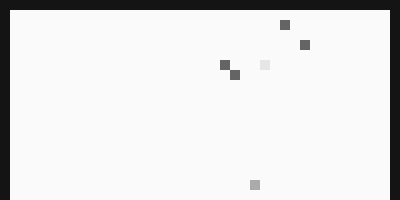

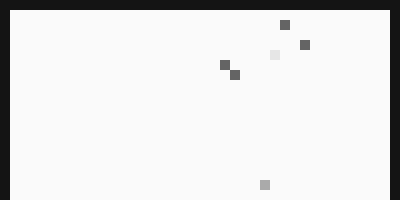

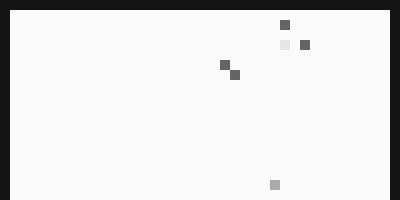

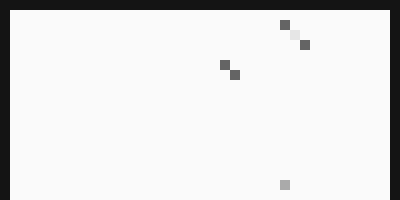

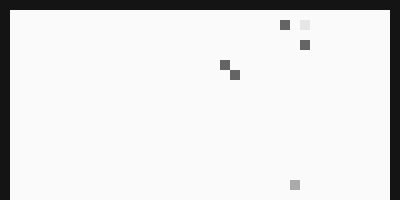

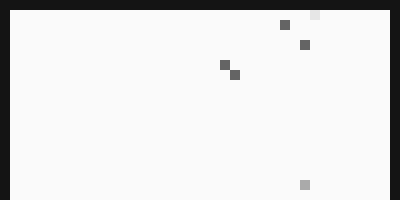

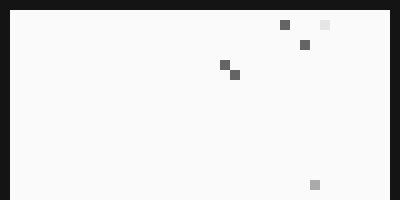

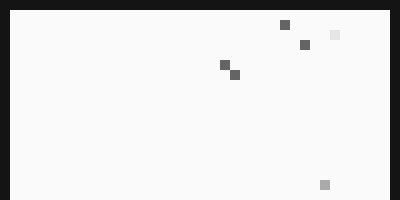

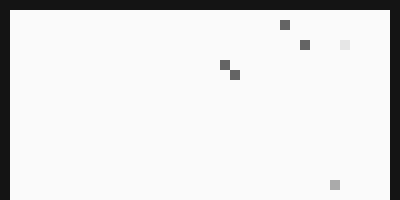

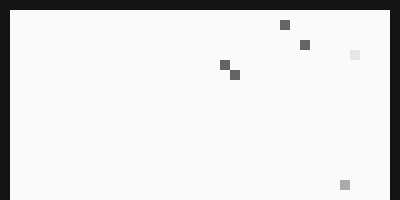

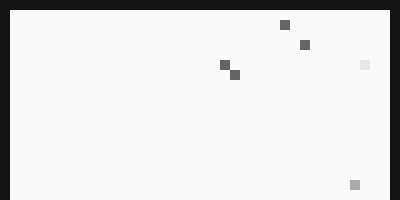

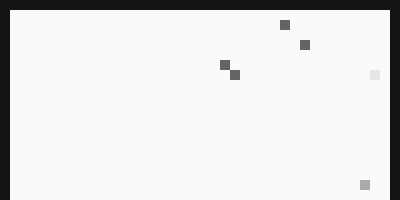

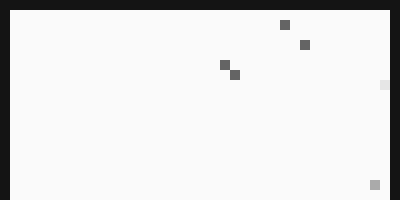

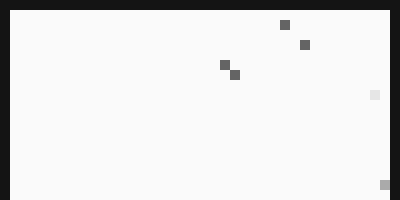

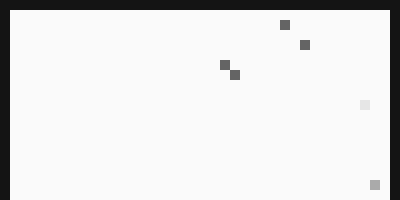

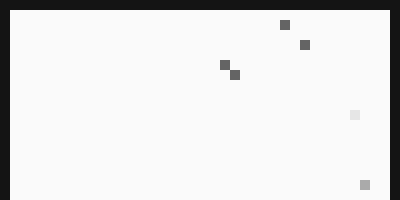

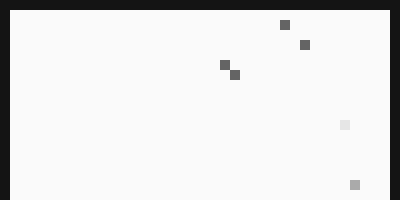

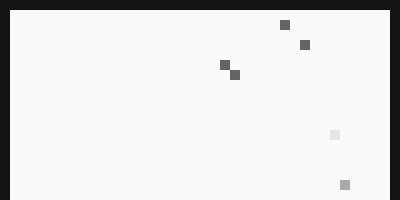

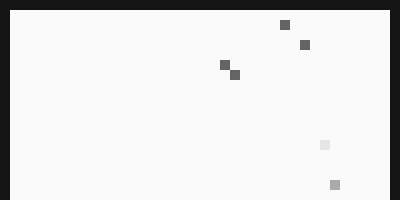

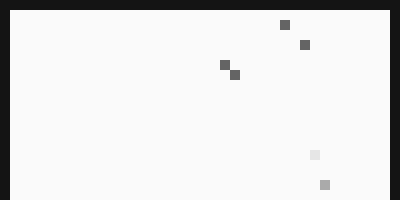

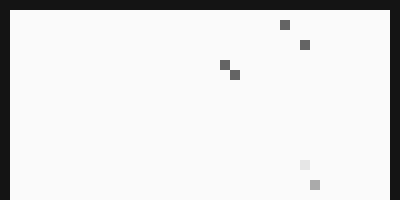

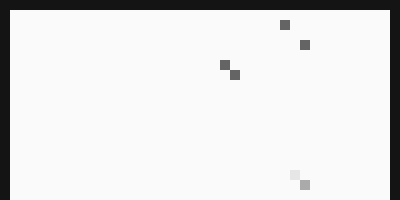

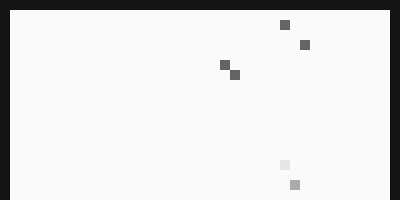

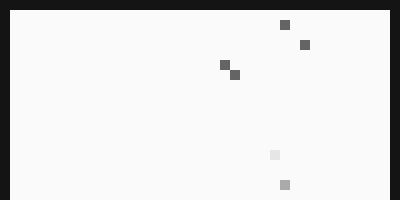

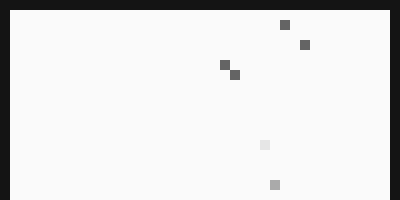

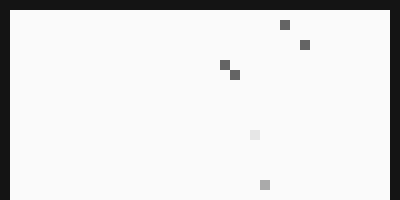

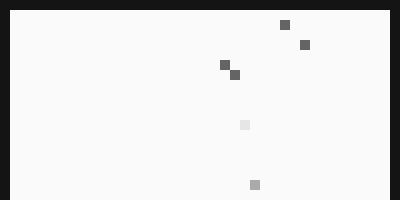

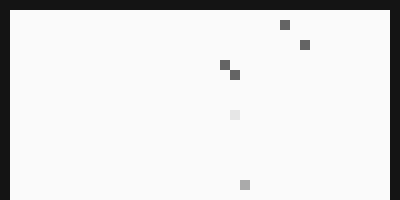

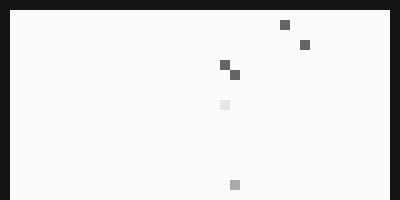

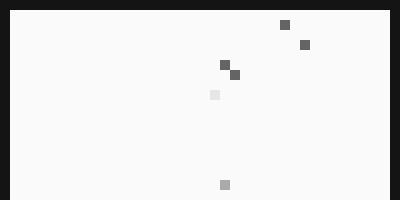

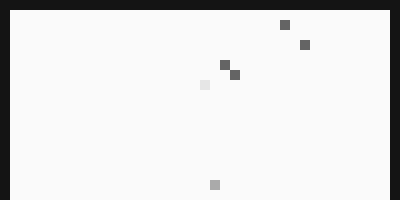

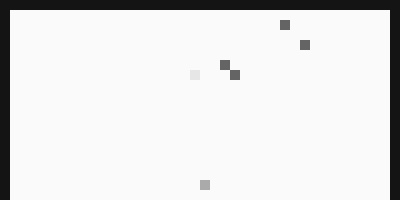

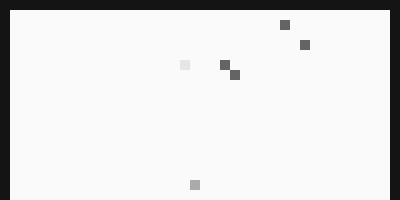

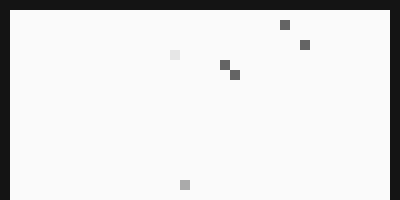

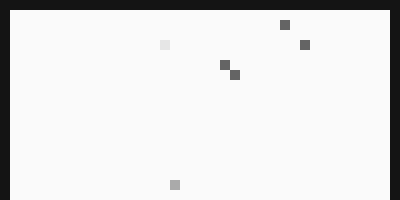

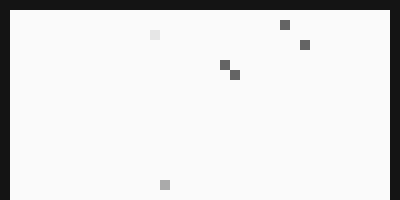

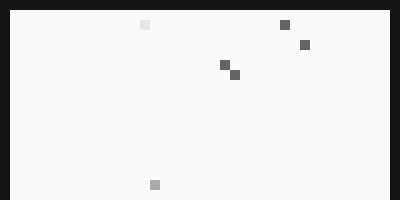

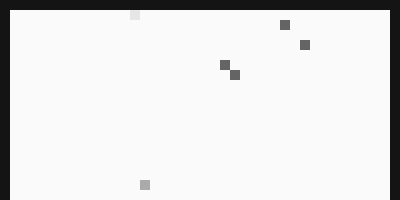

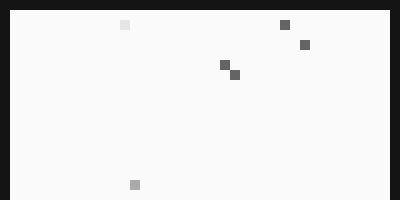

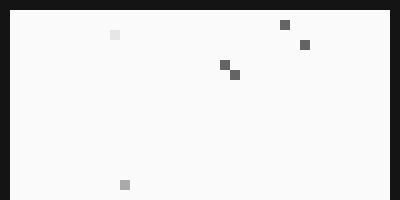

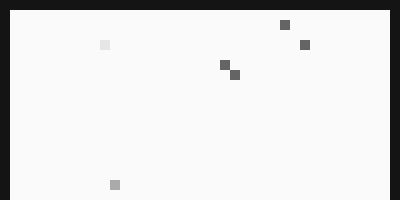

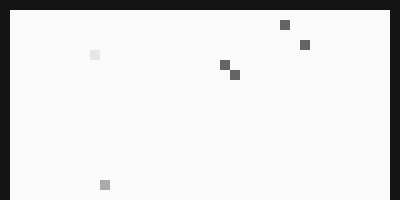

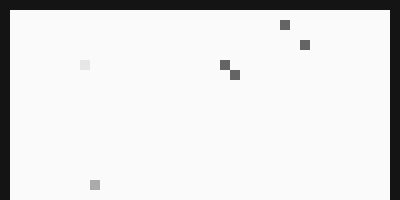

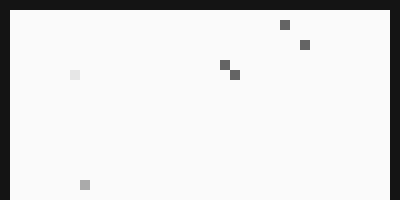

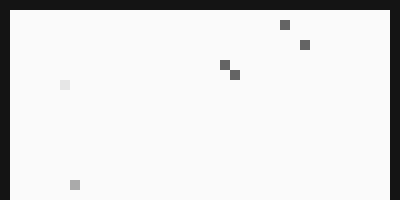

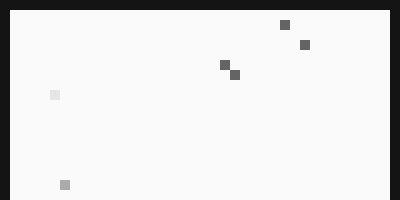

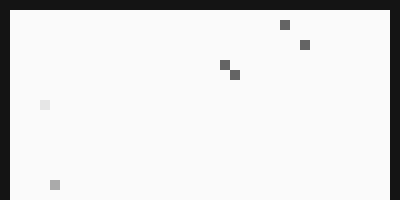

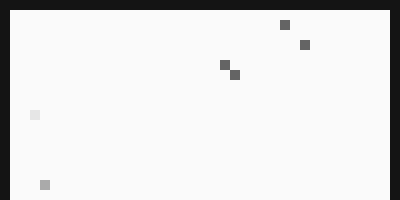

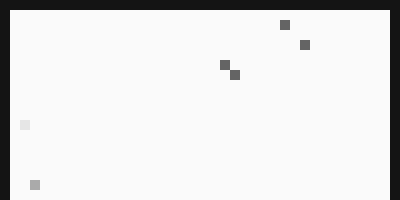

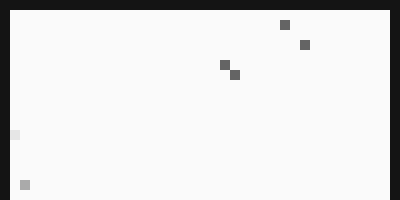

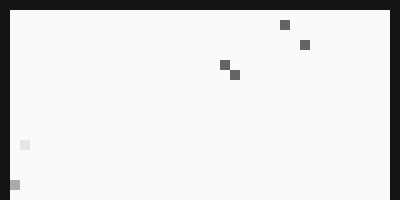

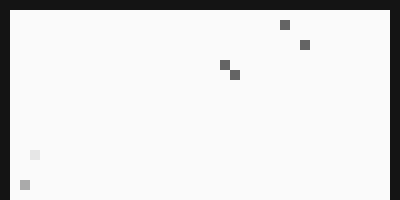

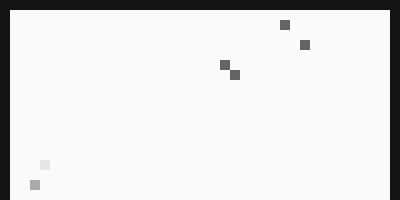

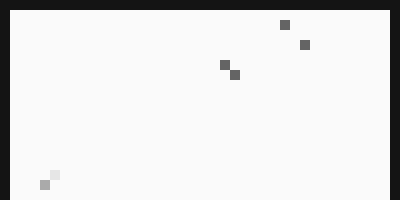

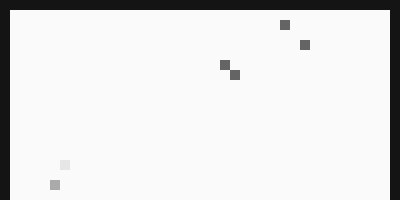

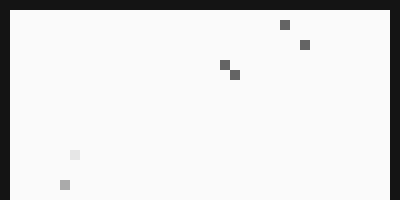

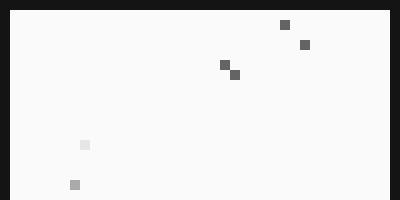

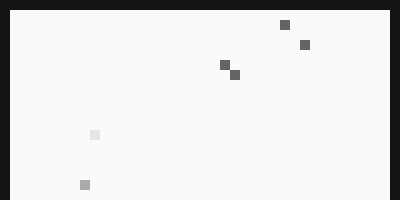

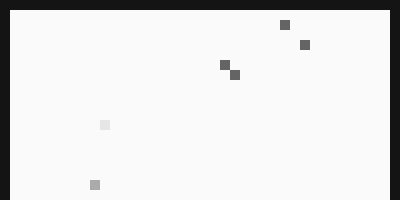

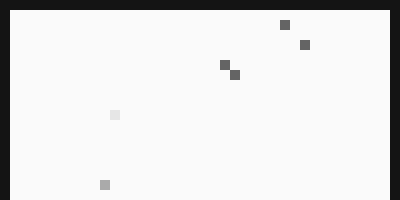

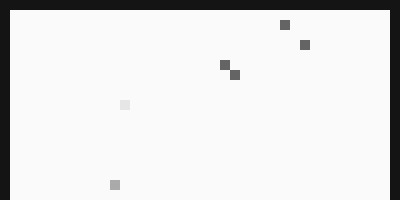

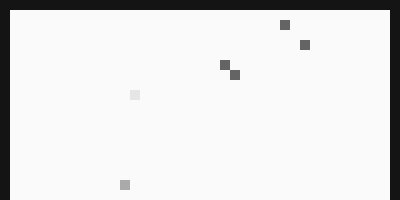

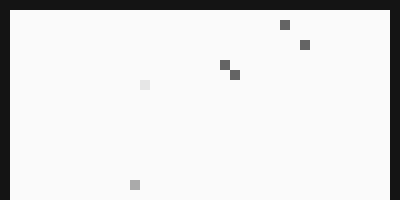

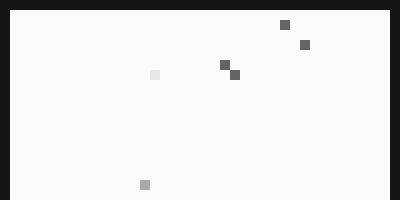

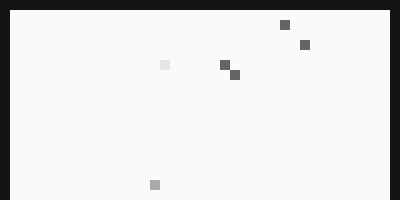

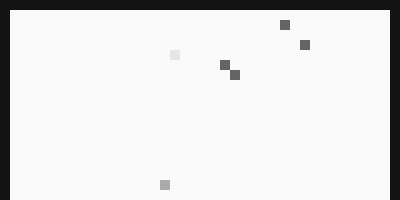

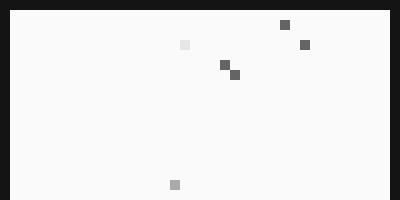

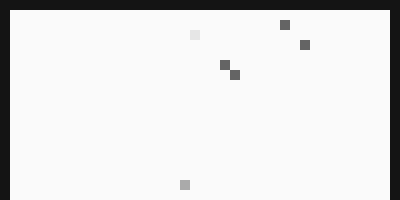

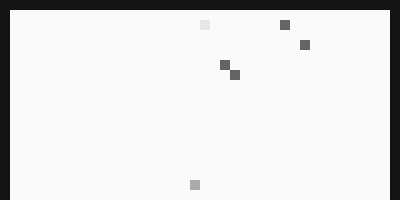

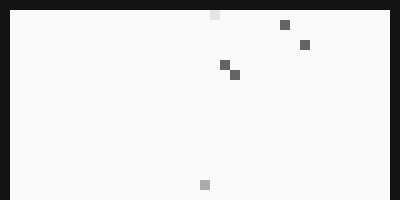

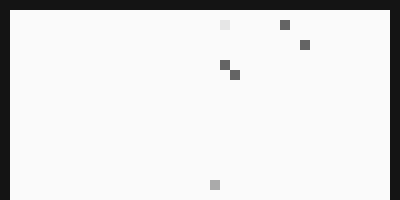

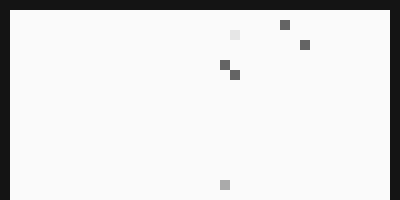

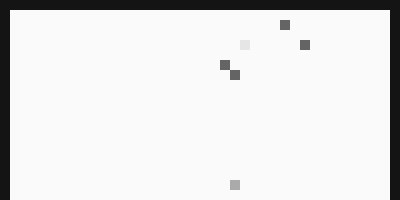

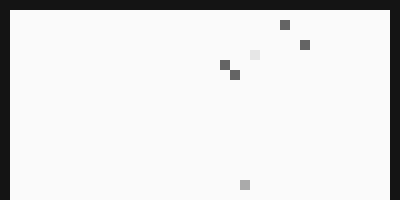

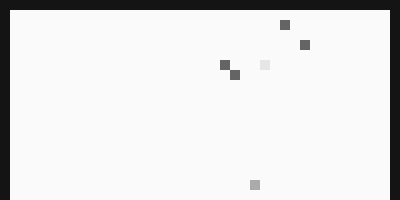

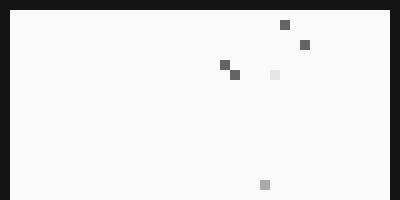

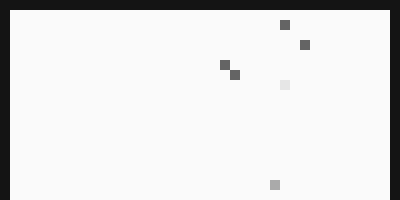

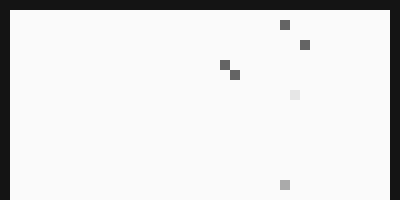

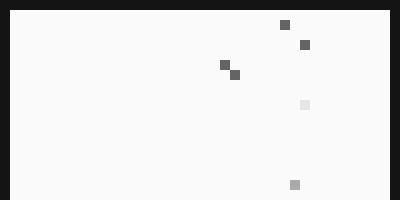

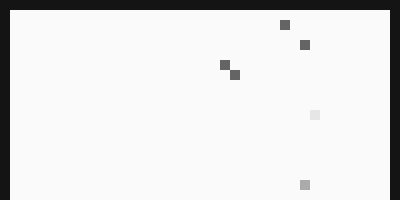

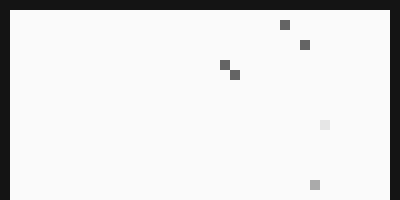

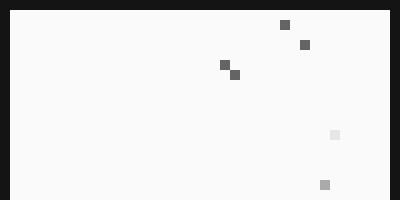

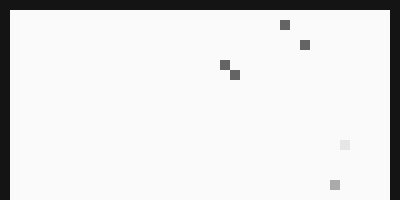

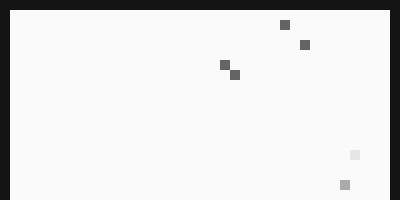

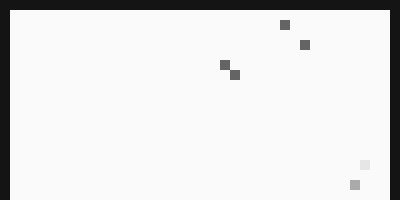

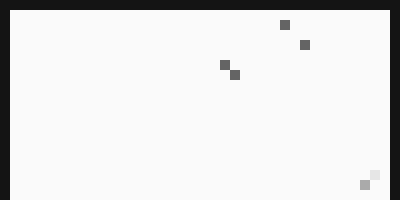

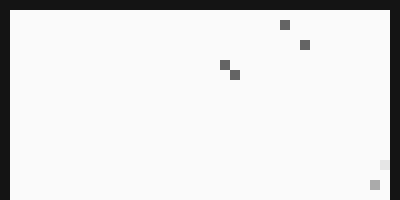

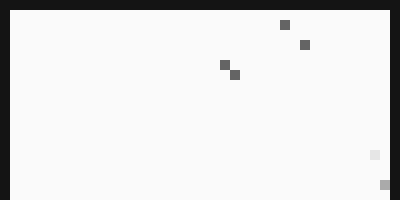

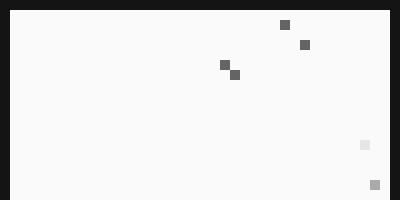

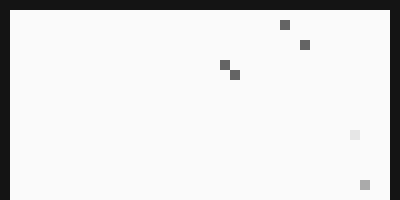

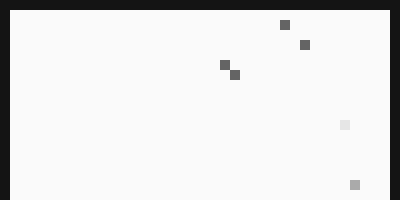

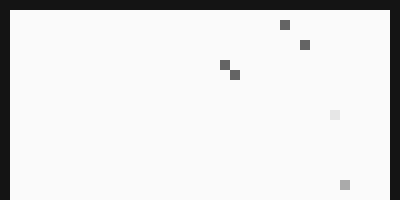

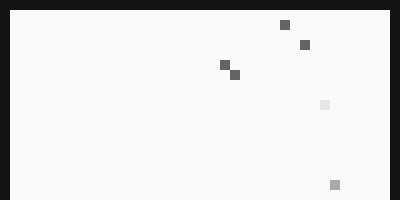

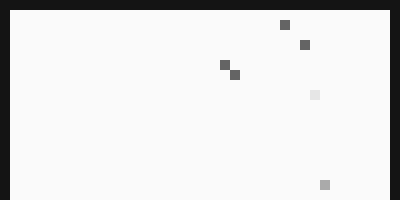

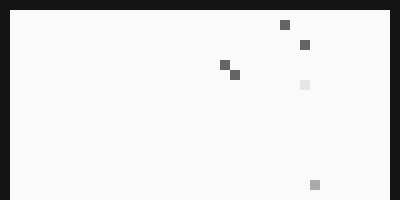

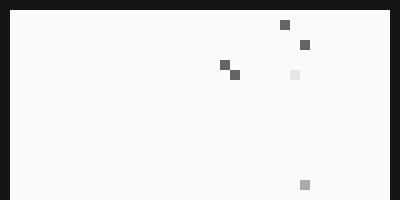

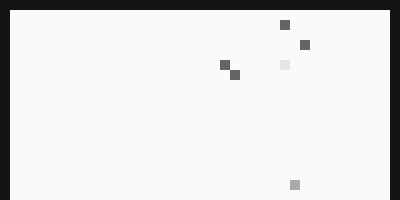

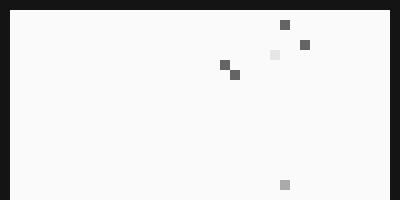

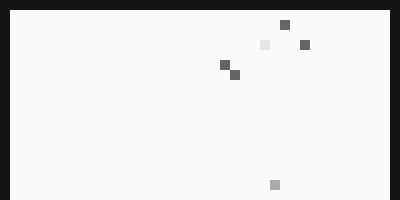

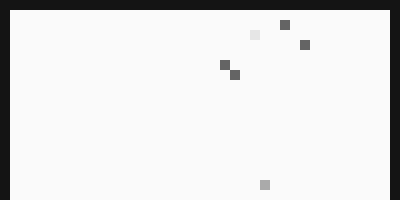

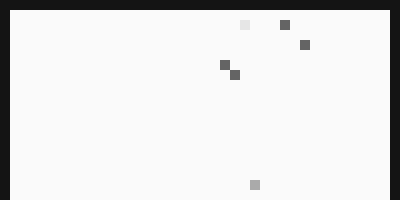

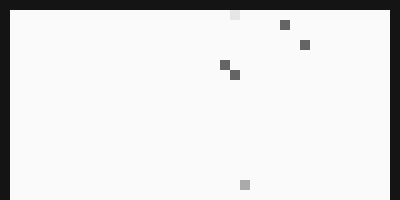

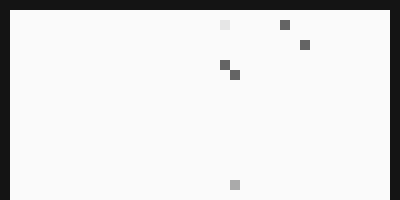

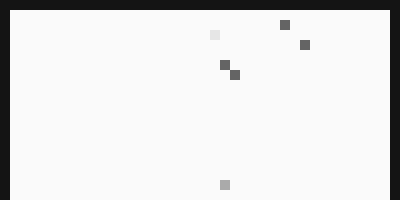

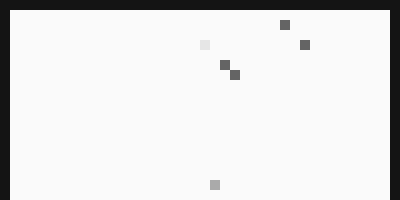

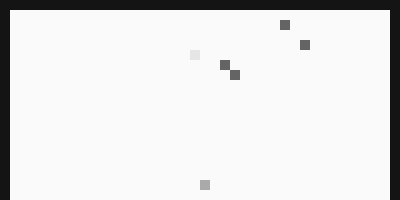

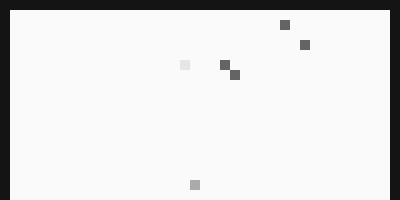

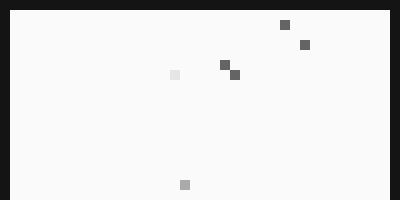

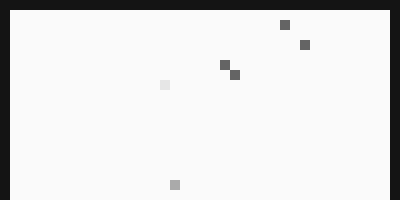

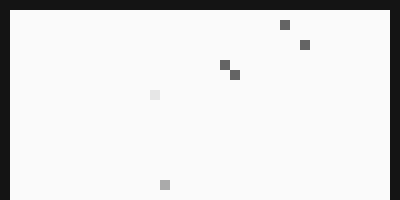

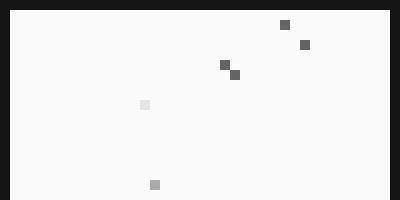

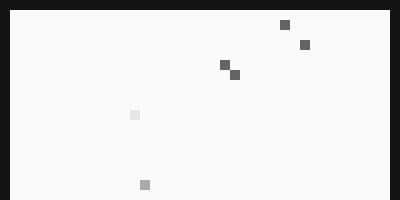

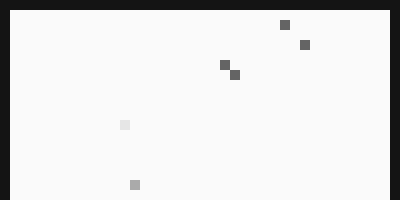

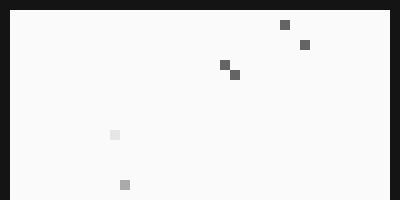

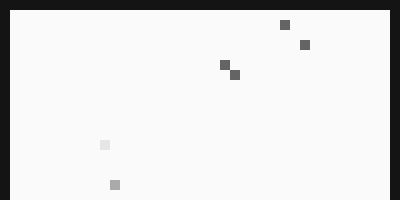

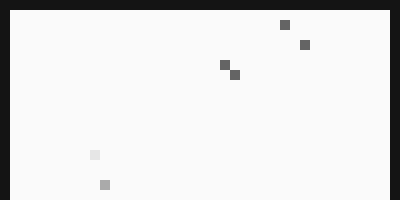

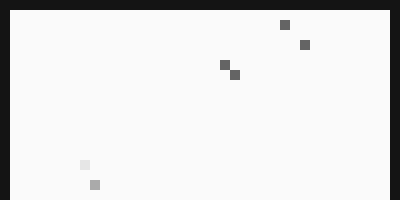

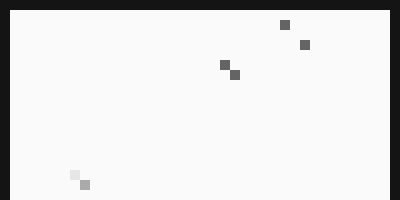

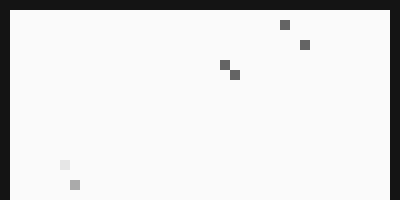

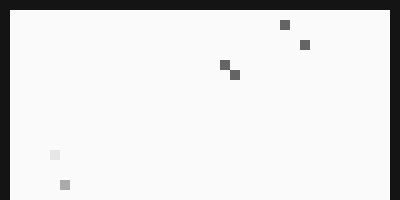

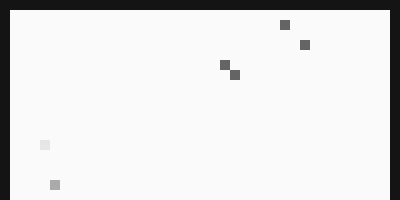

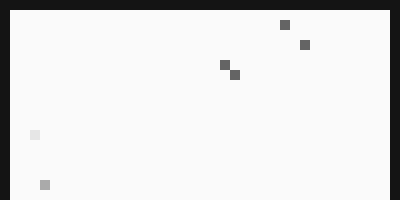

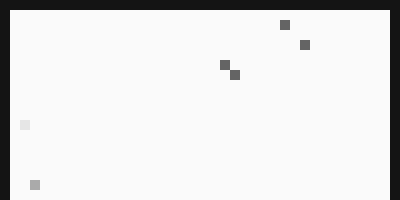

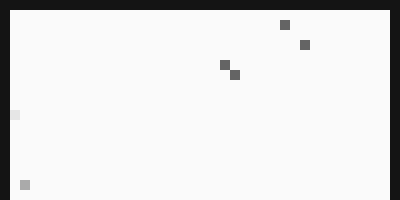

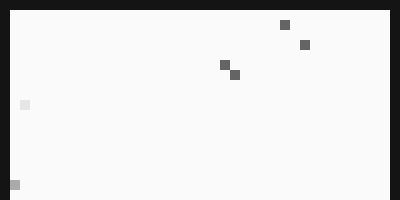

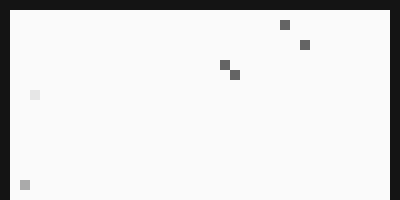

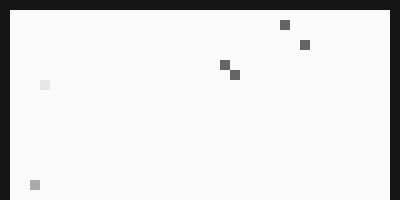

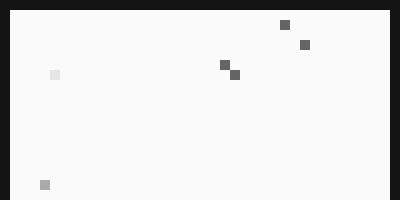

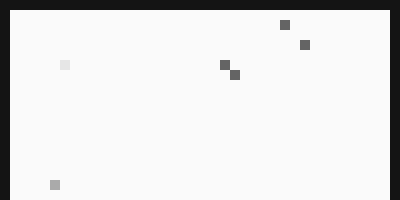

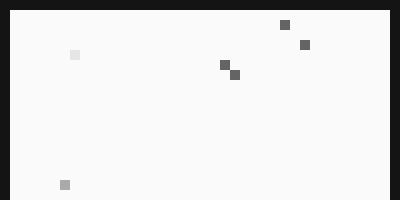

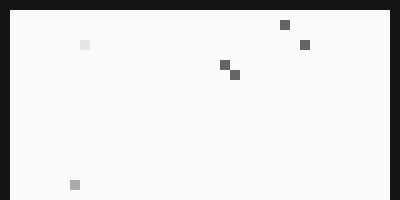

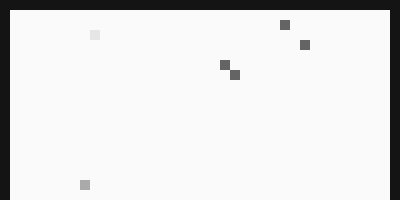

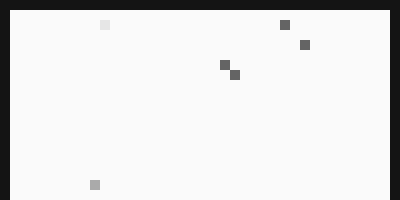

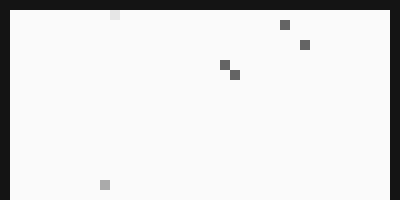

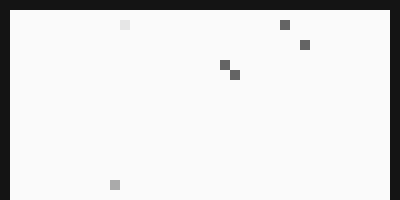

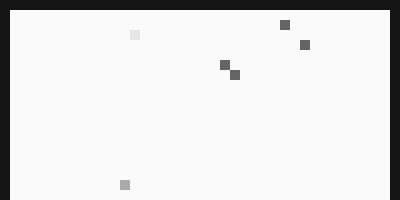

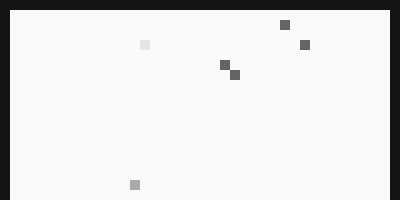

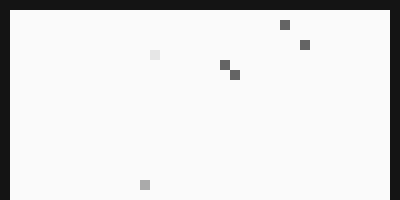

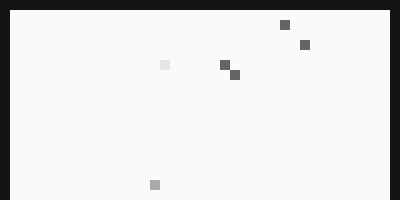

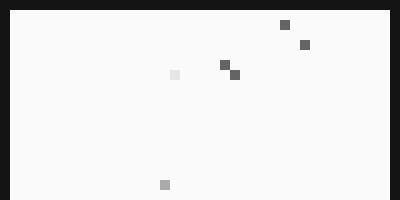

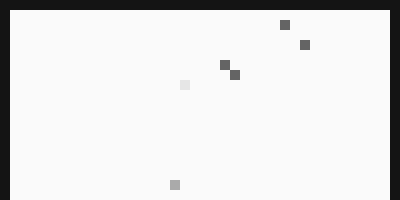

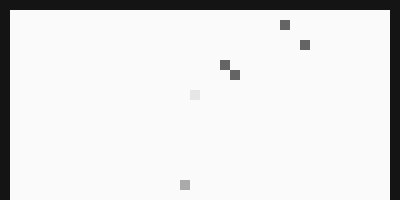

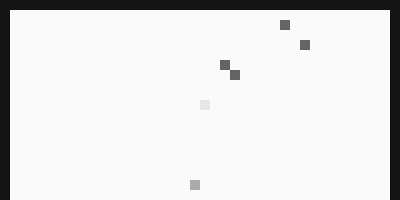

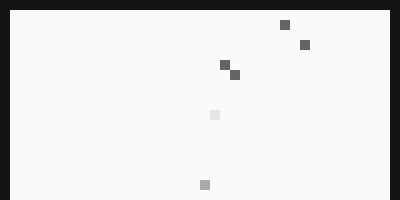

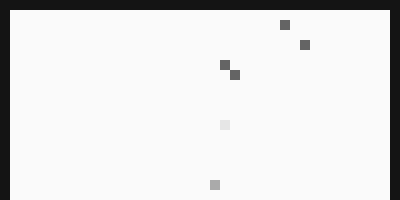

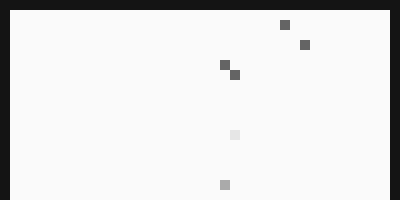

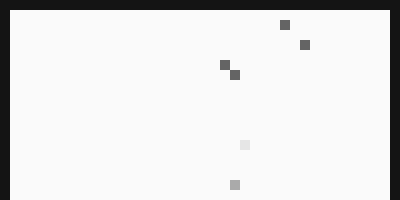

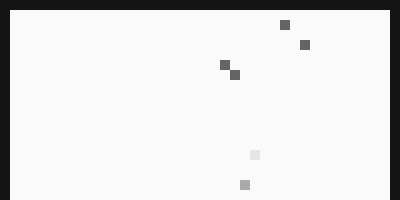

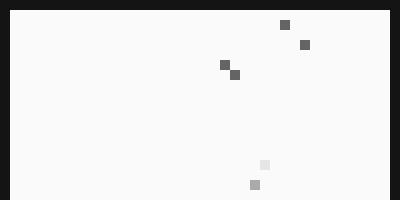

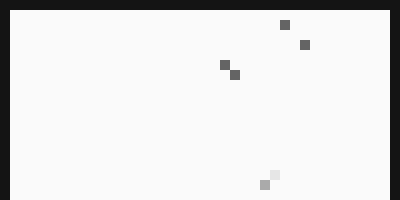

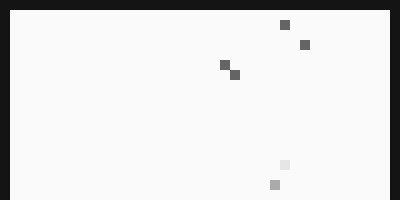

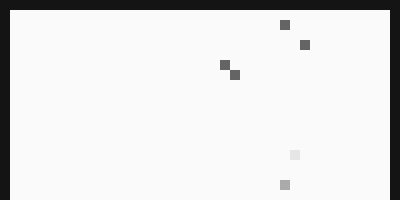

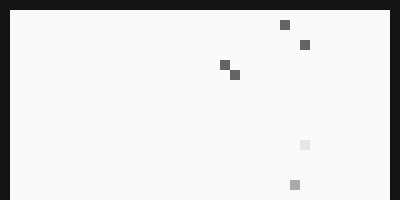

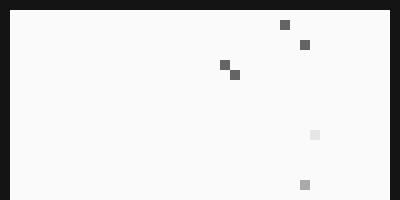

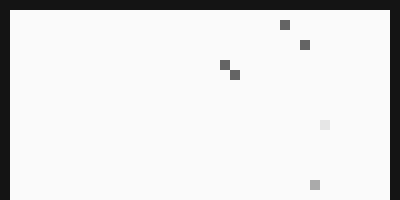

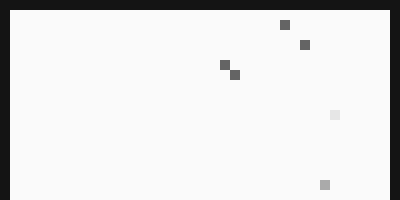

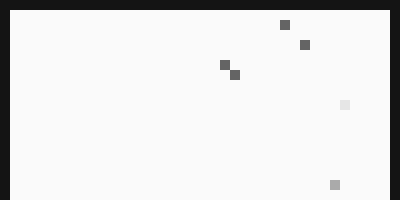

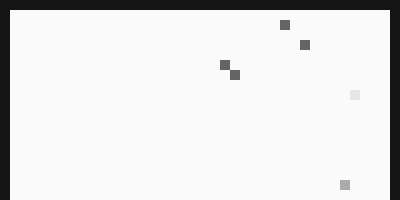

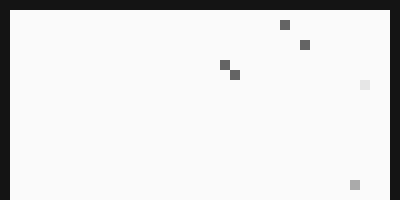

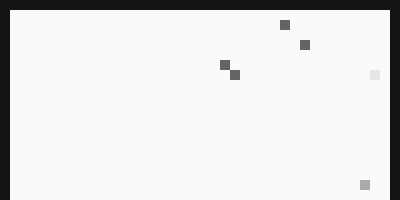

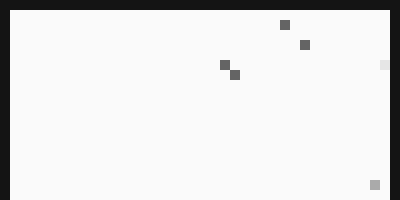

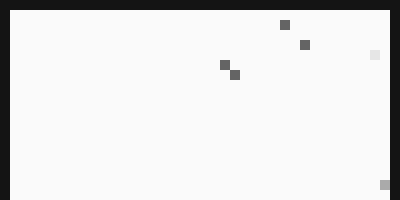

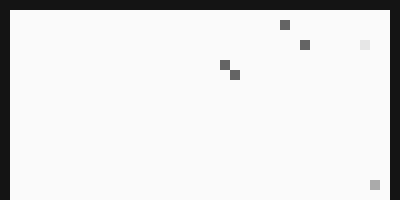

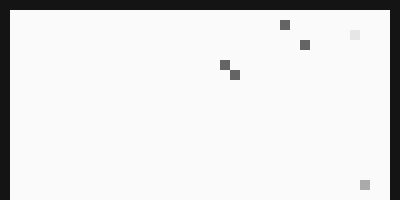

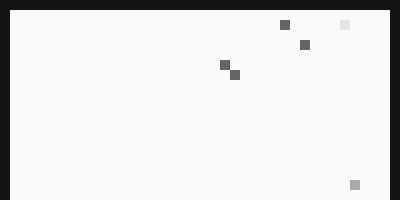

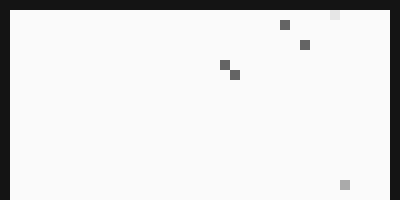

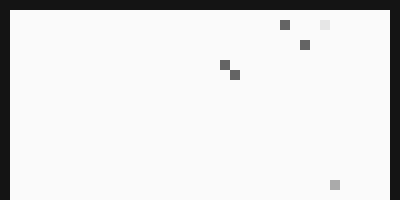

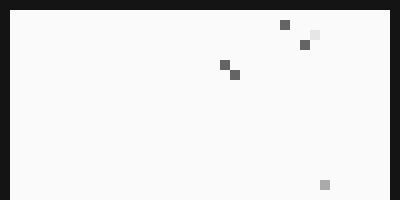

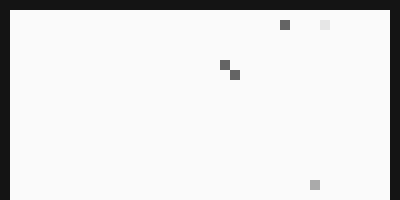

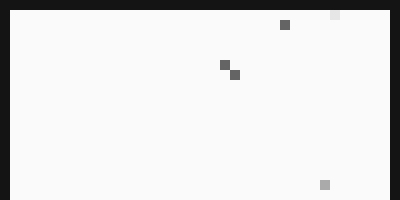

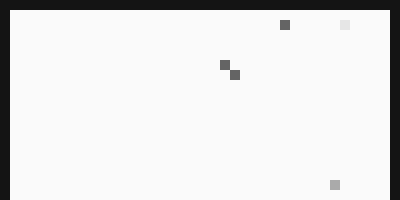

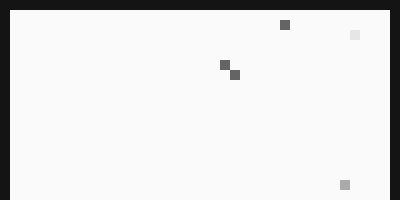

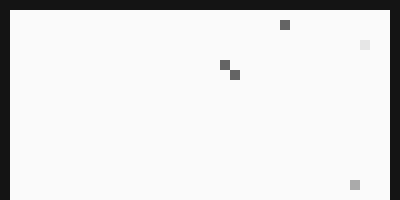

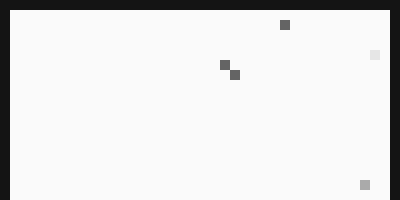

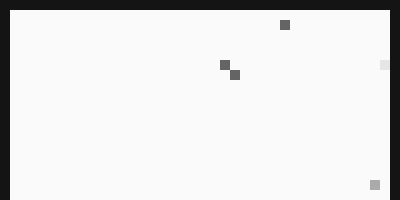

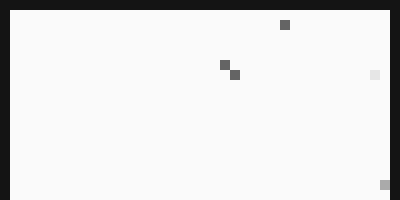

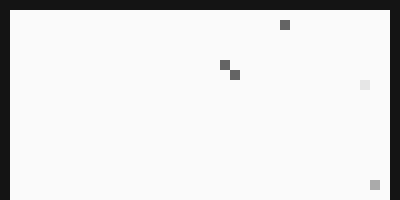

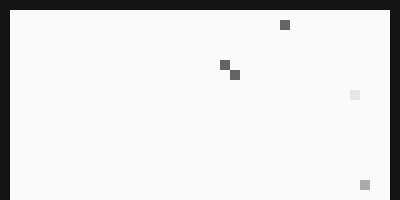

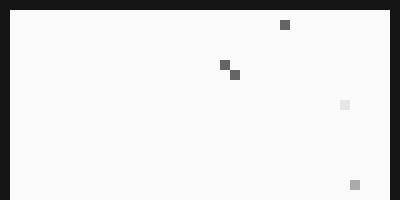

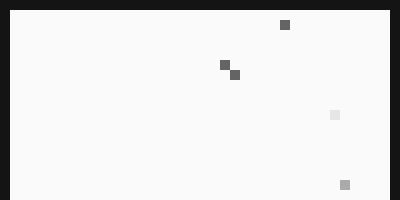

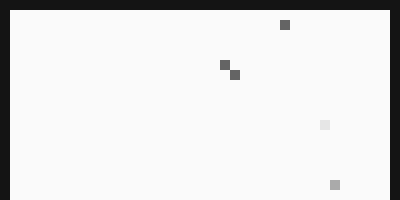

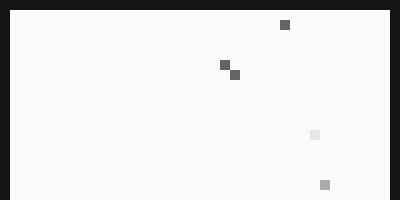

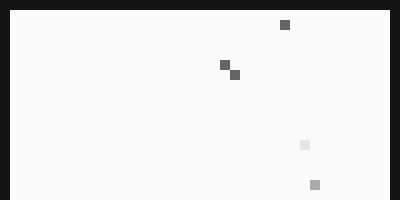

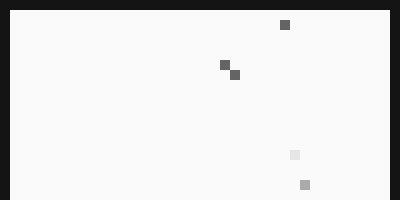

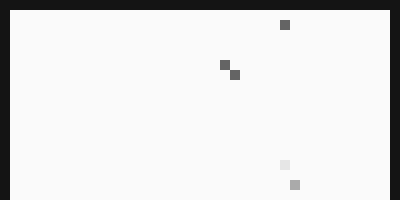

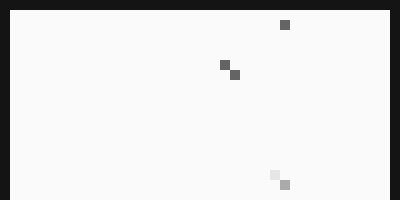

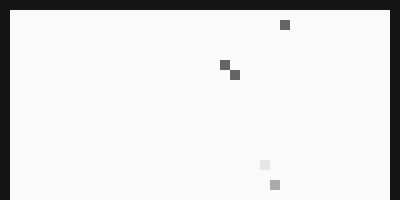

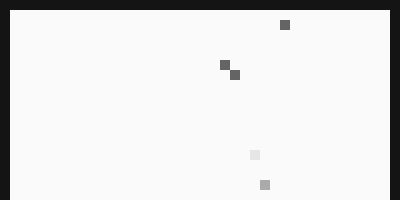

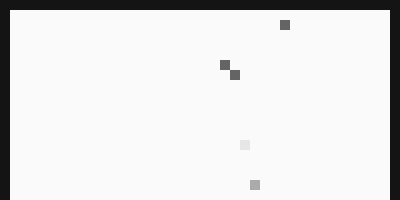

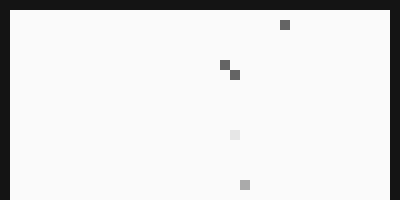

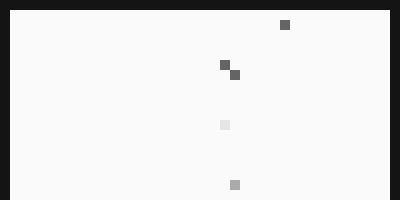

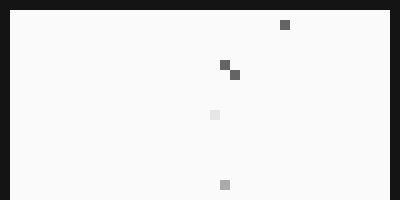

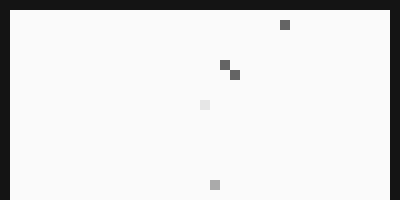

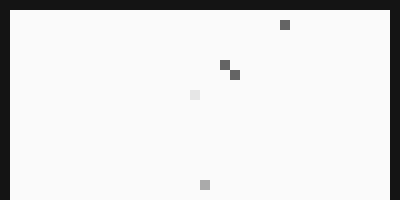

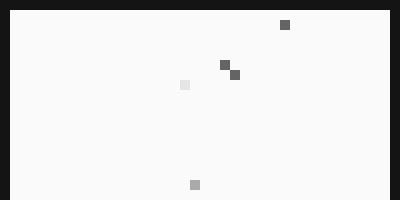

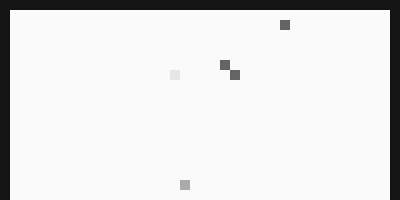

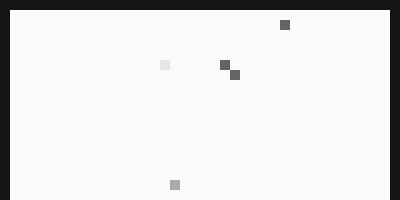

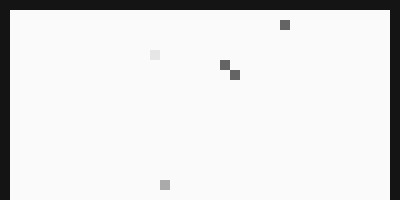

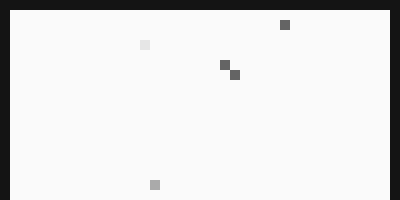

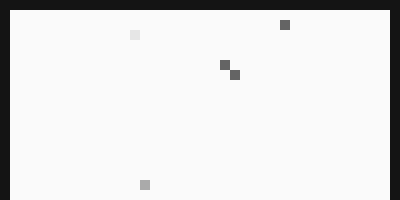

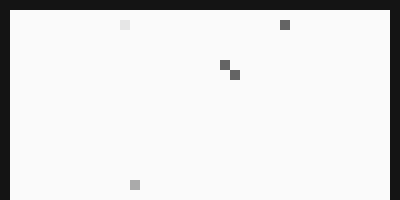

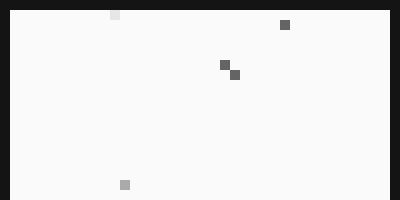

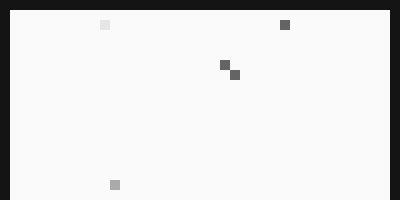

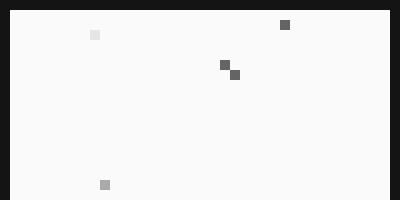

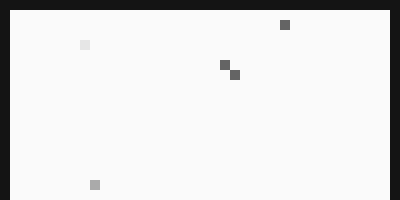

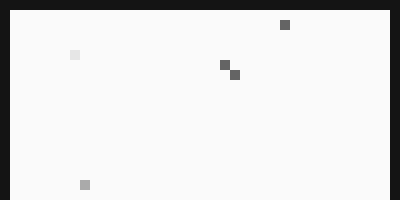

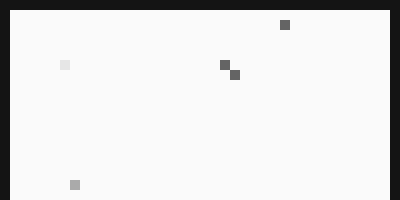

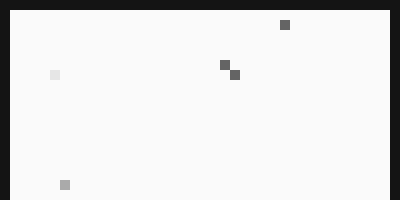

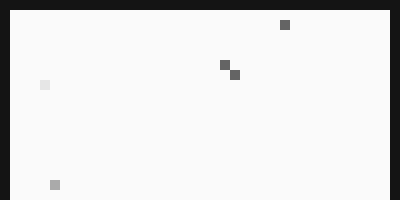

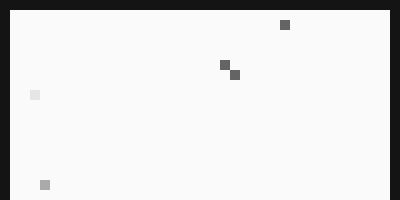

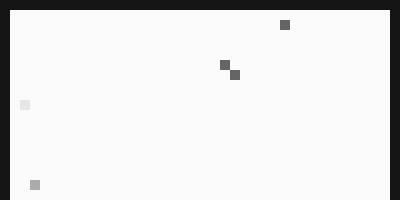

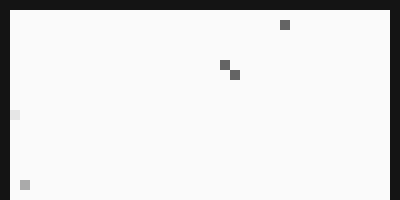

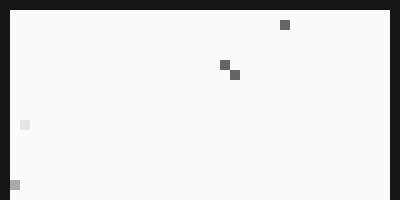

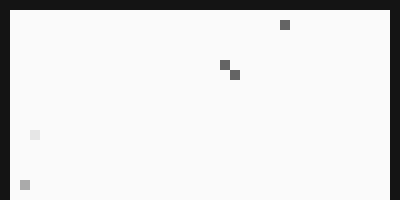

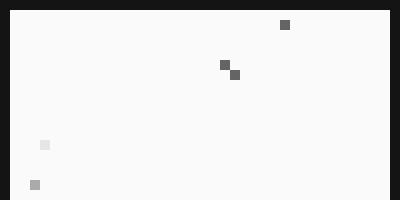

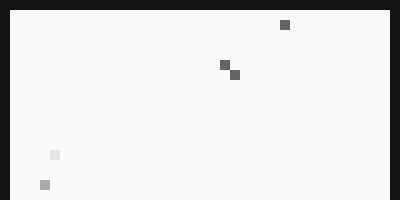

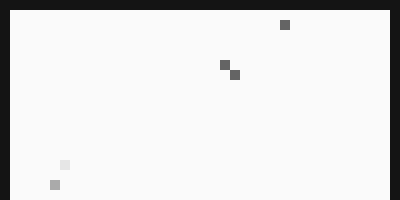

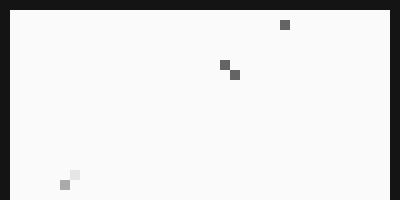

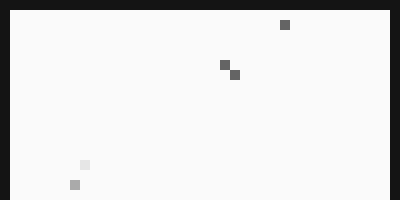

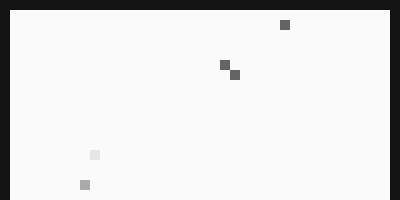

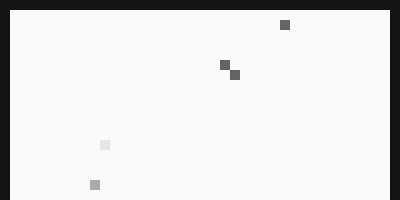

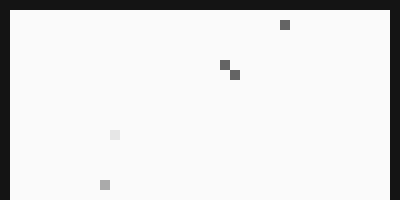

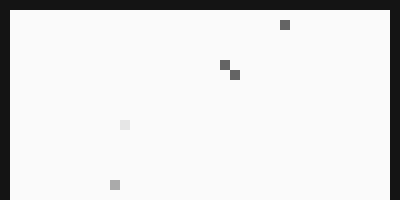

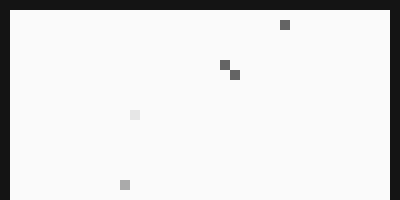

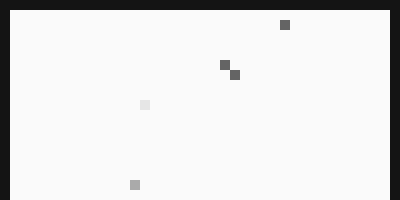

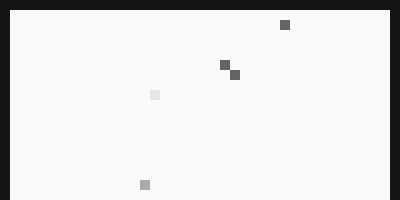

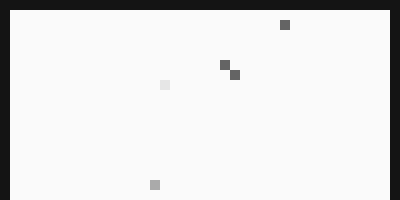

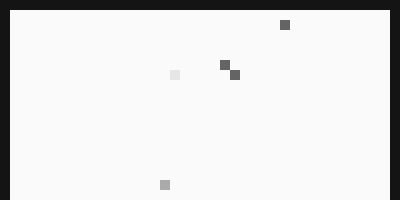

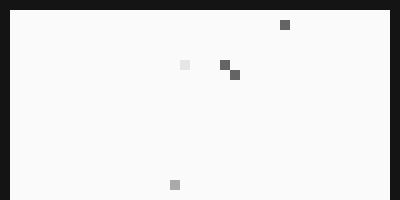

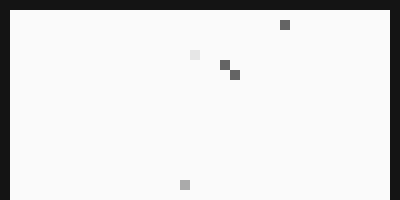

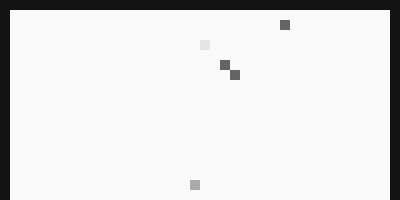

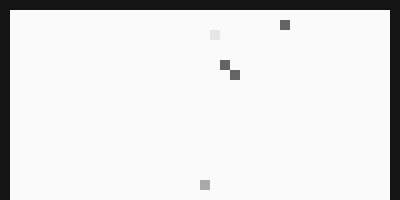

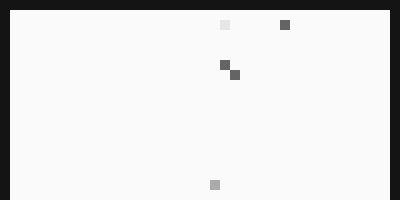

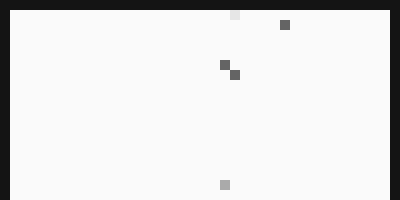

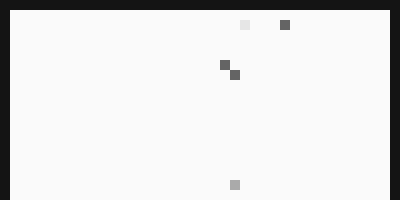

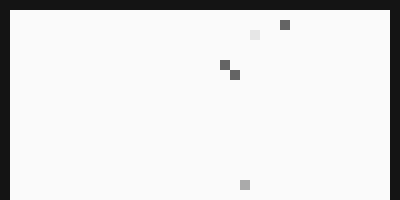

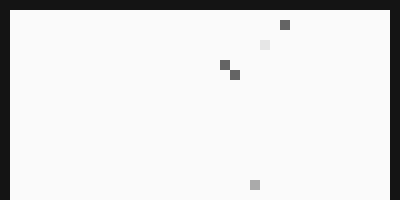

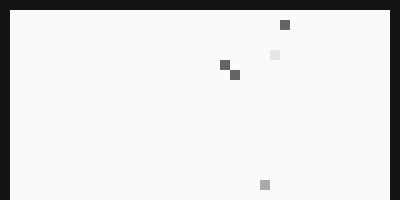

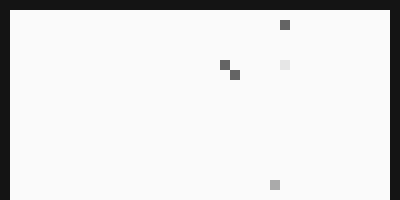

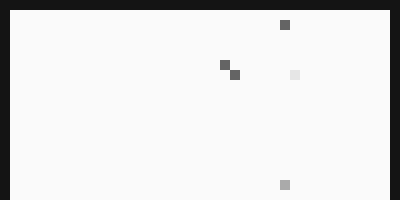

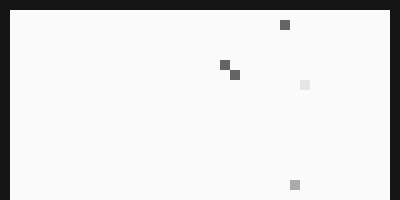

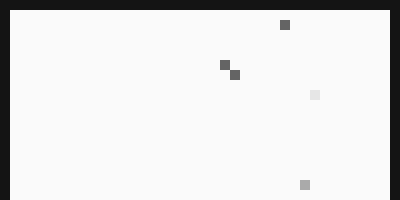

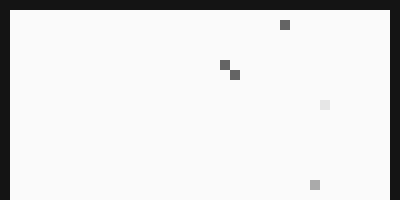

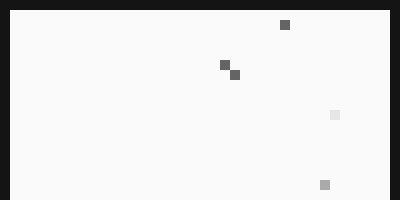

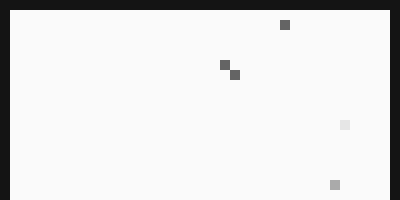

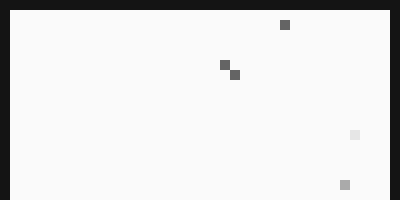

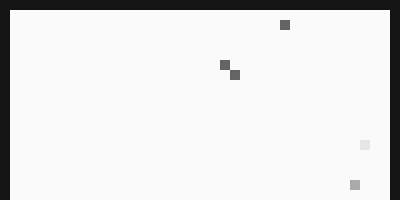

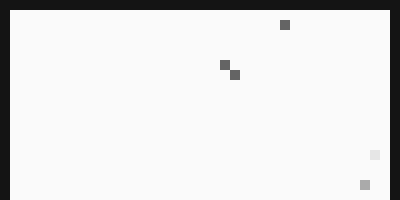

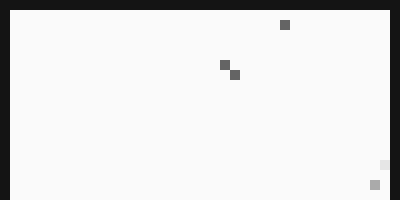

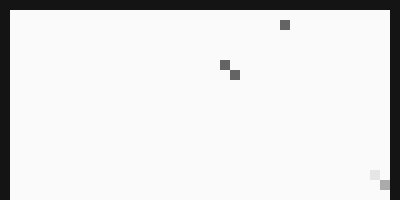

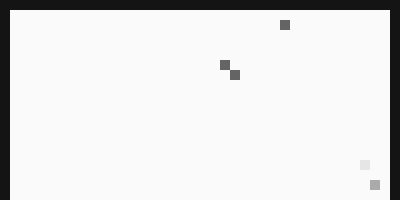

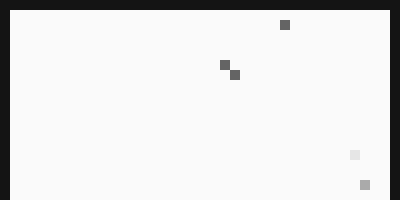

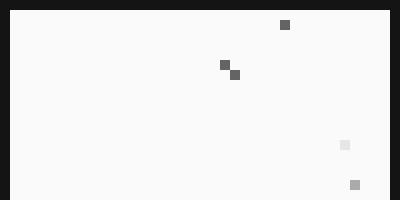

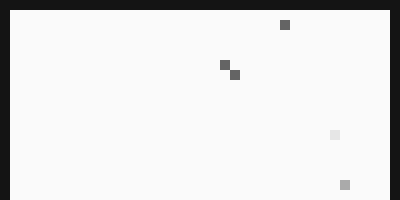

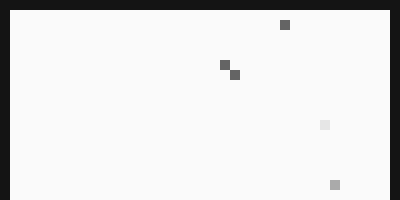

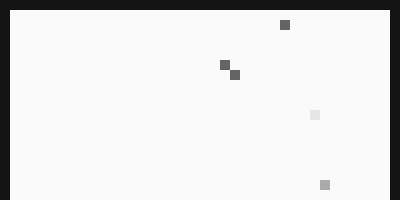

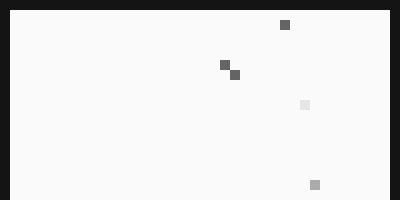

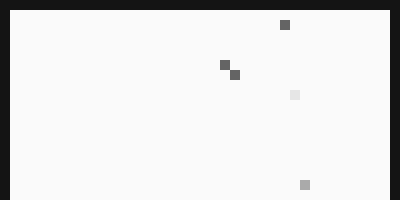

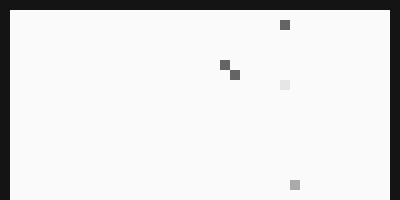

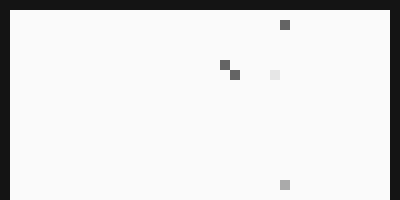

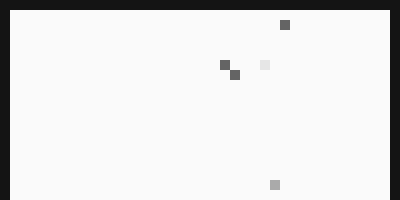

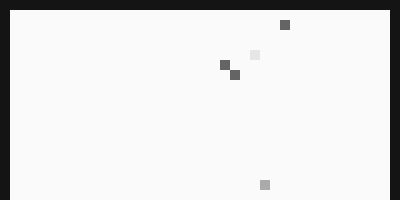

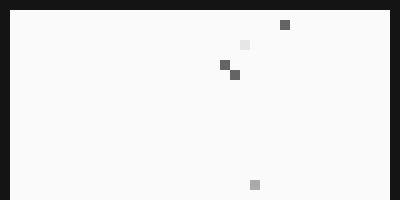

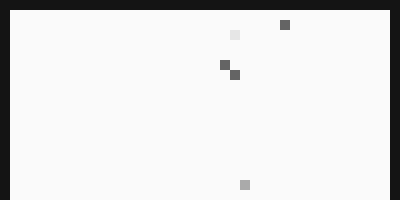

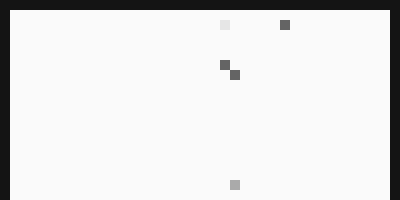

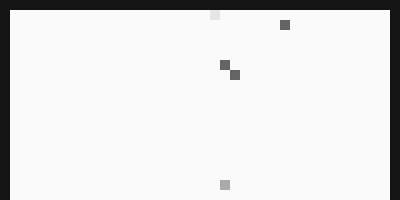

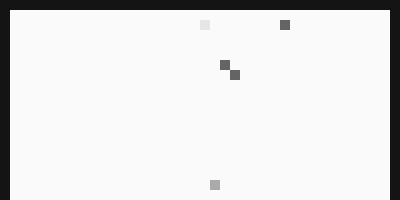

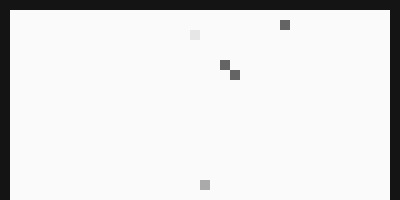

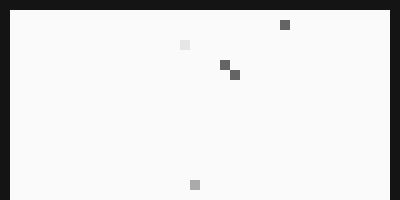

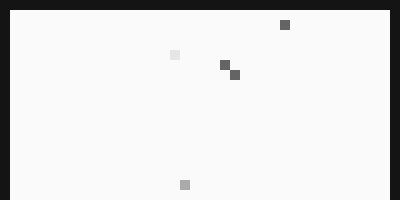

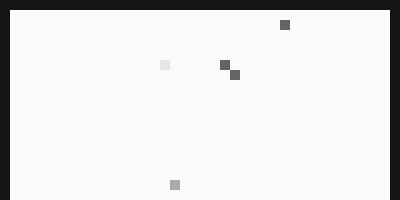

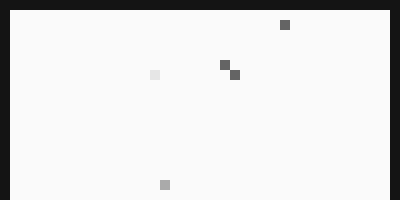

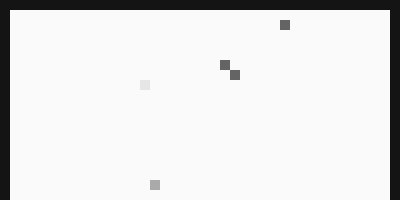

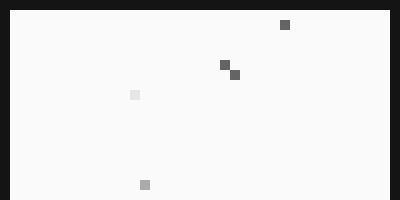

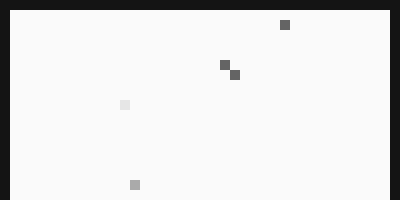

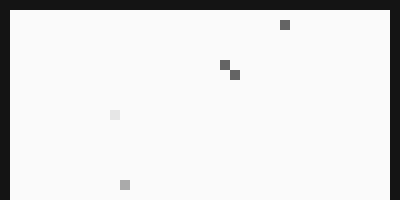

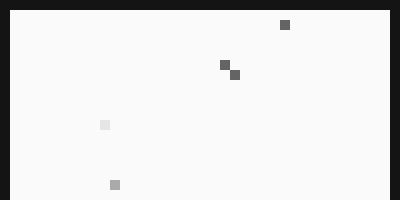

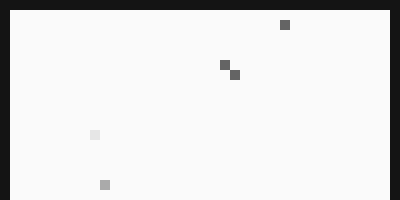

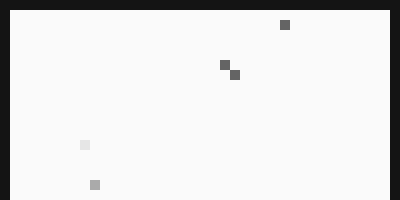

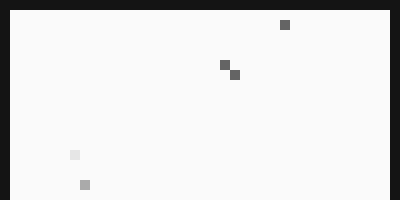

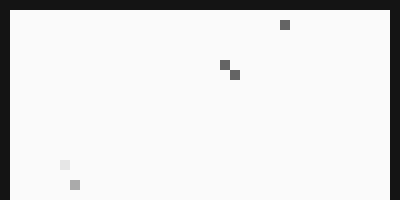

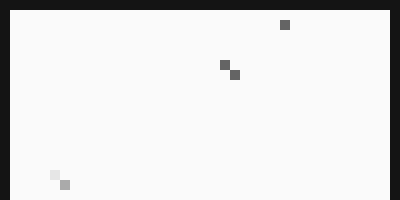

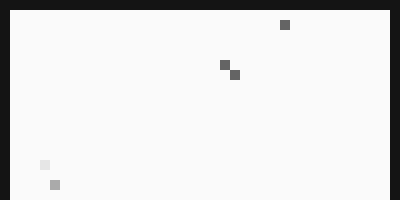

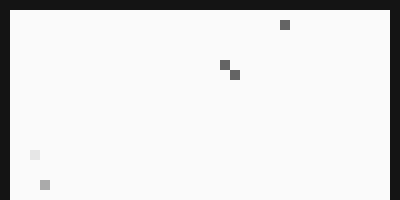

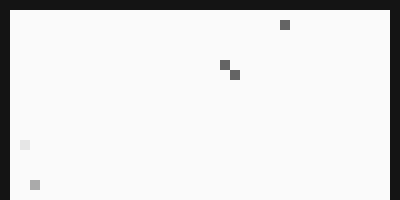

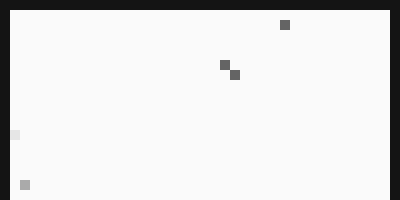

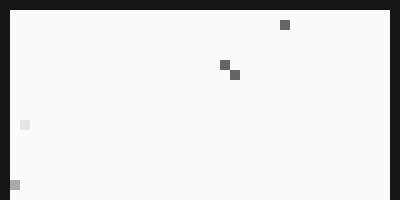

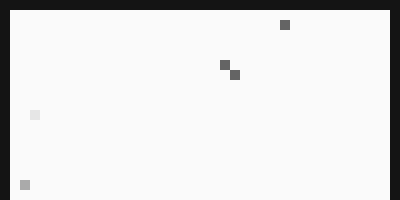

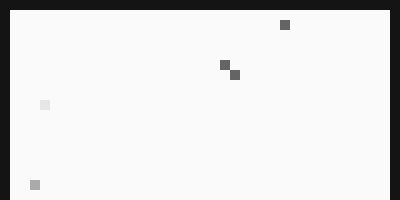

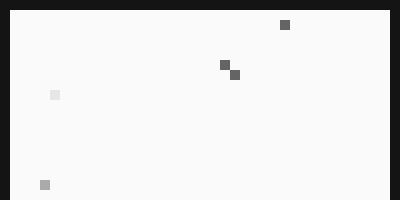

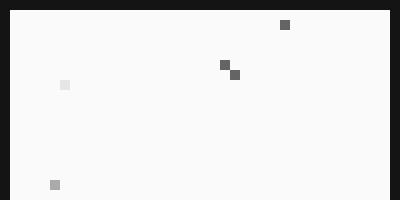

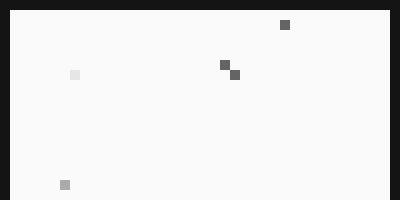

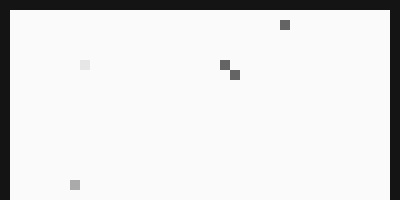

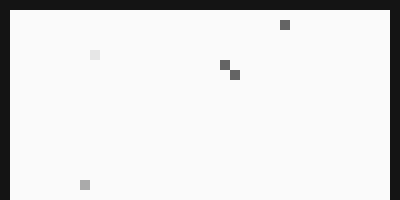

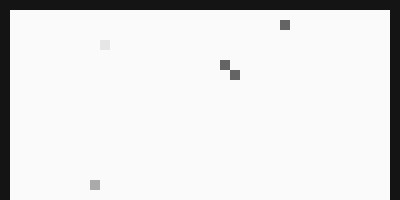

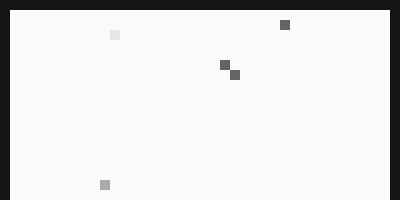

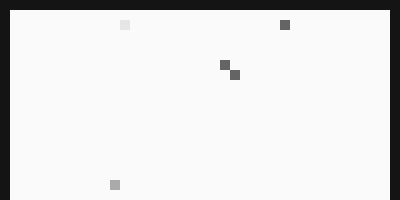

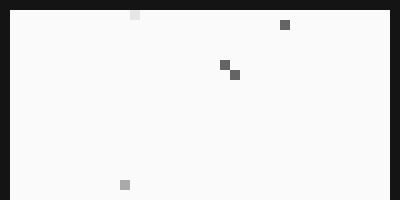

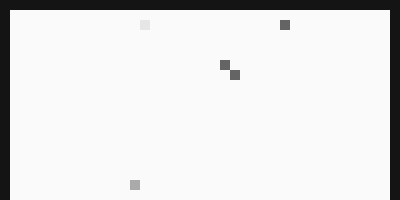

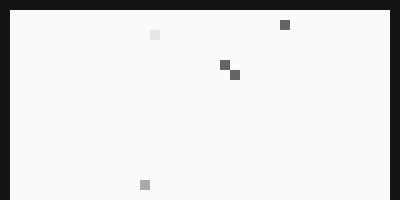

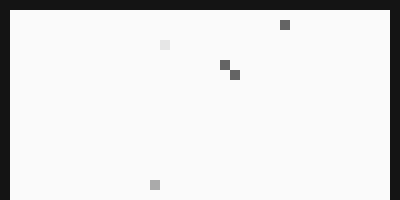

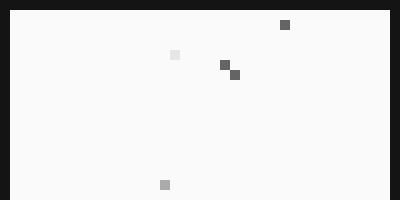

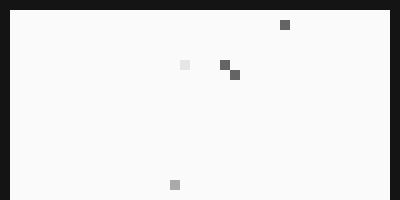

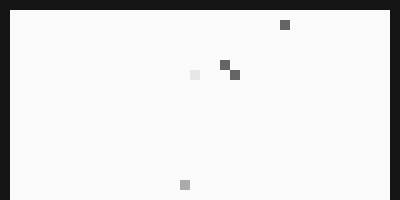

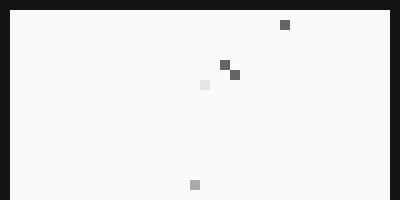

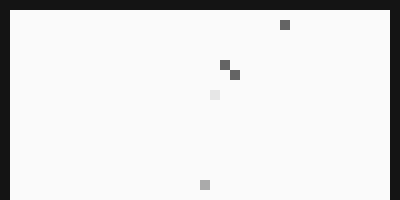

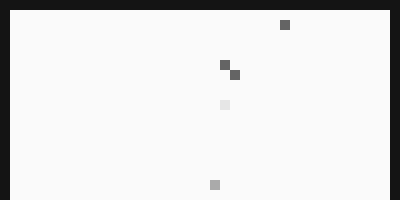

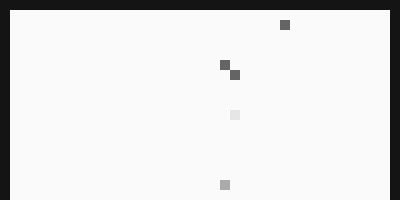

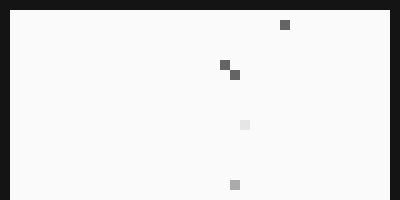

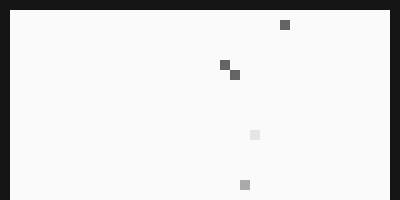

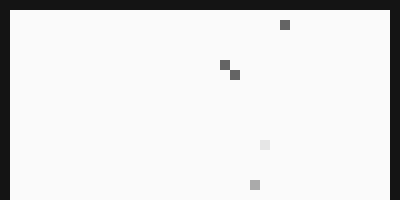

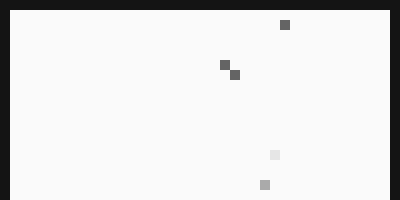

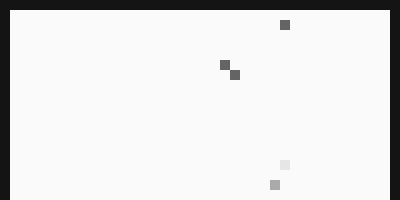

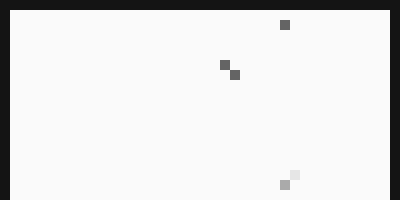

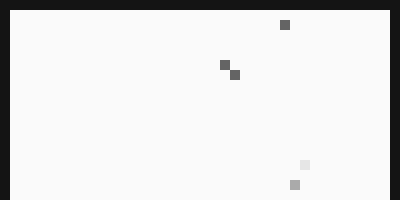

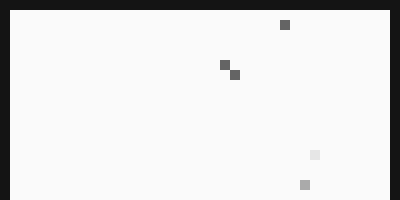

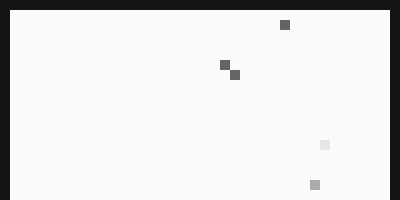

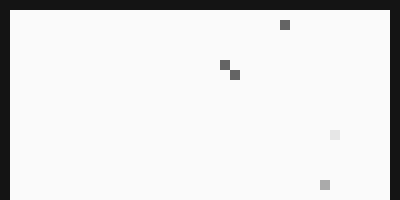

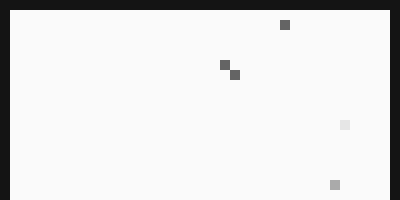

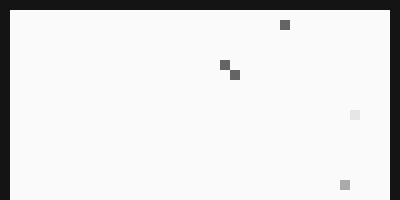

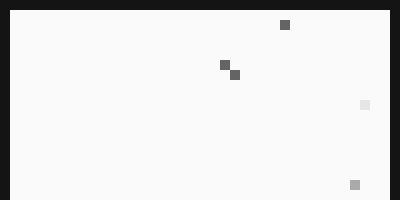

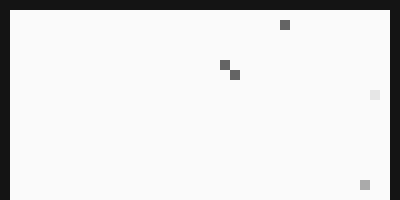

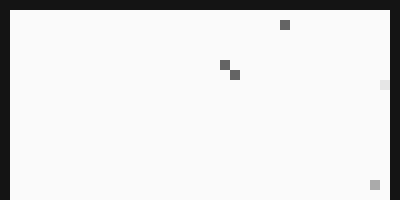

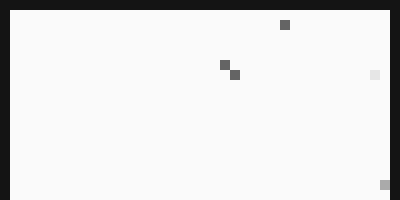

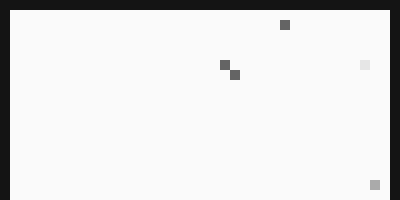

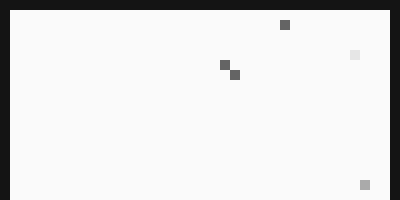

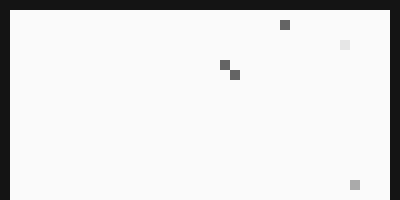

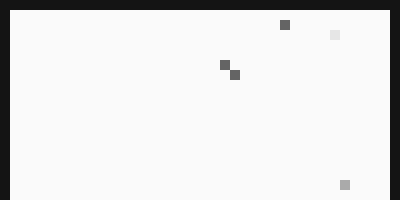

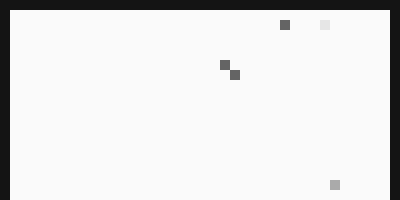

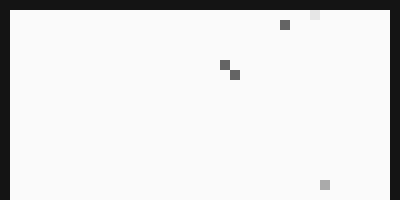

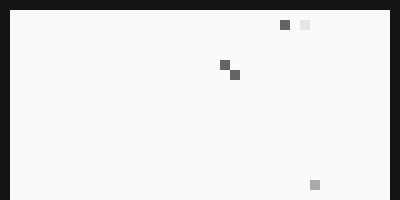

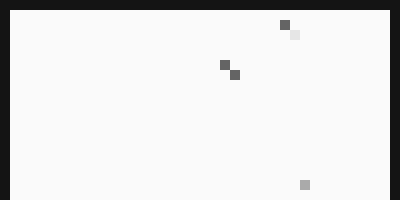

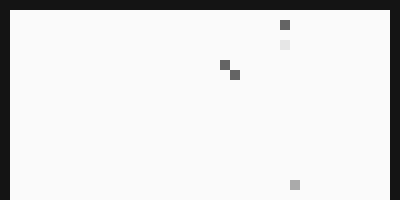

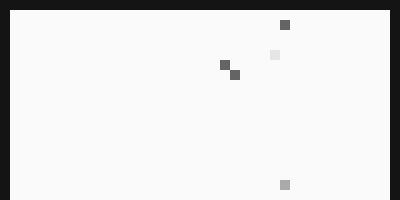

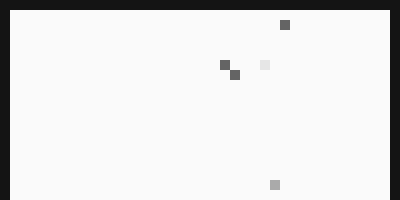

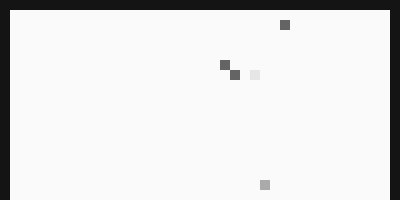

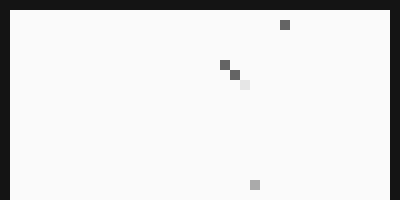

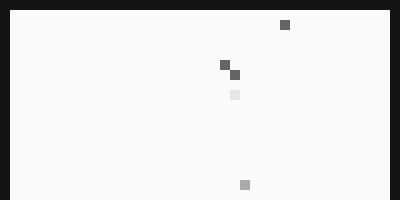

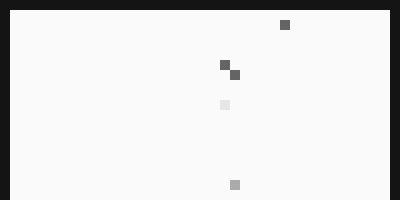

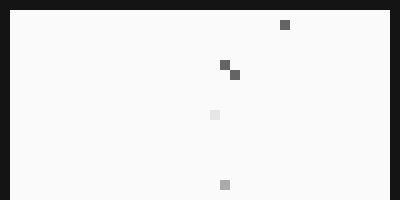

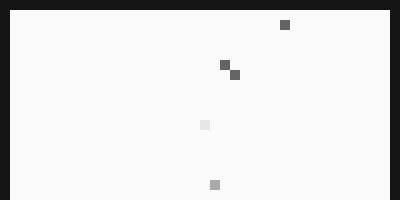

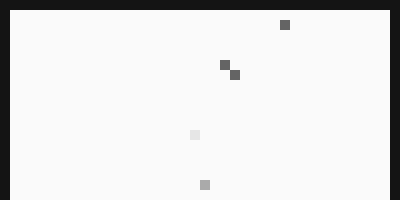

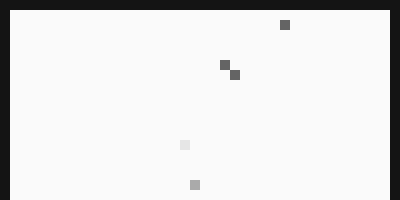

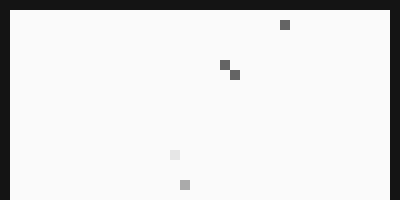

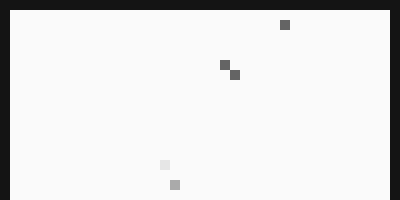

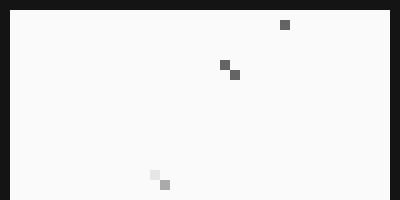

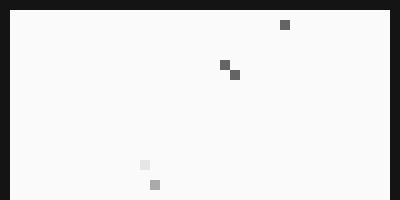

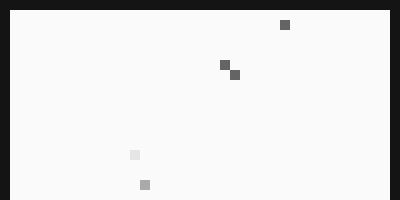

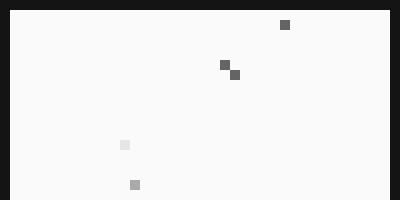

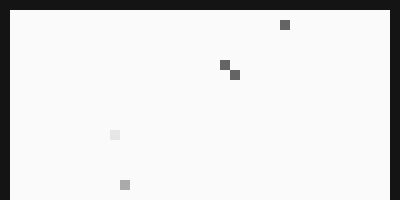

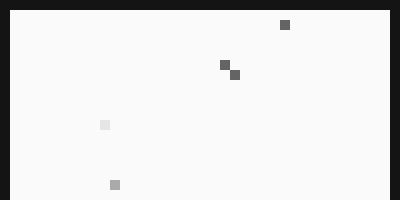

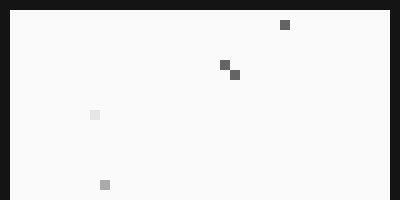

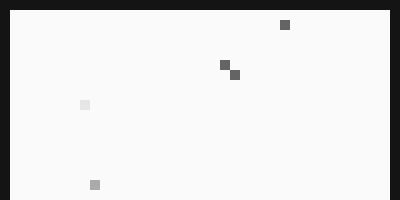

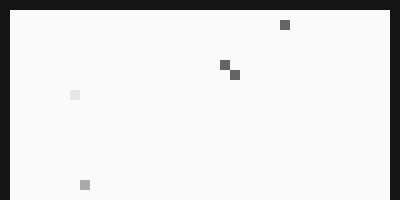

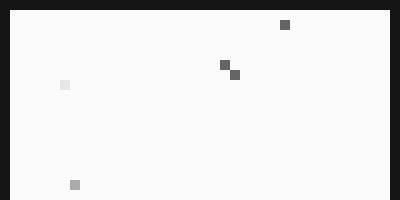

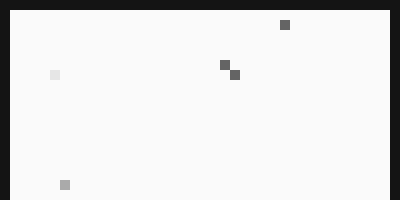

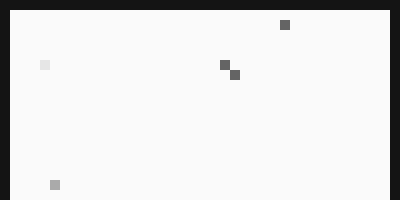

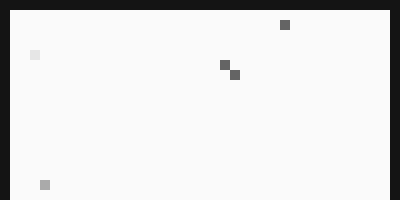

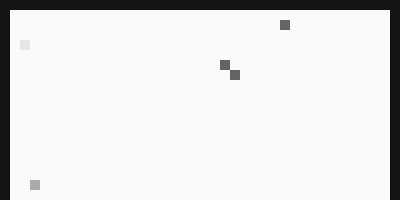

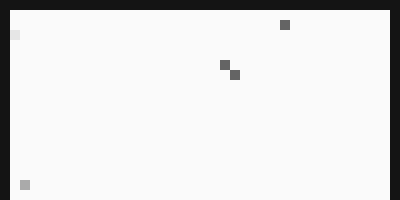

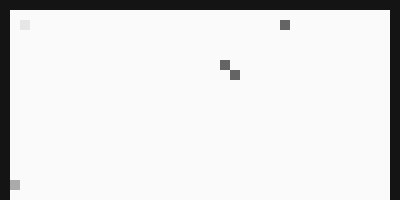

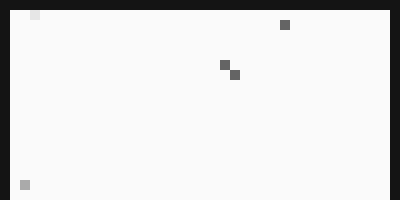

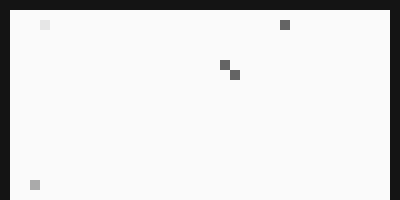

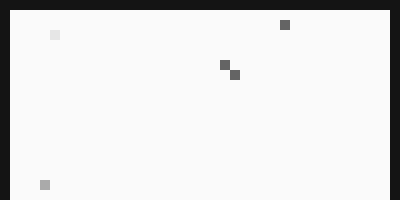

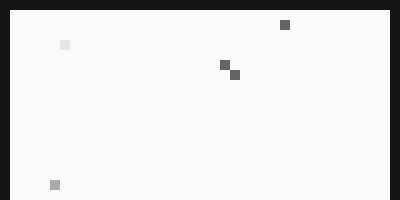

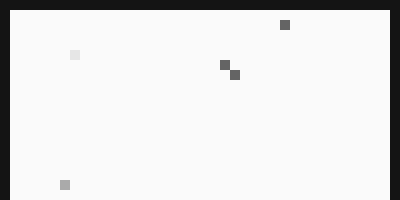

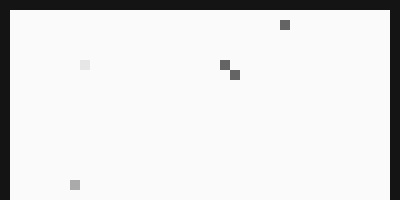

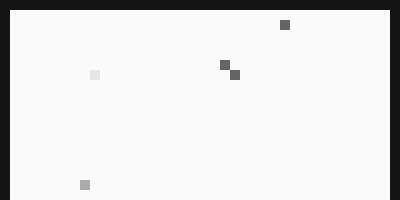

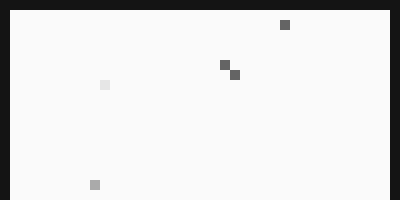

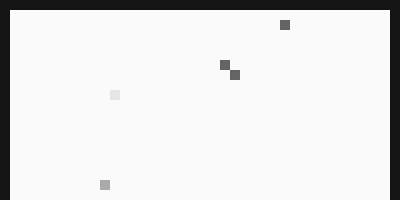

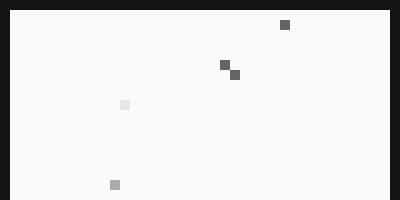

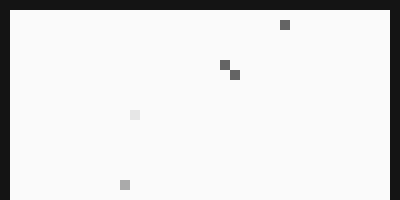

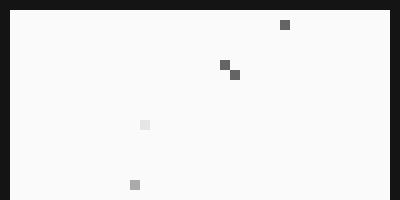

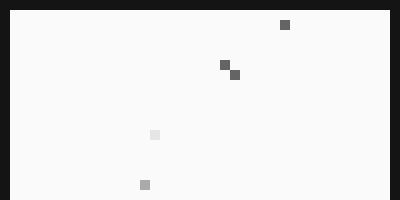

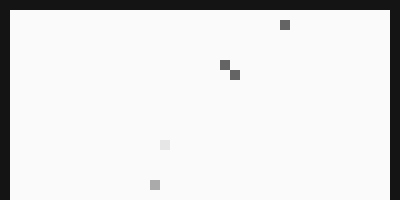

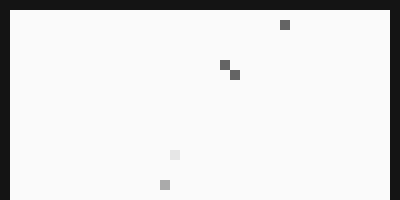

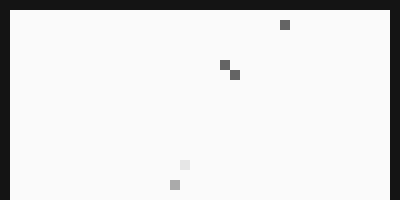

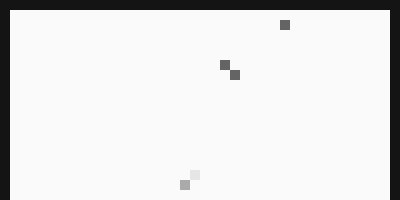

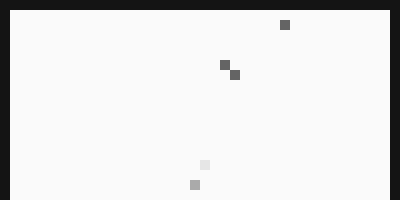

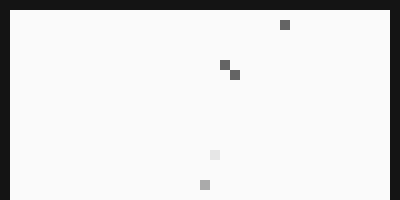

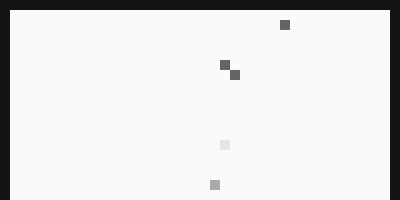

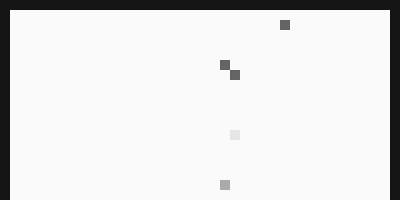

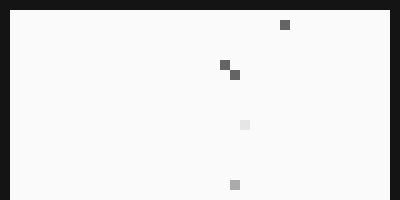

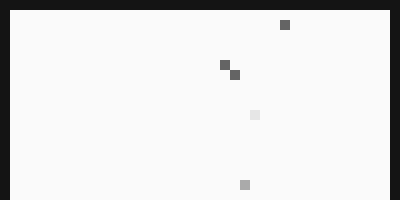

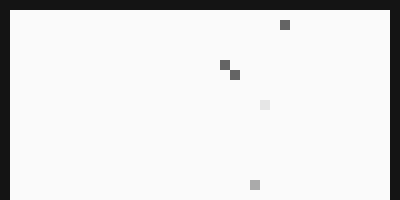

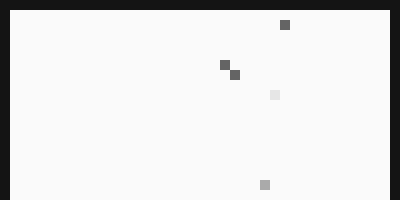

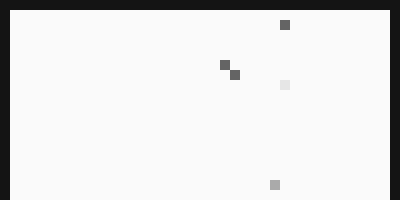

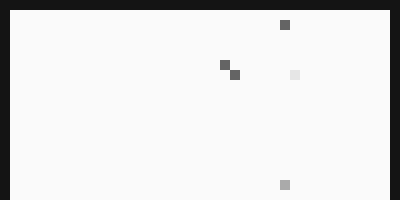

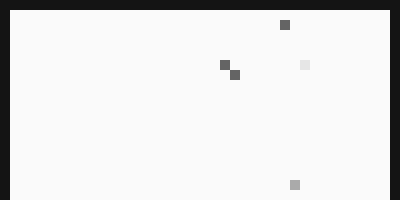

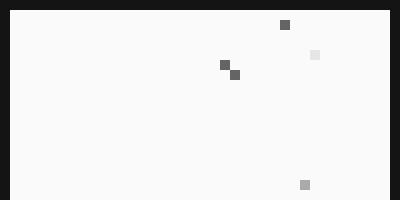

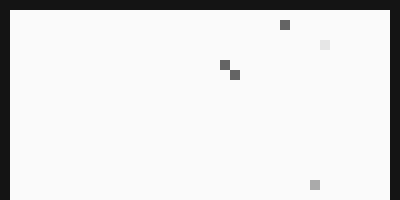

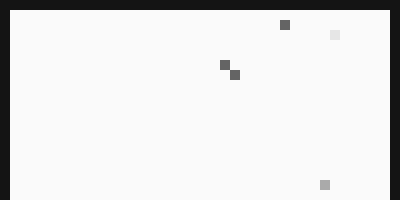

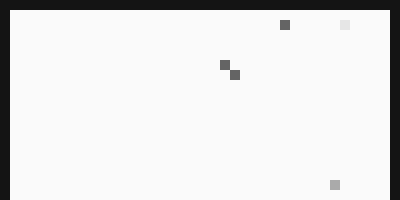

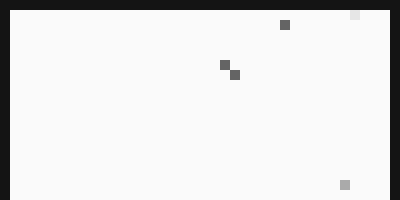

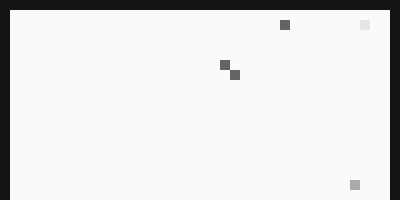

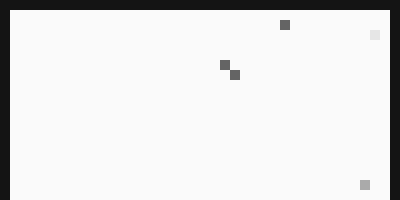

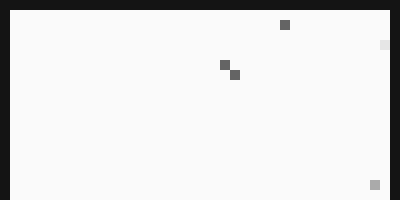

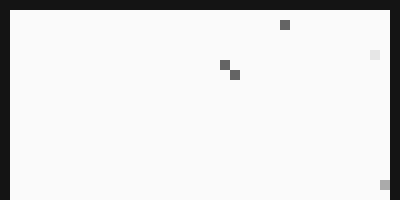

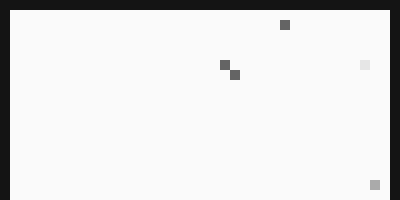

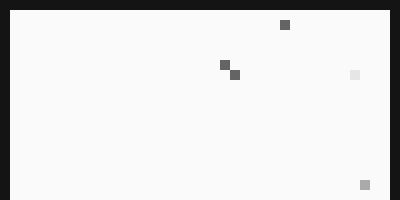

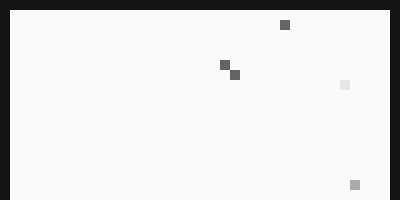

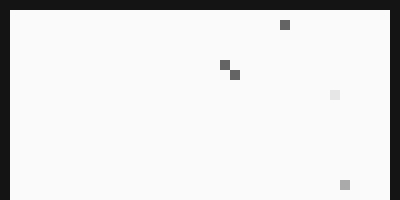

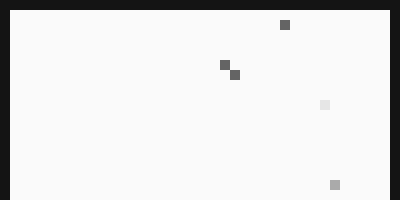

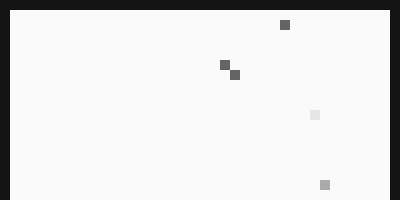

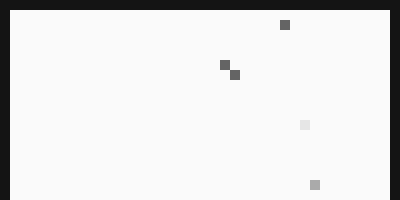

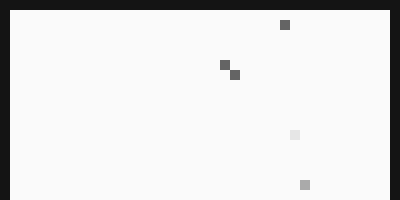

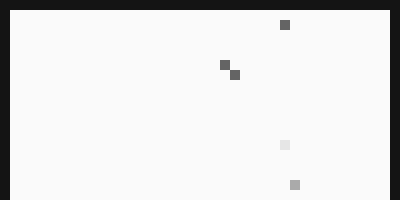

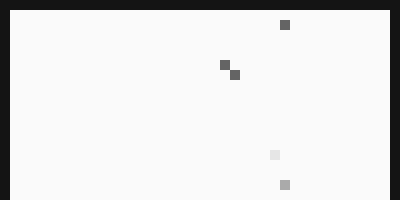

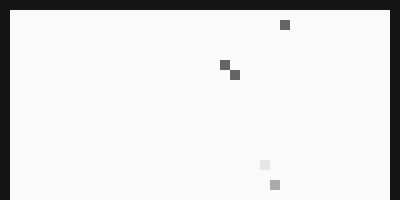

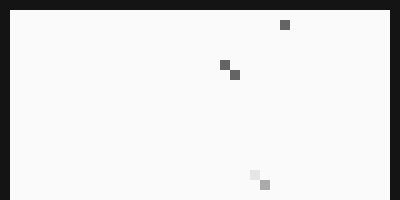

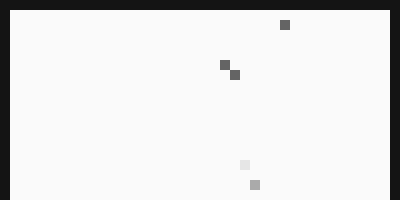

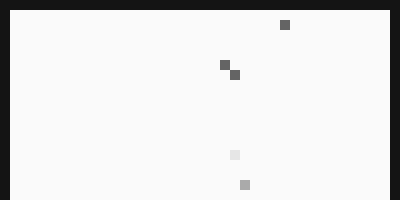

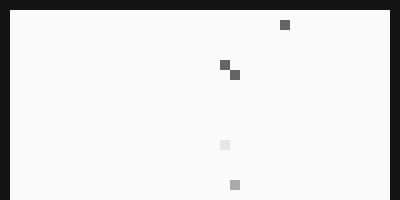

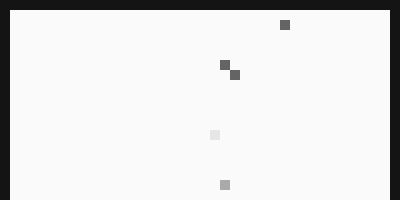

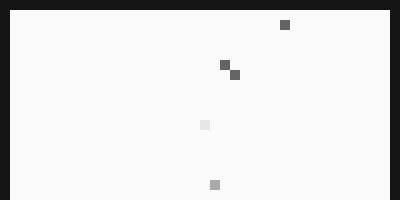

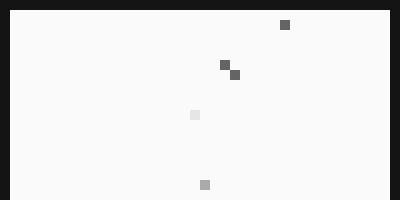

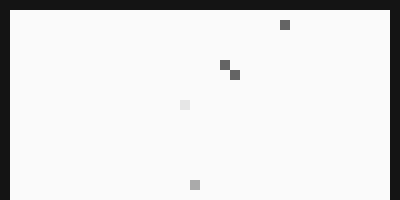

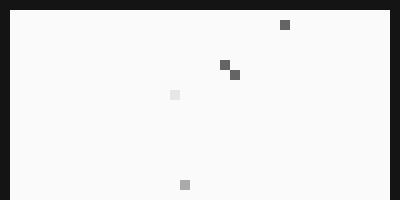

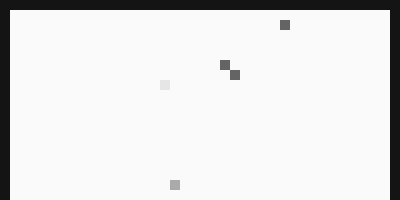

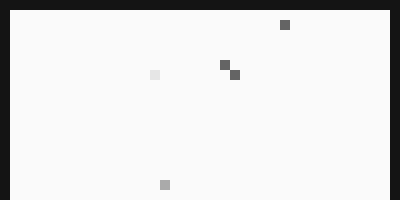

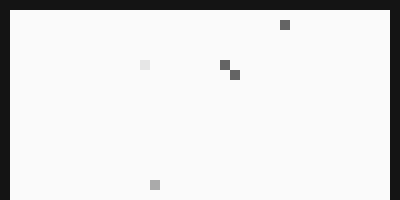

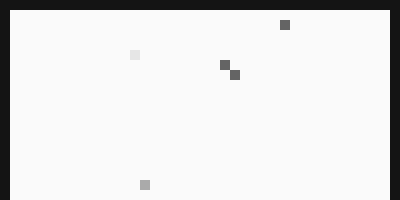

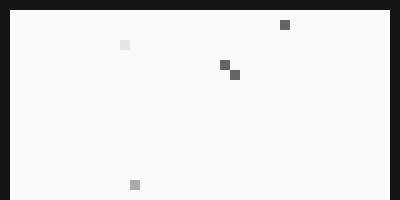

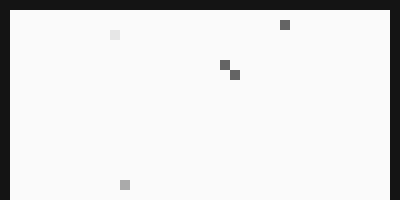

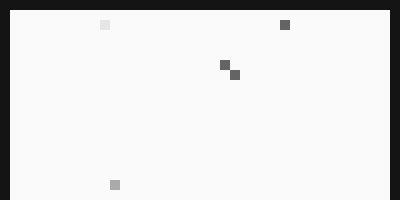

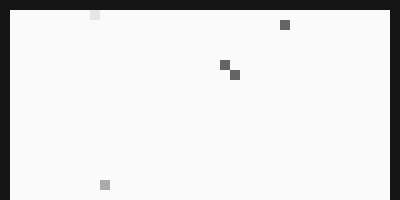

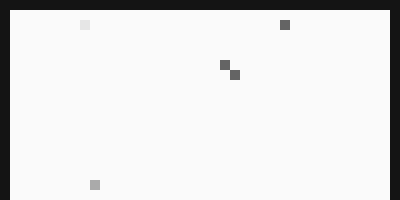

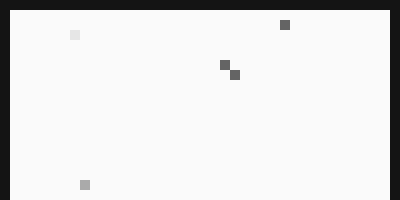

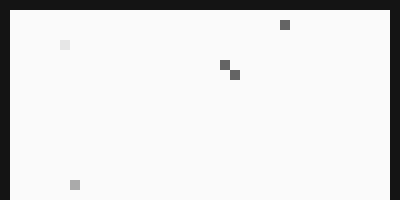

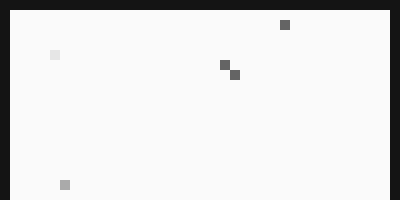

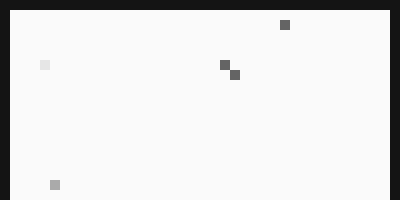

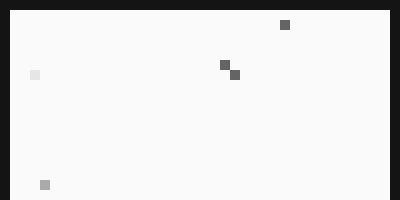

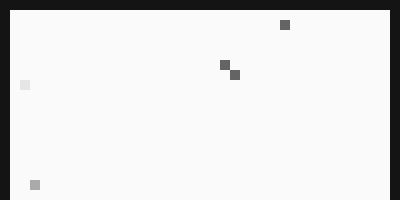

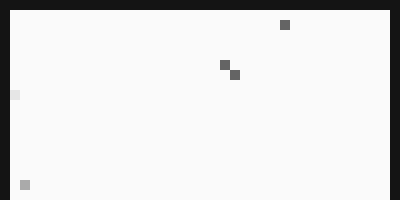

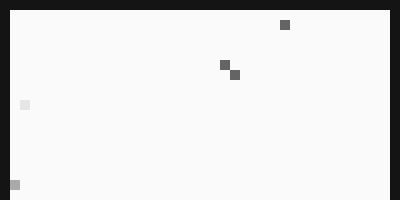

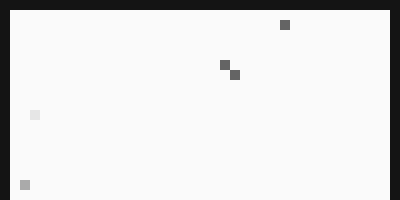

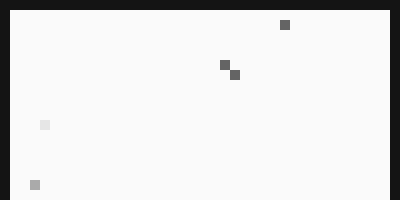

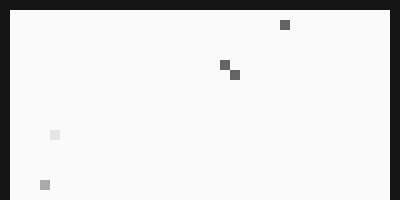

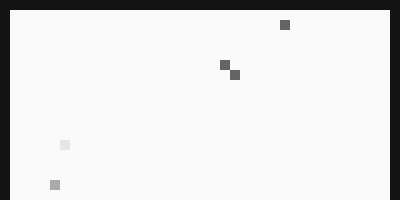

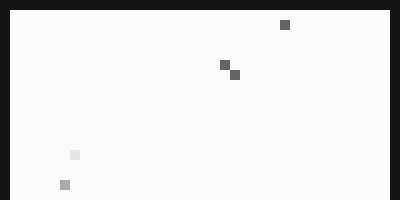

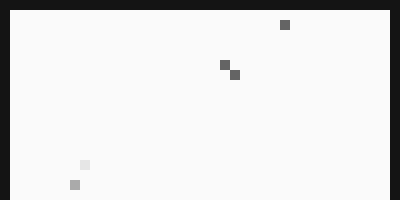

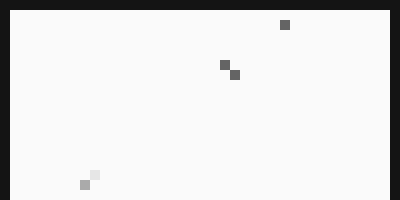

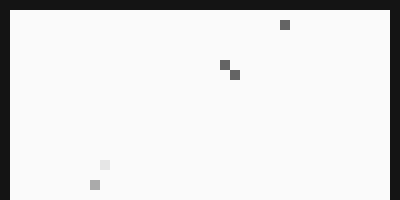

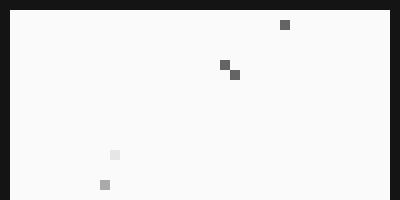

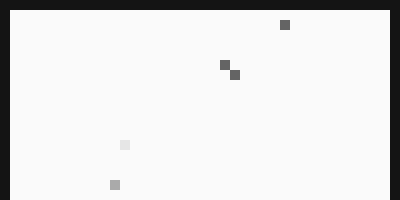

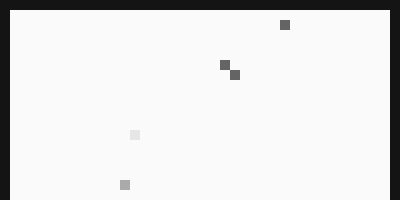

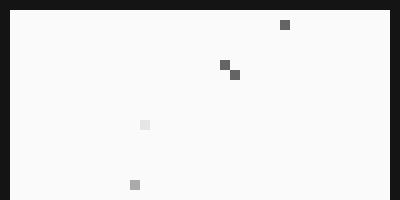

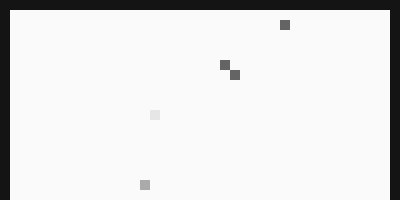

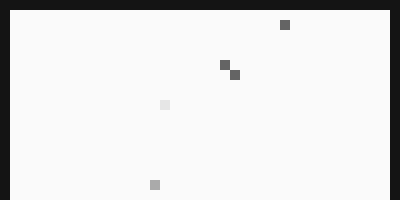

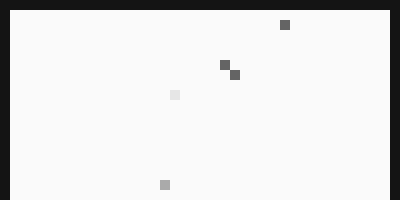

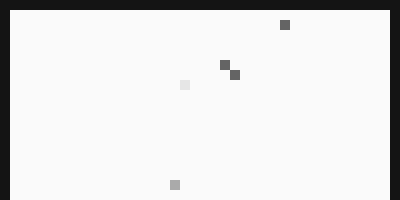

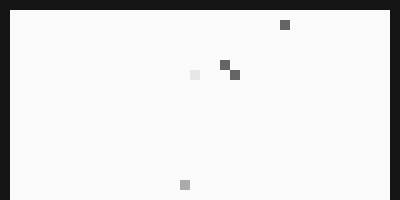

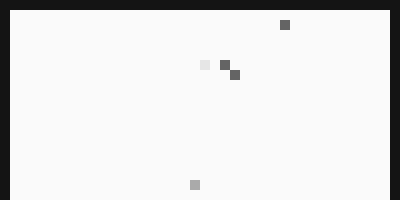

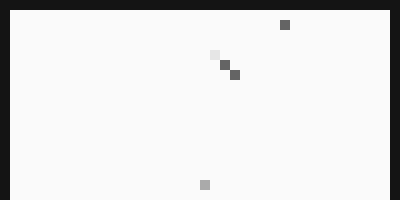

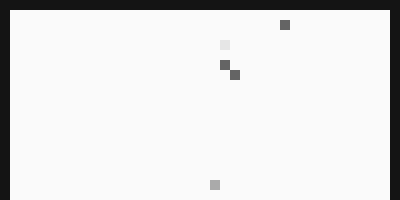

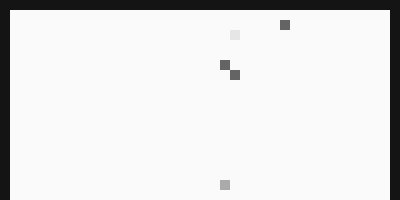

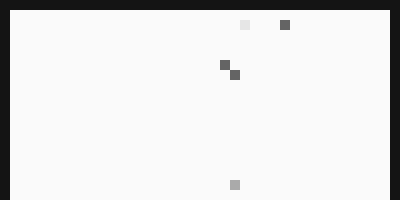

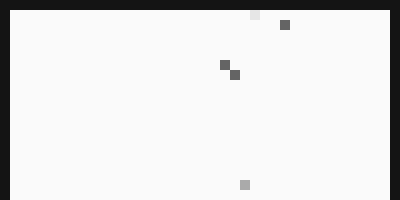

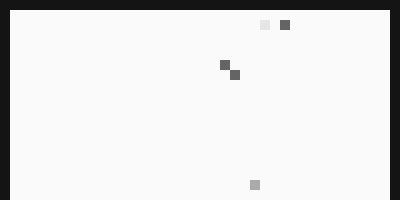

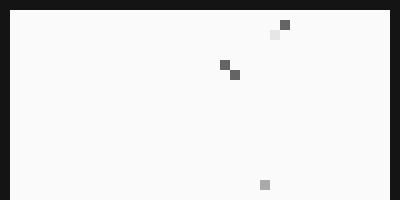

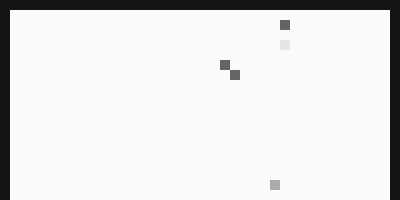

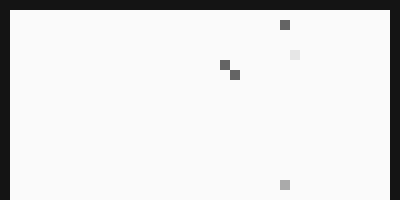

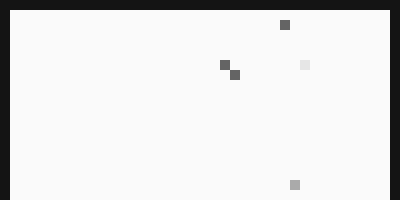

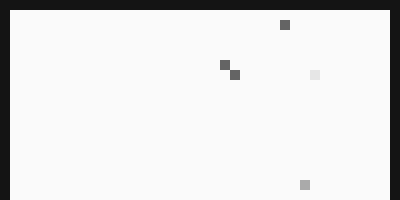

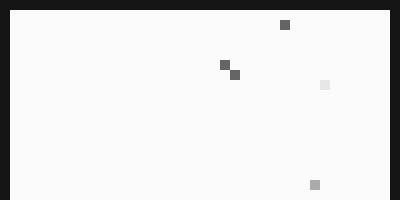

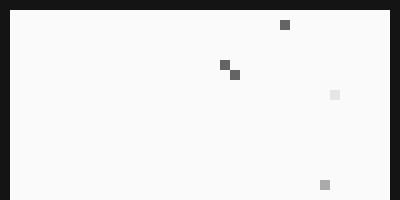

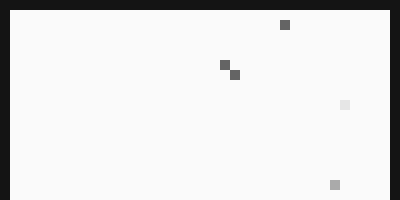

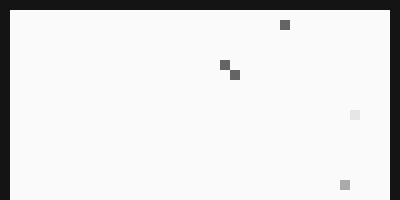

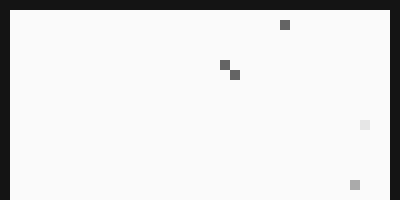

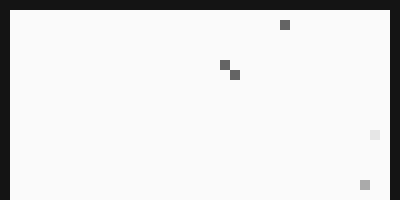

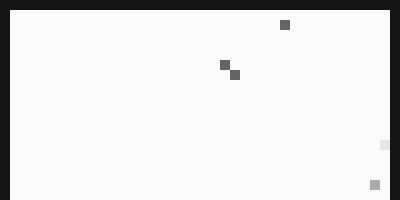

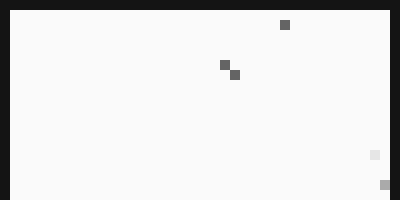

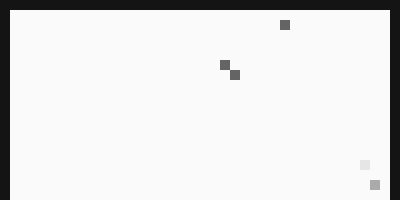

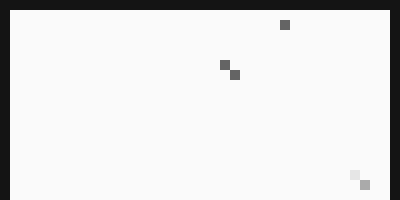

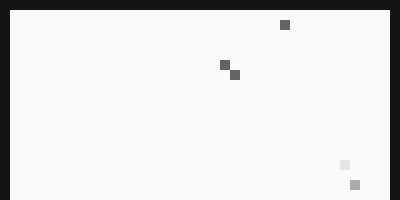

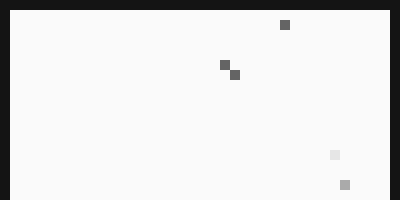

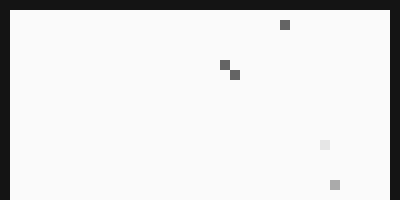

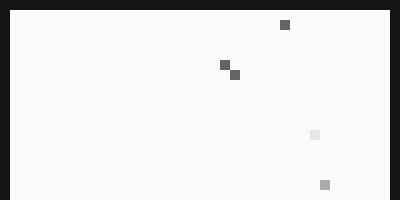

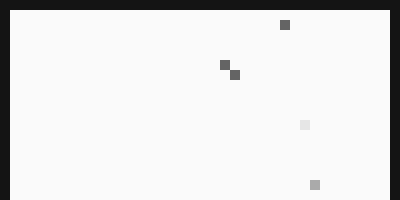

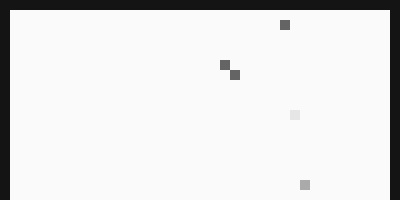

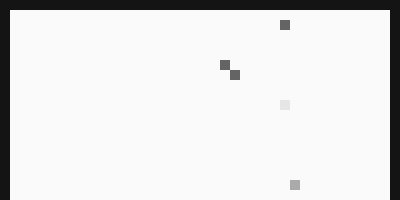

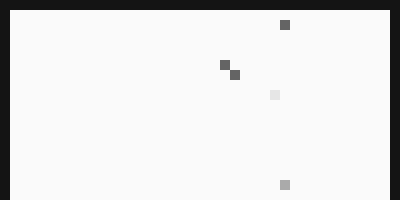

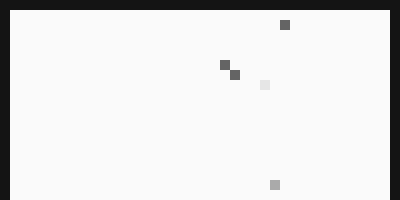

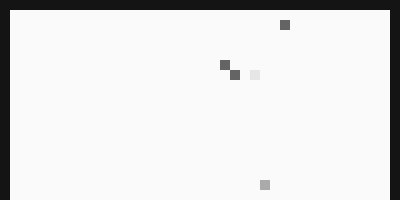

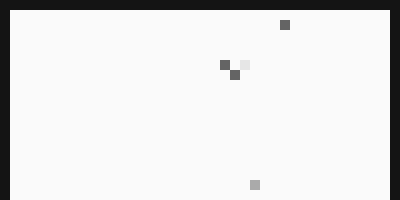

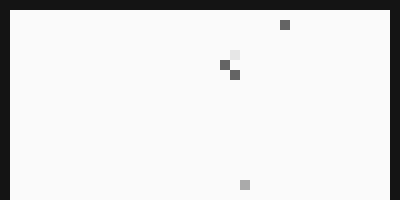

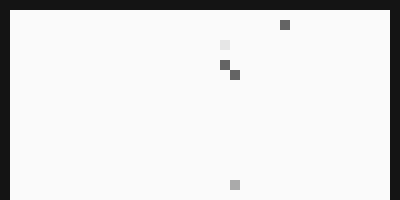

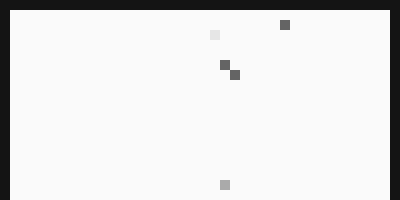

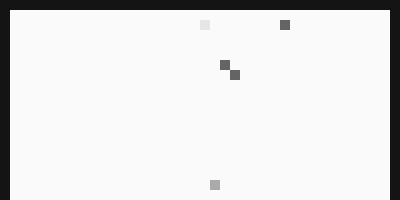

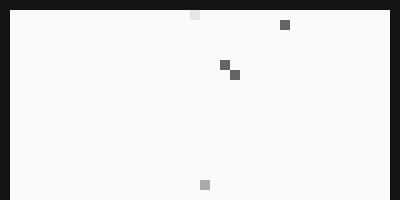

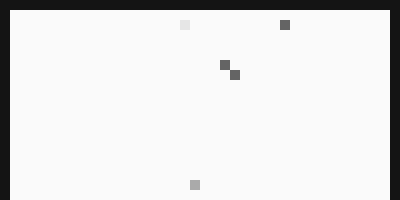

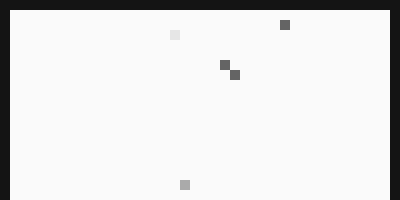

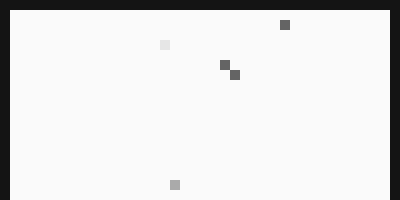

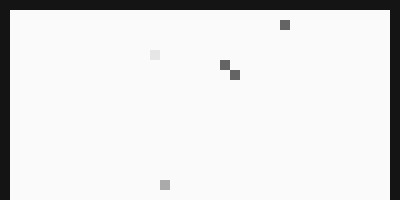

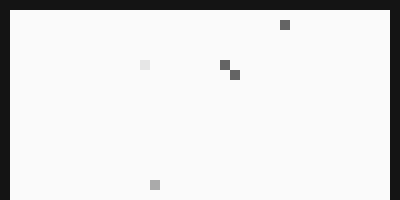

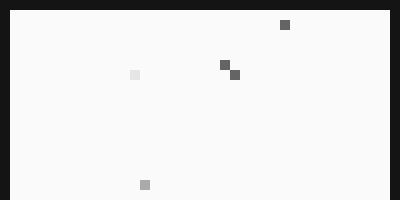

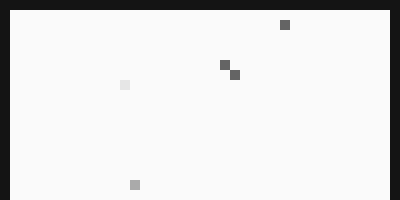

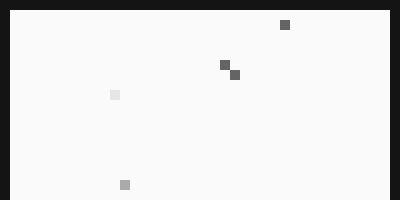

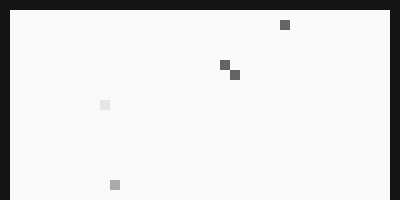

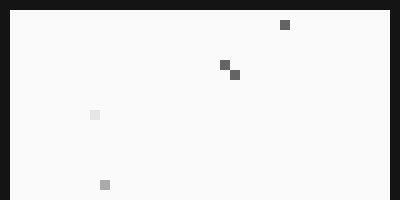

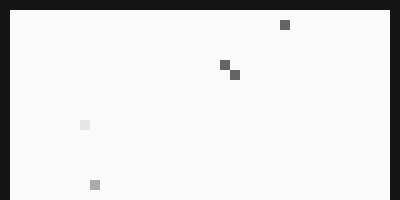

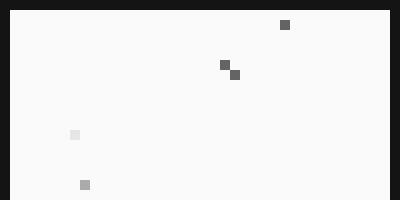

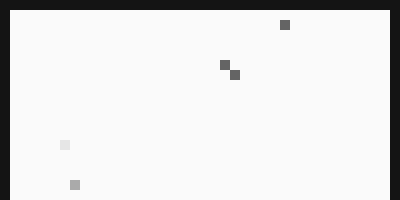

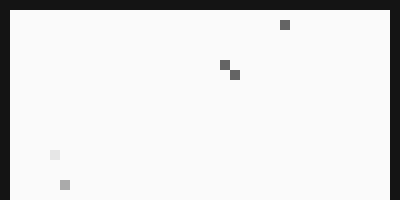

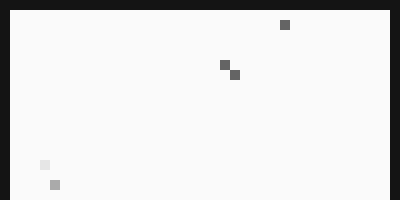

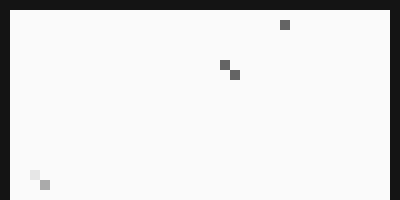

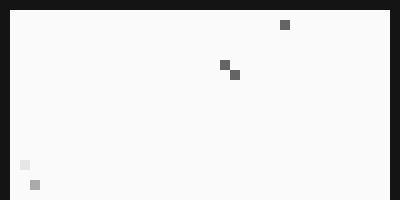

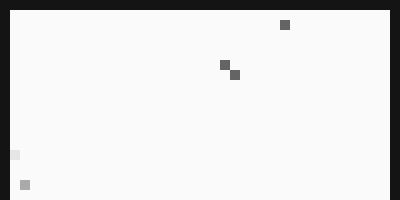

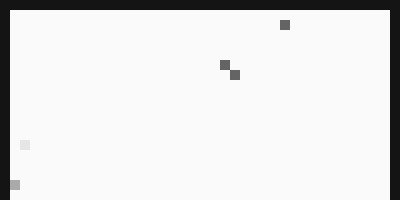

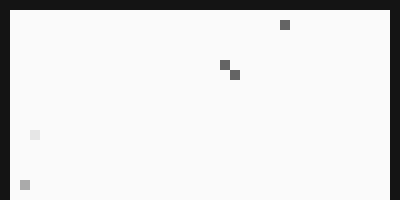

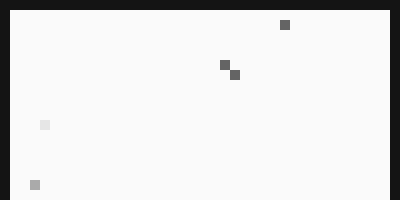

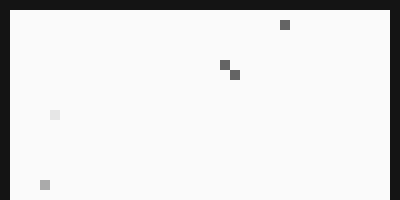

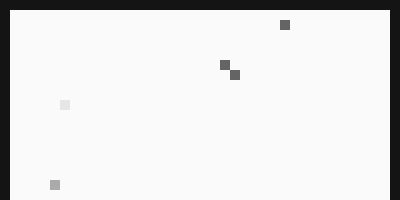

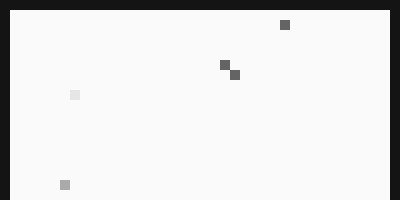

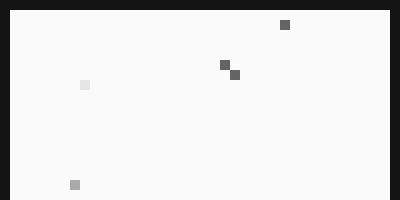

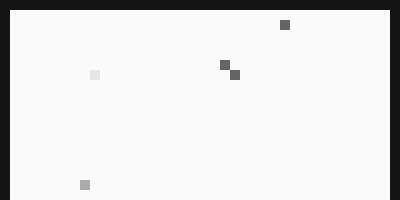

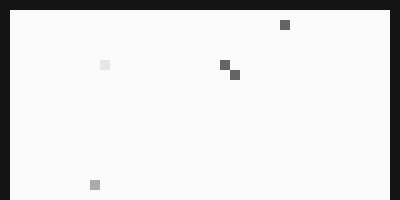

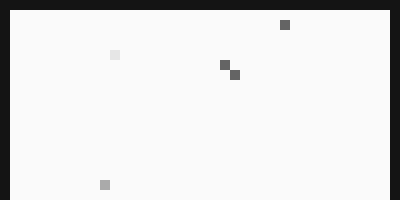

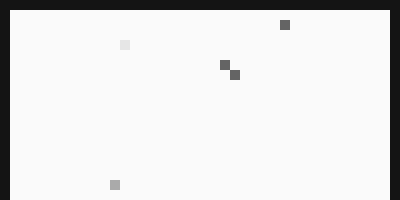

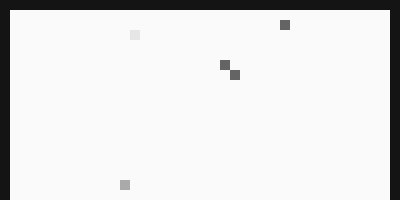

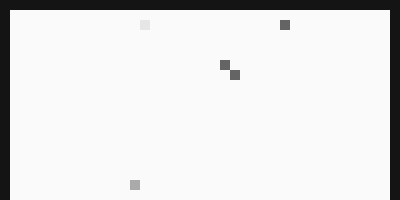

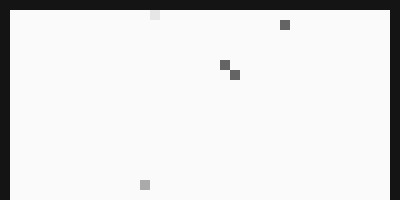

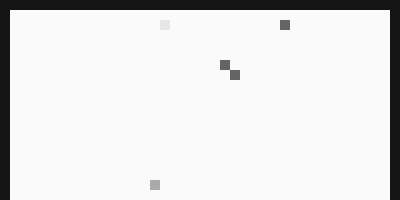

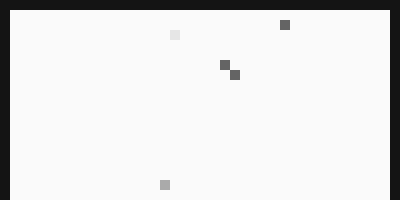

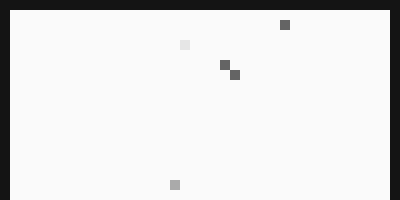

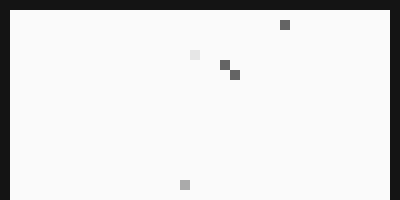

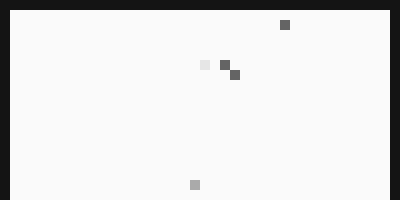

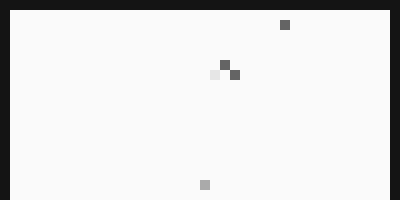

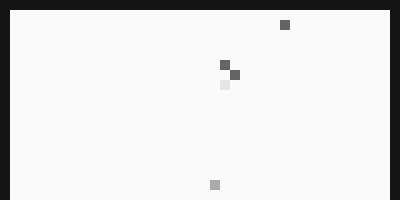

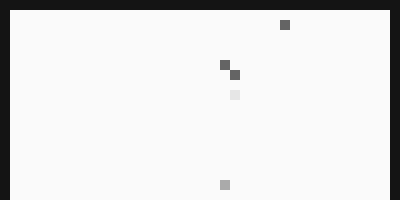

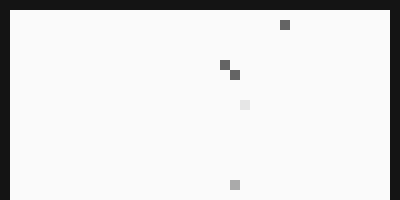

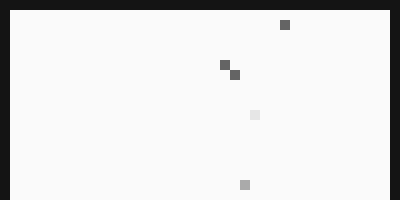

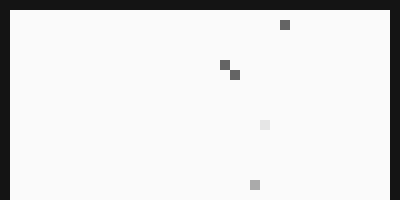

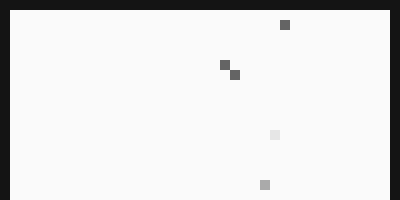

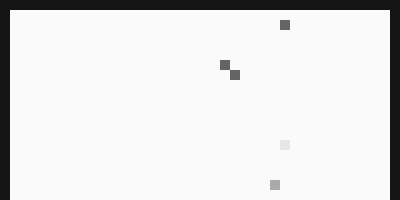

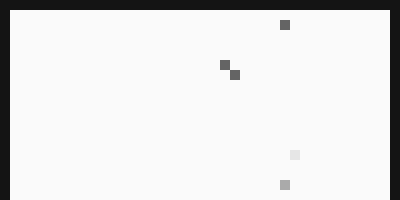

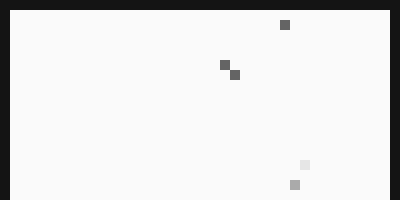

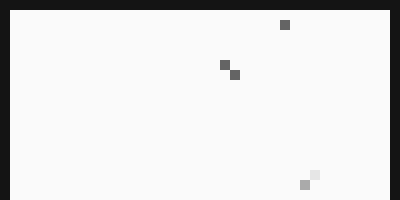

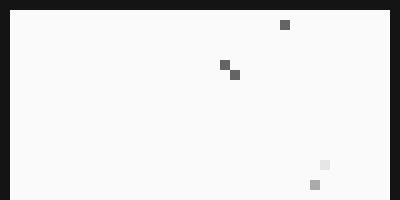

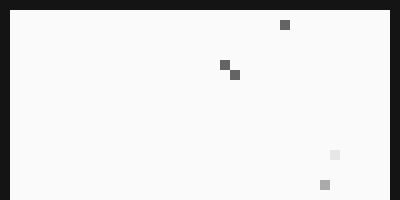

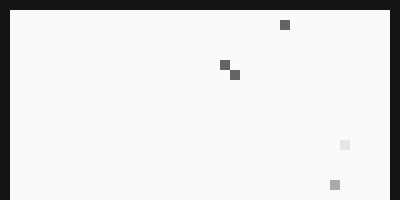

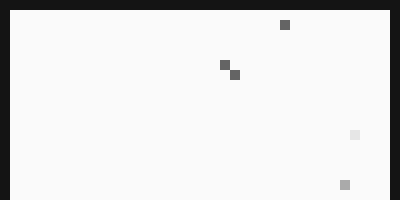

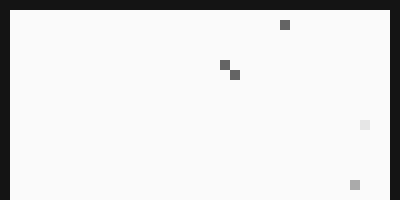

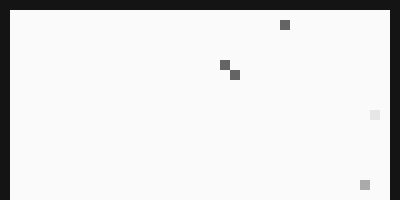

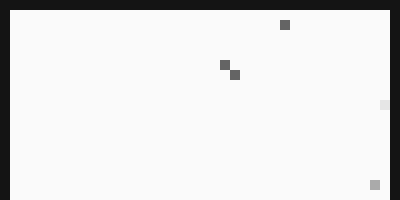

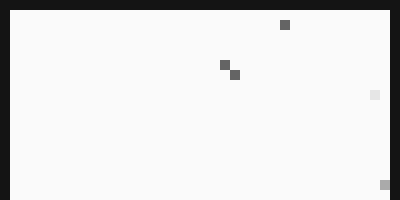

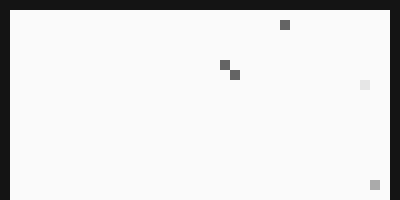

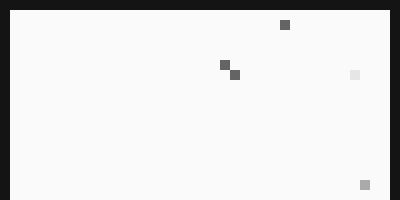

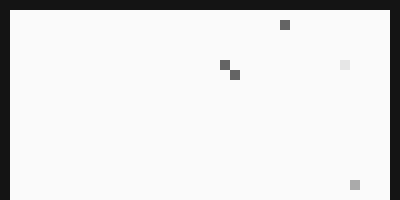

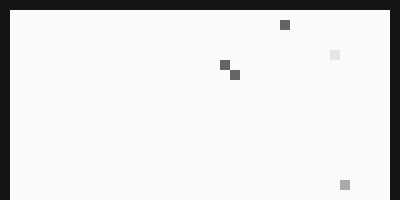

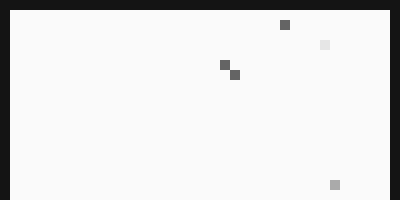

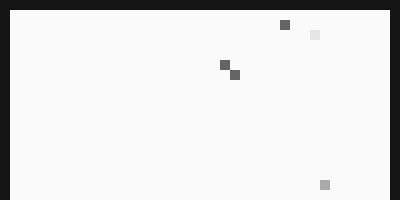

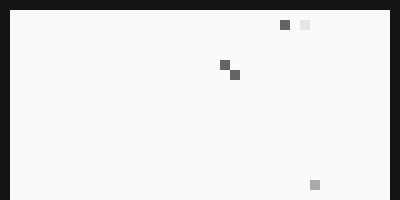

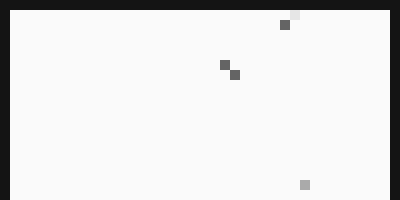

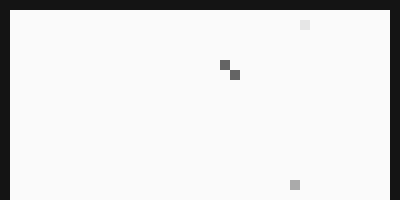

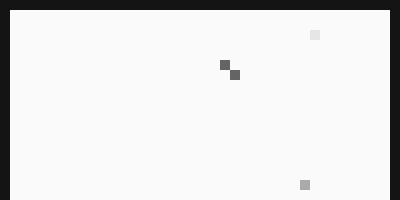

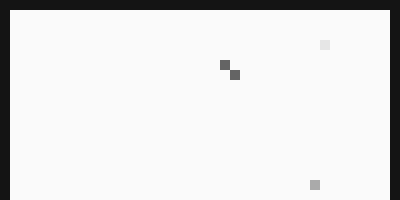

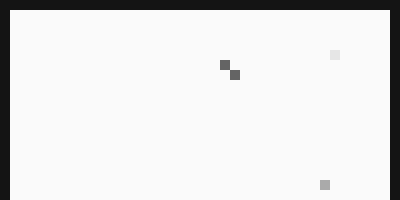

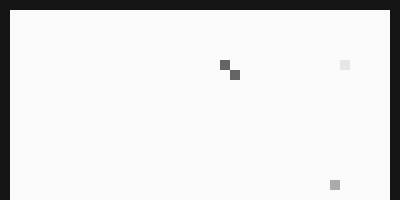

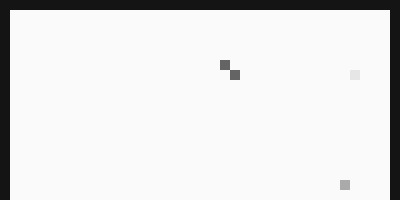

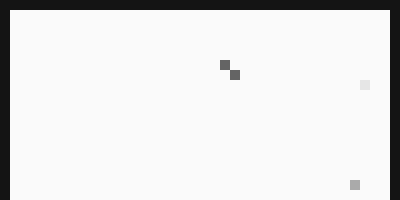

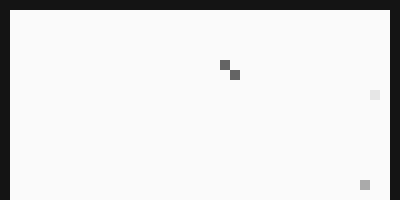

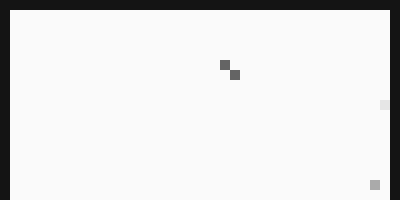

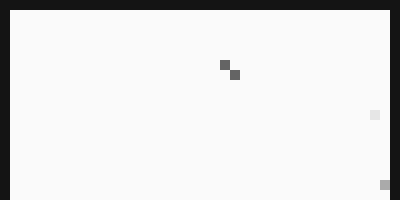

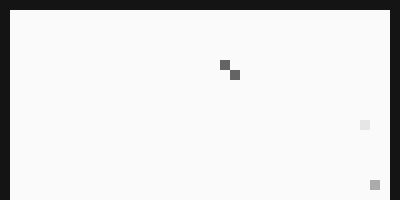

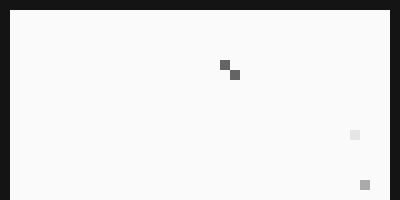

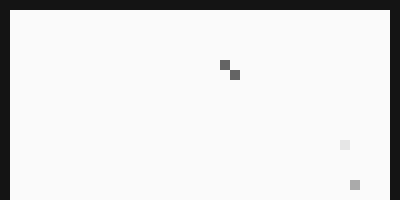

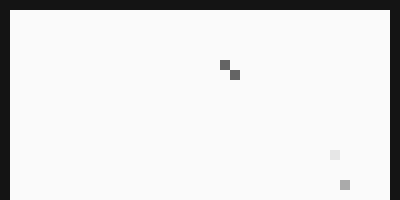

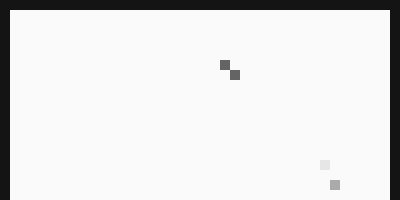

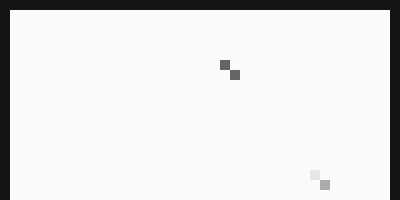

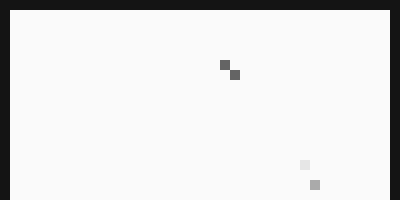

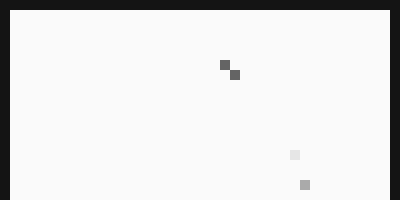

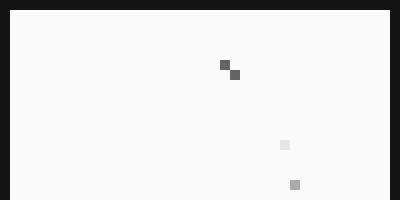

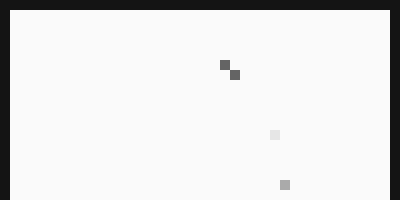

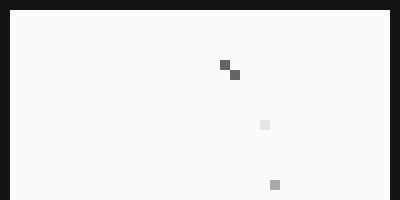

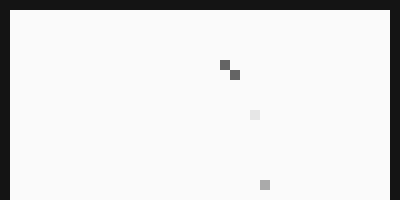

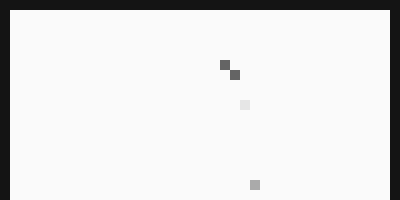

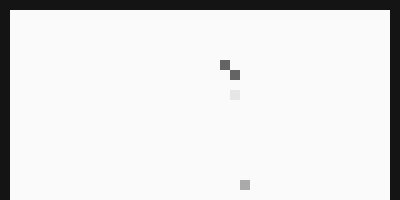

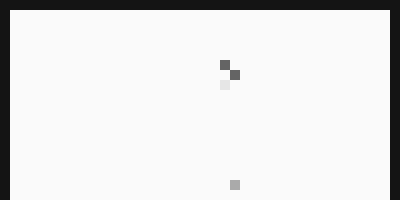

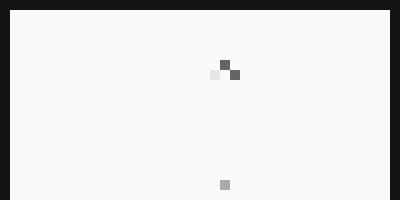

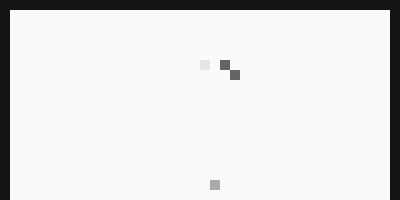

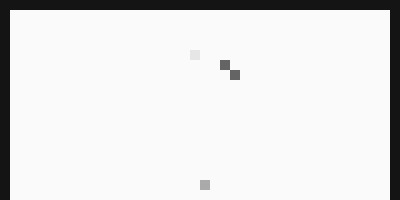

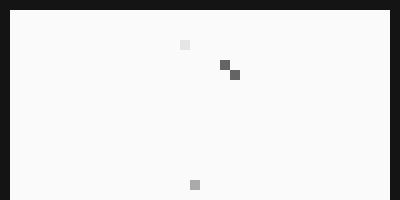

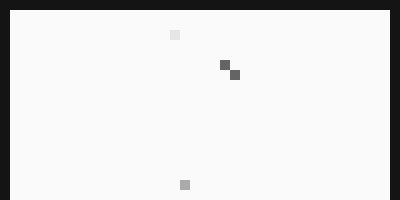

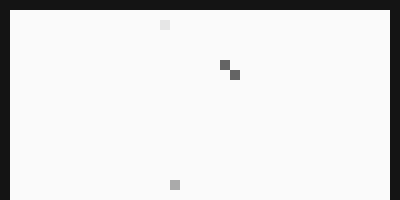

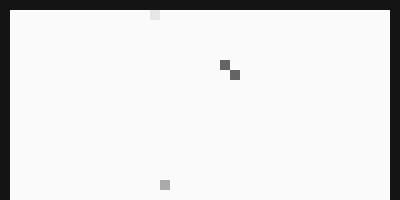

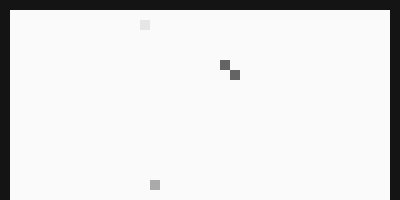

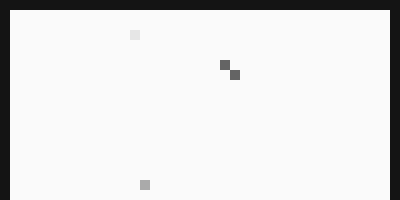

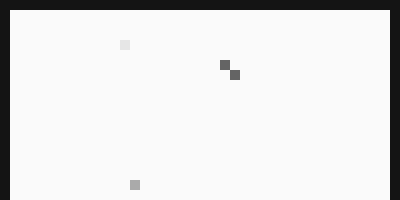

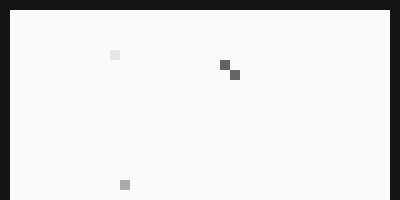

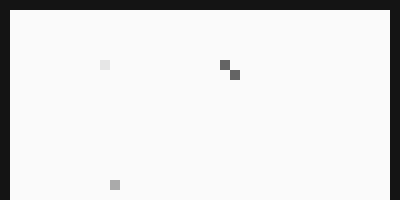

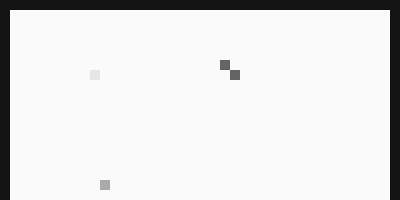

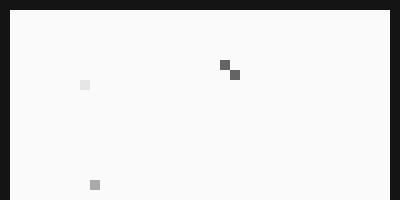

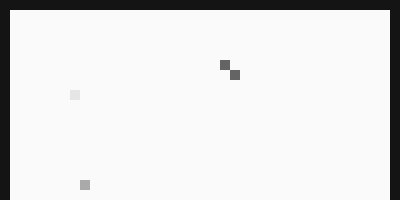

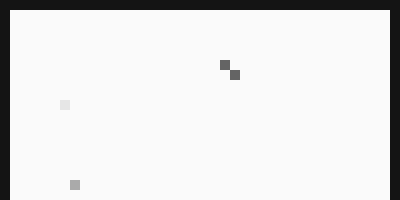

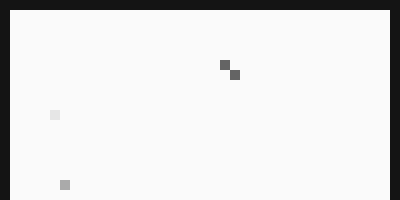

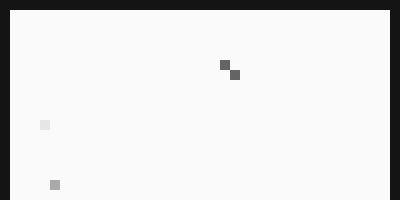

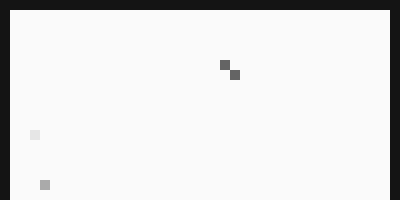

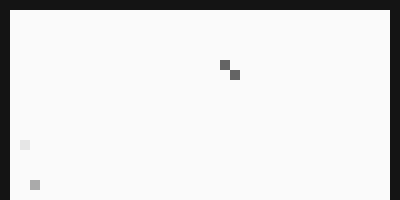

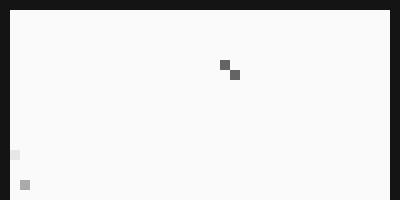

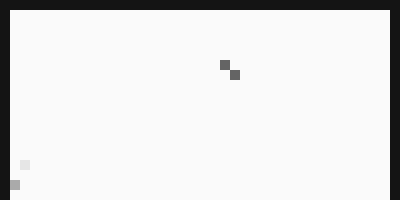

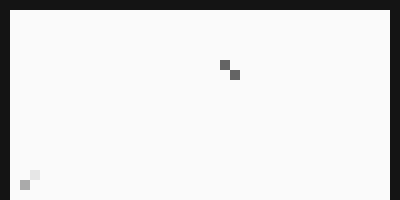

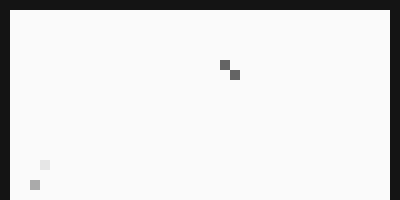

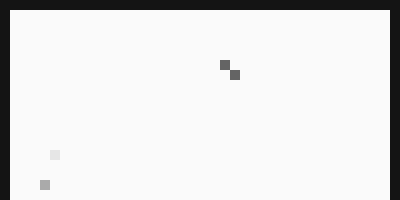

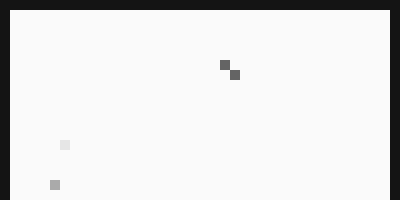

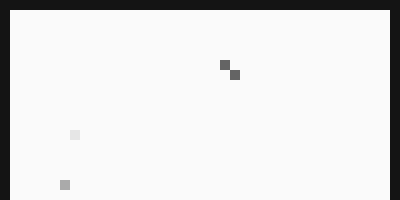

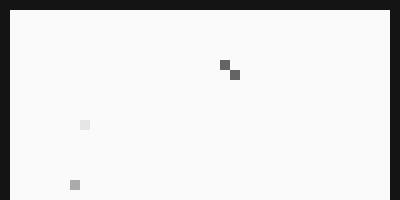

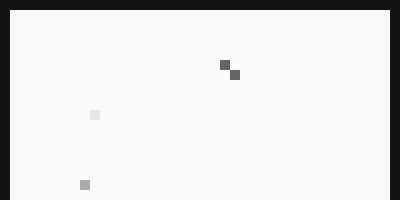

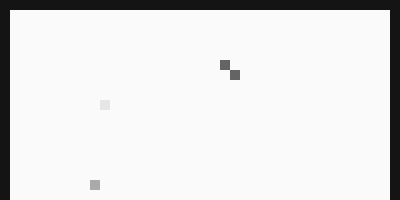

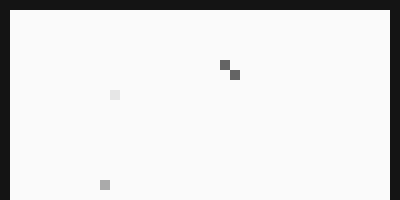

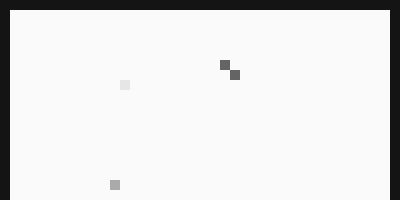

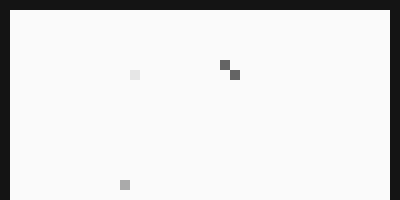

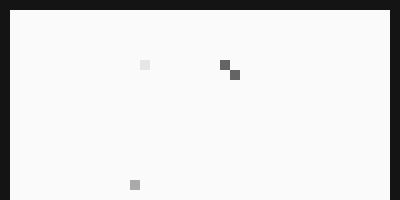

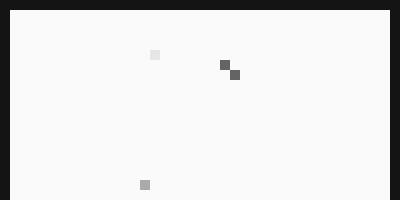

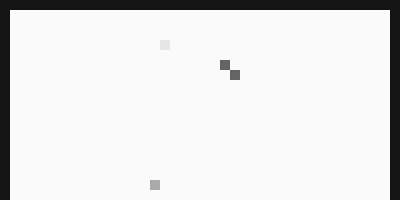

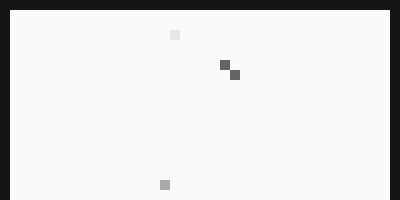

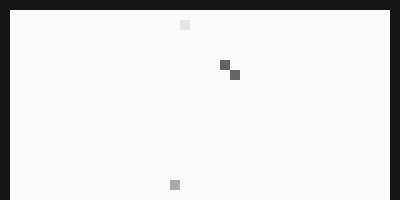

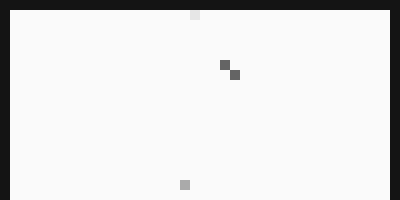

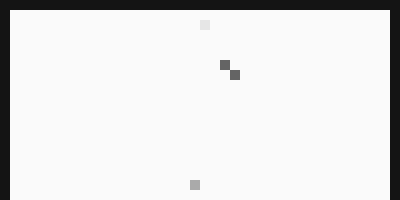

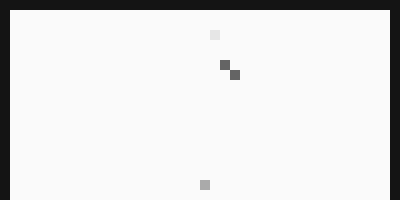

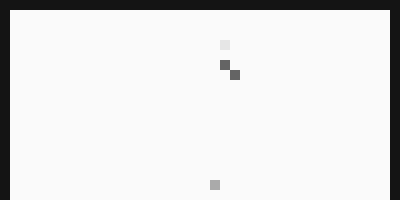

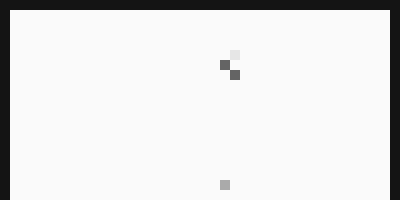

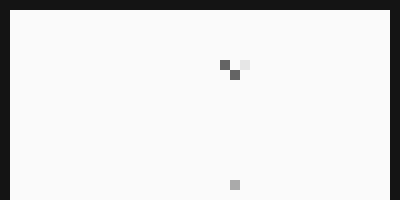

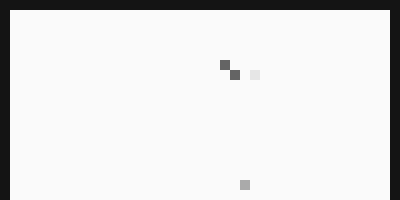

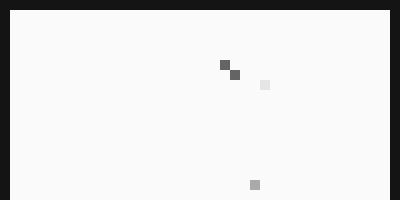

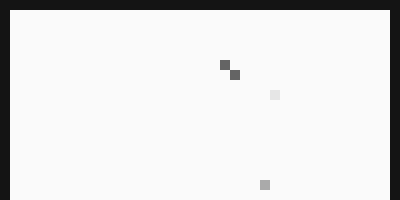

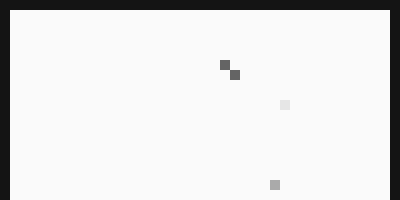

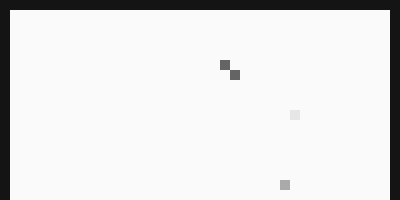

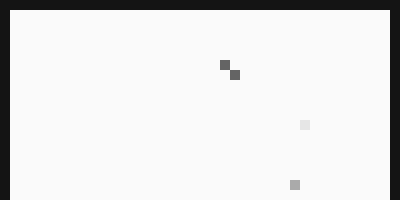

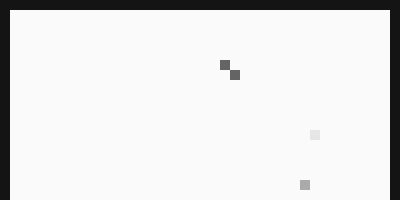

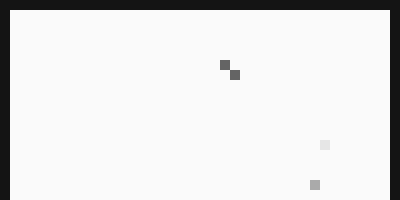

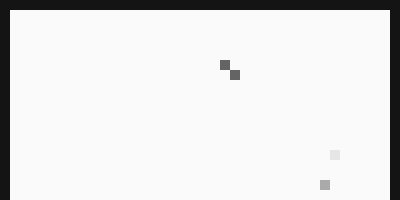

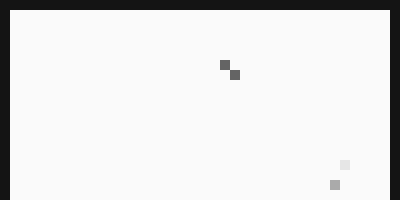

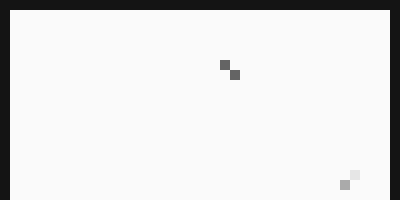

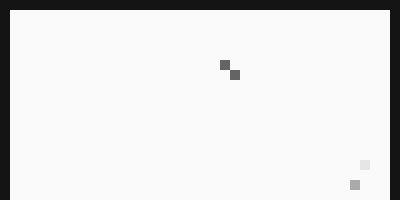

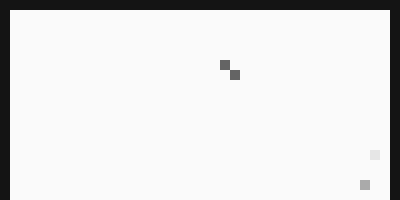

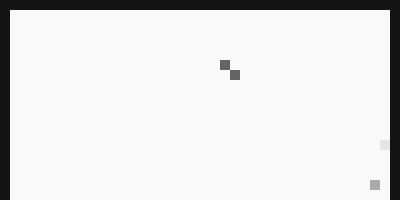

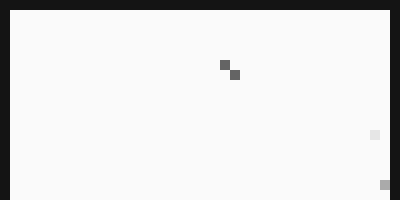

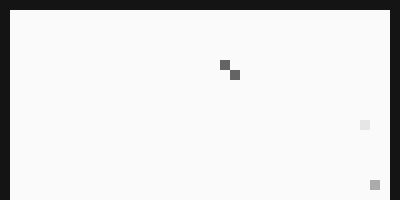

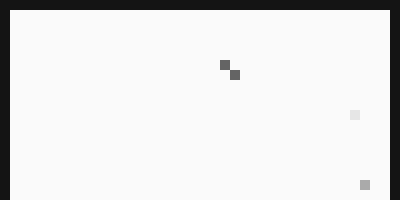

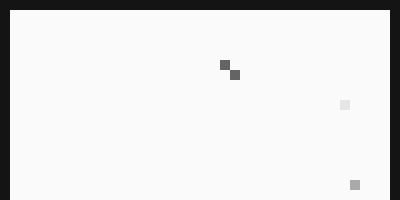

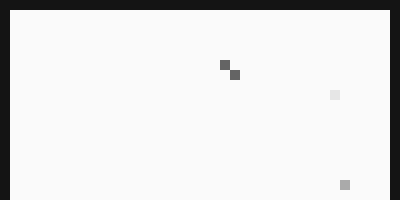

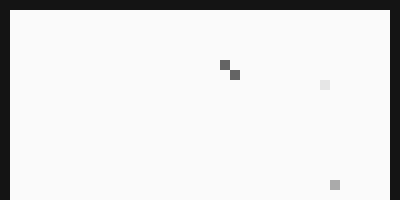

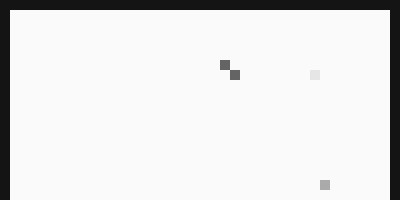

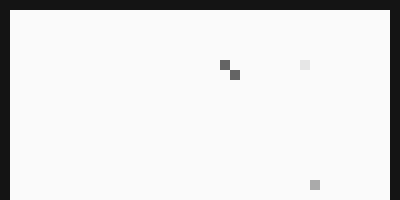

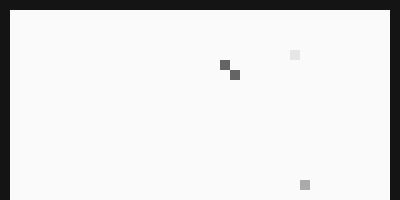

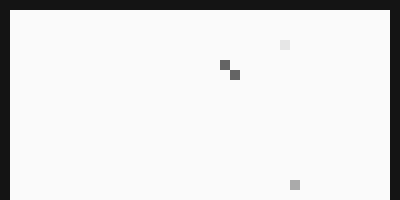

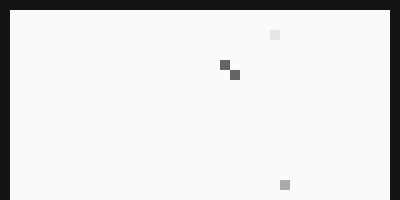

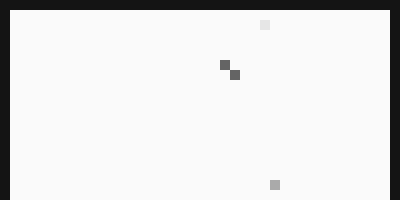

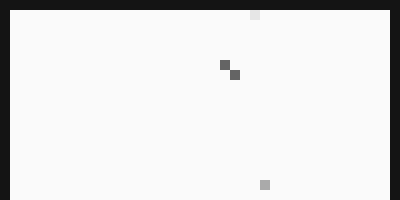

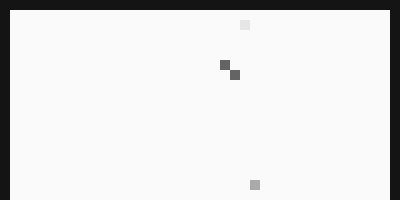

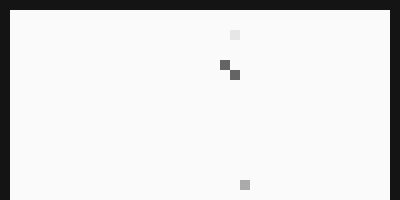

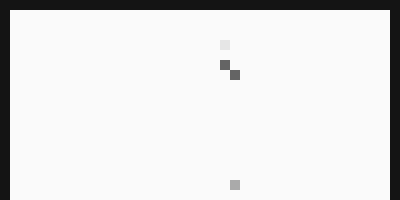

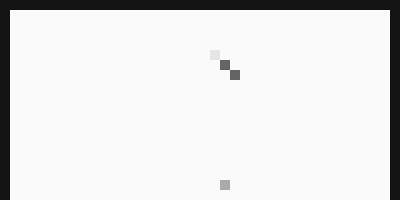

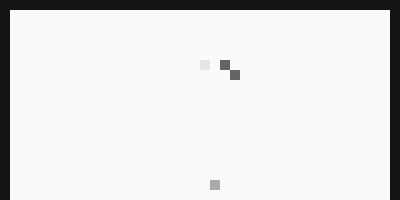

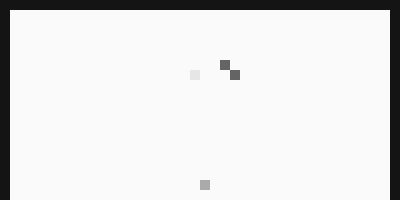

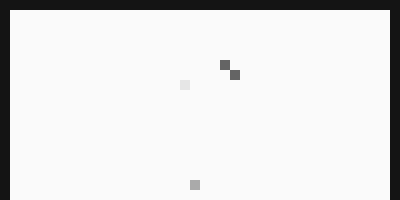

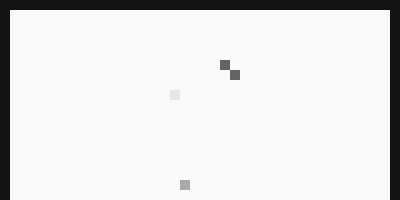

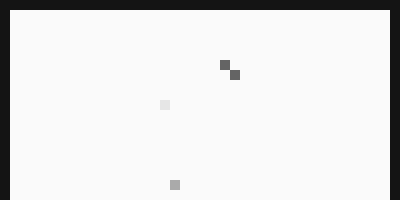

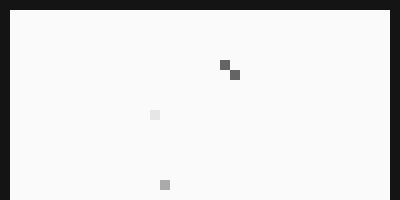

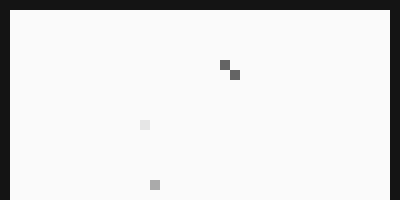

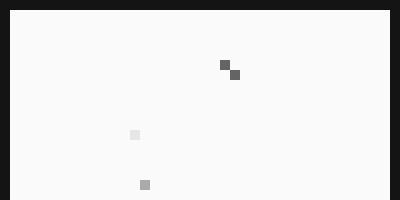

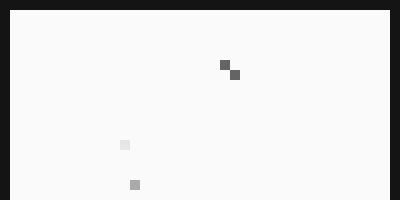

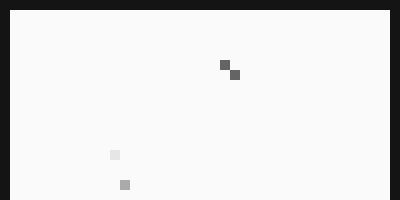

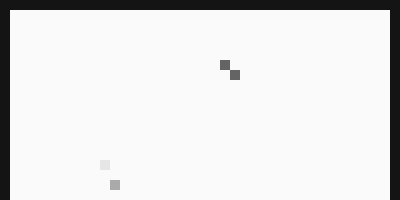

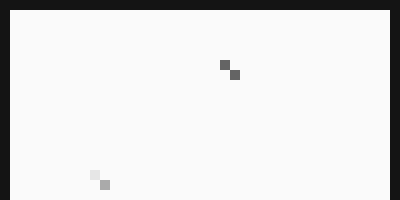

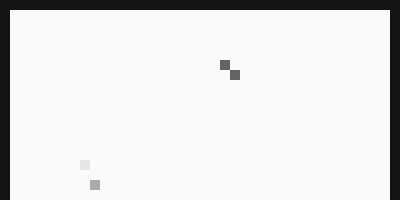

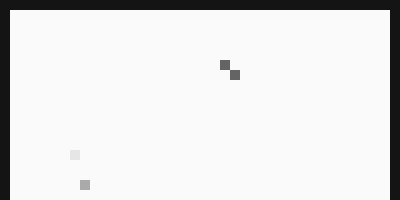

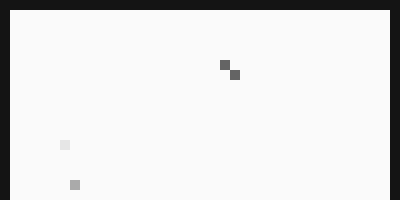

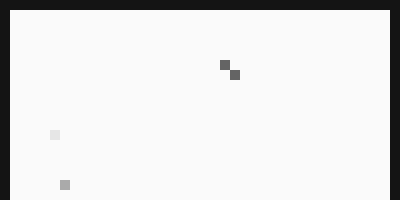

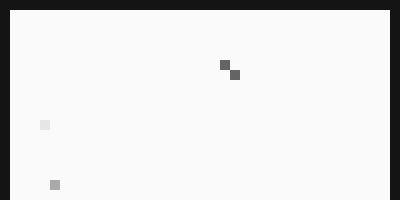

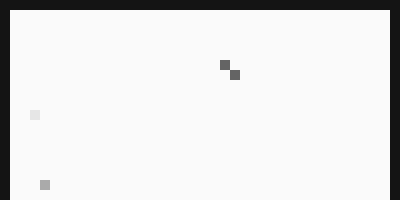

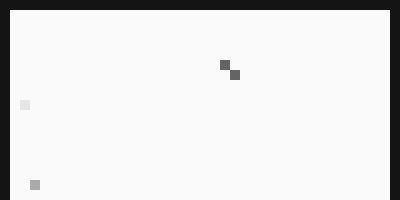

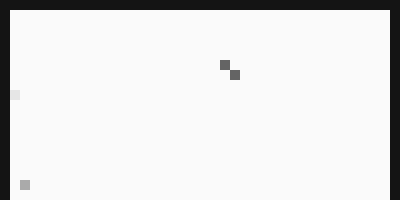

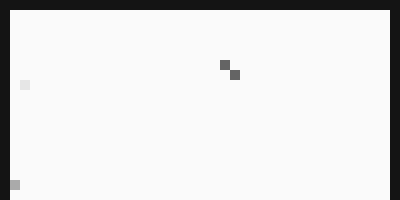

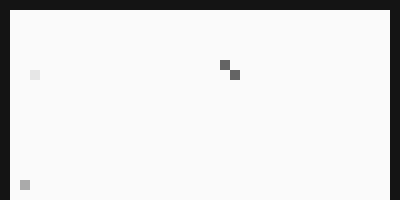

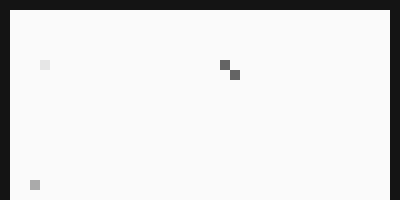

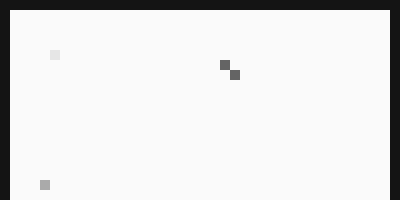

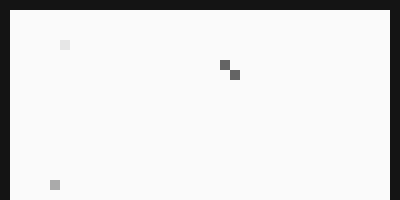

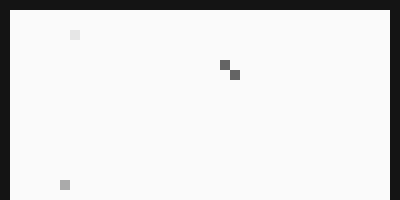

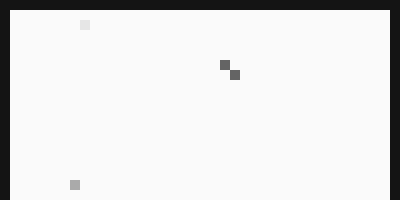

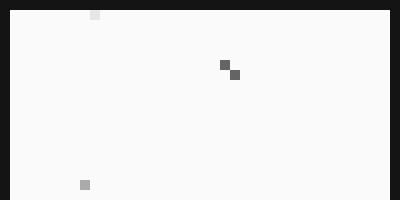

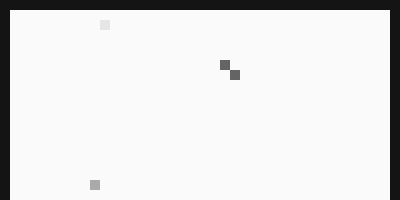

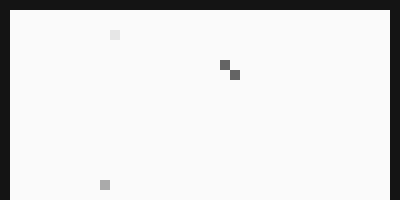

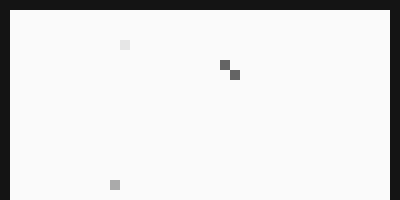

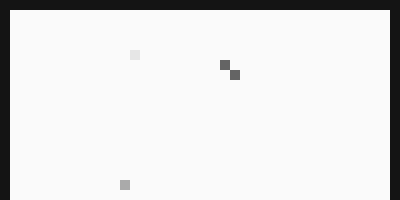

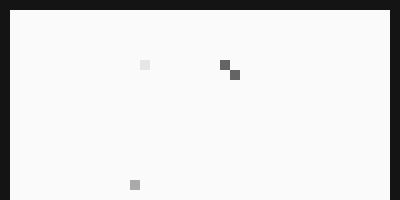

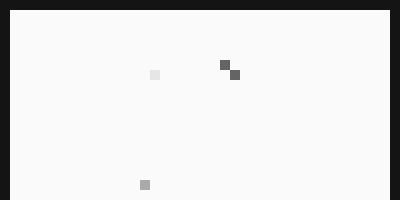

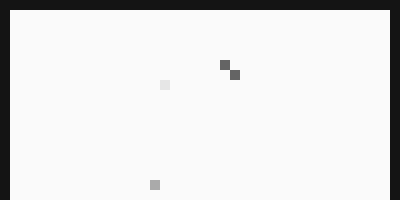

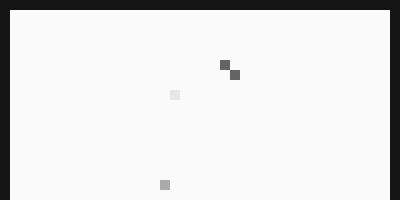

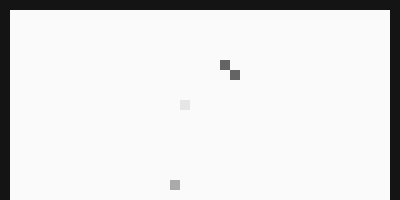

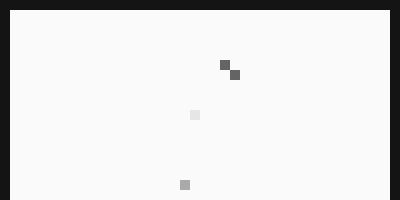

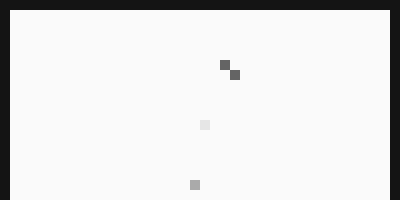

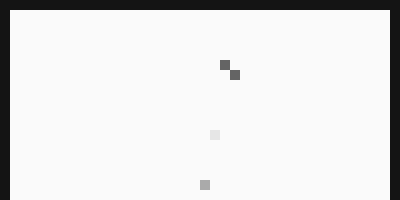

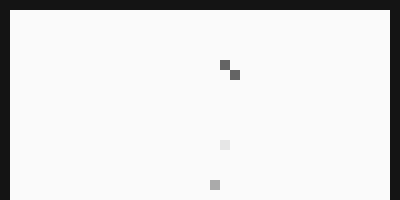

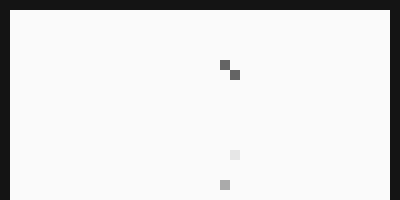

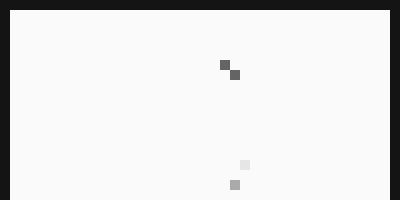

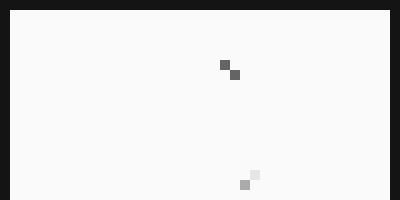

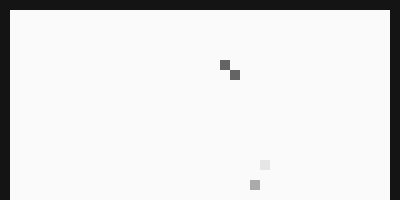

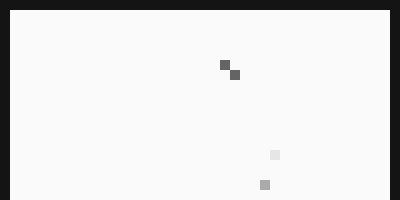

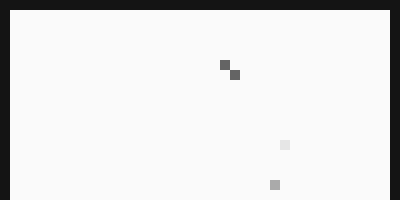

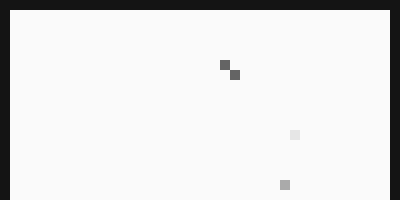

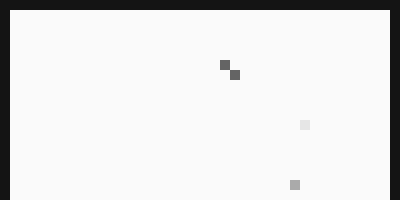

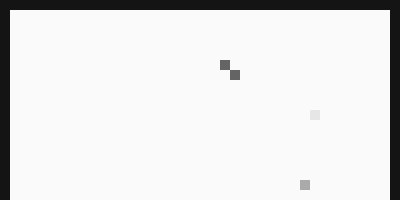

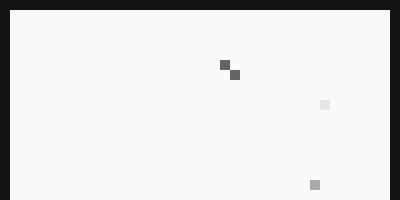

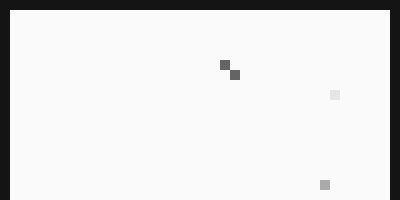

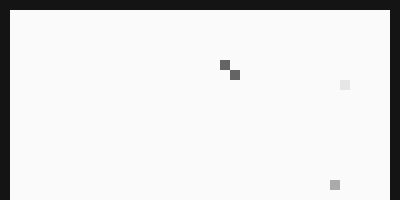

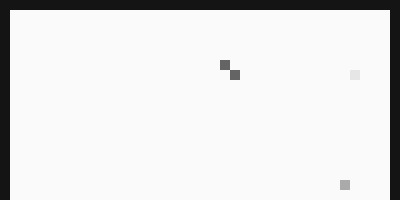

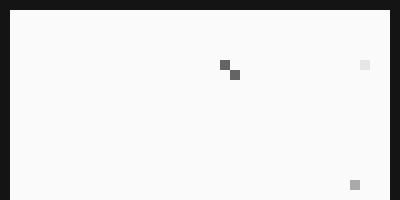

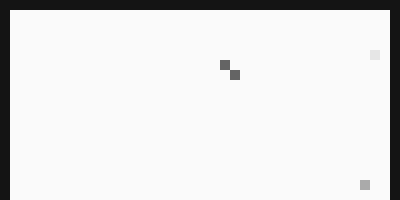

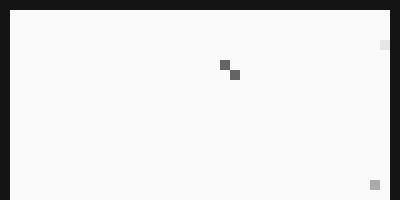

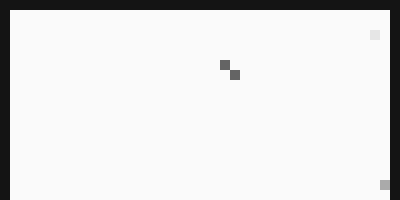

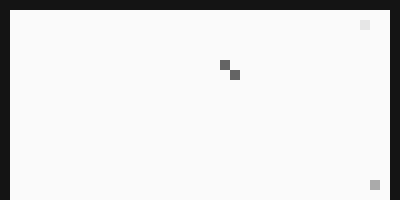

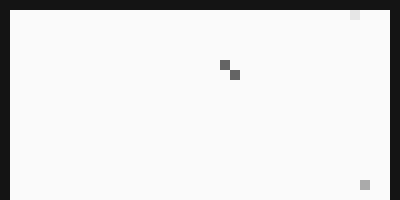

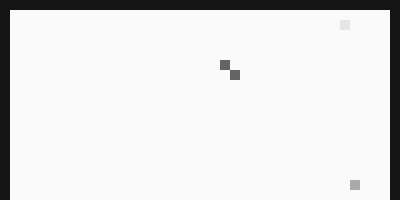

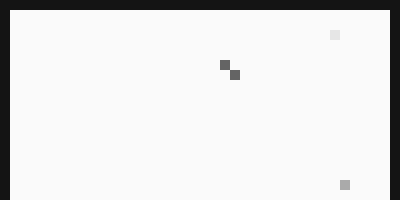

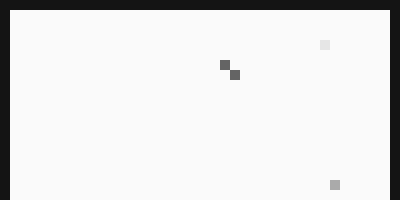

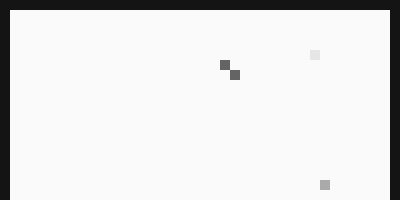

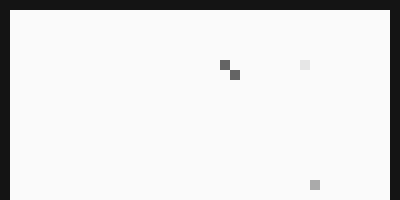

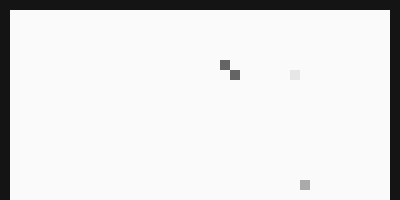

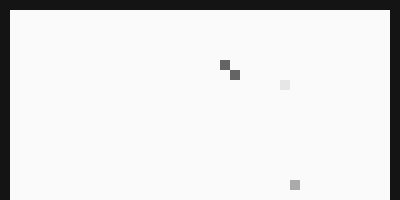

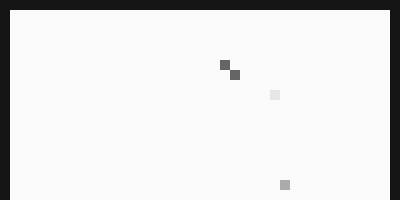

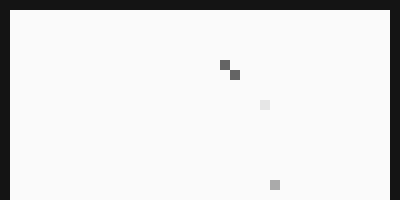

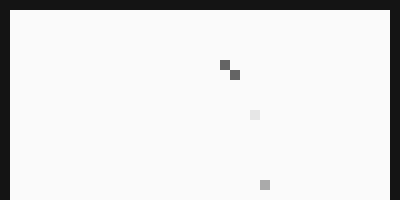

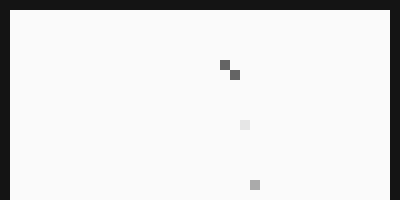

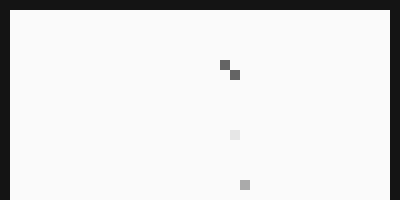

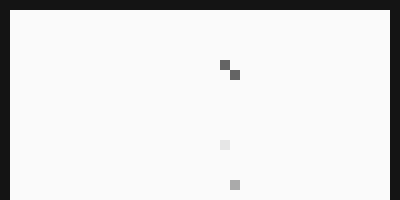

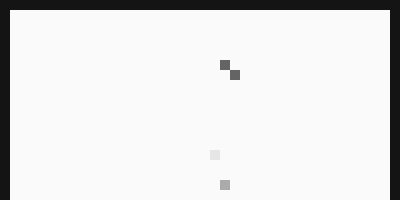

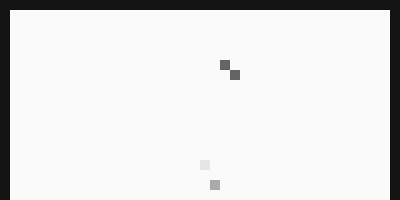

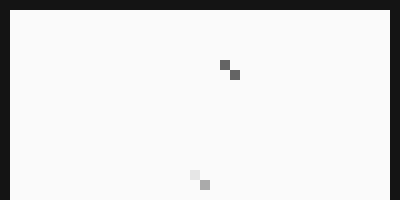

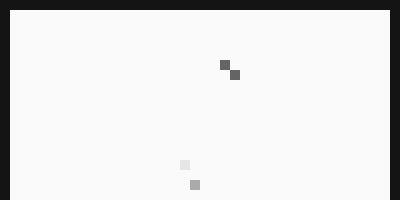

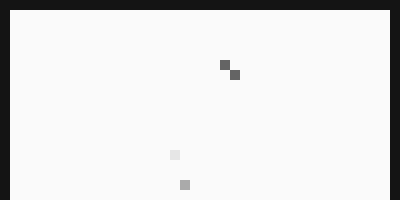

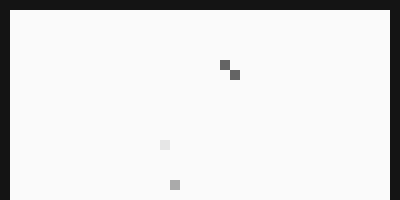

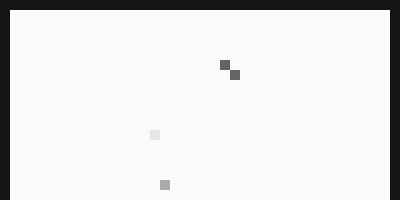

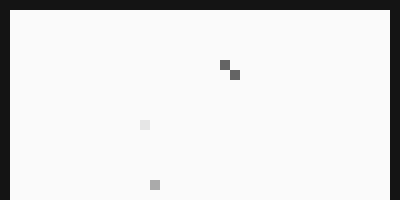

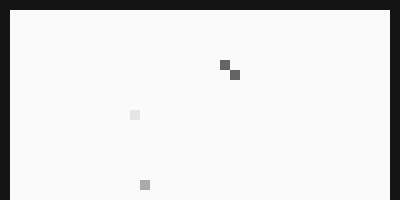

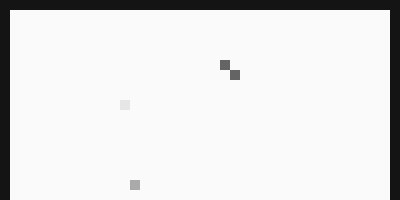

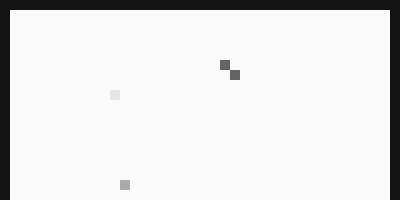

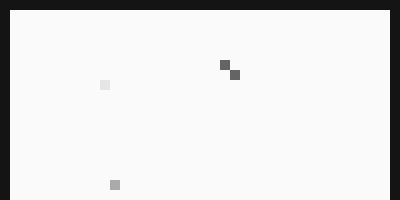

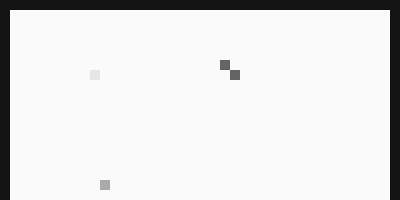

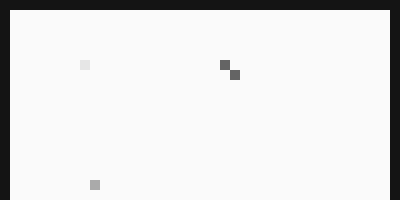

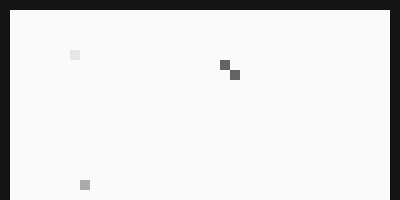

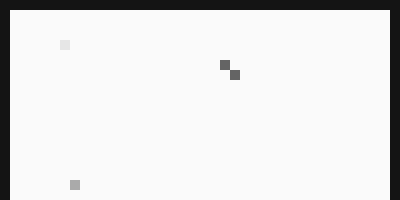

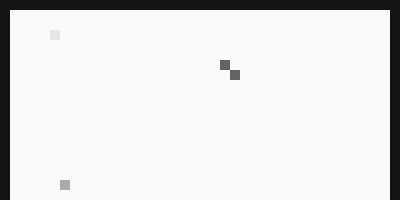

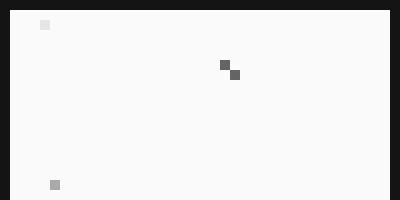

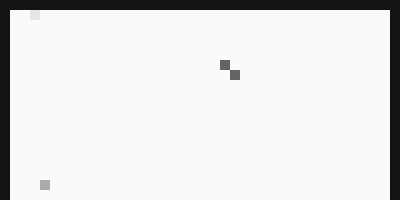

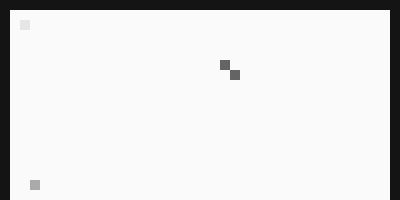

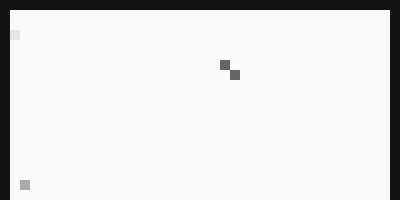

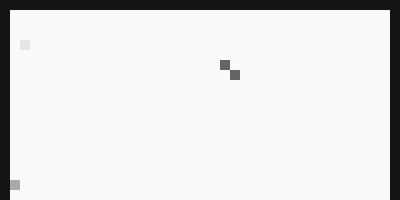

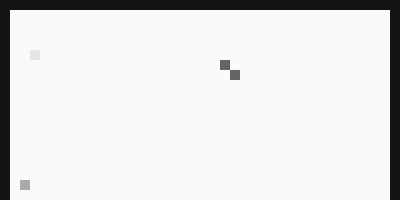

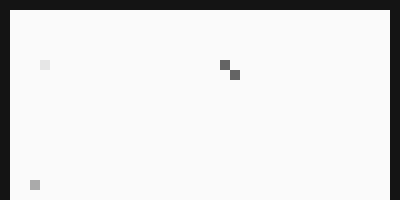

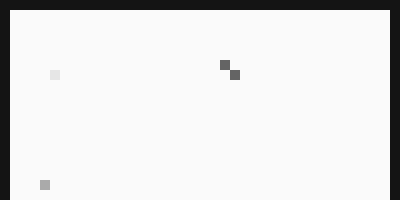

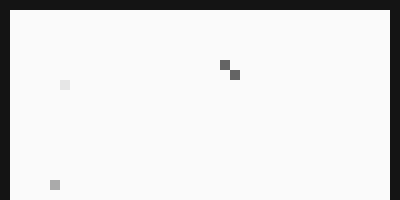

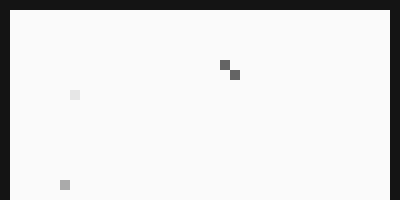

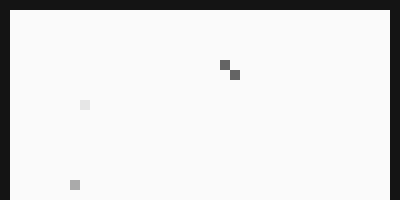

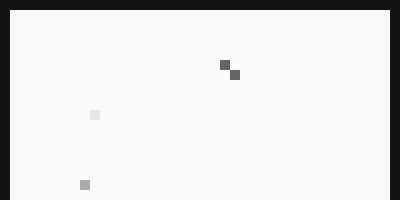

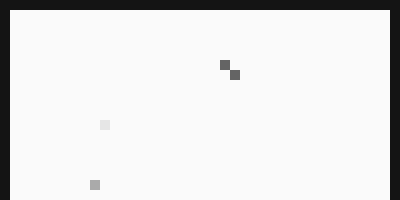

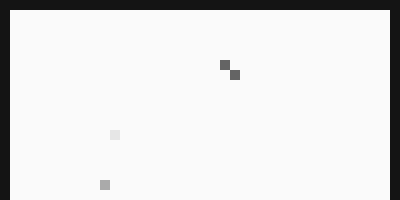

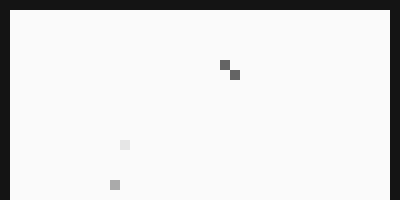

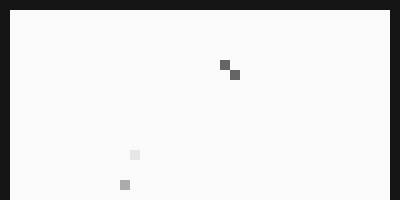

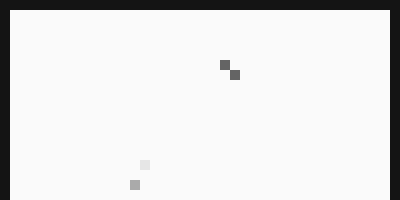

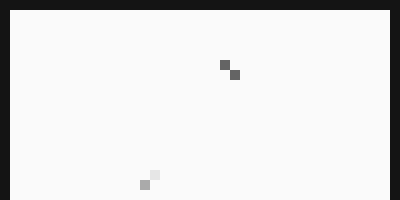

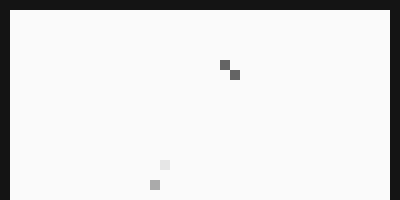

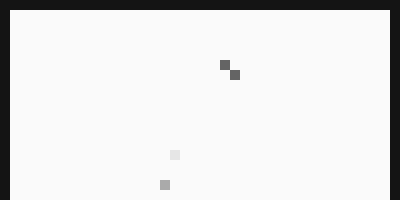

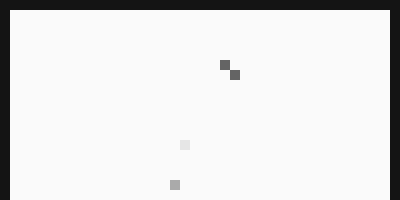

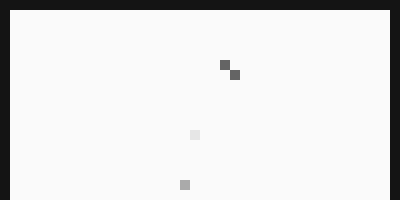

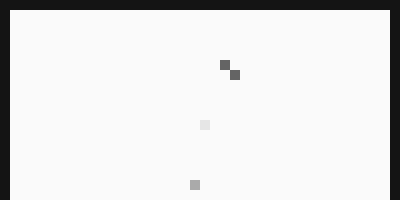

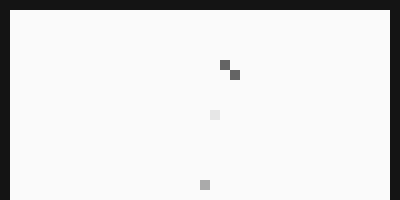

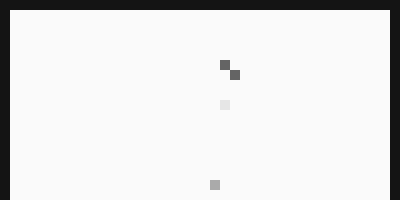

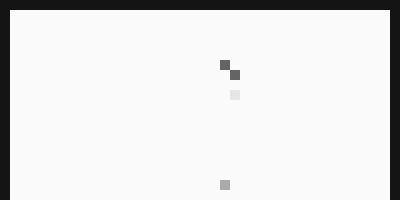

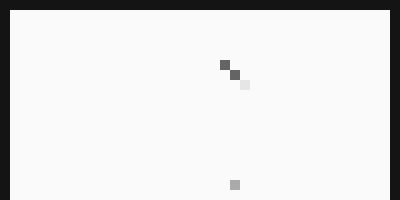

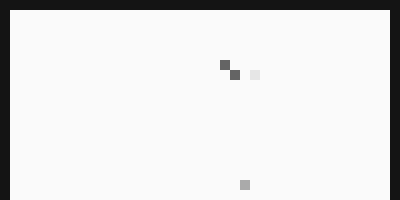

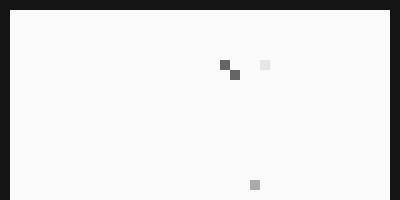

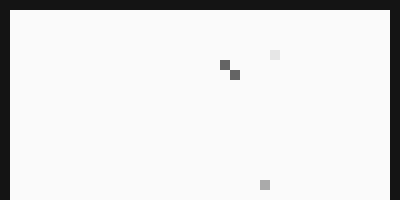

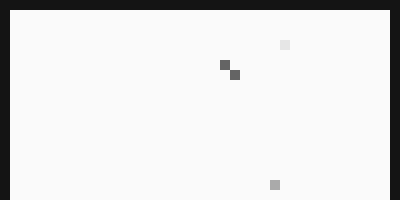

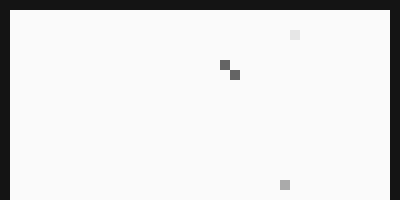

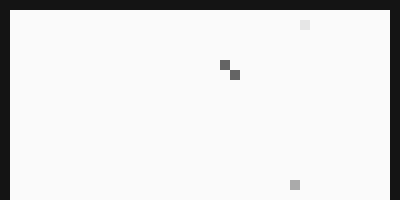

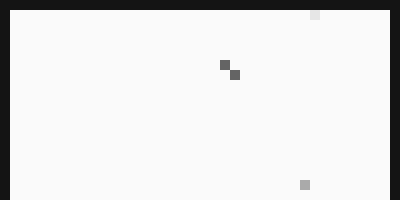

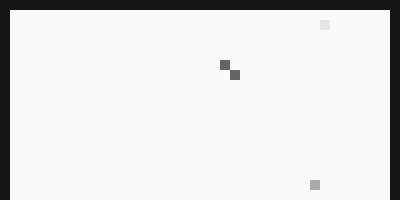

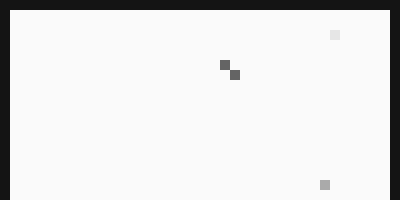

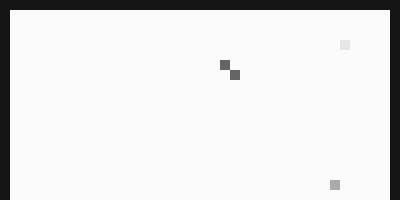

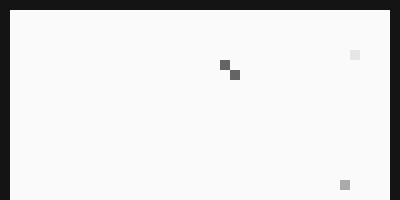

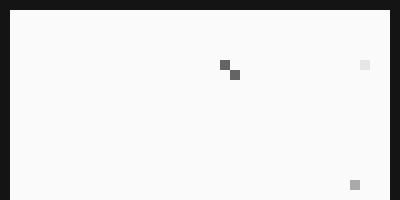

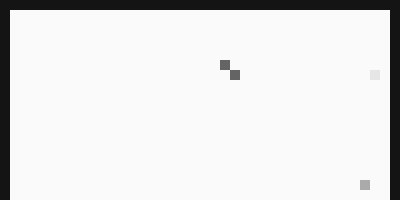

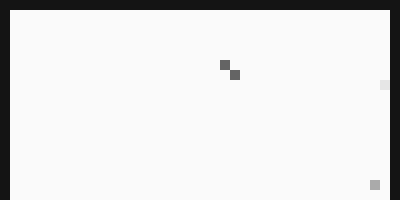

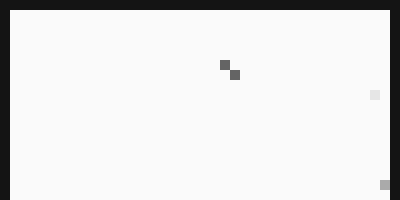

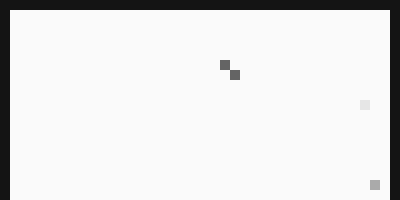

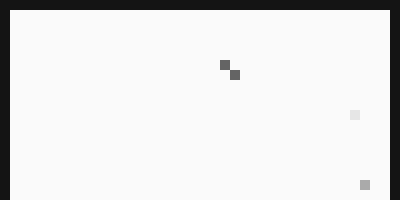

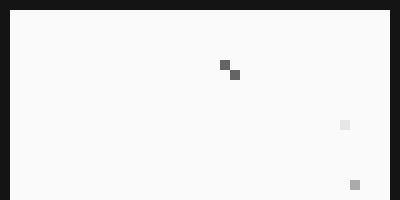

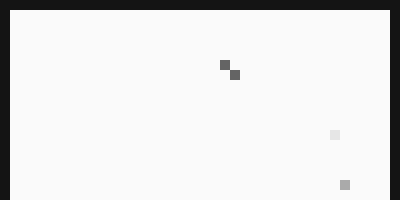

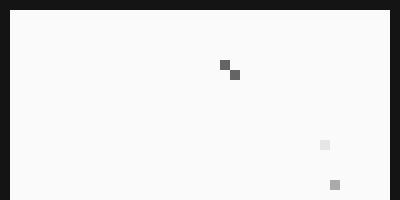

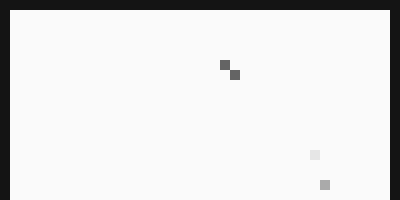

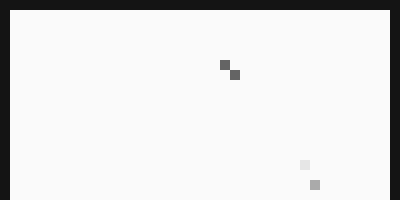

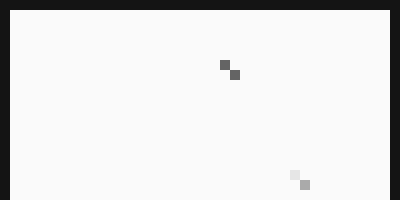

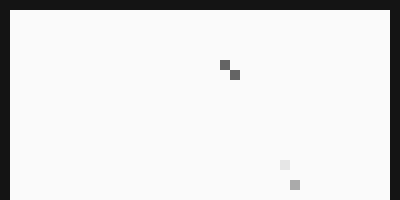

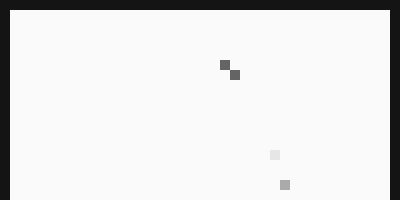

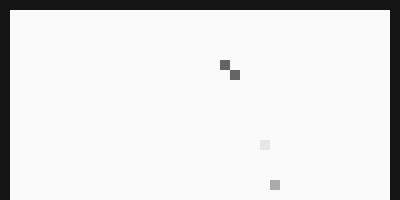

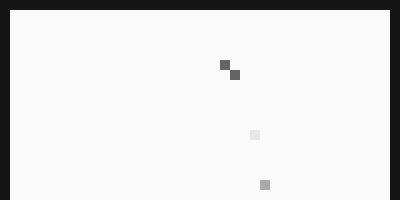

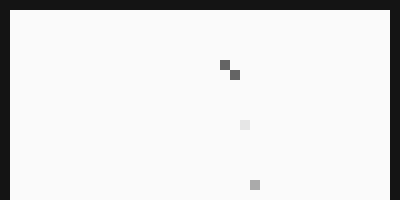

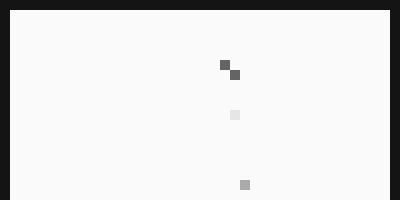

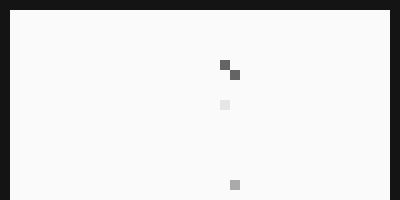

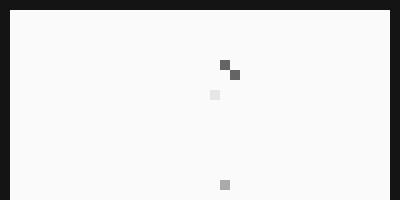

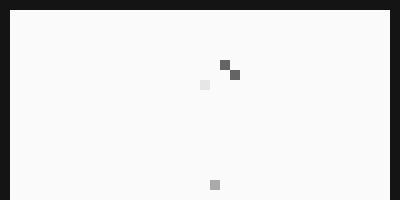

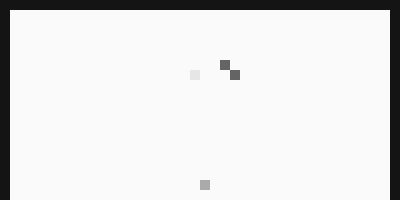

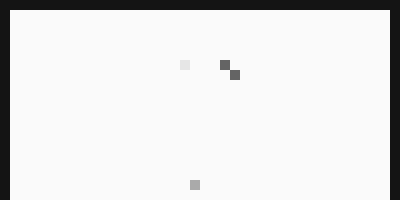

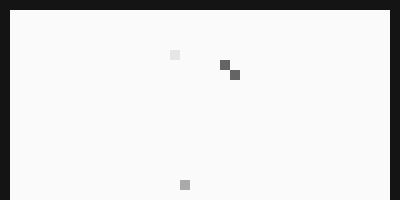

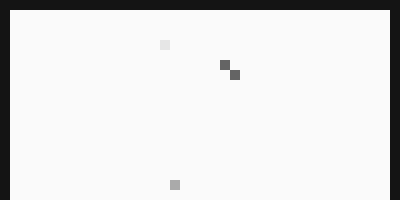

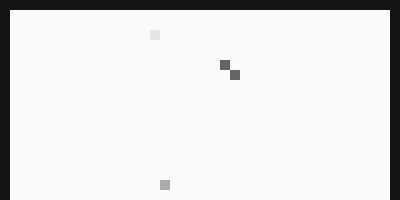

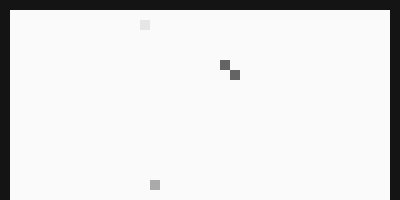

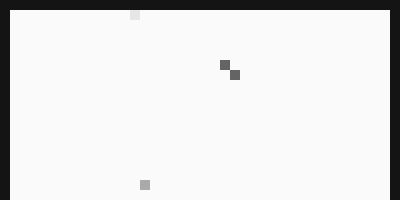

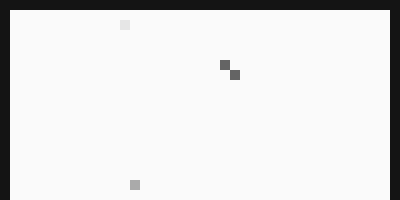

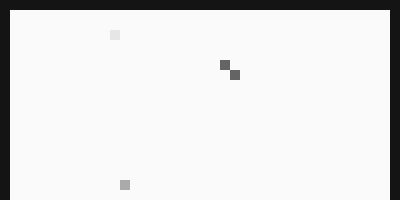

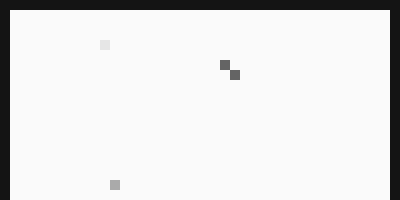

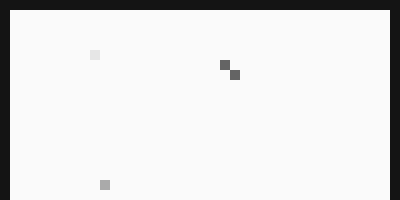

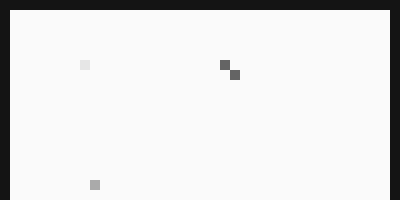

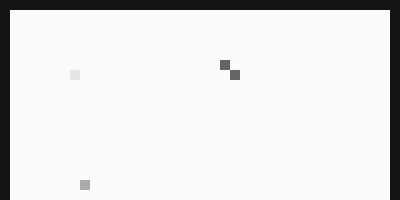

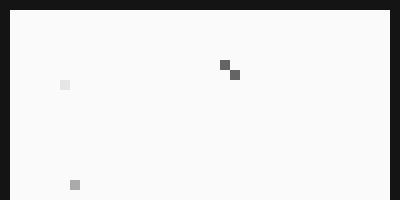

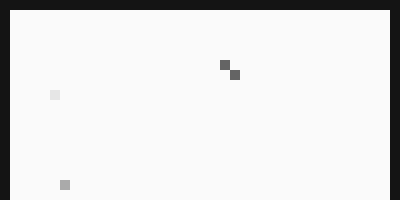

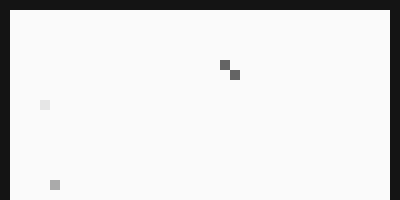

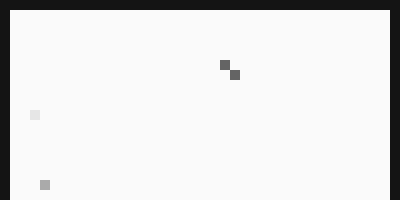

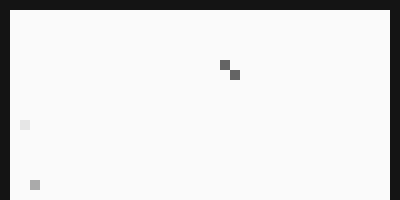

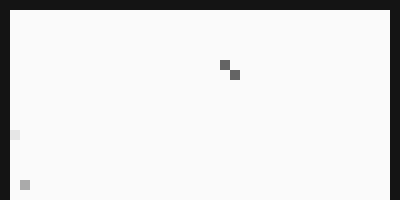

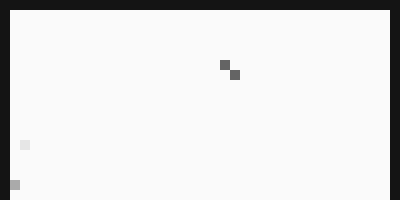

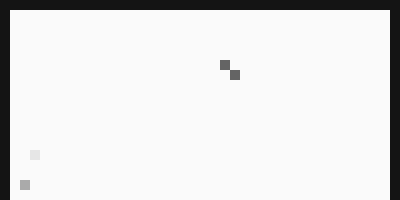

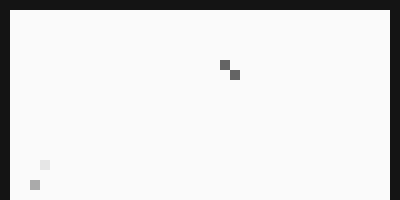

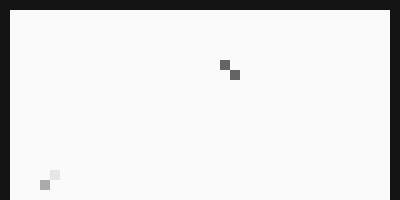

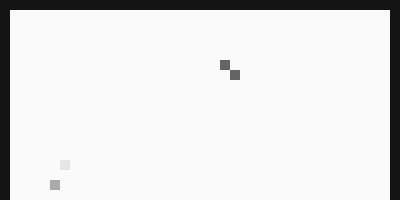

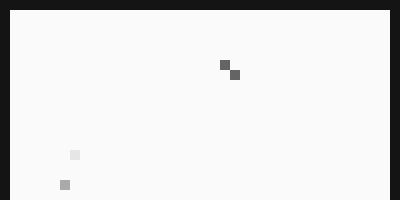

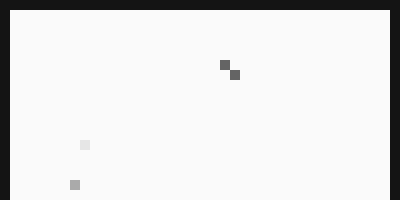

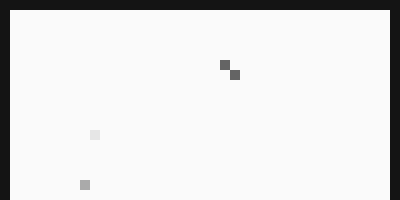

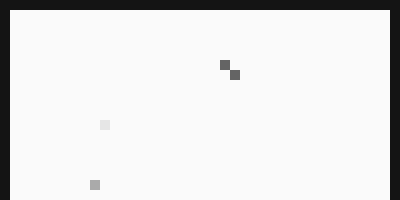

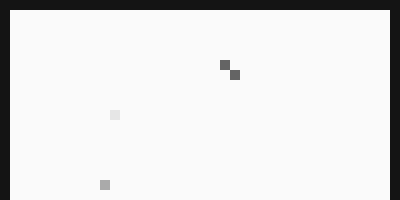

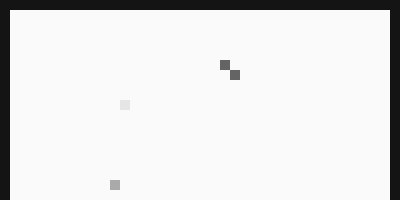

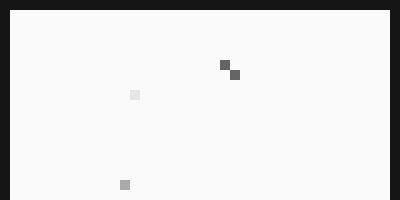

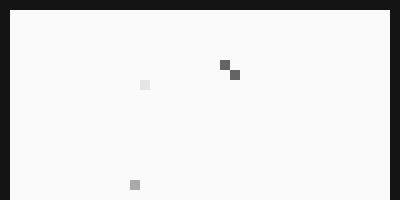

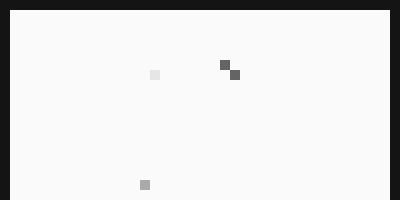

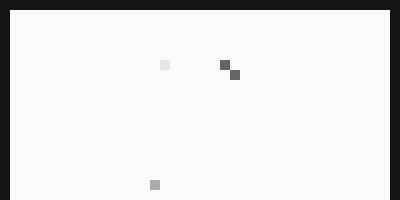

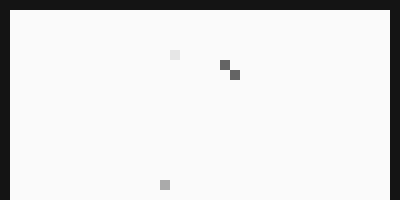

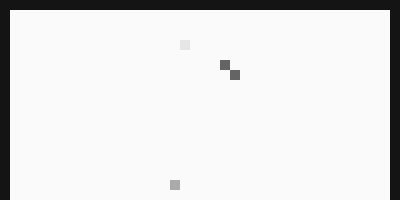

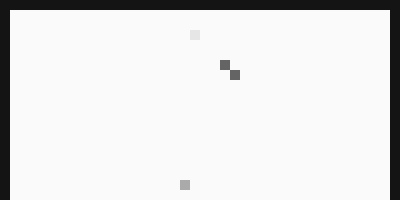

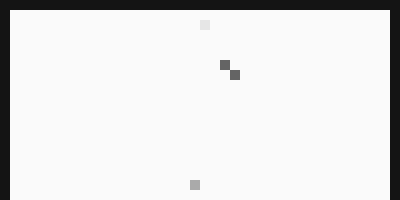

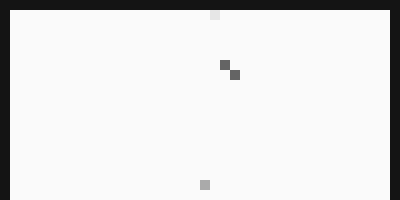

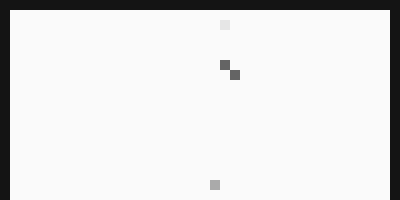

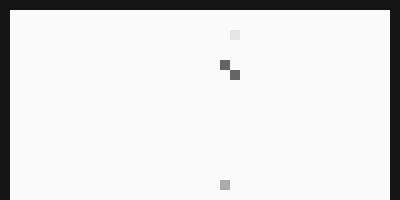

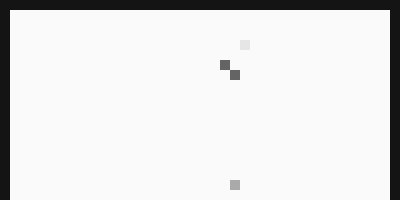

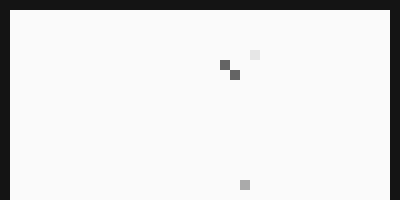

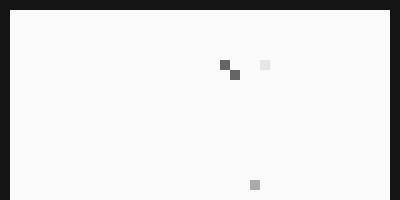

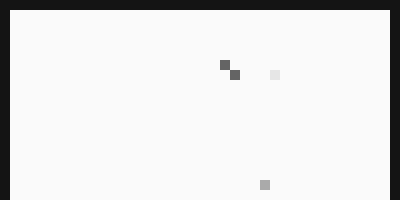

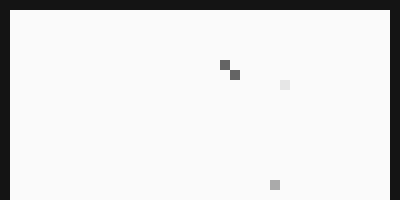

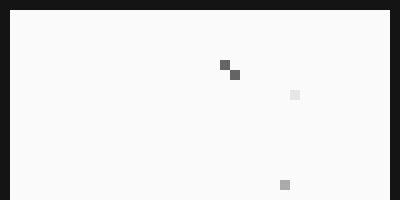

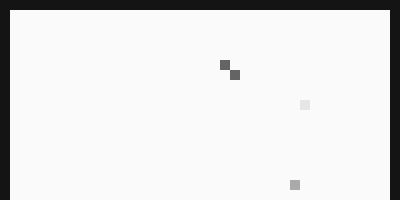

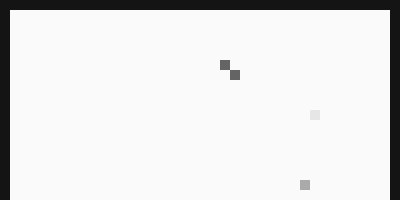

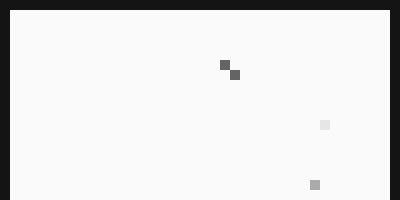

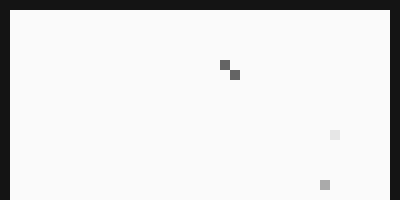

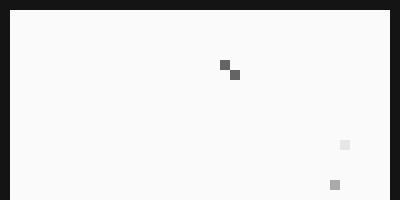

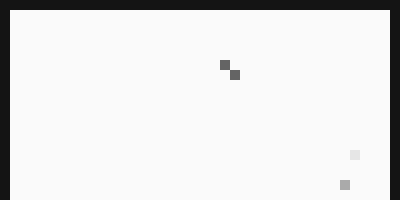

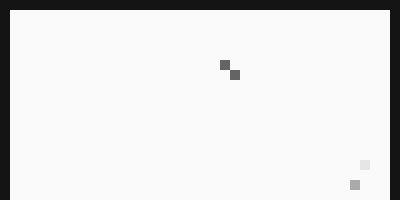

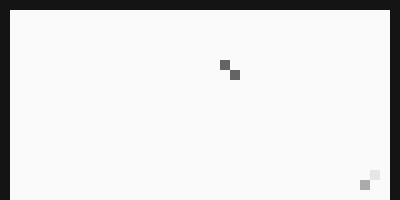

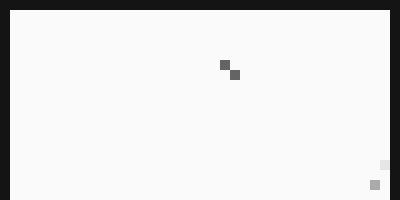

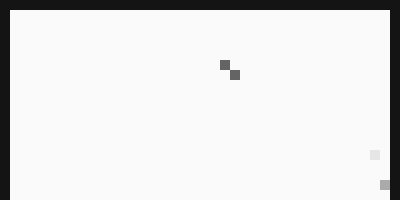

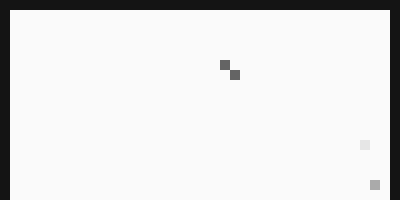

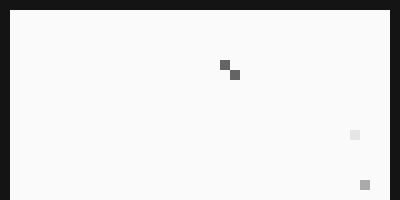

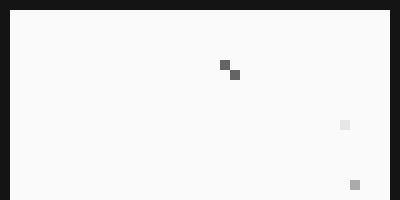

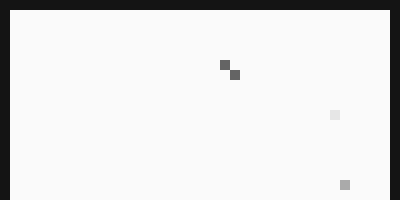

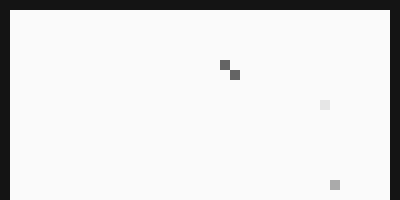

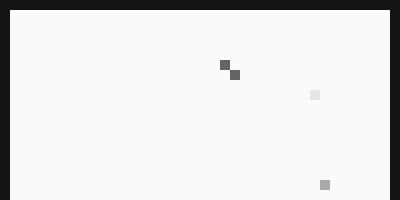

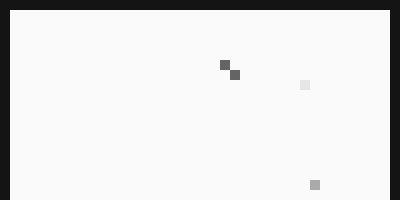

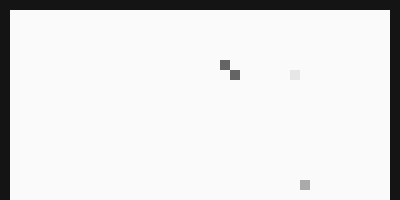

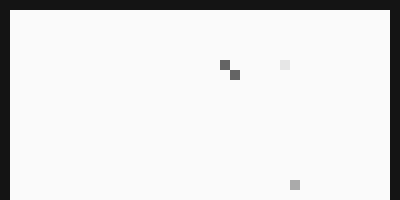

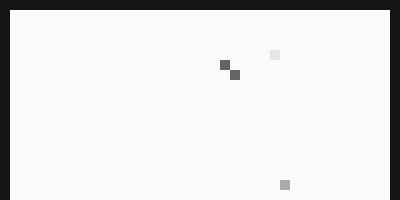

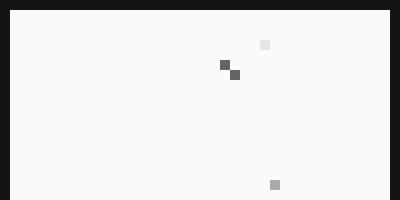

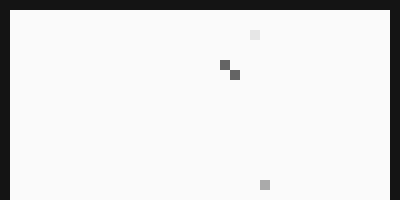

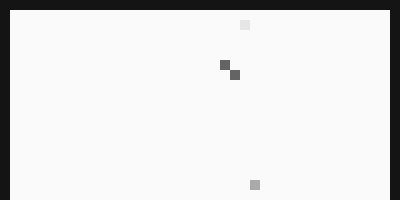

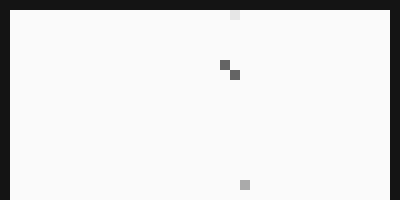

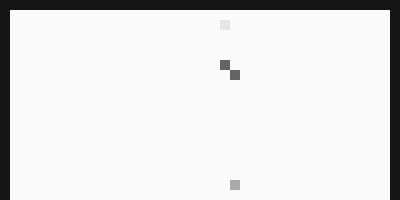

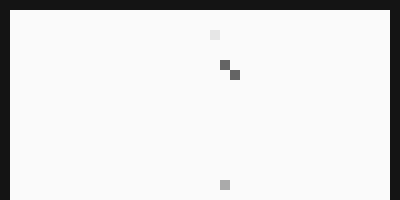

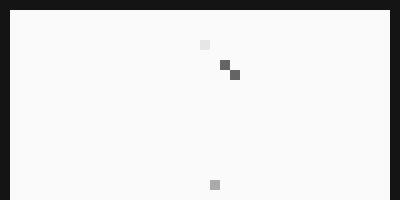

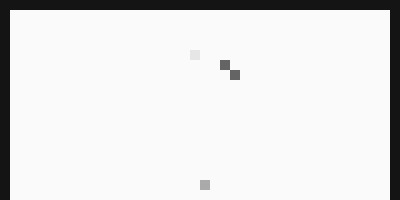

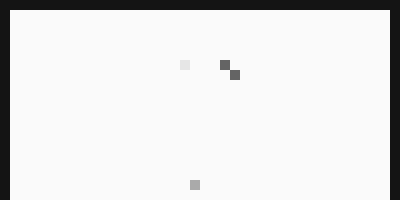

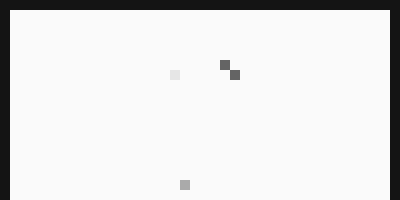

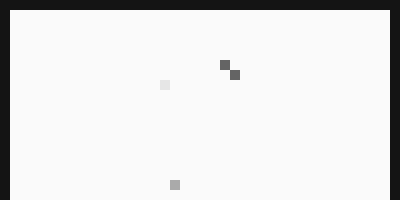

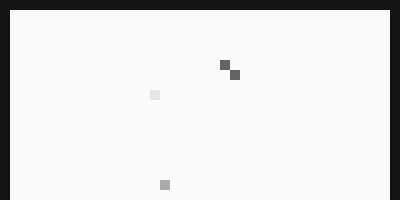

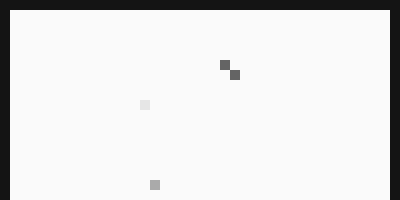

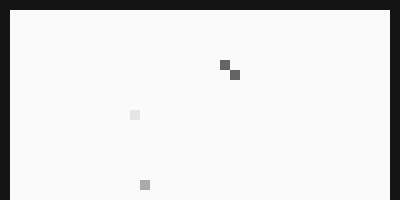

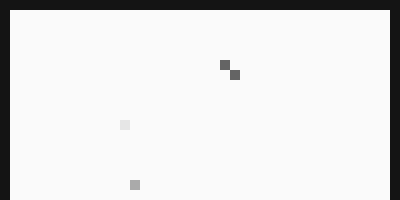

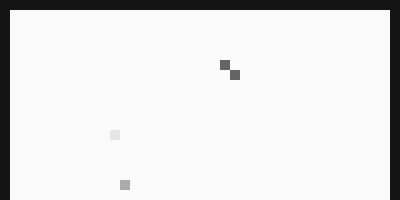

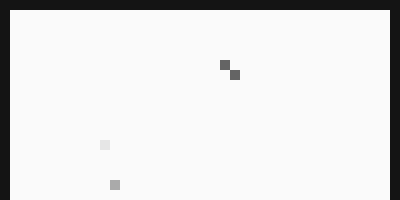

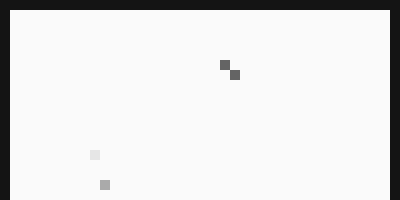

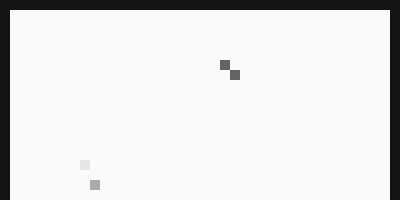

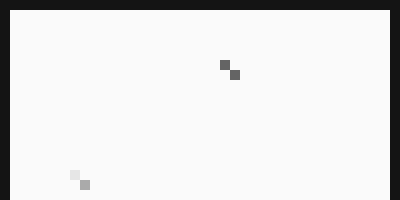

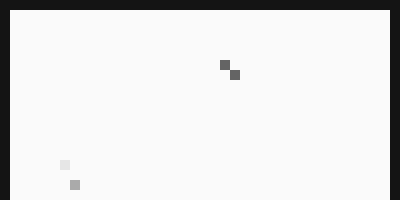

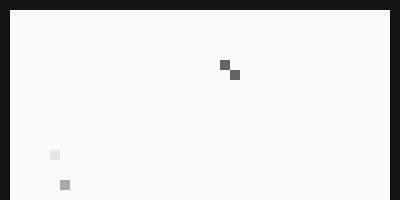

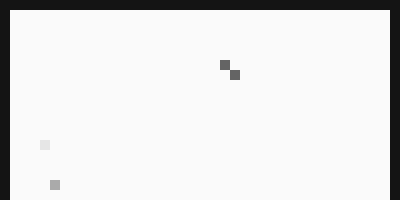

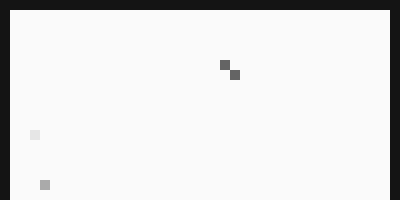

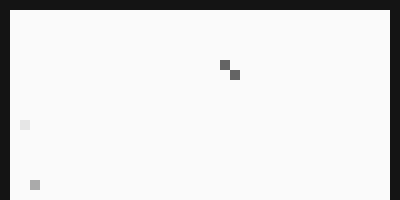

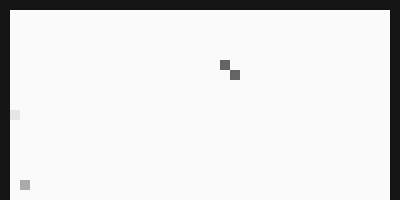

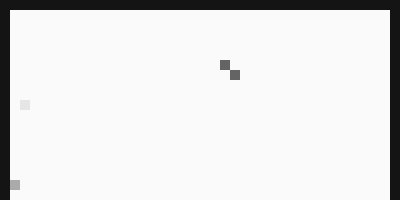

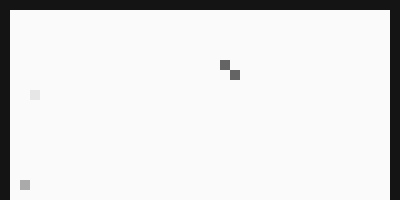

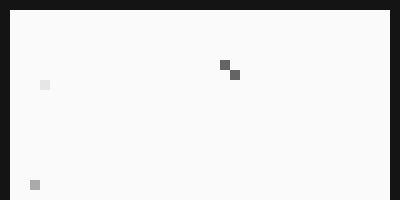

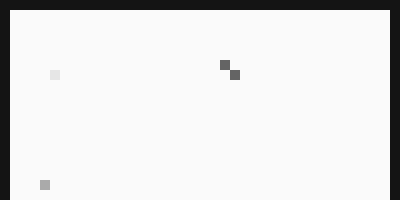

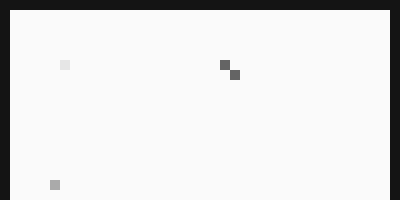

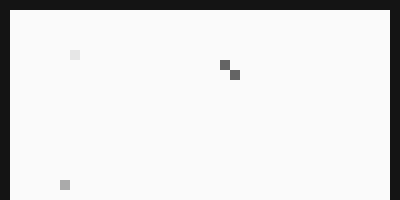

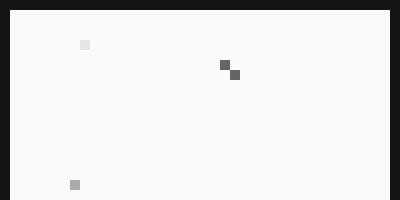

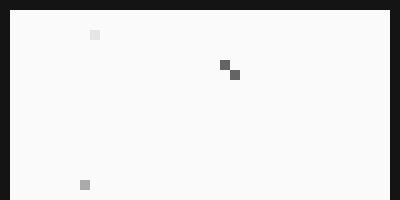

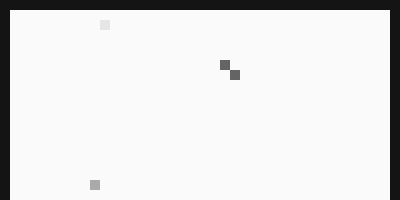

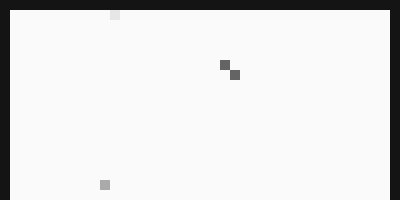

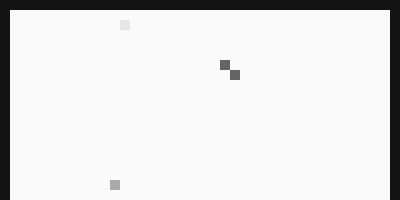

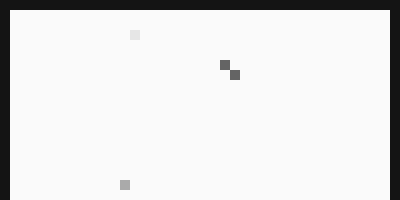

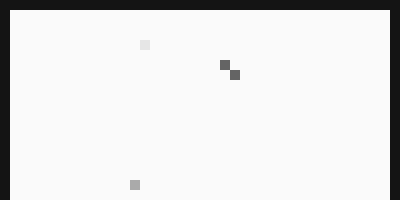

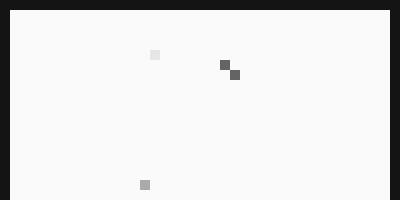

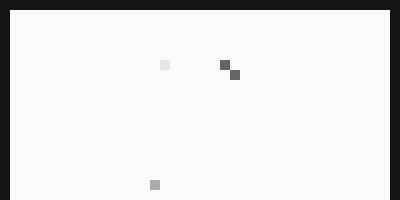

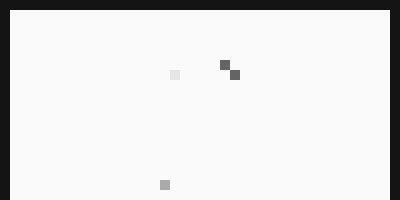

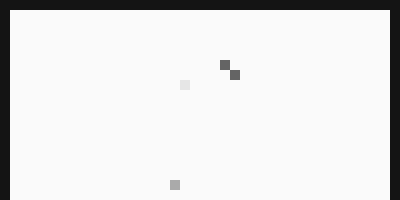

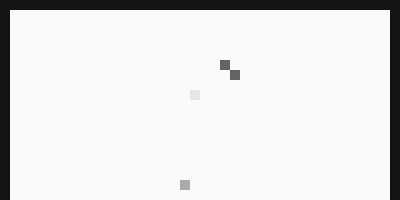

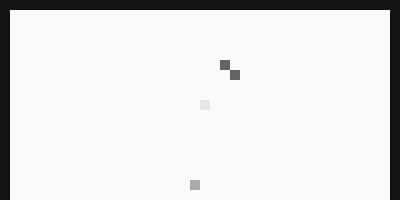

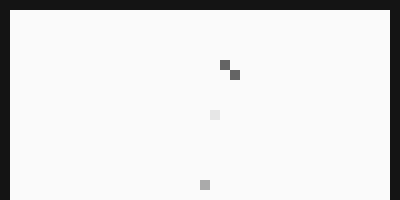

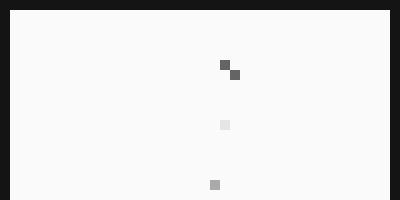

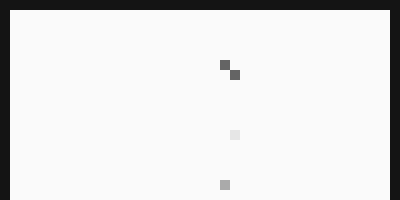

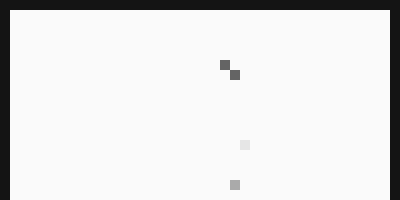

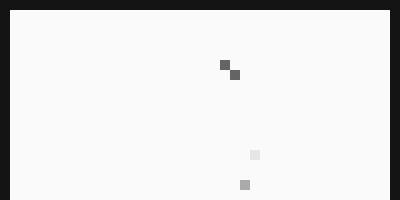

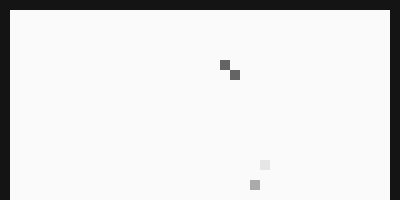

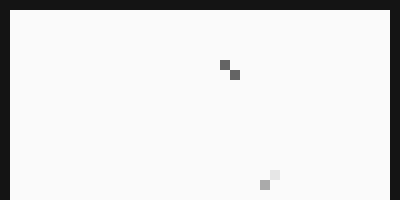

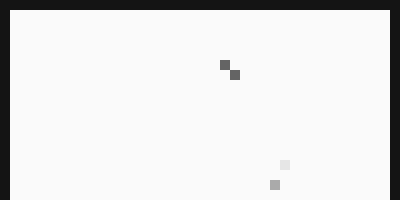

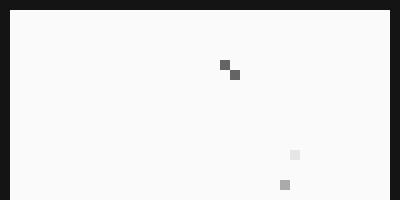

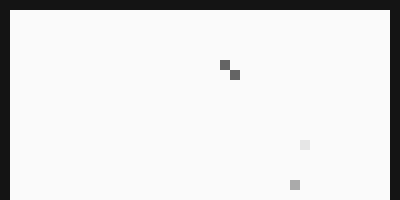

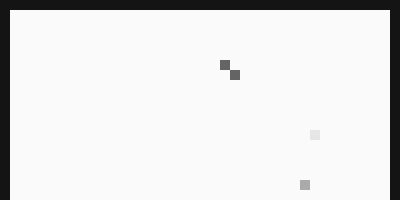

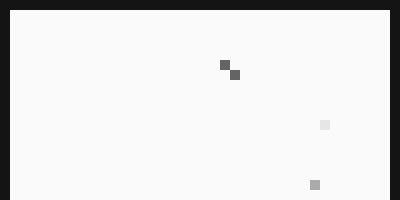

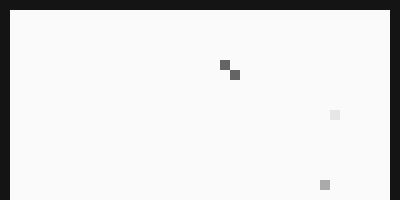

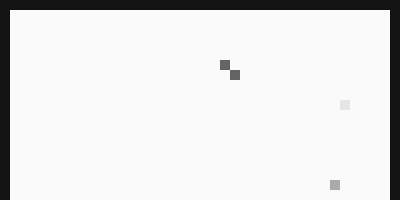

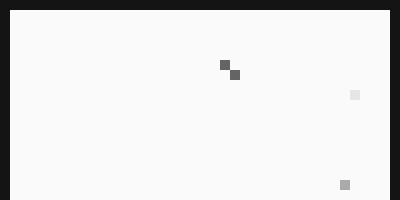

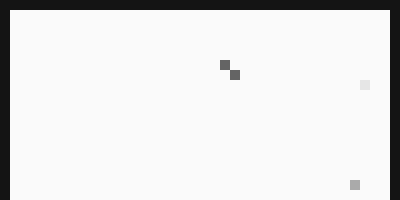

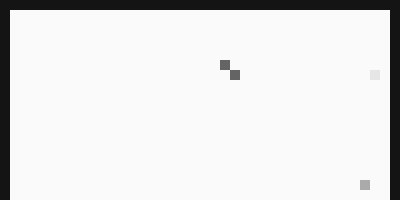

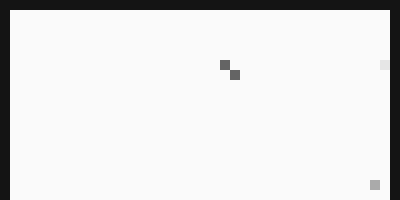

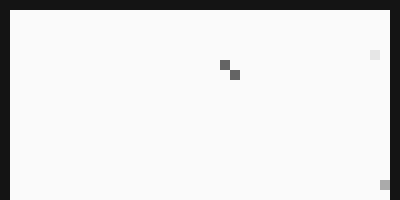

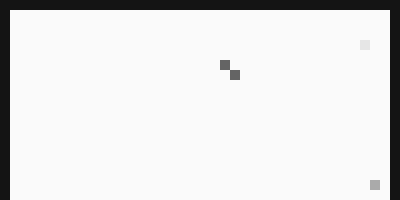

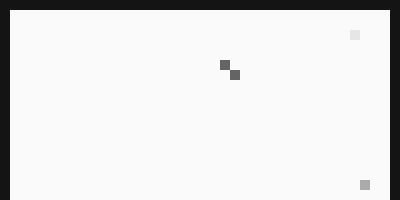

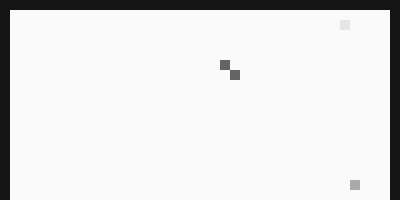

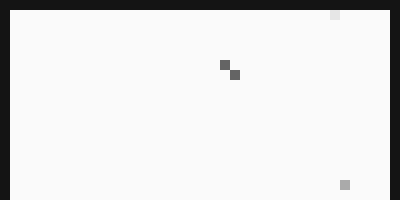

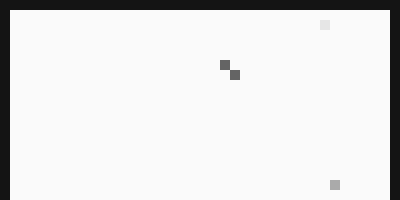

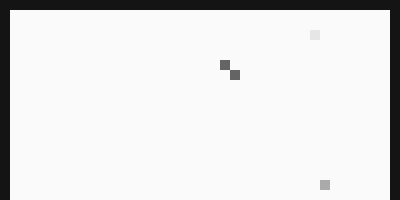

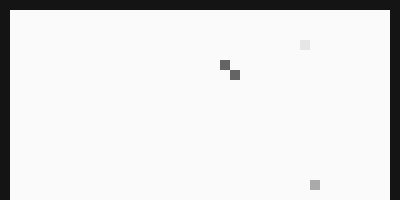

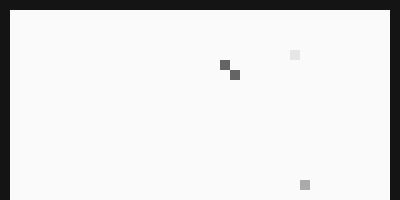

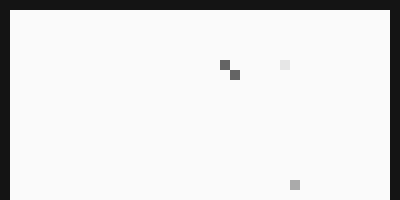

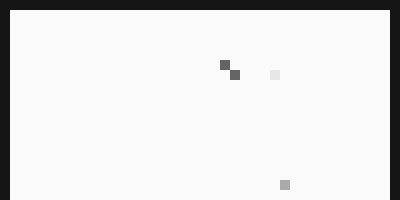

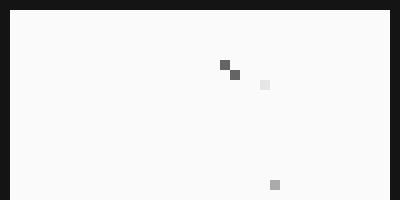

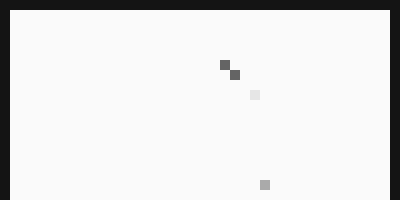

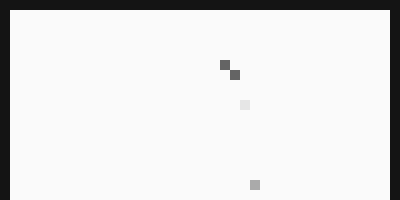

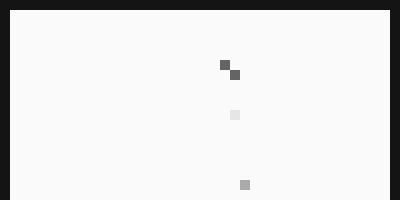

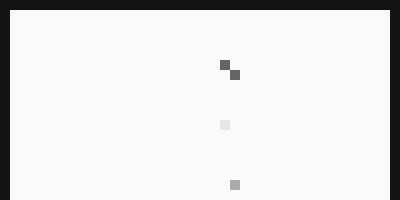

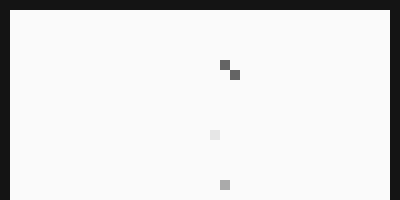

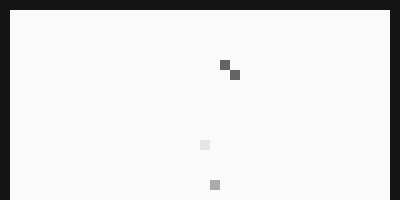

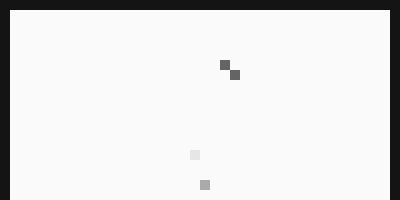

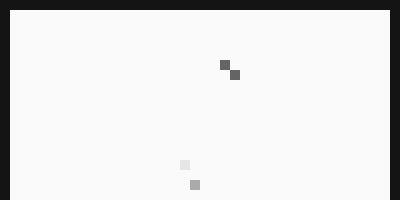

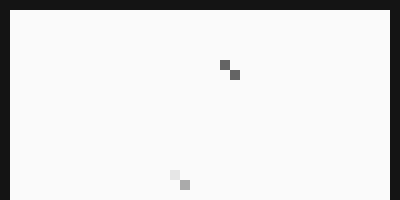

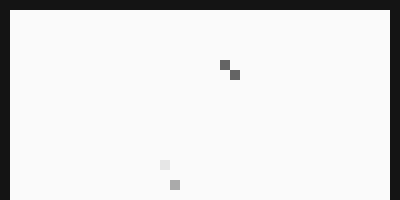

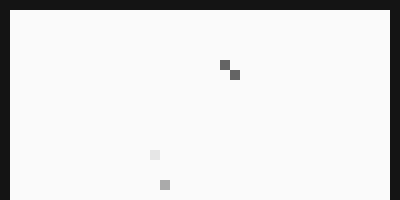

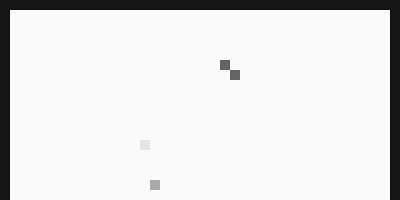

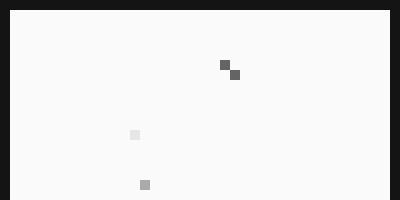

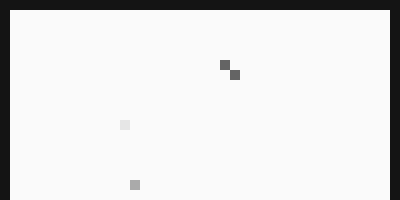

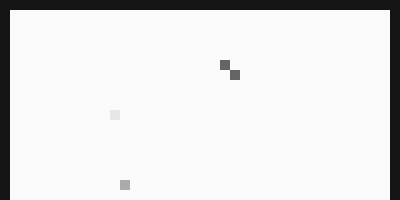

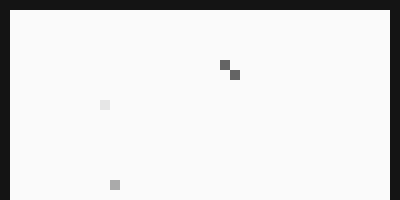

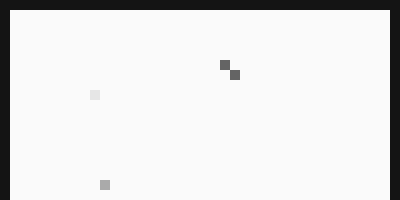

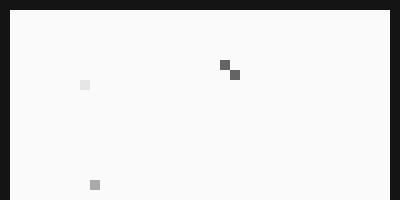

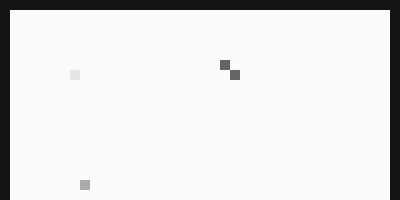

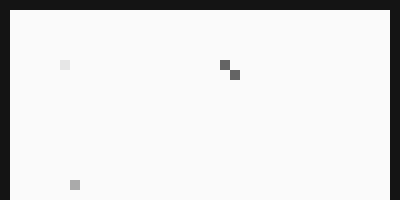

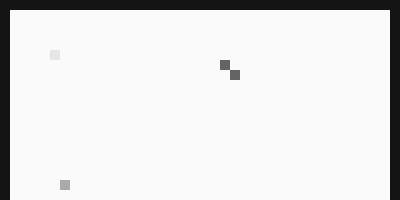

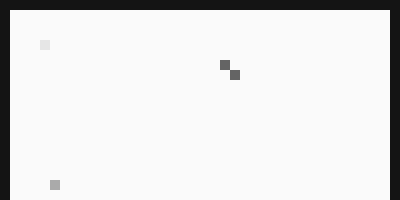

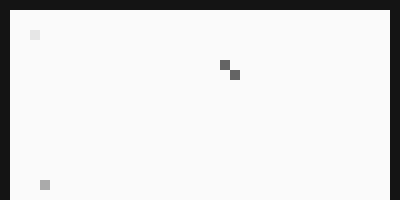

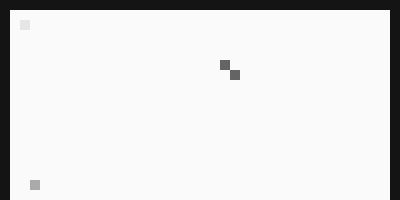

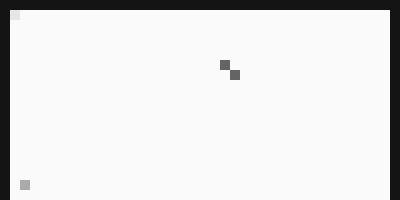

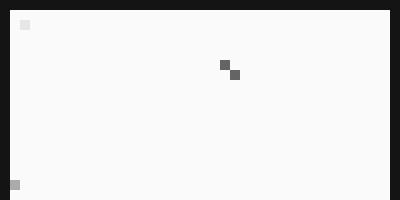

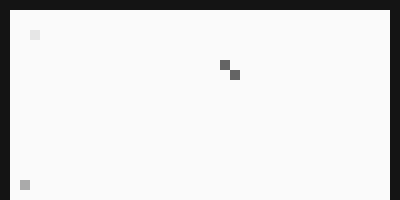

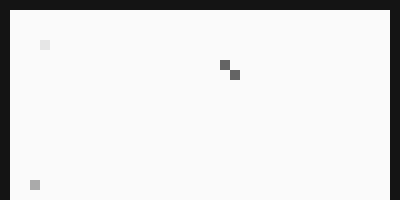

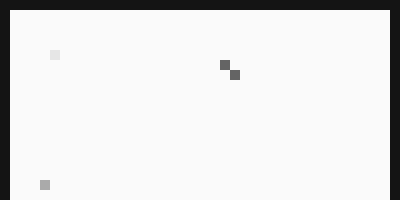

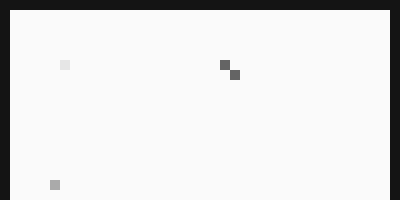

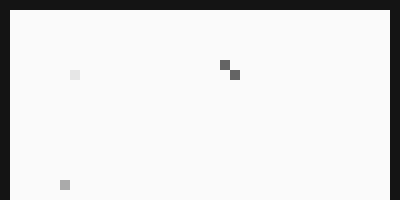

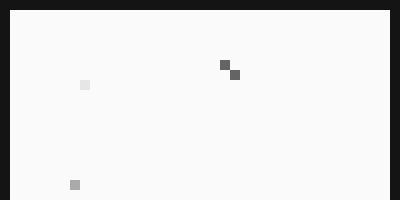

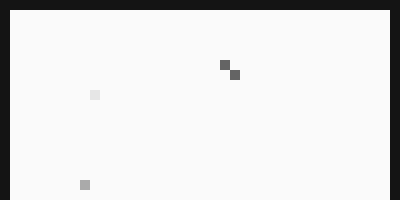

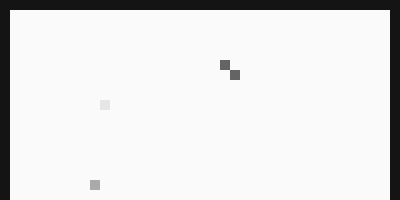

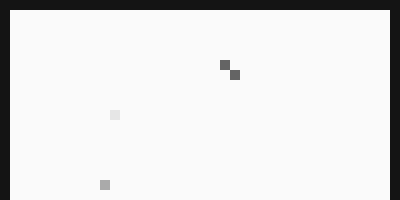

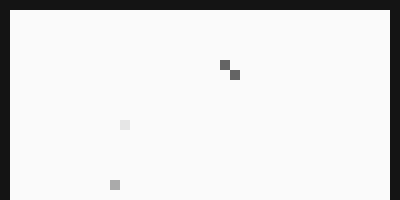

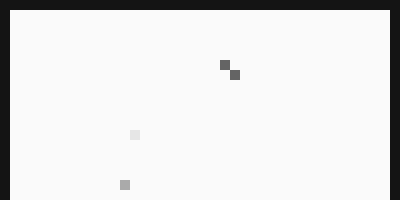

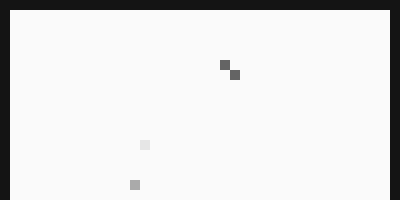

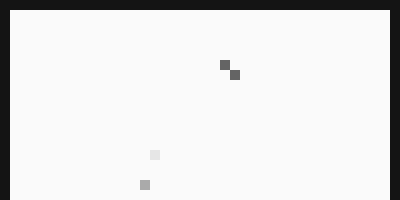

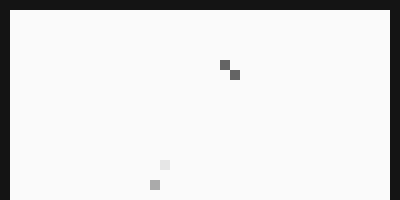

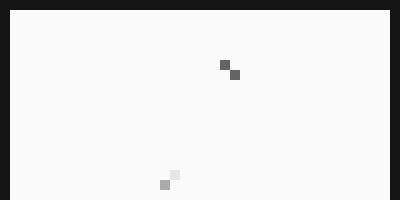

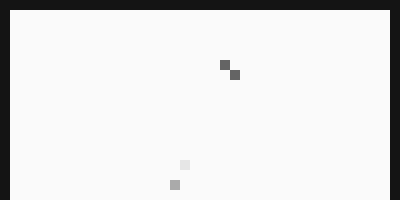

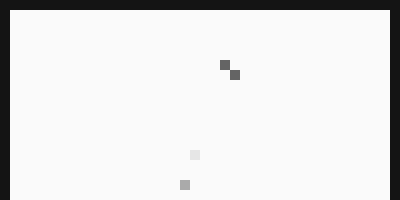

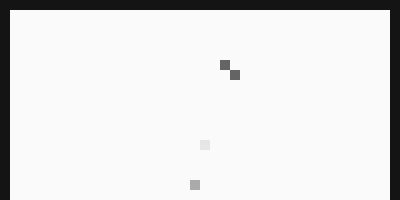

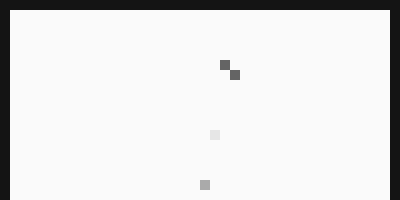

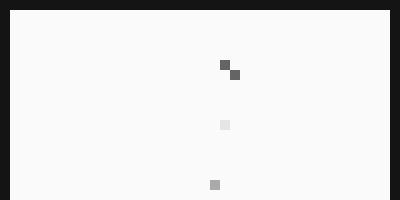

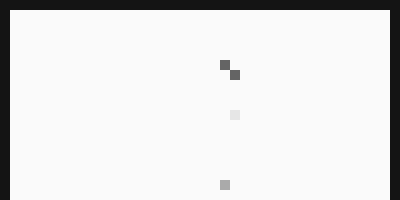

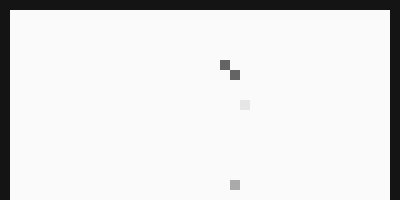

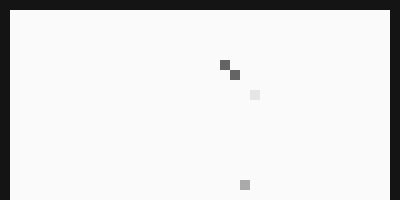

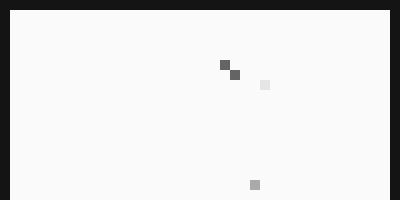

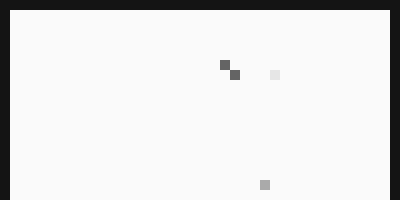

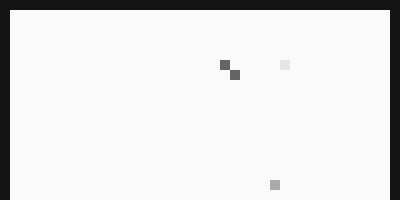

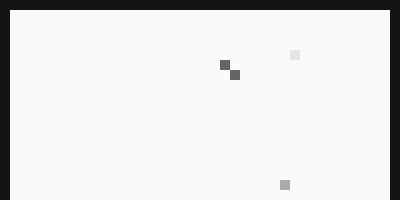

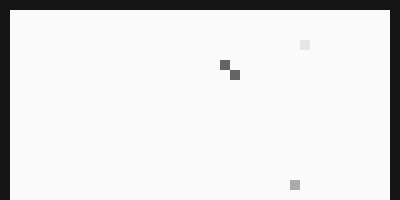

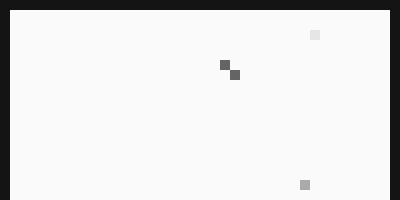

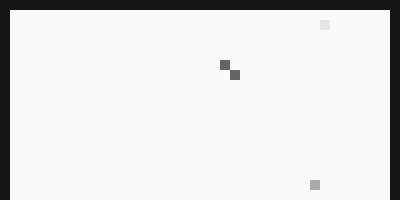

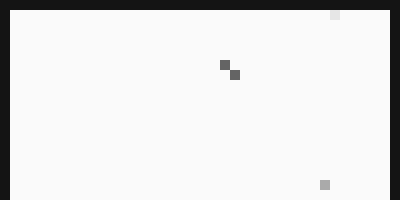

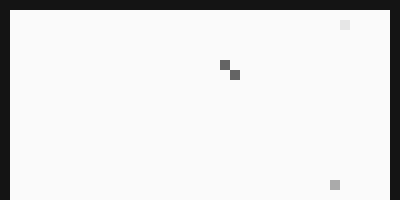

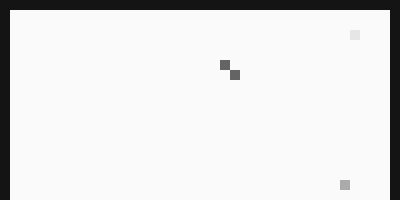

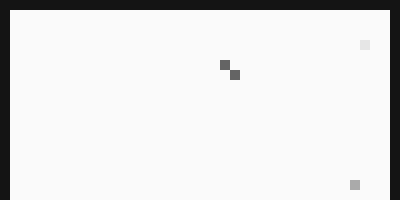

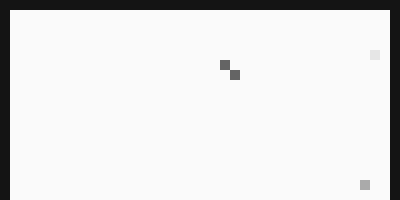

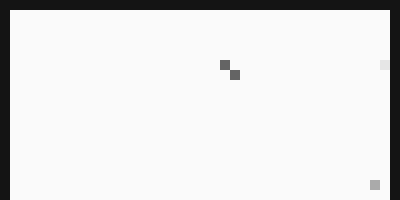

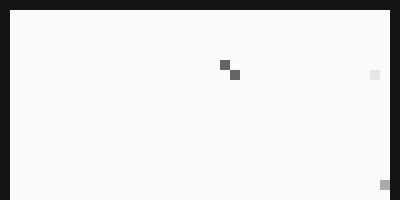

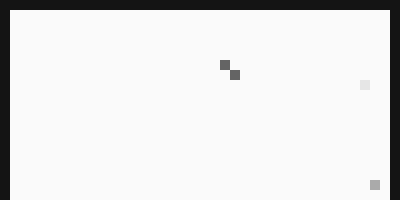

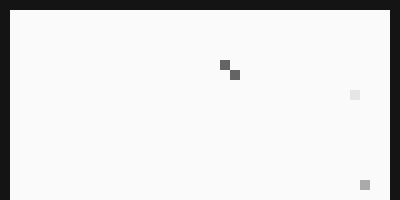

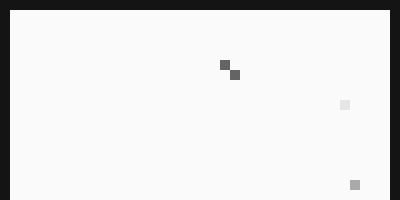

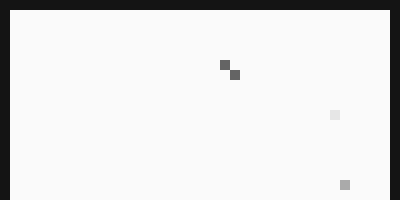

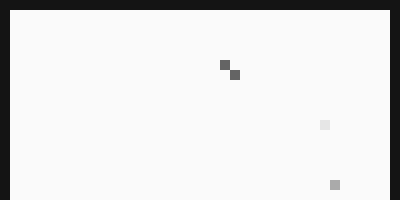

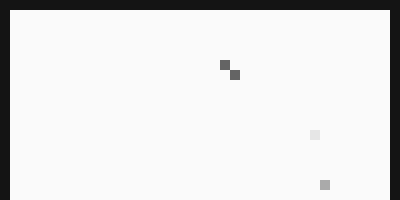

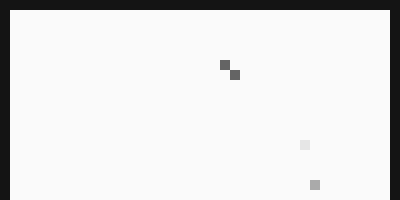

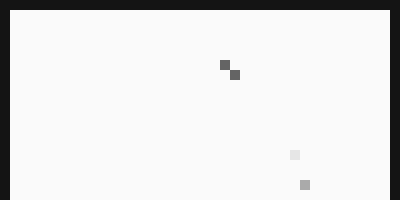

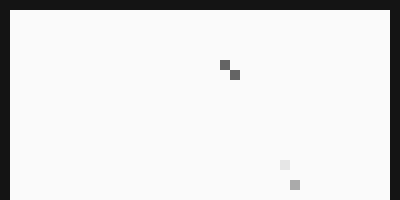

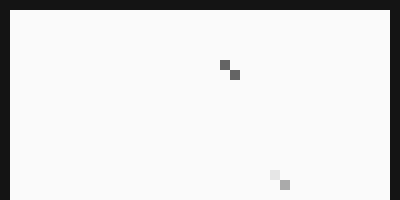

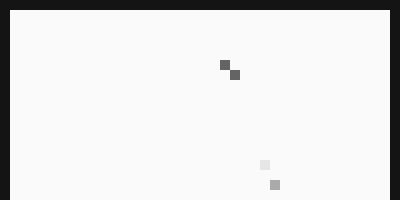

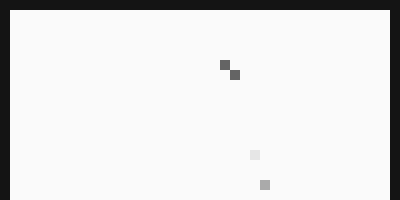

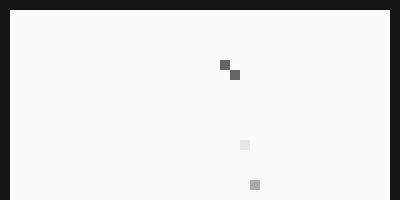

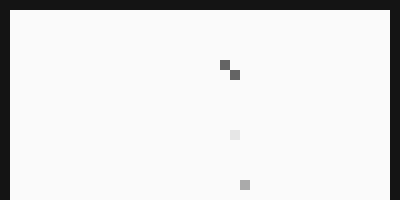

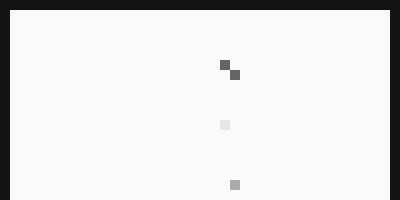

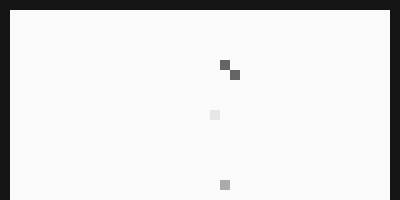

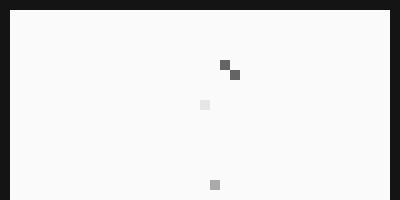

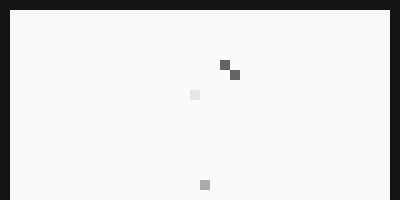

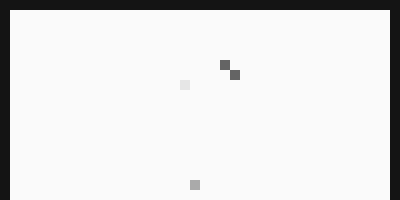

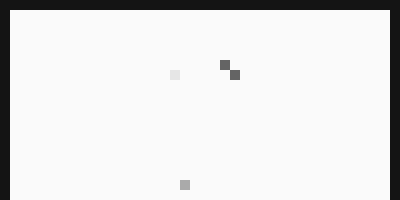

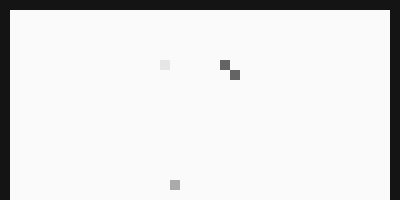

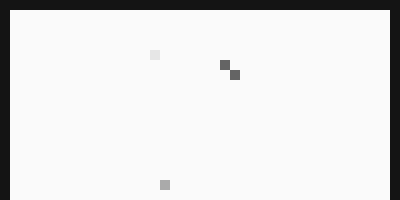

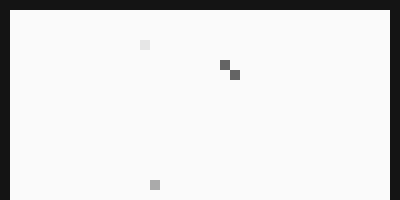

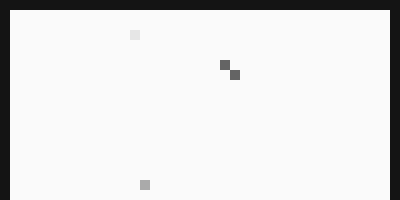

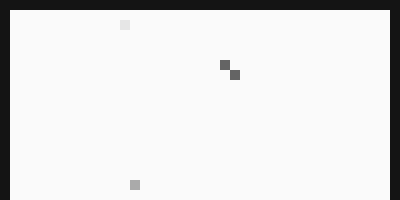

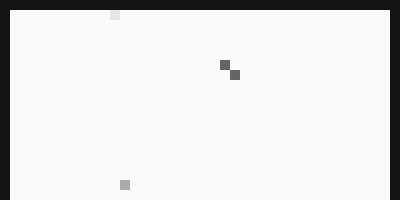

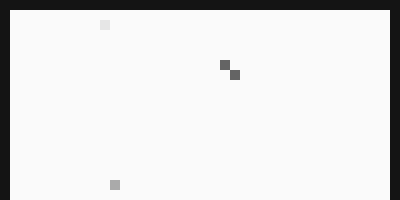

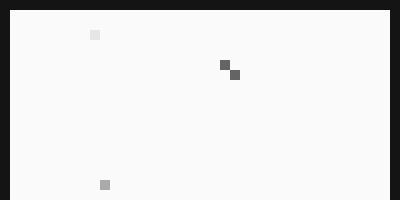

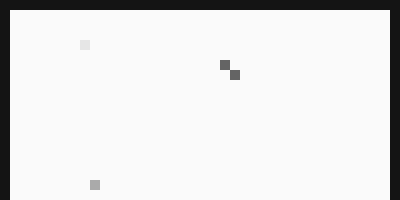

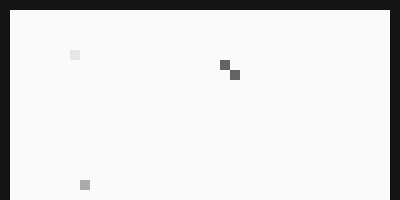

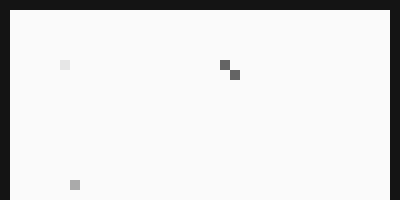

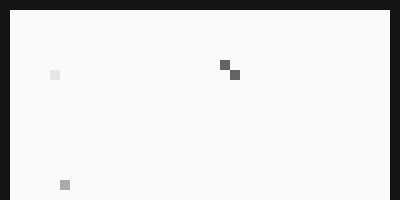

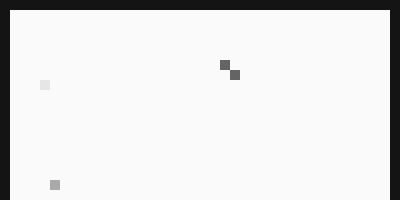

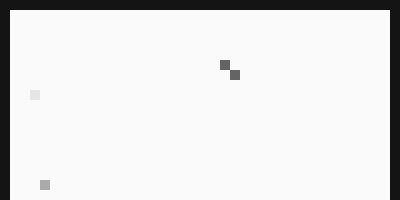

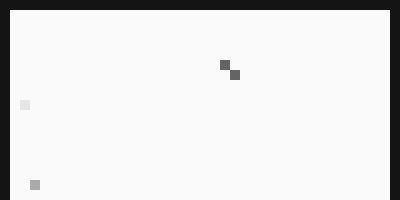

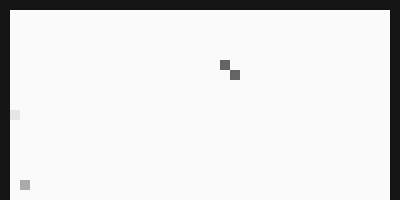

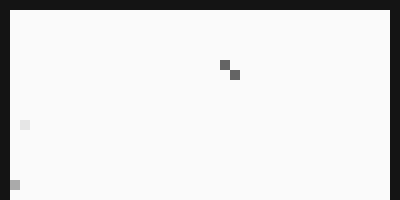

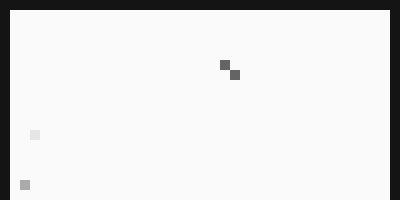

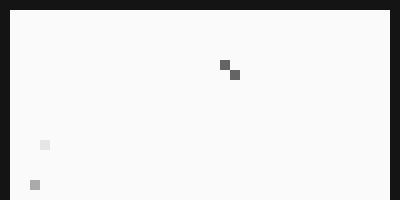

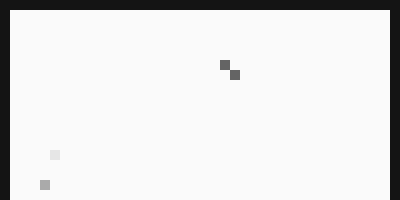

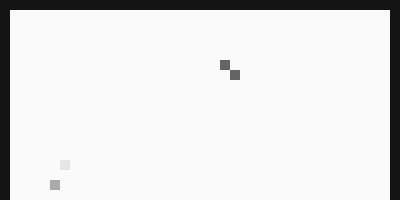

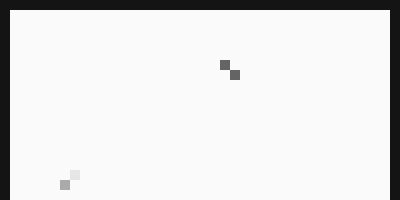

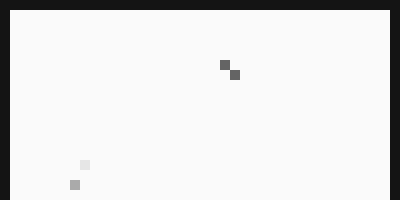

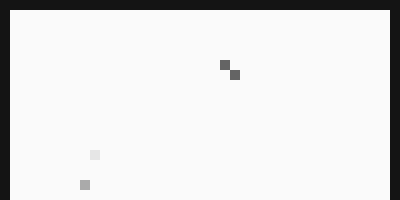

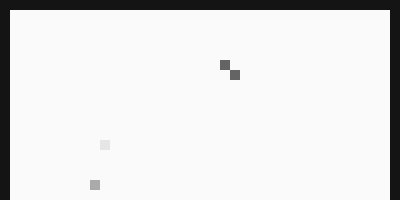

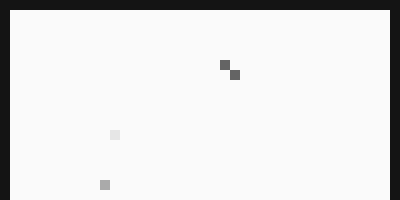

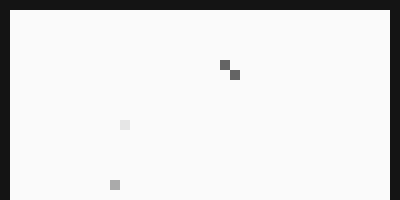

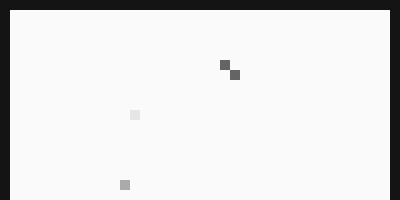

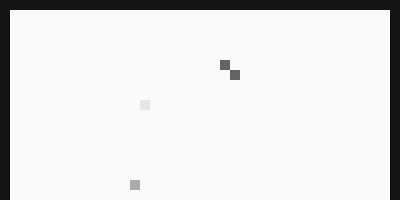

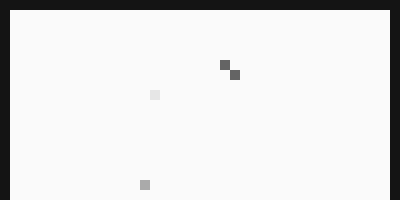

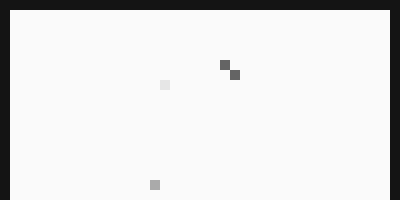

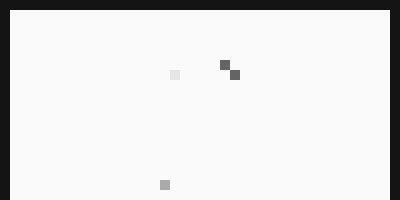

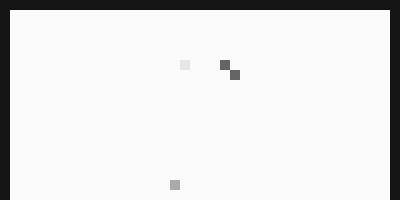

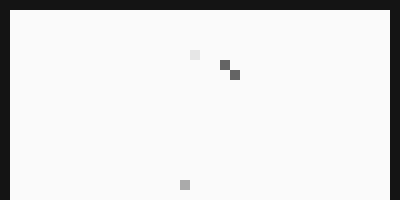

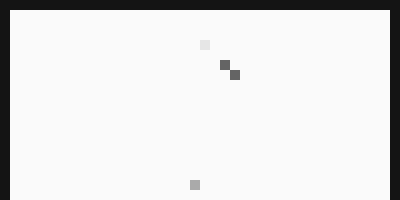

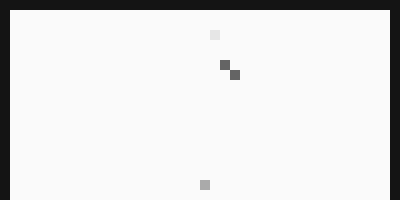

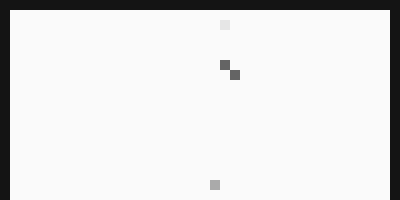

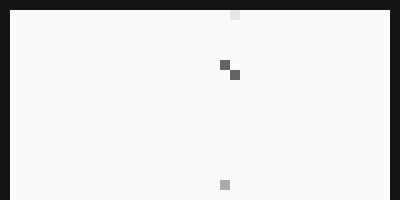

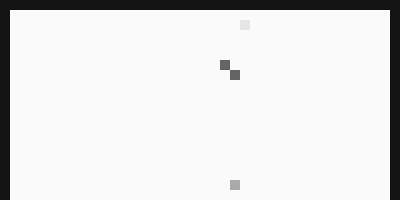

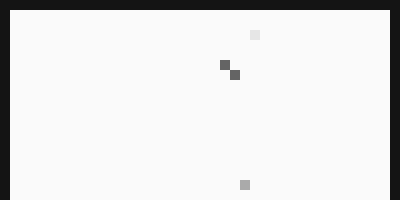

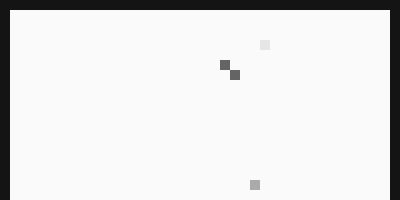

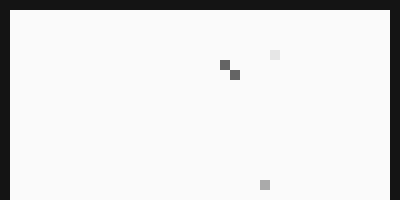

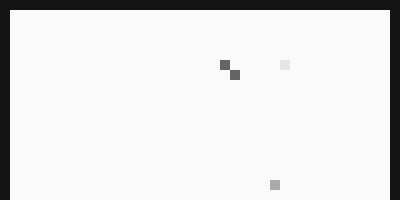

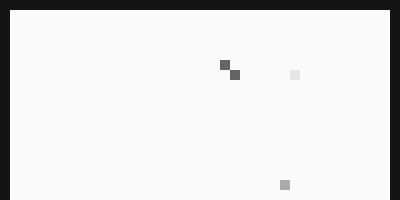

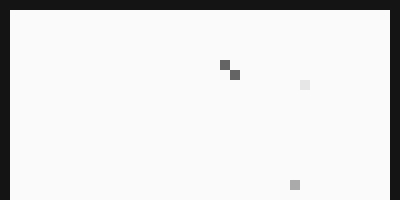

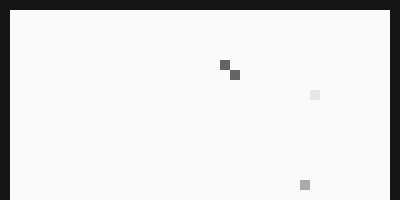

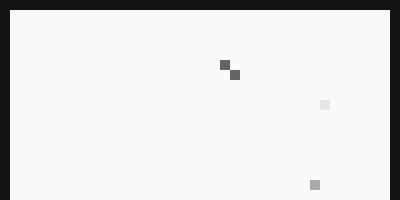

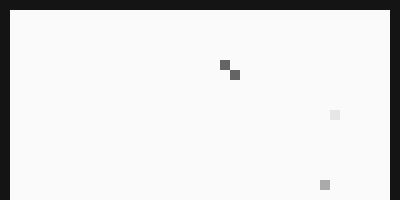

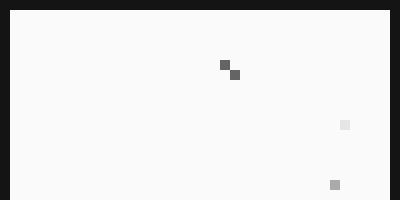

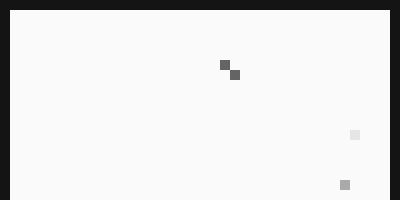

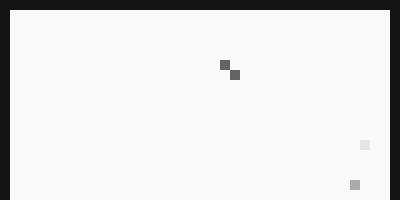

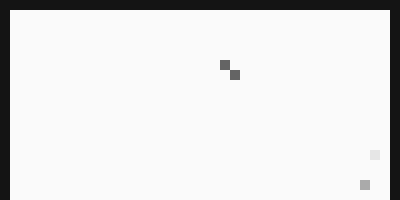

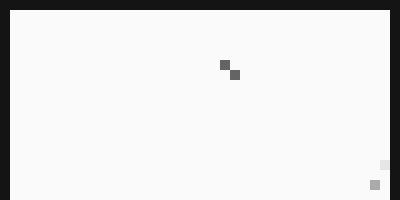

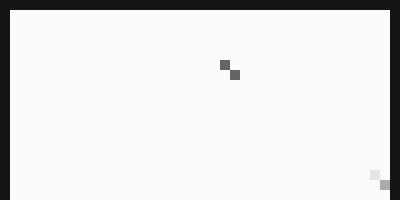

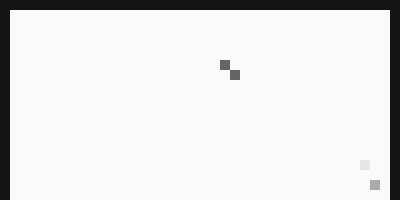

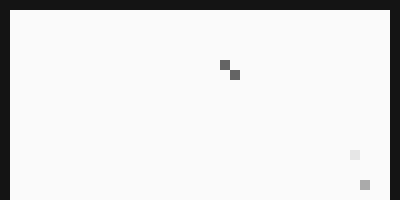

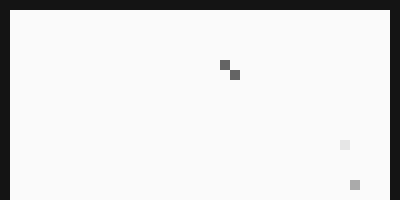

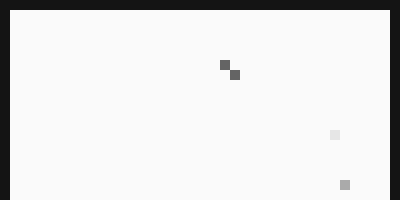

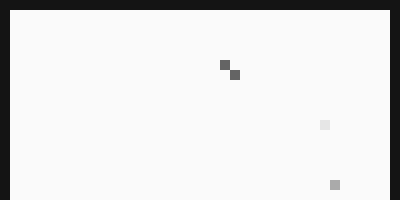

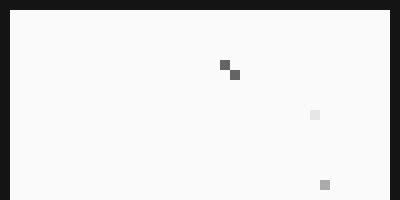

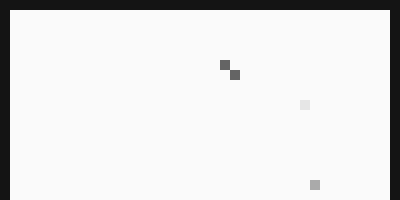

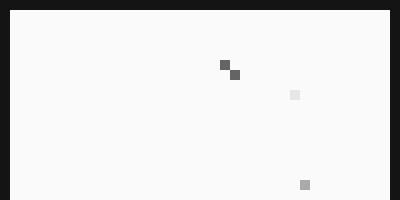

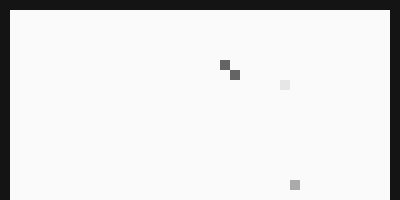

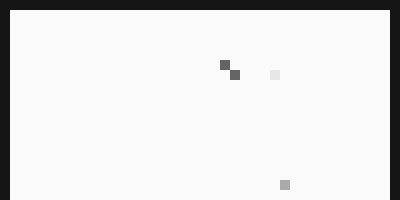

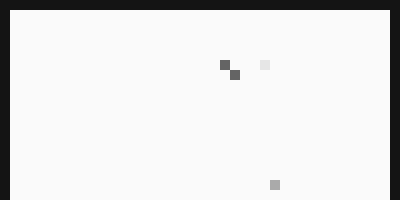

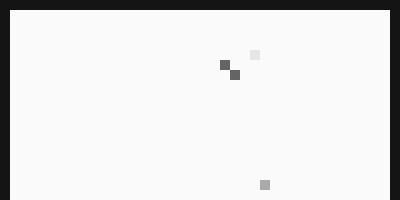

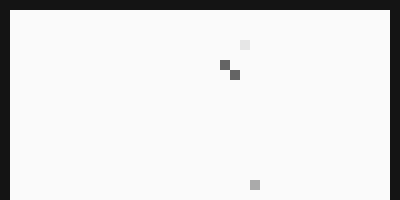

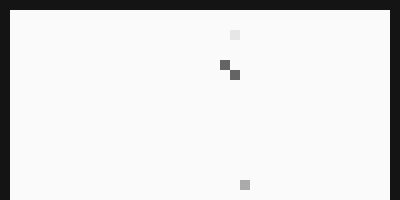

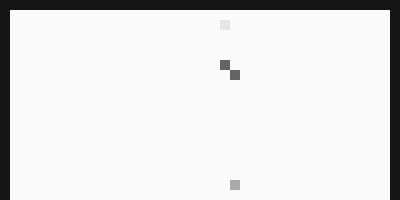

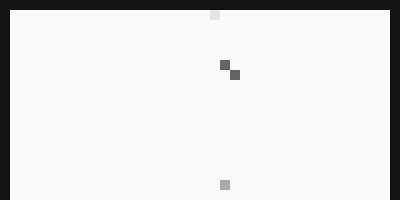

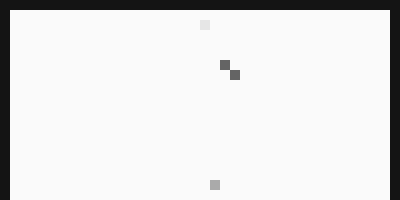

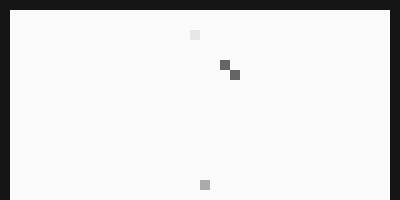

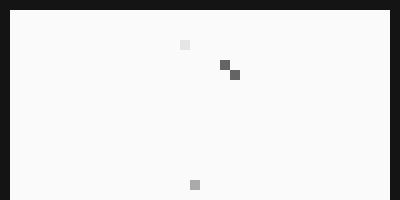

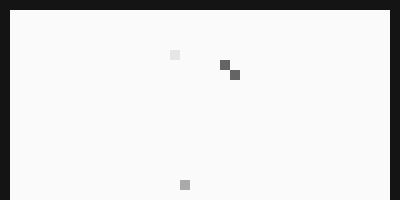

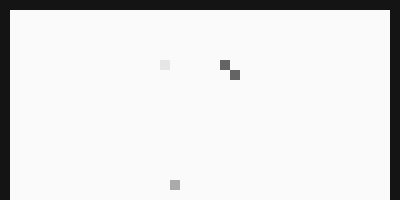

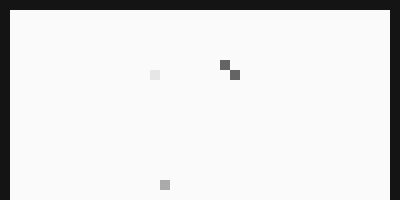

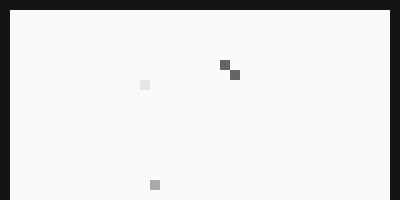

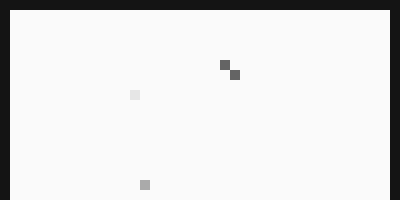

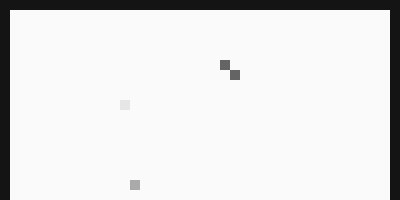

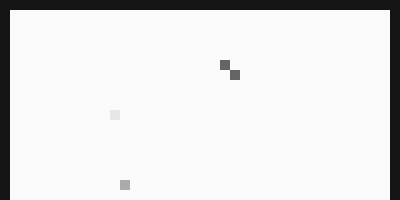

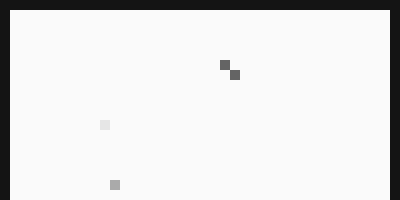

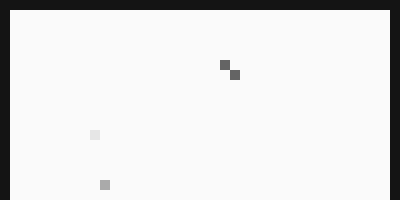

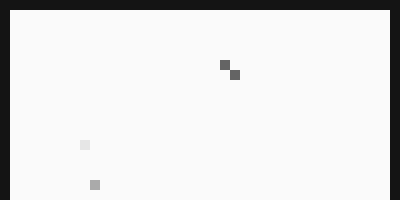

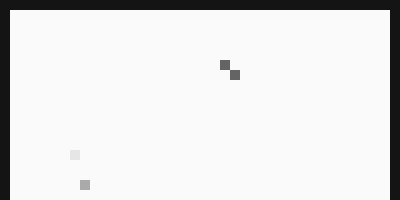

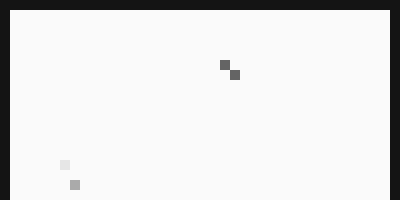

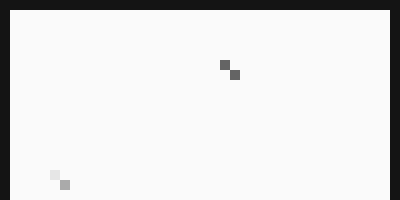

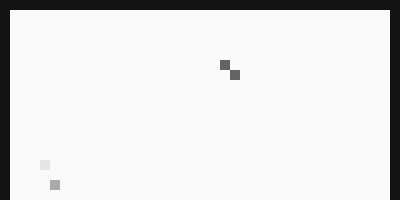

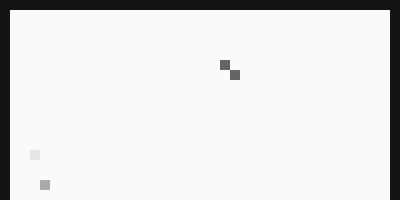

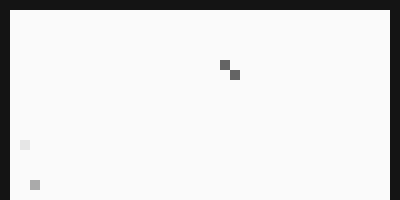

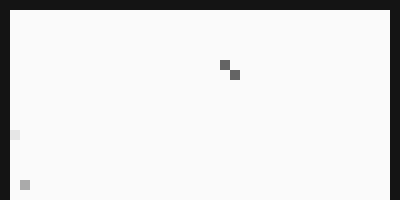

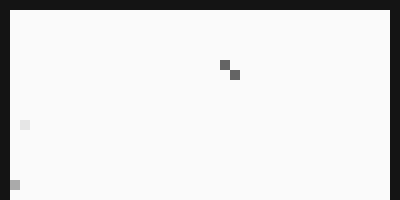

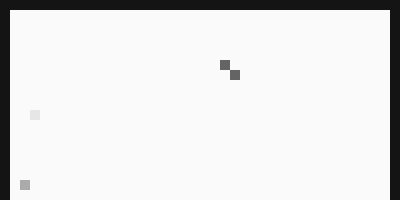

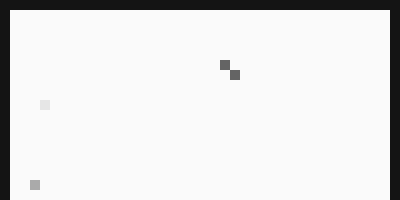

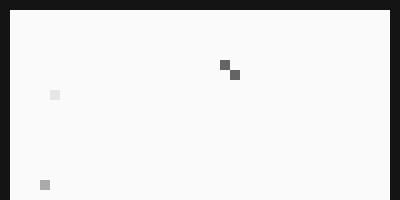

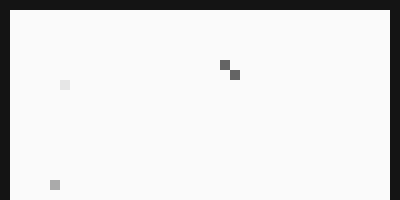

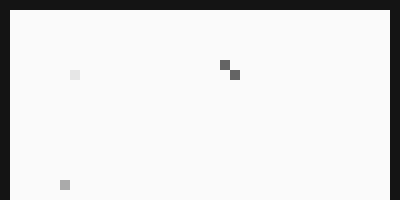

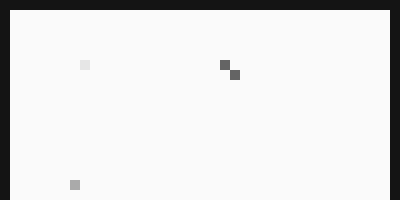

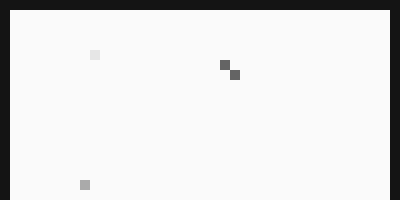

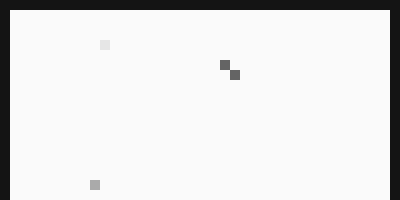

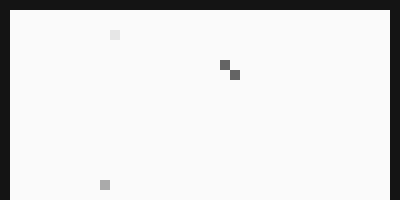

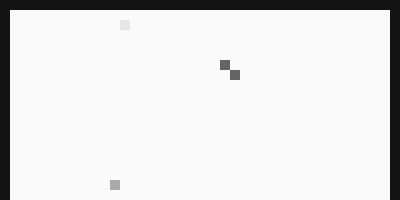

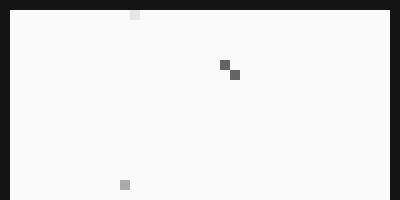

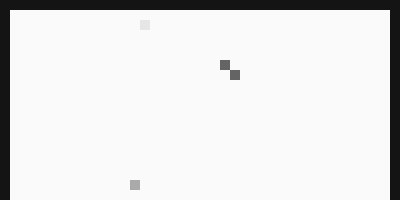

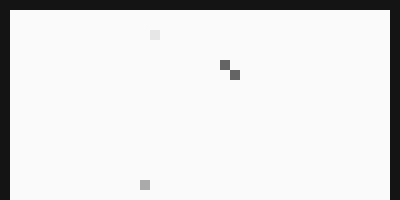

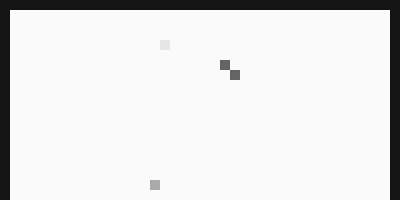

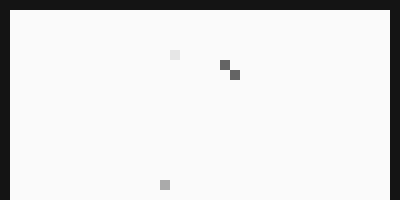

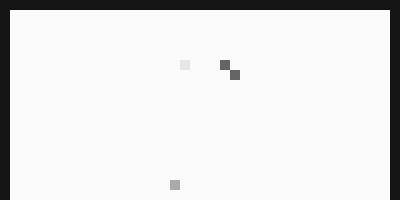

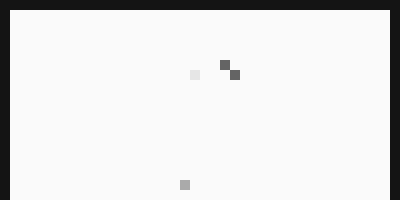

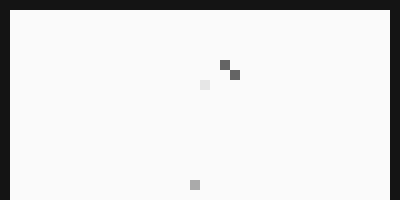

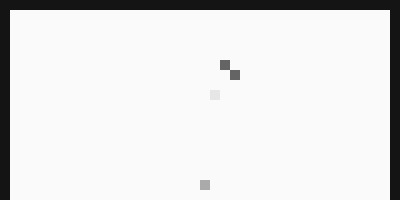

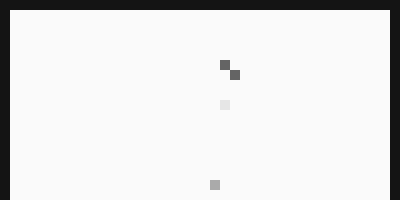

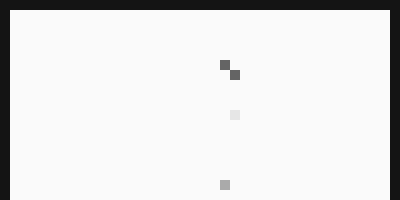

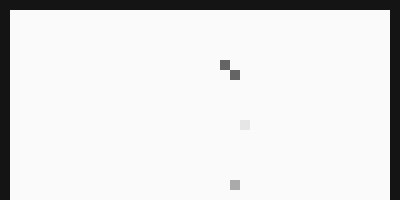

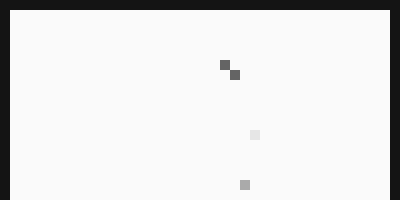

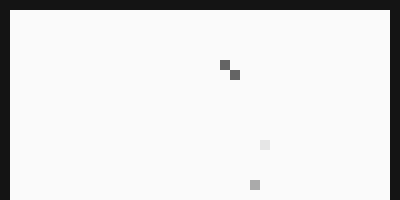

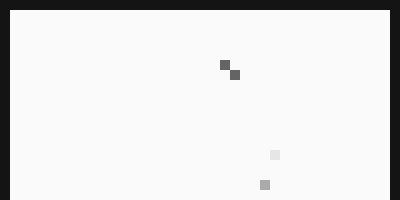

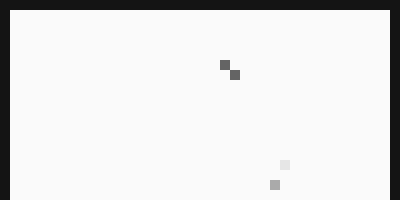

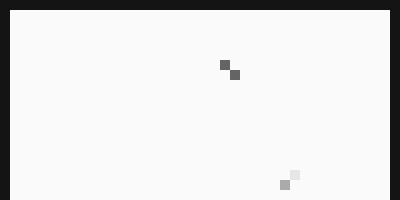

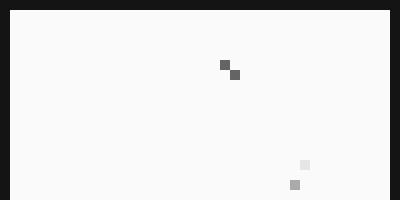

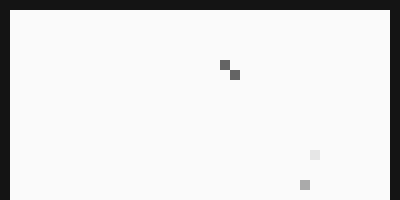

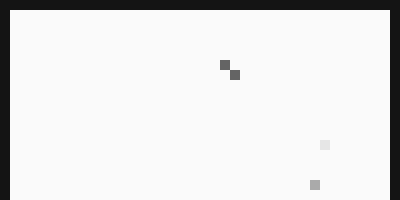

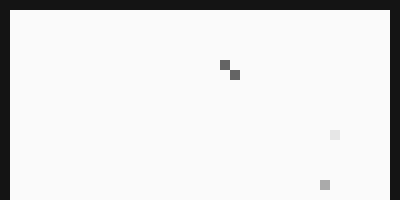

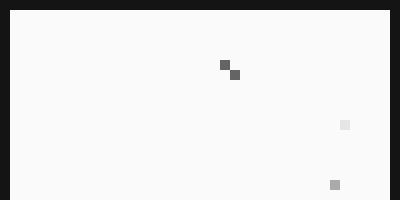

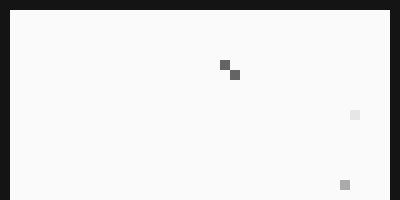

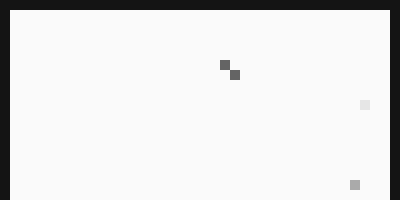

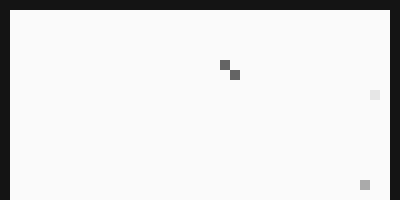

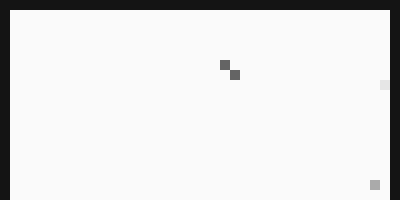

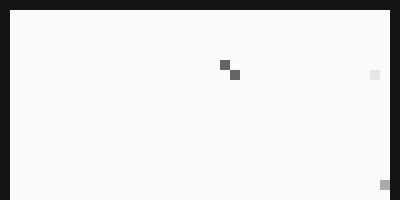

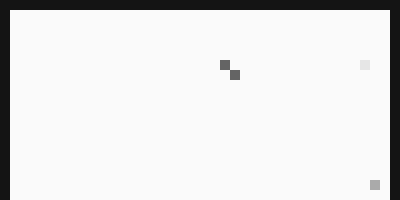

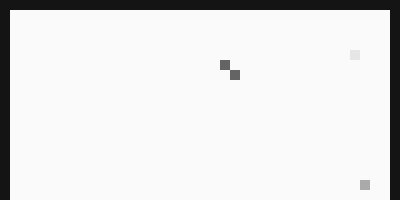

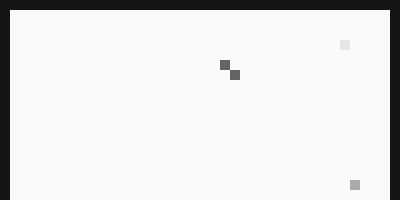

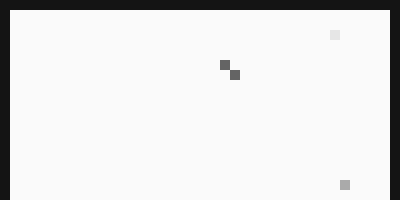

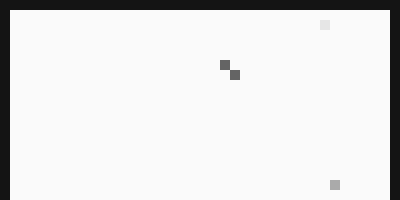

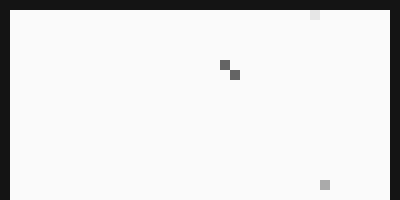

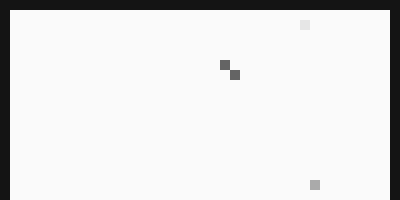

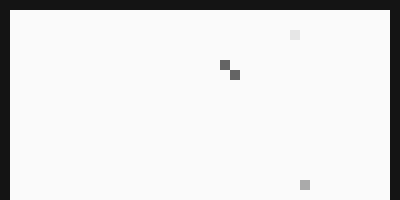

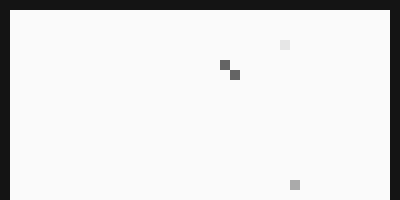

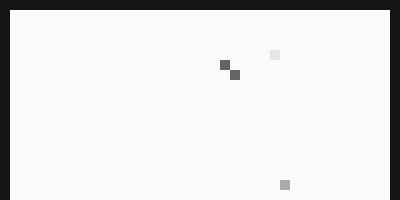

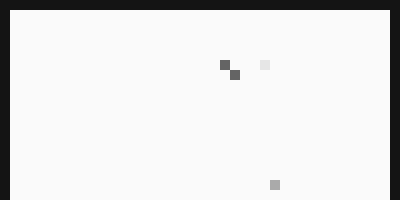

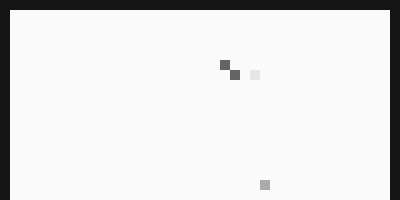

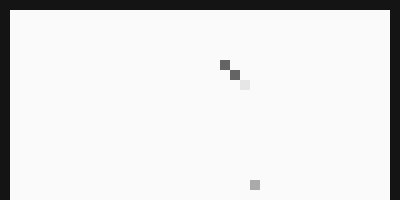

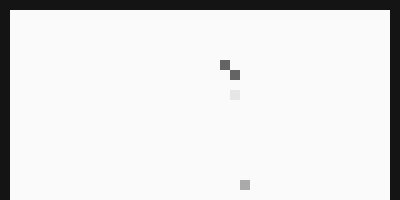

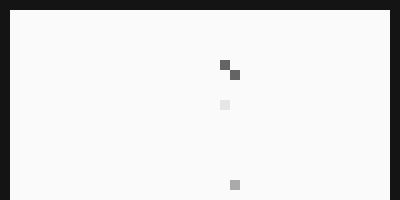

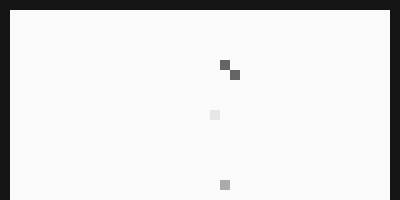

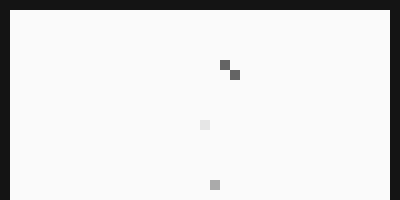

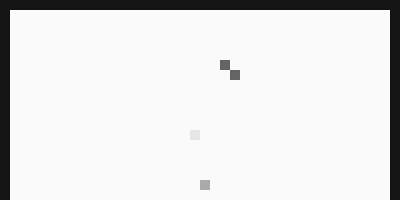

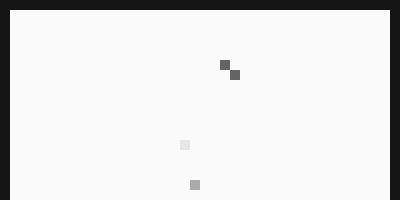

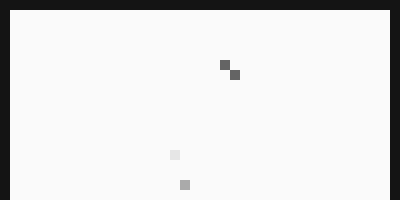

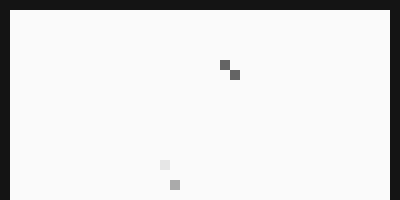

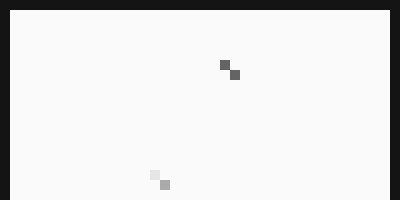

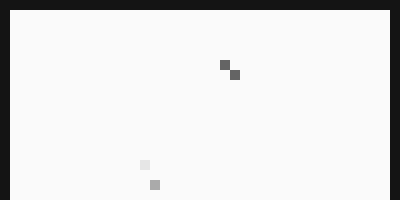

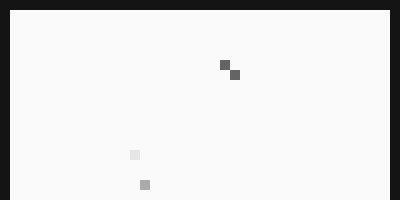

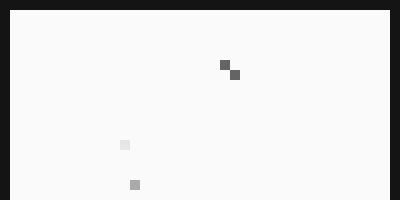

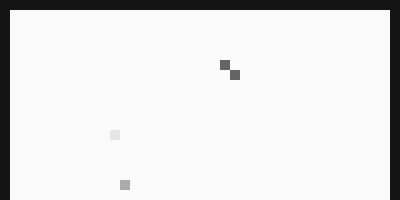

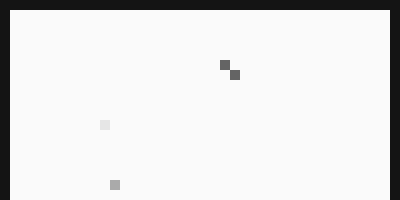

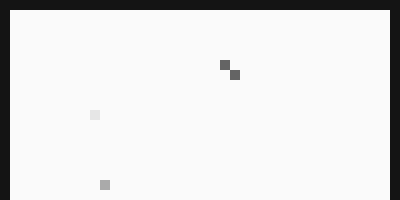

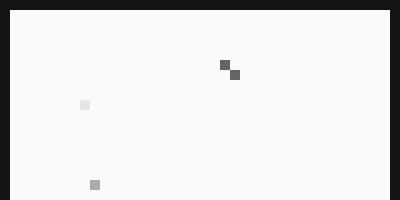

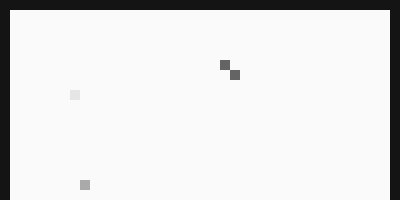

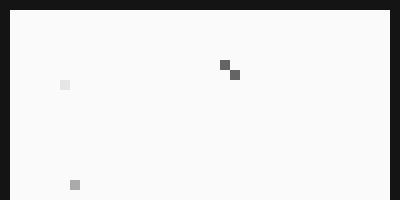

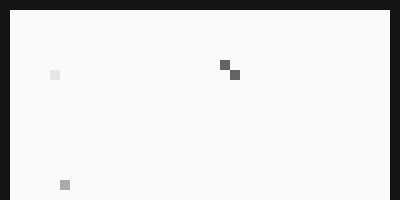

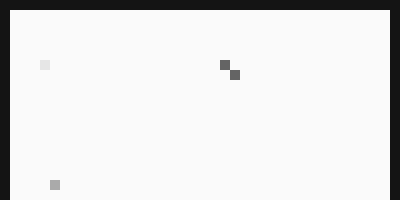

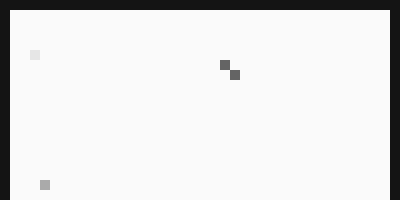

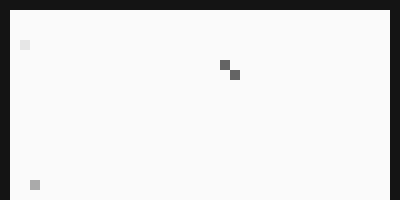

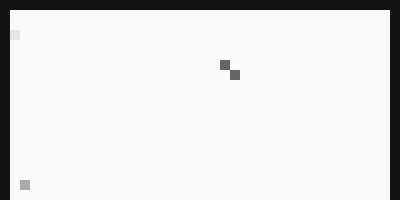

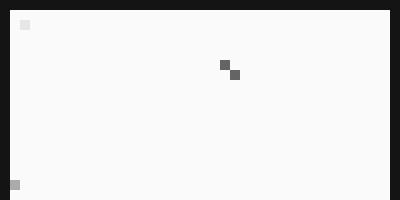

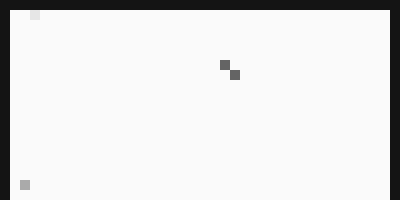

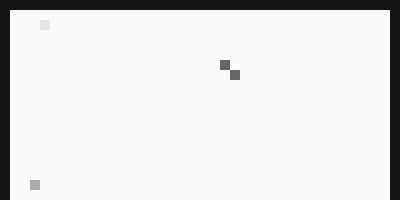

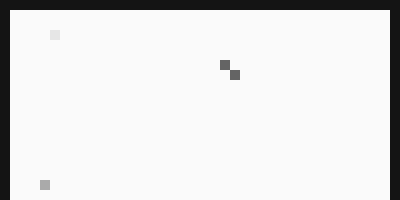

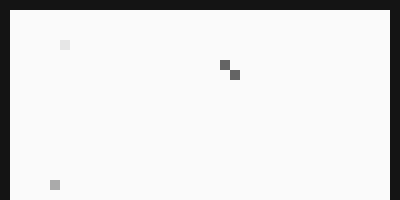

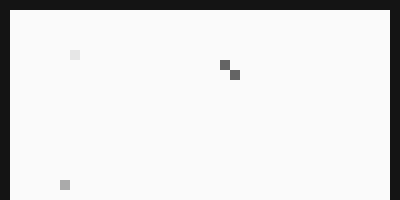

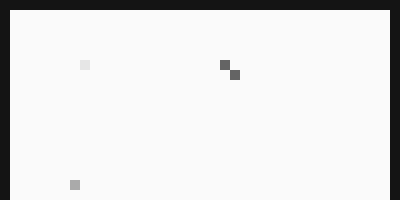

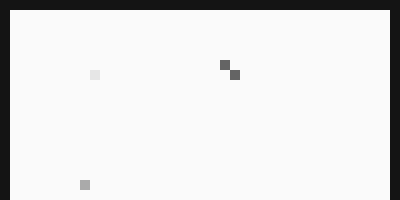

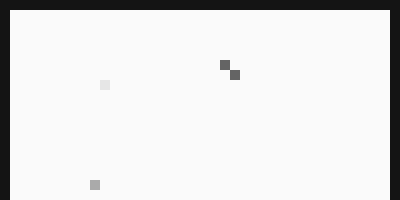

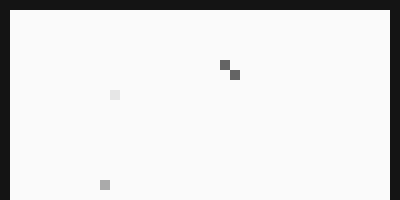

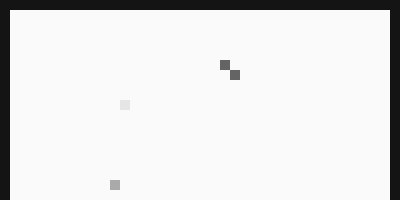

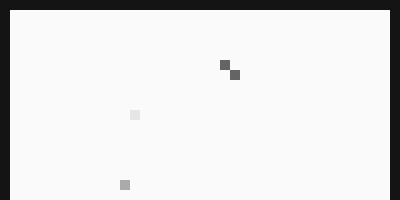

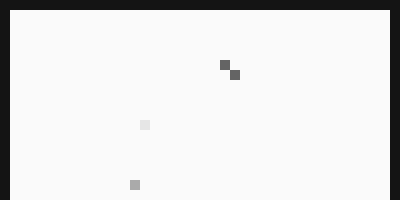

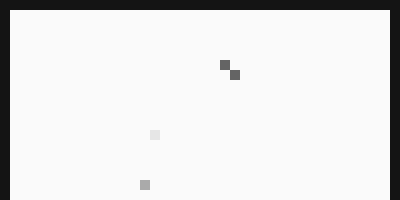

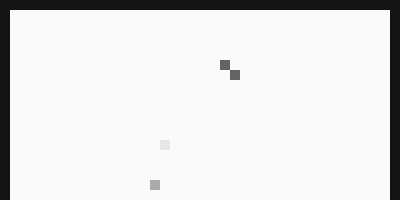

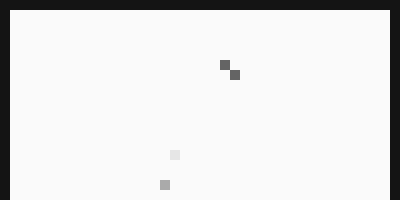

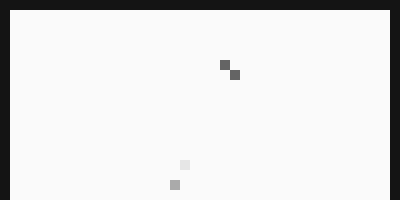

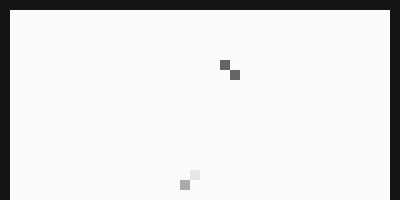

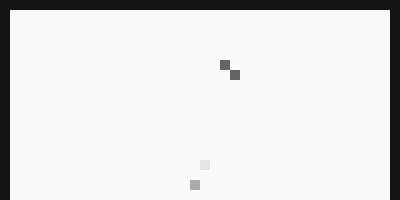

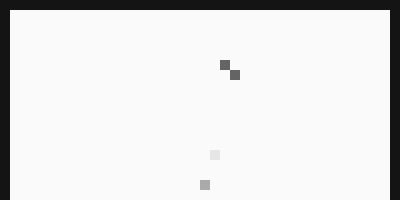

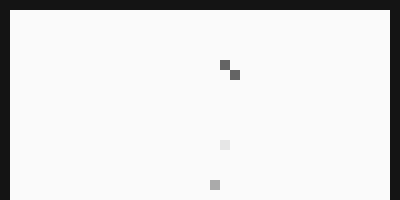

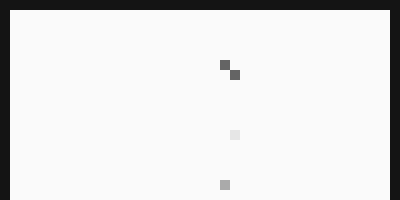

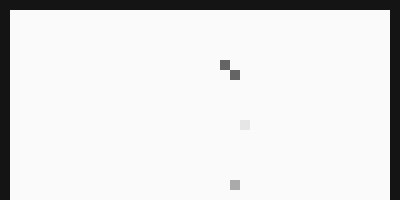

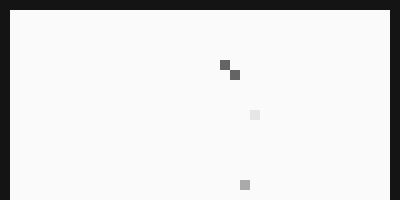

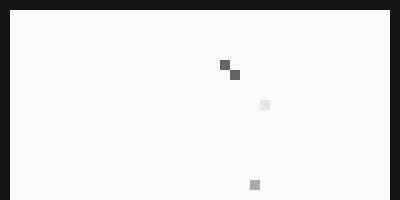

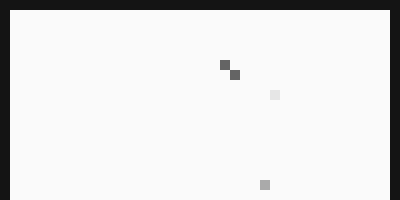

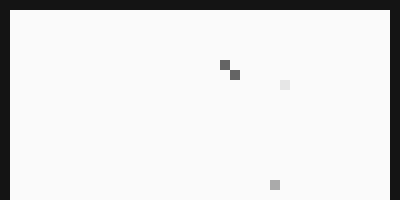

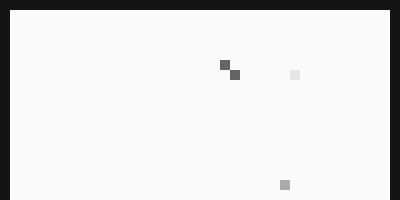

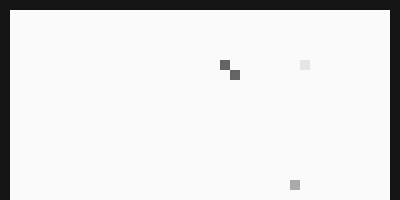

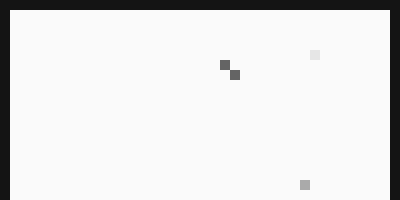

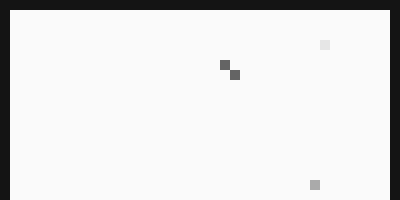

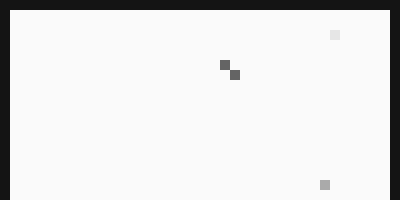

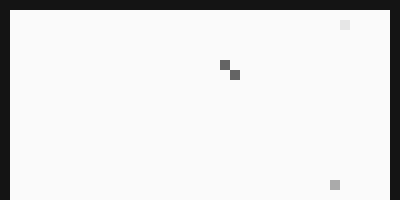

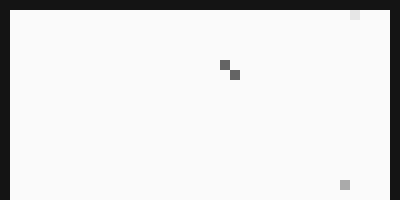

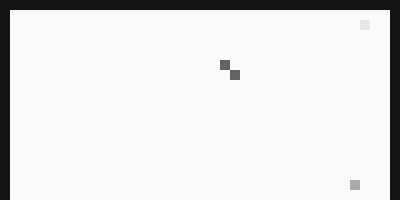

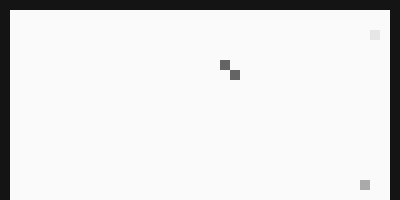

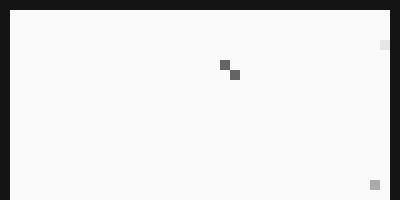

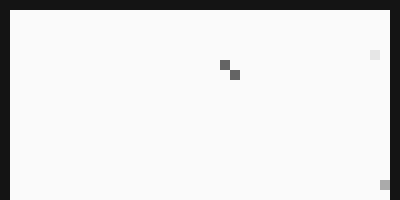

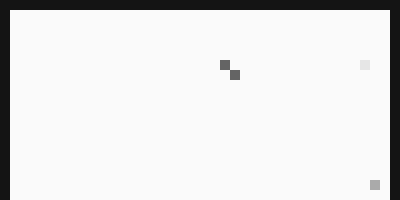

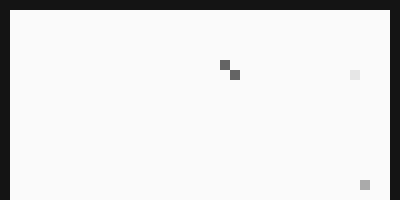

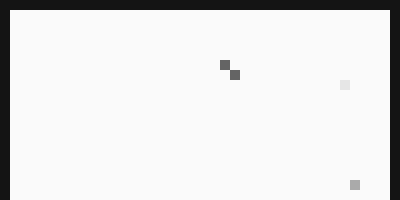

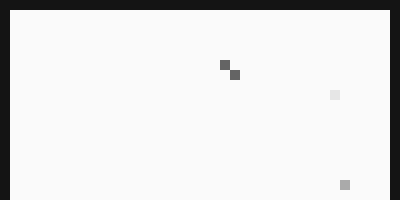

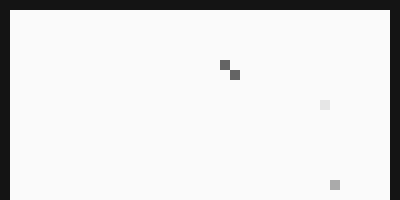

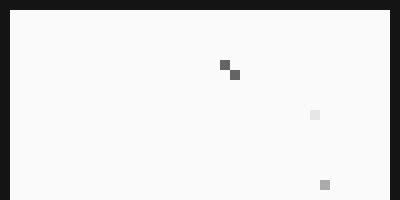

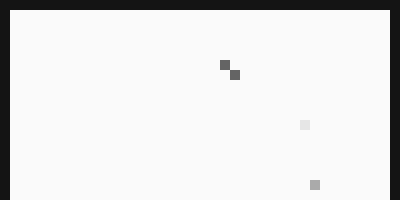

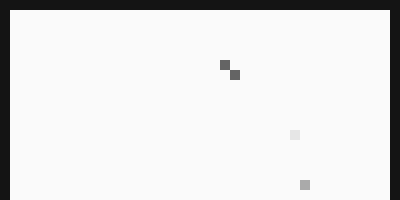

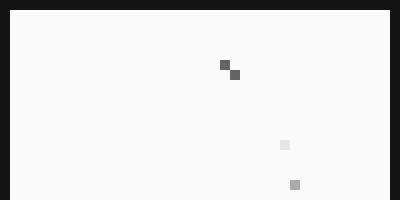

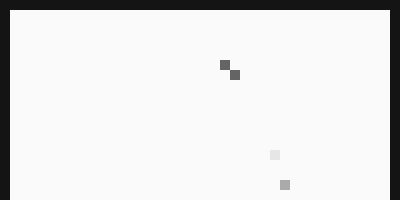

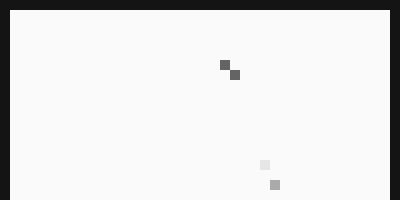

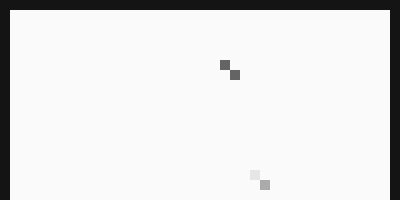

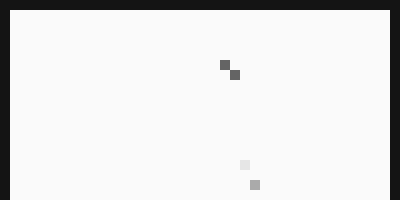

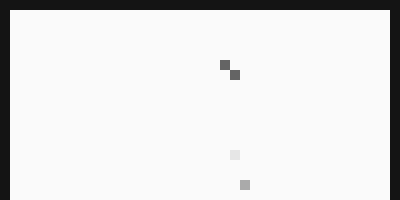

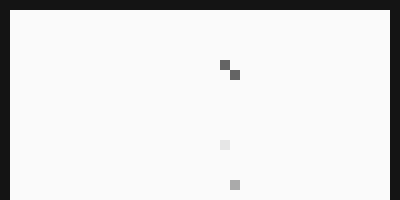

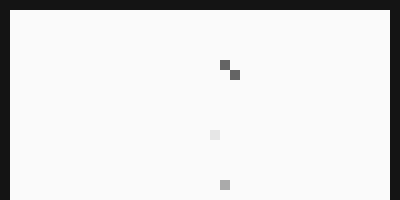

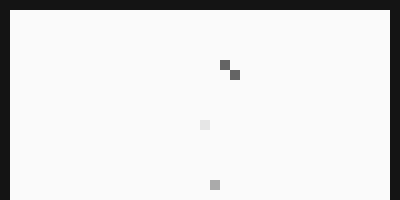

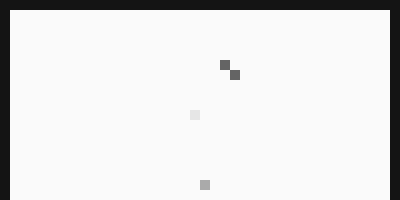

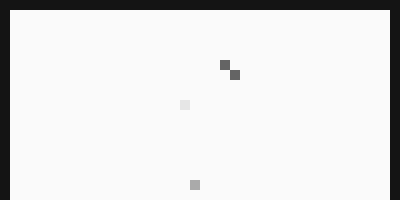

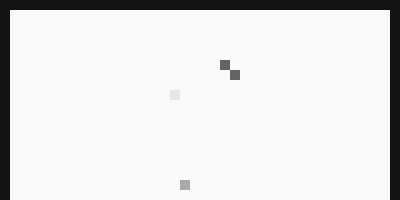

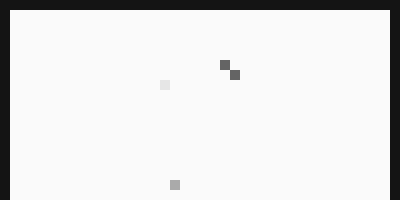

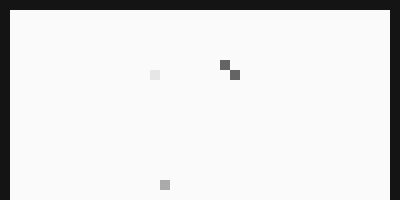

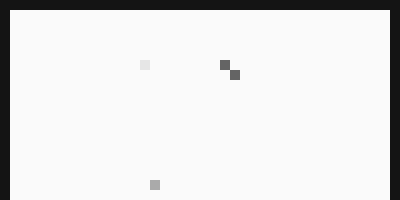

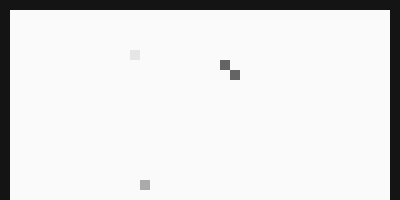

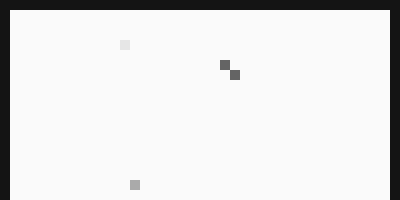

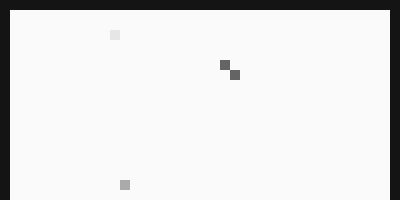

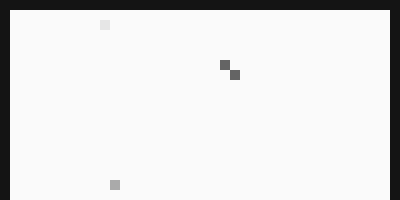

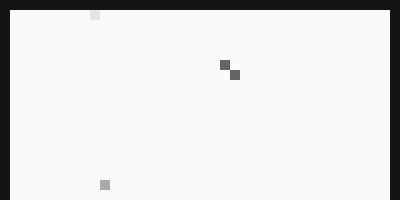

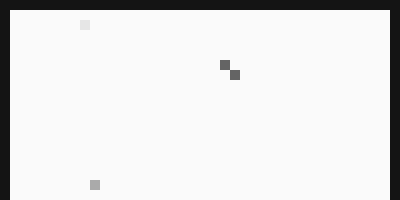

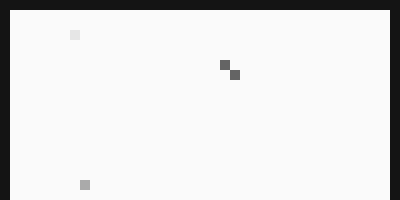

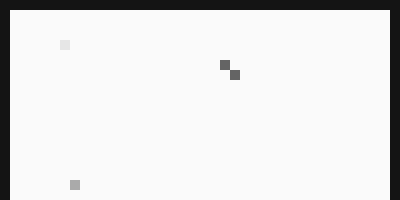

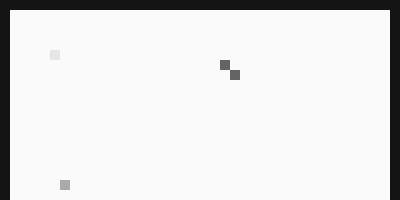

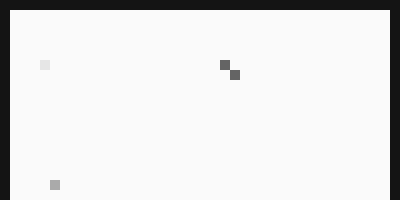

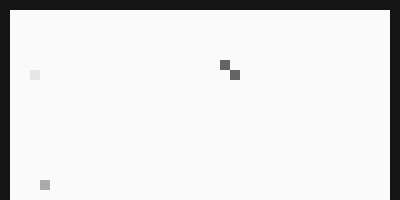

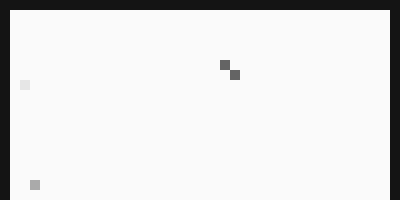

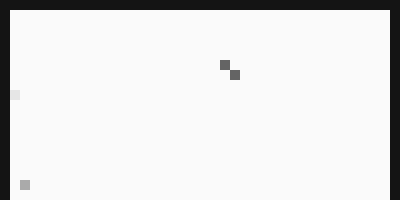

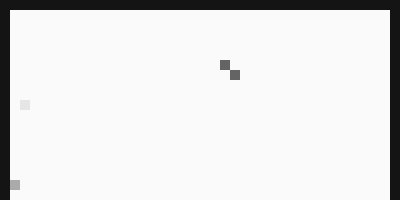

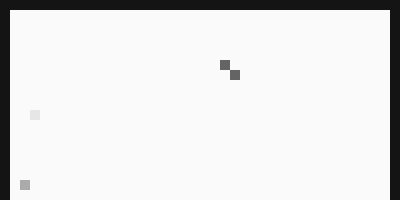

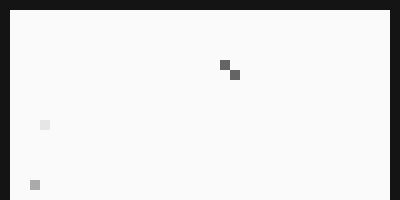

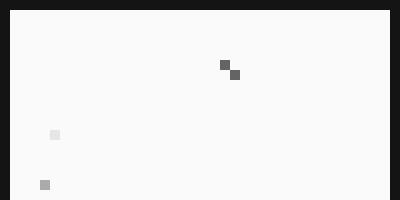

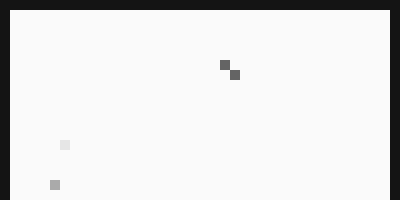

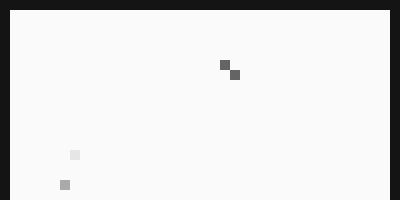

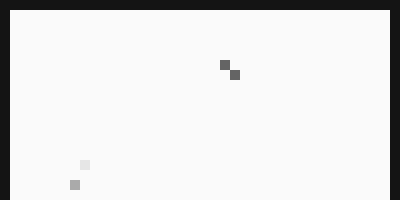

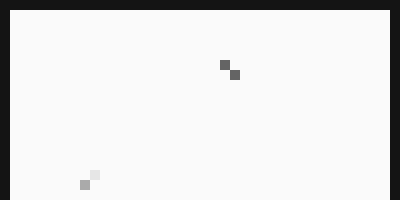

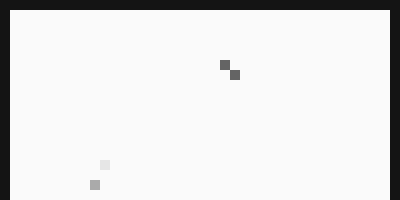

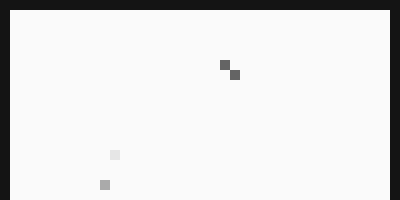

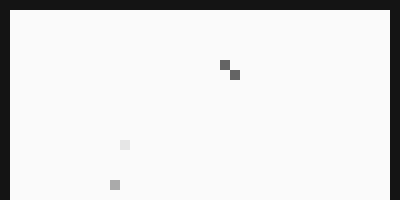

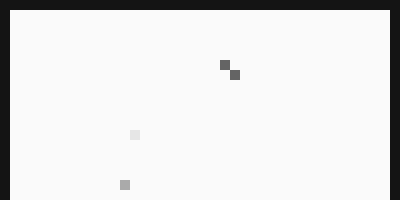

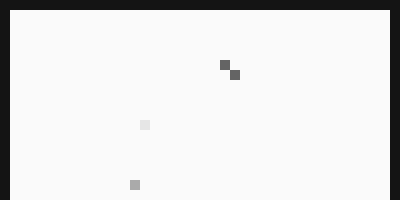

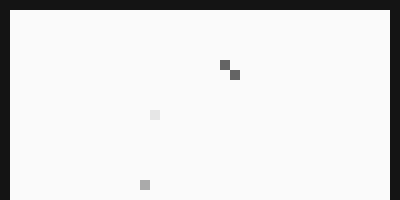

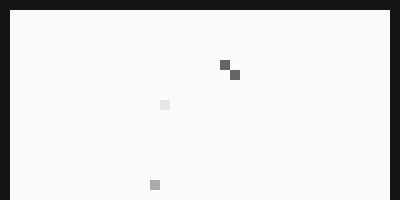

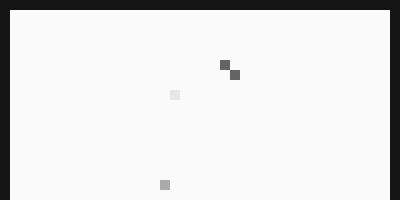

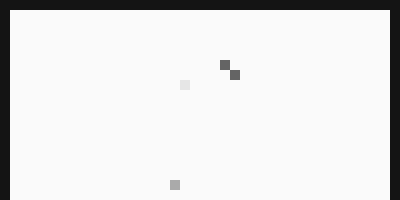

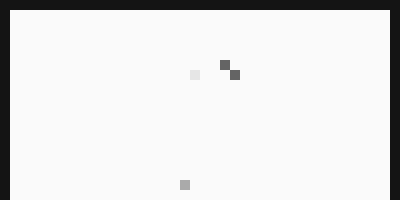

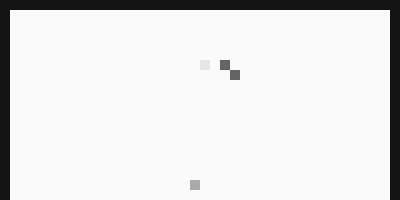

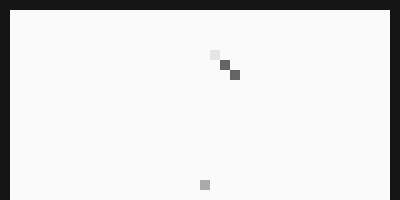

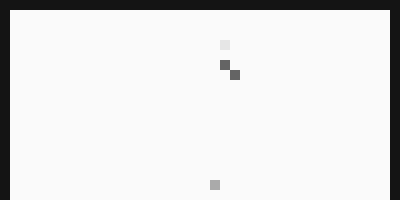

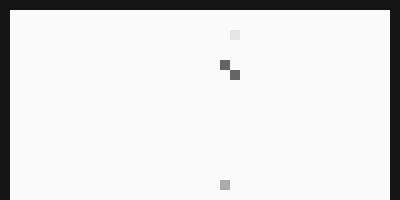

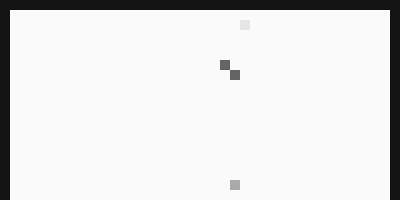

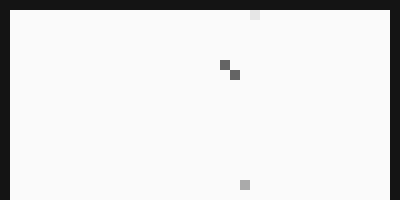

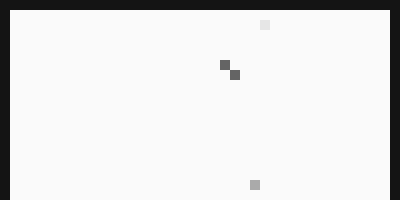

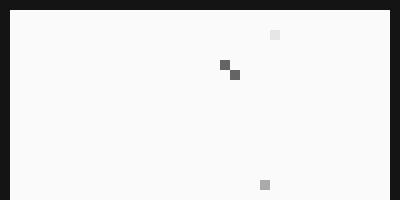

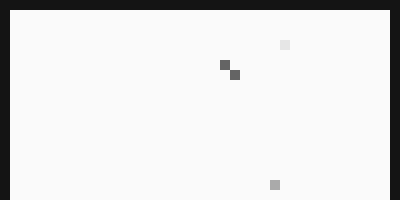

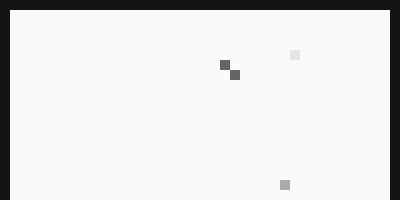

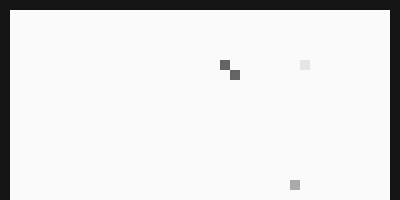

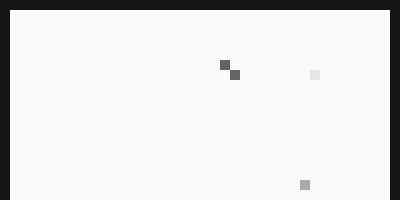

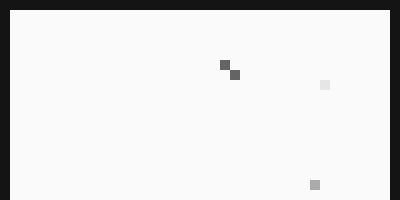

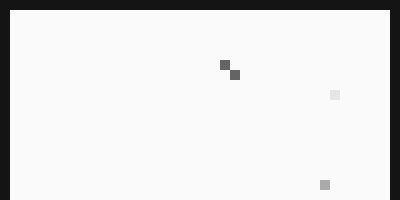

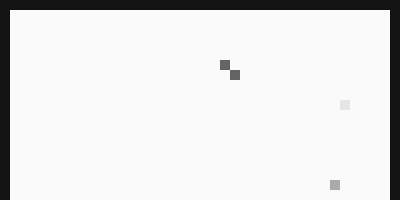

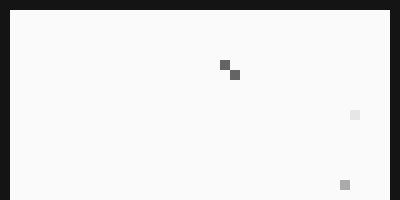

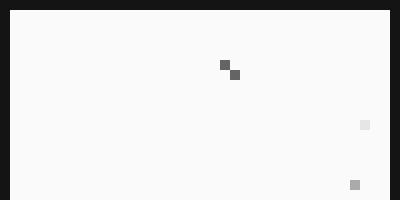

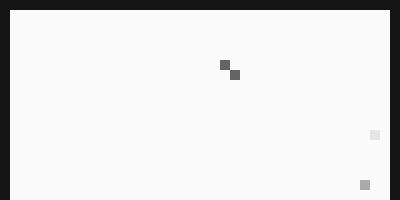

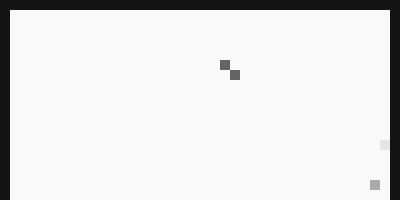

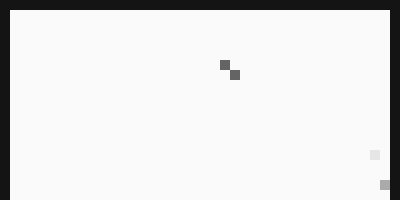

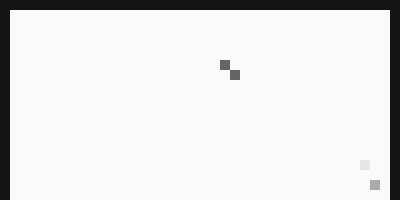

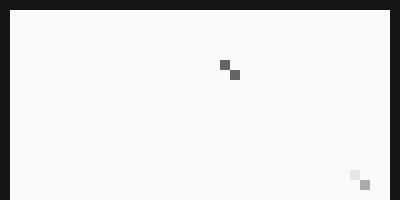

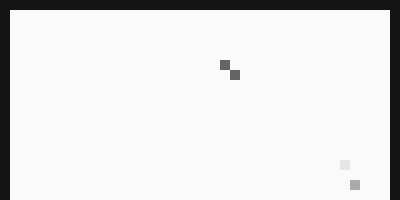

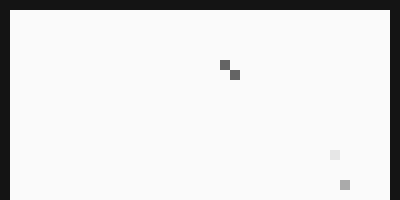

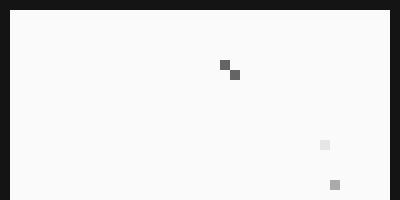

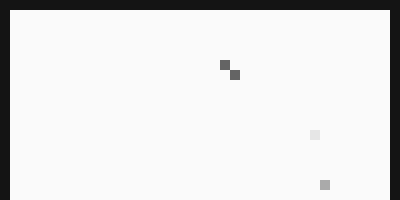

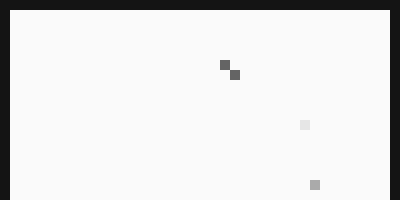

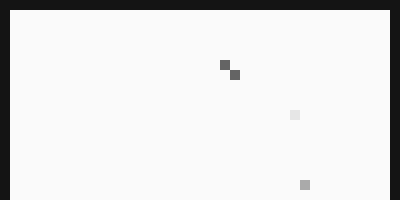

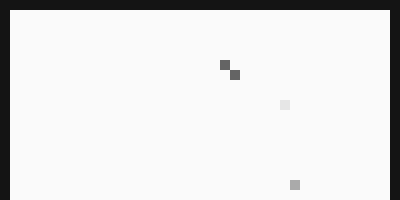

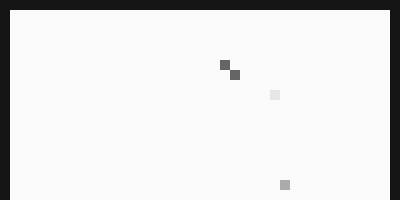

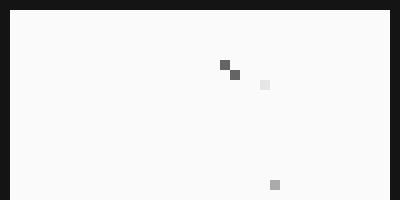

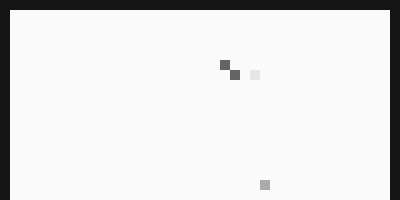

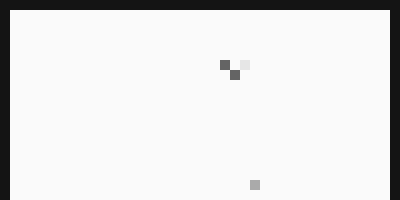

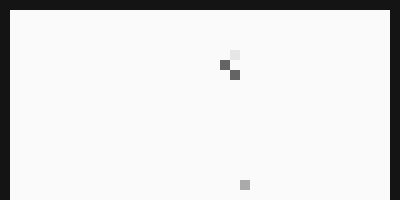

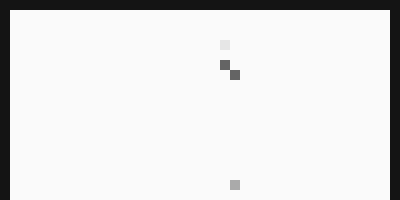

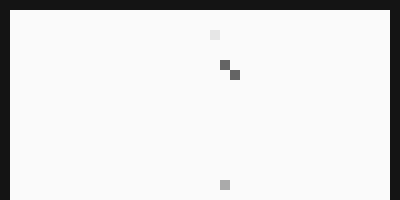

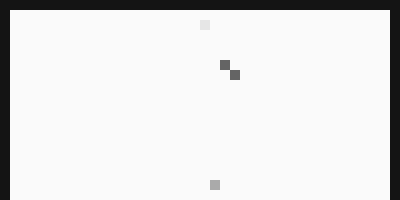

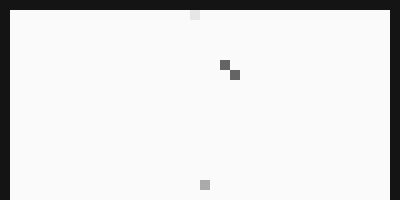

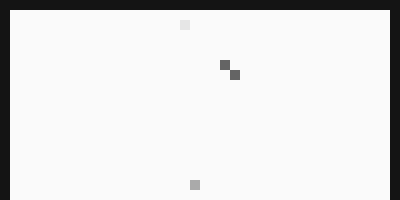

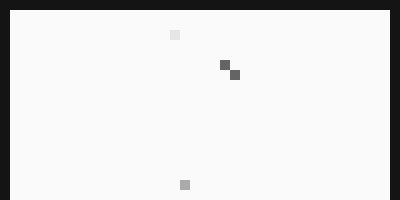

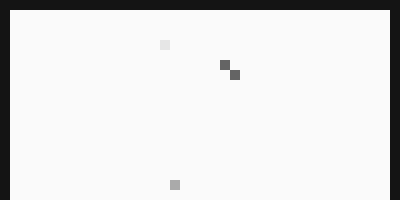

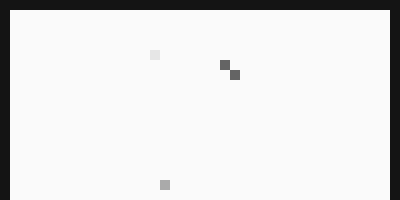

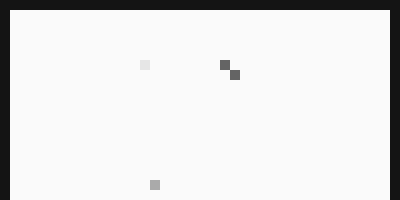

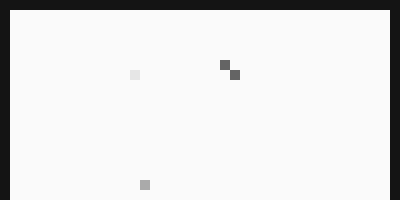

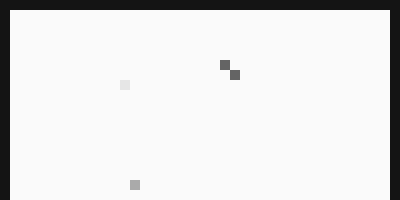

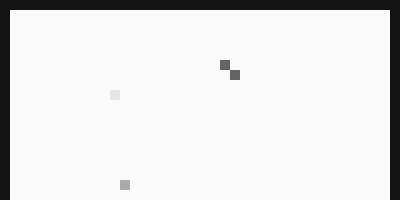

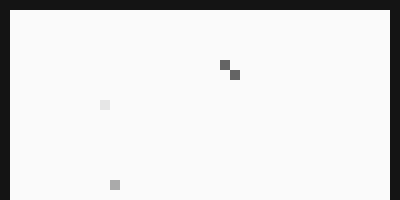

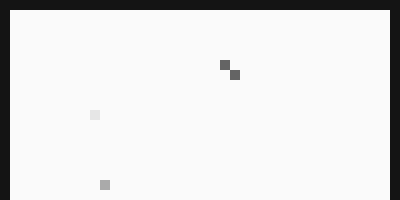

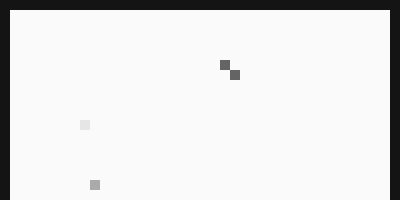

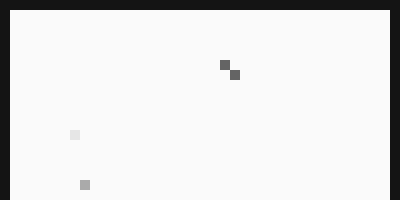

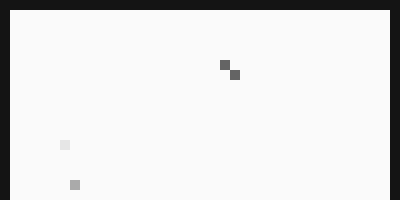

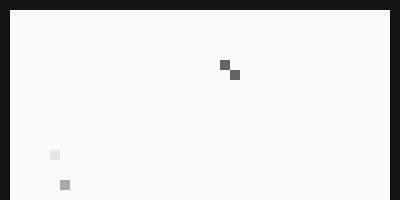

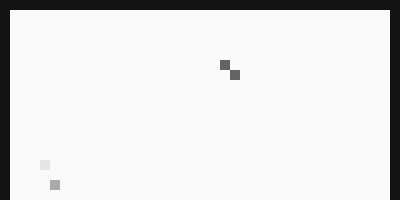

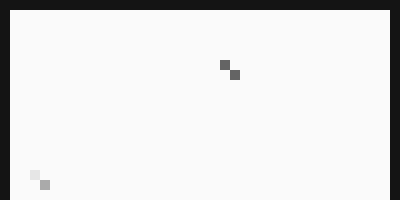

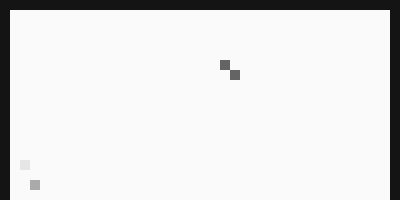

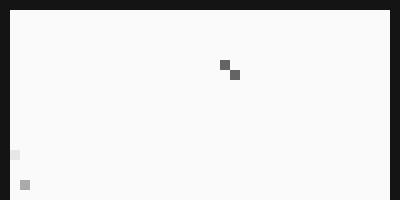

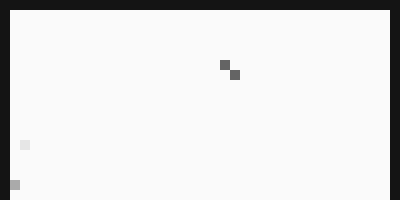

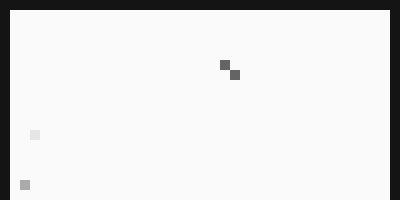

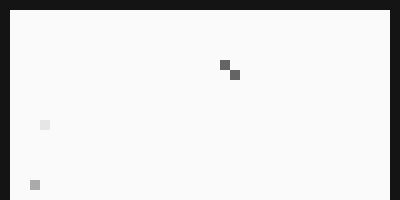

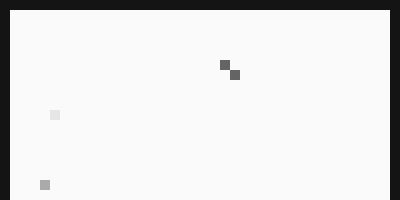

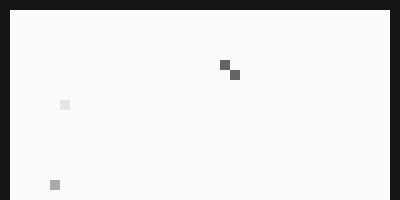

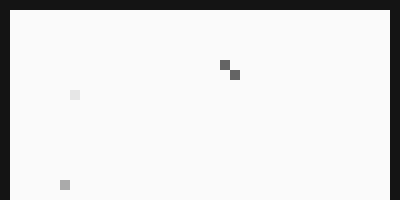

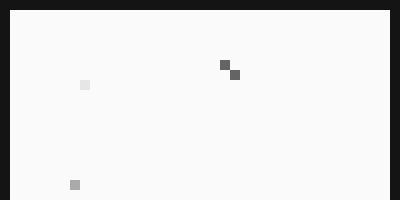

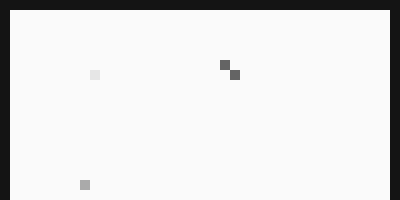

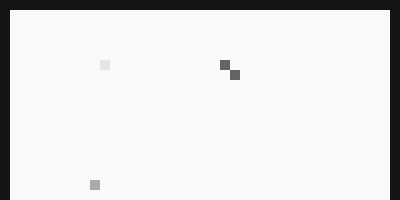

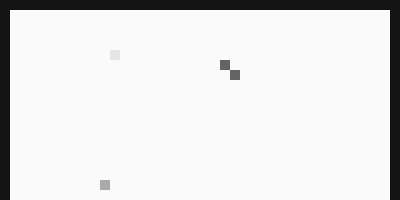

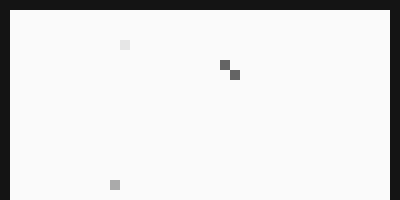

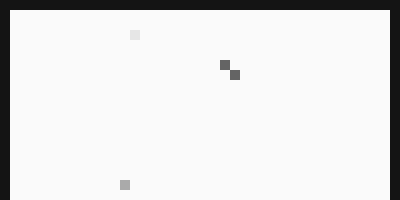

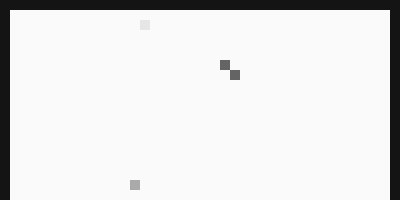

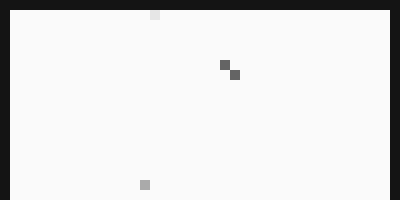

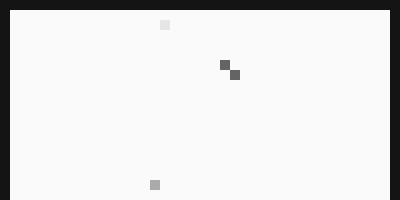

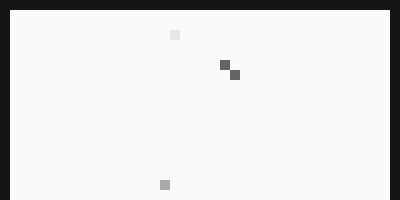

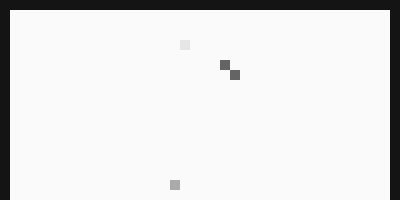

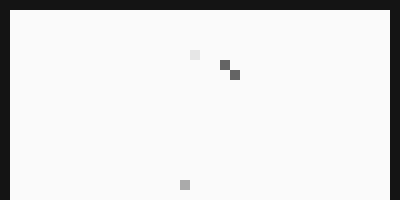

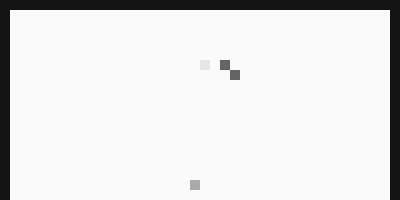

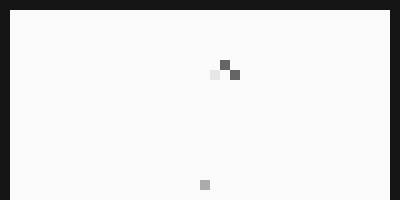

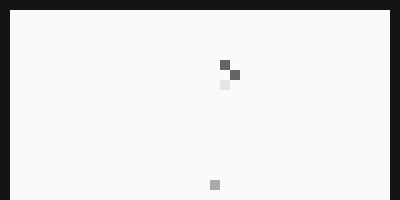

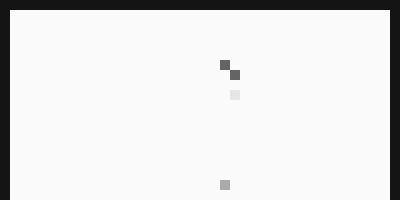

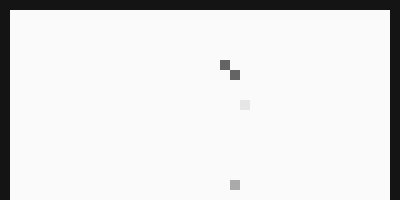

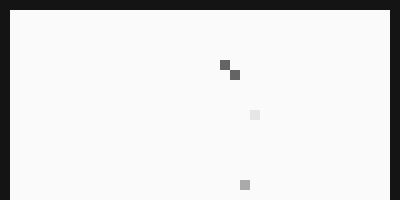

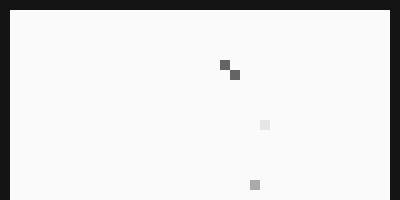

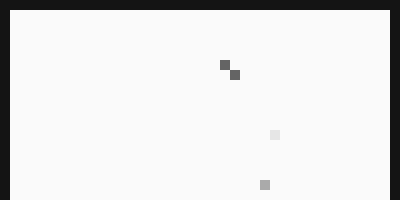

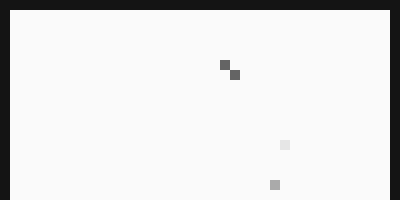

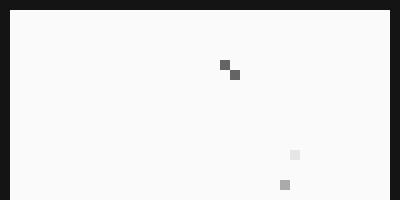

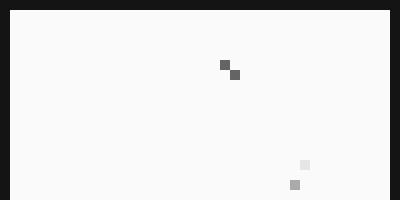

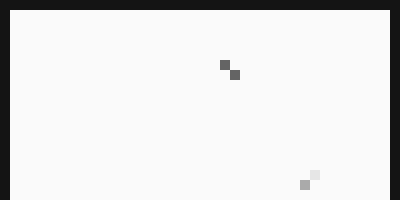

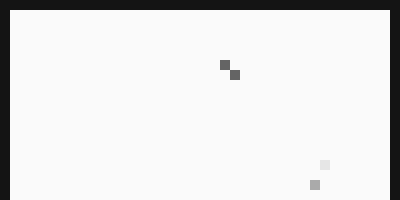

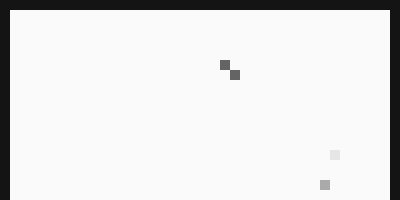

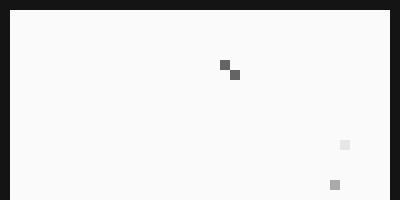

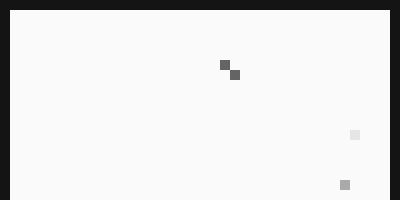

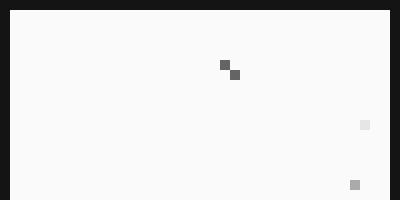

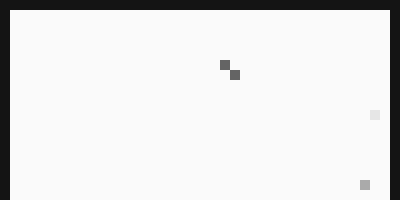

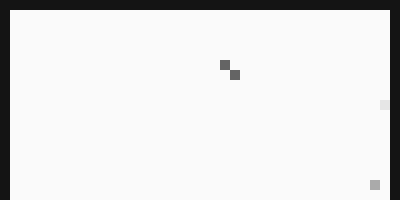

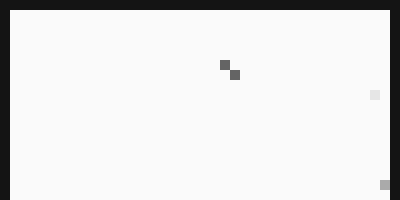

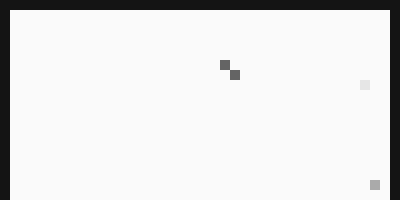

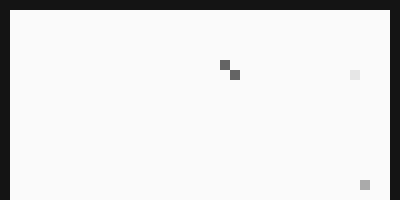

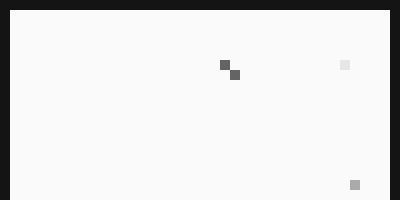

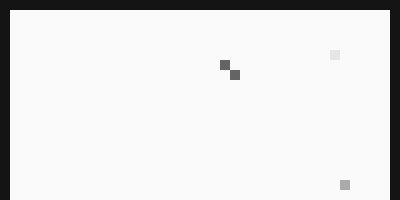

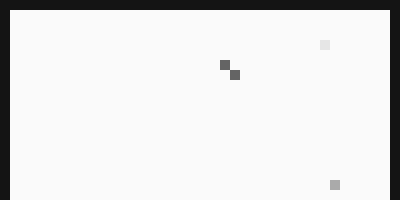

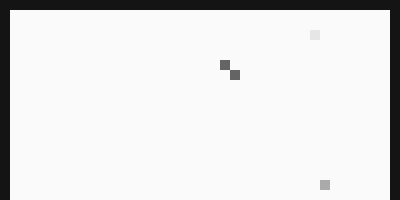

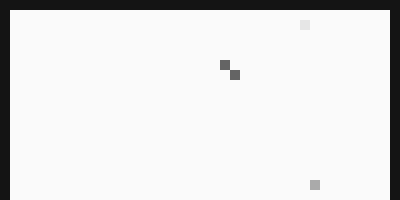

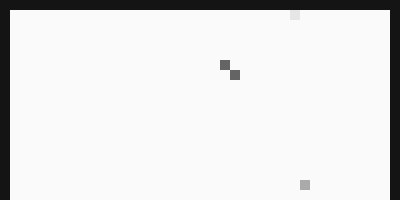

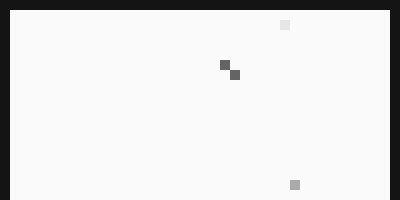

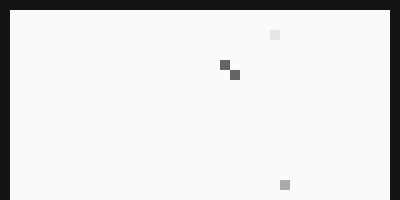

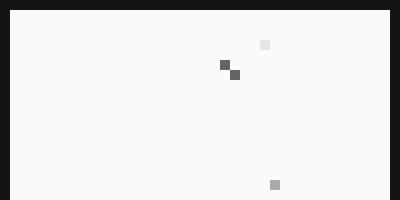

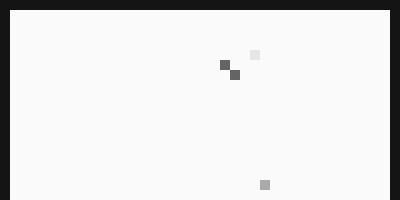

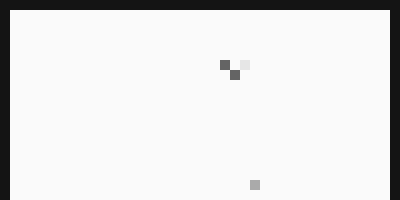

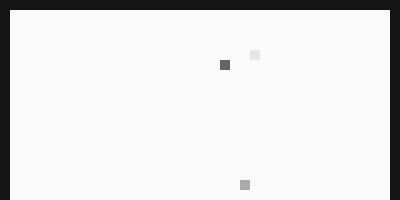

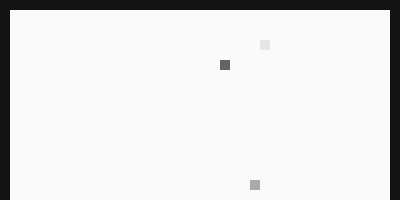

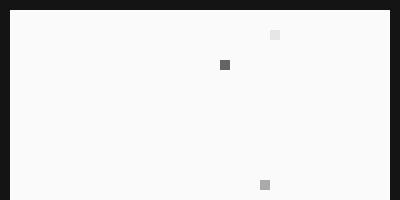

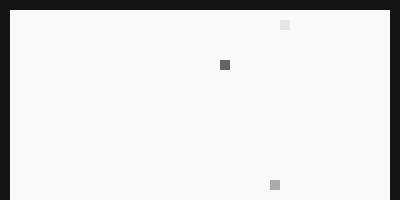

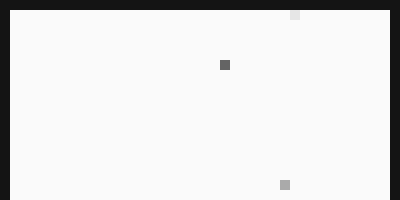

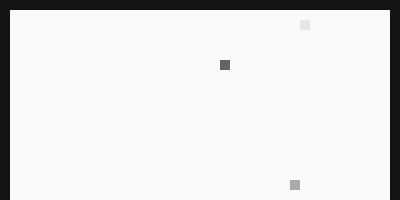

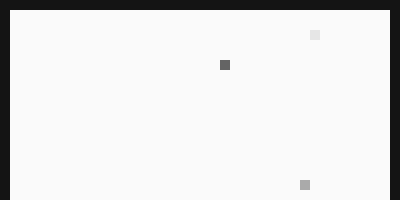

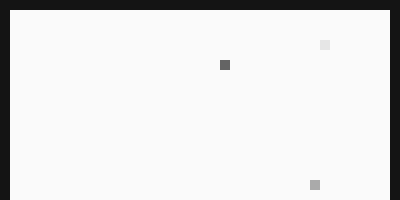

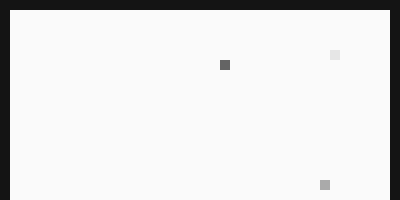

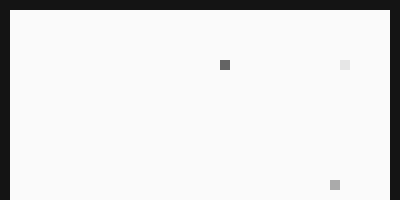

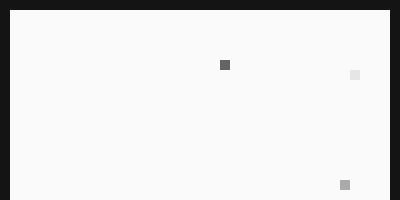

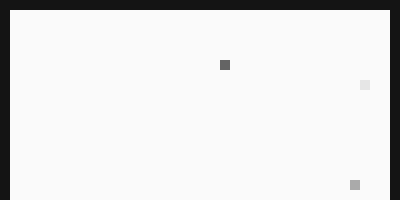

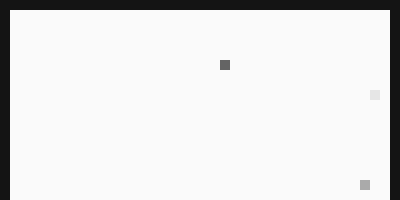

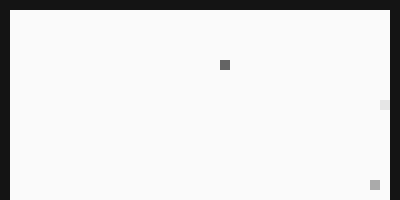

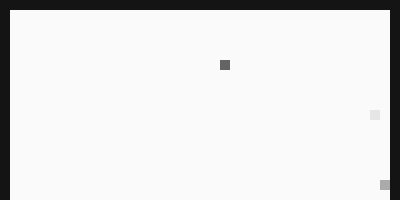

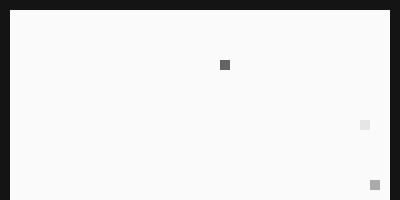

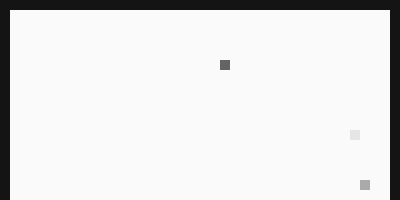

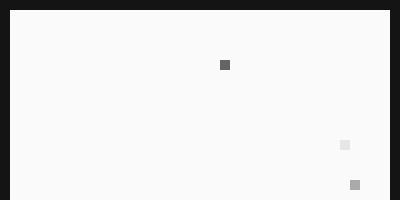

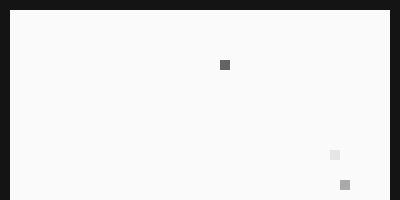

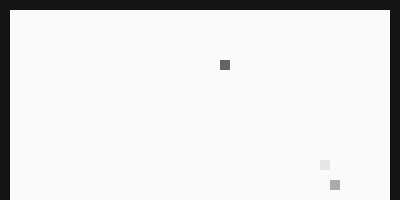

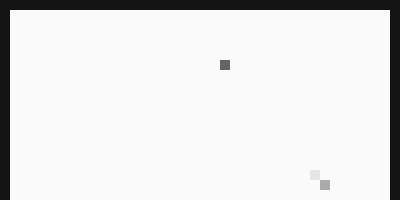

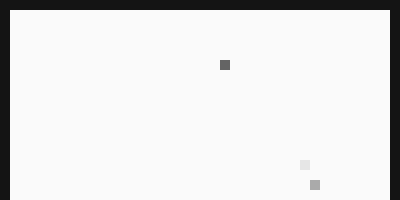

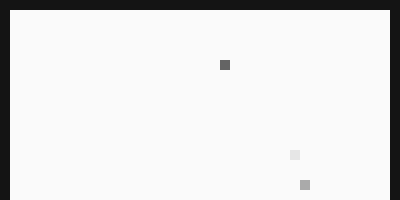

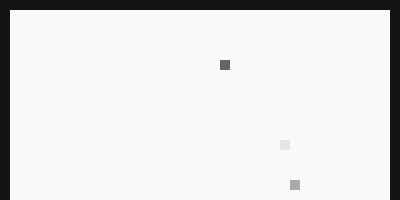

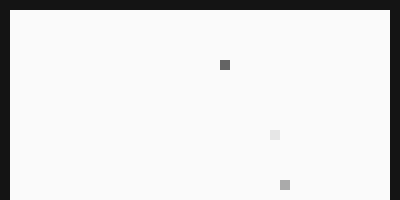

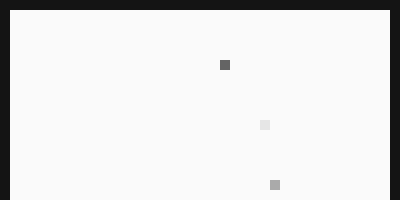

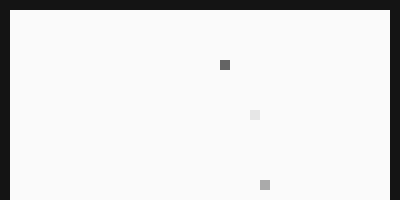

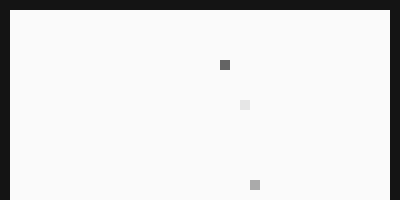

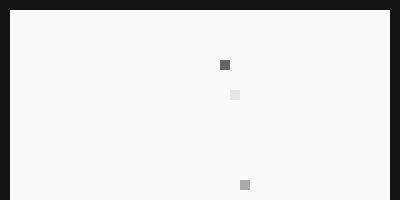

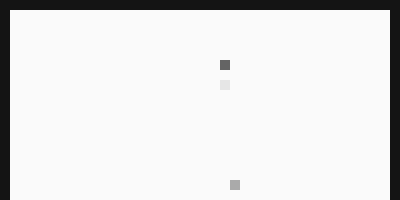

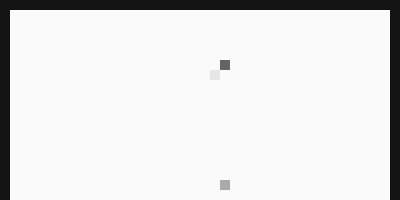

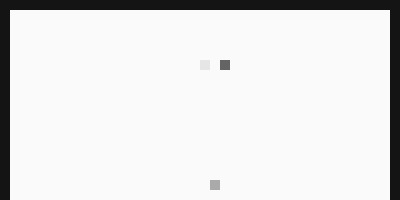

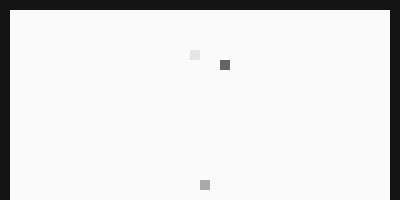

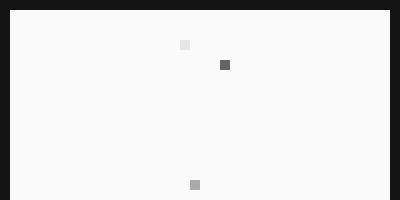

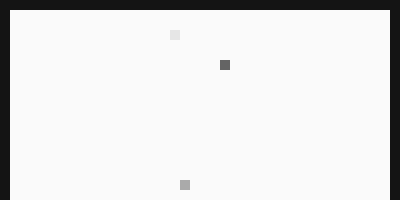

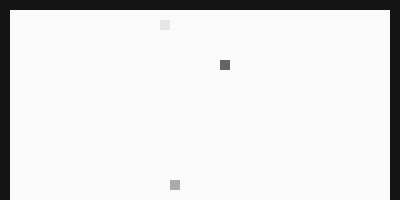

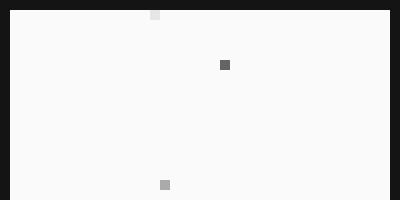

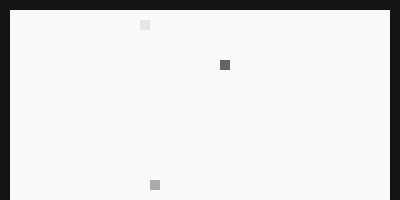

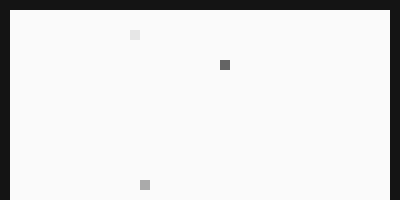

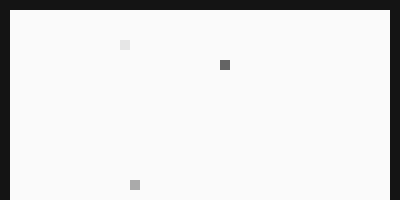

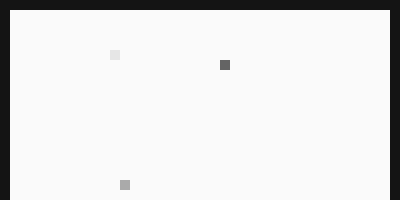

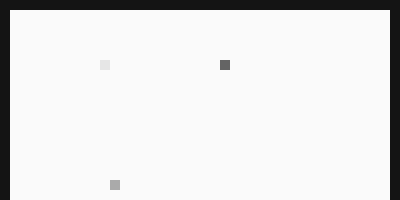

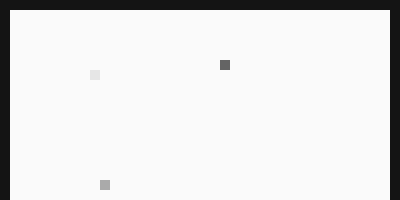

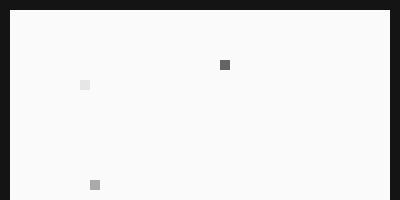

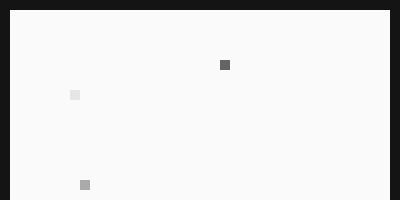

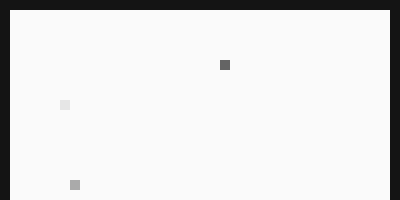

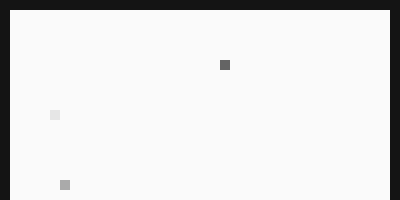

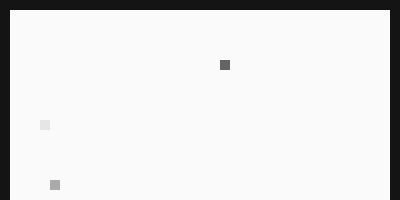

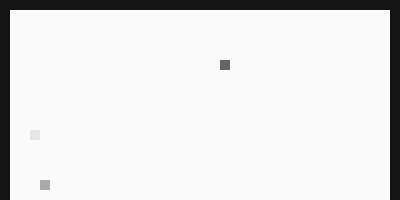

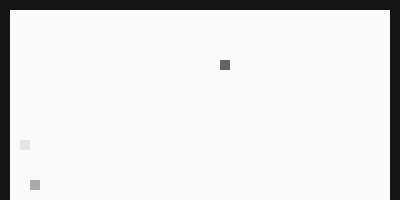

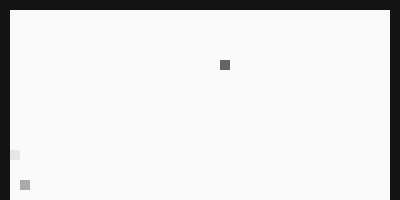

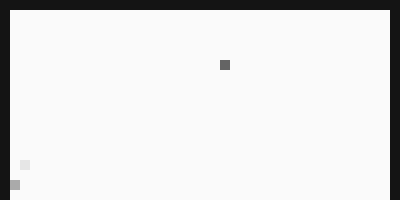

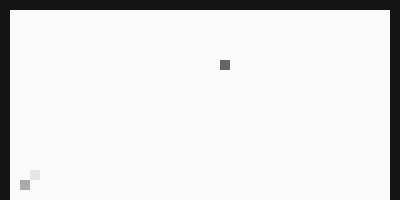

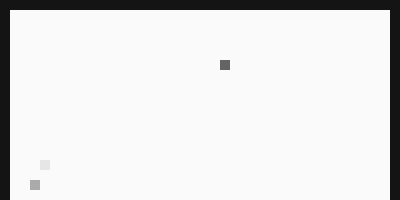

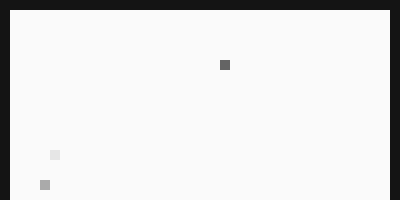

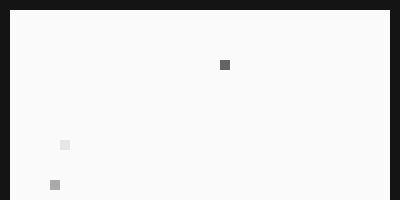

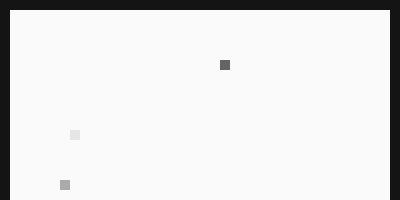

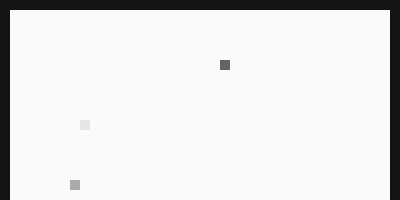

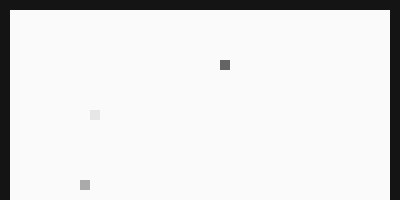

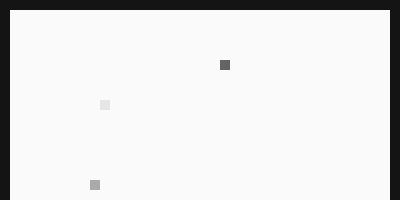

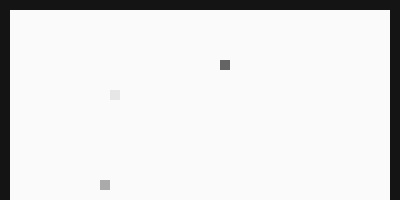

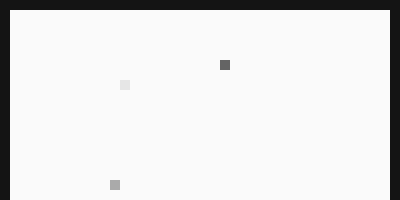

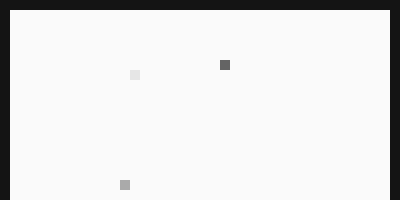

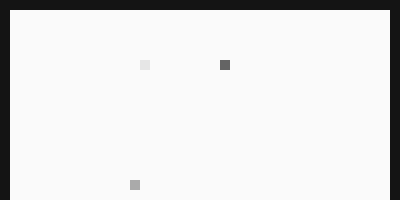

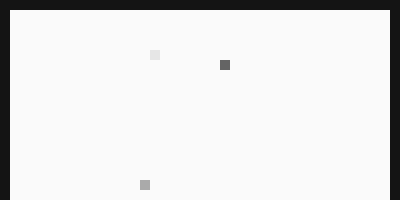

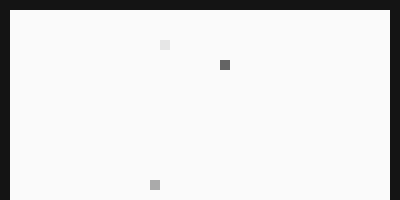

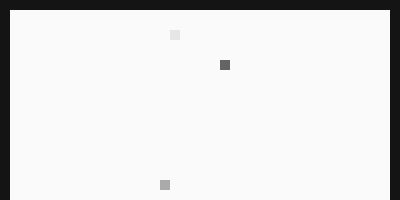

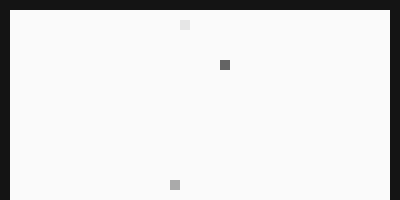

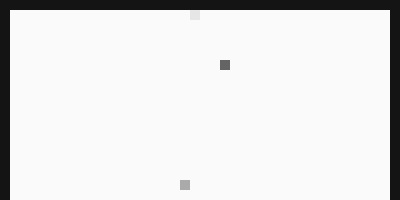

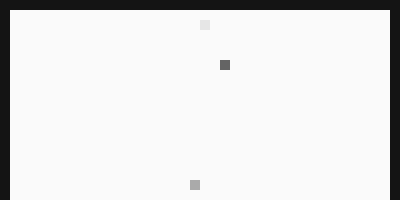

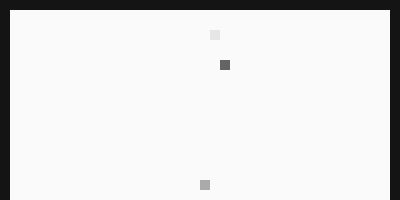

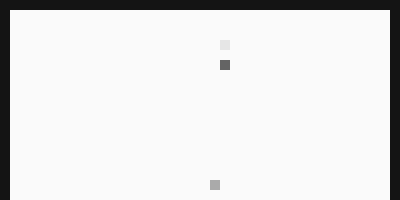

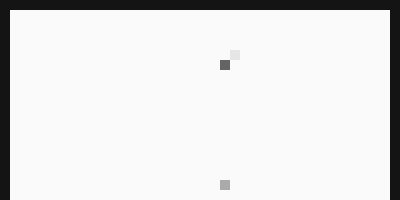

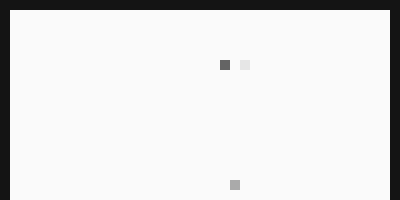

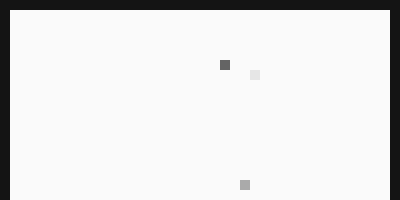

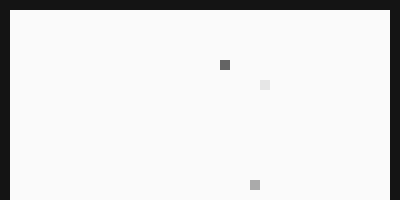

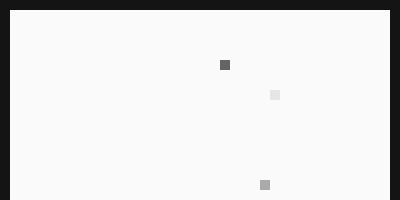

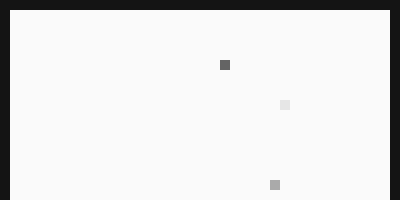

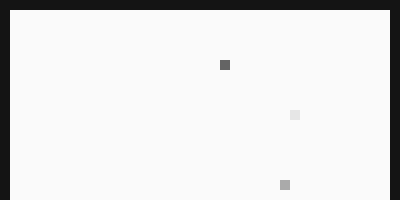

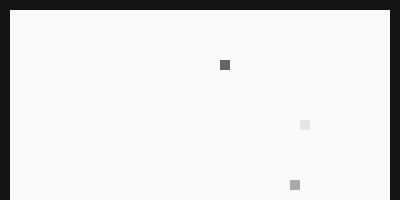

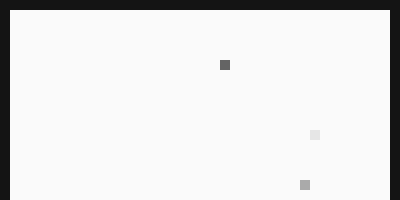

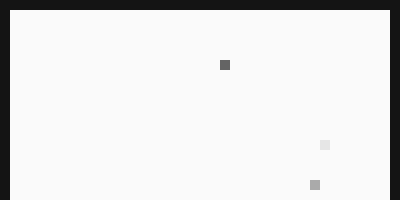

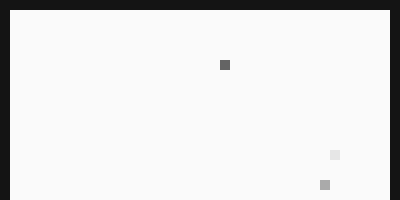

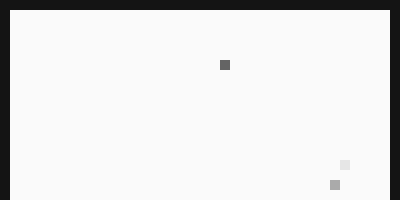

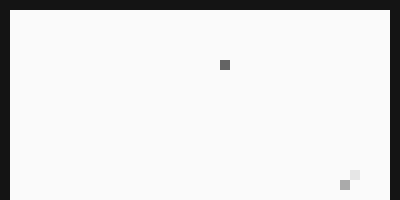

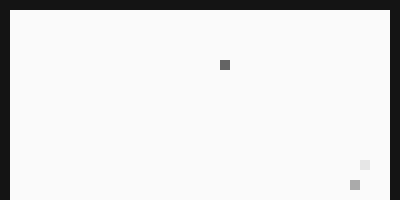

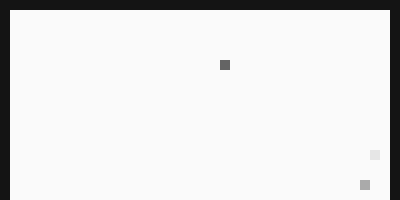

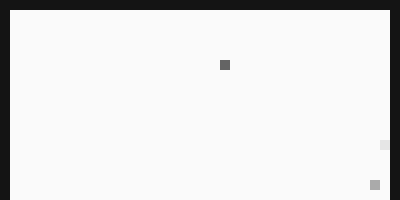

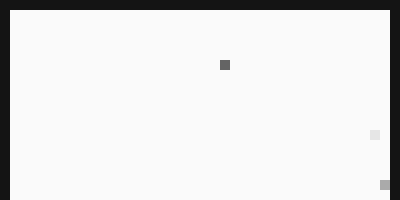

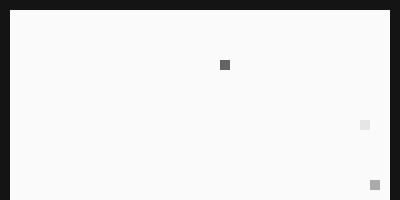

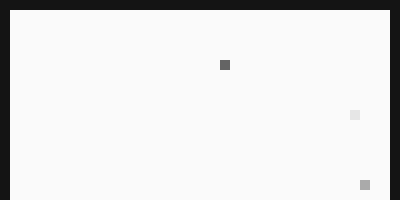

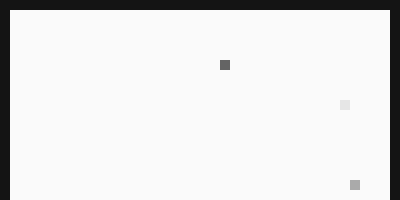

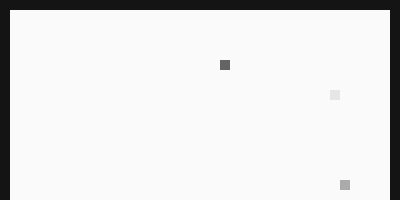

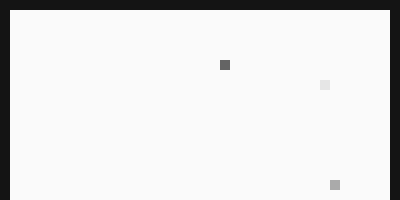

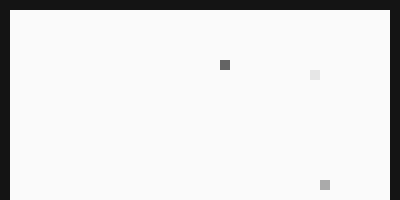

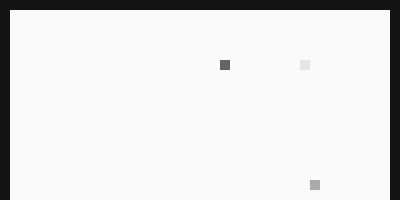

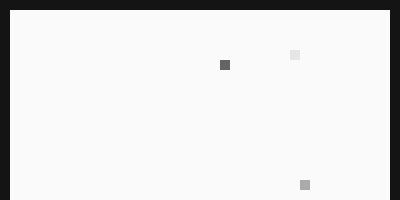

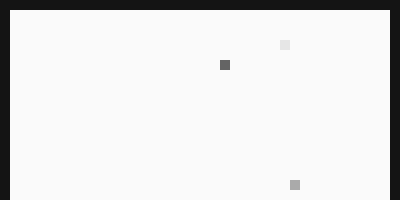

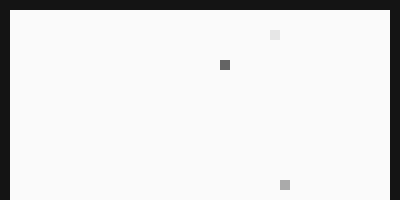

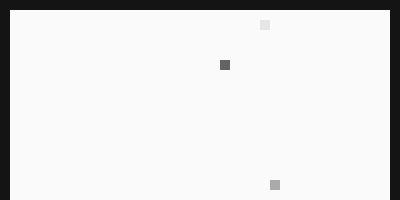

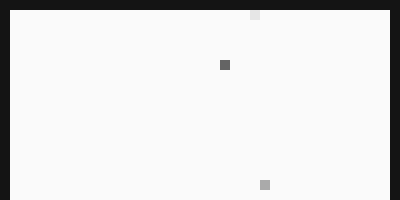

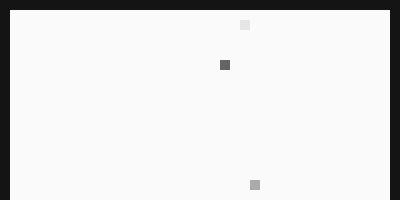

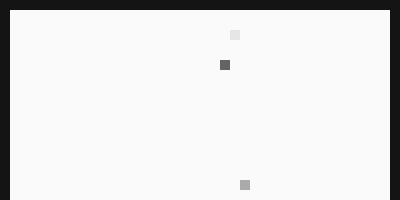

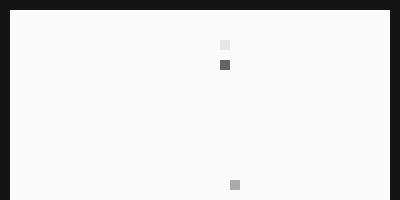

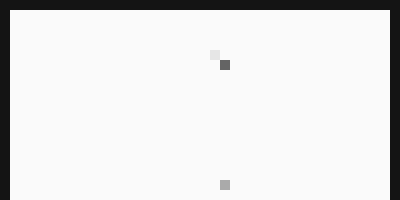

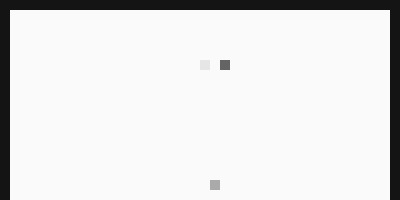

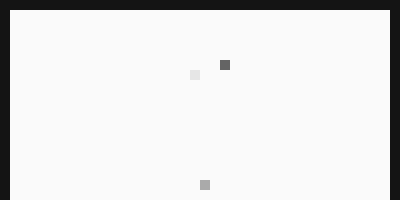

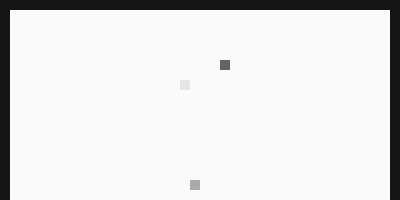

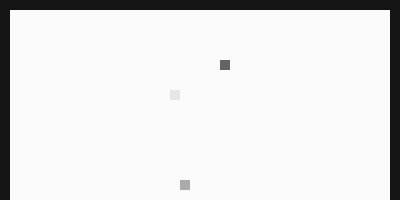

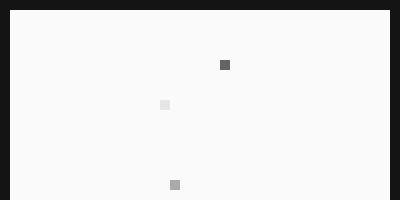

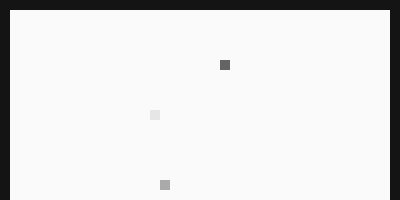

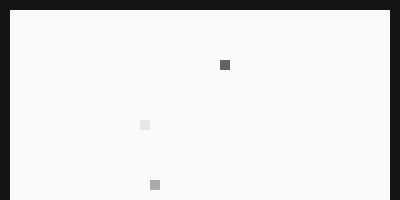

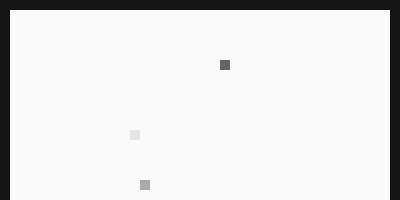

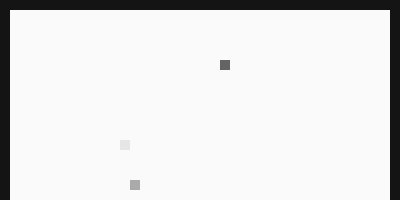

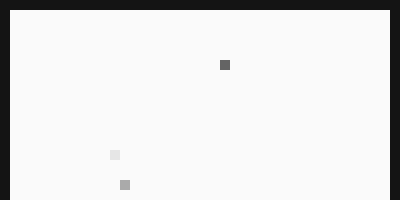

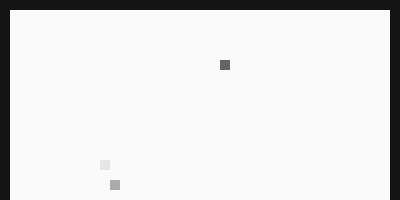

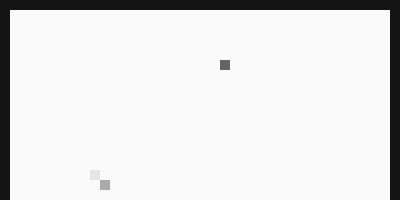

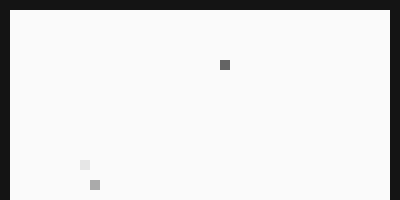

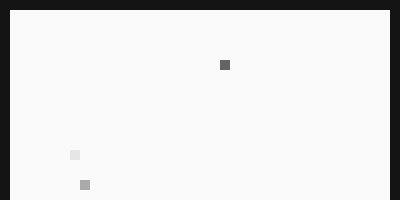

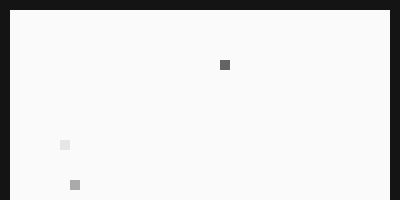

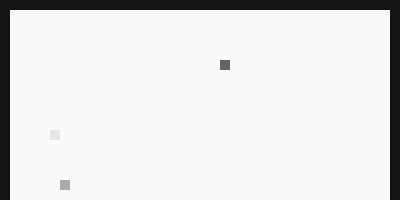

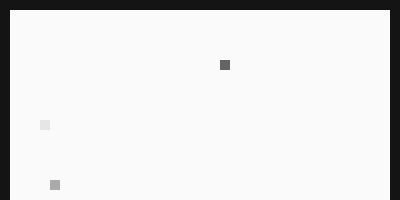

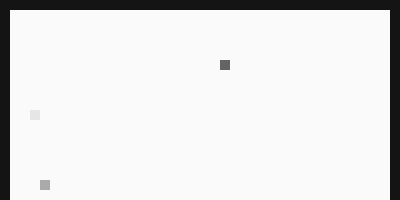

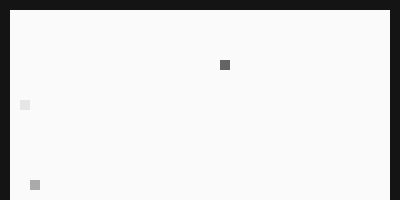

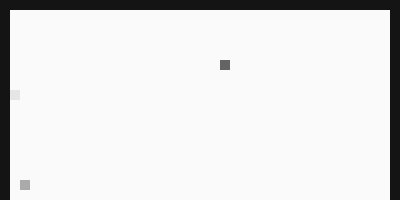

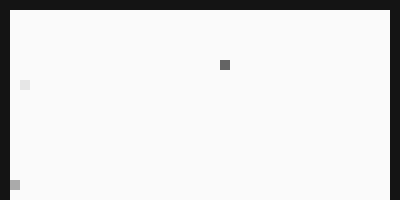

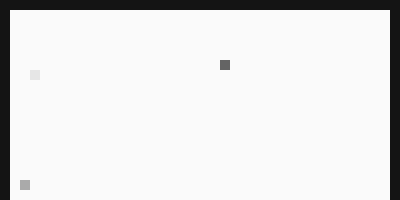

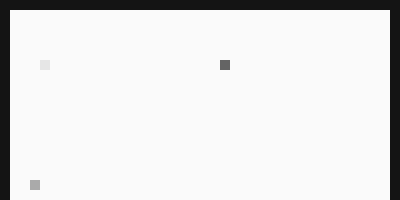

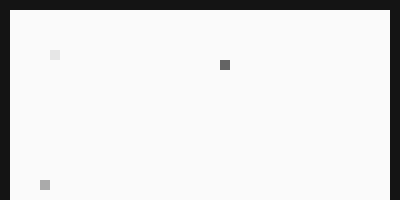

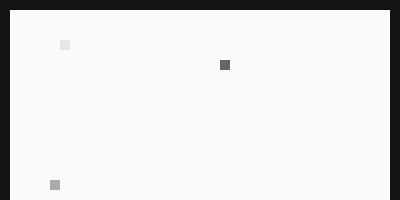

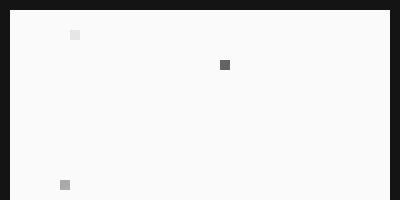

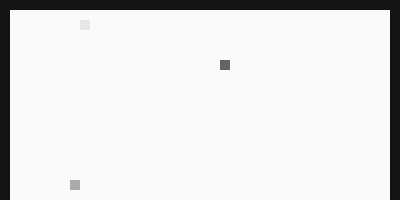

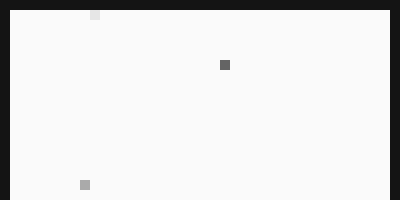

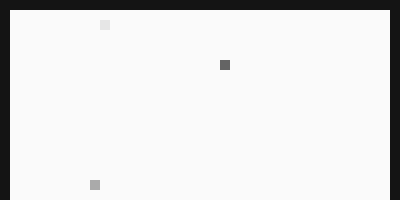

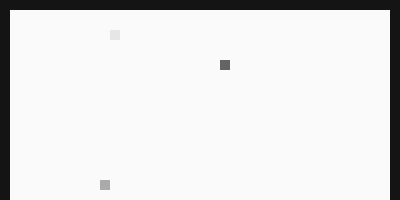

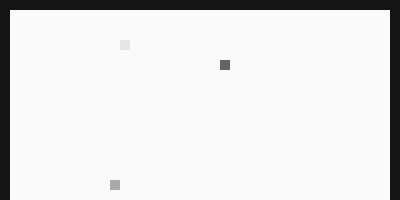

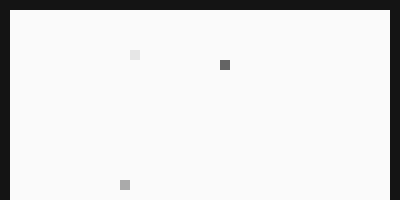

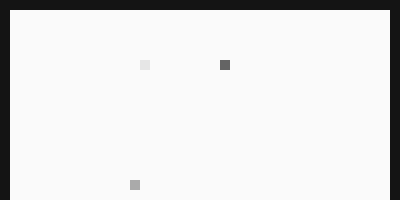

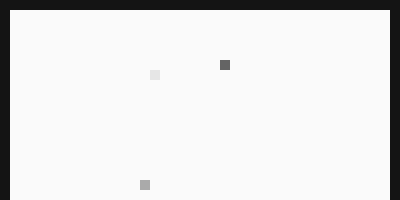

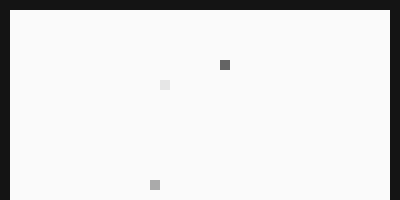

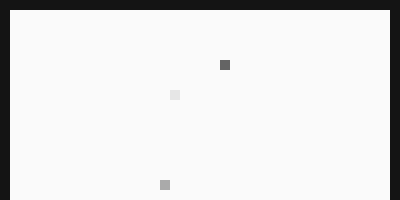

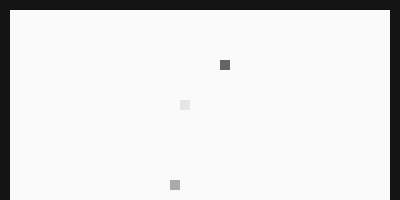

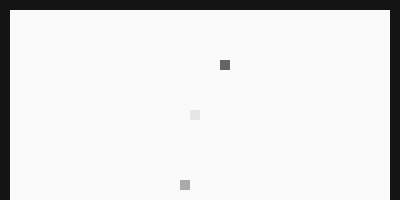

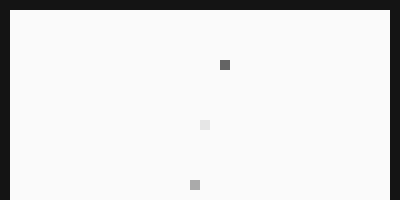

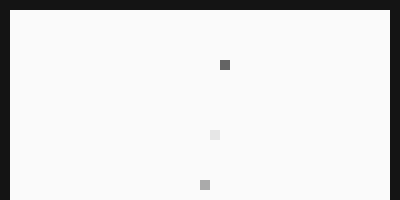

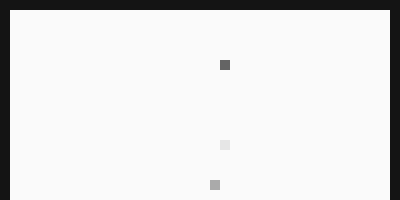

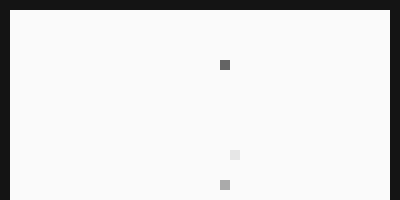

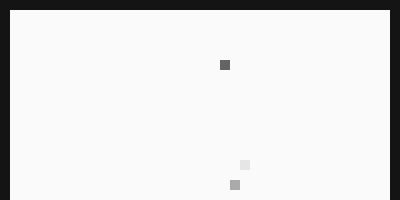

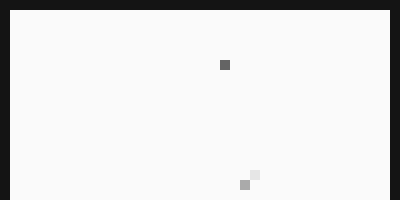

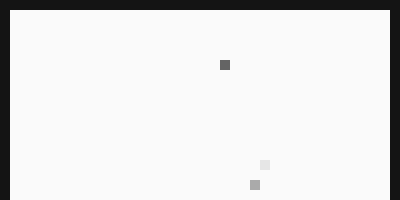

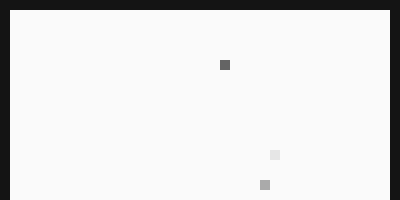

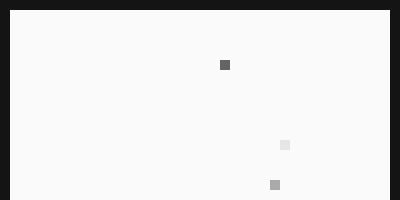

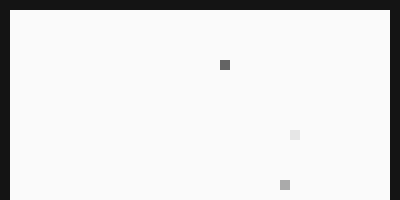

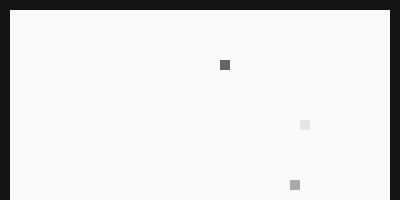

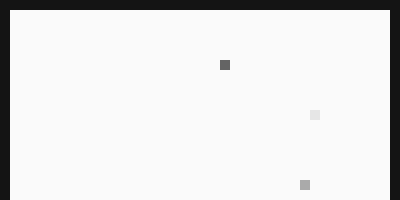

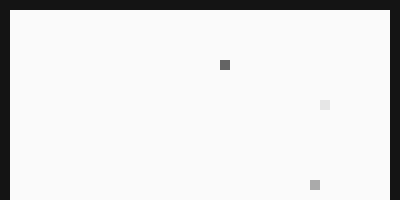

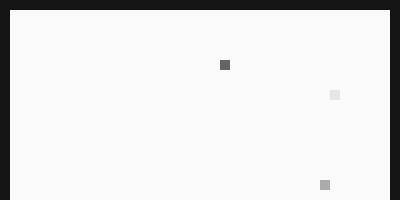

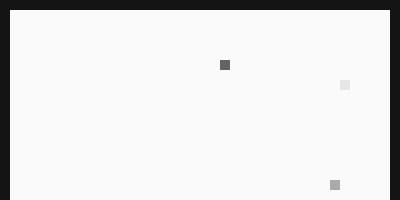

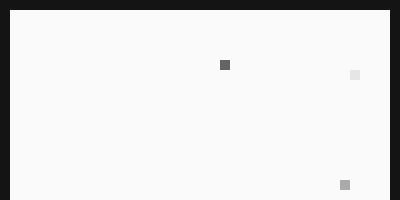

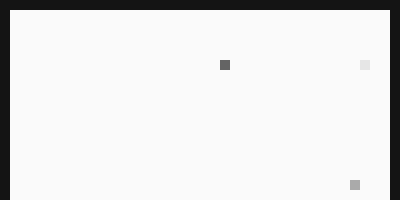

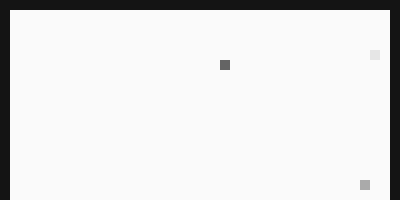

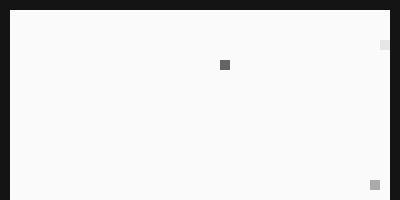

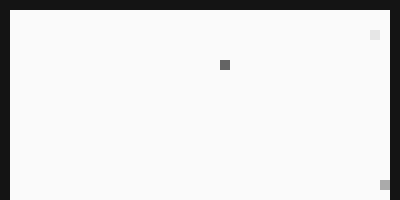

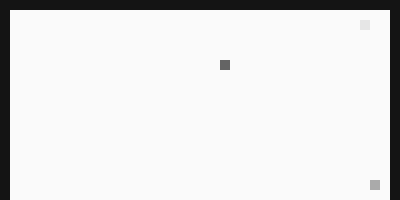

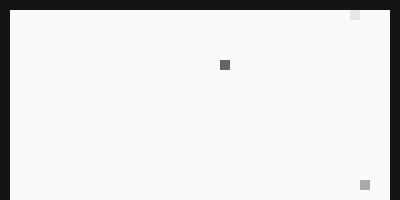

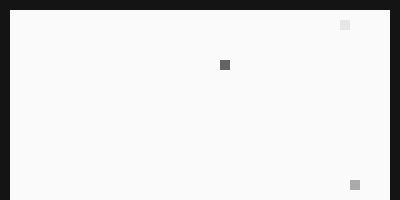

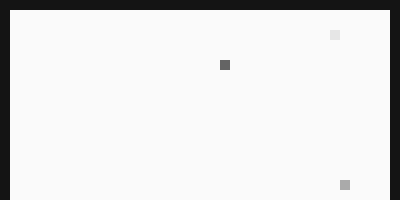

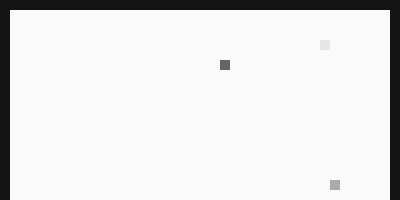

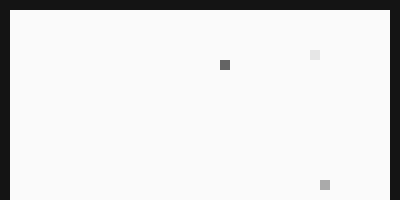

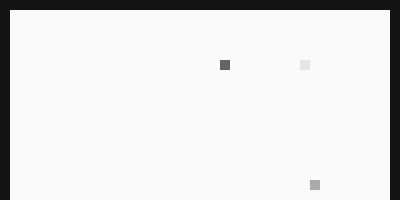

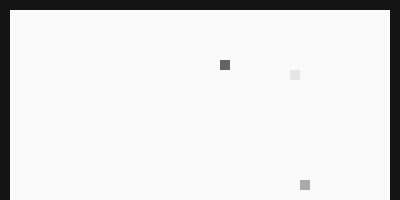

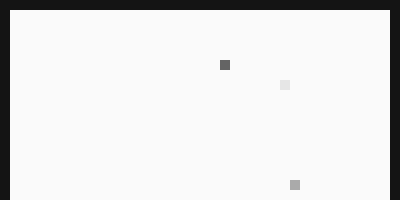

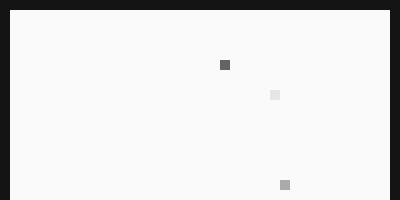

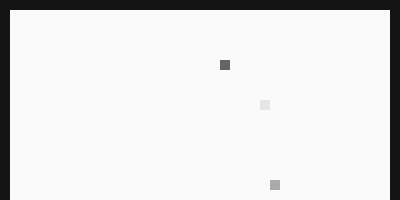

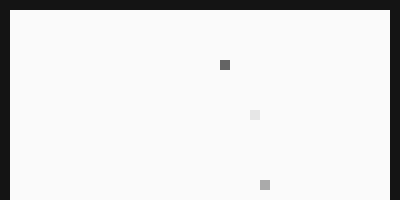

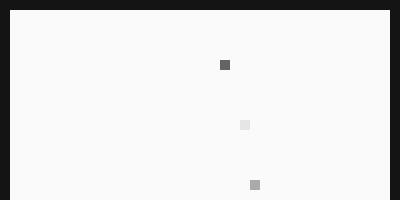

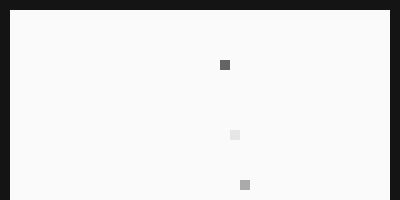

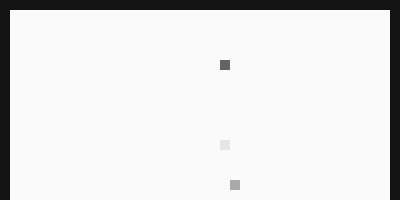

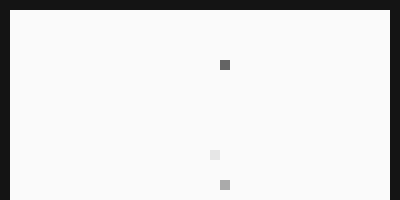

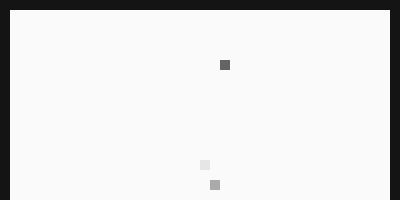

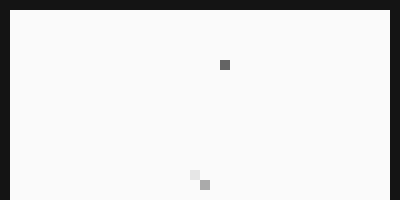

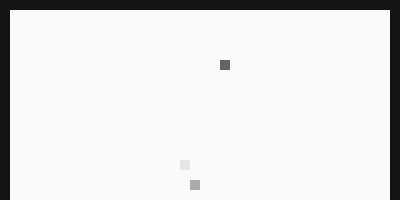

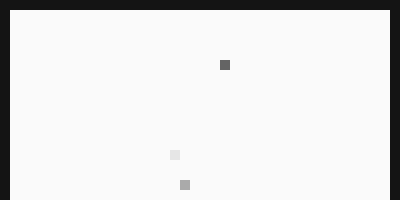

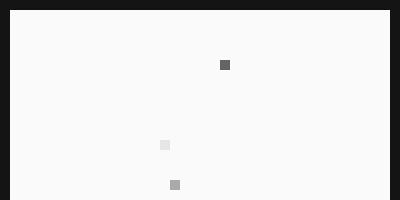

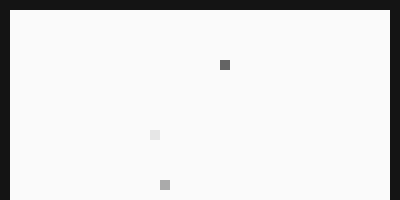

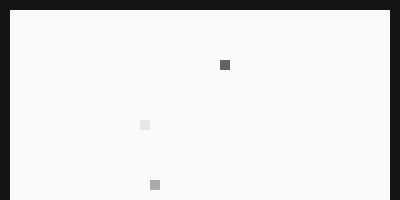

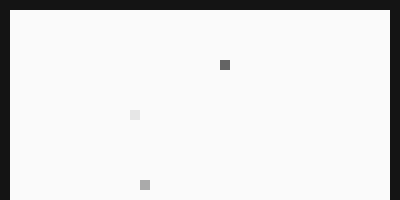

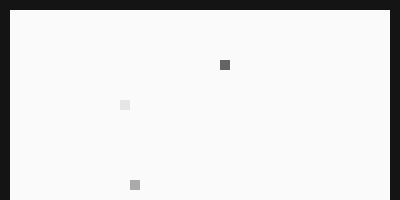

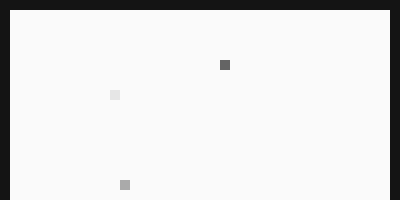

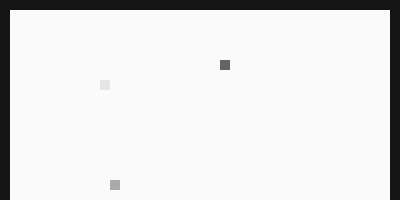

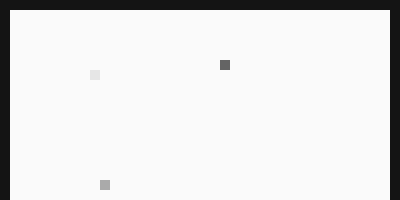

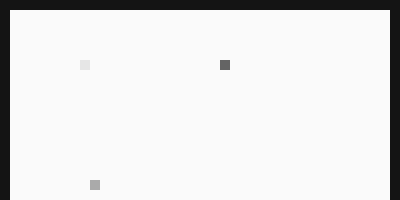

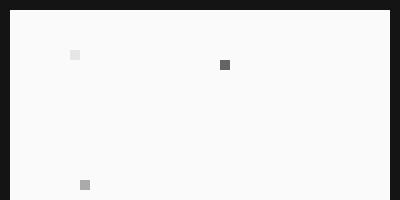

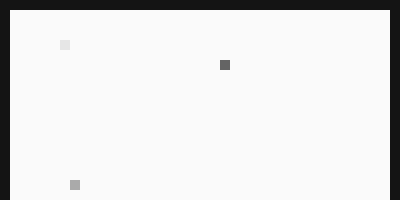

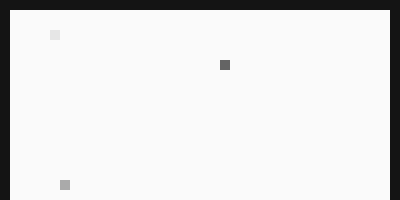

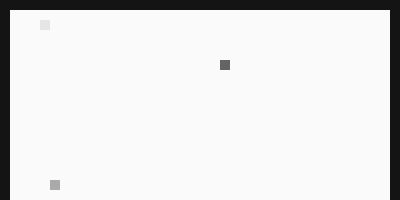

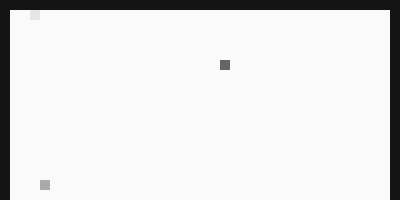

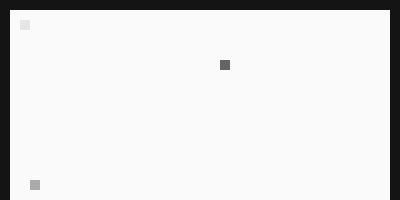

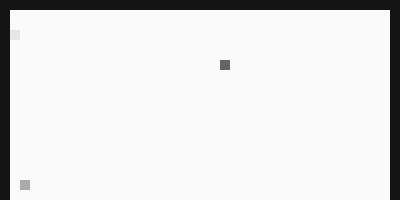

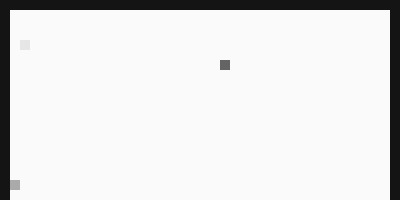

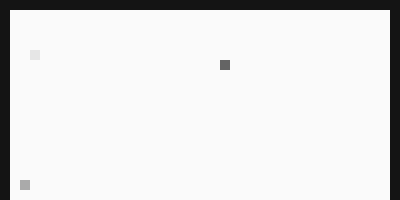

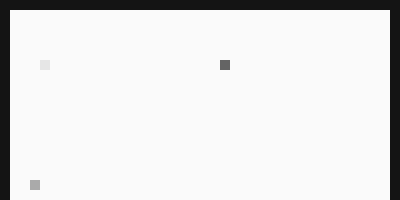

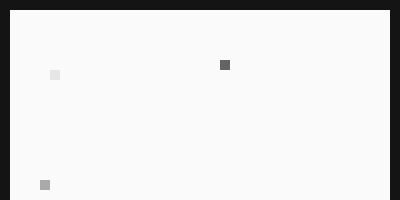

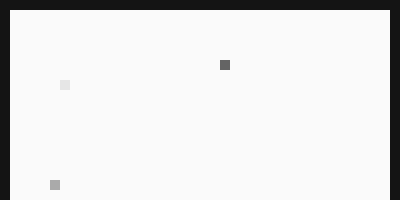

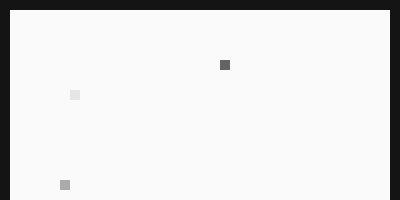

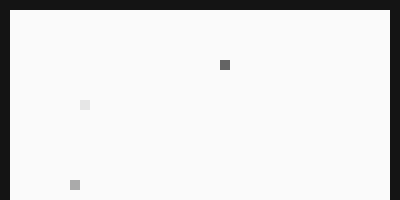

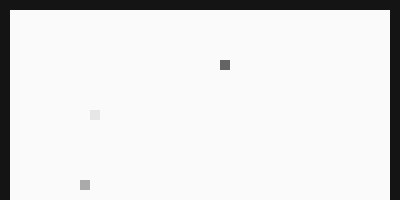

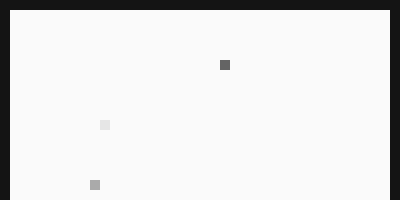

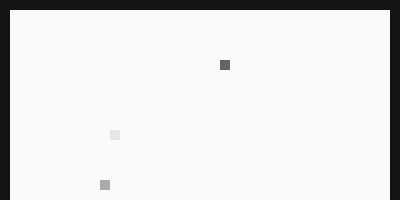

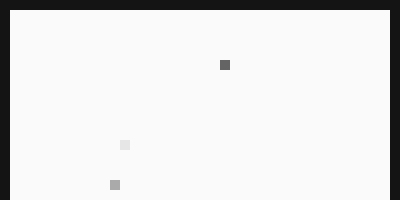

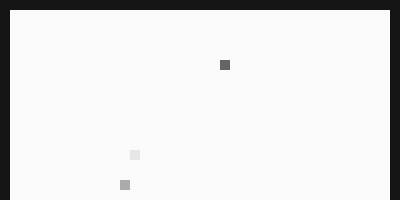

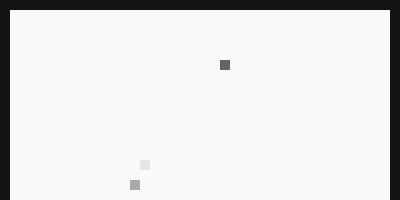

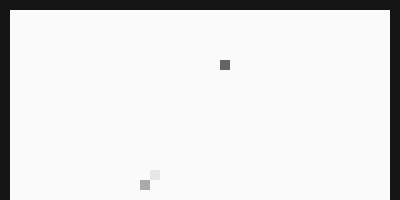

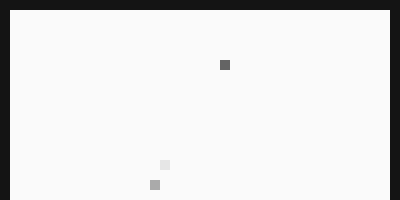

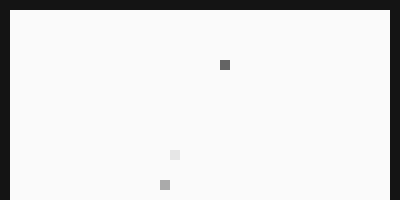

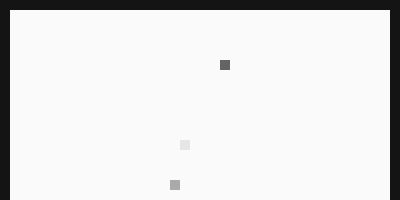

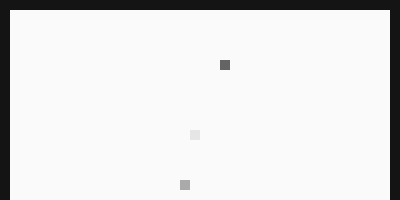

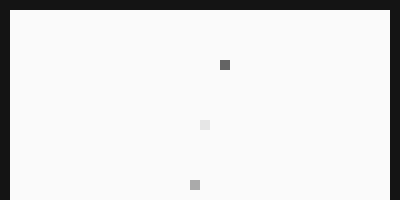

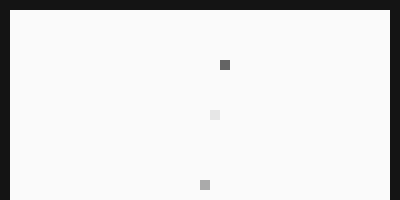

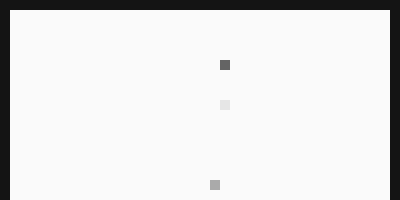

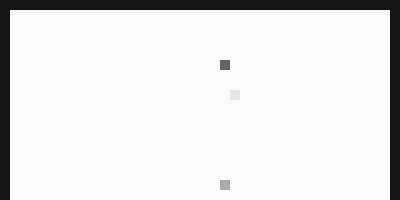

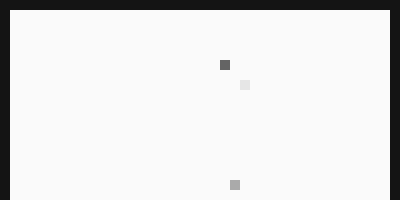

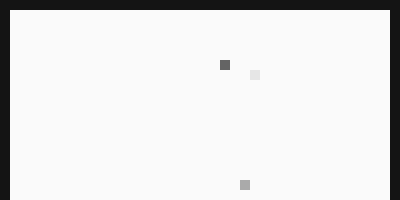

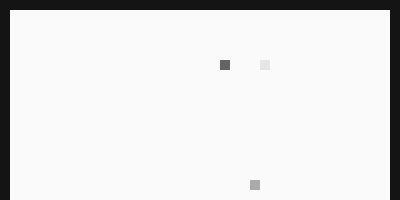

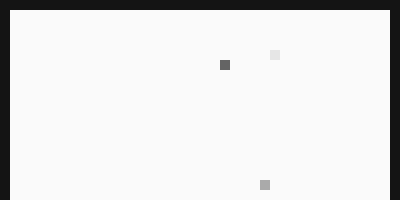

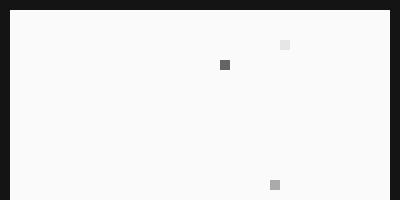

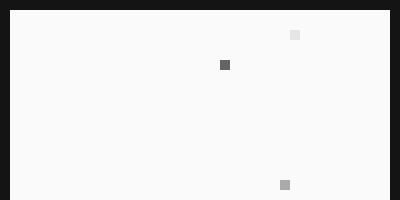

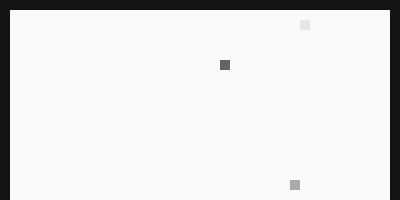

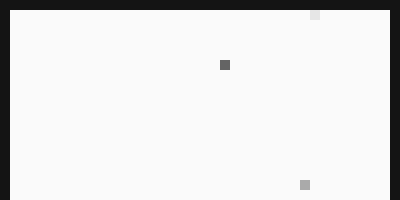

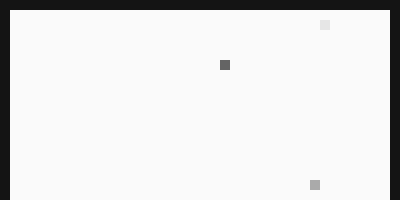

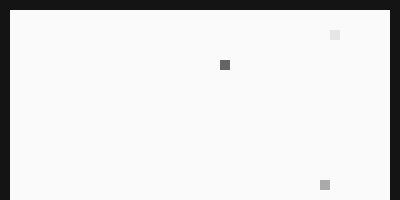

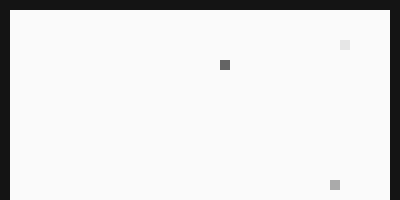

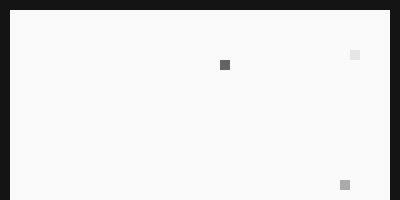

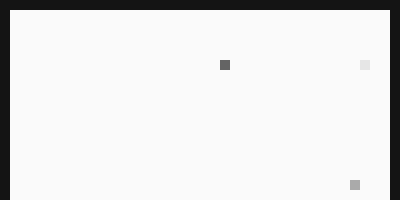

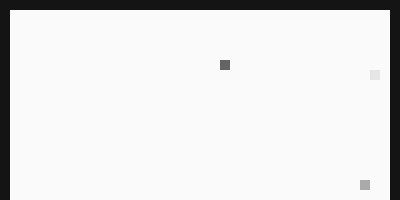

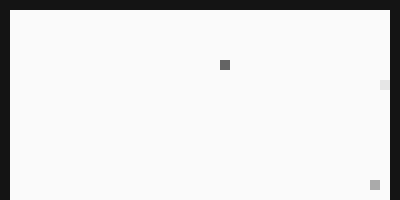

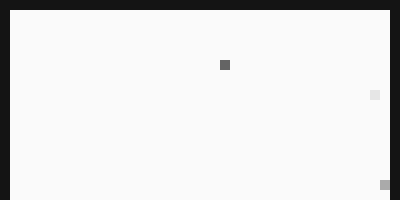

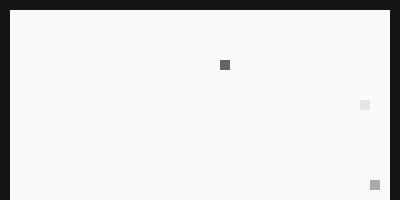

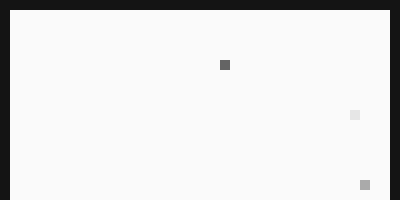

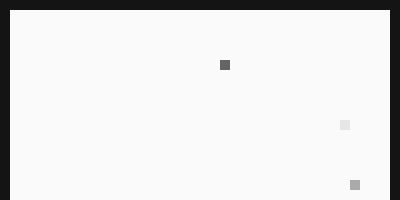

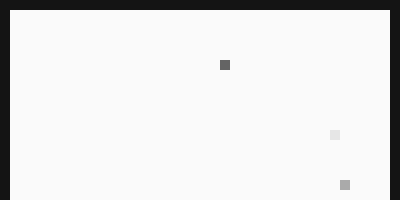

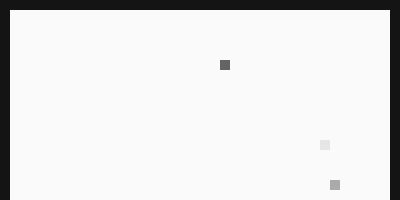

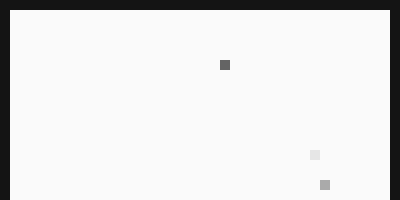

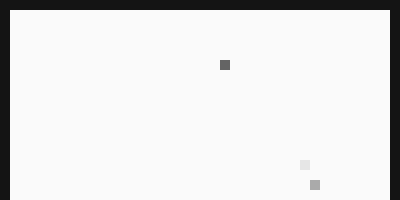

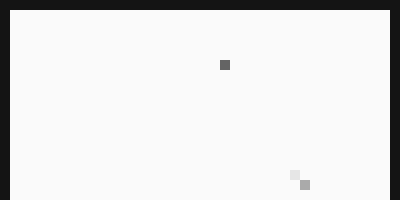

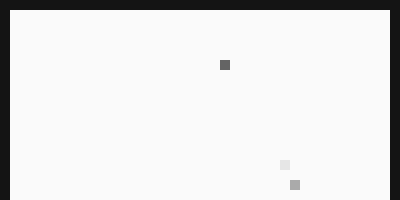

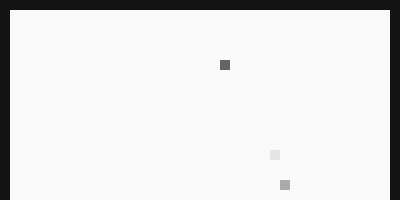

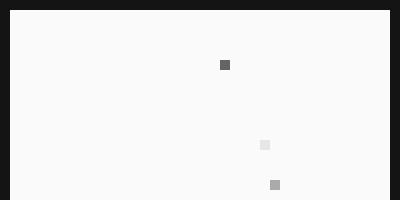

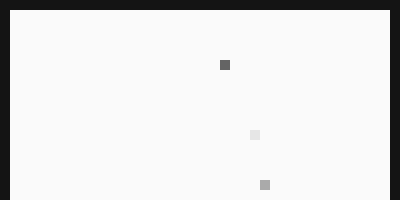

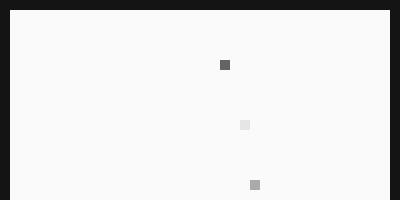

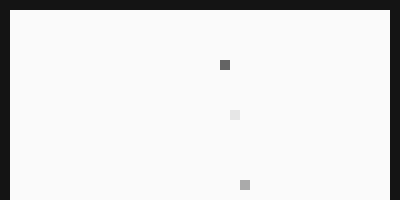

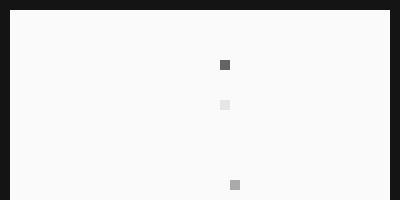

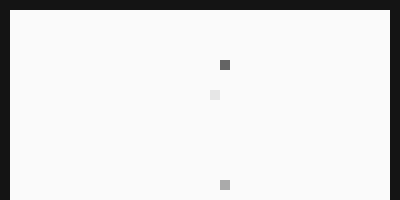

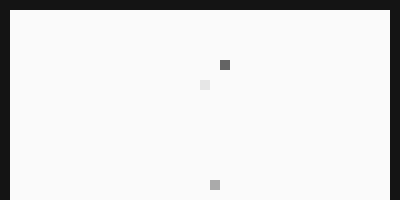

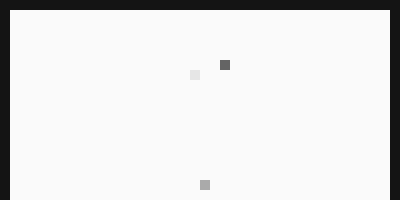

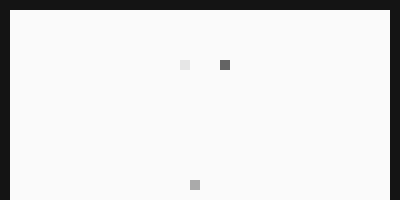

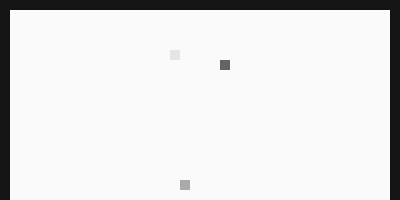

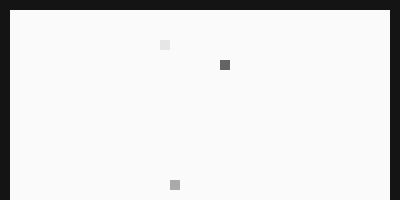

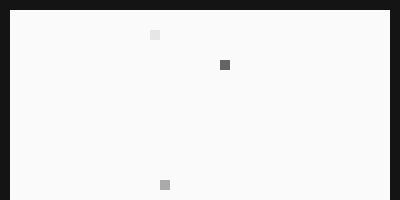

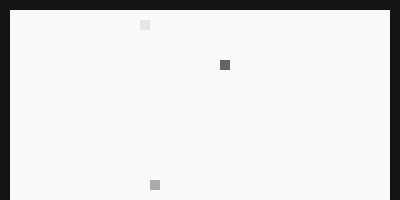

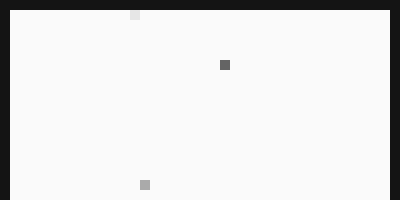

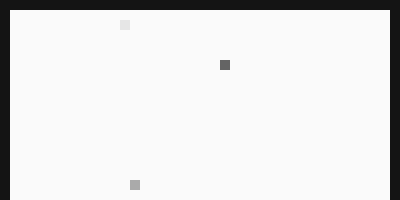

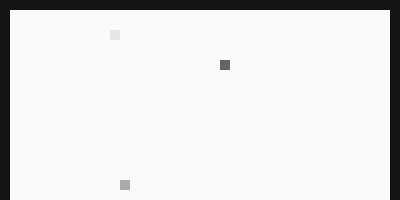

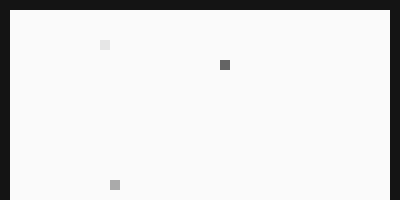

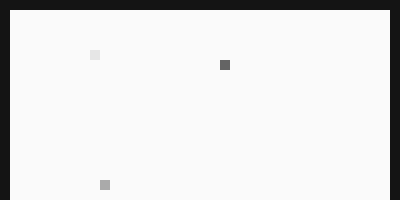

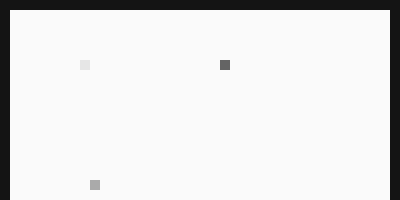

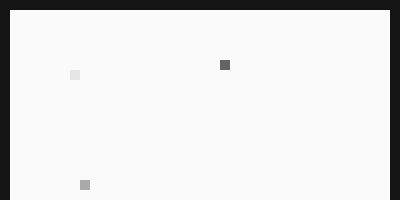

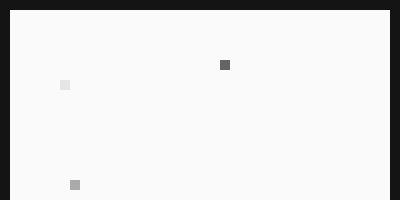

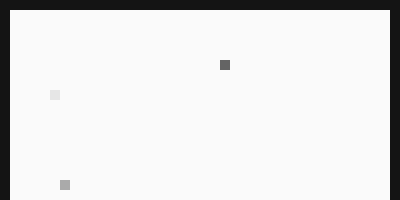

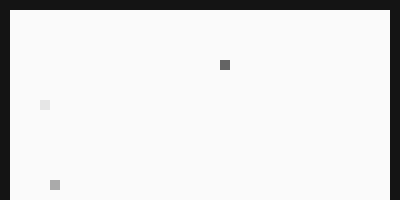

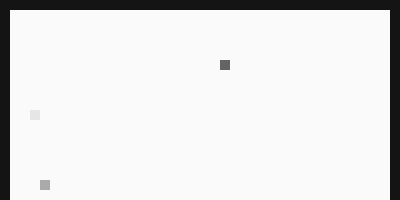

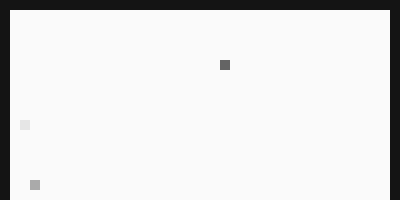

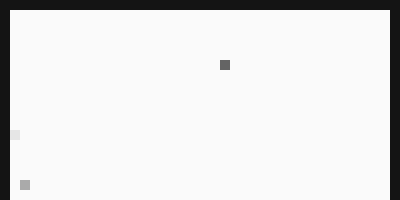

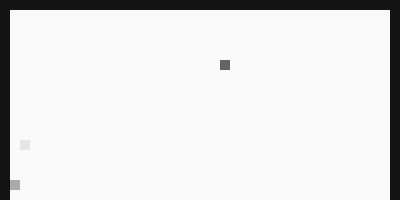

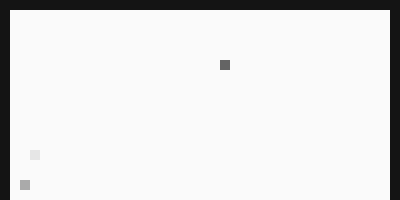

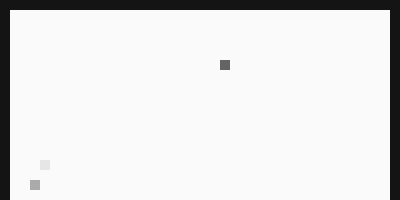

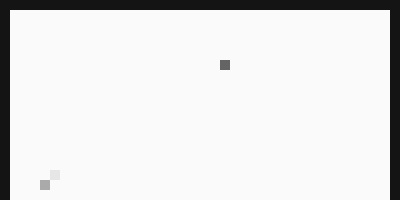

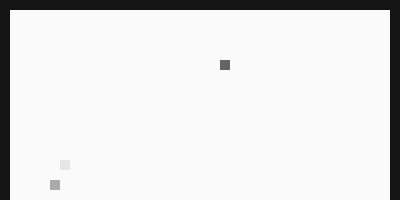

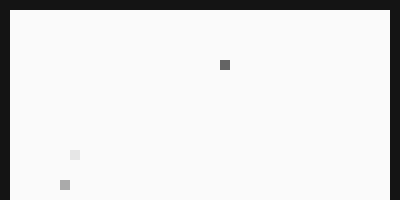

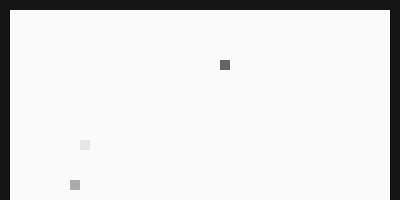

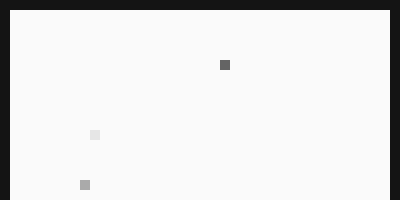

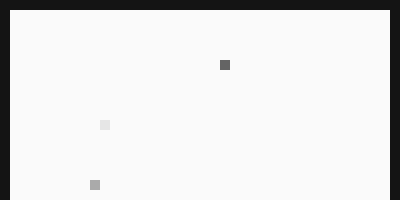

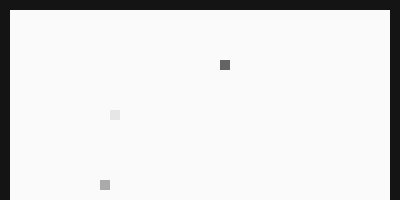

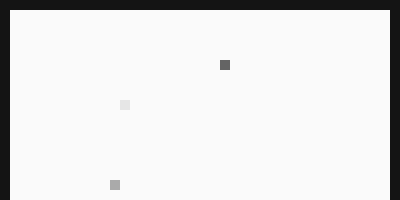

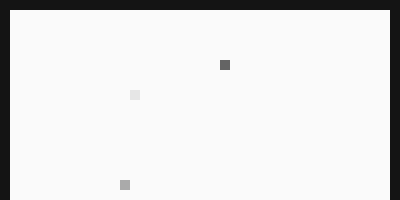

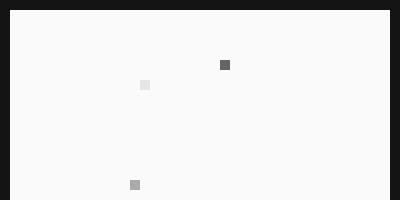

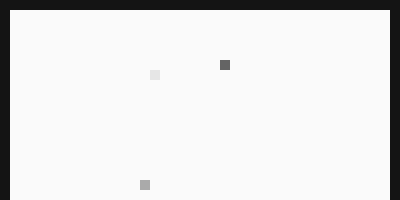

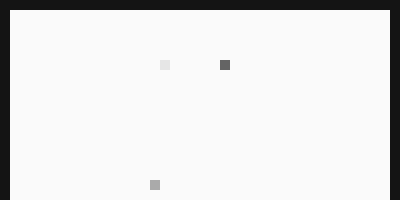

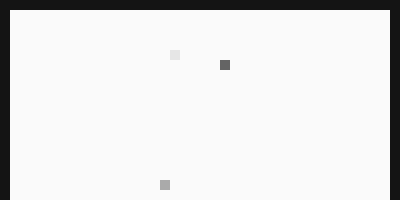

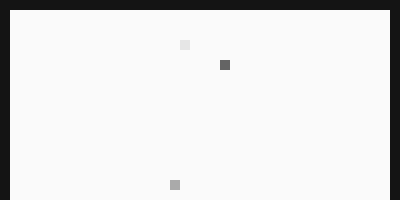

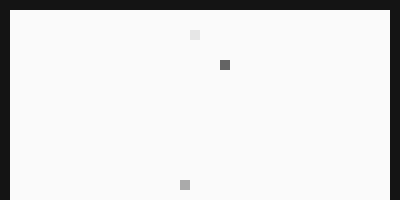

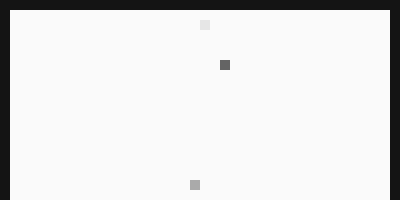

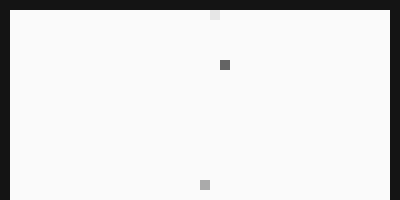

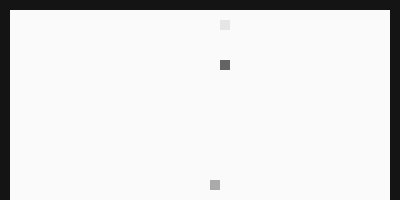

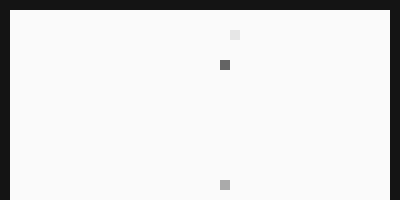

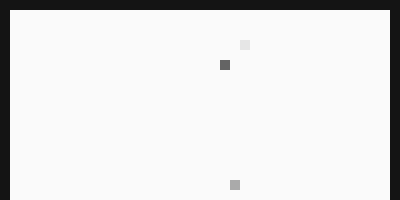

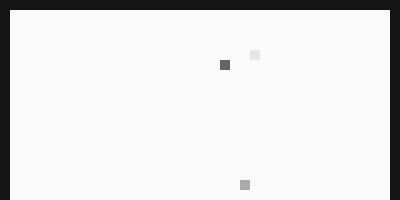

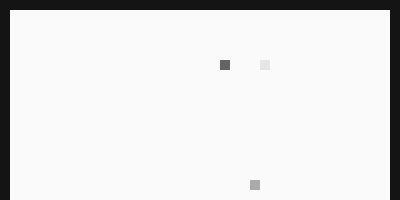

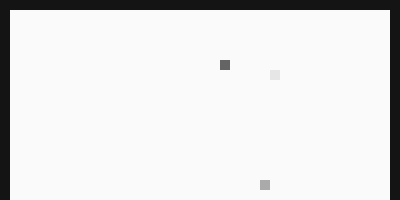

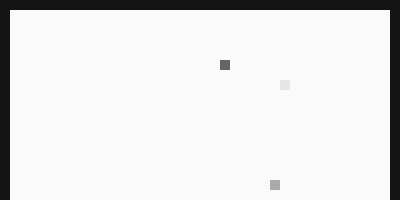

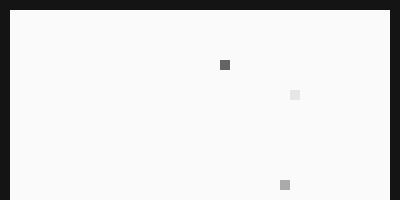

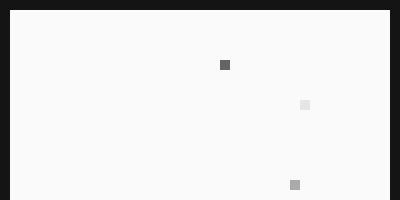

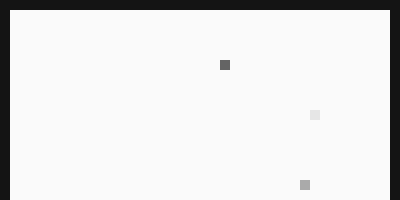

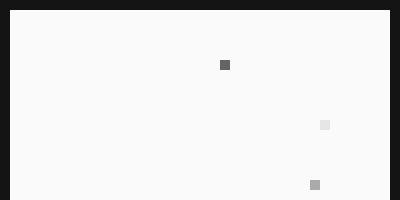

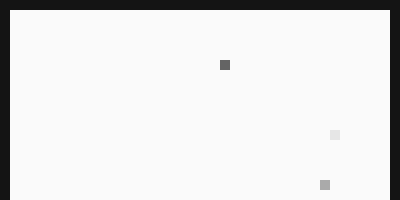

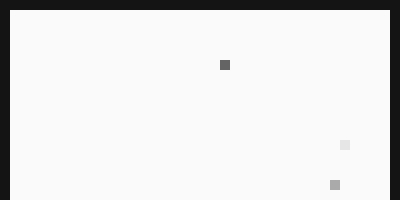

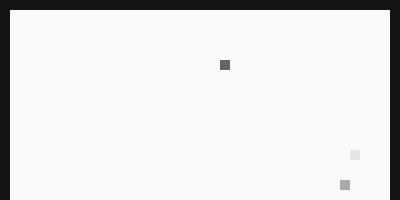

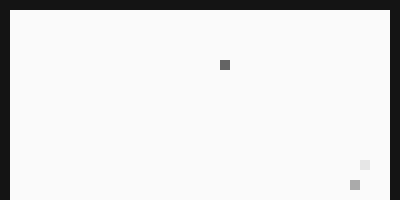

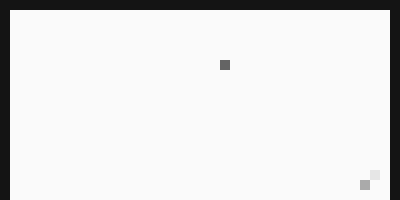

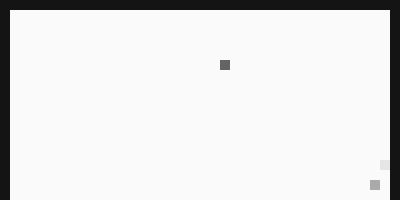

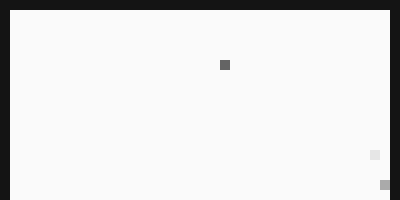

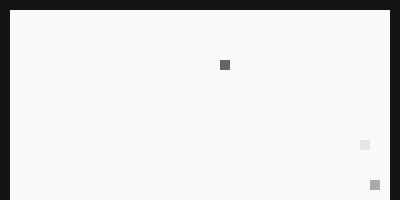

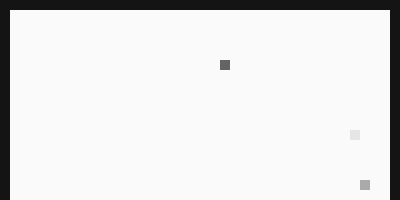

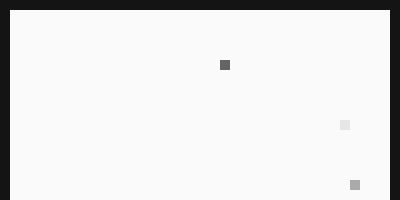

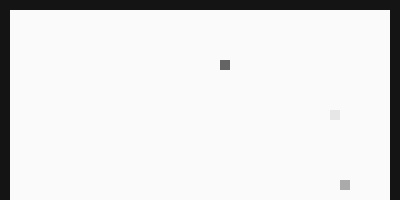

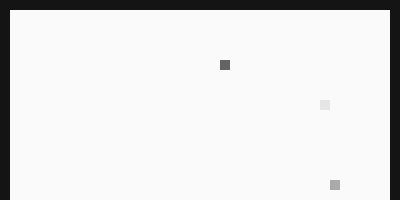

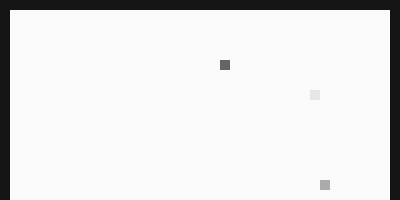

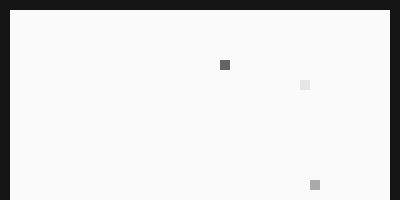

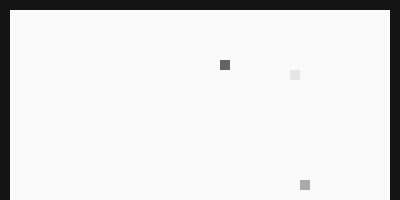

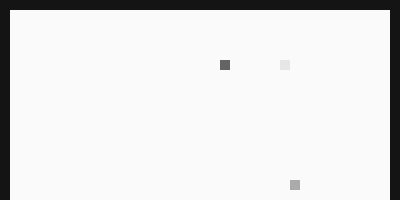

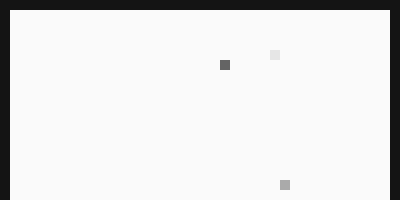

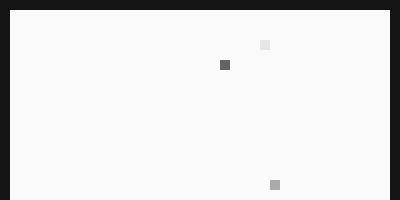

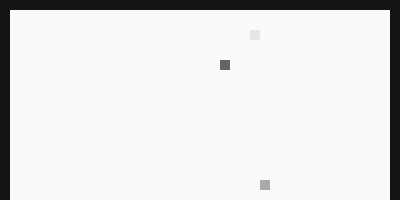

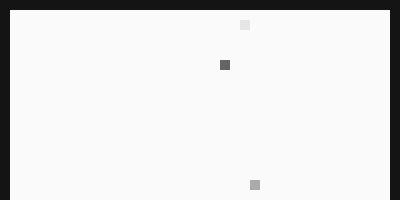

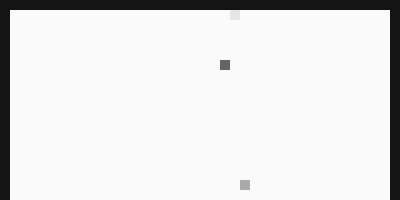

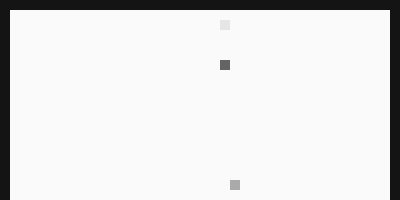

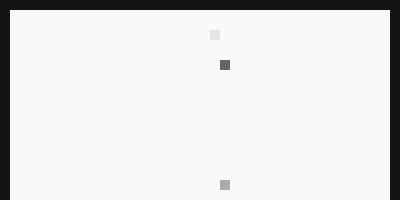

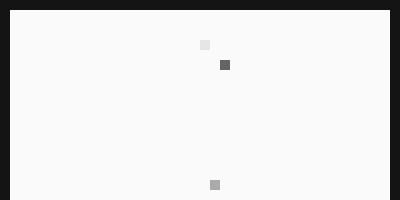

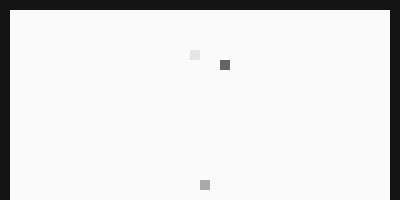

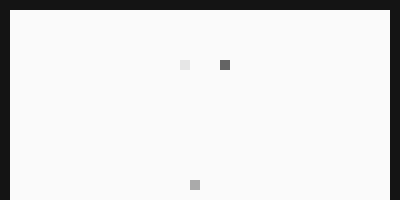

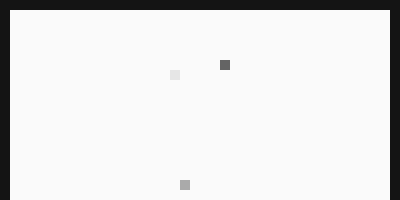

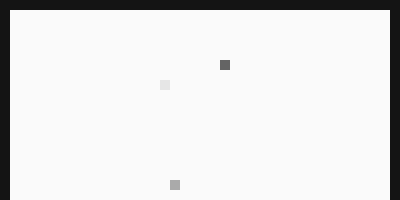

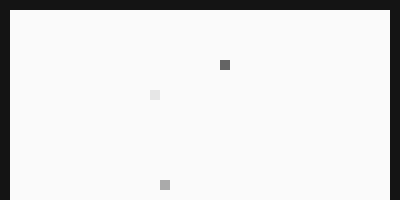

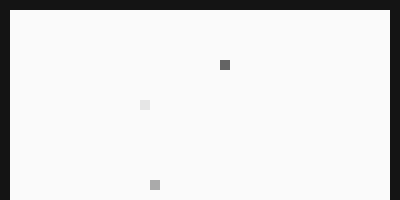

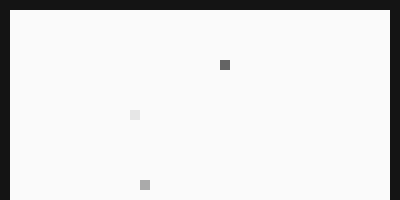

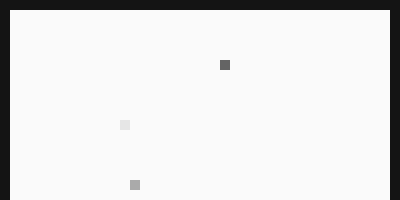

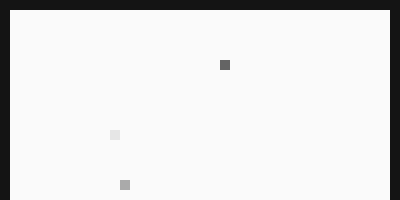

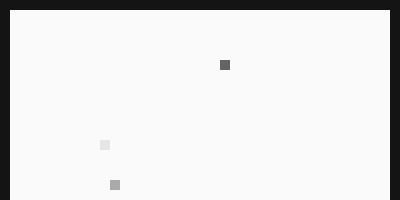

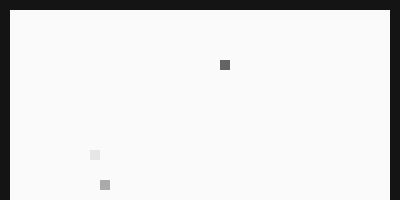

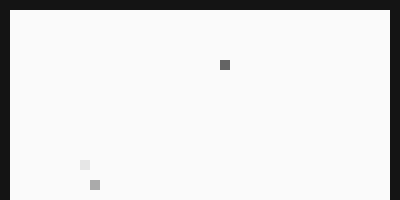

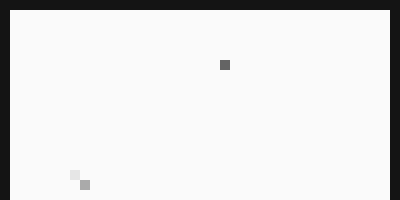

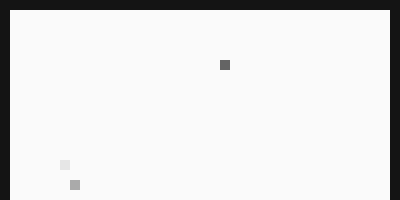

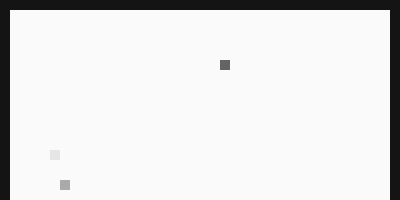

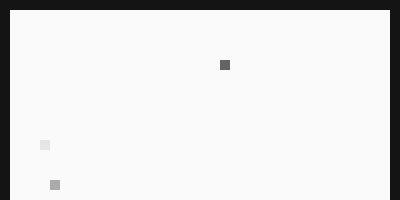

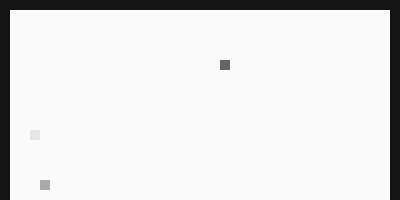

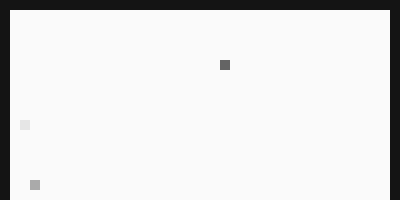

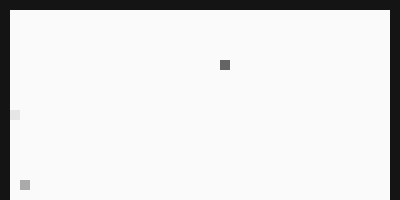

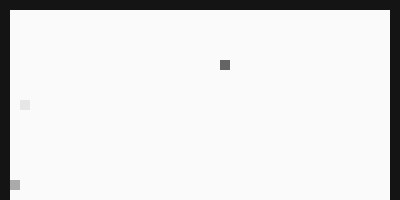

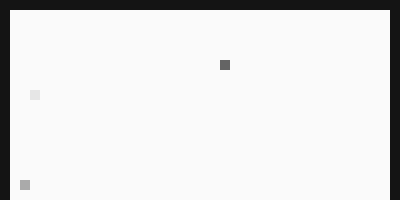

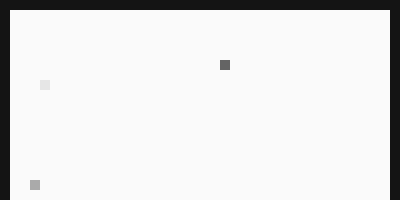

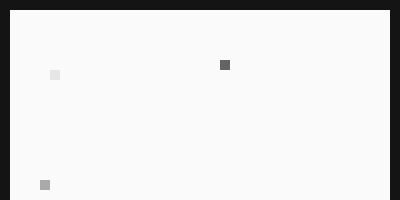

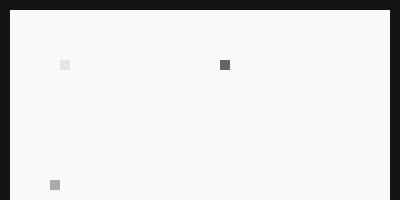

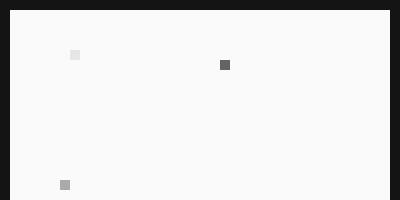

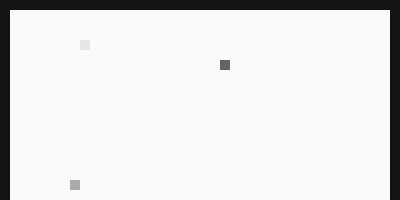

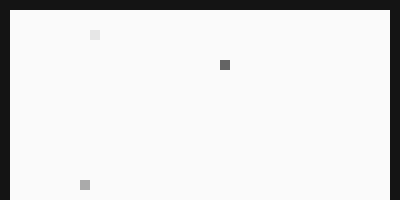

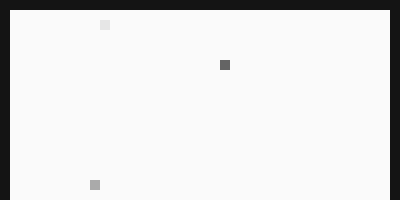

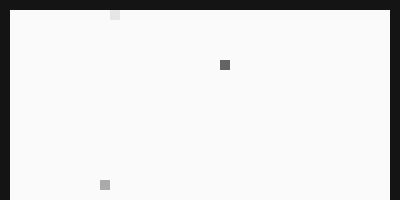

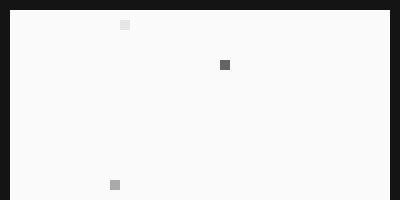

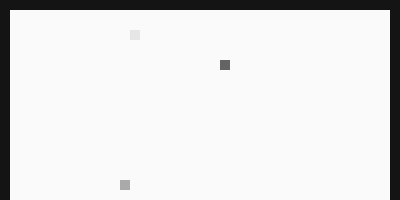

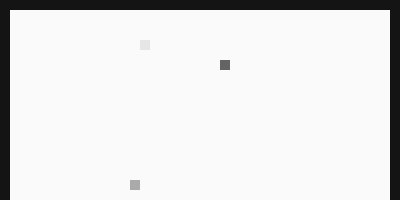

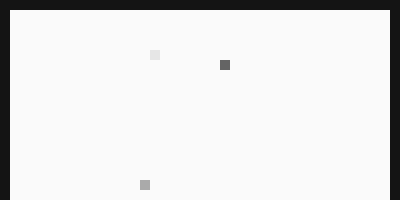

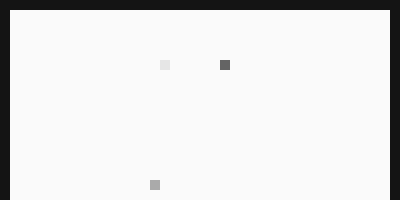

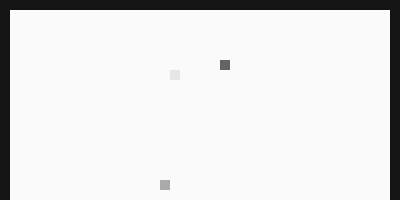

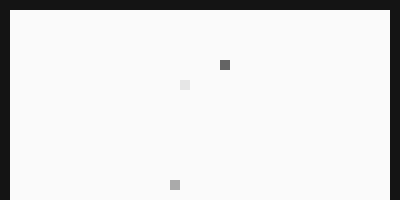

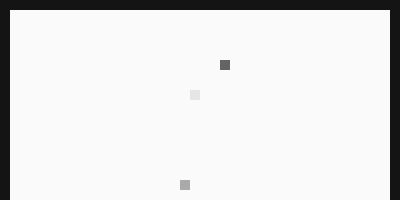

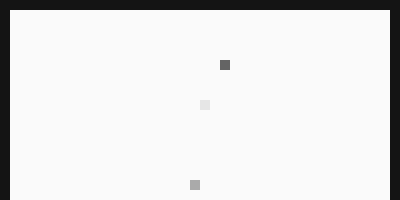

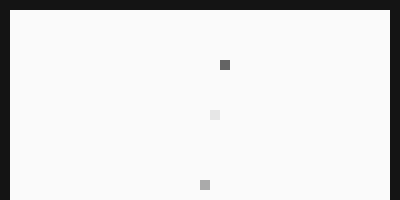

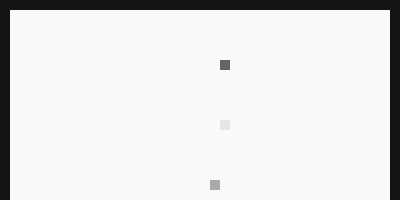

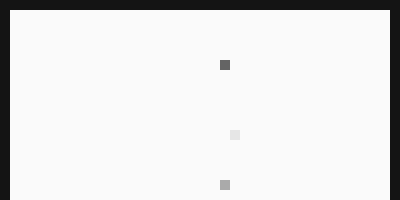

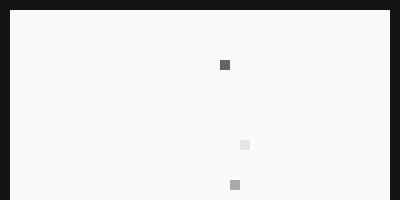

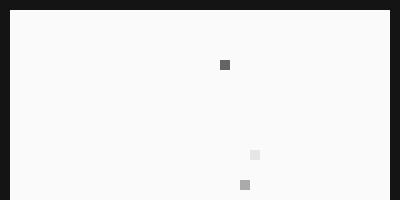

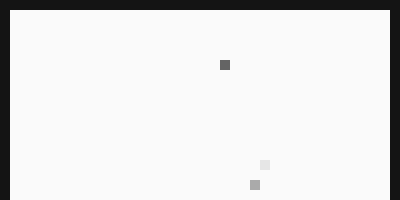

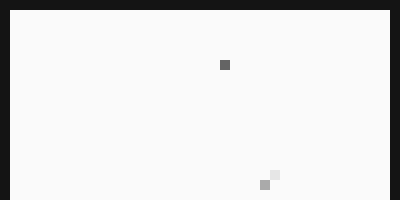

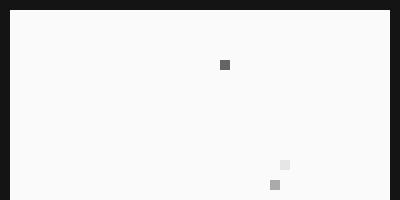

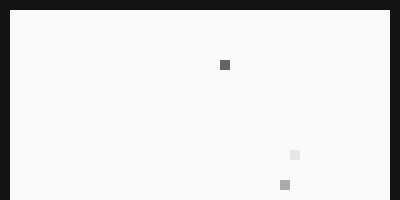

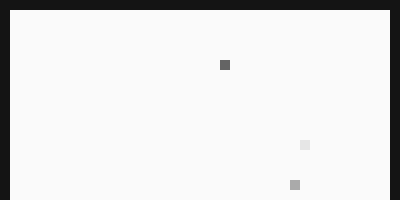

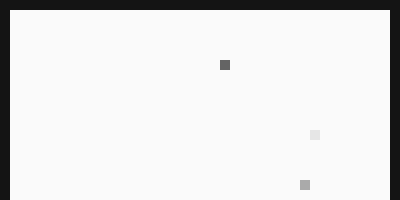

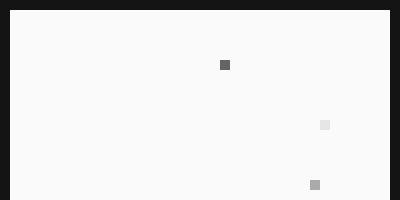

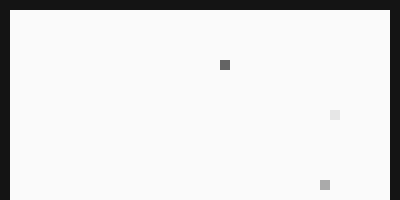

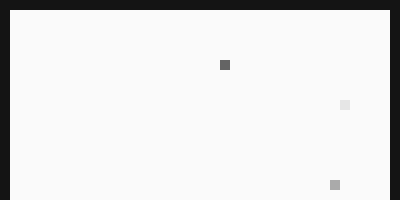

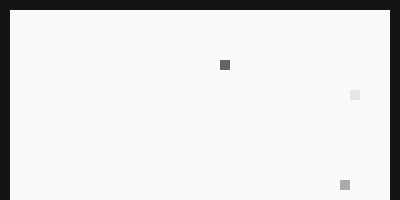

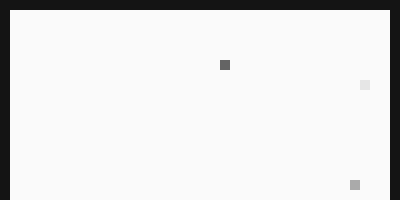

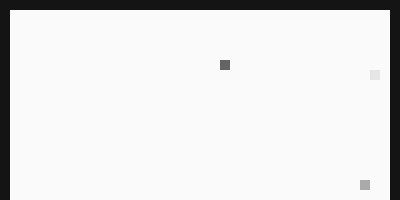

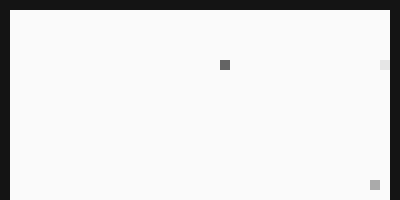

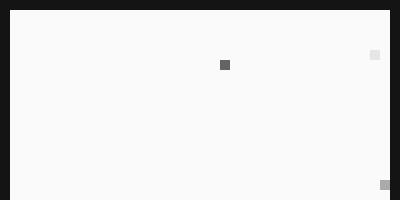

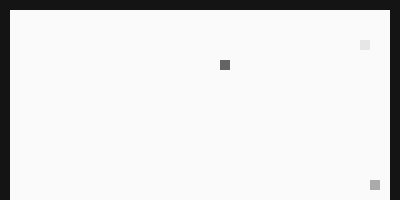

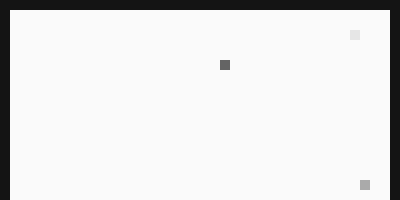

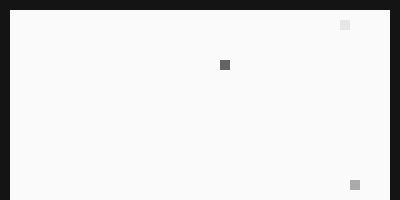

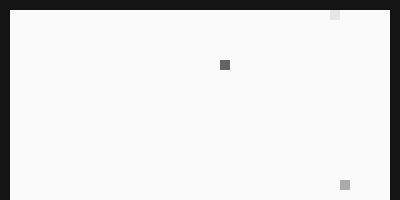

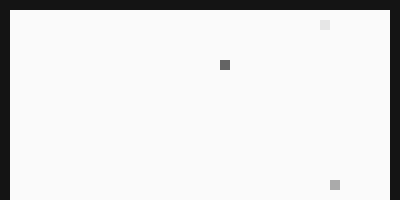

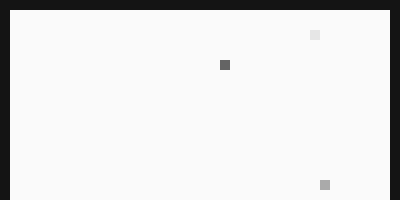

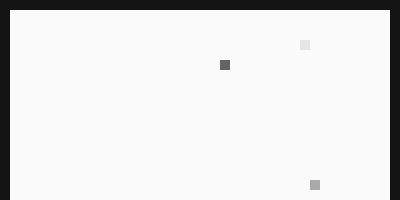

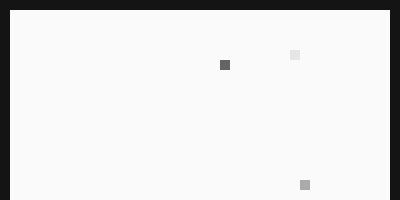

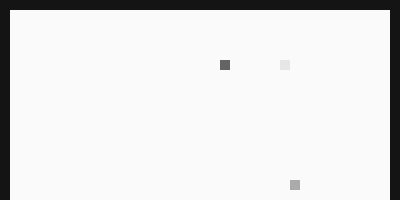

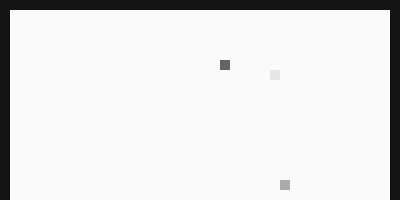

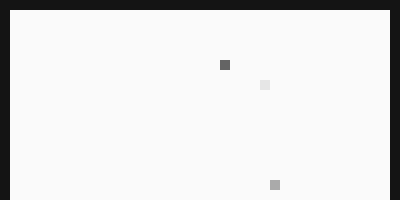

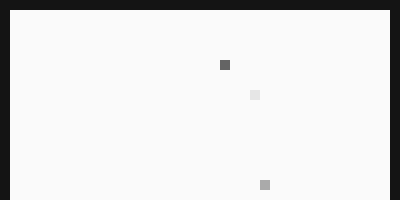

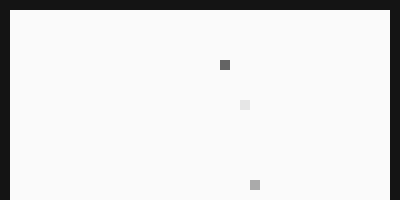

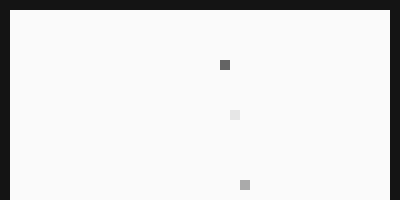

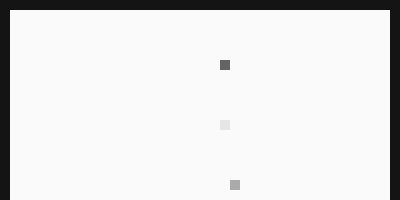

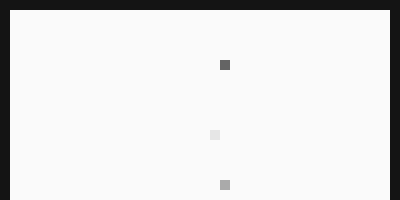

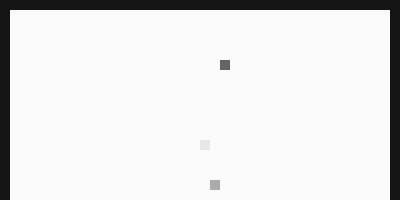

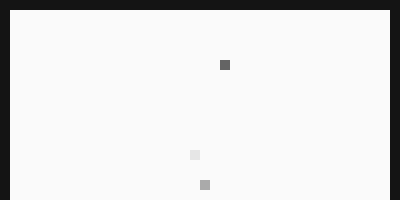

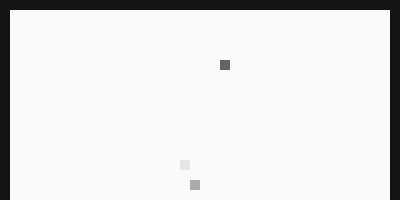

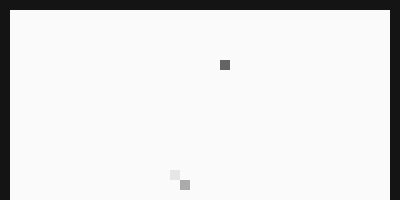

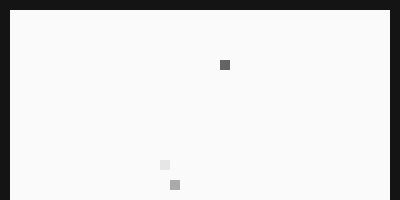

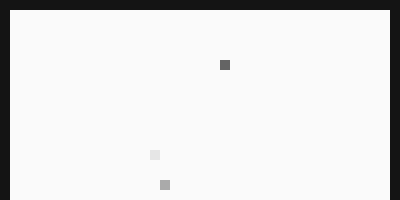

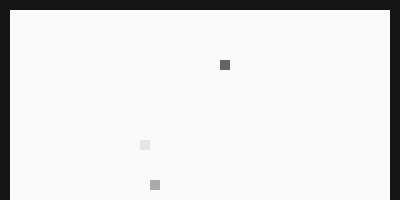

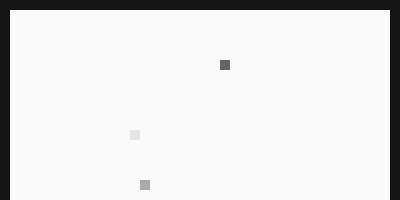

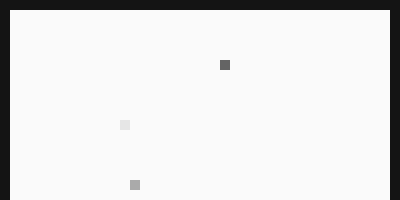

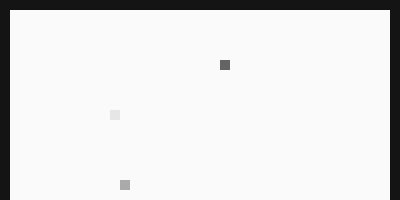

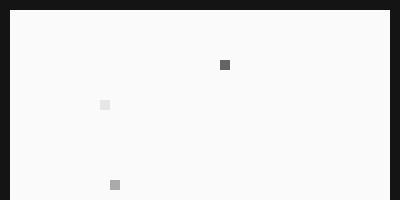

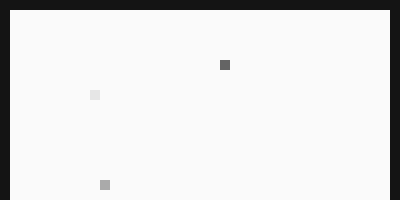

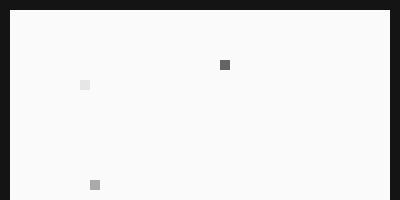

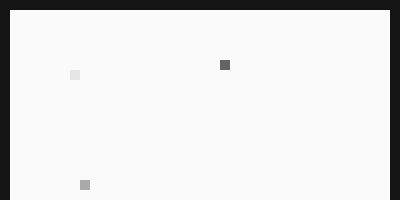

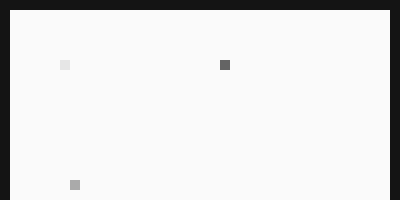

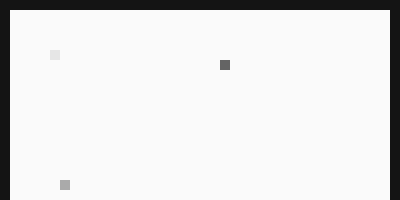

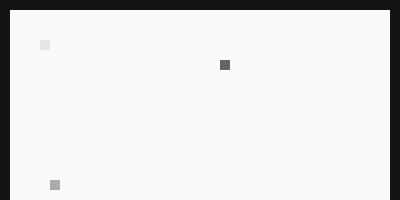

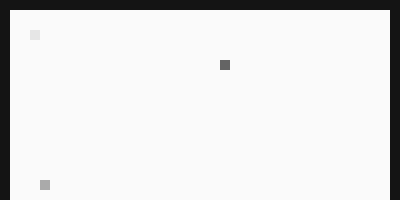

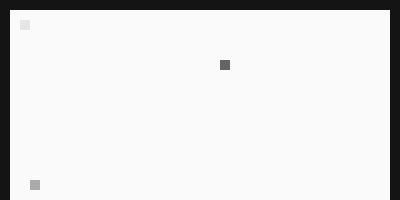

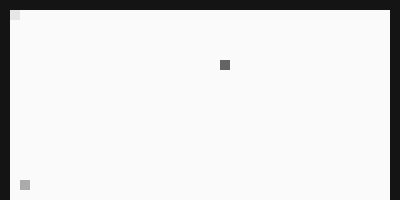

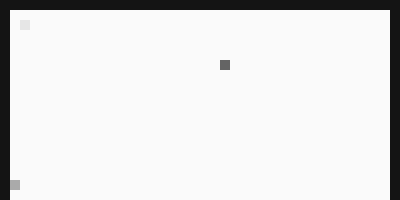

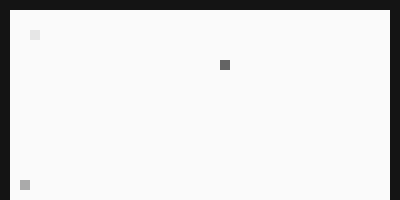

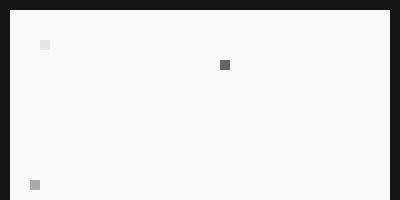

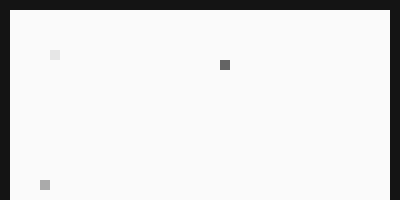

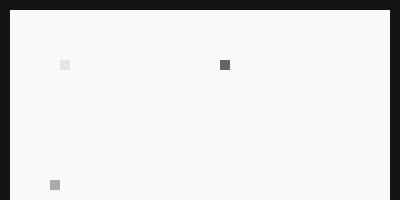

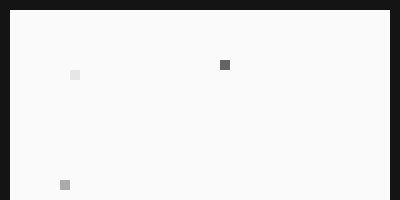

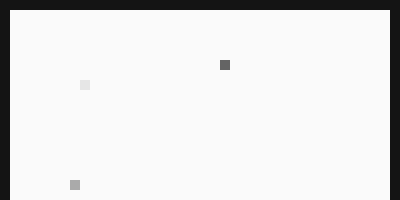

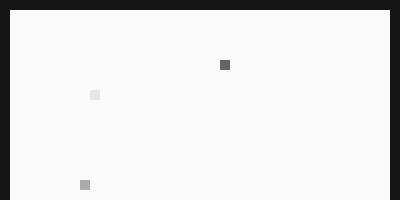

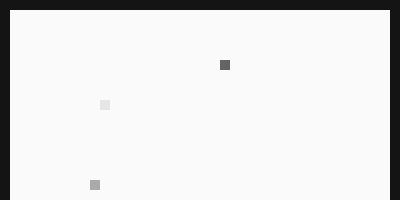

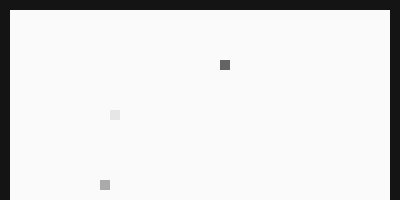

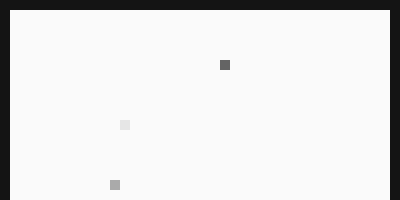

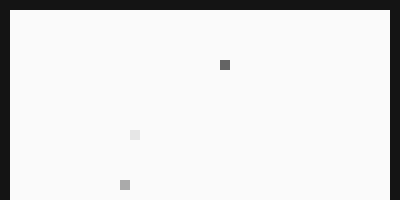

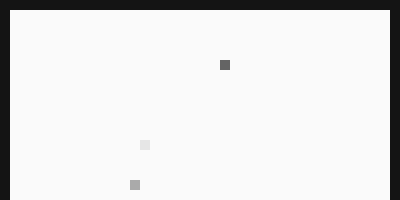

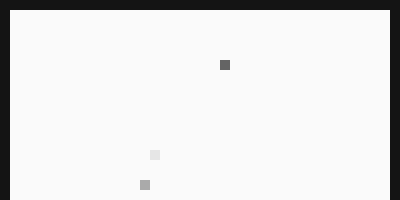

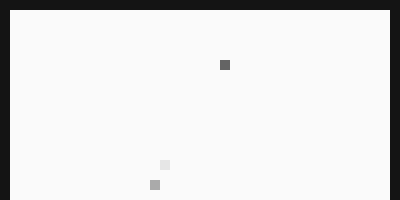

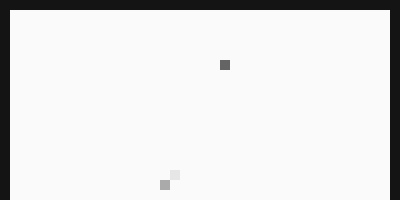

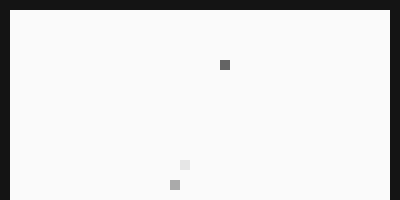

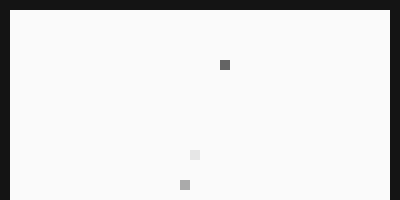

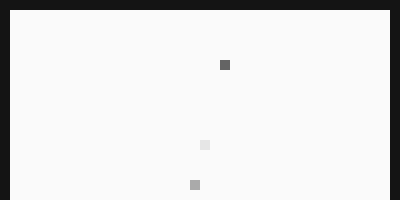

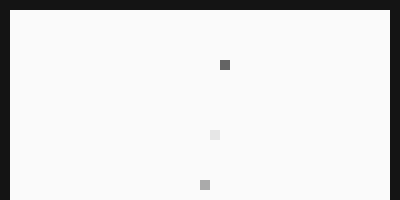

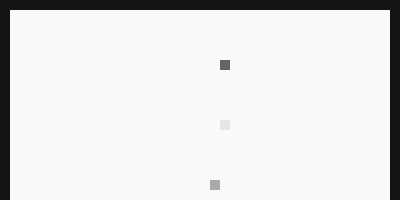

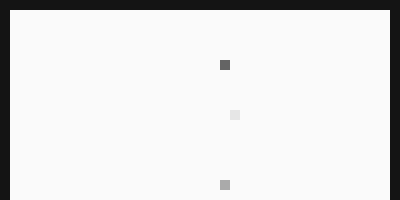

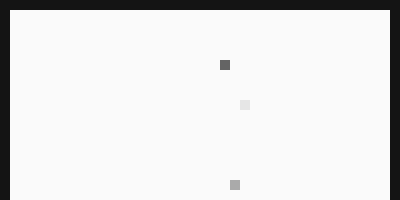

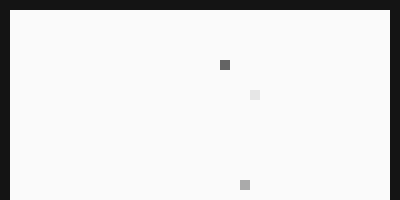

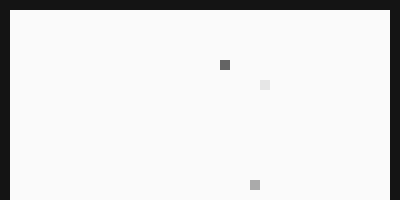

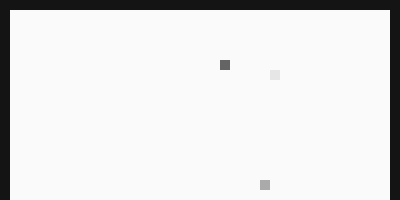

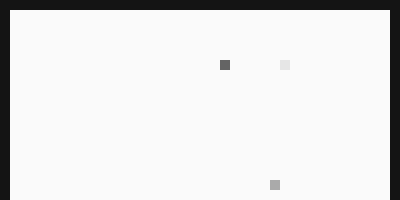

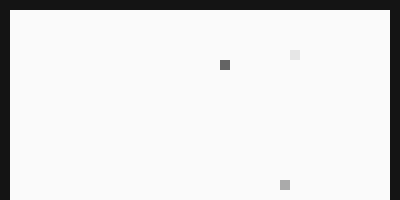

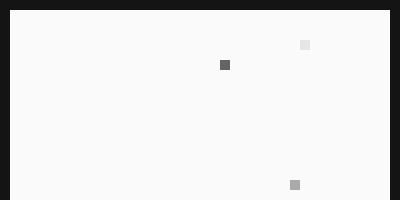

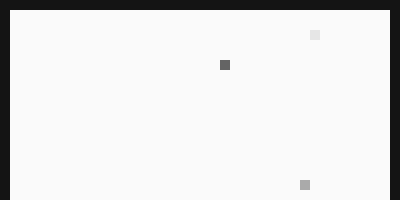

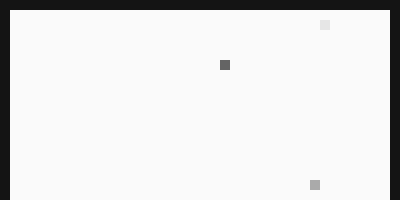

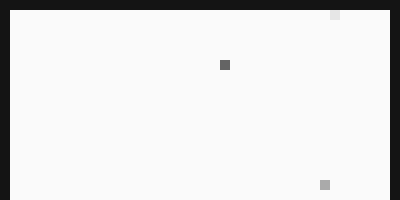

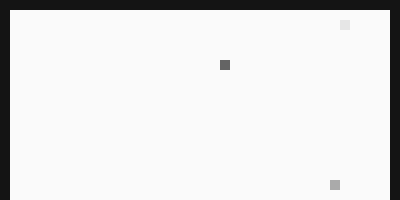

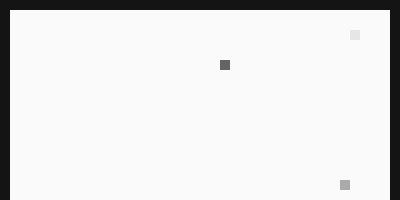

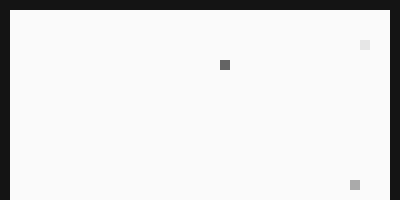

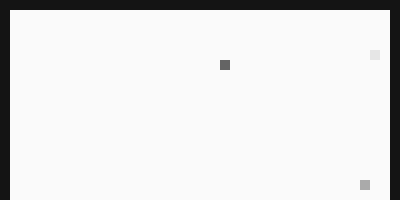

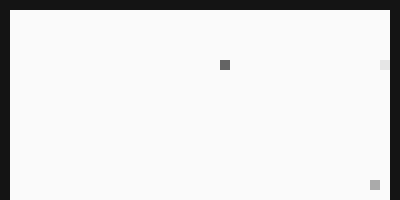

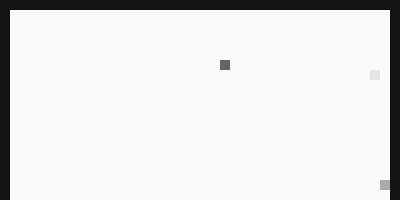

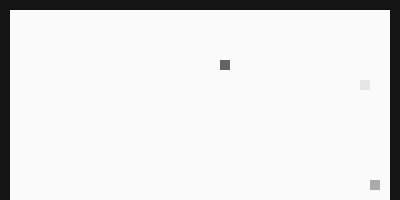

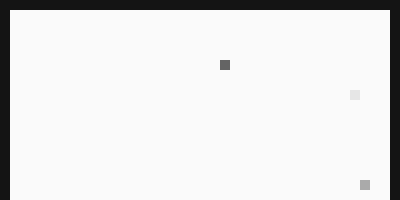

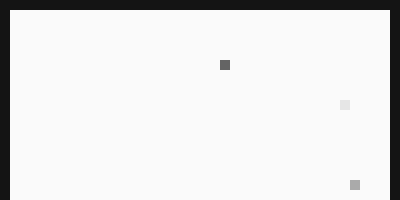

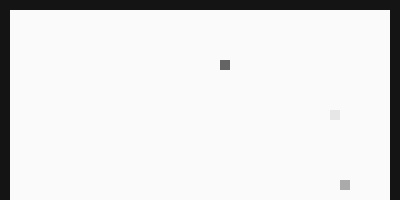

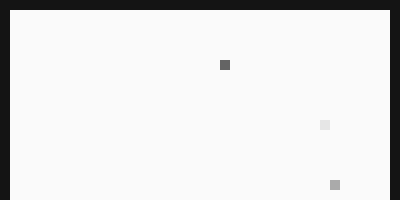

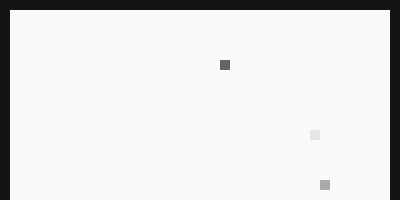

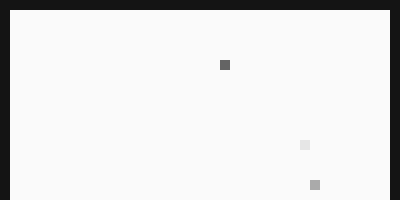

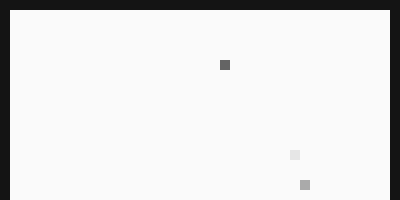

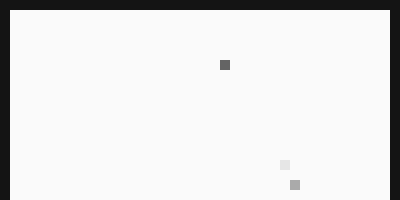

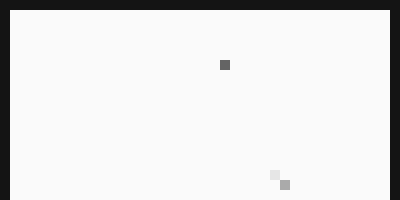

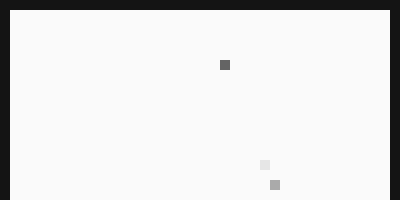

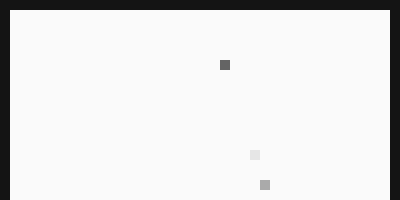

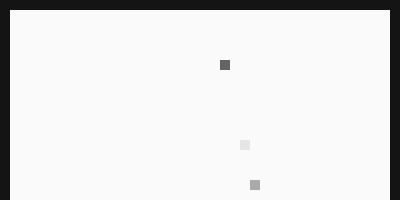

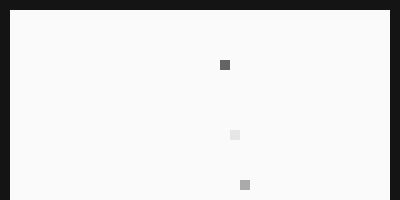

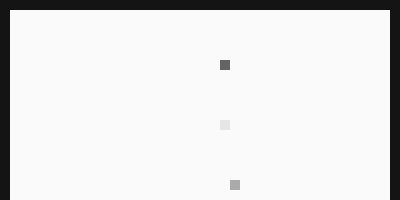

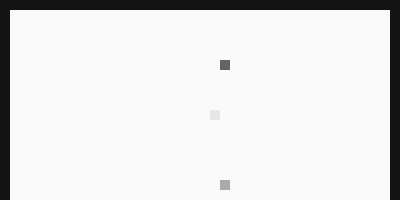

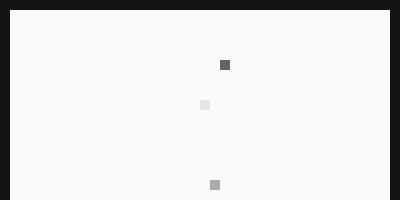

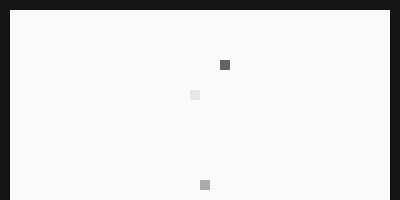

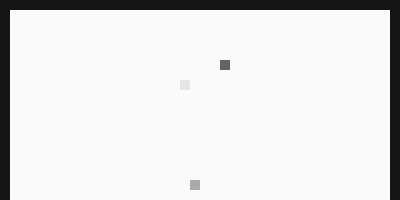

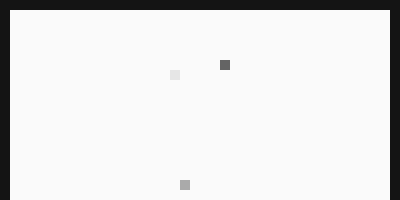

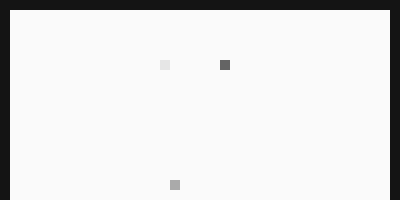

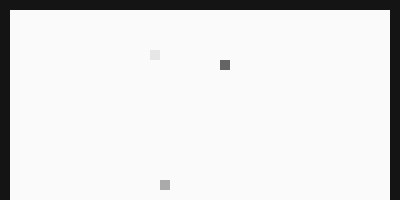

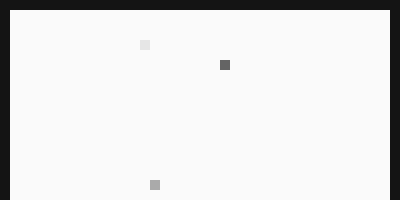

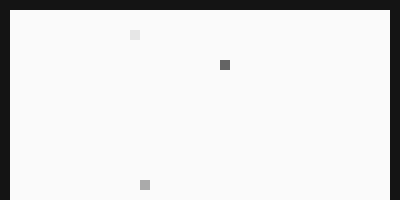

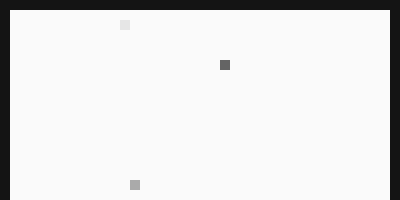

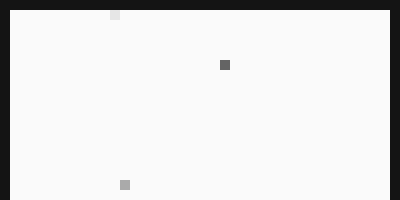

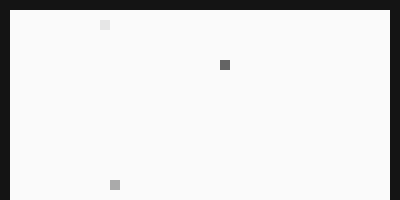

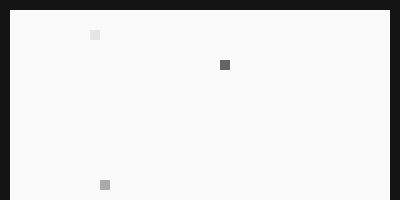

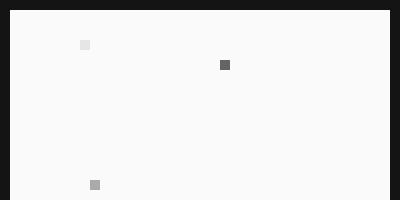

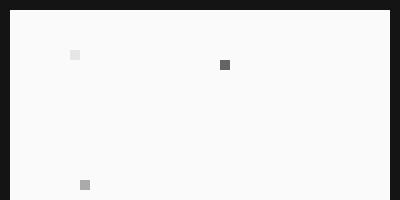

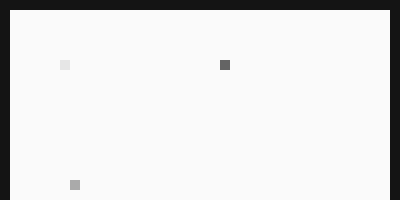

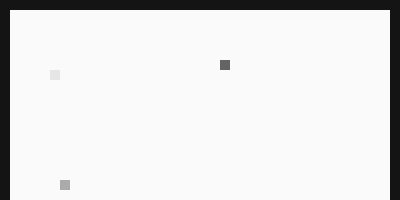

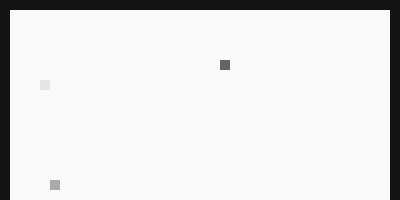

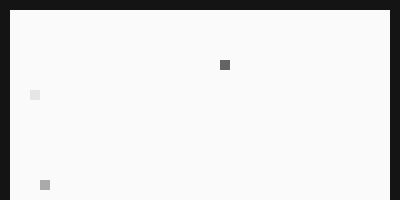

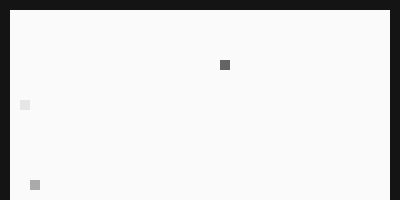

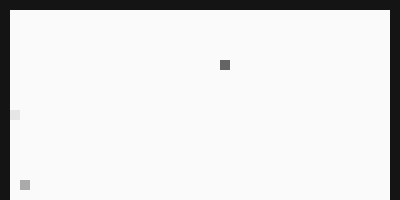

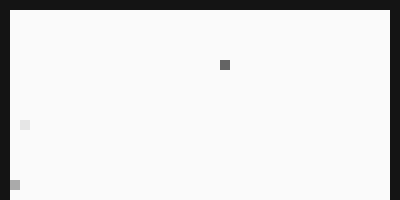

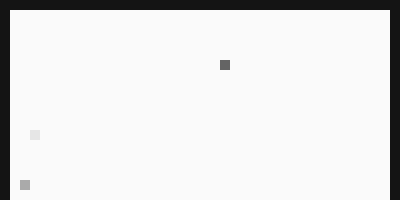

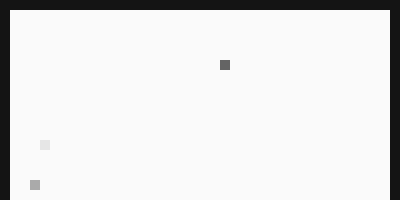

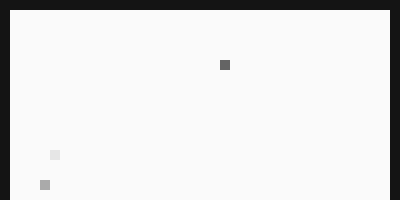

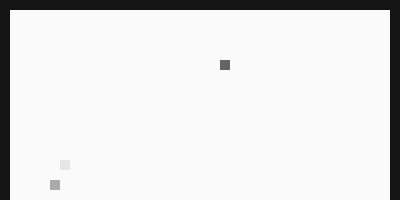

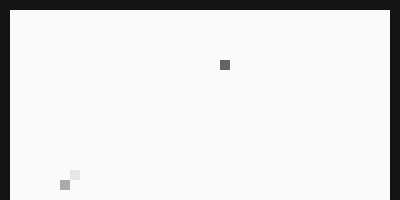

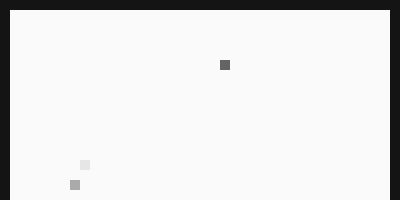

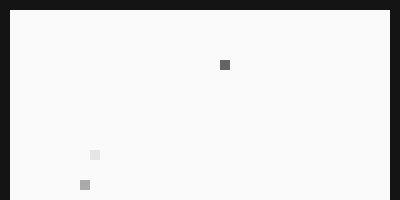

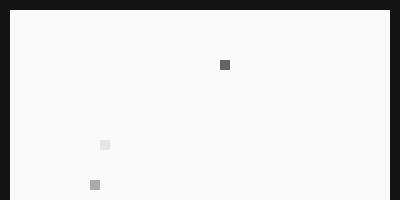

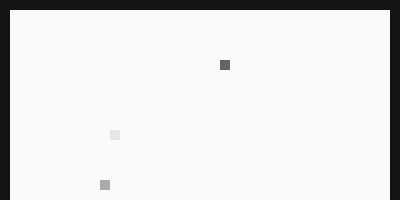

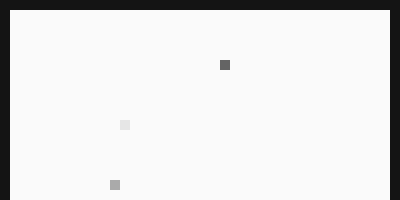

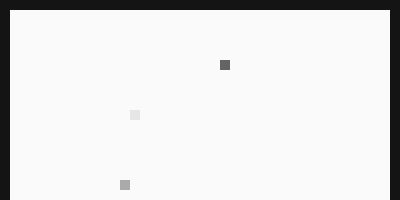

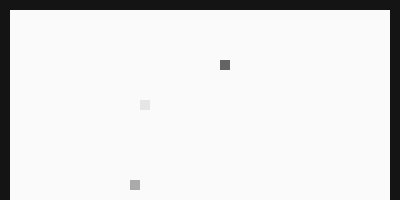

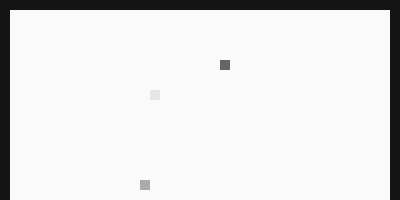

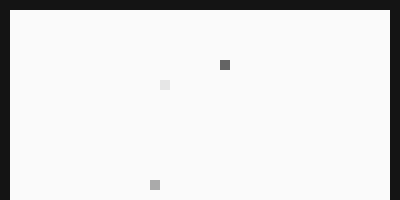

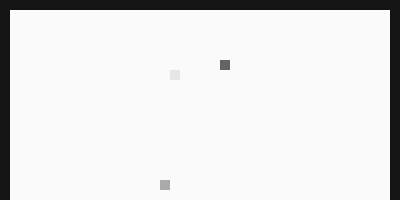

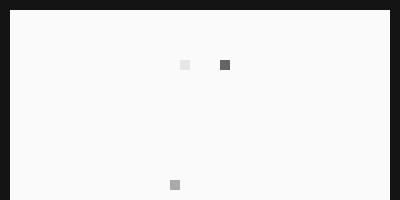

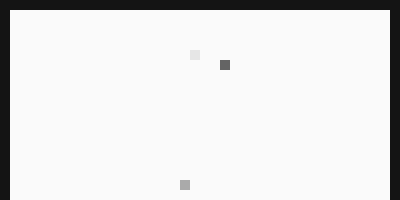

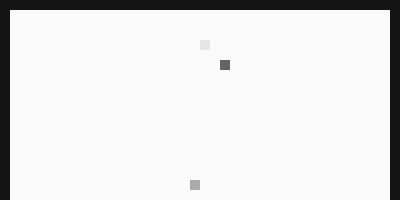

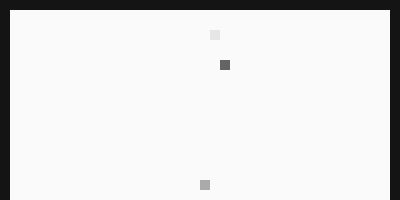

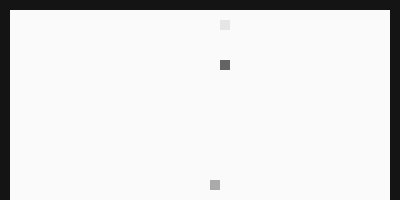

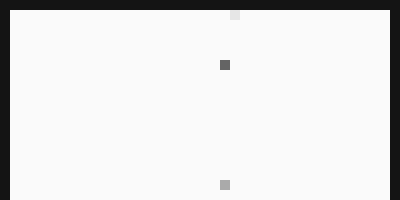

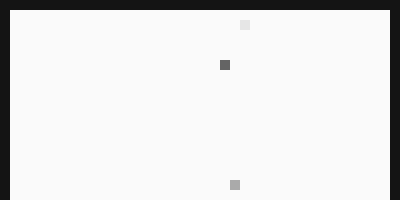

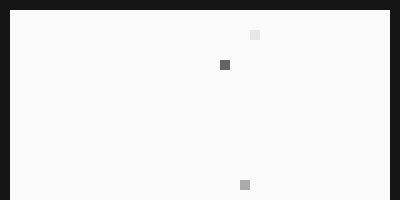

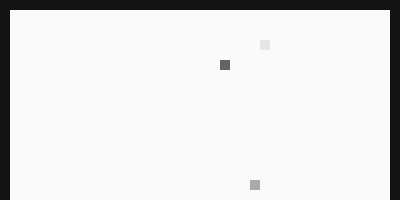

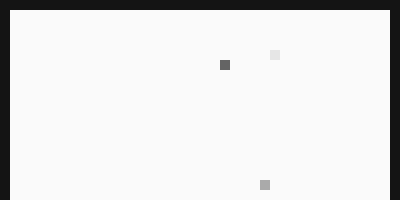

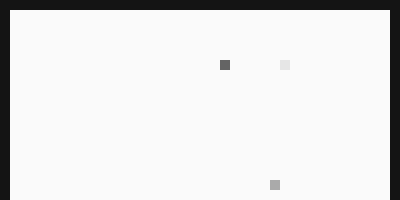

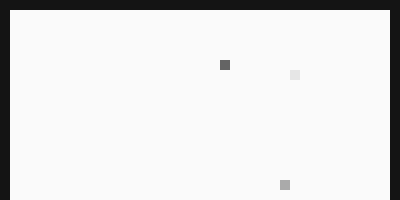

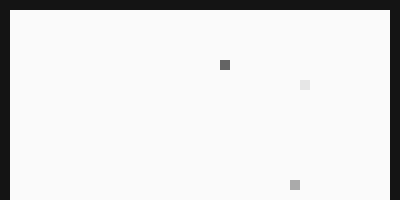

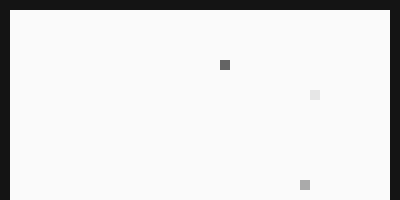

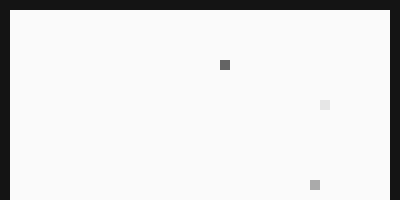

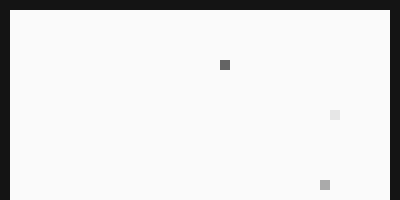

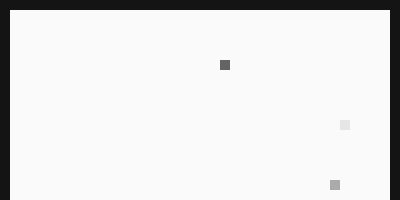

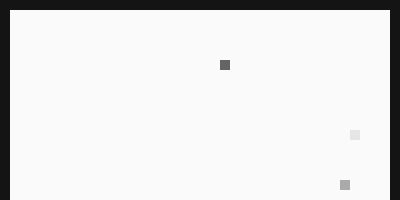

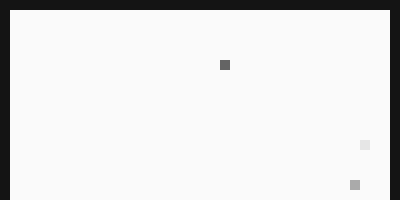

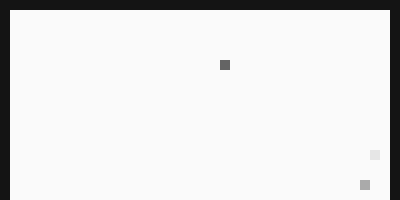

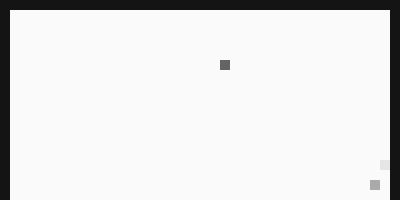

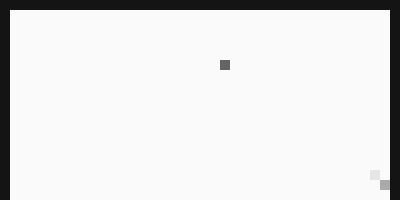

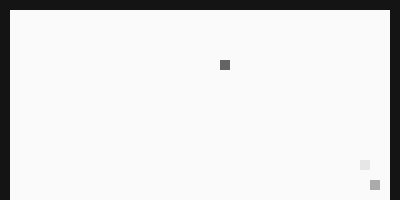

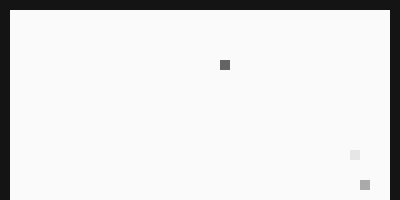

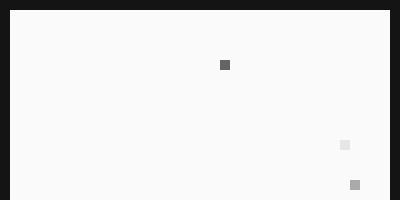

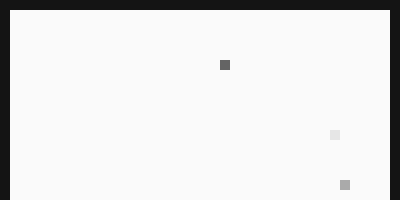

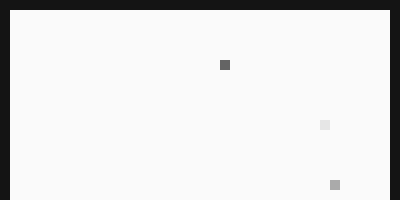

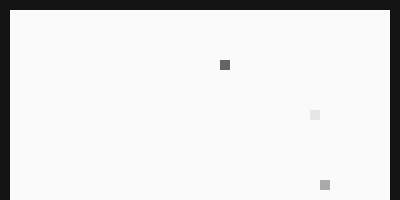

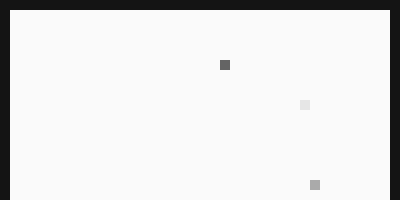

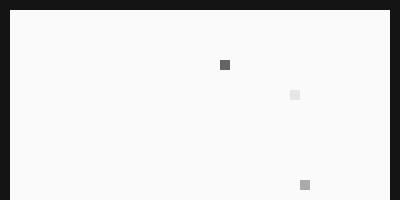

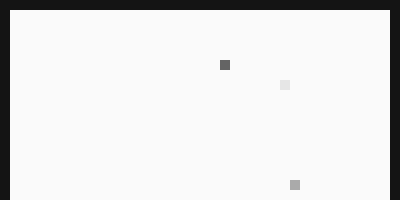

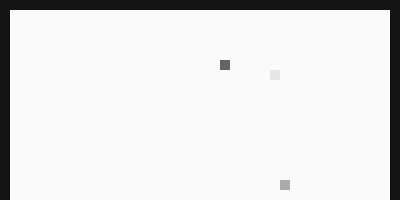

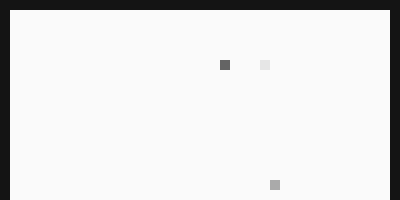

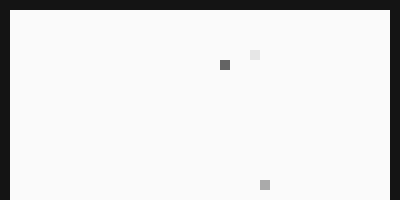

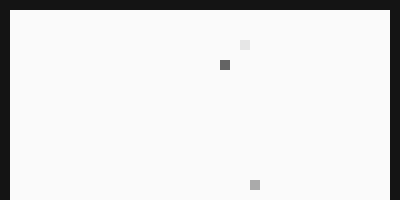

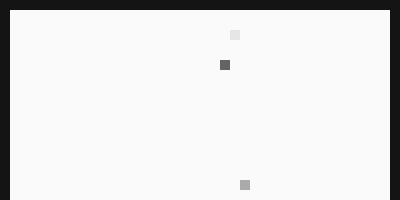

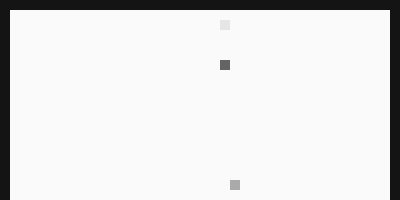

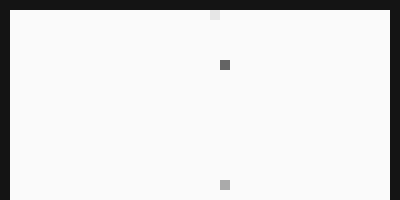

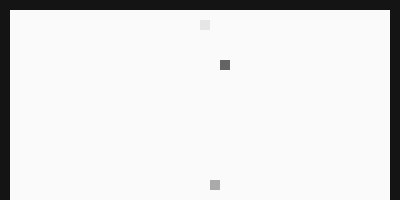

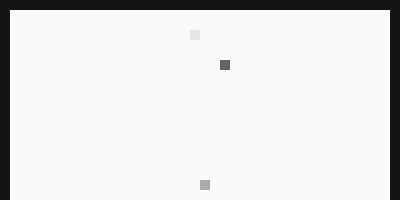

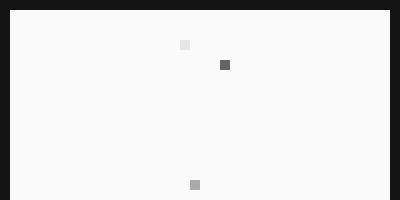

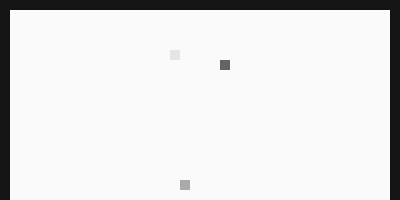

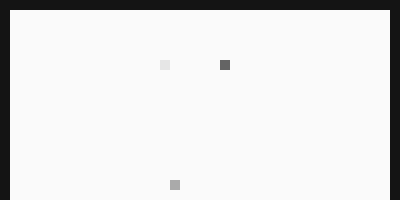

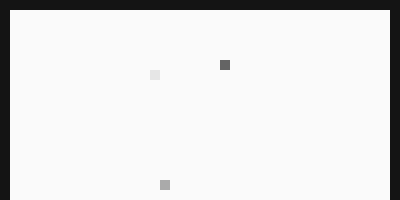

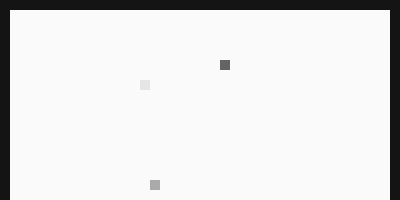

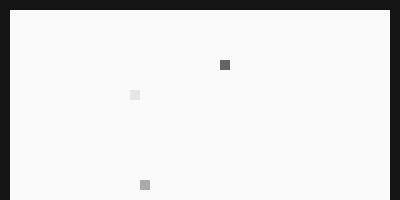

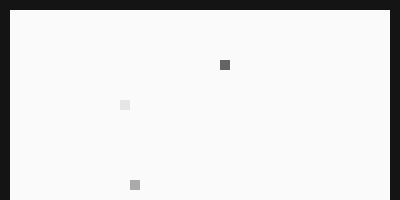

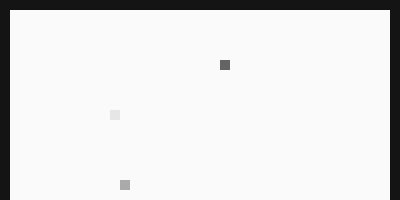

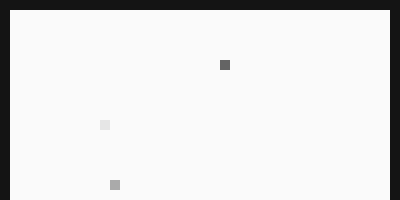

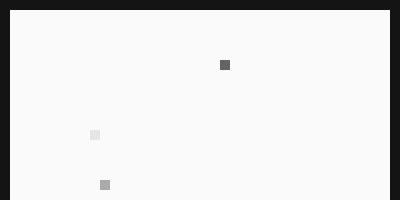

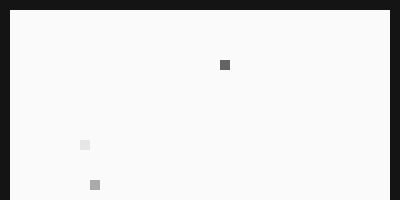

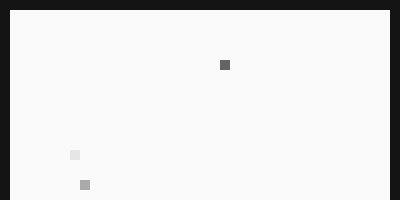

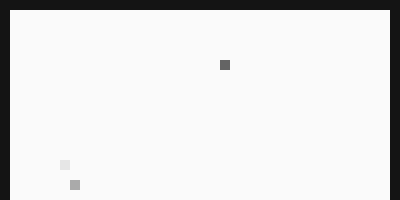

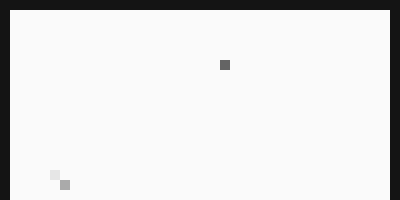

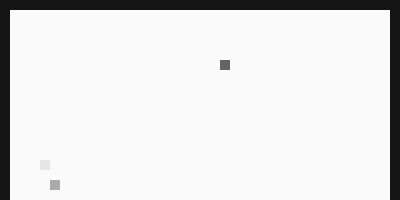

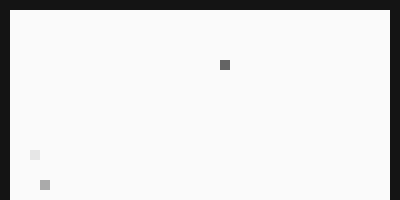

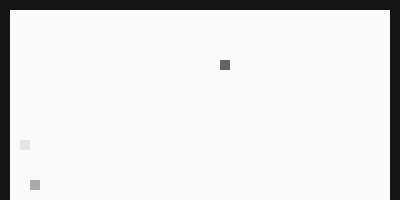

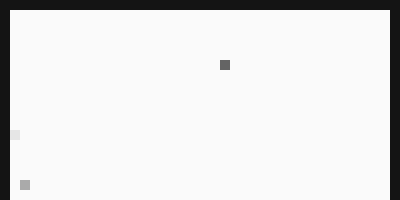

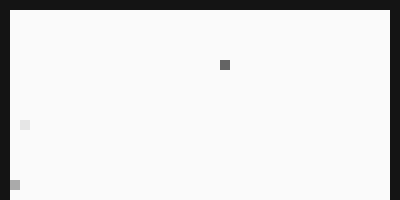

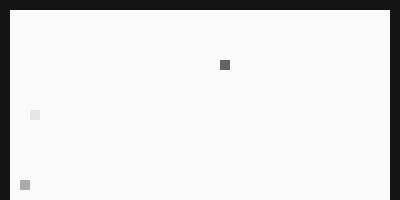

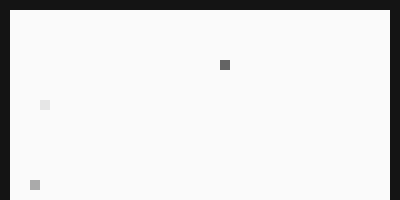

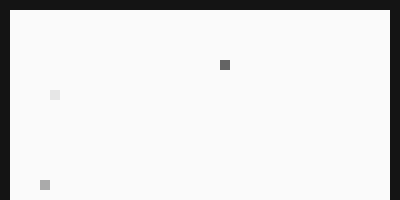

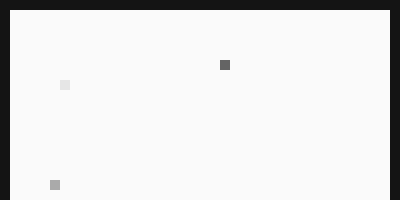

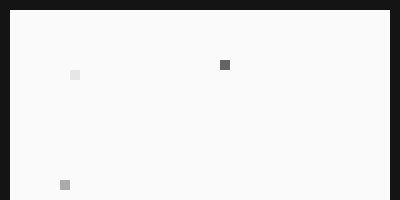

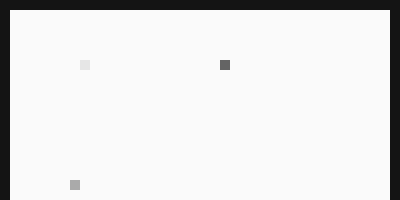

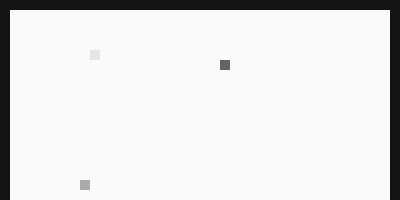

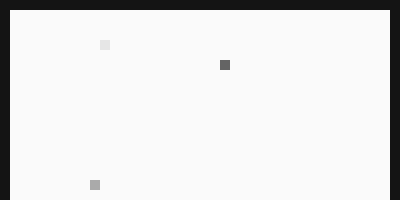

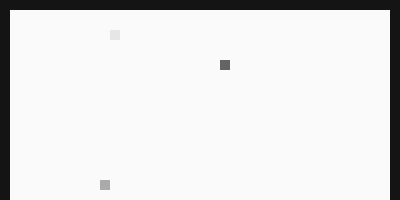

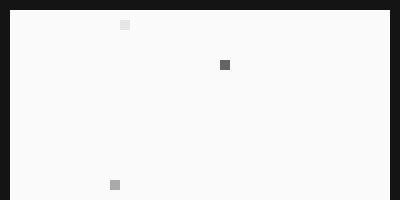

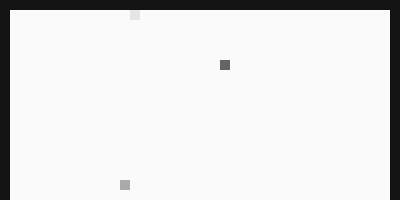

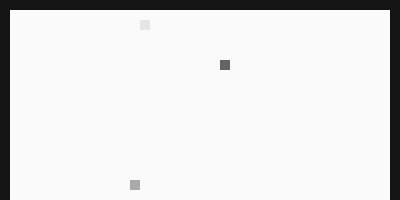

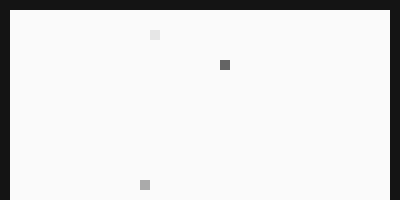

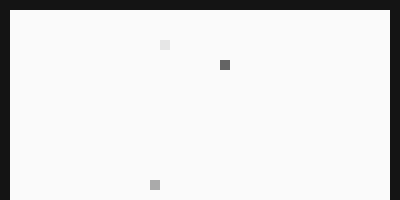

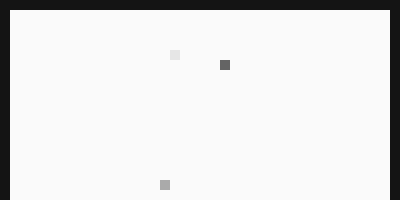

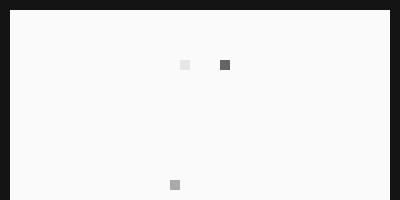

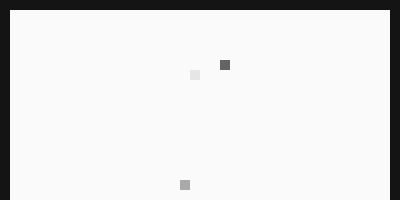

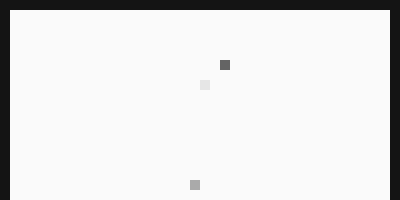

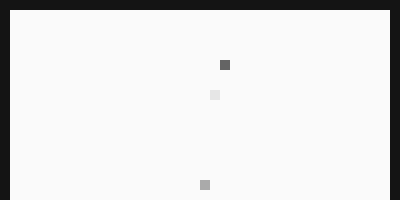

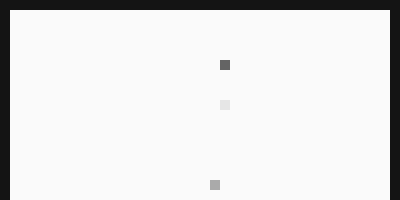

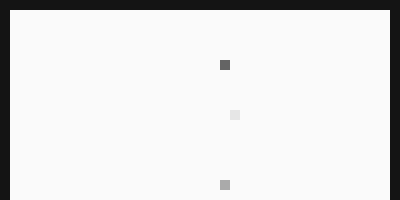

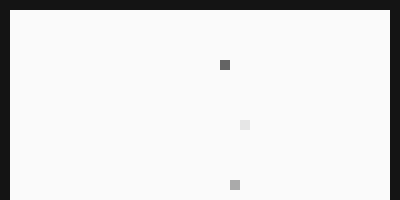

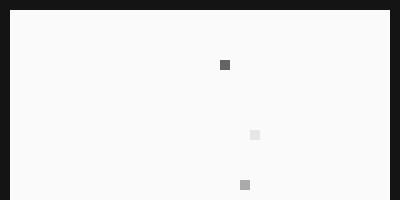

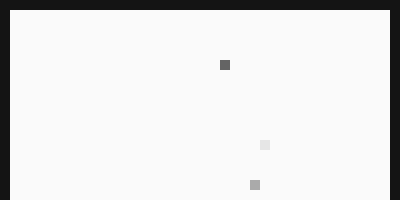

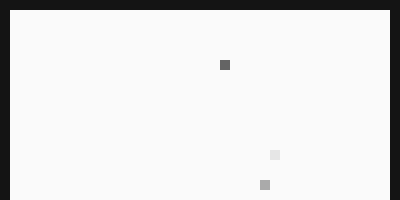

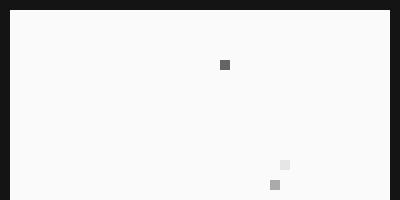

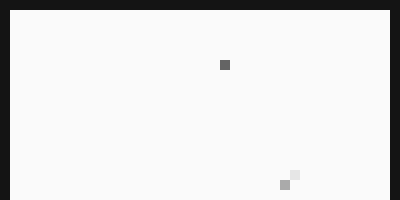

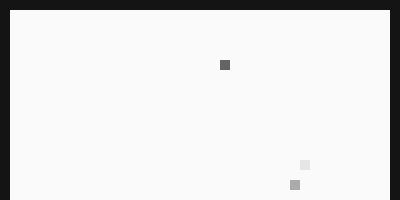

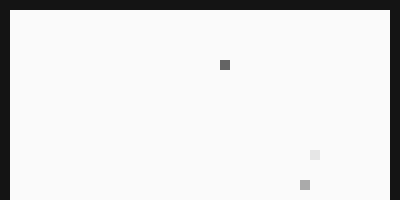

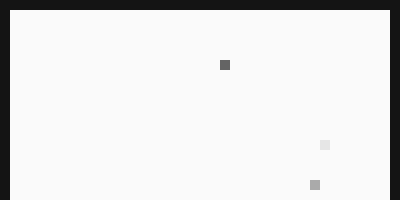

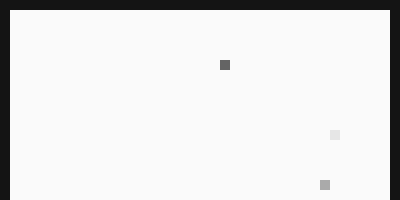

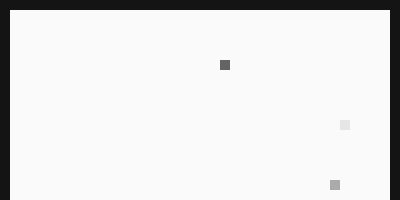

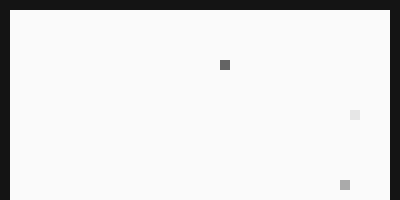

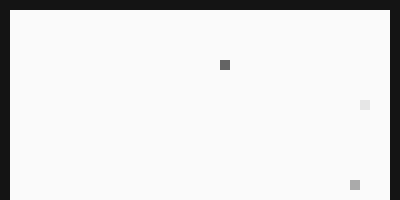

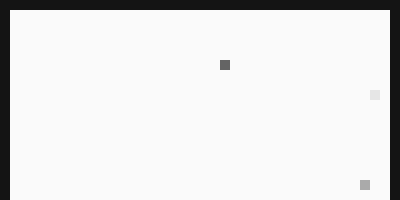

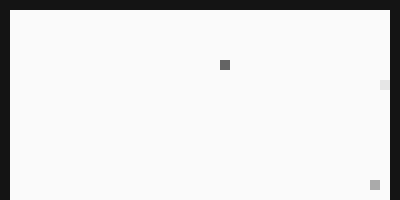

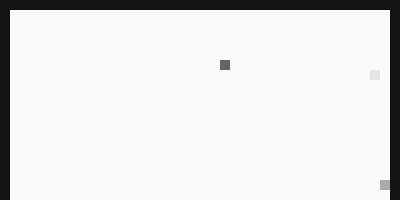

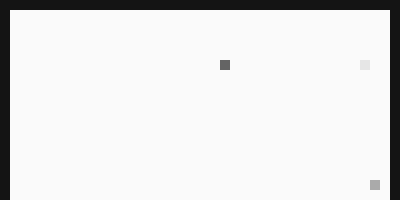

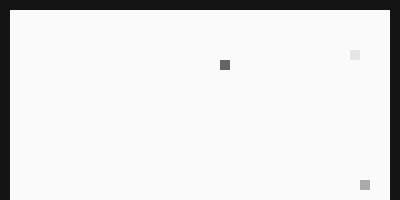

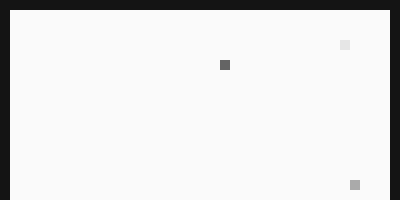

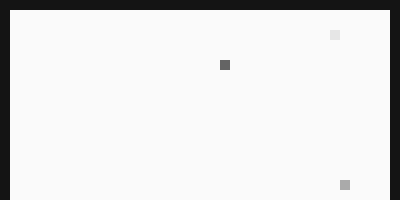

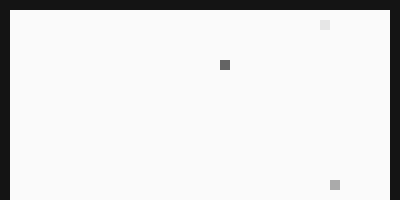

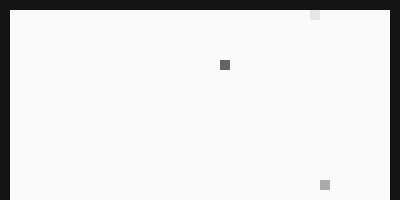

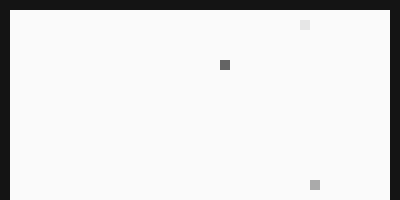

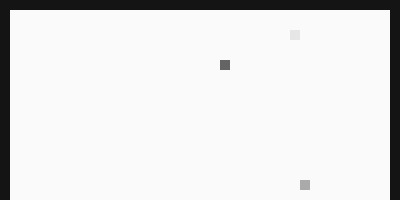

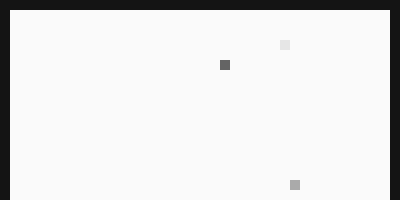

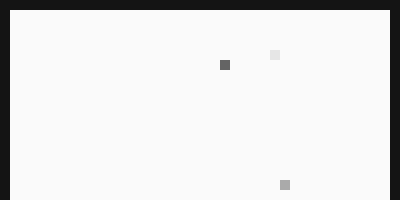

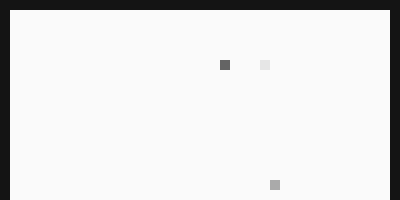

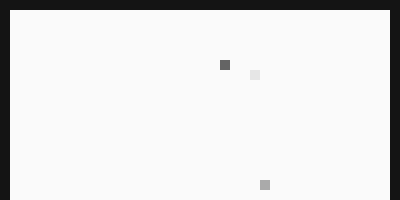

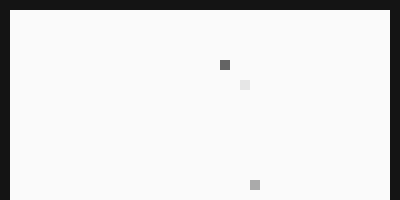

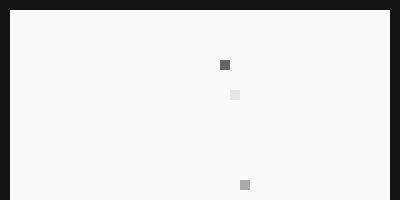

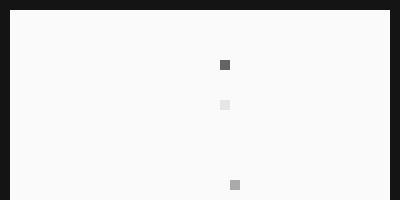

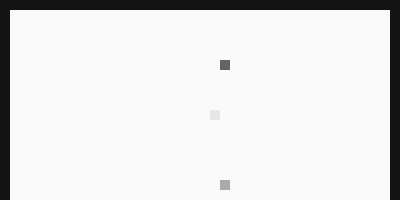

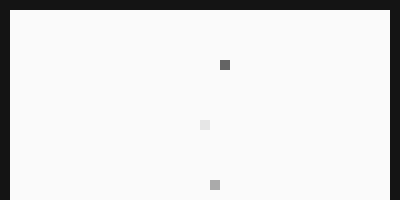

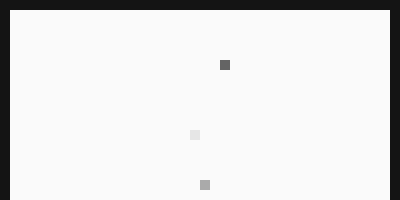

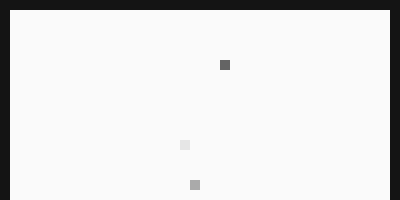

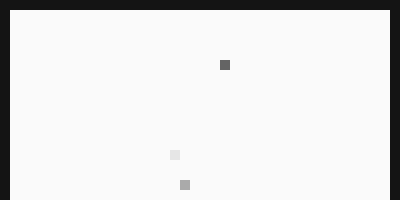

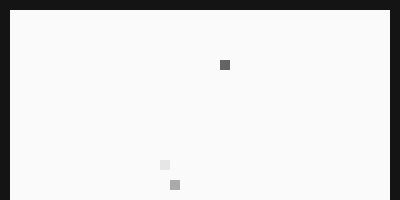

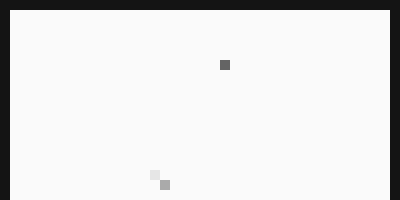

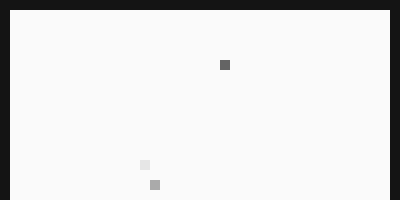

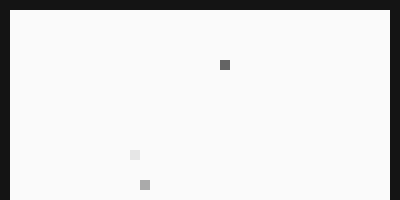

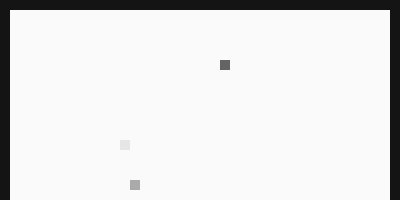

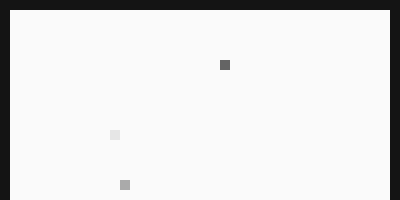

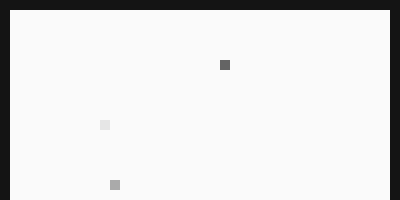

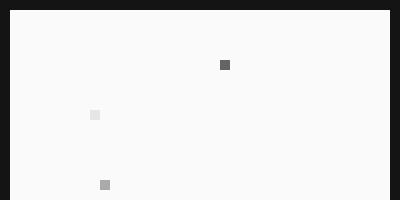

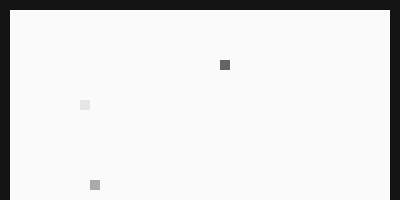

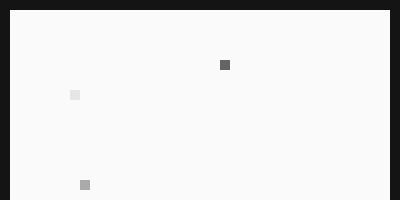

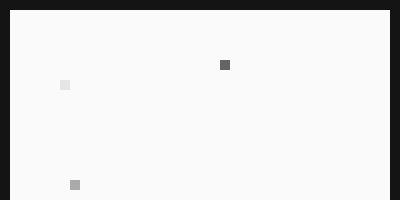

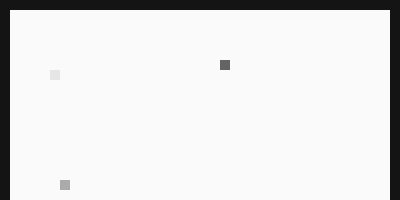

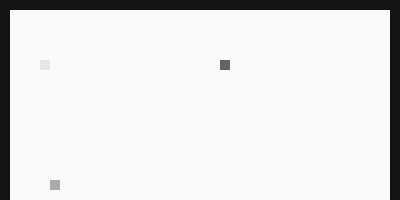

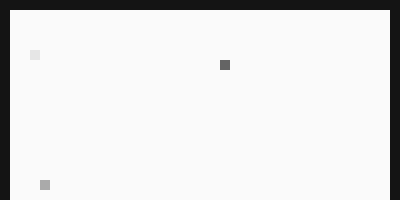

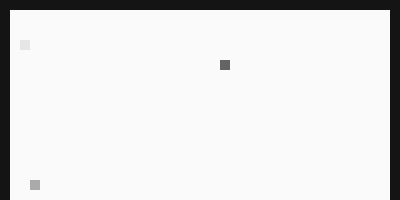

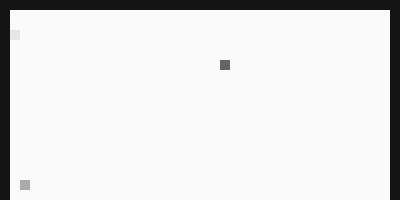

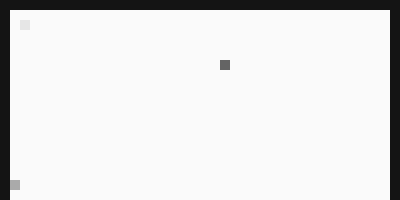

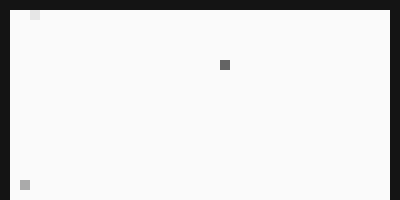

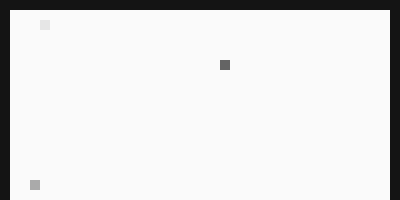

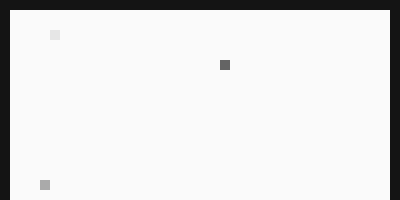

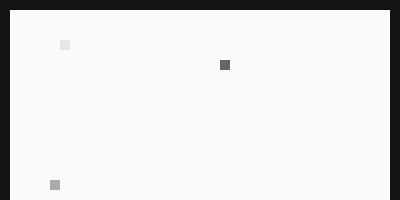

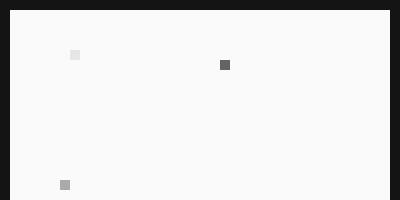

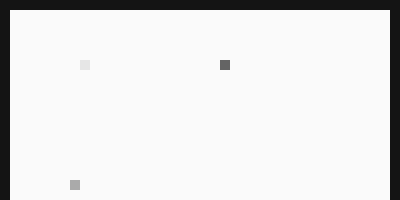

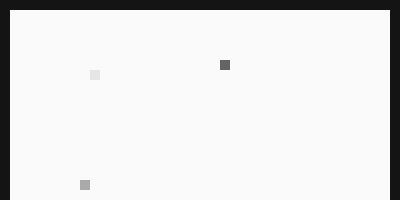

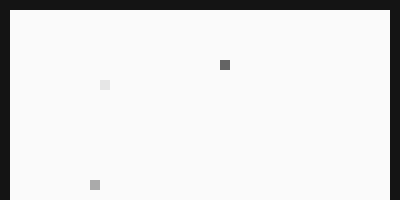

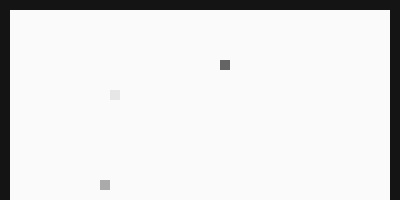

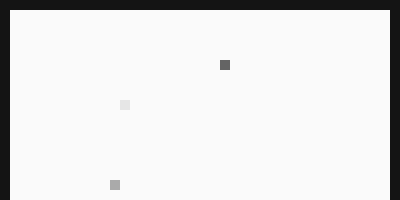

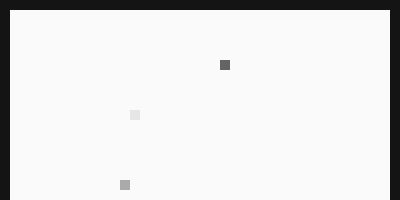

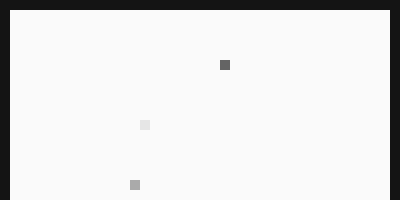

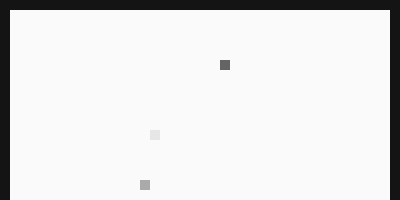

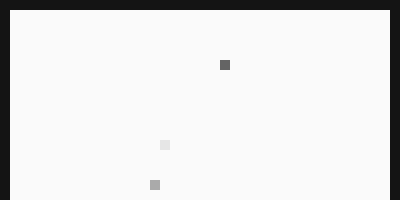

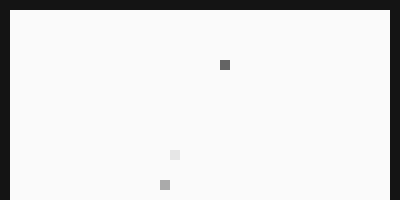

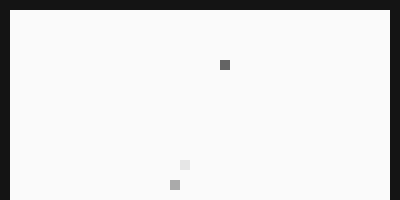

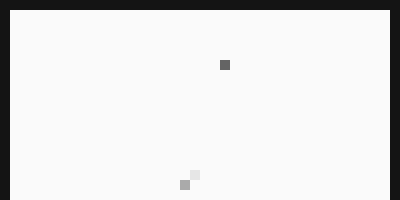

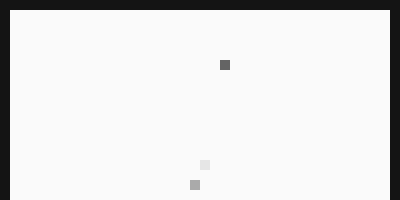

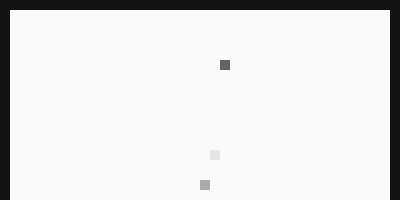

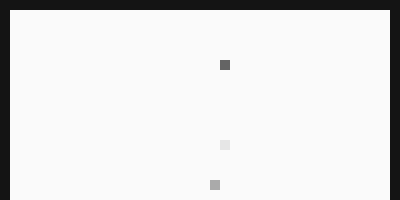

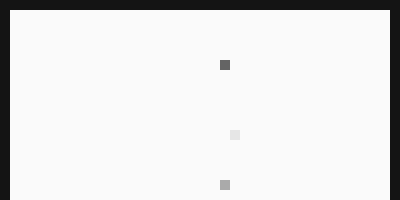

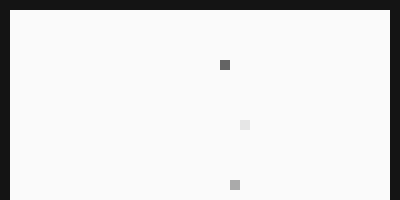

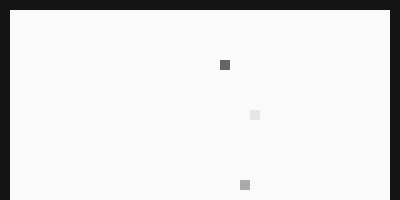

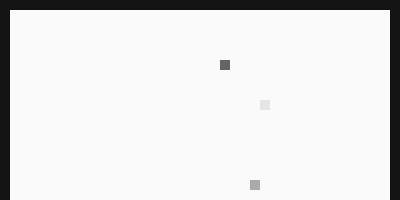

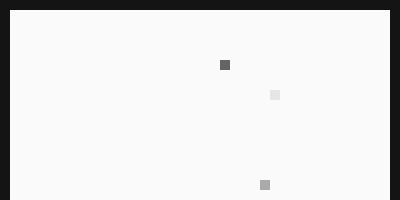

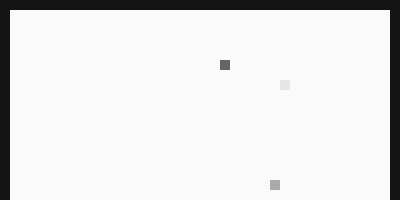

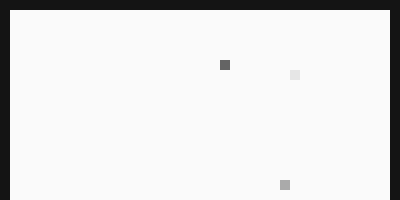

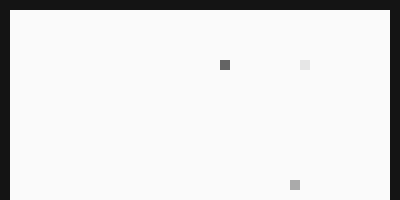

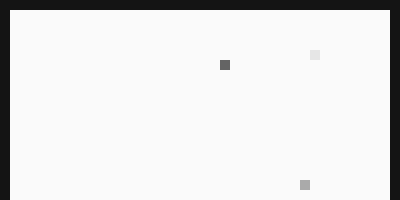

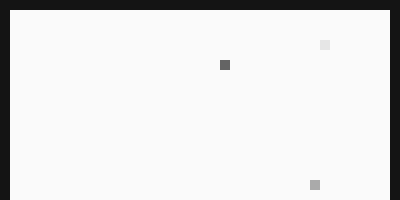

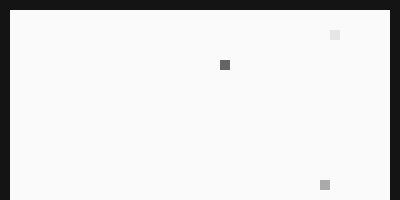

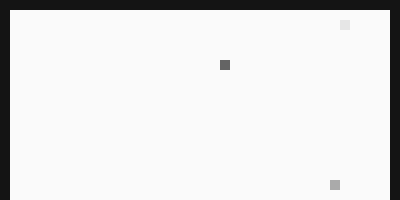

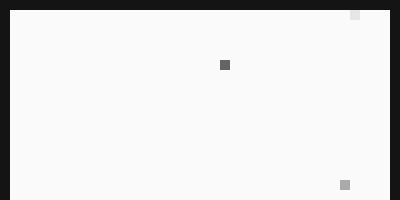

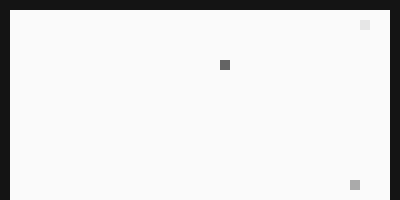

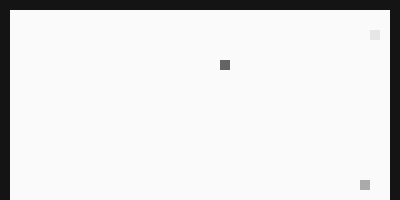

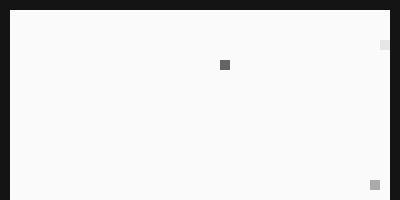

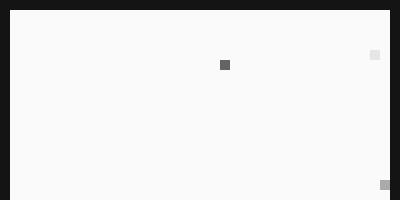

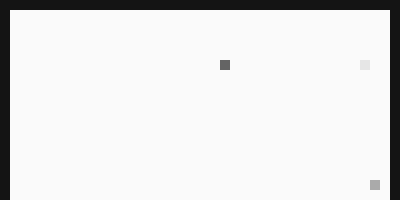

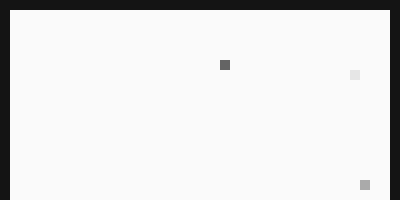

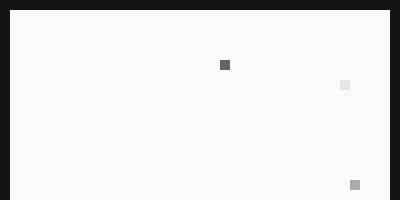

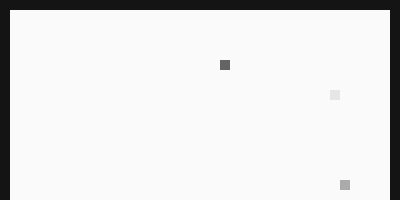

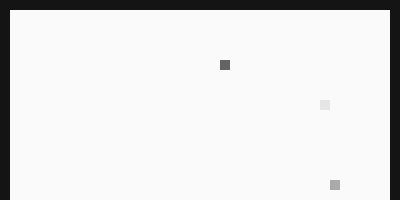

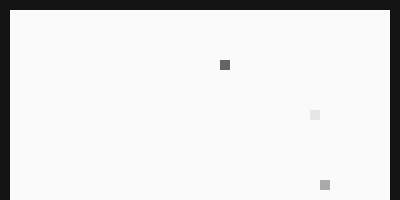

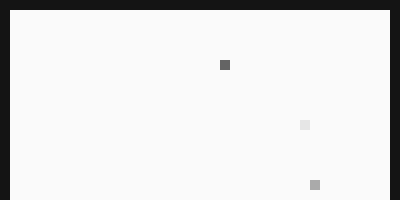

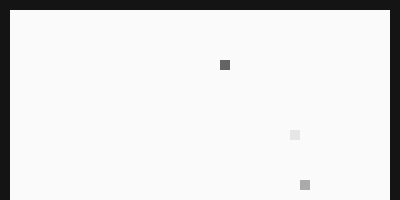

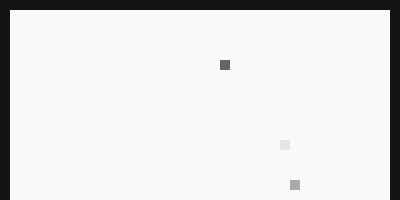

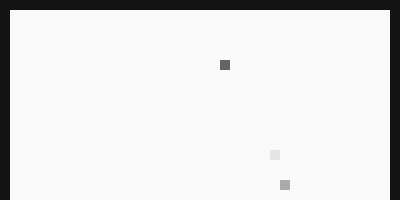

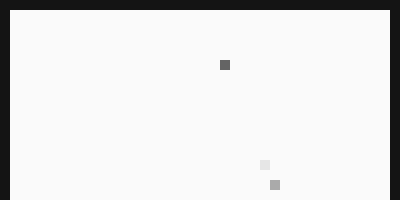

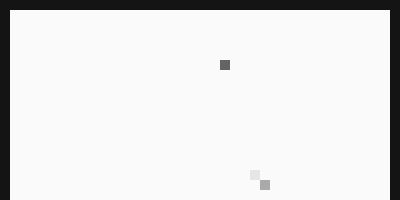

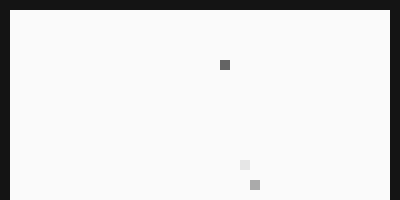

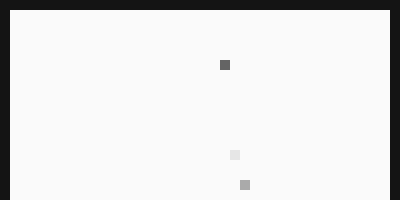

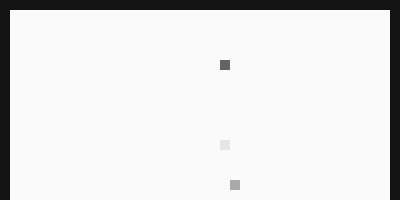

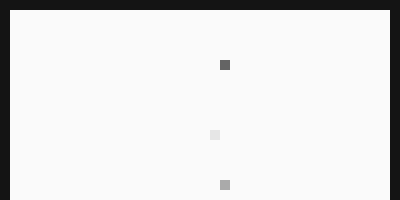

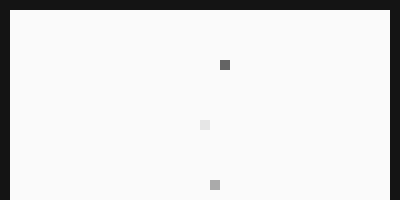

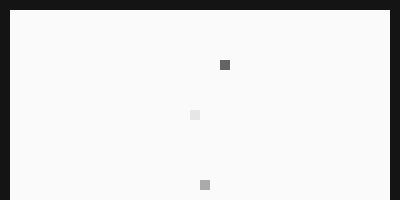

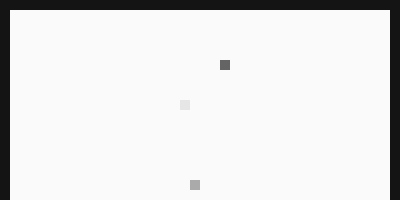

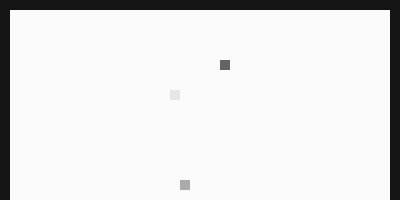

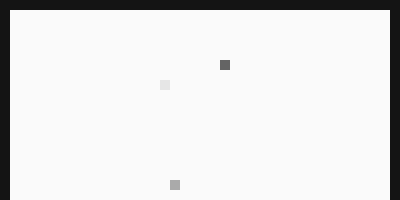

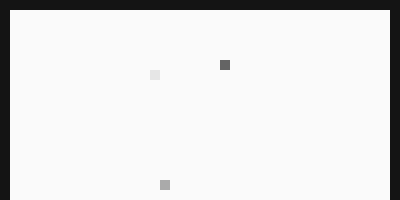

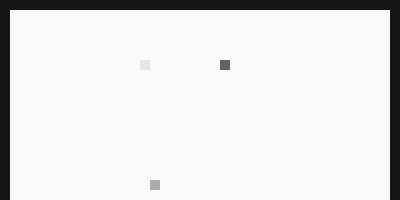

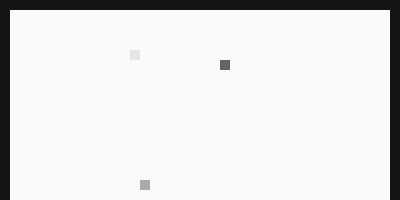

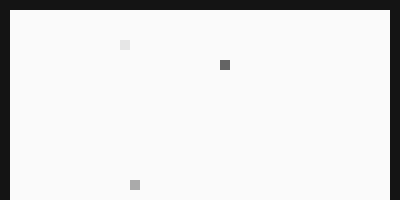

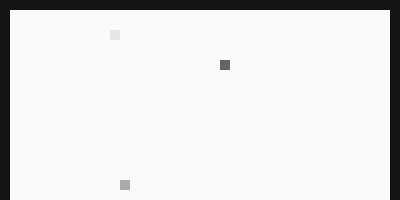

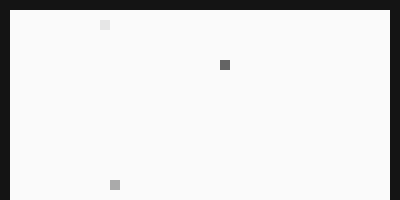

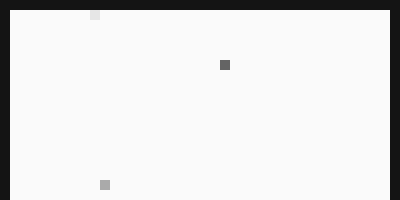

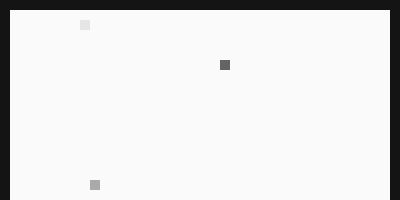

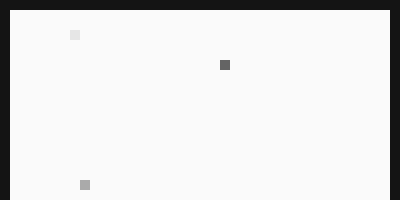

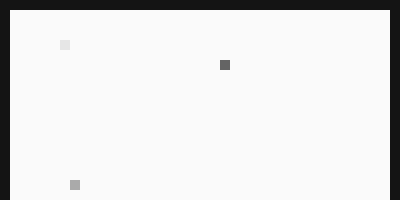

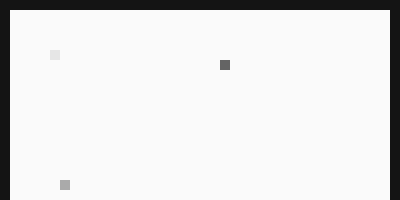

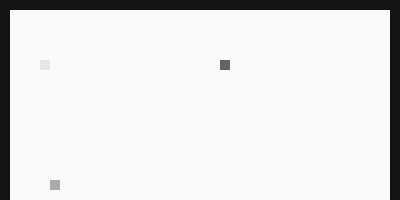

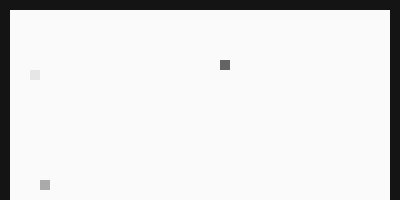

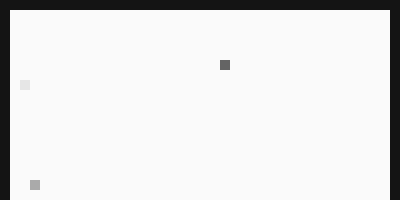

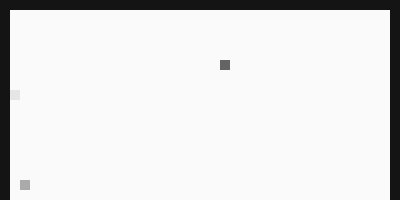

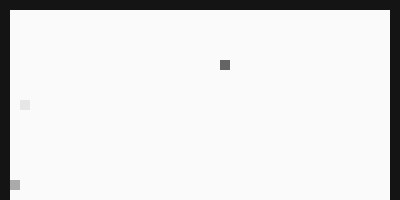

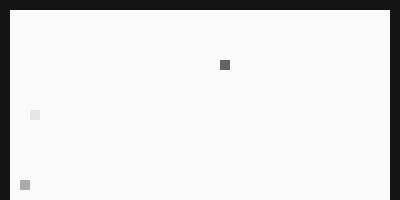

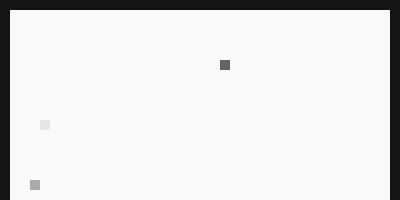

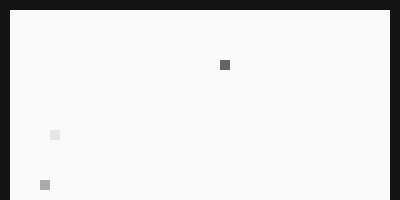

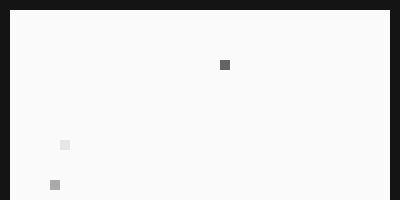

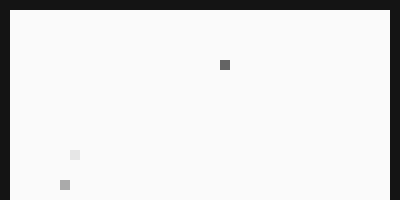

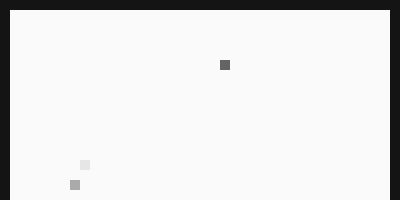

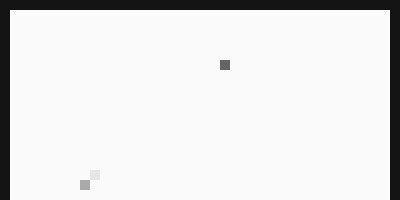

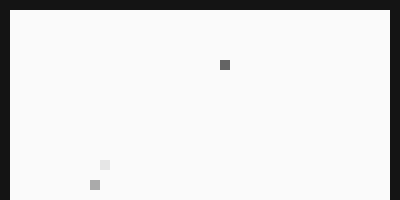

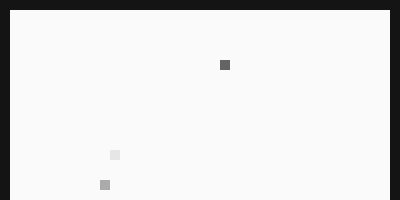

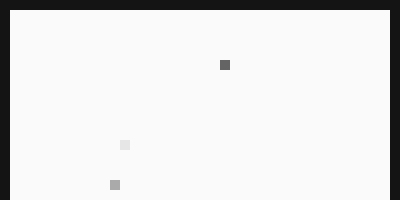

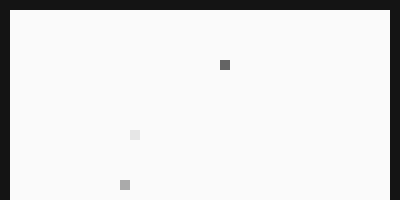

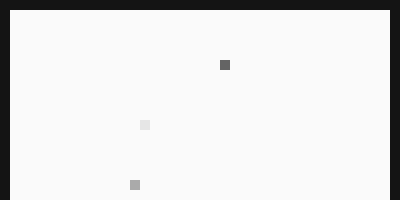

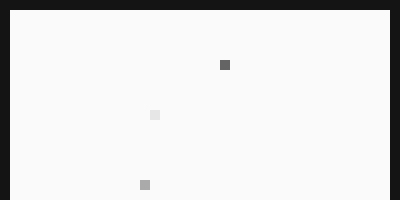

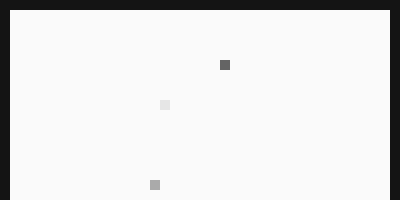

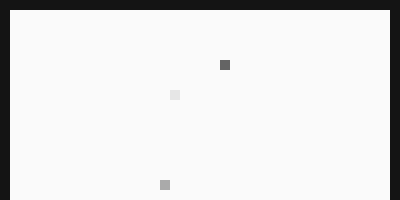

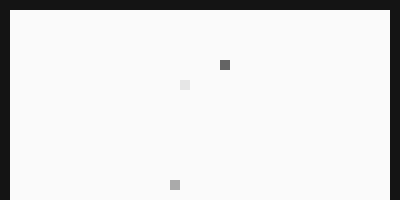

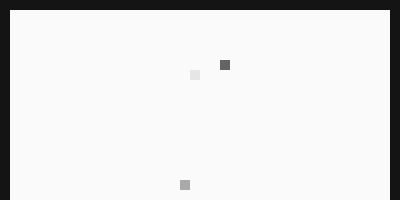

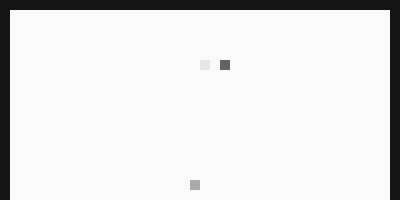

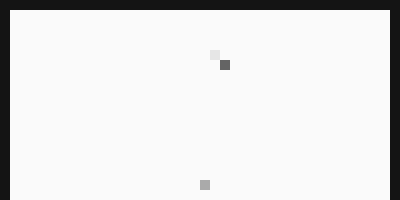

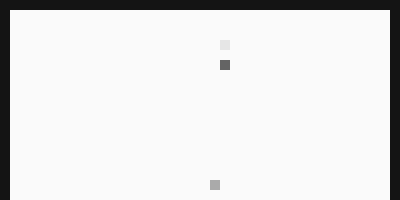

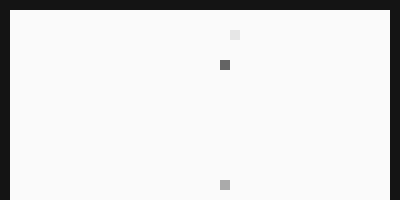

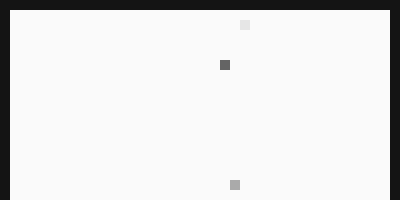

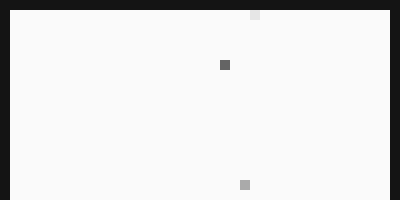

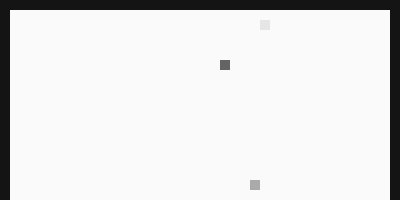

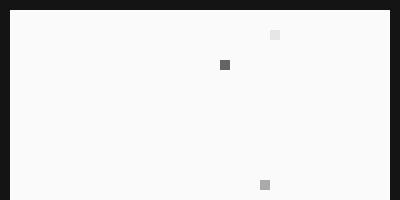

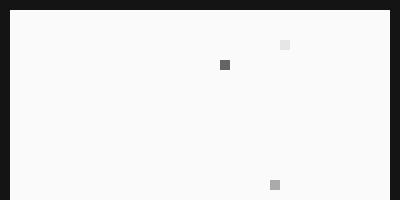

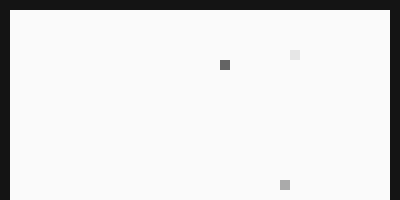

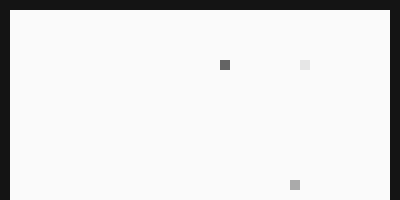

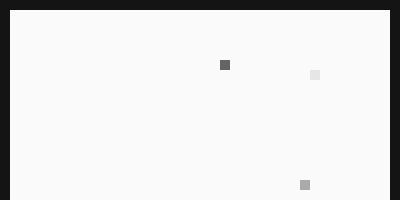

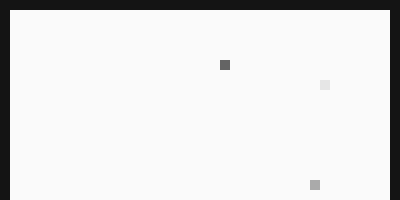

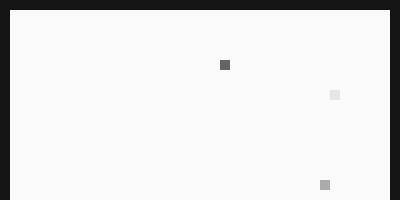

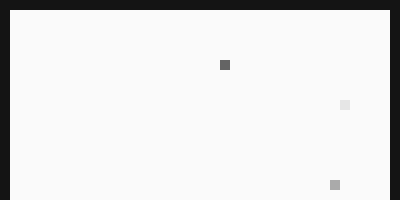

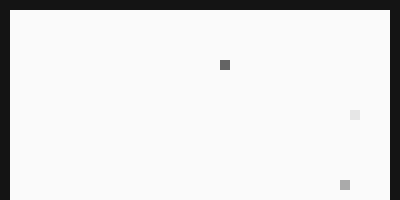

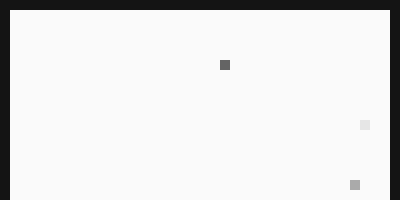

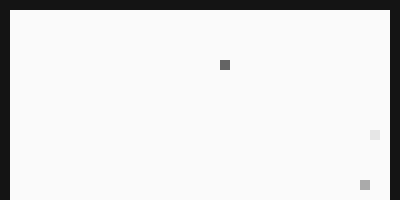

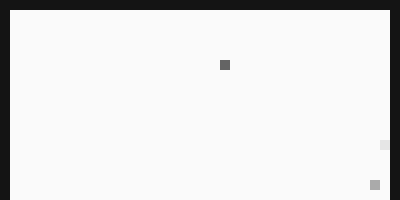

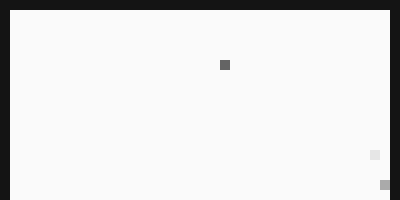

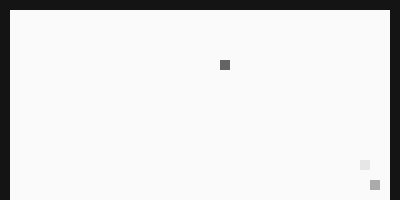

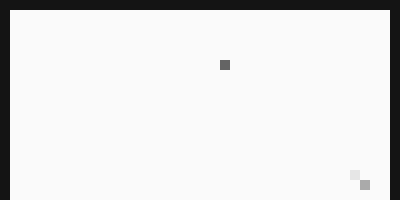

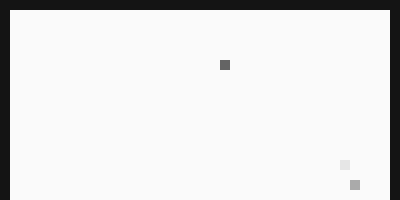

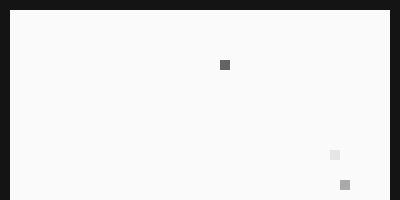

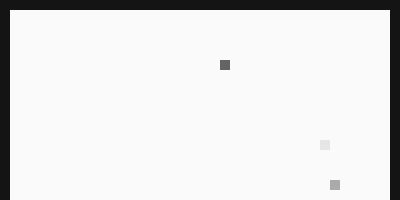

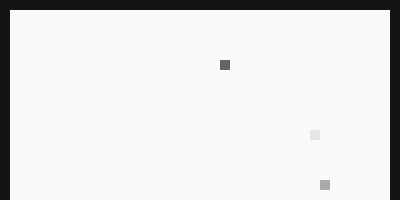

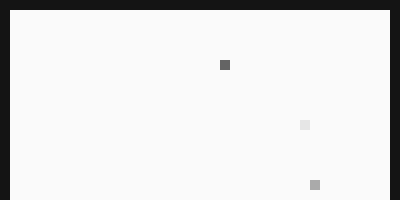

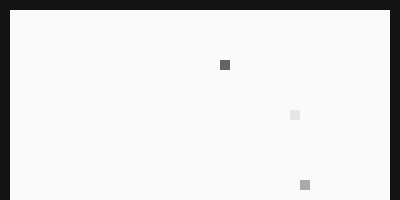

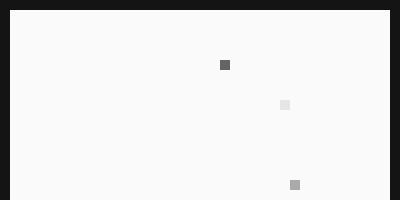

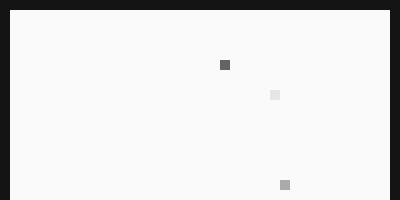

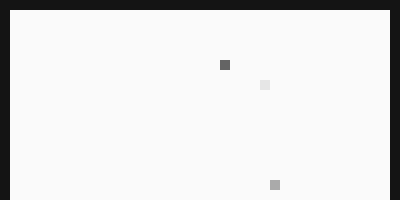

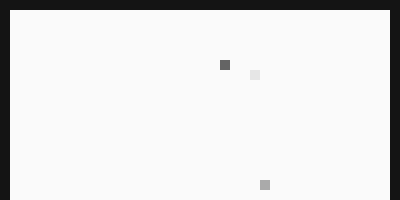

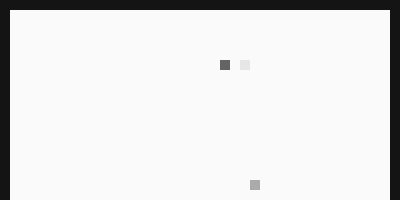

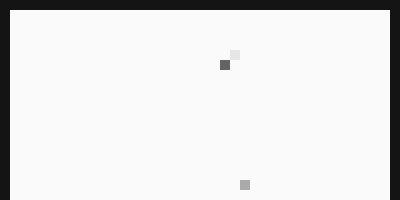

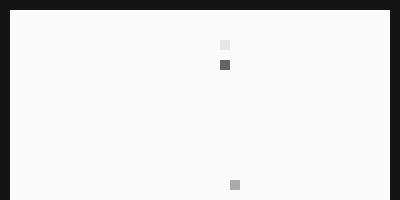

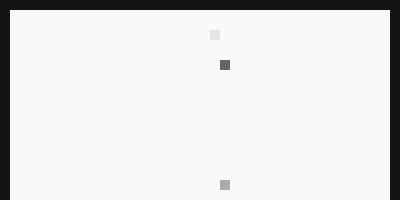

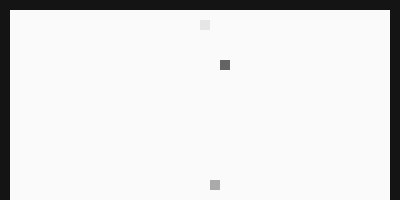

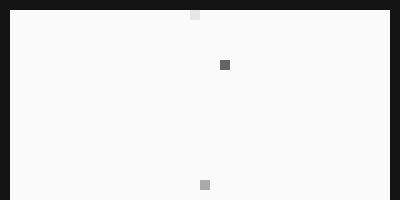

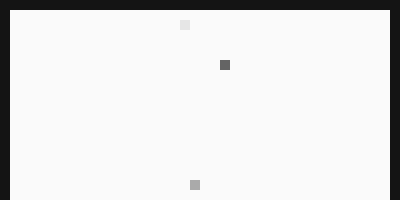

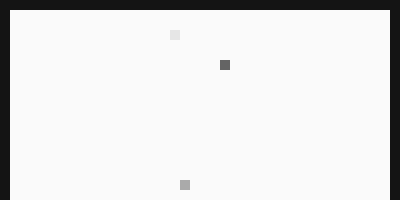

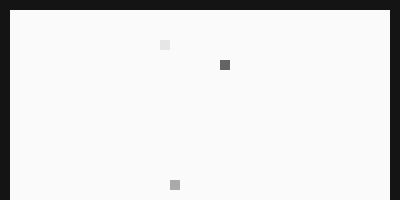

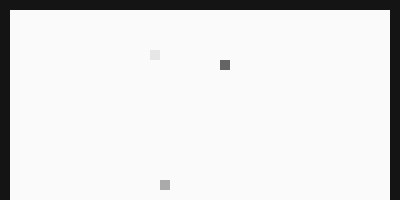

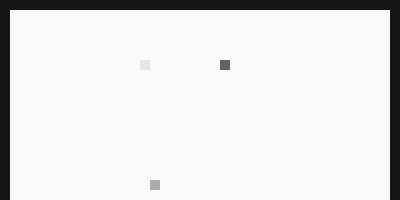

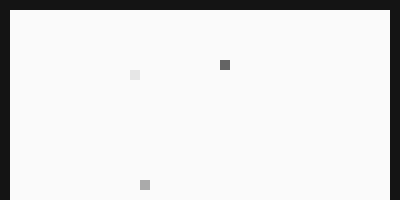

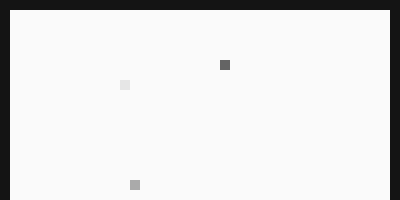

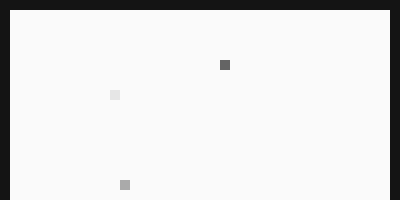

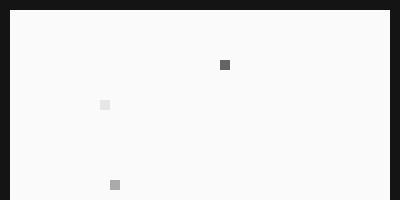

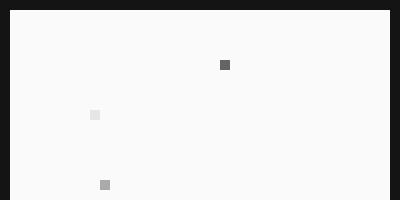

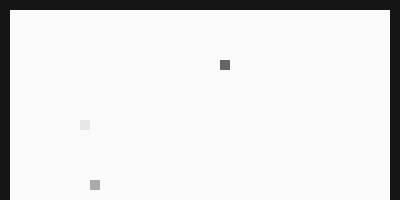

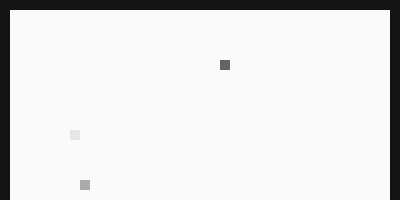

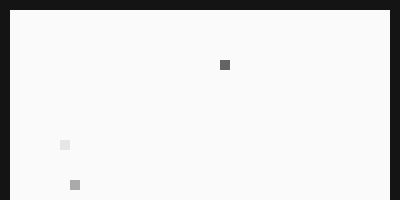

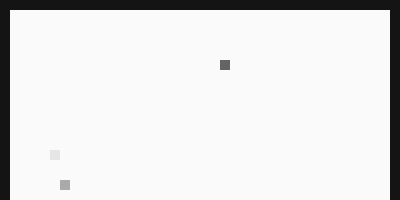

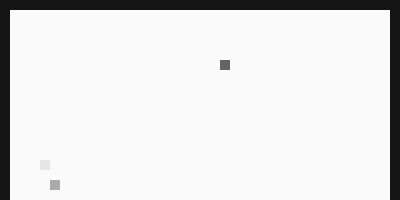

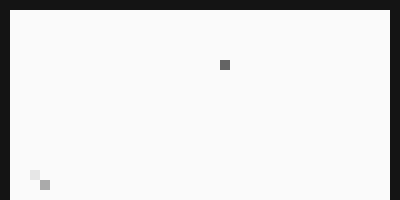

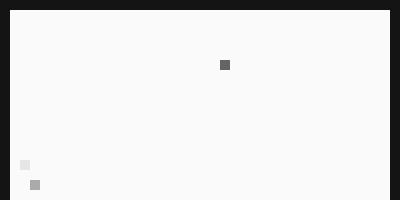

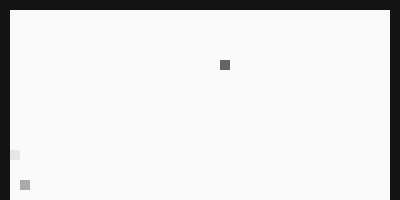

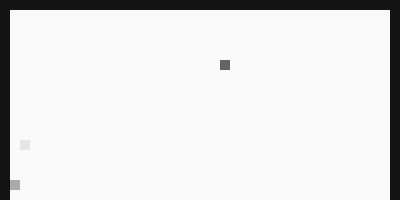

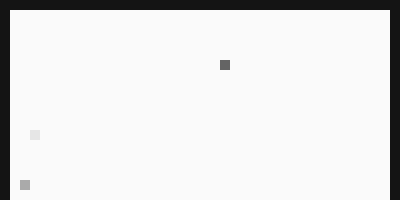

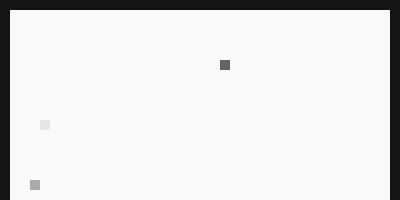

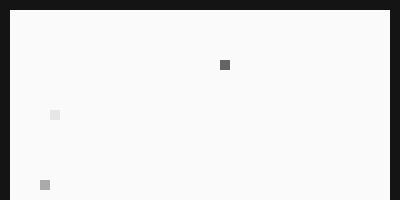

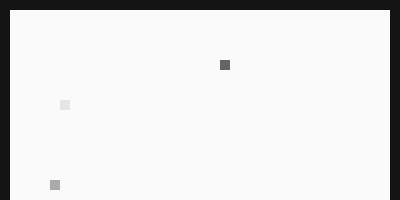

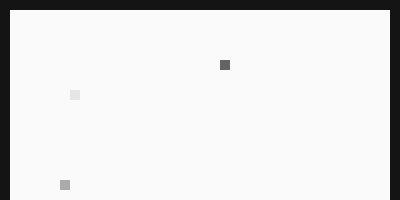

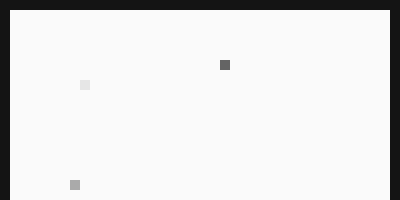

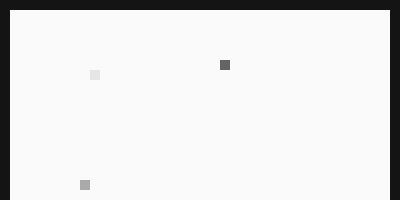

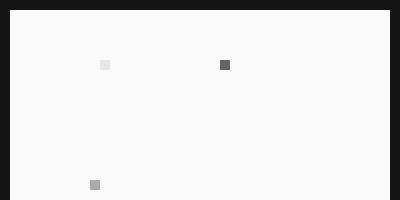

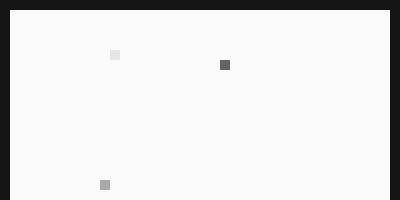

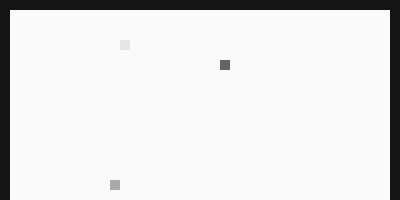

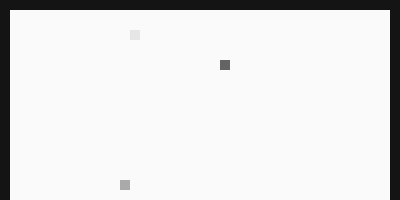

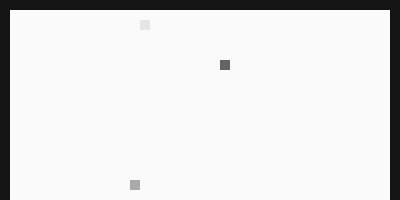

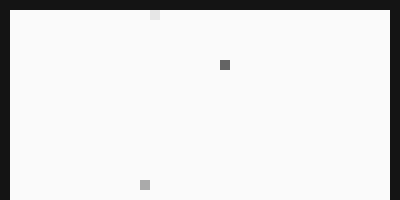

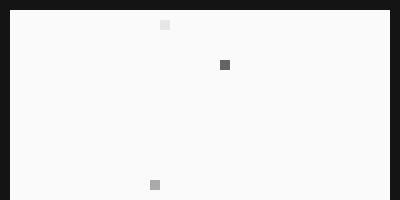

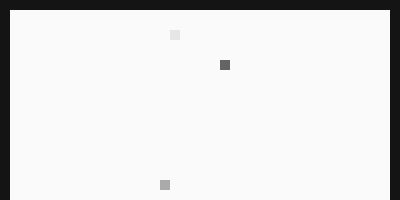

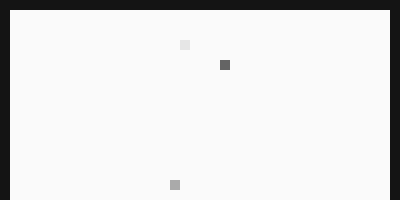

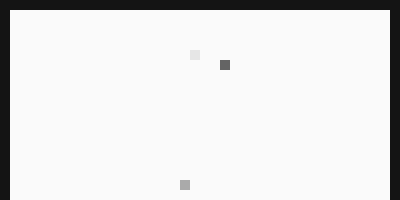

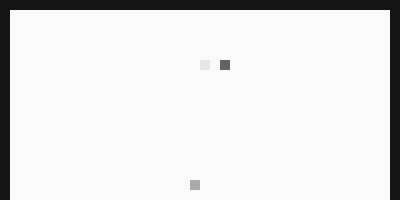

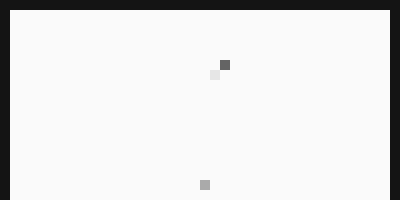

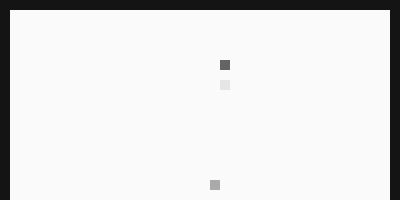

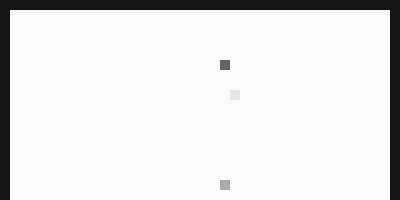

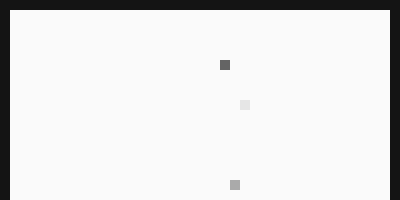

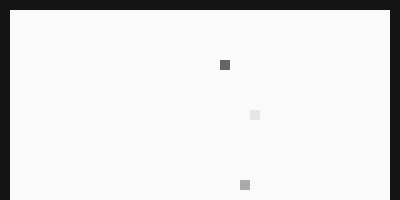

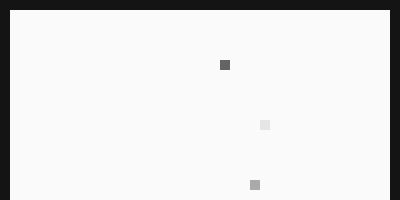

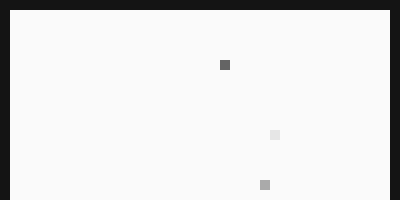

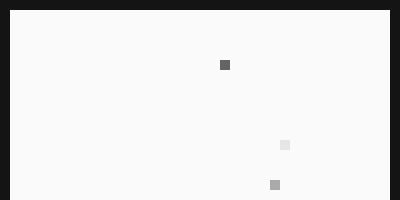

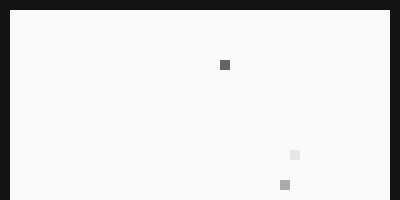

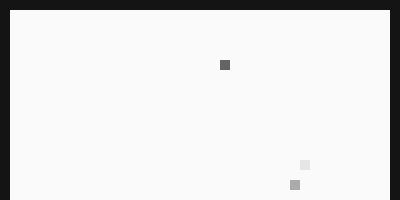

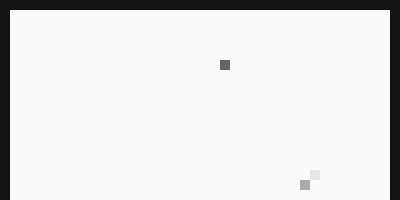

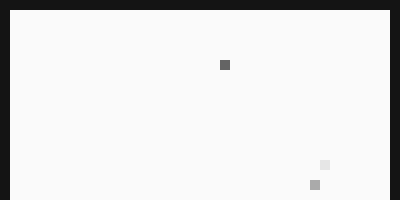

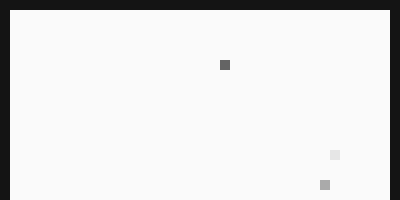

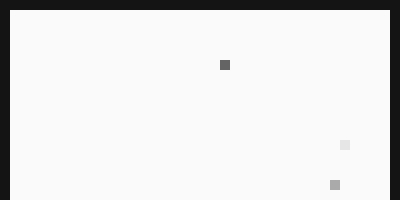

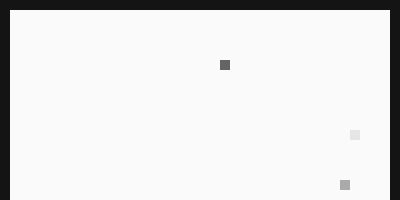

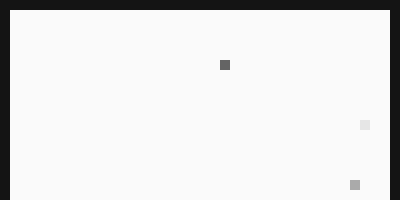

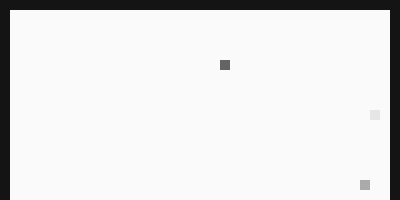

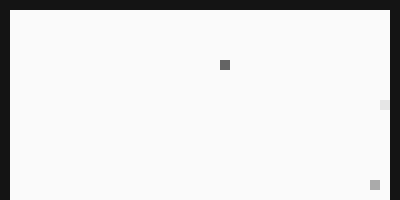

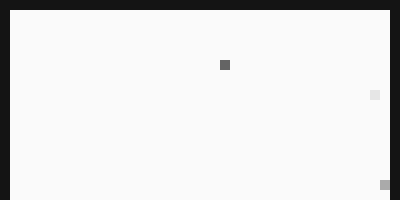

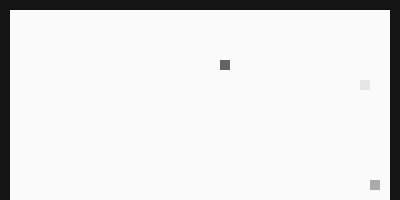

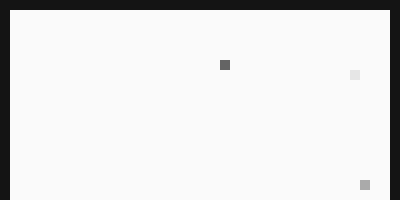

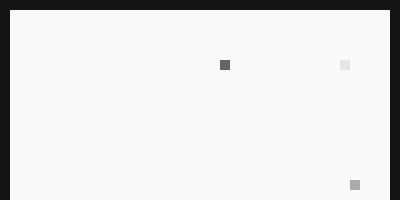

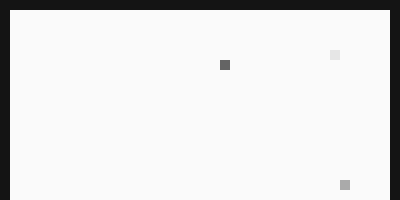

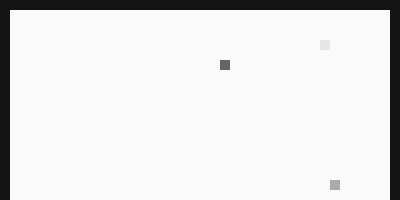

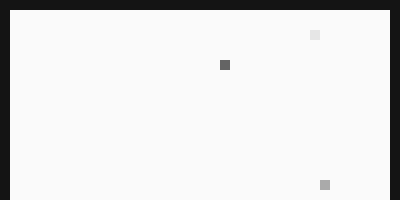

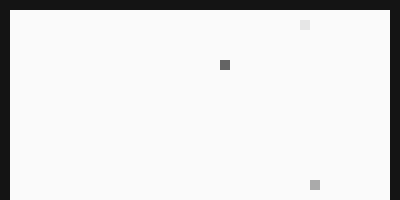

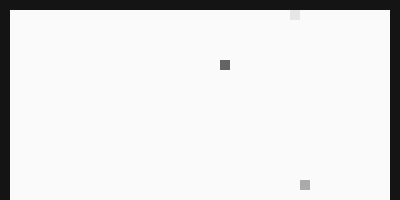

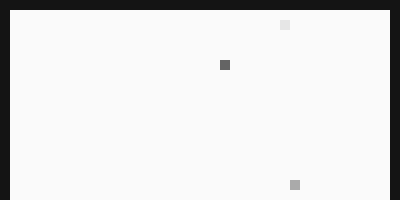

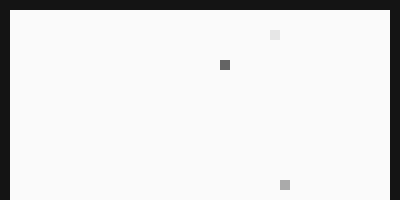

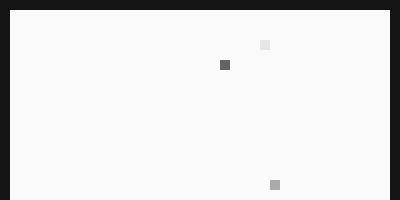

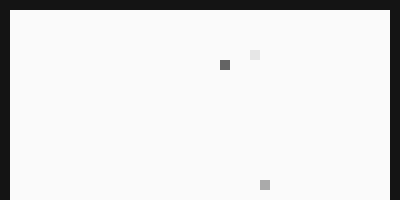

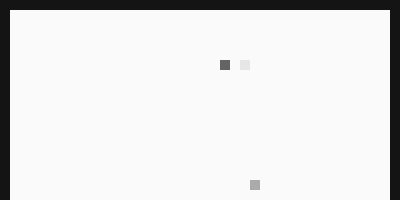

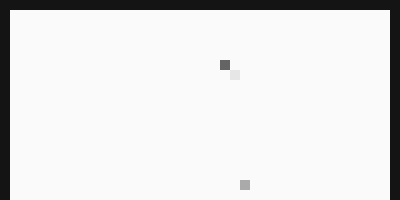

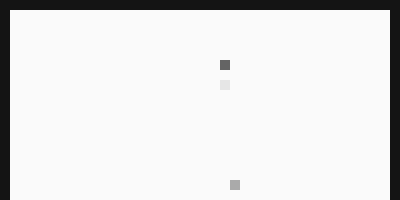

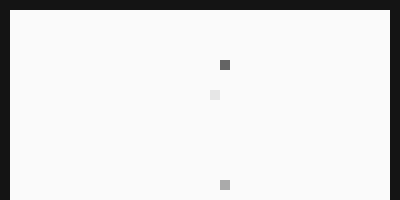

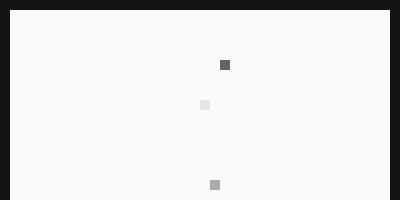

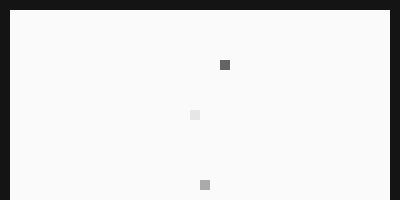

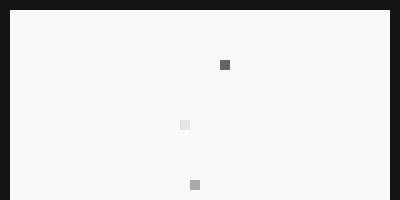

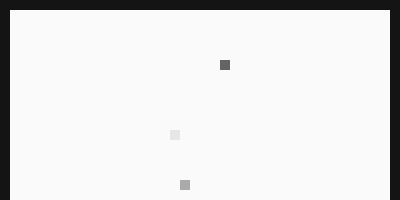

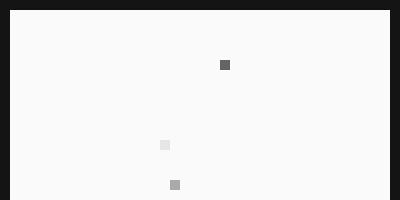

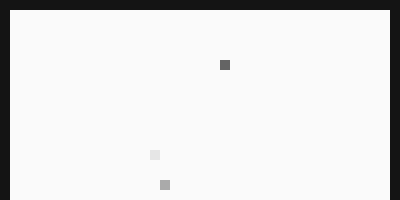

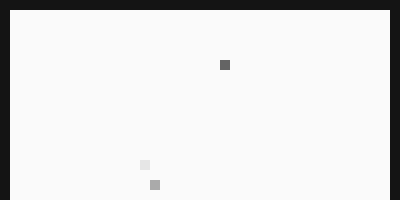

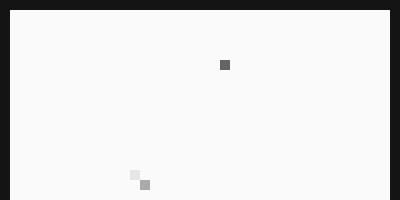

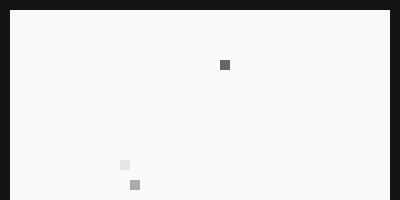

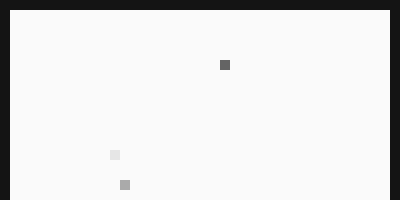

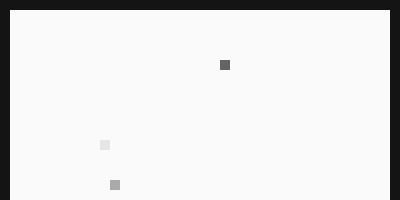

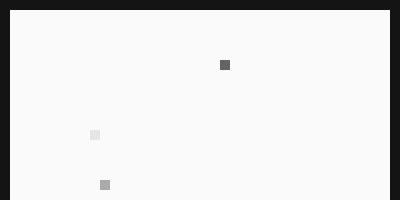

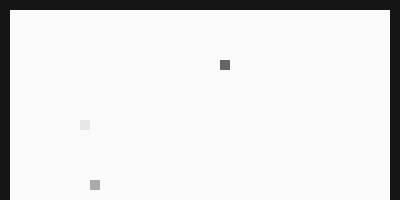

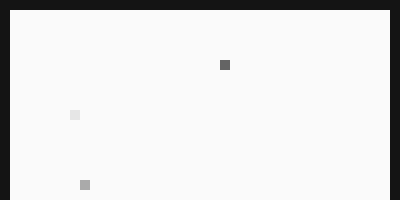

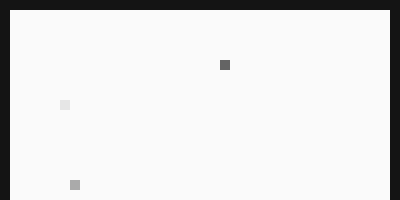

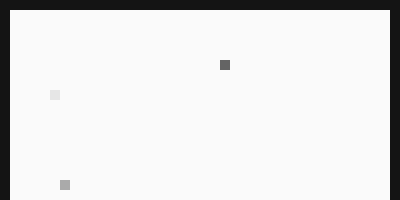

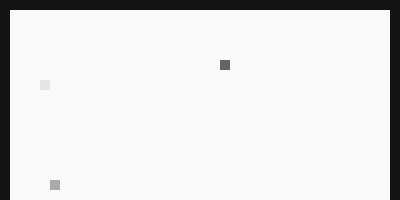

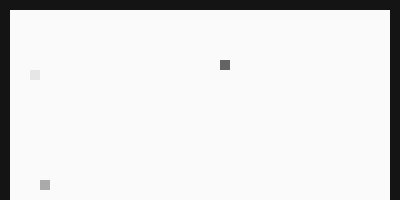

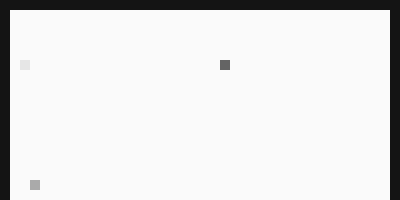

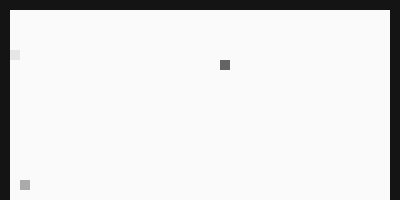

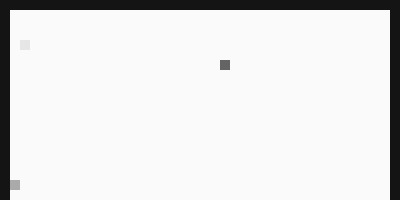

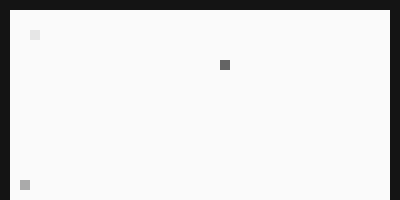

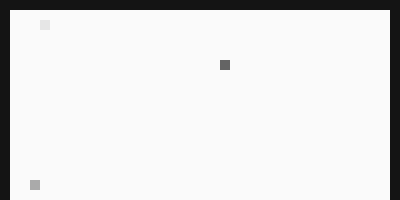

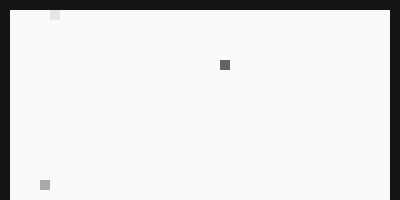

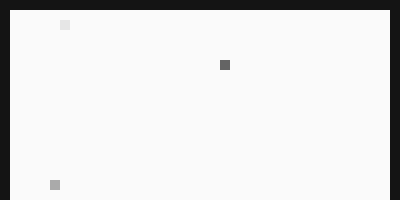

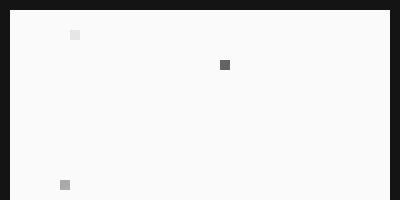

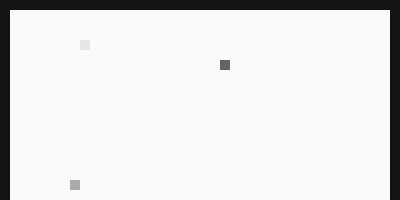

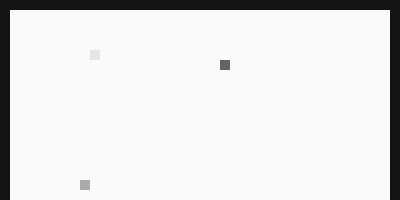

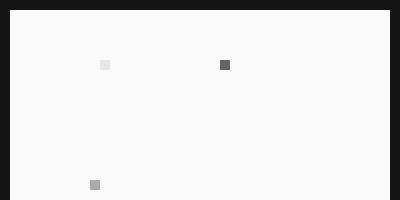

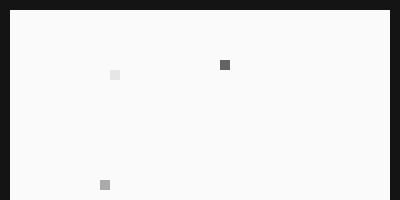

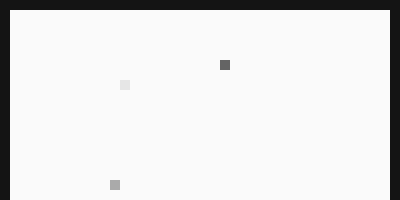

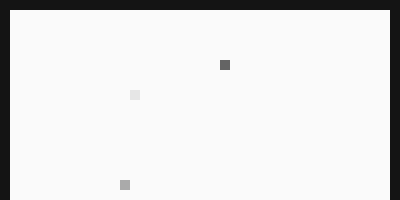

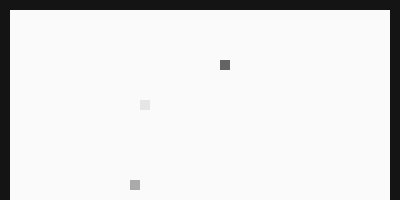

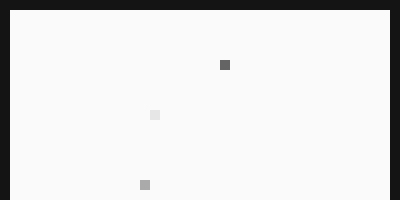

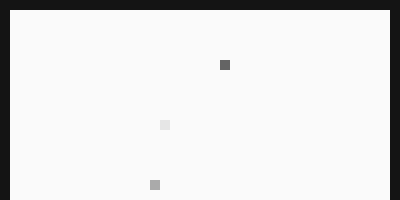

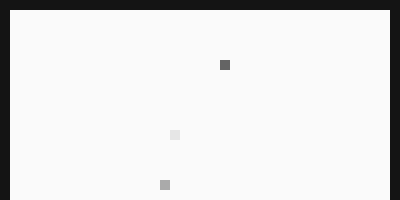

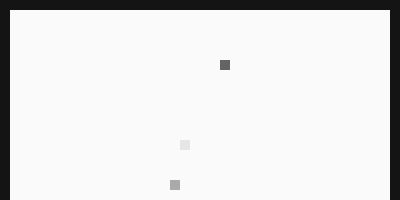

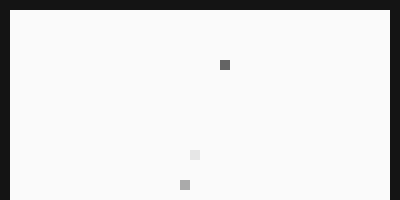

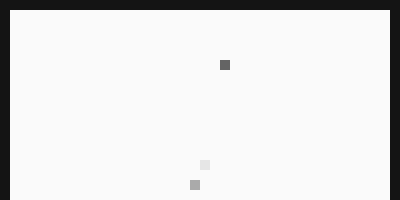

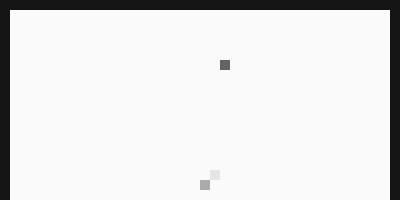

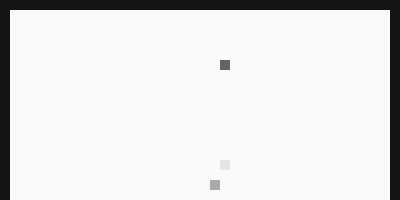

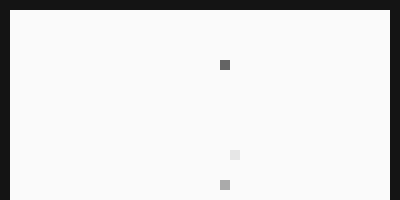

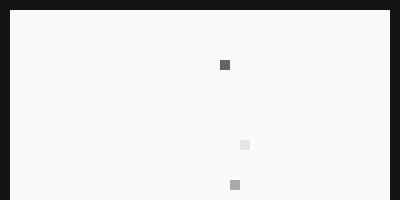

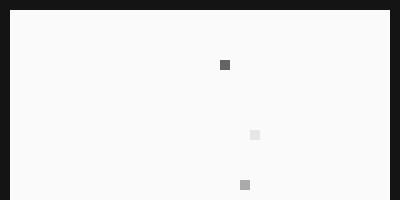

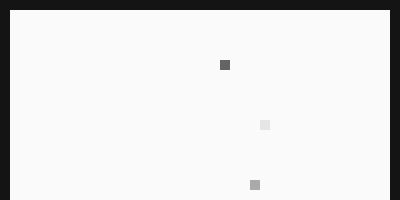

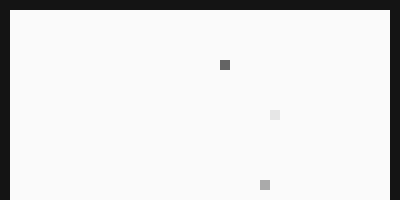

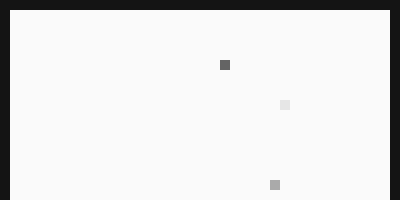

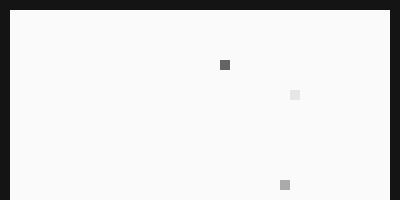

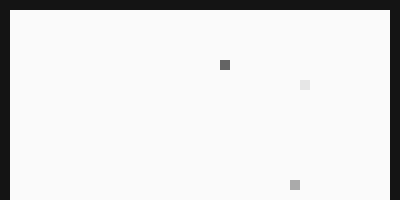

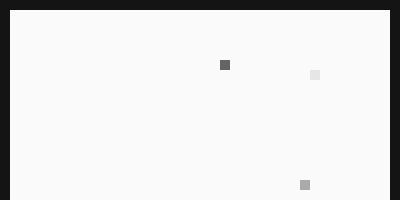

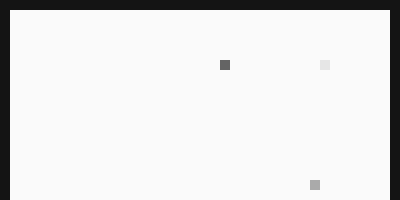

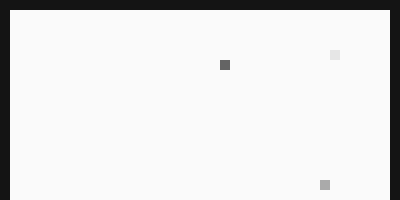

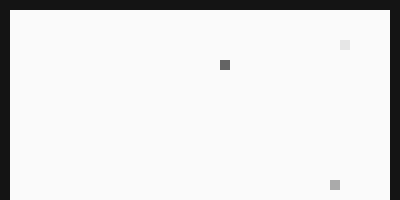

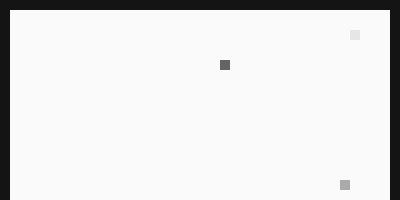

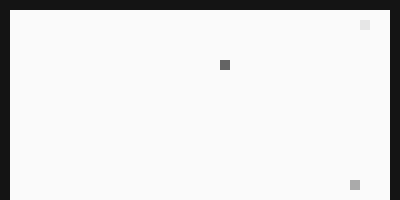

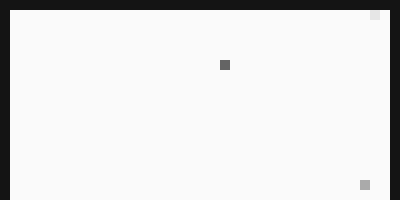

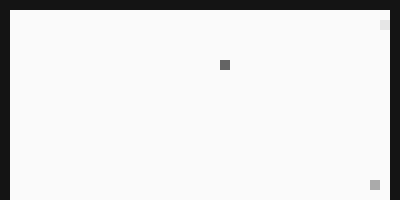

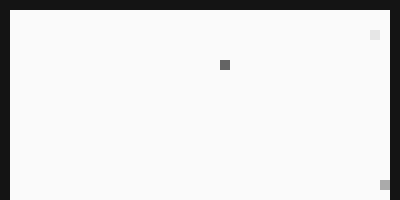

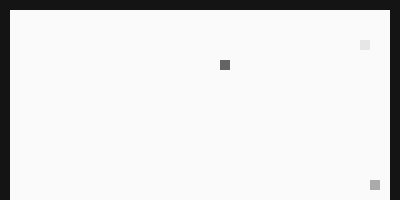

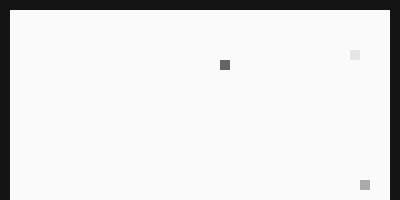

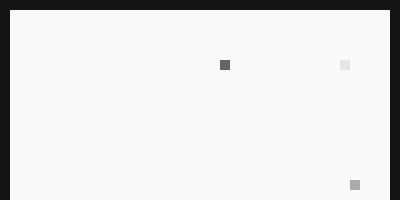

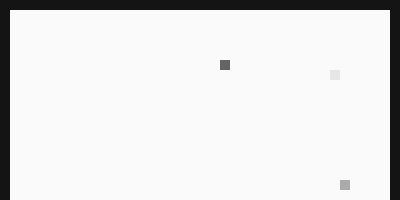

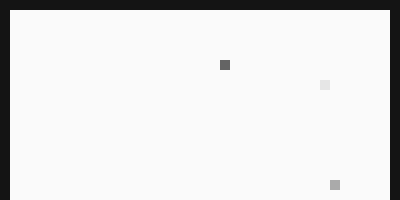

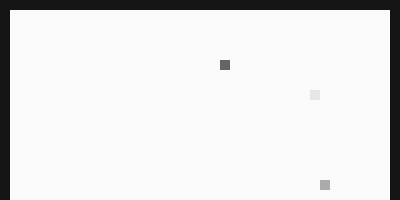

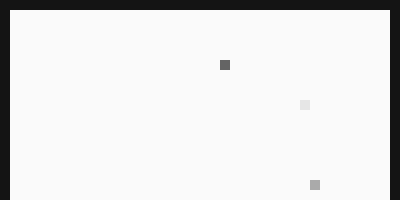

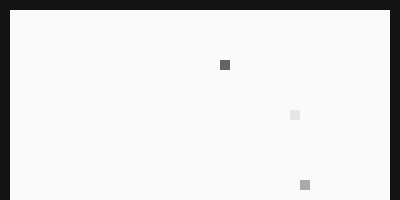

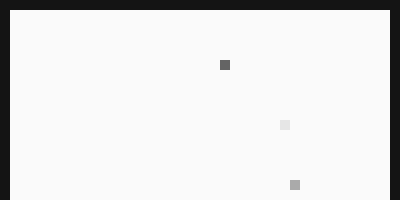

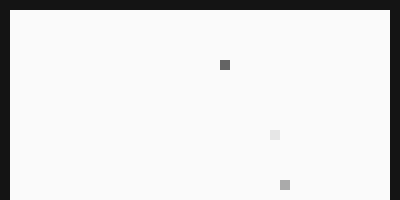

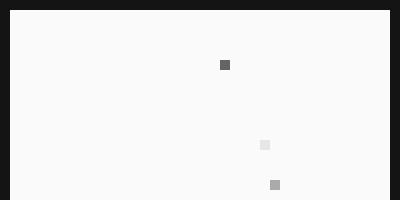

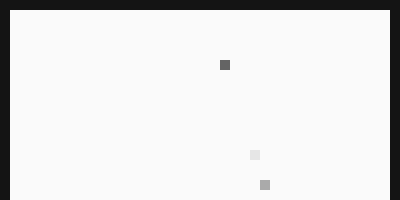

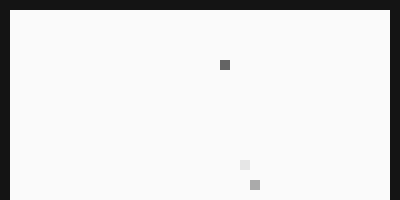

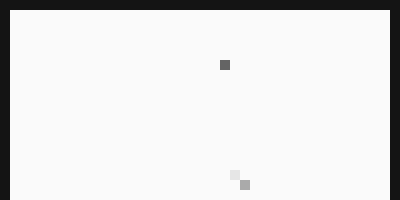

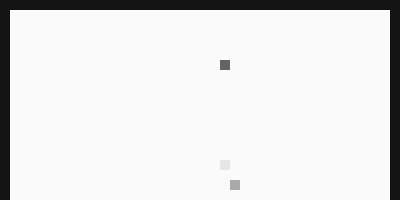

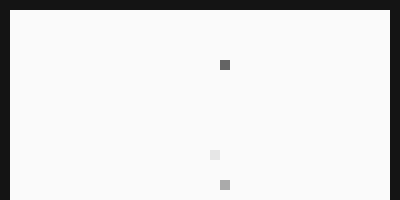

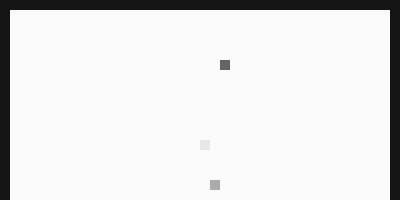

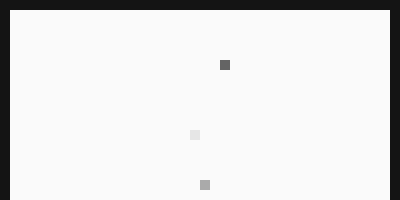

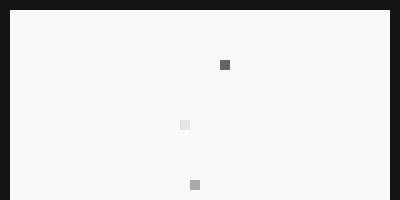

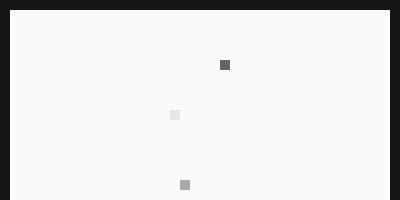

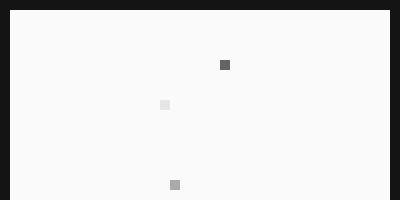

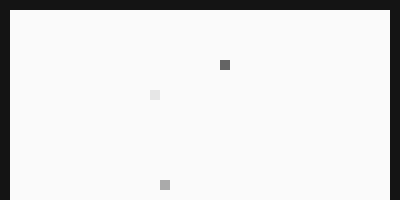

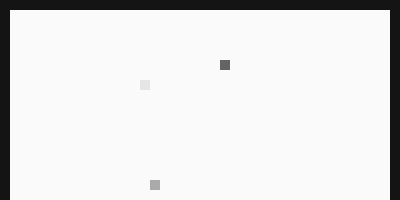

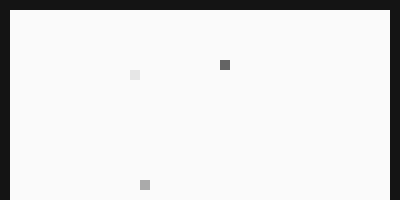

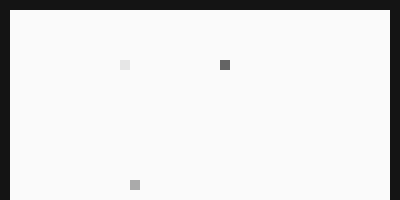

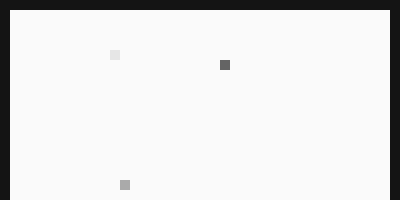

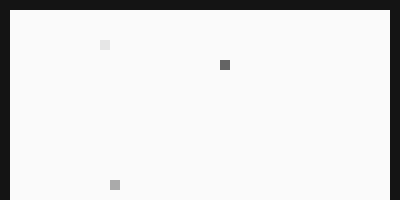

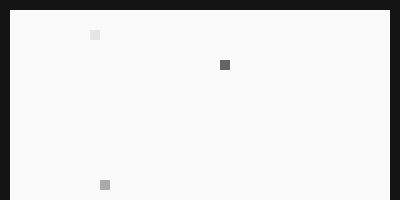

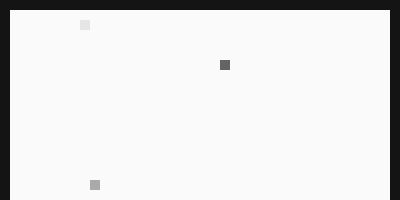

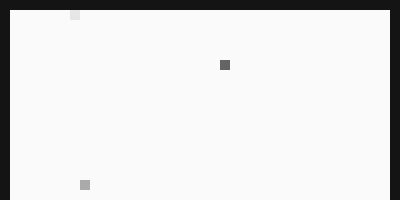

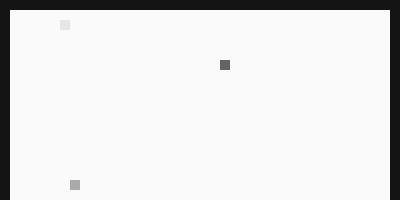

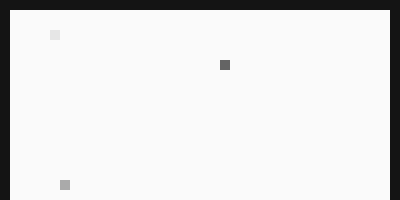

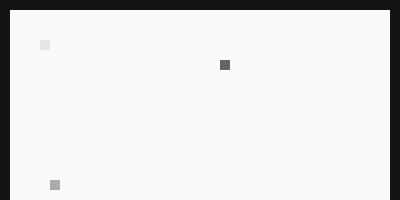

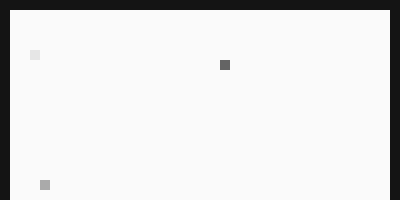

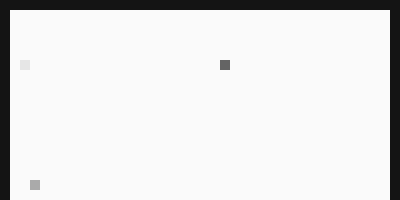

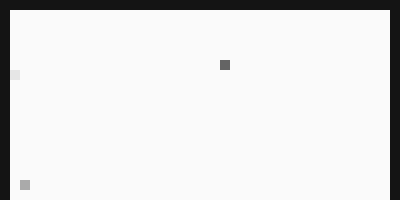

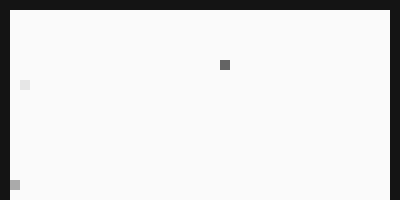

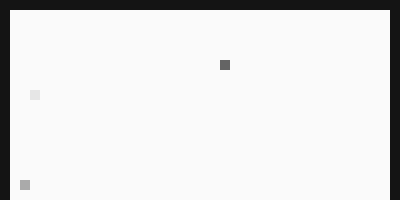

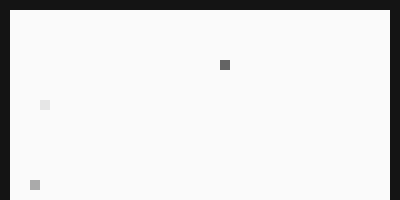

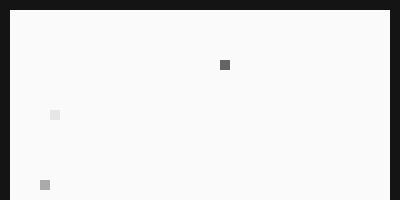

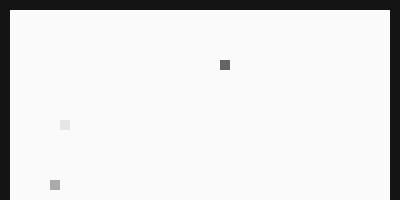

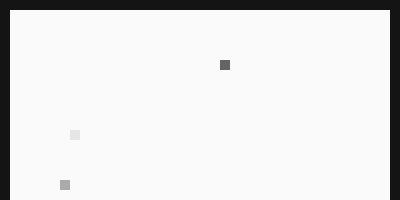

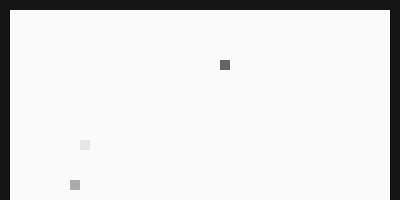

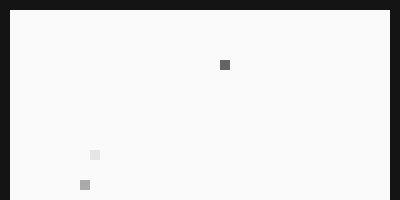

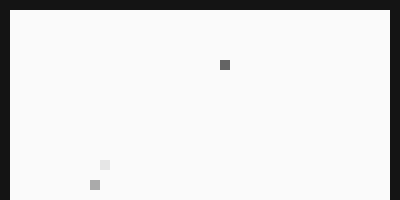

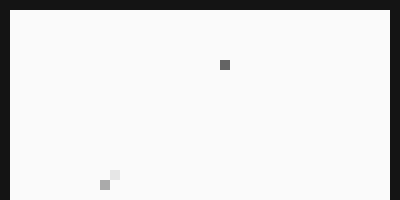

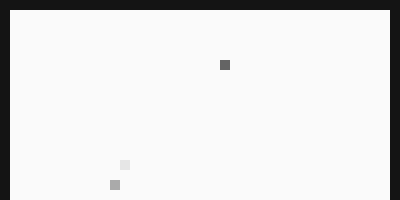

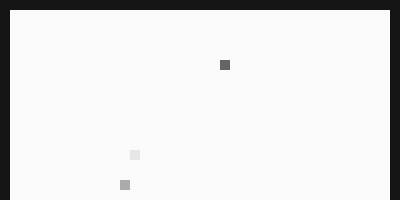

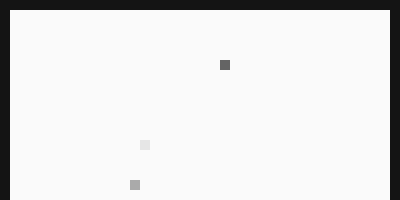

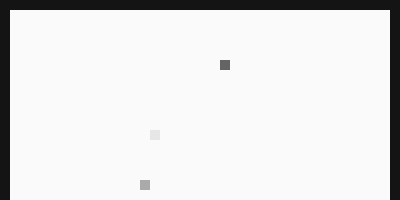

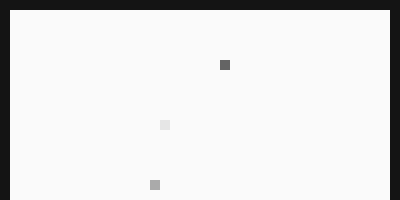

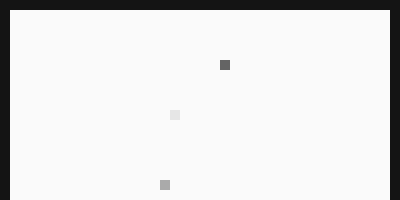

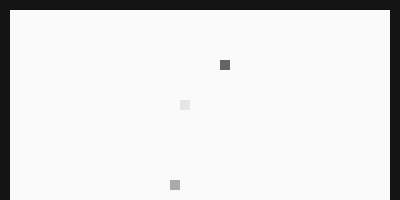

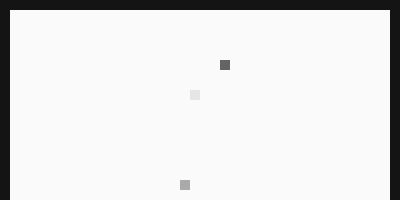

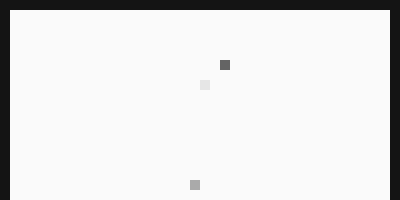

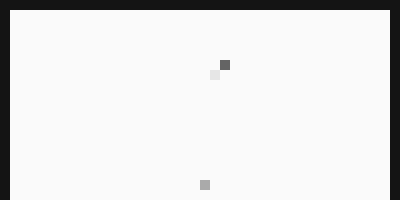

In [11]:
# run the program
while(prog_ctr != "STOP" and ops_ctr < ops_max):
    if(set_trace_main): import pdb; pdb.set_trace()
    logging.info("prog_ctr: {}, ops_ctr: {}".format(prog_ctr, ops_ctr))
    prog_ctr = comp.exec_seq(prog_ctr)
    # if the outputs array has 3 elements, than it's time to process those outputs
    if(len(outputs) == 3):
        # process the outputs
        # see if the output is for the score display
        if(outputs[0] == -1):
            game.score = outputs[2]
        else:
            # update the board
            game.update_board(outputs[0], outputs[1], outputs[2])
        # clear the outputs
        outputs = []
    ops_ctr += 1

In [13]:
print("ops_ctr: {}, prog_ctr: {}".format(ops_ctr, prog_ctr))
print("final score: {}".format(game.show_state("s")))

ops_ctr: 645649, prog_ctr: STOP
score: 8942
final score: None
